In [1]:
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import CatBoost, CatBoostRegressor, Pool
from optuna.integration import CatBoostPruningCallback
import optuna
from sklearn.metrics import mean_squared_error

In [6]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_val.shape)

(137, 43)
(100000, 42)


In [5]:
df_train.head(5)

Id   Open Date        City  City Group Type  P1   P2   P3   P4  P5  ...  \
0   0  07/17/1999    İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2  ...   
1   1  02/14/2008      Ankara  Big Cities   FC   4  5.0  4.0  4.0   1  ...   
2   2  03/09/2013  Diyarbakır       Other   IL   2  4.0  2.0  5.0   2  ...   
3   3  02/02/2012       Tokat       Other   IL   6  4.5  6.0  6.0   4  ...   
4   4  05/09/2009   Gaziantep       Other   IL   3  4.0  3.0  4.0   2  ...   

   P29  P30  P31  P32  P33  P34  P35  P36  P37    revenue  
0  3.0    5    3    4    5    5    4    3    4  5653753.0  
1  3.0    0    0    0    0    0    0    0    0  6923131.0  
2  3.0    0    0    0    0    0    0    0    0  2055379.0  
3  7.5   25   12   10    6   18   12   12    6  2675511.0  
4  3.0    5    1    3    2    3    4    3    3  4316715.0  

[5 rows x 43 columns]

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['revenue'], axis=1),  # drop the target
    df_train['revenue'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((109, 42), (28, 42))

In [9]:
own_date = date(2015, 1, 1)

In [10]:
def transform_date(df, new_date):
    df[['Open Date']] = df[['Open Date']].apply(pd.to_datetime)
    df['open_days'] = (pd.Timestamp(new_date) - df['Open Date']).dt.days
    df.drop(['Open Date'], axis=1, inplace=True)
    return df

In [11]:
X_train = transform_date(X_train, own_date)
X_test = transform_date(X_test, own_date)

In [12]:
categorical_features_names = ['City', 'City Group', 'Type']

In [13]:
X_train.drop(['Id'], axis=1, inplace=True)
X_test.drop(['Id'], axis=1, inplace=True)

In [14]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(y_train.values.reshape(-1, 1))

MinMaxScaler()

In [15]:
y_train_scale = target_scaler.transform(y_train.values.reshape(-1, 1))
y_test_scale = target_scaler.transform(y_test.values.reshape(-1, 1))

(array([24., 42., 23., 11.,  4.,  3.,  0.,  0.,  1.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

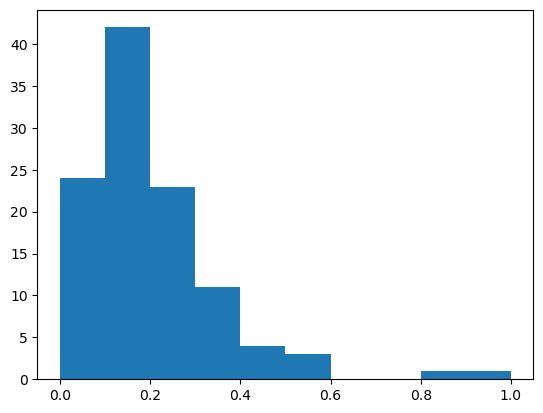

In [16]:
plt.hist(y_train_scale) 

In [17]:
train_pool = Pool(X_train, 
                  label=y_train_scale,
                  cat_features=categorical_features_names)
test_pool = Pool(X_test,
                 label=y_test_scale,
                 cat_features=categorical_features_names)

In [18]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=1000)
model.fit(train_pool, eval_set=test_pool, verbose=2000, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1494959	test: 0.2153376	best: 0.2153376 (0)	total: 164ms	remaining: 2m 44s
999:	learn: 0.0002631	test: 0.2026840	best: 0.2024819 (173)	total: 31.3s	remaining: 0us

bestTest = 0.2024819318
bestIteration = 173

Shrink model to first 174 iterations.


In [19]:
model.best_score_

{'learn': {'R2': 0.9999969925765643, 'RMSE': 0.0002631143543454975},
 'validation': {'R2': 0.0861130340369034, 'RMSE': 0.2024819317572863}}

In [21]:
# There is a very bad result on the validation set. One of the main problems with this dataset is 
# that it's too small and the model overfits very fast. 

In [22]:
#####################

In [23]:
def objective(trial):
    global cbr
    train_pool = Pool(X_train, 
                  label=y_train_scale,
                  cat_features=categorical_features_names)
    test_pool = Pool(X_test,
                 label=y_test_scale,
                 cat_features=categorical_features_names)
    
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 25000, step=100),
        'max_depth': trial.suggest_int('max_depth', 1, 15, step=1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.99),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 15.0),
        'max_bin': trial.suggest_int('max_bin', 1, 64000),
        'eval_metric': 'RMSE'
    }
    
    cbr = CatBoostRegressor(**param)

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    
    cbr.fit(
        train_pool, eval_set=test_pool,
        verbose=1,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )
    trial.set_user_attr(key="best_booster", value=cbr)
    # evoke pruning manually.
    pruning_callback.check_pruned()
    
    y_pred = cbr.predict(X_test)
    rmse = mean_squared_error(y_test_scale, y_pred, squared=False)
    return rmse

In [24]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [1]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize")
study.optimize(objective, n_trials=5, timeout=600, callbacks=[callback])

In [26]:
best_model=study.user_attrs["best_booster"]
print(best_model.get_params())

{'loss_function': 'RMSE', 'learning_rate': 0.015262686160708229, 'l2_leaf_reg': 8.527177625444946, 'eval_metric': 'RMSE', 'subsample': 0.5972075183855936, 'max_depth': 14, 'n_estimators': 4200, 'colsample_bylevel': 0.8126513553673904, 'max_bin': 43594}


In [27]:
y_pred = best_model.predict(X_test)

In [28]:
y_pred_scale = target_scaler.inverse_transform(y_pred.reshape(1,-1))[0]
#np.exp(y_pred)

In [29]:
rmse = mean_squared_error(y_test, y_pred_scale, squared=False)
print('RMSE: ', rmse)

RMSE:  3125820.8856568304


In [30]:
df_val = pd.read_csv('data/test.csv')
df_t = df_val[['Id']]

In [31]:
df_val = transform_date(df_val, own_date)
df_val.drop(['Id'], axis=1, inplace=True)

In [32]:
y_val = best_model.predict(df_val)
y_val_scale = target_scaler.inverse_transform(y_val.reshape(1,-1))[0]

In [33]:
df_t.insert(1, "Prediction", y_val_scale.tolist(), True)
df_t.to_csv("catboost_1.csv", index=False)

In [34]:
df_t.describe()

Id    Prediction
count  100000.000000  1.000000e+05
mean    49999.500000  4.347582e+06
std     28867.657797  5.583957e+05
min         0.000000  2.063965e+06
25%     24999.750000  4.017393e+06
50%     49999.500000  4.307158e+06
75%     74999.250000  4.626780e+06
max     99999.000000  1.084404e+07

In [35]:
best_model.save_model('catboost_model') 

In [34]:
#Score: 1879155.85679
#Public score: 1929288.10434
## with target scaling, minmax
#Score: 1847132.03702
#Public score: 1866521.17688
## with target log
#Score: 1911926.31450
#Public score: 1872417.51804
## StandartScale
#Score: 1853802.48131
#Public score: 1815061.21828

### With preprocessing
One of the problems with this data set is that we don't know anything about P features and some of them could have a similar meaning in real life. Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have a high correlation, we can drop one of the two features

In [203]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import Pool, cv


In [204]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_val.shape)

(137, 43)
(100000, 42)


In [205]:
#dict_type = {'FC': 1, 'IL': 2, 'DT': 2, 'MB': 2}
#df_train['Type'] = df_train['Type'].map(dict_type)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['revenue'], axis=1),  # drop the target
    df_train['revenue'],  # just the target
    test_size=0.2,
 #   stratify=df_train[['City Group', 'Type']]
)

X_train.shape, X_test.shape

((109, 42), (28, 42))

In [207]:
X_train = transform_date(X_train, own_date)
X_test = transform_date(X_test, own_date)

In [208]:
df_train_trans = transform_date(df_train, own_date)

In [2]:
plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr(),annot=True, annot_kws={"size":8})
#sns.set(font_scale = .7)

In [210]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns    
    corr_matrix = dataset.corr()    
    for i in range(len(corr_matrix.columns)):    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [211]:
corr_features = correlation(X_train, 0.9)
print('correlated features: ', len(set(corr_features)) )

correlated features:  14


In [212]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((109, 28), (28, 28))

I want to delete 'City' column because it's possible that we haven't got all cities in the set for training and in the future it could be a problem for a model to handle new cities.

In [213]:
X_train.drop(['Id', 'City'], axis=1, inplace=True)
X_test.drop(['Id', 'City'], axis=1, inplace=True)

In [214]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(y_train.values.reshape(-1, 1))

MinMaxScaler()

In [215]:
y_train_scale = target_scaler.transform(y_train.values.reshape(-1, 1))
y_test_scale = target_scaler.transform(y_test.values.reshape(-1, 1))

(array([30., 47., 20.,  8.,  3.,  0.,  0.,  0.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

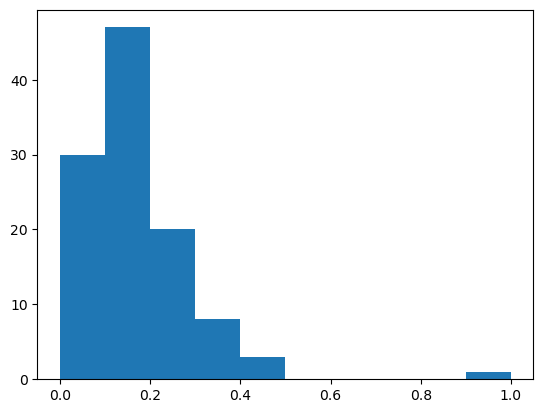

In [216]:
plt.hist(y_train_scale) 

In [217]:
categorical_features_names = ['City Group', 'Type']

In [106]:
selected_columns = X_train.columns

In [111]:
def objective(trial):
    global cbr
    train_pool = Pool(X_train, 
                  label=y_train_scale,
                  cat_features=categorical_features_names)
    test_pool = Pool(X_test,
                 label=y_test_scale,
                 cat_features=categorical_features_names)
    
    param = {
      #  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2500, step=1),
        'max_depth': trial.suggest_int('max_depth', 1, 15, step=1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.99),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 15.0),
        'max_bin': trial.suggest_int('max_bin', 1, 64000),
        'eval_metric': 'RMSE'
    }
    
    cbr = CatBoostRegressor(**param)

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    
    cbr.fit(
        train_pool, eval_set=test_pool,
        verbose=1,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )
    trial.set_user_attr(key="best_booster", value=cbr)
    # evoke pruning manually.
    pruning_callback.check_pruned()
    
    y_pred = cbr.predict(X_test)
    rmse = mean_squared_error(y_test_scale, y_pred, squared=False)
    return rmse

In [112]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [113]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize")
study.optimize(objective, n_trials=5, timeout=600, callbacks=[callback])

[I 2022-10-06 13:49:18,844] A new study created in memory with name: no-name-e99dca2c-208a-4405-8210-8e544fc6564e
C:\Users\Me\AppData\Local\Temp\ipykernel_7392\784513565.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


0:	learn: 0.1436683	test: 0.1195087	best: 0.1195087 (0)	total: 16.2ms	remaining: 32.2s
1:	learn: 0.1431124	test: 0.1191249	best: 0.1191249 (1)	total: 38.8ms	remaining: 38.6s
2:	learn: 0.1424716	test: 0.1188124	best: 0.1188124 (2)	total: 58.3ms	remaining: 38.6s
3:	learn: 0.1420417	test: 0.1186238	best: 0.1186238 (3)	total: 84.2ms	remaining: 41.8s
4:	learn: 0.1416084	test: 0.1185660	best: 0.1185660 (4)	total: 101ms	remaining: 40.3s
5:	learn: 0.1412725	test: 0.1183550	best: 0.1183550 (5)	total: 125ms	remaining: 41.2s
6:	learn: 0.1407031	test: 0.1184586	best: 0.1183550 (5)	total: 151ms	remaining: 42.8s
7:	learn: 0.1404242	test: 0.1183212	best: 0.1183212 (7)	total: 168ms	remaining: 41.7s
8:	learn: 0.1399922	test: 0.1181912	best: 0.1181912 (8)	total: 194ms	remaining: 42.6s
9:	learn: 0.1396108	test: 0.1179213	best: 0.1179213 (9)	total: 210ms	remaining: 41.7s
10:	learn: 0.1390214	test: 0.1179984	best: 0.1179213 (9)	total: 236ms	remaining: 42.6s
11:	learn: 0.1386060	test: 0.1177469	best: 0.1177

96:	learn: 0.1129391	test: 0.1153889	best: 0.1151304 (86)	total: 2.11s	remaining: 41.3s
97:	learn: 0.1127002	test: 0.1153771	best: 0.1151304 (86)	total: 2.14s	remaining: 41.3s
98:	learn: 0.1124640	test: 0.1155475	best: 0.1151304 (86)	total: 2.16s	remaining: 41.3s
99:	learn: 0.1121625	test: 0.1156844	best: 0.1151304 (86)	total: 2.19s	remaining: 41.3s
100:	learn: 0.1119305	test: 0.1156535	best: 0.1151304 (86)	total: 2.22s	remaining: 41.5s
101:	learn: 0.1118412	test: 0.1156078	best: 0.1151304 (86)	total: 2.25s	remaining: 41.7s
102:	learn: 0.1116311	test: 0.1155316	best: 0.1151304 (86)	total: 2.27s	remaining: 41.6s
103:	learn: 0.1112516	test: 0.1157370	best: 0.1151304 (86)	total: 2.29s	remaining: 41.6s
104:	learn: 0.1110584	test: 0.1157544	best: 0.1151304 (86)	total: 2.32s	remaining: 41.7s
105:	learn: 0.1108839	test: 0.1158335	best: 0.1151304 (86)	total: 2.35s	remaining: 41.7s
106:	learn: 0.1108338	test: 0.1158336	best: 0.1151304 (86)	total: 2.37s	remaining: 41.8s
107:	learn: 0.1106269	tes

[I 2022-10-06 13:49:23,432] Trial 0 finished with value: 0.11513043017641192 and parameters: {'n_estimators': 1991, 'max_depth': 6, 'subsample': 0.9987439827576277, 'colsample_bylevel': 0.7447309726646123, 'l2_leaf_reg': 11.28554666470762, 'max_bin': 35856}. Best is trial 0 with value: 0.11513043017641192.


181:	learn: 0.0930932	test: 0.1201125	best: 0.1151304 (86)	total: 4.21s	remaining: 41.8s
182:	learn: 0.0927602	test: 0.1202477	best: 0.1151304 (86)	total: 4.24s	remaining: 41.8s
183:	learn: 0.0925418	test: 0.1204209	best: 0.1151304 (86)	total: 4.27s	remaining: 41.9s
184:	learn: 0.0922260	test: 0.1205164	best: 0.1151304 (86)	total: 4.3s	remaining: 42s
185:	learn: 0.0921223	test: 0.1205304	best: 0.1151304 (86)	total: 4.32s	remaining: 41.9s
186:	learn: 0.0918921	test: 0.1206551	best: 0.1151304 (86)	total: 4.34s	remaining: 41.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1151304299
bestIteration = 86

Shrink model to first 87 iterations.


C:\Users\Me\AppData\Local\Temp\ipykernel_7392\784513565.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


0:	learn: 0.1431773	test: 0.1192972	best: 0.1192972 (0)	total: 31.6ms	remaining: 50s
1:	learn: 0.1421915	test: 0.1191769	best: 0.1191769 (1)	total: 58.8ms	remaining: 46.5s
2:	learn: 0.1415035	test: 0.1187333	best: 0.1187333 (2)	total: 87.6ms	remaining: 46.2s
3:	learn: 0.1411547	test: 0.1183271	best: 0.1183271 (3)	total: 114ms	remaining: 45s
4:	learn: 0.1405994	test: 0.1180721	best: 0.1180721 (4)	total: 144ms	remaining: 45.6s
5:	learn: 0.1401018	test: 0.1177831	best: 0.1177831 (5)	total: 167ms	remaining: 43.9s
6:	learn: 0.1393911	test: 0.1179155	best: 0.1177831 (5)	total: 194ms	remaining: 43.8s
7:	learn: 0.1386361	test: 0.1179940	best: 0.1177831 (5)	total: 222ms	remaining: 43.8s
8:	learn: 0.1380652	test: 0.1178684	best: 0.1177831 (5)	total: 263ms	remaining: 46s
9:	learn: 0.1376958	test: 0.1173474	best: 0.1173474 (9)	total: 298ms	remaining: 46.9s
10:	learn: 0.1372521	test: 0.1173542	best: 0.1173474 (9)	total: 311ms	remaining: 44.5s
11:	learn: 0.1366699	test: 0.1170685	best: 0.1170685 (11

99:	learn: 0.1007089	test: 0.1178309	best: 0.1159825 (40)	total: 3.31s	remaining: 49.1s
100:	learn: 0.1003472	test: 0.1180832	best: 0.1159825 (40)	total: 3.35s	remaining: 49.2s
101:	learn: 0.1003375	test: 0.1180570	best: 0.1159825 (40)	total: 3.36s	remaining: 48.9s
102:	learn: 0.0999704	test: 0.1182738	best: 0.1159825 (40)	total: 3.4s	remaining: 48.9s
103:	learn: 0.0996252	test: 0.1182468	best: 0.1159825 (40)	total: 3.42s	remaining: 48.8s
104:	learn: 0.0990392	test: 0.1185131	best: 0.1159825 (40)	total: 3.46s	remaining: 48.8s
105:	learn: 0.0986402	test: 0.1185389	best: 0.1159825 (40)	total: 3.49s	remaining: 48.7s
106:	learn: 0.0984058	test: 0.1187248	best: 0.1159825 (40)	total: 3.51s	remaining: 48.5s
107:	learn: 0.0982206	test: 0.1188203	best: 0.1159825 (40)	total: 3.54s	remaining: 48.5s
108:	learn: 0.0978561	test: 0.1190790	best: 0.1159825 (40)	total: 3.57s	remaining: 48.4s
109:	learn: 0.0973886	test: 0.1191388	best: 0.1159825 (40)	total: 3.62s	remaining: 48.5s
110:	learn: 0.0969674	t

[I 2022-10-06 13:49:28,368] Trial 1 finished with value: 0.11598249526949699 and parameters: {'n_estimators': 1585, 'max_depth': 8, 'subsample': 0.5407817778893109, 'colsample_bylevel': 0.8823575067477919, 'l2_leaf_reg': 5.72454613681059, 'max_bin': 59277}. Best is trial 0 with value: 0.11513043017641192.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1159824951
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 0.1434917	test: 0.1194526	best: 0.1194526 (0)	total: 22.1ms	remaining: 16.7s
1:	learn: 0.1432172	test: 0.1192922	best: 0.1192922 (1)	total: 45.2ms	remaining: 17.1s
2:	learn: 0.1427714	test: 0.1193304	best: 0.1192922 (1)	total: 60.3ms	remaining: 15.2s
3:	learn: 0.1424723	test: 0.1189732	best: 0.1189732 (3)	total: 87.4ms	remaining: 16.5s
4:	learn: 0.1421466	test: 0.1186377	best: 0.1186377 (4)	total: 116ms	remaining: 17.4s


C:\Users\Me\AppData\Local\Temp\ipykernel_7392\784513565.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


5:	learn: 0.1417314	test: 0.1184198	best: 0.1184198 (5)	total: 145ms	remaining: 18.1s
6:	learn: 0.1413778	test: 0.1184317	best: 0.1184198 (5)	total: 171ms	remaining: 18.4s
7:	learn: 0.1408485	test: 0.1185237	best: 0.1184198 (5)	total: 200ms	remaining: 18.7s
8:	learn: 0.1404403	test: 0.1185731	best: 0.1184198 (5)	total: 229ms	remaining: 19s
9:	learn: 0.1402425	test: 0.1185414	best: 0.1184198 (5)	total: 256ms	remaining: 19.2s
10:	learn: 0.1399914	test: 0.1184580	best: 0.1184198 (5)	total: 282ms	remaining: 19.2s
11:	learn: 0.1395888	test: 0.1182895	best: 0.1182895 (11)	total: 310ms	remaining: 19.3s
12:	learn: 0.1390185	test: 0.1182415	best: 0.1182415 (12)	total: 333ms	remaining: 19.1s
13:	learn: 0.1386530	test: 0.1181958	best: 0.1181958 (13)	total: 360ms	remaining: 19.2s
14:	learn: 0.1383381	test: 0.1180634	best: 0.1180634 (14)	total: 388ms	remaining: 19.2s
15:	learn: 0.1379051	test: 0.1179718	best: 0.1179718 (15)	total: 420ms	remaining: 19.5s
16:	learn: 0.1375857	test: 0.1178972	best: 0.

104:	learn: 0.1090760	test: 0.1189187	best: 0.1176141 (23)	total: 3.01s	remaining: 18.7s
105:	learn: 0.1087532	test: 0.1188353	best: 0.1176141 (23)	total: 3.04s	remaining: 18.7s
106:	learn: 0.1085610	test: 0.1189137	best: 0.1176141 (23)	total: 3.06s	remaining: 18.6s
107:	learn: 0.1081937	test: 0.1187891	best: 0.1176141 (23)	total: 3.08s	remaining: 18.5s
108:	learn: 0.1078914	test: 0.1187580	best: 0.1176141 (23)	total: 3.1s	remaining: 18.5s
109:	learn: 0.1075706	test: 0.1186397	best: 0.1176141 (23)	total: 3.13s	remaining: 18.5s
110:	learn: 0.1071804	test: 0.1187166	best: 0.1176141 (23)	total: 3.16s	remaining: 18.4s
111:	learn: 0.1068259	test: 0.1186598	best: 0.1176141 (23)	total: 3.19s	remaining: 18.4s
112:	learn: 0.1065672	test: 0.1186719	best: 0.1176141 (23)	total: 3.22s	remaining: 18.4s
113:	learn: 0.1061934	test: 0.1188609	best: 0.1176141 (23)	total: 3.24s	remaining: 18.3s
114:	learn: 0.1058598	test: 0.1187803	best: 0.1176141 (23)	total: 3.28s	remaining: 18.3s
115:	learn: 0.1055553	

[I 2022-10-06 13:49:32,091] Trial 2 finished with value: 0.11761408447455532 and parameters: {'n_estimators': 758, 'max_depth': 6, 'subsample': 0.8395374406250831, 'colsample_bylevel': 0.9106535389612131, 'l2_leaf_reg': 11.410944573117543, 'max_bin': 51204}. Best is trial 0 with value: 0.11513043017641192.


119:	learn: 0.1043965	test: 0.1190303	best: 0.1176141 (23)	total: 3.43s	remaining: 18.2s
120:	learn: 0.1041519	test: 0.1191425	best: 0.1176141 (23)	total: 3.46s	remaining: 18.2s
121:	learn: 0.1041022	test: 0.1191424	best: 0.1176141 (23)	total: 3.49s	remaining: 18.2s
122:	learn: 0.1040592	test: 0.1191394	best: 0.1176141 (23)	total: 3.53s	remaining: 18.2s
123:	learn: 0.1038701	test: 0.1191018	best: 0.1176141 (23)	total: 3.56s	remaining: 18.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1176140843
bestIteration = 23

Shrink model to first 24 iterations.


C:\Users\Me\AppData\Local\Temp\ipykernel_7392\784513565.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


0:	learn: 0.1432480	test: 0.1194425	best: 0.1194425 (0)	total: 28.4ms	remaining: 46.2s
1:	learn: 0.1423860	test: 0.1194101	best: 0.1194101 (1)	total: 57.3ms	remaining: 46.6s
2:	learn: 0.1415194	test: 0.1191132	best: 0.1191132 (2)	total: 85.8ms	remaining: 46.5s
3:	learn: 0.1408668	test: 0.1192471	best: 0.1191132 (2)	total: 123ms	remaining: 50.1s
4:	learn: 0.1403188	test: 0.1191938	best: 0.1191132 (2)	total: 145ms	remaining: 47.1s
5:	learn: 0.1398333	test: 0.1190910	best: 0.1190910 (5)	total: 170ms	remaining: 46.1s
6:	learn: 0.1391020	test: 0.1191681	best: 0.1190910 (5)	total: 206ms	remaining: 47.6s
7:	learn: 0.1384685	test: 0.1189098	best: 0.1189098 (7)	total: 231ms	remaining: 46.8s
8:	learn: 0.1379212	test: 0.1186610	best: 0.1186610 (8)	total: 269ms	remaining: 48.5s
9:	learn: 0.1373497	test: 0.1184502	best: 0.1184502 (9)	total: 296ms	remaining: 47.9s
10:	learn: 0.1366921	test: 0.1185027	best: 0.1184502 (9)	total: 322ms	remaining: 47.4s
11:	learn: 0.1360419	test: 0.1184443	best: 0.11844

99:	learn: 0.0985621	test: 0.1186165	best: 0.1167582 (29)	total: 3.14s	remaining: 48.1s
100:	learn: 0.0981665	test: 0.1186655	best: 0.1167582 (29)	total: 3.17s	remaining: 48s
101:	learn: 0.0977741	test: 0.1187503	best: 0.1167582 (29)	total: 3.2s	remaining: 48s
102:	learn: 0.0975049	test: 0.1186844	best: 0.1167582 (29)	total: 3.24s	remaining: 48s
103:	learn: 0.0971976	test: 0.1187514	best: 0.1167582 (29)	total: 3.27s	remaining: 47.9s
104:	learn: 0.0967312	test: 0.1191008	best: 0.1167582 (29)	total: 3.3s	remaining: 47.9s
105:	learn: 0.0964114	test: 0.1191010	best: 0.1167582 (29)	total: 3.34s	remaining: 48s
106:	learn: 0.0961486	test: 0.1189013	best: 0.1167582 (29)	total: 3.38s	remaining: 48s
107:	learn: 0.0957450	test: 0.1190667	best: 0.1167582 (29)	total: 3.4s	remaining: 48s
108:	learn: 0.0953517	test: 0.1193069	best: 0.1167582 (29)	total: 3.43s	remaining: 47.9s
109:	learn: 0.0949902	test: 0.1192330	best: 0.1167582 (29)	total: 3.47s	remaining: 47.9s
110:	learn: 0.0948818	test: 0.1191967

[I 2022-10-06 13:49:36,441] Trial 3 finished with value: 0.11675821236908542 and parameters: {'n_estimators': 1629, 'max_depth': 8, 'subsample': 0.8778775562099732, 'colsample_bylevel': 0.7927247238061857, 'l2_leaf_reg': 6.918672793519931, 'max_bin': 3996}. Best is trial 0 with value: 0.11513043017641192.


126:	learn: 0.0897179	test: 0.1201466	best: 0.1167582 (29)	total: 4.06s	remaining: 48.1s
127:	learn: 0.0895687	test: 0.1201072	best: 0.1167582 (29)	total: 4.1s	remaining: 48.1s
128:	learn: 0.0893016	test: 0.1201312	best: 0.1167582 (29)	total: 4.12s	remaining: 47.9s
129:	learn: 0.0889992	test: 0.1201579	best: 0.1167582 (29)	total: 4.15s	remaining: 47.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1167582122
bestIteration = 29

Shrink model to first 30 iterations.
0:	learn: 0.1430994	test: 0.1192679	best: 0.1192679 (0)	total: 30.2ms	remaining: 3.38s


C:\Users\Me\AppData\Local\Temp\ipykernel_7392\784513565.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


1:	learn: 0.1419686	test: 0.1192389	best: 0.1192389 (1)	total: 54.2ms	remaining: 3.01s
2:	learn: 0.1412108	test: 0.1189381	best: 0.1189381 (2)	total: 65.1ms	remaining: 2.39s
3:	learn: 0.1403545	test: 0.1187359	best: 0.1187359 (3)	total: 97.8ms	remaining: 2.66s
4:	learn: 0.1394145	test: 0.1181894	best: 0.1181894 (4)	total: 114ms	remaining: 2.47s
5:	learn: 0.1386871	test: 0.1181013	best: 0.1181013 (5)	total: 144ms	remaining: 2.56s
6:	learn: 0.1375411	test: 0.1182133	best: 0.1181013 (5)	total: 162ms	remaining: 2.45s
7:	learn: 0.1364399	test: 0.1182518	best: 0.1181013 (5)	total: 183ms	remaining: 2.41s
8:	learn: 0.1358086	test: 0.1182753	best: 0.1181013 (5)	total: 204ms	remaining: 2.36s
9:	learn: 0.1352108	test: 0.1182788	best: 0.1181013 (5)	total: 228ms	remaining: 2.35s
10:	learn: 0.1343245	test: 0.1178441	best: 0.1178441 (10)	total: 260ms	remaining: 2.42s
11:	learn: 0.1335377	test: 0.1176943	best: 0.1176943 (11)	total: 309ms	remaining: 2.6s
12:	learn: 0.1328658	test: 0.1176012	best: 0.117

100:	learn: 0.0876481	test: 0.1163946	best: 0.1148540 (68)	total: 2.88s	remaining: 342ms
101:	learn: 0.0871178	test: 0.1165789	best: 0.1148540 (68)	total: 2.9s	remaining: 313ms
102:	learn: 0.0866815	test: 0.1165531	best: 0.1148540 (68)	total: 2.94s	remaining: 286ms
103:	learn: 0.0863326	test: 0.1167653	best: 0.1148540 (68)	total: 2.98s	remaining: 258ms
104:	learn: 0.0859157	test: 0.1169665	best: 0.1148540 (68)	total: 3.01s	remaining: 229ms
105:	learn: 0.0859103	test: 0.1169573	best: 0.1148540 (68)	total: 3.02s	remaining: 199ms
106:	learn: 0.0854960	test: 0.1169463	best: 0.1148540 (68)	total: 3.04s	remaining: 170ms
107:	learn: 0.0849252	test: 0.1170159	best: 0.1148540 (68)	total: 3.06s	remaining: 142ms


[I 2022-10-06 13:49:39,790] Trial 4 finished with value: 0.11485400369274341 and parameters: {'n_estimators': 113, 'max_depth': 8, 'subsample': 0.856825173051408, 'colsample_bylevel': 0.6217945062231686, 'l2_leaf_reg': 4.156856386619288, 'max_bin': 43816}. Best is trial 4 with value: 0.11485400369274341.


108:	learn: 0.0845853	test: 0.1172322	best: 0.1148540 (68)	total: 3.1s	remaining: 114ms
109:	learn: 0.0842346	test: 0.1173176	best: 0.1148540 (68)	total: 3.13s	remaining: 85.3ms
110:	learn: 0.0840372	test: 0.1171891	best: 0.1148540 (68)	total: 3.14s	remaining: 56.6ms
111:	learn: 0.0835272	test: 0.1172691	best: 0.1148540 (68)	total: 3.17s	remaining: 28.3ms
112:	learn: 0.0830585	test: 0.1172373	best: 0.1148540 (68)	total: 3.19s	remaining: 0us

bestTest = 0.1148540033
bestIteration = 68

Shrink model to first 69 iterations.


In [114]:
best_model=study.user_attrs["best_booster"]
print(best_model.get_params())

{'loss_function': 'RMSE', 'l2_leaf_reg': 4.156856386619288, 'eval_metric': 'RMSE', 'subsample': 0.856825173051408, 'max_depth': 8, 'n_estimators': 113, 'colsample_bylevel': 0.6217945062231686, 'max_bin': 43816}


In [115]:
best_model.save_model('catboost_preproc')

In [116]:
df_features_importance = pd.DataFrame(
    {'feature_names': best_model.feature_names_,
     'feature_importances': best_model.feature_importances_
    })

In [117]:
df_features_importance.sort_values('feature_importances', ascending=False)[:10]

feature_names  feature_importances
27     open_days            23.044357
0     City Group            10.877703
22           P29            10.568629
21           P28             6.436747
7             P6             5.712678
17           P22             4.892012
16           P21             3.208573
3             P2             3.170844
10           P11             3.069392
6             P5             2.716834

In [118]:
y_pred = best_model.predict(X_test)
y_pred_scale = target_scaler.inverse_transform(y_pred.reshape(1,-1))[0]

In [119]:
rmse = mean_squared_error(y_test, y_pred_scale, squared=False)
print('RMSE: ', rmse)

RMSE:  2116350.4078041147


In [124]:
df_val = pd.read_csv('data/test.csv')
df_t = df_val[['Id']]
df_val = transform_date(df_val, own_date)
df_val.drop(['Id', 'City'], axis=1, inplace=True)
#df_val['Type'] = df_val['Type'].map(dict_type)

In [125]:
y_val = best_model.predict(df_val[X_train.columns])
y_val_scale = target_scaler.inverse_transform(y_val.reshape(1,-1))[0]

In [126]:
df_t.insert(1, "Prediction", y_val_scale.tolist(), True)
df_t.to_csv("catboost_preproc.csv", index=False)
#Score: 1857535.40677
#Public score: 1823507.04070

In [127]:
df_t.describe()

Id    Prediction
count  100000.000000  1.000000e+05
mean    49999.500000  4.403294e+06
std     28867.657797  4.139063e+05
min         0.000000  3.187439e+06
25%     24999.750000  4.191594e+06
50%     49999.500000  4.349544e+06
75%     74999.250000  4.560788e+06
max     99999.000000  7.637305e+06

In [128]:
### So, the next idea was to use cross-val because O have a very small dataset

In [ ]:
{'loss_function': 'RMSE', 'l2_leaf_reg': 4.156856386619288, 'eval_metric': 'RMSE', 'subsample': 0.856825173051408, 'max_depth': 8, 'n_estimators': 113, 'colsample_bylevel': 0.6217945062231686, 'max_bin': 43816}

In [137]:
own_cv = LeaveOneOut()

In [219]:
cat_features = [0,1]
params = {'max_depth': [12, 14],
          'n_estimators': [120, 150, 200],
          'l2_leaf_reg': [4.15],
 #         'subsample': [0.7],
 #         'colsample_bylevel': [0.62],
 #         'max_bin': [43000]
         }
cb = CatBoostRegressor(loss_function='RMSE', learning_rate=0.03)
cb_model = RandomizedSearchCV(cb, params, scoring='neg_mean_squared_error', cv = own_cv)
cb_model.fit(X_train, y_train_scale, cat_features = cat_features)

C:\Users\Me\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.1241919	total: 72.3ms	remaining: 8.6s
1:	learn: 0.1234455	total: 153ms	remaining: 9.03s
2:	learn: 0.1226814	total: 226ms	remaining: 8.83s
3:	learn: 0.1219123	total: 295ms	remaining: 8.55s
4:	learn: 0.1211850	total: 390ms	remaining: 8.98s
5:	learn: 0.1206855	total: 412ms	remaining: 7.83s
6:	learn: 0.1203288	total: 439ms	remaining: 7.08s
7:	learn: 0.1195468	total: 523ms	remaining: 7.33s
8:	learn: 0.1188682	total: 613ms	remaining: 7.56s
9:	learn: 0.1187634	total: 664ms	remaining: 7.31s
10:	learn: 0.1180394	total: 746ms	remaining: 7.39s
11:	learn: 0.1174190	total: 794ms	remaining: 7.14s
12:	learn: 0.1173902	total: 837ms	remaining: 6.89s
13:	learn: 0.1169916	total: 916ms	remaining: 6.94s
14:	learn: 0.1164991	total: 999ms	remaining: 6.99s
15:	learn: 0.1157671	total: 1.08s	remaining: 7s
16:	learn: 0.1154034	total: 1.12s	remaining: 6.81s
17:	learn: 0.1147214	total: 1.21s	remaining: 6.88s
18:	learn: 0.1141544	total: 1.29s	remaining: 6.88s
19:	learn: 0.1135054	total: 1.36s	remaining:

43:	learn: 0.1051786	total: 2.47s	remaining: 4.26s
44:	learn: 0.1051703	total: 2.49s	remaining: 4.15s
45:	learn: 0.1048658	total: 2.52s	remaining: 4.05s
46:	learn: 0.1042666	total: 2.61s	remaining: 4.05s
47:	learn: 0.1041693	total: 2.66s	remaining: 3.98s
48:	learn: 0.1038411	total: 2.75s	remaining: 3.98s
49:	learn: 0.1035619	total: 2.78s	remaining: 3.89s
50:	learn: 0.1030886	total: 2.88s	remaining: 3.89s
51:	learn: 0.1026379	total: 2.96s	remaining: 3.87s
52:	learn: 0.1023626	total: 3.04s	remaining: 3.85s
53:	learn: 0.1019949	total: 3.11s	remaining: 3.8s
54:	learn: 0.1014075	total: 3.19s	remaining: 3.77s
55:	learn: 0.1008173	total: 3.28s	remaining: 3.75s
56:	learn: 0.1007516	total: 3.3s	remaining: 3.65s
57:	learn: 0.1002610	total: 3.39s	remaining: 3.62s
58:	learn: 0.0997368	total: 3.46s	remaining: 3.58s
59:	learn: 0.0994322	total: 3.49s	remaining: 3.49s
60:	learn: 0.0988166	total: 3.58s	remaining: 3.46s
61:	learn: 0.0984645	total: 3.62s	remaining: 3.39s
62:	learn: 0.0981690	total: 3.69s

87:	learn: 0.0913425	total: 5.49s	remaining: 2s
88:	learn: 0.0908446	total: 5.58s	remaining: 1.94s
89:	learn: 0.0904018	total: 5.72s	remaining: 1.91s
90:	learn: 0.0899460	total: 5.8s	remaining: 1.85s
91:	learn: 0.0895022	total: 5.88s	remaining: 1.79s
92:	learn: 0.0892277	total: 5.94s	remaining: 1.73s
93:	learn: 0.0888558	total: 6.03s	remaining: 1.67s
94:	learn: 0.0888517	total: 6.06s	remaining: 1.59s
95:	learn: 0.0885394	total: 6.1s	remaining: 1.52s
96:	learn: 0.0881836	total: 6.17s	remaining: 1.46s
97:	learn: 0.0877274	total: 6.26s	remaining: 1.41s
98:	learn: 0.0874383	total: 6.34s	remaining: 1.34s
99:	learn: 0.0873765	total: 6.37s	remaining: 1.27s
100:	learn: 0.0869394	total: 6.46s	remaining: 1.21s
101:	learn: 0.0865524	total: 6.53s	remaining: 1.15s
102:	learn: 0.0861799	total: 6.59s	remaining: 1.09s
103:	learn: 0.0858498	total: 6.67s	remaining: 1.03s
104:	learn: 0.0853611	total: 6.75s	remaining: 965ms
105:	learn: 0.0849391	total: 6.79s	remaining: 898ms
106:	learn: 0.0848883	total: 6

11:	learn: 0.1178699	total: 779ms	remaining: 7.01s
12:	learn: 0.1178033	total: 793ms	remaining: 6.53s
13:	learn: 0.1172054	total: 827ms	remaining: 6.26s
14:	learn: 0.1171447	total: 851ms	remaining: 5.95s
15:	learn: 0.1164582	total: 941ms	remaining: 6.12s
16:	learn: 0.1159267	total: 1.01s	remaining: 6.13s
17:	learn: 0.1156144	total: 1.06s	remaining: 6.02s
18:	learn: 0.1152196	total: 1.08s	remaining: 5.77s
19:	learn: 0.1146029	total: 1.18s	remaining: 5.88s
20:	learn: 0.1145076	total: 1.23s	remaining: 5.78s
21:	learn: 0.1140160	total: 1.29s	remaining: 5.74s
22:	learn: 0.1132914	total: 1.34s	remaining: 5.66s
23:	learn: 0.1128578	total: 1.41s	remaining: 5.62s
24:	learn: 0.1124087	total: 1.43s	remaining: 5.44s
25:	learn: 0.1122468	total: 1.48s	remaining: 5.35s
26:	learn: 0.1118532	total: 1.56s	remaining: 5.38s
27:	learn: 0.1116319	total: 1.58s	remaining: 5.19s
28:	learn: 0.1110760	total: 1.66s	remaining: 5.22s
29:	learn: 0.1106161	total: 1.73s	remaining: 5.18s
30:	learn: 0.1100290	total: 1.8

55:	learn: 0.0990213	total: 3.32s	remaining: 3.8s
56:	learn: 0.0985607	total: 3.44s	remaining: 3.81s
57:	learn: 0.0981852	total: 3.54s	remaining: 3.78s
58:	learn: 0.0977750	total: 3.62s	remaining: 3.74s
59:	learn: 0.0974812	total: 3.7s	remaining: 3.7s
60:	learn: 0.0970872	total: 3.75s	remaining: 3.63s
61:	learn: 0.0967042	total: 3.83s	remaining: 3.58s
62:	learn: 0.0963223	total: 3.86s	remaining: 3.49s
63:	learn: 0.0957817	total: 3.92s	remaining: 3.43s
64:	learn: 0.0954455	total: 3.96s	remaining: 3.35s
65:	learn: 0.0951754	total: 4.02s	remaining: 3.29s
66:	learn: 0.0950778	total: 4.05s	remaining: 3.2s
67:	learn: 0.0948187	total: 4.09s	remaining: 3.13s
68:	learn: 0.0944979	total: 4.17s	remaining: 3.08s
69:	learn: 0.0939997	total: 4.25s	remaining: 3.04s
70:	learn: 0.0936478	total: 4.33s	remaining: 2.99s
71:	learn: 0.0934187	total: 4.39s	remaining: 2.92s
72:	learn: 0.0931744	total: 4.44s	remaining: 2.86s
73:	learn: 0.0927085	total: 4.48s	remaining: 2.78s
74:	learn: 0.0925343	total: 4.51s	r

100:	learn: 0.0846810	total: 6.35s	remaining: 1.19s
101:	learn: 0.0842508	total: 6.44s	remaining: 1.14s
102:	learn: 0.0838614	total: 6.54s	remaining: 1.08s
103:	learn: 0.0836506	total: 6.62s	remaining: 1.02s
104:	learn: 0.0834070	total: 6.7s	remaining: 957ms
105:	learn: 0.0830666	total: 6.76s	remaining: 892ms
106:	learn: 0.0828659	total: 6.81s	remaining: 828ms
107:	learn: 0.0827508	total: 6.91s	remaining: 767ms
108:	learn: 0.0823752	total: 7.02s	remaining: 708ms
109:	learn: 0.0822243	total: 7.07s	remaining: 643ms
110:	learn: 0.0819962	total: 7.12s	remaining: 578ms
111:	learn: 0.0818729	total: 7.16s	remaining: 511ms
112:	learn: 0.0816627	total: 7.25s	remaining: 449ms
113:	learn: 0.0814118	total: 7.32s	remaining: 385ms
114:	learn: 0.0811869	total: 7.36s	remaining: 320ms
115:	learn: 0.0807758	total: 7.44s	remaining: 257ms
116:	learn: 0.0805991	total: 7.47s	remaining: 191ms
117:	learn: 0.0803077	total: 7.56s	remaining: 128ms
118:	learn: 0.0801848	total: 7.6s	remaining: 63.9ms
119:	learn: 0

22:	learn: 0.1132299	total: 1.37s	remaining: 5.78s
23:	learn: 0.1128064	total: 1.41s	remaining: 5.63s
24:	learn: 0.1127705	total: 1.47s	remaining: 5.57s
25:	learn: 0.1125710	total: 1.5s	remaining: 5.42s
26:	learn: 0.1119098	total: 1.59s	remaining: 5.49s
27:	learn: 0.1112829	total: 1.68s	remaining: 5.51s
28:	learn: 0.1112036	total: 1.69s	remaining: 5.3s
29:	learn: 0.1104952	total: 1.77s	remaining: 5.3s
30:	learn: 0.1099974	total: 1.82s	remaining: 5.24s
31:	learn: 0.1094525	total: 1.91s	remaining: 5.25s
32:	learn: 0.1088573	total: 1.99s	remaining: 5.25s
33:	learn: 0.1083714	total: 2.03s	remaining: 5.13s
34:	learn: 0.1077620	total: 2.12s	remaining: 5.14s
35:	learn: 0.1072003	total: 2.21s	remaining: 5.15s
36:	learn: 0.1066241	total: 2.3s	remaining: 5.16s
37:	learn: 0.1063938	total: 2.34s	remaining: 5.05s
38:	learn: 0.1060886	total: 2.42s	remaining: 5.03s
39:	learn: 0.1057971	total: 2.51s	remaining: 5.01s
40:	learn: 0.1053990	total: 2.55s	remaining: 4.91s
41:	learn: 0.1048397	total: 2.61s	r

68:	learn: 0.0882293	total: 1.07s	remaining: 792ms
69:	learn: 0.0878411	total: 1.07s	remaining: 767ms
70:	learn: 0.0873283	total: 1.09s	remaining: 755ms
71:	learn: 0.0869194	total: 1.11s	remaining: 742ms
72:	learn: 0.0864438	total: 1.14s	remaining: 732ms
73:	learn: 0.0860481	total: 1.16s	remaining: 721ms
74:	learn: 0.0856627	total: 1.18s	remaining: 710ms
75:	learn: 0.0851996	total: 1.21s	remaining: 700ms
76:	learn: 0.0847670	total: 1.23s	remaining: 688ms
77:	learn: 0.0842459	total: 1.25s	remaining: 676ms
78:	learn: 0.0838814	total: 1.28s	remaining: 663ms
79:	learn: 0.0835884	total: 1.28s	remaining: 639ms
80:	learn: 0.0831282	total: 1.3s	remaining: 626ms
81:	learn: 0.0827799	total: 1.32s	remaining: 614ms
82:	learn: 0.0824628	total: 1.34s	remaining: 599ms
83:	learn: 0.0820410	total: 1.37s	remaining: 586ms
84:	learn: 0.0816337	total: 1.38s	remaining: 568ms
85:	learn: 0.0811615	total: 1.4s	remaining: 555ms
86:	learn: 0.0807148	total: 1.43s	remaining: 542ms
87:	learn: 0.0804751	total: 1.43s

111:	learn: 0.0815838	total: 6.54s	remaining: 467ms
112:	learn: 0.0811992	total: 6.61s	remaining: 409ms
113:	learn: 0.0810920	total: 6.67s	remaining: 351ms
114:	learn: 0.0809129	total: 6.74s	remaining: 293ms
115:	learn: 0.0806654	total: 6.8s	remaining: 234ms
116:	learn: 0.0802893	total: 6.91s	remaining: 177ms
117:	learn: 0.0801194	total: 6.99s	remaining: 118ms
118:	learn: 0.0797633	total: 7.08s	remaining: 59.5ms
119:	learn: 0.0795837	total: 7.11s	remaining: 0us
0:	learn: 0.1241706	total: 78.7ms	remaining: 9.37s
1:	learn: 0.1234325	total: 165ms	remaining: 9.73s
2:	learn: 0.1226685	total: 229ms	remaining: 8.93s
3:	learn: 0.1218996	total: 297ms	remaining: 8.6s
4:	learn: 0.1211678	total: 376ms	remaining: 8.66s
5:	learn: 0.1206647	total: 397ms	remaining: 7.54s
6:	learn: 0.1200998	total: 422ms	remaining: 6.81s
7:	learn: 0.1193492	total: 523ms	remaining: 7.32s
8:	learn: 0.1186524	total: 640ms	remaining: 7.89s
9:	learn: 0.1185495	total: 694ms	remaining: 7.63s
10:	learn: 0.1179438	total: 740ms	

37:	learn: 0.1073106	total: 2.1s	remaining: 4.53s
38:	learn: 0.1066269	total: 2.17s	remaining: 4.5s
39:	learn: 0.1060452	total: 2.23s	remaining: 4.47s
40:	learn: 0.1056776	total: 2.29s	remaining: 4.41s
41:	learn: 0.1052009	total: 2.36s	remaining: 4.38s
42:	learn: 0.1047213	total: 2.42s	remaining: 4.34s
43:	learn: 0.1045833	total: 2.46s	remaining: 4.25s
44:	learn: 0.1039930	total: 2.52s	remaining: 4.19s
45:	learn: 0.1034985	total: 2.56s	remaining: 4.12s
46:	learn: 0.1030501	total: 2.62s	remaining: 4.07s
47:	learn: 0.1030231	total: 2.64s	remaining: 3.96s
48:	learn: 0.1027169	total: 2.71s	remaining: 3.92s
49:	learn: 0.1020972	total: 2.79s	remaining: 3.9s
50:	learn: 0.1018565	total: 2.81s	remaining: 3.81s
51:	learn: 0.1015865	total: 2.85s	remaining: 3.73s
52:	learn: 0.1013718	total: 2.9s	remaining: 3.67s
53:	learn: 0.1010008	total: 3.01s	remaining: 3.67s
54:	learn: 0.1006693	total: 3.07s	remaining: 3.63s
55:	learn: 0.1003892	total: 3.1s	remaining: 3.54s
56:	learn: 0.1000053	total: 3.14s	re

79:	learn: 0.0902273	total: 4.87s	remaining: 2.44s
80:	learn: 0.0897384	total: 4.95s	remaining: 2.38s
81:	learn: 0.0895557	total: 4.99s	remaining: 2.31s
82:	learn: 0.0890184	total: 5.08s	remaining: 2.26s
83:	learn: 0.0890026	total: 5.11s	remaining: 2.19s
84:	learn: 0.0887917	total: 5.14s	remaining: 2.12s
85:	learn: 0.0884727	total: 5.19s	remaining: 2.05s
86:	learn: 0.0881660	total: 5.24s	remaining: 1.99s
87:	learn: 0.0877801	total: 5.34s	remaining: 1.94s
88:	learn: 0.0876318	total: 5.38s	remaining: 1.88s
89:	learn: 0.0872971	total: 5.44s	remaining: 1.81s
90:	learn: 0.0869997	total: 5.51s	remaining: 1.75s
91:	learn: 0.0864573	total: 5.62s	remaining: 1.71s
92:	learn: 0.0860319	total: 5.71s	remaining: 1.66s
93:	learn: 0.0853930	total: 5.76s	remaining: 1.59s
94:	learn: 0.0850937	total: 5.85s	remaining: 1.54s
95:	learn: 0.0848285	total: 5.93s	remaining: 1.48s
96:	learn: 0.0848034	total: 5.96s	remaining: 1.41s
97:	learn: 0.0843184	total: 6.05s	remaining: 1.36s
98:	learn: 0.0842885	total: 6.0

0:	learn: 0.1248188	total: 28.1ms	remaining: 3.35s
1:	learn: 0.1240502	total: 71ms	remaining: 4.19s
2:	learn: 0.1234274	total: 158ms	remaining: 6.17s
3:	learn: 0.1224990	total: 213ms	remaining: 6.17s
4:	learn: 0.1218758	total: 299ms	remaining: 6.88s
5:	learn: 0.1210548	total: 351ms	remaining: 6.66s
6:	learn: 0.1204043	total: 435ms	remaining: 7.03s
7:	learn: 0.1199683	total: 519ms	remaining: 7.26s
8:	learn: 0.1195932	total: 557ms	remaining: 6.87s
9:	learn: 0.1188076	total: 621ms	remaining: 6.83s
10:	learn: 0.1182681	total: 721ms	remaining: 7.14s
11:	learn: 0.1176163	total: 803ms	remaining: 7.22s
12:	learn: 0.1168243	total: 841ms	remaining: 6.92s
13:	learn: 0.1162383	total: 921ms	remaining: 6.97s
14:	learn: 0.1154504	total: 992ms	remaining: 6.94s
15:	learn: 0.1147373	total: 1.06s	remaining: 6.91s
16:	learn: 0.1145250	total: 1.07s	remaining: 6.5s
17:	learn: 0.1142678	total: 1.09s	remaining: 6.16s
18:	learn: 0.1138998	total: 1.13s	remaining: 6s
19:	learn: 0.1133441	total: 1.21s	remaining: 

46:	learn: 0.1014172	total: 2.99s	remaining: 4.64s
47:	learn: 0.1009027	total: 3.08s	remaining: 4.62s
48:	learn: 0.1007044	total: 3.12s	remaining: 4.52s
49:	learn: 0.1000961	total: 3.17s	remaining: 4.43s
50:	learn: 0.1000179	total: 3.22s	remaining: 4.35s
51:	learn: 0.0996323	total: 3.27s	remaining: 4.28s
52:	learn: 0.0994942	total: 3.32s	remaining: 4.2s
53:	learn: 0.0989961	total: 3.42s	remaining: 4.17s
54:	learn: 0.0985627	total: 3.46s	remaining: 4.09s
55:	learn: 0.0981989	total: 3.53s	remaining: 4.03s
56:	learn: 0.0978884	total: 3.61s	remaining: 3.99s
57:	learn: 0.0975016	total: 3.69s	remaining: 3.94s
58:	learn: 0.0973636	total: 3.74s	remaining: 3.87s
59:	learn: 0.0970250	total: 3.78s	remaining: 3.78s
60:	learn: 0.0967989	total: 3.83s	remaining: 3.71s
61:	learn: 0.0962402	total: 3.92s	remaining: 3.67s
62:	learn: 0.0956918	total: 3.99s	remaining: 3.61s
63:	learn: 0.0953786	total: 4.04s	remaining: 3.53s
64:	learn: 0.0950324	total: 4.09s	remaining: 3.46s
65:	learn: 0.0945916	total: 4.16

88:	learn: 0.0860154	total: 6.04s	remaining: 2.1s
89:	learn: 0.0857461	total: 6.12s	remaining: 2.04s
90:	learn: 0.0857098	total: 6.14s	remaining: 1.96s
91:	learn: 0.0853382	total: 6.23s	remaining: 1.89s
92:	learn: 0.0849015	total: 6.31s	remaining: 1.83s
93:	learn: 0.0848822	total: 6.32s	remaining: 1.75s
94:	learn: 0.0844668	total: 6.41s	remaining: 1.69s
95:	learn: 0.0840607	total: 6.5s	remaining: 1.63s
96:	learn: 0.0836442	total: 6.57s	remaining: 1.56s
97:	learn: 0.0831701	total: 6.65s	remaining: 1.49s
98:	learn: 0.0827762	total: 6.73s	remaining: 1.43s
99:	learn: 0.0824899	total: 6.8s	remaining: 1.36s
100:	learn: 0.0821047	total: 6.89s	remaining: 1.29s
101:	learn: 0.0817503	total: 7s	remaining: 1.24s
102:	learn: 0.0813492	total: 7.09s	remaining: 1.17s
103:	learn: 0.0812835	total: 7.13s	remaining: 1.1s
104:	learn: 0.0809762	total: 7.24s	remaining: 1.03s
105:	learn: 0.0807328	total: 7.28s	remaining: 962ms
106:	learn: 0.0806094	total: 7.3s	remaining: 887ms
107:	learn: 0.0803500	total: 7.3

11:	learn: 0.0891736	total: 812ms	remaining: 7.31s
12:	learn: 0.0885718	total: 896ms	remaining: 7.37s
13:	learn: 0.0881322	total: 947ms	remaining: 7.17s
14:	learn: 0.0874820	total: 1.02s	remaining: 7.14s
15:	learn: 0.0869402	total: 1.1s	remaining: 7.16s
16:	learn: 0.0864508	total: 1.19s	remaining: 7.18s
17:	learn: 0.0859623	total: 1.27s	remaining: 7.2s
18:	learn: 0.0854180	total: 1.35s	remaining: 7.19s
19:	learn: 0.0848692	total: 1.44s	remaining: 7.19s
20:	learn: 0.0843940	total: 1.5s	remaining: 7.08s
21:	learn: 0.0840163	total: 1.53s	remaining: 6.84s
22:	learn: 0.0835515	total: 1.62s	remaining: 6.83s
23:	learn: 0.0830540	total: 1.7s	remaining: 6.8s
24:	learn: 0.0824687	total: 1.74s	remaining: 6.62s
25:	learn: 0.0822811	total: 1.76s	remaining: 6.35s
26:	learn: 0.0818349	total: 1.84s	remaining: 6.34s
27:	learn: 0.0814862	total: 1.91s	remaining: 6.26s
28:	learn: 0.0810216	total: 1.99s	remaining: 6.25s
29:	learn: 0.0805505	total: 2.08s	remaining: 6.25s
30:	learn: 0.0801801	total: 2.16s	re

55:	learn: 0.0934607	total: 3.86s	remaining: 4.41s
56:	learn: 0.0931748	total: 3.88s	remaining: 4.29s
57:	learn: 0.0927760	total: 3.97s	remaining: 4.24s
58:	learn: 0.0924640	total: 4s	remaining: 4.14s
59:	learn: 0.0920371	total: 4.06s	remaining: 4.06s
60:	learn: 0.0915866	total: 4.14s	remaining: 4s
61:	learn: 0.0910691	total: 4.22s	remaining: 3.95s
62:	learn: 0.0907710	total: 4.25s	remaining: 3.85s
63:	learn: 0.0905402	total: 4.32s	remaining: 3.78s
64:	learn: 0.0900512	total: 4.39s	remaining: 3.71s
65:	learn: 0.0896073	total: 4.45s	remaining: 3.64s
66:	learn: 0.0892764	total: 4.49s	remaining: 3.55s
67:	learn: 0.0888829	total: 4.54s	remaining: 3.47s
68:	learn: 0.0884191	total: 4.61s	remaining: 3.41s
69:	learn: 0.0880804	total: 4.68s	remaining: 3.34s
70:	learn: 0.0877778	total: 4.74s	remaining: 3.27s
71:	learn: 0.0874172	total: 4.78s	remaining: 3.19s
72:	learn: 0.0869552	total: 4.85s	remaining: 3.12s
73:	learn: 0.0865706	total: 4.91s	remaining: 3.05s
74:	learn: 0.0863786	total: 4.95s	rem

99:	learn: 0.0791116	total: 6.11s	remaining: 1.22s
100:	learn: 0.0788395	total: 6.2s	remaining: 1.17s
101:	learn: 0.0784367	total: 6.29s	remaining: 1.11s
102:	learn: 0.0781161	total: 6.37s	remaining: 1.05s
103:	learn: 0.0777698	total: 6.46s	remaining: 993ms
104:	learn: 0.0776237	total: 6.54s	remaining: 934ms
105:	learn: 0.0771614	total: 6.61s	remaining: 873ms
106:	learn: 0.0768570	total: 6.72s	remaining: 816ms
107:	learn: 0.0764575	total: 6.78s	remaining: 753ms
108:	learn: 0.0760285	total: 6.89s	remaining: 695ms
109:	learn: 0.0757103	total: 7s	remaining: 636ms
110:	learn: 0.0753973	total: 7.1s	remaining: 576ms
111:	learn: 0.0750769	total: 7.19s	remaining: 514ms
112:	learn: 0.0749075	total: 7.22s	remaining: 447ms
113:	learn: 0.0746136	total: 7.27s	remaining: 383ms
114:	learn: 0.0742871	total: 7.37s	remaining: 320ms
115:	learn: 0.0739673	total: 7.42s	remaining: 256ms
116:	learn: 0.0736149	total: 7.5s	remaining: 192ms
117:	learn: 0.0732823	total: 7.6s	remaining: 129ms
118:	learn: 0.073069

21:	learn: 0.1114082	total: 1.58s	remaining: 7.06s
22:	learn: 0.1111042	total: 1.64s	remaining: 6.92s
23:	learn: 0.1106180	total: 1.68s	remaining: 6.73s
24:	learn: 0.1101783	total: 1.73s	remaining: 6.59s
25:	learn: 0.1094769	total: 1.83s	remaining: 6.61s
26:	learn: 0.1088386	total: 1.91s	remaining: 6.58s
27:	learn: 0.1084180	total: 1.99s	remaining: 6.55s
28:	learn: 0.1079709	total: 2.07s	remaining: 6.51s
29:	learn: 0.1073831	total: 2.17s	remaining: 6.5s
30:	learn: 0.1069735	total: 2.26s	remaining: 6.49s
31:	learn: 0.1063822	total: 2.36s	remaining: 6.48s
32:	learn: 0.1060488	total: 2.38s	remaining: 6.26s
33:	learn: 0.1056795	total: 2.46s	remaining: 6.22s
34:	learn: 0.1050472	total: 2.55s	remaining: 6.18s
35:	learn: 0.1044804	total: 2.64s	remaining: 6.16s
36:	learn: 0.1039268	total: 2.75s	remaining: 6.16s
37:	learn: 0.1033556	total: 2.8s	remaining: 6.04s
38:	learn: 0.1029148	total: 2.84s	remaining: 5.89s
39:	learn: 0.1022726	total: 2.93s	remaining: 5.86s
40:	learn: 0.1016469	total: 3.01s

67:	learn: 0.0909050	total: 4.79s	remaining: 3.66s
68:	learn: 0.0905603	total: 4.83s	remaining: 3.57s
69:	learn: 0.0901614	total: 4.88s	remaining: 3.48s
70:	learn: 0.0897859	total: 4.91s	remaining: 3.39s
71:	learn: 0.0894708	total: 4.97s	remaining: 3.31s
72:	learn: 0.0890014	total: 5.04s	remaining: 3.25s
73:	learn: 0.0885066	total: 5.11s	remaining: 3.18s
74:	learn: 0.0881508	total: 5.17s	remaining: 3.1s
75:	learn: 0.0878399	total: 5.2s	remaining: 3.01s
76:	learn: 0.0873634	total: 5.27s	remaining: 2.94s
77:	learn: 0.0868582	total: 5.34s	remaining: 2.88s
78:	learn: 0.0865898	total: 5.41s	remaining: 2.81s
79:	learn: 0.0861974	total: 5.48s	remaining: 2.74s
80:	learn: 0.0859183	total: 5.57s	remaining: 2.68s
81:	learn: 0.0858632	total: 5.6s	remaining: 2.6s
82:	learn: 0.0854685	total: 5.71s	remaining: 2.54s
83:	learn: 0.0849958	total: 5.78s	remaining: 2.48s
84:	learn: 0.0845566	total: 5.84s	remaining: 2.4s
85:	learn: 0.0841936	total: 5.88s	remaining: 2.32s
86:	learn: 0.0839173	total: 5.9s	rem

112:	learn: 0.0760637	total: 7.69s	remaining: 476ms
113:	learn: 0.0759097	total: 7.72s	remaining: 406ms
114:	learn: 0.0758376	total: 7.77s	remaining: 338ms
115:	learn: 0.0754790	total: 7.86s	remaining: 271ms
116:	learn: 0.0752317	total: 7.93s	remaining: 203ms
117:	learn: 0.0748318	total: 8.02s	remaining: 136ms
118:	learn: 0.0744498	total: 8.11s	remaining: 68.2ms
119:	learn: 0.0741185	total: 8.22s	remaining: 0us
0:	learn: 0.1241654	total: 70.7ms	remaining: 8.41s
1:	learn: 0.1234273	total: 163ms	remaining: 9.59s
2:	learn: 0.1226205	total: 247ms	remaining: 9.61s
3:	learn: 0.1218528	total: 309ms	remaining: 8.96s
4:	learn: 0.1210249	total: 396ms	remaining: 9.1s
5:	learn: 0.1202989	total: 445ms	remaining: 8.45s
6:	learn: 0.1195467	total: 584ms	remaining: 9.43s
7:	learn: 0.1188501	total: 675ms	remaining: 9.45s
8:	learn: 0.1181475	total: 761ms	remaining: 9.39s
9:	learn: 0.1173884	total: 855ms	remaining: 9.4s
10:	learn: 0.1166995	total: 940ms	remaining: 9.31s
11:	learn: 0.1159533	total: 973ms	r

35:	learn: 0.1022150	total: 2.85s	remaining: 6.65s
36:	learn: 0.1016546	total: 2.94s	remaining: 6.58s
37:	learn: 0.1010577	total: 3.02s	remaining: 6.51s
38:	learn: 0.1004813	total: 3.11s	remaining: 6.45s
39:	learn: 0.0998972	total: 3.19s	remaining: 6.39s
40:	learn: 0.0995832	total: 3.28s	remaining: 6.32s
41:	learn: 0.0990156	total: 3.32s	remaining: 6.17s
42:	learn: 0.0985457	total: 3.41s	remaining: 6.1s
43:	learn: 0.0981187	total: 3.49s	remaining: 6.04s
44:	learn: 0.0977608	total: 3.59s	remaining: 5.99s
45:	learn: 0.0972714	total: 3.68s	remaining: 5.92s
46:	learn: 0.0967591	total: 3.77s	remaining: 5.85s
47:	learn: 0.0961536	total: 3.85s	remaining: 5.78s
48:	learn: 0.0956991	total: 3.92s	remaining: 5.67s
49:	learn: 0.0953865	total: 3.95s	remaining: 5.53s
50:	learn: 0.0949921	total: 4.09s	remaining: 5.54s
51:	learn: 0.0944445	total: 4.13s	remaining: 5.4s
52:	learn: 0.0939600	total: 4.19s	remaining: 5.29s
53:	learn: 0.0933861	total: 4.27s	remaining: 5.22s
54:	learn: 0.0930038	total: 4.33s

79:	learn: 0.0829489	total: 5.07s	remaining: 2.54s
80:	learn: 0.0824919	total: 5.15s	remaining: 2.48s
81:	learn: 0.0821594	total: 5.23s	remaining: 2.42s
82:	learn: 0.0817327	total: 5.35s	remaining: 2.38s
83:	learn: 0.0812769	total: 5.47s	remaining: 2.34s
84:	learn: 0.0808958	total: 5.55s	remaining: 2.28s
85:	learn: 0.0804576	total: 5.64s	remaining: 2.23s
86:	learn: 0.0801710	total: 5.73s	remaining: 2.17s
87:	learn: 0.0797728	total: 5.81s	remaining: 2.11s
88:	learn: 0.0792697	total: 5.89s	remaining: 2.05s
89:	learn: 0.0788595	total: 5.98s	remaining: 1.99s
90:	learn: 0.0784668	total: 6.06s	remaining: 1.93s
91:	learn: 0.0781567	total: 6.14s	remaining: 1.87s
92:	learn: 0.0778254	total: 6.22s	remaining: 1.81s
93:	learn: 0.0775772	total: 6.26s	remaining: 1.73s
94:	learn: 0.0773568	total: 6.3s	remaining: 1.66s
95:	learn: 0.0770442	total: 6.38s	remaining: 1.59s
96:	learn: 0.0766534	total: 6.46s	remaining: 1.53s
97:	learn: 0.0762310	total: 6.54s	remaining: 1.47s
98:	learn: 0.0760626	total: 6.58

0:	learn: 0.1240584	total: 75.2ms	remaining: 8.95s
1:	learn: 0.1233228	total: 158ms	remaining: 9.31s
2:	learn: 0.1225634	total: 218ms	remaining: 8.51s
3:	learn: 0.1217818	total: 301ms	remaining: 8.73s
4:	learn: 0.1209764	total: 381ms	remaining: 8.76s
5:	learn: 0.1202512	total: 419ms	remaining: 7.96s
6:	learn: 0.1196435	total: 511ms	remaining: 8.26s
7:	learn: 0.1190096	total: 606ms	remaining: 8.48s
8:	learn: 0.1183059	total: 693ms	remaining: 8.54s
9:	learn: 0.1175479	total: 773ms	remaining: 8.5s
10:	learn: 0.1173366	total: 792ms	remaining: 7.85s
11:	learn: 0.1165896	total: 874ms	remaining: 7.87s
12:	learn: 0.1160078	total: 935ms	remaining: 7.7s
13:	learn: 0.1154112	total: 988ms	remaining: 7.48s
14:	learn: 0.1148159	total: 1.07s	remaining: 7.49s
15:	learn: 0.1141745	total: 1.15s	remaining: 7.49s
16:	learn: 0.1135962	total: 1.24s	remaining: 7.51s
17:	learn: 0.1129444	total: 1.29s	remaining: 7.3s
18:	learn: 0.1124114	total: 1.37s	remaining: 7.3s
19:	learn: 0.1117113	total: 1.46s	remaining:

44:	learn: 0.0976421	total: 3.28s	remaining: 5.47s
45:	learn: 0.0971212	total: 3.33s	remaining: 5.37s
46:	learn: 0.0967008	total: 3.42s	remaining: 5.3s
47:	learn: 0.0961496	total: 3.5s	remaining: 5.25s
48:	learn: 0.0957883	total: 3.55s	remaining: 5.14s
49:	learn: 0.0952757	total: 3.65s	remaining: 5.12s
50:	learn: 0.0948433	total: 3.75s	remaining: 5.07s
51:	learn: 0.0943561	total: 3.83s	remaining: 5.01s
52:	learn: 0.0939048	total: 3.87s	remaining: 4.89s
53:	learn: 0.0933847	total: 3.95s	remaining: 4.83s
54:	learn: 0.0928162	total: 4.01s	remaining: 4.74s
55:	learn: 0.0924114	total: 4.09s	remaining: 4.68s
56:	learn: 0.0919758	total: 4.13s	remaining: 4.56s
57:	learn: 0.0914869	total: 4.21s	remaining: 4.5s
58:	learn: 0.0911243	total: 4.29s	remaining: 4.43s
59:	learn: 0.0907226	total: 4.37s	remaining: 4.37s
60:	learn: 0.0902383	total: 4.47s	remaining: 4.32s
61:	learn: 0.0896941	total: 4.56s	remaining: 4.26s
62:	learn: 0.0893254	total: 4.59s	remaining: 4.16s
63:	learn: 0.0889648	total: 4.72s	

89:	learn: 0.0807805	total: 5.81s	remaining: 1.94s
90:	learn: 0.0802764	total: 5.9s	remaining: 1.88s
91:	learn: 0.0798570	total: 5.96s	remaining: 1.81s
92:	learn: 0.0795832	total: 6.04s	remaining: 1.75s
93:	learn: 0.0792753	total: 6.13s	remaining: 1.69s
94:	learn: 0.0791131	total: 6.18s	remaining: 1.63s
95:	learn: 0.0789442	total: 6.23s	remaining: 1.56s
96:	learn: 0.0788677	total: 6.25s	remaining: 1.48s
97:	learn: 0.0785175	total: 6.32s	remaining: 1.42s
98:	learn: 0.0783384	total: 6.37s	remaining: 1.35s
99:	learn: 0.0780949	total: 6.44s	remaining: 1.29s
100:	learn: 0.0777076	total: 6.49s	remaining: 1.22s
101:	learn: 0.0773524	total: 6.57s	remaining: 1.16s
102:	learn: 0.0769924	total: 6.66s	remaining: 1.1s
103:	learn: 0.0765902	total: 6.76s	remaining: 1.04s
104:	learn: 0.0763302	total: 6.93s	remaining: 990ms
105:	learn: 0.0759118	total: 7.07s	remaining: 934ms
106:	learn: 0.0756497	total: 7.15s	remaining: 869ms
107:	learn: 0.0754003	total: 7.21s	remaining: 801ms
108:	learn: 0.0751479	tot

11:	learn: 0.1161276	total: 898ms	remaining: 8.08s
12:	learn: 0.1155416	total: 971ms	remaining: 7.99s
13:	learn: 0.1148197	total: 1.02s	remaining: 7.73s
14:	learn: 0.1142821	total: 1.09s	remaining: 7.62s
15:	learn: 0.1136279	total: 1.18s	remaining: 7.65s
16:	learn: 0.1131007	total: 1.22s	remaining: 7.41s
17:	learn: 0.1124990	total: 1.29s	remaining: 7.29s
18:	learn: 0.1121033	total: 1.36s	remaining: 7.26s
19:	learn: 0.1115773	total: 1.4s	remaining: 7.02s
20:	learn: 0.1112052	total: 1.45s	remaining: 6.85s
21:	learn: 0.1106218	total: 1.5s	remaining: 6.69s
22:	learn: 0.1100332	total: 1.59s	remaining: 6.7s
23:	learn: 0.1094904	total: 1.66s	remaining: 6.65s
24:	learn: 0.1089544	total: 1.75s	remaining: 6.65s
25:	learn: 0.1083211	total: 1.84s	remaining: 6.64s
26:	learn: 0.1078696	total: 1.94s	remaining: 6.68s
27:	learn: 0.1073550	total: 2.01s	remaining: 6.62s
28:	learn: 0.1067942	total: 2.11s	remaining: 6.62s
29:	learn: 0.1061319	total: 2.17s	remaining: 6.5s
30:	learn: 0.1055196	total: 2.25s	r

54:	learn: 0.0933862	total: 4.55s	remaining: 5.38s
55:	learn: 0.0929537	total: 4.63s	remaining: 5.29s
56:	learn: 0.0923990	total: 4.73s	remaining: 5.22s
57:	learn: 0.0919614	total: 4.83s	remaining: 5.16s
58:	learn: 0.0915214	total: 4.89s	remaining: 5.06s
59:	learn: 0.0910742	total: 4.98s	remaining: 4.98s
60:	learn: 0.0906007	total: 5.07s	remaining: 4.9s
61:	learn: 0.0901097	total: 5.18s	remaining: 4.84s
62:	learn: 0.0897489	total: 5.29s	remaining: 4.78s
63:	learn: 0.0891652	total: 5.37s	remaining: 4.7s
64:	learn: 0.0888491	total: 5.43s	remaining: 4.59s
65:	learn: 0.0884280	total: 5.49s	remaining: 4.49s
66:	learn: 0.0879919	total: 5.59s	remaining: 4.42s
67:	learn: 0.0876114	total: 5.7s	remaining: 4.36s
68:	learn: 0.0871198	total: 5.8s	remaining: 4.29s
69:	learn: 0.0867281	total: 5.91s	remaining: 4.22s
70:	learn: 0.0862130	total: 5.97s	remaining: 4.12s
71:	learn: 0.0857374	total: 6.07s	remaining: 4.05s
72:	learn: 0.0854491	total: 6.14s	remaining: 3.96s
73:	learn: 0.0850105	total: 6.23s	r

96:	learn: 0.0816069	total: 7.09s	remaining: 1.68s
97:	learn: 0.0815345	total: 7.11s	remaining: 1.6s
98:	learn: 0.0811223	total: 7.22s	remaining: 1.53s
99:	learn: 0.0807510	total: 7.32s	remaining: 1.46s
100:	learn: 0.0802799	total: 7.41s	remaining: 1.39s
101:	learn: 0.0797626	total: 7.5s	remaining: 1.32s
102:	learn: 0.0794198	total: 7.57s	remaining: 1.25s
103:	learn: 0.0789804	total: 7.66s	remaining: 1.18s
104:	learn: 0.0789140	total: 7.67s	remaining: 1.09s
105:	learn: 0.0784724	total: 7.76s	remaining: 1.02s
106:	learn: 0.0782867	total: 7.8s	remaining: 948ms
107:	learn: 0.0780208	total: 7.86s	remaining: 874ms
108:	learn: 0.0777975	total: 7.96s	remaining: 803ms
109:	learn: 0.0776808	total: 8s	remaining: 727ms
110:	learn: 0.0773929	total: 8.1s	remaining: 657ms
111:	learn: 0.0769958	total: 8.19s	remaining: 585ms
112:	learn: 0.0766379	total: 8.29s	remaining: 513ms
113:	learn: 0.0763378	total: 8.37s	remaining: 441ms
114:	learn: 0.0759998	total: 8.47s	remaining: 368ms
115:	learn: 0.0757473	t

20:	learn: 0.1113088	total: 1.69s	remaining: 7.99s
21:	learn: 0.1106614	total: 1.79s	remaining: 7.96s
22:	learn: 0.1101965	total: 1.88s	remaining: 7.93s
23:	learn: 0.1100206	total: 1.9s	remaining: 7.61s
24:	learn: 0.1092991	total: 2s	remaining: 7.59s
25:	learn: 0.1089168	total: 2.03s	remaining: 7.34s
26:	learn: 0.1085967	total: 2.06s	remaining: 7.12s
27:	learn: 0.1081074	total: 2.11s	remaining: 6.95s
28:	learn: 0.1075637	total: 2.22s	remaining: 6.95s
29:	learn: 0.1073767	total: 2.23s	remaining: 6.71s
30:	learn: 0.1068059	total: 2.33s	remaining: 6.68s
31:	learn: 0.1067136	total: 2.41s	remaining: 6.62s
32:	learn: 0.1064160	total: 2.42s	remaining: 6.38s
33:	learn: 0.1060826	total: 2.44s	remaining: 6.18s
34:	learn: 0.1056402	total: 2.47s	remaining: 6s
35:	learn: 0.1053806	total: 2.51s	remaining: 5.86s
36:	learn: 0.1047118	total: 2.61s	remaining: 5.85s
37:	learn: 0.1040991	total: 2.69s	remaining: 5.8s
38:	learn: 0.1034927	total: 2.76s	remaining: 5.73s
39:	learn: 0.1032753	total: 2.84s	remai

63:	learn: 0.0934253	total: 4.73s	remaining: 4.14s
64:	learn: 0.0929731	total: 4.84s	remaining: 4.09s
65:	learn: 0.0928218	total: 4.87s	remaining: 3.98s
66:	learn: 0.0923985	total: 4.95s	remaining: 3.91s
67:	learn: 0.0919190	total: 5.04s	remaining: 3.85s
68:	learn: 0.0914252	total: 5.15s	remaining: 3.81s
69:	learn: 0.0911421	total: 5.19s	remaining: 3.7s
70:	learn: 0.0906666	total: 5.25s	remaining: 3.63s
71:	learn: 0.0903856	total: 5.29s	remaining: 3.52s
72:	learn: 0.0899896	total: 5.4s	remaining: 3.47s
73:	learn: 0.0896138	total: 5.49s	remaining: 3.41s
74:	learn: 0.0891846	total: 5.57s	remaining: 3.34s
75:	learn: 0.0890208	total: 5.65s	remaining: 3.27s
76:	learn: 0.0886281	total: 5.72s	remaining: 3.19s
77:	learn: 0.0881823	total: 5.82s	remaining: 3.13s
78:	learn: 0.0877995	total: 5.92s	remaining: 3.08s
79:	learn: 0.0874884	total: 6s	remaining: 3s
80:	learn: 0.0871287	total: 6.05s	remaining: 2.91s
81:	learn: 0.0866441	total: 6.14s	remaining: 2.84s
82:	learn: 0.0863610	total: 6.18s	remai

106:	learn: 0.0770670	total: 7.9s	remaining: 960ms
107:	learn: 0.0768053	total: 7.99s	remaining: 888ms
108:	learn: 0.0764177	total: 8.06s	remaining: 814ms
109:	learn: 0.0760757	total: 8.14s	remaining: 740ms
110:	learn: 0.0757409	total: 8.21s	remaining: 666ms
111:	learn: 0.0753863	total: 8.31s	remaining: 593ms
112:	learn: 0.0752895	total: 8.32s	remaining: 515ms
113:	learn: 0.0751214	total: 8.41s	remaining: 443ms
114:	learn: 0.0747233	total: 8.49s	remaining: 369ms
115:	learn: 0.0743115	total: 8.59s	remaining: 296ms
116:	learn: 0.0741879	total: 8.63s	remaining: 221ms
117:	learn: 0.0738324	total: 8.72s	remaining: 148ms
118:	learn: 0.0736435	total: 8.75s	remaining: 73.6ms
119:	learn: 0.0734115	total: 8.85s	remaining: 0us
0:	learn: 0.1240848	total: 65.6ms	remaining: 7.8s
1:	learn: 0.1233300	total: 106ms	remaining: 6.24s
2:	learn: 0.1226773	total: 187ms	remaining: 7.29s
3:	learn: 0.1218844	total: 271ms	remaining: 7.86s
4:	learn: 0.1209875	total: 357ms	remaining: 8.22s
5:	learn: 0.1202807	tota

28:	learn: 0.1053300	total: 2.33s	remaining: 7.3s
29:	learn: 0.1047347	total: 2.42s	remaining: 7.27s
30:	learn: 0.1041873	total: 2.49s	remaining: 7.14s
31:	learn: 0.1038046	total: 2.53s	remaining: 6.96s
32:	learn: 0.1032142	total: 2.63s	remaining: 6.93s
33:	learn: 0.1026054	total: 2.72s	remaining: 6.87s
34:	learn: 0.1021320	total: 2.82s	remaining: 6.84s
35:	learn: 0.1016403	total: 2.94s	remaining: 6.87s
36:	learn: 0.1011449	total: 3.06s	remaining: 6.85s
37:	learn: 0.1007456	total: 3.14s	remaining: 6.79s
38:	learn: 0.1002592	total: 3.23s	remaining: 6.71s
39:	learn: 0.0997763	total: 3.32s	remaining: 6.63s
40:	learn: 0.0993625	total: 3.39s	remaining: 6.53s
41:	learn: 0.0988575	total: 3.45s	remaining: 6.4s
42:	learn: 0.0984759	total: 3.51s	remaining: 6.28s
43:	learn: 0.0979746	total: 3.58s	remaining: 6.18s
44:	learn: 0.0973198	total: 3.67s	remaining: 6.12s
45:	learn: 0.0968767	total: 3.73s	remaining: 5.99s
46:	learn: 0.0963604	total: 3.81s	remaining: 5.92s
47:	learn: 0.0958419	total: 3.87s

73:	learn: 0.0885390	total: 5.59s	remaining: 3.47s
74:	learn: 0.0883289	total: 5.61s	remaining: 3.36s
75:	learn: 0.0878435	total: 5.71s	remaining: 3.3s
76:	learn: 0.0874363	total: 5.81s	remaining: 3.24s
77:	learn: 0.0870905	total: 5.87s	remaining: 3.16s
78:	learn: 0.0867599	total: 5.92s	remaining: 3.07s
79:	learn: 0.0862527	total: 5.99s	remaining: 2.99s
80:	learn: 0.0859147	total: 6.09s	remaining: 2.93s
81:	learn: 0.0856323	total: 6.15s	remaining: 2.85s
82:	learn: 0.0852291	total: 6.24s	remaining: 2.78s
83:	learn: 0.0849576	total: 6.27s	remaining: 2.69s
84:	learn: 0.0845578	total: 6.37s	remaining: 2.62s
85:	learn: 0.0843035	total: 6.42s	remaining: 2.54s
86:	learn: 0.0840093	total: 6.52s	remaining: 2.47s
87:	learn: 0.0837310	total: 6.6s	remaining: 2.4s
88:	learn: 0.0834578	total: 6.7s	remaining: 2.33s
89:	learn: 0.0832535	total: 6.73s	remaining: 2.24s
90:	learn: 0.0828634	total: 6.82s	remaining: 2.17s
91:	learn: 0.0824740	total: 6.91s	remaining: 2.1s
92:	learn: 0.0820733	total: 7.02s	re

116:	learn: 0.0737579	total: 8.82s	remaining: 226ms
117:	learn: 0.0734729	total: 8.91s	remaining: 151ms
118:	learn: 0.0730490	total: 9.01s	remaining: 75.7ms
119:	learn: 0.0727987	total: 9.11s	remaining: 0us
0:	learn: 0.1232333	total: 93ms	remaining: 11.1s
1:	learn: 0.1226015	total: 172ms	remaining: 10.1s
2:	learn: 0.1218612	total: 254ms	remaining: 9.91s
3:	learn: 0.1211769	total: 317ms	remaining: 9.19s
4:	learn: 0.1209177	total: 336ms	remaining: 7.72s
5:	learn: 0.1202799	total: 381ms	remaining: 7.24s
6:	learn: 0.1194669	total: 478ms	remaining: 7.72s
7:	learn: 0.1187901	total: 561ms	remaining: 7.86s
8:	learn: 0.1179680	total: 648ms	remaining: 7.99s
9:	learn: 0.1174228	total: 730ms	remaining: 8.03s
10:	learn: 0.1166499	total: 815ms	remaining: 8.08s
11:	learn: 0.1161452	total: 858ms	remaining: 7.73s
12:	learn: 0.1155943	total: 945ms	remaining: 7.78s
13:	learn: 0.1149779	total: 985ms	remaining: 7.46s
14:	learn: 0.1143262	total: 1.04s	remaining: 7.32s
15:	learn: 0.1136876	total: 1.14s	remai

40:	learn: 0.1003304	total: 3.08s	remaining: 5.93s
41:	learn: 0.0997576	total: 3.17s	remaining: 5.89s
42:	learn: 0.0993781	total: 3.2s	remaining: 5.73s
43:	learn: 0.0988876	total: 3.33s	remaining: 5.76s
44:	learn: 0.0983424	total: 3.51s	remaining: 5.85s
45:	learn: 0.0978641	total: 3.59s	remaining: 5.78s
46:	learn: 0.0973301	total: 3.66s	remaining: 5.68s
47:	learn: 0.0968431	total: 3.73s	remaining: 5.59s
48:	learn: 0.0962724	total: 3.78s	remaining: 5.48s
49:	learn: 0.0957962	total: 3.87s	remaining: 5.41s
50:	learn: 0.0953114	total: 3.94s	remaining: 5.34s
51:	learn: 0.0948148	total: 4.05s	remaining: 5.3s
52:	learn: 0.0943101	total: 4.16s	remaining: 5.26s
53:	learn: 0.0939058	total: 4.21s	remaining: 5.14s
54:	learn: 0.0933586	total: 4.29s	remaining: 5.08s
55:	learn: 0.0930989	total: 4.32s	remaining: 4.94s
56:	learn: 0.0925340	total: 4.41s	remaining: 4.87s
57:	learn: 0.0921739	total: 4.46s	remaining: 4.77s
58:	learn: 0.0918087	total: 4.51s	remaining: 4.67s
59:	learn: 0.0913731	total: 4.61s

85:	learn: 0.0813883	total: 6.5s	remaining: 2.57s
86:	learn: 0.0809392	total: 6.58s	remaining: 2.5s
87:	learn: 0.0805028	total: 6.67s	remaining: 2.43s
88:	learn: 0.0800207	total: 6.76s	remaining: 2.35s
89:	learn: 0.0798802	total: 6.8s	remaining: 2.27s
90:	learn: 0.0794788	total: 6.89s	remaining: 2.19s
91:	learn: 0.0791773	total: 6.95s	remaining: 2.11s
92:	learn: 0.0789644	total: 6.98s	remaining: 2.03s
93:	learn: 0.0786537	total: 7.05s	remaining: 1.95s
94:	learn: 0.0783069	total: 7.15s	remaining: 1.88s
95:	learn: 0.0779217	total: 7.24s	remaining: 1.81s
96:	learn: 0.0775323	total: 7.33s	remaining: 1.74s
97:	learn: 0.0771826	total: 7.42s	remaining: 1.67s
98:	learn: 0.0768139	total: 7.53s	remaining: 1.6s
99:	learn: 0.0766132	total: 7.57s	remaining: 1.51s
100:	learn: 0.0762507	total: 7.65s	remaining: 1.44s
101:	learn: 0.0758626	total: 7.75s	remaining: 1.37s
102:	learn: 0.0756098	total: 7.8s	remaining: 1.29s
103:	learn: 0.0753295	total: 7.89s	remaining: 1.21s
104:	learn: 0.0749806	total: 7.9

9:	learn: 0.1178328	total: 795ms	remaining: 8.75s
10:	learn: 0.1172405	total: 887ms	remaining: 8.79s
11:	learn: 0.1165543	total: 973ms	remaining: 8.76s
12:	learn: 0.1160331	total: 1.05s	remaining: 8.66s
13:	learn: 0.1153243	total: 1.14s	remaining: 8.63s
14:	learn: 0.1147093	total: 1.25s	remaining: 8.76s
15:	learn: 0.1140753	total: 1.35s	remaining: 8.8s
16:	learn: 0.1137045	total: 1.49s	remaining: 9s
17:	learn: 0.1134716	total: 1.5s	remaining: 8.48s
18:	learn: 0.1126167	total: 1.63s	remaining: 8.66s
19:	learn: 0.1123507	total: 1.69s	remaining: 8.46s
20:	learn: 0.1121287	total: 1.73s	remaining: 8.18s
21:	learn: 0.1117346	total: 1.84s	remaining: 8.2s
22:	learn: 0.1111561	total: 1.93s	remaining: 8.16s
23:	learn: 0.1106460	total: 1.98s	remaining: 7.92s
24:	learn: 0.1099837	total: 2.07s	remaining: 7.86s
25:	learn: 0.1094055	total: 2.13s	remaining: 7.72s
26:	learn: 0.1087920	total: 2.2s	remaining: 7.59s
27:	learn: 0.1084401	total: 2.25s	remaining: 7.38s
28:	learn: 0.1082147	total: 2.29s	remai

52:	learn: 0.0938002	total: 4.19s	remaining: 5.3s
53:	learn: 0.0933963	total: 4.25s	remaining: 5.19s
54:	learn: 0.0929431	total: 4.34s	remaining: 5.13s
55:	learn: 0.0926032	total: 4.41s	remaining: 5.04s
56:	learn: 0.0921630	total: 4.48s	remaining: 4.95s
57:	learn: 0.0916994	total: 4.56s	remaining: 4.88s
58:	learn: 0.0912419	total: 4.65s	remaining: 4.8s
59:	learn: 0.0906958	total: 4.69s	remaining: 4.69s
60:	learn: 0.0902739	total: 4.79s	remaining: 4.63s
61:	learn: 0.0898339	total: 4.87s	remaining: 4.56s
62:	learn: 0.0893658	total: 4.96s	remaining: 4.49s
63:	learn: 0.0889867	total: 5.04s	remaining: 4.41s
64:	learn: 0.0884466	total: 5.13s	remaining: 4.34s
65:	learn: 0.0880997	total: 5.19s	remaining: 4.25s
66:	learn: 0.0876713	total: 5.3s	remaining: 4.19s
67:	learn: 0.0873677	total: 5.37s	remaining: 4.11s
68:	learn: 0.0870613	total: 5.43s	remaining: 4.02s
69:	learn: 0.0866187	total: 5.49s	remaining: 3.92s
70:	learn: 0.0862169	total: 5.58s	remaining: 3.85s
71:	learn: 0.0857696	total: 5.66s	

96:	learn: 0.0761600	total: 6.96s	remaining: 1.65s
97:	learn: 0.0759230	total: 7.02s	remaining: 1.57s
98:	learn: 0.0755906	total: 7.1s	remaining: 1.51s
99:	learn: 0.0754293	total: 7.14s	remaining: 1.43s
100:	learn: 0.0751545	total: 7.2s	remaining: 1.35s
101:	learn: 0.0748370	total: 7.27s	remaining: 1.28s
102:	learn: 0.0745030	total: 7.34s	remaining: 1.21s
103:	learn: 0.0741996	total: 7.42s	remaining: 1.14s
104:	learn: 0.0738598	total: 7.52s	remaining: 1.07s
105:	learn: 0.0735559	total: 7.61s	remaining: 1s
106:	learn: 0.0732836	total: 7.71s	remaining: 936ms
107:	learn: 0.0732468	total: 7.75s	remaining: 861ms
108:	learn: 0.0730148	total: 7.79s	remaining: 786ms
109:	learn: 0.0727382	total: 7.88s	remaining: 717ms
110:	learn: 0.0726205	total: 7.94s	remaining: 644ms
111:	learn: 0.0722716	total: 8.03s	remaining: 574ms
112:	learn: 0.0721083	total: 8.08s	remaining: 501ms
113:	learn: 0.0718189	total: 8.17s	remaining: 430ms
114:	learn: 0.0715398	total: 8.27s	remaining: 360ms
115:	learn: 0.0711703

20:	learn: 0.1111482	total: 1.76s	remaining: 8.3s
21:	learn: 0.1105294	total: 1.83s	remaining: 8.14s
22:	learn: 0.1098245	total: 1.92s	remaining: 8.08s
23:	learn: 0.1093234	total: 2s	remaining: 7.99s
24:	learn: 0.1088452	total: 2.09s	remaining: 7.93s
25:	learn: 0.1083771	total: 2.13s	remaining: 7.7s
26:	learn: 0.1077994	total: 2.19s	remaining: 7.55s
27:	learn: 0.1072014	total: 2.28s	remaining: 7.5s
28:	learn: 0.1066833	total: 2.36s	remaining: 7.4s
29:	learn: 0.1060633	total: 2.44s	remaining: 7.32s
30:	learn: 0.1057360	total: 2.47s	remaining: 7.09s
31:	learn: 0.1051383	total: 2.55s	remaining: 7.02s
32:	learn: 0.1044758	total: 2.63s	remaining: 6.92s
33:	learn: 0.1038738	total: 2.71s	remaining: 6.86s
34:	learn: 0.1034350	total: 2.76s	remaining: 6.71s
35:	learn: 0.1030450	total: 2.81s	remaining: 6.57s
36:	learn: 0.1026059	total: 2.9s	remaining: 6.51s
37:	learn: 0.1020443	total: 2.98s	remaining: 6.43s
38:	learn: 0.1014668	total: 3.07s	remaining: 6.37s
39:	learn: 0.1008368	total: 3.12s	remai

63:	learn: 0.0901357	total: 4.71s	remaining: 4.12s
64:	learn: 0.0900331	total: 4.76s	remaining: 4.03s
65:	learn: 0.0895411	total: 4.83s	remaining: 3.95s
66:	learn: 0.0890788	total: 4.89s	remaining: 3.87s
67:	learn: 0.0887342	total: 4.95s	remaining: 3.78s
68:	learn: 0.0881949	total: 5.05s	remaining: 3.73s
69:	learn: 0.0877833	total: 5.13s	remaining: 3.66s
70:	learn: 0.0873863	total: 5.18s	remaining: 3.58s
71:	learn: 0.0869768	total: 5.26s	remaining: 3.51s
72:	learn: 0.0865519	total: 5.34s	remaining: 3.44s
73:	learn: 0.0862384	total: 5.43s	remaining: 3.37s
74:	learn: 0.0858025	total: 5.51s	remaining: 3.31s
75:	learn: 0.0853789	total: 5.61s	remaining: 3.25s
76:	learn: 0.0849615	total: 5.67s	remaining: 3.17s
77:	learn: 0.0845670	total: 5.74s	remaining: 3.09s
78:	learn: 0.0840837	total: 5.83s	remaining: 3.03s
79:	learn: 0.0839323	total: 5.87s	remaining: 2.94s
80:	learn: 0.0836512	total: 5.97s	remaining: 2.87s
81:	learn: 0.0832728	total: 6.03s	remaining: 2.79s
82:	learn: 0.0830969	total: 6.0

107:	learn: 0.0757436	total: 8.16s	remaining: 906ms
108:	learn: 0.0754832	total: 8.27s	remaining: 834ms
109:	learn: 0.0753084	total: 8.32s	remaining: 756ms
110:	learn: 0.0748834	total: 8.42s	remaining: 683ms
111:	learn: 0.0747864	total: 8.5s	remaining: 607ms
112:	learn: 0.0745493	total: 8.59s	remaining: 532ms
113:	learn: 0.0742393	total: 8.65s	remaining: 455ms
114:	learn: 0.0738984	total: 8.75s	remaining: 381ms
115:	learn: 0.0736963	total: 8.84s	remaining: 305ms
116:	learn: 0.0734672	total: 8.9s	remaining: 228ms
117:	learn: 0.0733514	total: 8.92s	remaining: 151ms
118:	learn: 0.0730797	total: 9.03s	remaining: 75.9ms
119:	learn: 0.0729900	total: 9.06s	remaining: 0us
0:	learn: 0.1242731	total: 106ms	remaining: 12.6s
1:	learn: 0.1235260	total: 234ms	remaining: 13.8s
2:	learn: 0.1227624	total: 315ms	remaining: 12.3s
3:	learn: 0.1219673	total: 429ms	remaining: 12.4s
4:	learn: 0.1211582	total: 528ms	remaining: 12.1s
5:	learn: 0.1203885	total: 583ms	remaining: 11.1s
6:	learn: 0.1197131	total: 

31:	learn: 0.1075585	total: 2.39s	remaining: 6.57s
32:	learn: 0.1073084	total: 2.51s	remaining: 6.62s
33:	learn: 0.1068017	total: 2.6s	remaining: 6.59s
34:	learn: 0.1063507	total: 2.64s	remaining: 6.42s
35:	learn: 0.1057455	total: 2.75s	remaining: 6.42s
36:	learn: 0.1051898	total: 2.86s	remaining: 6.42s
37:	learn: 0.1047300	total: 2.98s	remaining: 6.42s
38:	learn: 0.1042165	total: 3.01s	remaining: 6.26s
39:	learn: 0.1041058	total: 3.02s	remaining: 6.05s
40:	learn: 0.1035497	total: 3.14s	remaining: 6.05s
41:	learn: 0.1029800	total: 3.25s	remaining: 6.03s
42:	learn: 0.1024379	total: 3.3s	remaining: 5.91s
43:	learn: 0.1020079	total: 3.36s	remaining: 5.8s
44:	learn: 0.1014427	total: 3.45s	remaining: 5.74s
45:	learn: 0.1011497	total: 3.5s	remaining: 5.63s
46:	learn: 0.1007858	total: 3.56s	remaining: 5.53s
47:	learn: 0.1005167	total: 3.59s	remaining: 5.39s
48:	learn: 0.1001512	total: 3.7s	remaining: 5.37s
49:	learn: 0.0998742	total: 3.73s	remaining: 5.22s
50:	learn: 0.0995839	total: 3.76s	re

74:	learn: 0.0844001	total: 6.09s	remaining: 3.65s
75:	learn: 0.0839089	total: 6.18s	remaining: 3.58s
76:	learn: 0.0834646	total: 6.27s	remaining: 3.5s
77:	learn: 0.0830296	total: 6.36s	remaining: 3.42s
78:	learn: 0.0825564	total: 6.45s	remaining: 3.35s
79:	learn: 0.0822343	total: 6.5s	remaining: 3.25s
80:	learn: 0.0819888	total: 6.55s	remaining: 3.15s
81:	learn: 0.0814970	total: 6.65s	remaining: 3.08s
82:	learn: 0.0810136	total: 6.75s	remaining: 3.01s
83:	learn: 0.0805884	total: 6.84s	remaining: 2.93s
84:	learn: 0.0803310	total: 6.9s	remaining: 2.84s
85:	learn: 0.0799385	total: 6.99s	remaining: 2.76s
86:	learn: 0.0797086	total: 7.05s	remaining: 2.67s
87:	learn: 0.0793353	total: 7.14s	remaining: 2.6s
88:	learn: 0.0789008	total: 7.24s	remaining: 2.52s
89:	learn: 0.0785300	total: 7.34s	remaining: 2.44s
90:	learn: 0.0782869	total: 7.39s	remaining: 2.35s
91:	learn: 0.0779442	total: 7.49s	remaining: 2.28s
92:	learn: 0.0777745	total: 7.51s	remaining: 2.18s
93:	learn: 0.0773573	total: 7.59s	r

117:	learn: 0.0710437	total: 8.95s	remaining: 152ms
118:	learn: 0.0710182	total: 8.98s	remaining: 75.5ms
119:	learn: 0.0706986	total: 9.08s	remaining: 0us
0:	learn: 0.1242713	total: 82.6ms	remaining: 9.83s
1:	learn: 0.1235241	total: 163ms	remaining: 9.59s
2:	learn: 0.1227598	total: 226ms	remaining: 8.83s
3:	learn: 0.1219880	total: 306ms	remaining: 8.86s
4:	learn: 0.1210374	total: 334ms	remaining: 7.68s
5:	learn: 0.1203819	total: 389ms	remaining: 7.39s
6:	learn: 0.1197246	total: 467ms	remaining: 7.53s
7:	learn: 0.1191021	total: 559ms	remaining: 7.82s
8:	learn: 0.1184208	total: 633ms	remaining: 7.8s
9:	learn: 0.1176859	total: 717ms	remaining: 7.88s
10:	learn: 0.1170972	total: 808ms	remaining: 8s
11:	learn: 0.1163965	total: 895ms	remaining: 8.06s
12:	learn: 0.1159439	total: 934ms	remaining: 7.69s
13:	learn: 0.1153192	total: 1.01s	remaining: 7.63s
14:	learn: 0.1146464	total: 1.11s	remaining: 7.75s
15:	learn: 0.1139896	total: 1.2s	remaining: 7.79s
16:	learn: 0.1133260	total: 1.27s	remaining

39:	learn: 0.1006339	total: 2.96s	remaining: 5.92s
40:	learn: 0.1003821	total: 2.98s	remaining: 5.75s
41:	learn: 0.0998887	total: 3.08s	remaining: 5.71s
42:	learn: 0.0992326	total: 3.13s	remaining: 5.61s
43:	learn: 0.0986306	total: 3.22s	remaining: 5.57s
44:	learn: 0.0981909	total: 3.33s	remaining: 5.54s
45:	learn: 0.0977073	total: 3.41s	remaining: 5.48s
46:	learn: 0.0971337	total: 3.51s	remaining: 5.45s
47:	learn: 0.0966175	total: 3.6s	remaining: 5.4s
48:	learn: 0.0959623	total: 3.68s	remaining: 5.33s
49:	learn: 0.0954823	total: 3.77s	remaining: 5.28s
50:	learn: 0.0950361	total: 3.87s	remaining: 5.23s
51:	learn: 0.0944905	total: 3.96s	remaining: 5.18s
52:	learn: 0.0941741	total: 4.02s	remaining: 5.08s
53:	learn: 0.0936651	total: 4.1s	remaining: 5.01s
54:	learn: 0.0931038	total: 4.16s	remaining: 4.92s
55:	learn: 0.0926268	total: 4.25s	remaining: 4.86s
56:	learn: 0.0921729	total: 4.35s	remaining: 4.8s
57:	learn: 0.0916470	total: 4.42s	remaining: 4.72s
58:	learn: 0.0911529	total: 4.5s	re

81:	learn: 0.0824357	total: 6.49s	remaining: 3s
82:	learn: 0.0820968	total: 6.59s	remaining: 2.94s
83:	learn: 0.0817243	total: 6.68s	remaining: 2.86s
84:	learn: 0.0813166	total: 6.78s	remaining: 2.79s
85:	learn: 0.0809732	total: 6.89s	remaining: 2.72s
86:	learn: 0.0805521	total: 6.97s	remaining: 2.65s
87:	learn: 0.0804139	total: 7.02s	remaining: 2.55s
88:	learn: 0.0799280	total: 7.13s	remaining: 2.48s
89:	learn: 0.0795658	total: 7.2s	remaining: 2.4s
90:	learn: 0.0793646	total: 7.25s	remaining: 2.31s
91:	learn: 0.0790018	total: 7.34s	remaining: 2.23s
92:	learn: 0.0787232	total: 7.39s	remaining: 2.15s
93:	learn: 0.0784414	total: 7.43s	remaining: 2.06s
94:	learn: 0.0782109	total: 7.46s	remaining: 1.96s
95:	learn: 0.0778667	total: 7.57s	remaining: 1.89s
96:	learn: 0.0775970	total: 7.66s	remaining: 1.82s
97:	learn: 0.0771060	total: 7.77s	remaining: 1.74s
98:	learn: 0.0768687	total: 7.82s	remaining: 1.66s
99:	learn: 0.0765885	total: 7.91s	remaining: 1.58s
100:	learn: 0.0762949	total: 8s	rema

4:	learn: 0.1210827	total: 364ms	remaining: 8.37s
5:	learn: 0.1204336	total: 443ms	remaining: 8.42s
6:	learn: 0.1195920	total: 521ms	remaining: 8.41s
7:	learn: 0.1192241	total: 552ms	remaining: 7.72s
8:	learn: 0.1184788	total: 654ms	remaining: 8.07s
9:	learn: 0.1177305	total: 761ms	remaining: 8.37s
10:	learn: 0.1171049	total: 802ms	remaining: 7.94s
11:	learn: 0.1163947	total: 853ms	remaining: 7.67s
12:	learn: 0.1157047	total: 959ms	remaining: 7.89s
13:	learn: 0.1153770	total: 986ms	remaining: 7.47s
14:	learn: 0.1146818	total: 1.03s	remaining: 7.19s
15:	learn: 0.1139111	total: 1.11s	remaining: 7.25s
16:	learn: 0.1131997	total: 1.22s	remaining: 7.37s
17:	learn: 0.1125783	total: 1.3s	remaining: 7.39s
18:	learn: 0.1119531	total: 1.4s	remaining: 7.45s
19:	learn: 0.1113363	total: 1.5s	remaining: 7.51s
20:	learn: 0.1107547	total: 1.6s	remaining: 7.55s
21:	learn: 0.1100387	total: 1.68s	remaining: 7.5s
22:	learn: 0.1093169	total: 1.78s	remaining: 7.51s
23:	learn: 0.1085352	total: 1.87s	remainin

48:	learn: 0.0955690	total: 3.85s	remaining: 5.59s
49:	learn: 0.0950319	total: 3.95s	remaining: 5.53s
50:	learn: 0.0945923	total: 4.03s	remaining: 5.46s
51:	learn: 0.0940652	total: 4.13s	remaining: 5.4s
52:	learn: 0.0936167	total: 4.16s	remaining: 5.26s
53:	learn: 0.0930889	total: 4.26s	remaining: 5.21s
54:	learn: 0.0925410	total: 4.34s	remaining: 5.13s
55:	learn: 0.0919859	total: 4.41s	remaining: 5.04s
56:	learn: 0.0915289	total: 4.5s	remaining: 4.97s
57:	learn: 0.0911508	total: 4.57s	remaining: 4.88s
58:	learn: 0.0907340	total: 4.62s	remaining: 4.78s
59:	learn: 0.0903240	total: 4.72s	remaining: 4.72s
60:	learn: 0.0899329	total: 4.78s	remaining: 4.62s
61:	learn: 0.0894327	total: 4.88s	remaining: 4.56s
62:	learn: 0.0890699	total: 4.96s	remaining: 4.49s
63:	learn: 0.0886069	total: 5.02s	remaining: 4.39s
64:	learn: 0.0881456	total: 5.12s	remaining: 4.33s
65:	learn: 0.0877677	total: 5.21s	remaining: 4.26s
66:	learn: 0.0874454	total: 5.3s	remaining: 4.19s
67:	learn: 0.0869847	total: 5.39s	

92:	learn: 0.0785643	total: 7.41s	remaining: 2.15s
93:	learn: 0.0781744	total: 7.51s	remaining: 2.08s
94:	learn: 0.0779306	total: 7.58s	remaining: 1.99s
95:	learn: 0.0774433	total: 7.66s	remaining: 1.91s
96:	learn: 0.0769675	total: 7.74s	remaining: 1.83s
97:	learn: 0.0766722	total: 7.78s	remaining: 1.75s
98:	learn: 0.0763035	total: 7.87s	remaining: 1.67s
99:	learn: 0.0760072	total: 7.96s	remaining: 1.59s
100:	learn: 0.0756288	total: 8.06s	remaining: 1.52s
101:	learn: 0.0753317	total: 8.15s	remaining: 1.44s
102:	learn: 0.0748318	total: 8.24s	remaining: 1.36s
103:	learn: 0.0744913	total: 8.31s	remaining: 1.28s
104:	learn: 0.0740701	total: 8.39s	remaining: 1.2s
105:	learn: 0.0739014	total: 8.42s	remaining: 1.11s
106:	learn: 0.0735065	total: 8.5s	remaining: 1.03s
107:	learn: 0.0730788	total: 8.58s	remaining: 953ms
108:	learn: 0.0727029	total: 8.64s	remaining: 872ms
109:	learn: 0.0723669	total: 8.69s	remaining: 790ms
110:	learn: 0.0721798	total: 8.72s	remaining: 707ms
111:	learn: 0.0720875	

13:	learn: 0.1149673	total: 1.06s	remaining: 8.06s
14:	learn: 0.1143066	total: 1.16s	remaining: 8.13s
15:	learn: 0.1137115	total: 1.25s	remaining: 8.13s
16:	learn: 0.1130582	total: 1.35s	remaining: 8.19s
17:	learn: 0.1123355	total: 1.46s	remaining: 8.25s
18:	learn: 0.1117428	total: 1.54s	remaining: 8.21s
19:	learn: 0.1110418	total: 1.62s	remaining: 8.11s
20:	learn: 0.1103567	total: 1.69s	remaining: 7.97s
21:	learn: 0.1095476	total: 1.78s	remaining: 7.92s
22:	learn: 0.1087878	total: 1.83s	remaining: 7.74s
23:	learn: 0.1081347	total: 1.93s	remaining: 7.72s
24:	learn: 0.1076249	total: 2.01s	remaining: 7.64s
25:	learn: 0.1071791	total: 2.04s	remaining: 7.39s
26:	learn: 0.1066376	total: 2.12s	remaining: 7.31s
27:	learn: 0.1060416	total: 2.22s	remaining: 7.28s
28:	learn: 0.1055245	total: 2.3s	remaining: 7.22s
29:	learn: 0.1049327	total: 2.38s	remaining: 7.15s
30:	learn: 0.1046073	total: 2.43s	remaining: 6.98s
31:	learn: 0.1040112	total: 2.51s	remaining: 6.9s
32:	learn: 0.1034448	total: 2.6s	

57:	learn: 0.0923769	total: 4.43s	remaining: 4.73s
58:	learn: 0.0918600	total: 4.52s	remaining: 4.67s
59:	learn: 0.0914552	total: 4.58s	remaining: 4.58s
60:	learn: 0.0909973	total: 4.67s	remaining: 4.52s
61:	learn: 0.0905132	total: 4.75s	remaining: 4.45s
62:	learn: 0.0900278	total: 4.84s	remaining: 4.38s
63:	learn: 0.0896452	total: 4.92s	remaining: 4.3s
64:	learn: 0.0892773	total: 5.01s	remaining: 4.24s
65:	learn: 0.0888478	total: 5.09s	remaining: 4.17s
66:	learn: 0.0884085	total: 5.17s	remaining: 4.09s
67:	learn: 0.0882288	total: 5.19s	remaining: 3.97s
68:	learn: 0.0878274	total: 5.28s	remaining: 3.9s
69:	learn: 0.0874240	total: 5.37s	remaining: 3.83s
70:	learn: 0.0868879	total: 5.41s	remaining: 3.73s
71:	learn: 0.0867148	total: 5.43s	remaining: 3.62s
72:	learn: 0.0865592	total: 5.46s	remaining: 3.51s
73:	learn: 0.0860517	total: 5.55s	remaining: 3.45s
74:	learn: 0.0856344	total: 5.64s	remaining: 3.38s
75:	learn: 0.0852219	total: 5.73s	remaining: 3.32s
76:	learn: 0.0848777	total: 5.81s

98:	learn: 0.0763659	total: 7.45s	remaining: 1.58s
99:	learn: 0.0761417	total: 7.51s	remaining: 1.5s
100:	learn: 0.0758106	total: 7.56s	remaining: 1.42s
101:	learn: 0.0755746	total: 7.61s	remaining: 1.34s
102:	learn: 0.0751769	total: 7.7s	remaining: 1.27s
103:	learn: 0.0748855	total: 7.78s	remaining: 1.2s
104:	learn: 0.0746210	total: 7.85s	remaining: 1.12s
105:	learn: 0.0742965	total: 7.92s	remaining: 1.04s
106:	learn: 0.0742696	total: 7.93s	remaining: 964ms
107:	learn: 0.0737838	total: 8.02s	remaining: 891ms
108:	learn: 0.0734532	total: 8.13s	remaining: 821ms
109:	learn: 0.0732059	total: 8.22s	remaining: 747ms
110:	learn: 0.0730469	total: 8.24s	remaining: 668ms
111:	learn: 0.0729057	total: 8.28s	remaining: 592ms
112:	learn: 0.0725887	total: 8.38s	remaining: 519ms
113:	learn: 0.0724860	total: 8.39s	remaining: 442ms
114:	learn: 0.0722870	total: 8.48s	remaining: 369ms
115:	learn: 0.0722313	total: 8.5s	remaining: 293ms
116:	learn: 0.0719349	total: 8.57s	remaining: 220ms
117:	learn: 0.0716

19:	learn: 0.1110388	total: 1.56s	remaining: 7.79s
20:	learn: 0.1106073	total: 1.59s	remaining: 7.52s
21:	learn: 0.1099181	total: 1.68s	remaining: 7.49s
22:	learn: 0.1094232	total: 1.77s	remaining: 7.49s
23:	learn: 0.1086719	total: 1.86s	remaining: 7.43s
24:	learn: 0.1081591	total: 1.91s	remaining: 7.27s
25:	learn: 0.1076272	total: 1.96s	remaining: 7.1s
26:	learn: 0.1071848	total: 2s	remaining: 6.89s
27:	learn: 0.1066098	total: 2.04s	remaining: 6.7s
28:	learn: 0.1060592	total: 2.13s	remaining: 6.69s
29:	learn: 0.1056728	total: 2.22s	remaining: 6.67s
30:	learn: 0.1052347	total: 2.28s	remaining: 6.55s
31:	learn: 0.1048550	total: 2.35s	remaining: 6.45s
32:	learn: 0.1043923	total: 2.39s	remaining: 6.3s
33:	learn: 0.1038354	total: 2.48s	remaining: 6.27s
34:	learn: 0.1032875	total: 2.58s	remaining: 6.26s
35:	learn: 0.1027829	total: 2.67s	remaining: 6.23s
36:	learn: 0.1022228	total: 2.77s	remaining: 6.22s
37:	learn: 0.1018022	total: 2.83s	remaining: 6.1s
38:	learn: 0.1012159	total: 2.92s	rema

62:	learn: 0.0910551	total: 4.86s	remaining: 4.4s
63:	learn: 0.0907104	total: 4.92s	remaining: 4.31s
64:	learn: 0.0902758	total: 5.01s	remaining: 4.24s
65:	learn: 0.0899057	total: 5.1s	remaining: 4.17s
66:	learn: 0.0895616	total: 5.16s	remaining: 4.08s
67:	learn: 0.0893304	total: 5.19s	remaining: 3.97s
68:	learn: 0.0890225	total: 5.23s	remaining: 3.87s
69:	learn: 0.0888635	total: 5.26s	remaining: 3.76s
70:	learn: 0.0883817	total: 5.34s	remaining: 3.69s
71:	learn: 0.0880440	total: 5.44s	remaining: 3.63s
72:	learn: 0.0877093	total: 5.49s	remaining: 3.54s
73:	learn: 0.0872690	total: 5.54s	remaining: 3.44s
74:	learn: 0.0869353	total: 5.64s	remaining: 3.39s
75:	learn: 0.0864621	total: 5.72s	remaining: 3.31s
76:	learn: 0.0860211	total: 5.8s	remaining: 3.24s
77:	learn: 0.0858284	total: 5.83s	remaining: 3.14s
78:	learn: 0.0853424	total: 5.91s	remaining: 3.06s
79:	learn: 0.0849543	total: 5.96s	remaining: 2.98s
80:	learn: 0.0845036	total: 6.04s	remaining: 2.91s
81:	learn: 0.0842189	total: 6.08s	

106:	learn: 0.0730220	total: 8.32s	remaining: 1.01s
107:	learn: 0.0727035	total: 8.39s	remaining: 932ms
108:	learn: 0.0724828	total: 8.42s	remaining: 850ms
109:	learn: 0.0722966	total: 8.46s	remaining: 769ms
110:	learn: 0.0718692	total: 8.56s	remaining: 694ms
111:	learn: 0.0716496	total: 8.59s	remaining: 614ms
112:	learn: 0.0715182	total: 8.61s	remaining: 533ms
113:	learn: 0.0713790	total: 8.62s	remaining: 454ms
114:	learn: 0.0710064	total: 8.7s	remaining: 378ms
115:	learn: 0.0708383	total: 8.73s	remaining: 301ms
116:	learn: 0.0705677	total: 8.79s	remaining: 225ms
117:	learn: 0.0703412	total: 8.87s	remaining: 150ms
118:	learn: 0.0701695	total: 8.89s	remaining: 74.7ms
119:	learn: 0.0698063	total: 8.98s	remaining: 0us
0:	learn: 0.1242770	total: 81.9ms	remaining: 9.74s
1:	learn: 0.1235302	total: 172ms	remaining: 10.2s
2:	learn: 0.1227259	total: 254ms	remaining: 9.9s
3:	learn: 0.1219422	total: 338ms	remaining: 9.79s
4:	learn: 0.1212171	total: 429ms	remaining: 9.88s
5:	learn: 0.1204862	tota

31:	learn: 0.1024029	total: 2.43s	remaining: 6.68s
32:	learn: 0.1018604	total: 2.53s	remaining: 6.67s
33:	learn: 0.1012919	total: 2.61s	remaining: 6.61s
34:	learn: 0.1006351	total: 2.72s	remaining: 6.61s
35:	learn: 0.1000324	total: 2.83s	remaining: 6.6s
36:	learn: 0.0994963	total: 2.92s	remaining: 6.55s
37:	learn: 0.0988672	total: 3.03s	remaining: 6.53s
38:	learn: 0.0983224	total: 3.11s	remaining: 6.46s
39:	learn: 0.0978042	total: 3.16s	remaining: 6.32s
40:	learn: 0.0973000	total: 3.21s	remaining: 6.18s
41:	learn: 0.0968994	total: 3.28s	remaining: 6.09s
42:	learn: 0.0964251	total: 3.39s	remaining: 6.07s
43:	learn: 0.0959760	total: 3.45s	remaining: 5.96s
44:	learn: 0.0954498	total: 3.55s	remaining: 5.92s
45:	learn: 0.0950220	total: 3.63s	remaining: 5.84s
46:	learn: 0.0944702	total: 3.72s	remaining: 5.77s
47:	learn: 0.0939366	total: 3.81s	remaining: 5.71s
48:	learn: 0.0934653	total: 3.87s	remaining: 5.6s
49:	learn: 0.0928957	total: 3.95s	remaining: 5.53s
50:	learn: 0.0924658	total: 4s	re

73:	learn: 0.0866320	total: 5.42s	remaining: 3.37s
74:	learn: 0.0864118	total: 5.48s	remaining: 3.29s
75:	learn: 0.0859432	total: 5.57s	remaining: 3.23s
76:	learn: 0.0855221	total: 5.66s	remaining: 3.16s
77:	learn: 0.0851849	total: 5.7s	remaining: 3.07s
78:	learn: 0.0848193	total: 5.78s	remaining: 3s
79:	learn: 0.0844450	total: 5.85s	remaining: 2.92s
80:	learn: 0.0839218	total: 5.95s	remaining: 2.87s
81:	learn: 0.0834810	total: 6.03s	remaining: 2.79s
82:	learn: 0.0829782	total: 6.11s	remaining: 2.72s
83:	learn: 0.0827723	total: 6.13s	remaining: 2.63s
84:	learn: 0.0824965	total: 6.18s	remaining: 2.54s
85:	learn: 0.0822293	total: 6.22s	remaining: 2.46s
86:	learn: 0.0818705	total: 6.31s	remaining: 2.39s
87:	learn: 0.0815603	total: 6.34s	remaining: 2.31s
88:	learn: 0.0811670	total: 6.43s	remaining: 2.24s
89:	learn: 0.0807937	total: 6.51s	remaining: 2.17s
90:	learn: 0.0803321	total: 6.6s	remaining: 2.1s
91:	learn: 0.0800404	total: 6.68s	remaining: 2.03s
92:	learn: 0.0797050	total: 6.77s	rem

116:	learn: 0.0704964	total: 8.38s	remaining: 215ms
117:	learn: 0.0703027	total: 8.42s	remaining: 143ms
118:	learn: 0.0700042	total: 8.53s	remaining: 71.6ms
119:	learn: 0.0699297	total: 8.54s	remaining: 0us
0:	learn: 0.1243815	total: 87.8ms	remaining: 10.4s
1:	learn: 0.1236188	total: 183ms	remaining: 10.8s
2:	learn: 0.1228128	total: 275ms	remaining: 10.7s
3:	learn: 0.1220341	total: 353ms	remaining: 10.2s
4:	learn: 0.1212839	total: 435ms	remaining: 9.99s
5:	learn: 0.1205527	total: 476ms	remaining: 9.04s
6:	learn: 0.1200049	total: 523ms	remaining: 8.45s
7:	learn: 0.1193138	total: 591ms	remaining: 8.27s
8:	learn: 0.1185970	total: 680ms	remaining: 8.39s
9:	learn: 0.1180915	total: 712ms	remaining: 7.83s
10:	learn: 0.1174588	total: 798ms	remaining: 7.91s
11:	learn: 0.1167530	total: 890ms	remaining: 8.01s
12:	learn: 0.1160480	total: 945ms	remaining: 7.78s
13:	learn: 0.1153287	total: 1s	remaining: 7.58s
14:	learn: 0.1147152	total: 1.05s	remaining: 7.37s
15:	learn: 0.1141392	total: 1.08s	remain

40:	learn: 0.1020098	total: 2.97s	remaining: 5.73s
41:	learn: 0.1018280	total: 2.99s	remaining: 5.55s
42:	learn: 0.1015362	total: 3.03s	remaining: 5.43s
43:	learn: 0.1011079	total: 3.12s	remaining: 5.39s
44:	learn: 0.1004960	total: 3.21s	remaining: 5.35s
45:	learn: 0.1001336	total: 3.26s	remaining: 5.24s
46:	learn: 0.0996393	total: 3.35s	remaining: 5.21s
47:	learn: 0.0993541	total: 3.44s	remaining: 5.16s
48:	learn: 0.0987954	total: 3.54s	remaining: 5.14s
49:	learn: 0.0982904	total: 3.64s	remaining: 5.1s
50:	learn: 0.0979119	total: 3.7s	remaining: 5.01s
51:	learn: 0.0974915	total: 3.79s	remaining: 4.96s
52:	learn: 0.0969950	total: 3.88s	remaining: 4.91s
53:	learn: 0.0967475	total: 3.98s	remaining: 4.87s
54:	learn: 0.0960929	total: 4.07s	remaining: 4.81s
55:	learn: 0.0957991	total: 4.14s	remaining: 4.73s
56:	learn: 0.0953947	total: 4.2s	remaining: 4.64s
57:	learn: 0.0951721	total: 4.26s	remaining: 4.55s
58:	learn: 0.0948080	total: 4.31s	remaining: 4.46s
59:	learn: 0.0942692	total: 4.38s	

84:	learn: 0.0886163	total: 5.73s	remaining: 2.36s
85:	learn: 0.0883336	total: 5.84s	remaining: 2.31s
86:	learn: 0.0878814	total: 5.95s	remaining: 2.26s
87:	learn: 0.0874826	total: 6.05s	remaining: 2.2s
88:	learn: 0.0869928	total: 6.14s	remaining: 2.14s
89:	learn: 0.0867999	total: 6.18s	remaining: 2.06s
90:	learn: 0.0866027	total: 6.2s	remaining: 1.98s
91:	learn: 0.0862749	total: 6.3s	remaining: 1.92s
92:	learn: 0.0859879	total: 6.34s	remaining: 1.84s
93:	learn: 0.0855049	total: 6.43s	remaining: 1.78s
94:	learn: 0.0851975	total: 6.52s	remaining: 1.72s
95:	learn: 0.0848095	total: 6.61s	remaining: 1.65s
96:	learn: 0.0843038	total: 6.7s	remaining: 1.59s
97:	learn: 0.0841106	total: 6.76s	remaining: 1.52s
98:	learn: 0.0837866	total: 6.84s	remaining: 1.45s
99:	learn: 0.0834999	total: 6.93s	remaining: 1.39s
100:	learn: 0.0832072	total: 7.02s	remaining: 1.32s
101:	learn: 0.0828099	total: 7.1s	remaining: 1.25s
102:	learn: 0.0824886	total: 7.17s	remaining: 1.18s
103:	learn: 0.0820669	total: 7.22

7:	learn: 0.1185515	total: 523ms	remaining: 7.32s
8:	learn: 0.1178502	total: 630ms	remaining: 7.77s
9:	learn: 0.1170101	total: 686ms	remaining: 7.55s
10:	learn: 0.1163770	total: 789ms	remaining: 7.82s
11:	learn: 0.1157235	total: 873ms	remaining: 7.85s
12:	learn: 0.1151069	total: 937ms	remaining: 7.71s
13:	learn: 0.1148829	total: 968ms	remaining: 7.33s
14:	learn: 0.1143754	total: 1.04s	remaining: 7.28s
15:	learn: 0.1137319	total: 1.1s	remaining: 7.19s
16:	learn: 0.1130395	total: 1.19s	remaining: 7.2s
17:	learn: 0.1126636	total: 1.23s	remaining: 6.99s
18:	learn: 0.1120312	total: 1.29s	remaining: 6.84s
19:	learn: 0.1114172	total: 1.35s	remaining: 6.78s
20:	learn: 0.1107116	total: 1.43s	remaining: 6.75s
21:	learn: 0.1102081	total: 1.48s	remaining: 6.58s
22:	learn: 0.1096944	total: 1.59s	remaining: 6.72s
23:	learn: 0.1091867	total: 1.68s	remaining: 6.71s
24:	learn: 0.1085861	total: 1.76s	remaining: 6.69s
25:	learn: 0.1079430	total: 1.85s	remaining: 6.68s
26:	learn: 0.1074376	total: 1.96s	re

51:	learn: 0.0980265	total: 3.64s	remaining: 4.76s
52:	learn: 0.0977191	total: 3.7s	remaining: 4.68s
53:	learn: 0.0972220	total: 3.79s	remaining: 4.63s
54:	learn: 0.0966778	total: 3.87s	remaining: 4.58s
55:	learn: 0.0962510	total: 3.96s	remaining: 4.52s
56:	learn: 0.0957856	total: 4.04s	remaining: 4.46s
57:	learn: 0.0951991	total: 4.12s	remaining: 4.4s
58:	learn: 0.0948189	total: 4.16s	remaining: 4.3s
59:	learn: 0.0943180	total: 4.26s	remaining: 4.26s
60:	learn: 0.0938544	total: 4.35s	remaining: 4.21s
61:	learn: 0.0934759	total: 4.41s	remaining: 4.12s
62:	learn: 0.0929686	total: 4.46s	remaining: 4.04s
63:	learn: 0.0927640	total: 4.51s	remaining: 3.94s
64:	learn: 0.0922628	total: 4.59s	remaining: 3.88s
65:	learn: 0.0918677	total: 4.63s	remaining: 3.79s
66:	learn: 0.0913033	total: 4.74s	remaining: 3.75s
67:	learn: 0.0907724	total: 4.82s	remaining: 3.69s
68:	learn: 0.0902904	total: 4.91s	remaining: 3.63s
69:	learn: 0.0898931	total: 4.98s	remaining: 3.56s
70:	learn: 0.0894797	total: 5.08s	

94:	learn: 0.0811943	total: 6.61s	remaining: 1.74s
95:	learn: 0.0809036	total: 6.66s	remaining: 1.66s
96:	learn: 0.0805366	total: 6.75s	remaining: 1.6s
97:	learn: 0.0802167	total: 6.8s	remaining: 1.53s
98:	learn: 0.0798630	total: 6.89s	remaining: 1.46s
99:	learn: 0.0794397	total: 6.98s	remaining: 1.4s
100:	learn: 0.0790076	total: 7.08s	remaining: 1.33s
101:	learn: 0.0788117	total: 7.13s	remaining: 1.26s
102:	learn: 0.0785290	total: 7.22s	remaining: 1.19s
103:	learn: 0.0783421	total: 7.26s	remaining: 1.12s
104:	learn: 0.0781304	total: 7.34s	remaining: 1.05s
105:	learn: 0.0777143	total: 7.43s	remaining: 982ms
106:	learn: 0.0773576	total: 7.48s	remaining: 909ms
107:	learn: 0.0771447	total: 7.52s	remaining: 836ms
108:	learn: 0.0767900	total: 7.57s	remaining: 764ms
109:	learn: 0.0764390	total: 7.66s	remaining: 696ms
110:	learn: 0.0763335	total: 7.68s	remaining: 623ms
111:	learn: 0.0759489	total: 7.77s	remaining: 555ms
112:	learn: 0.0755890	total: 7.85s	remaining: 486ms
113:	learn: 0.0752781

16:	learn: 0.1146373	total: 1.25s	remaining: 7.57s
17:	learn: 0.1140440	total: 1.34s	remaining: 7.63s
18:	learn: 0.1138184	total: 1.36s	remaining: 7.25s
19:	learn: 0.1131697	total: 1.45s	remaining: 7.23s
20:	learn: 0.1126149	total: 1.5s	remaining: 7.09s
21:	learn: 0.1120642	total: 1.55s	remaining: 6.91s
22:	learn: 0.1113854	total: 1.63s	remaining: 6.87s
23:	learn: 0.1107338	total: 1.73s	remaining: 6.94s
24:	learn: 0.1103189	total: 1.78s	remaining: 6.76s
25:	learn: 0.1098613	total: 1.84s	remaining: 6.66s
26:	learn: 0.1093662	total: 1.89s	remaining: 6.51s
27:	learn: 0.1090259	total: 1.92s	remaining: 6.31s
28:	learn: 0.1084115	total: 2.02s	remaining: 6.35s
29:	learn: 0.1079836	total: 2.08s	remaining: 6.25s
30:	learn: 0.1074764	total: 2.16s	remaining: 6.19s
31:	learn: 0.1068728	total: 2.25s	remaining: 6.18s
32:	learn: 0.1066382	total: 2.29s	remaining: 6.04s
33:	learn: 0.1065371	total: 2.34s	remaining: 5.91s
34:	learn: 0.1059691	total: 2.41s	remaining: 5.86s
35:	learn: 0.1054982	total: 2.5s

60:	learn: 0.0908716	total: 4.52s	remaining: 4.37s
61:	learn: 0.0904156	total: 4.62s	remaining: 4.32s
62:	learn: 0.0900166	total: 4.76s	remaining: 4.31s
63:	learn: 0.0895167	total: 4.86s	remaining: 4.25s
64:	learn: 0.0889861	total: 4.94s	remaining: 4.18s
65:	learn: 0.0887579	total: 4.97s	remaining: 4.06s
66:	learn: 0.0882876	total: 5.05s	remaining: 3.99s
67:	learn: 0.0878559	total: 5.09s	remaining: 3.89s
68:	learn: 0.0874805	total: 5.16s	remaining: 3.81s
69:	learn: 0.0870748	total: 5.23s	remaining: 3.74s
70:	learn: 0.0866980	total: 5.28s	remaining: 3.64s
71:	learn: 0.0862379	total: 5.39s	remaining: 3.59s
72:	learn: 0.0857611	total: 5.47s	remaining: 3.52s
73:	learn: 0.0853906	total: 5.55s	remaining: 3.45s
74:	learn: 0.0849787	total: 5.65s	remaining: 3.39s
75:	learn: 0.0845465	total: 5.71s	remaining: 3.31s
76:	learn: 0.0841507	total: 5.81s	remaining: 3.25s
77:	learn: 0.0837372	total: 5.9s	remaining: 3.17s
78:	learn: 0.0834629	total: 5.96s	remaining: 3.1s
79:	learn: 0.0831124	total: 6.06s

101:	learn: 0.0790058	total: 7.38s	remaining: 1.3s
102:	learn: 0.0786034	total: 7.44s	remaining: 1.23s
103:	learn: 0.0782860	total: 7.53s	remaining: 1.16s
104:	learn: 0.0780440	total: 7.58s	remaining: 1.08s
105:	learn: 0.0777450	total: 7.67s	remaining: 1.01s
106:	learn: 0.0774642	total: 7.77s	remaining: 944ms
107:	learn: 0.0770957	total: 7.87s	remaining: 874ms
108:	learn: 0.0766955	total: 7.96s	remaining: 804ms
109:	learn: 0.0764846	total: 7.99s	remaining: 726ms
110:	learn: 0.0760699	total: 8.04s	remaining: 652ms
111:	learn: 0.0758019	total: 8.12s	remaining: 580ms
112:	learn: 0.0754090	total: 8.2s	remaining: 508ms
113:	learn: 0.0750216	total: 8.29s	remaining: 437ms
114:	learn: 0.0747024	total: 8.36s	remaining: 364ms
115:	learn: 0.0744033	total: 8.48s	remaining: 292ms
116:	learn: 0.0742482	total: 8.51s	remaining: 218ms
117:	learn: 0.0739888	total: 8.53s	remaining: 145ms
118:	learn: 0.0736793	total: 8.61s	remaining: 72.3ms
119:	learn: 0.0735984	total: 8.67s	remaining: 0us
0:	learn: 0.124

24:	learn: 0.1082668	total: 2.02s	remaining: 7.66s
25:	learn: 0.1075896	total: 2.08s	remaining: 7.51s
26:	learn: 0.1070920	total: 2.11s	remaining: 7.28s
27:	learn: 0.1065839	total: 2.17s	remaining: 7.14s
28:	learn: 0.1059595	total: 2.25s	remaining: 7.07s
29:	learn: 0.1054929	total: 2.31s	remaining: 6.92s
30:	learn: 0.1048583	total: 2.36s	remaining: 6.78s
31:	learn: 0.1043724	total: 2.42s	remaining: 6.65s
32:	learn: 0.1038898	total: 2.49s	remaining: 6.55s
33:	learn: 0.1033891	total: 2.58s	remaining: 6.53s
34:	learn: 0.1029170	total: 2.61s	remaining: 6.34s
35:	learn: 0.1024179	total: 2.68s	remaining: 6.26s
36:	learn: 0.1019818	total: 2.72s	remaining: 6.11s
37:	learn: 0.1015446	total: 2.83s	remaining: 6.11s
38:	learn: 0.1009860	total: 2.92s	remaining: 6.05s
39:	learn: 0.1004045	total: 3.01s	remaining: 6.02s
40:	learn: 0.0999772	total: 3.05s	remaining: 5.89s
41:	learn: 0.0993942	total: 3.15s	remaining: 5.84s
42:	learn: 0.0988166	total: 3.24s	remaining: 5.8s
43:	learn: 0.0982642	total: 3.3s

69:	learn: 0.0915456	total: 4.92s	remaining: 3.51s
70:	learn: 0.0912962	total: 4.99s	remaining: 3.44s
71:	learn: 0.0907363	total: 5.08s	remaining: 3.38s
72:	learn: 0.0902299	total: 5.15s	remaining: 3.32s
73:	learn: 0.0897362	total: 5.25s	remaining: 3.26s
74:	learn: 0.0892306	total: 5.36s	remaining: 3.22s
75:	learn: 0.0888047	total: 5.43s	remaining: 3.14s
76:	learn: 0.0884326	total: 5.51s	remaining: 3.08s
77:	learn: 0.0882009	total: 5.54s	remaining: 2.98s
78:	learn: 0.0880345	total: 5.58s	remaining: 2.89s
79:	learn: 0.0876159	total: 5.66s	remaining: 2.83s
80:	learn: 0.0873417	total: 5.74s	remaining: 2.77s
81:	learn: 0.0869592	total: 5.81s	remaining: 2.69s
82:	learn: 0.0866896	total: 5.84s	remaining: 2.6s
83:	learn: 0.0862818	total: 5.95s	remaining: 2.55s
84:	learn: 0.0858873	total: 6.03s	remaining: 2.48s
85:	learn: 0.0855465	total: 6.1s	remaining: 2.41s
86:	learn: 0.0851772	total: 6.16s	remaining: 2.33s
87:	learn: 0.0847419	total: 6.25s	remaining: 2.27s
88:	learn: 0.0845616	total: 6.27s

111:	learn: 0.0776759	total: 7.96s	remaining: 569ms
112:	learn: 0.0775533	total: 8.02s	remaining: 497ms
113:	learn: 0.0772119	total: 8.1s	remaining: 426ms
114:	learn: 0.0769321	total: 8.16s	remaining: 355ms
115:	learn: 0.0765860	total: 8.25s	remaining: 284ms
116:	learn: 0.0761526	total: 8.33s	remaining: 214ms
117:	learn: 0.0758433	total: 8.42s	remaining: 143ms
118:	learn: 0.0755054	total: 8.51s	remaining: 71.5ms
119:	learn: 0.0751677	total: 8.59s	remaining: 0us
0:	learn: 0.1238883	total: 84.6ms	remaining: 10.1s
1:	learn: 0.1232339	total: 137ms	remaining: 8.07s
2:	learn: 0.1231618	total: 165ms	remaining: 6.42s
3:	learn: 0.1226873	total: 215ms	remaining: 6.23s
4:	learn: 0.1220682	total: 268ms	remaining: 6.17s
5:	learn: 0.1216035	total: 290ms	remaining: 5.51s
6:	learn: 0.1210828	total: 347ms	remaining: 5.6s
7:	learn: 0.1204617	total: 415ms	remaining: 5.82s
8:	learn: 0.1202505	total: 428ms	remaining: 5.27s
9:	learn: 0.1195564	total: 505ms	remaining: 5.56s
10:	learn: 0.1189500	total: 589ms	

35:	learn: 0.1046867	total: 2.5s	remaining: 5.82s
36:	learn: 0.1041431	total: 2.6s	remaining: 5.82s
37:	learn: 0.1035847	total: 2.65s	remaining: 5.71s
38:	learn: 0.1029989	total: 2.71s	remaining: 5.63s
39:	learn: 0.1026219	total: 2.81s	remaining: 5.61s
40:	learn: 0.1020301	total: 2.9s	remaining: 5.58s
41:	learn: 0.1013697	total: 2.99s	remaining: 5.56s
42:	learn: 0.1008128	total: 3.03s	remaining: 5.43s
43:	learn: 0.1002797	total: 3.1s	remaining: 5.36s
44:	learn: 0.0999246	total: 3.16s	remaining: 5.27s
45:	learn: 0.0995792	total: 3.24s	remaining: 5.21s
46:	learn: 0.0990691	total: 3.36s	remaining: 5.21s
47:	learn: 0.0987781	total: 3.38s	remaining: 5.07s
48:	learn: 0.0980969	total: 3.49s	remaining: 5.05s
49:	learn: 0.0976567	total: 3.58s	remaining: 5s
50:	learn: 0.0970888	total: 3.69s	remaining: 4.99s
51:	learn: 0.0965675	total: 3.82s	remaining: 4.99s
52:	learn: 0.0961034	total: 3.95s	remaining: 4.99s
53:	learn: 0.0955853	total: 4.03s	remaining: 4.93s
54:	learn: 0.0950322	total: 4.13s	rema

78:	learn: 0.0874464	total: 5.37s	remaining: 2.79s
79:	learn: 0.0870664	total: 5.44s	remaining: 2.72s
80:	learn: 0.0866936	total: 5.52s	remaining: 2.66s
81:	learn: 0.0862890	total: 5.62s	remaining: 2.6s
82:	learn: 0.0860415	total: 5.65s	remaining: 2.52s
83:	learn: 0.0857170	total: 5.72s	remaining: 2.45s
84:	learn: 0.0853385	total: 5.79s	remaining: 2.39s
85:	learn: 0.0850610	total: 5.84s	remaining: 2.31s
86:	learn: 0.0846559	total: 5.92s	remaining: 2.25s
87:	learn: 0.0843801	total: 6.01s	remaining: 2.19s
88:	learn: 0.0841570	total: 6.05s	remaining: 2.11s
89:	learn: 0.0837513	total: 6.14s	remaining: 2.05s
90:	learn: 0.0834597	total: 6.23s	remaining: 1.99s
91:	learn: 0.0832373	total: 6.34s	remaining: 1.93s
92:	learn: 0.0828806	total: 6.42s	remaining: 1.86s
93:	learn: 0.0824705	total: 6.5s	remaining: 1.8s
94:	learn: 0.0820487	total: 6.59s	remaining: 1.73s
95:	learn: 0.0818139	total: 6.64s	remaining: 1.66s
96:	learn: 0.0814881	total: 6.68s	remaining: 1.58s
97:	learn: 0.0811247	total: 6.74s	

0:	learn: 0.1242016	total: 94.7ms	remaining: 11.3s
1:	learn: 0.1234921	total: 151ms	remaining: 8.88s
2:	learn: 0.1227832	total: 234ms	remaining: 9.13s
3:	learn: 0.1220038	total: 303ms	remaining: 8.78s
4:	learn: 0.1213405	total: 398ms	remaining: 9.16s
5:	learn: 0.1207893	total: 446ms	remaining: 8.47s
6:	learn: 0.1200828	total: 532ms	remaining: 8.58s
7:	learn: 0.1193801	total: 596ms	remaining: 8.34s
8:	learn: 0.1186932	total: 709ms	remaining: 8.74s
9:	learn: 0.1178572	total: 779ms	remaining: 8.57s
10:	learn: 0.1172205	total: 880ms	remaining: 8.71s
11:	learn: 0.1165744	total: 960ms	remaining: 8.64s
12:	learn: 0.1157693	total: 1.03s	remaining: 8.53s
13:	learn: 0.1151023	total: 1.1s	remaining: 8.34s
14:	learn: 0.1145370	total: 1.16s	remaining: 8.11s
15:	learn: 0.1139237	total: 1.25s	remaining: 8.11s
16:	learn: 0.1133470	total: 1.34s	remaining: 8.13s
17:	learn: 0.1125508	total: 1.4s	remaining: 7.96s
18:	learn: 0.1118837	total: 1.49s	remaining: 7.93s
19:	learn: 0.1112853	total: 1.58s	remainin

44:	learn: 0.0986069	total: 3.45s	remaining: 5.74s
45:	learn: 0.0984308	total: 3.46s	remaining: 5.56s
46:	learn: 0.0978907	total: 3.56s	remaining: 5.54s
47:	learn: 0.0973784	total: 3.65s	remaining: 5.47s
48:	learn: 0.0968685	total: 3.74s	remaining: 5.42s
49:	learn: 0.0965296	total: 3.83s	remaining: 5.37s
50:	learn: 0.0960373	total: 3.91s	remaining: 5.29s
51:	learn: 0.0957515	total: 3.95s	remaining: 5.17s
52:	learn: 0.0954081	total: 4.04s	remaining: 5.11s
53:	learn: 0.0952284	total: 4.07s	remaining: 4.97s
54:	learn: 0.0948033	total: 4.15s	remaining: 4.91s
55:	learn: 0.0943987	total: 4.22s	remaining: 4.82s
56:	learn: 0.0939424	total: 4.3s	remaining: 4.75s
57:	learn: 0.0935461	total: 4.38s	remaining: 4.68s
58:	learn: 0.0931548	total: 4.46s	remaining: 4.61s
59:	learn: 0.0927807	total: 4.58s	remaining: 4.58s
60:	learn: 0.0923621	total: 4.62s	remaining: 4.46s
61:	learn: 0.0917504	total: 4.7s	remaining: 4.4s
62:	learn: 0.0913612	total: 4.76s	remaining: 4.3s
63:	learn: 0.0909766	total: 4.81s	r

91:	learn: 0.0829822	total: 6.1s	remaining: 1.86s
92:	learn: 0.0827695	total: 6.14s	remaining: 1.78s
93:	learn: 0.0824652	total: 6.23s	remaining: 1.72s
94:	learn: 0.0821503	total: 6.31s	remaining: 1.66s
95:	learn: 0.0820435	total: 6.34s	remaining: 1.58s
96:	learn: 0.0818746	total: 6.37s	remaining: 1.51s
97:	learn: 0.0818466	total: 6.41s	remaining: 1.44s
98:	learn: 0.0816257	total: 6.45s	remaining: 1.37s
99:	learn: 0.0815358	total: 6.47s	remaining: 1.29s
100:	learn: 0.0811082	total: 6.58s	remaining: 1.24s
101:	learn: 0.0806354	total: 6.67s	remaining: 1.18s
102:	learn: 0.0804008	total: 6.71s	remaining: 1.11s
103:	learn: 0.0802048	total: 6.76s	remaining: 1.04s
104:	learn: 0.0796260	total: 6.88s	remaining: 983ms
105:	learn: 0.0793505	total: 6.93s	remaining: 915ms
106:	learn: 0.0790787	total: 6.98s	remaining: 848ms
107:	learn: 0.0788280	total: 7.09s	remaining: 788ms
108:	learn: 0.0785414	total: 7.2s	remaining: 727ms
109:	learn: 0.0780731	total: 7.28s	remaining: 662ms
110:	learn: 0.0777081	t

13:	learn: 0.1163544	total: 952ms	remaining: 7.21s
14:	learn: 0.1156495	total: 1.03s	remaining: 7.21s
15:	learn: 0.1152666	total: 1.06s	remaining: 6.9s
16:	learn: 0.1145482	total: 1.15s	remaining: 6.97s
17:	learn: 0.1140286	total: 1.21s	remaining: 6.88s
18:	learn: 0.1134194	total: 1.3s	remaining: 6.9s
19:	learn: 0.1128609	total: 1.38s	remaining: 6.9s
20:	learn: 0.1122013	total: 1.46s	remaining: 6.91s
21:	learn: 0.1114907	total: 1.57s	remaining: 6.98s
22:	learn: 0.1109784	total: 1.62s	remaining: 6.83s
23:	learn: 0.1103704	total: 1.72s	remaining: 6.88s
24:	learn: 0.1097719	total: 1.82s	remaining: 6.93s
25:	learn: 0.1092154	total: 1.91s	remaining: 6.9s
26:	learn: 0.1087133	total: 1.99s	remaining: 6.87s
27:	learn: 0.1083348	total: 2.01s	remaining: 6.61s
28:	learn: 0.1077452	total: 2.06s	remaining: 6.47s
29:	learn: 0.1070943	total: 2.15s	remaining: 6.46s
30:	learn: 0.1064918	total: 2.25s	remaining: 6.47s
31:	learn: 0.1060019	total: 2.3s	remaining: 6.33s
32:	learn: 0.1054595	total: 2.38s	rem

57:	learn: 0.0920369	total: 4.24s	remaining: 4.53s
58:	learn: 0.0915669	total: 4.33s	remaining: 4.48s
59:	learn: 0.0911064	total: 4.39s	remaining: 4.39s
60:	learn: 0.0906318	total: 4.49s	remaining: 4.34s
61:	learn: 0.0901570	total: 4.58s	remaining: 4.29s
62:	learn: 0.0899087	total: 4.61s	remaining: 4.17s
63:	learn: 0.0894132	total: 4.7s	remaining: 4.11s
64:	learn: 0.0888896	total: 4.79s	remaining: 4.05s
65:	learn: 0.0885507	total: 4.88s	remaining: 3.99s
66:	learn: 0.0879720	total: 4.95s	remaining: 3.92s
67:	learn: 0.0876807	total: 4.99s	remaining: 3.82s
68:	learn: 0.0872087	total: 5.08s	remaining: 3.75s
69:	learn: 0.0867678	total: 5.16s	remaining: 3.68s
70:	learn: 0.0865593	total: 5.2s	remaining: 3.59s
71:	learn: 0.0861395	total: 5.31s	remaining: 3.54s
72:	learn: 0.0856682	total: 5.37s	remaining: 3.46s
73:	learn: 0.0853060	total: 5.44s	remaining: 3.38s
74:	learn: 0.0849526	total: 5.51s	remaining: 3.31s
75:	learn: 0.0846028	total: 5.57s	remaining: 3.22s
76:	learn: 0.0844498	total: 5.6s	

101:	learn: 0.0782998	total: 6.84s	remaining: 1.21s
102:	learn: 0.0780535	total: 6.9s	remaining: 1.14s
103:	learn: 0.0776621	total: 6.99s	remaining: 1.07s
104:	learn: 0.0773649	total: 7.04s	remaining: 1s
105:	learn: 0.0771162	total: 7.09s	remaining: 937ms
106:	learn: 0.0769469	total: 7.13s	remaining: 866ms
107:	learn: 0.0765652	total: 7.21s	remaining: 801ms
108:	learn: 0.0763562	total: 7.26s	remaining: 732ms
109:	learn: 0.0762920	total: 7.29s	remaining: 663ms
110:	learn: 0.0760157	total: 7.39s	remaining: 599ms
111:	learn: 0.0756765	total: 7.47s	remaining: 534ms
112:	learn: 0.0752968	total: 7.55s	remaining: 468ms
113:	learn: 0.0752957	total: 7.55s	remaining: 398ms
114:	learn: 0.0751355	total: 7.57s	remaining: 329ms
115:	learn: 0.0748276	total: 7.67s	remaining: 264ms
116:	learn: 0.0745510	total: 7.76s	remaining: 199ms
117:	learn: 0.0742010	total: 7.87s	remaining: 133ms
118:	learn: 0.0738419	total: 7.96s	remaining: 66.9ms
119:	learn: 0.0736354	total: 7.99s	remaining: 0us
0:	learn: 0.12421

23:	learn: 0.1094491	total: 1.83s	remaining: 7.31s
24:	learn: 0.1088176	total: 1.89s	remaining: 7.17s
25:	learn: 0.1081734	total: 1.97s	remaining: 7.13s
26:	learn: 0.1076937	total: 2.04s	remaining: 7.03s
27:	learn: 0.1071682	total: 2.09s	remaining: 6.86s
28:	learn: 0.1066640	total: 2.14s	remaining: 6.72s
29:	learn: 0.1060158	total: 2.23s	remaining: 6.7s
30:	learn: 0.1056464	total: 2.29s	remaining: 6.57s
31:	learn: 0.1051390	total: 2.34s	remaining: 6.44s
32:	learn: 0.1045269	total: 2.41s	remaining: 6.36s
33:	learn: 0.1038846	total: 2.5s	remaining: 6.32s
34:	learn: 0.1033285	total: 2.6s	remaining: 6.31s
35:	learn: 0.1027315	total: 2.68s	remaining: 6.25s
36:	learn: 0.1022994	total: 2.77s	remaining: 6.22s
37:	learn: 0.1018784	total: 2.86s	remaining: 6.18s
38:	learn: 0.1012925	total: 2.95s	remaining: 6.13s
39:	learn: 0.1006505	total: 3.04s	remaining: 6.09s
40:	learn: 0.1000769	total: 3.14s	remaining: 6.05s
41:	learn: 0.0994263	total: 3.24s	remaining: 6.01s
42:	learn: 0.0989636	total: 3.28s	

65:	learn: 0.0886113	total: 4.92s	remaining: 4.02s
66:	learn: 0.0885504	total: 4.94s	remaining: 3.9s
67:	learn: 0.0882699	total: 4.97s	remaining: 3.8s
68:	learn: 0.0878229	total: 5.06s	remaining: 3.74s
69:	learn: 0.0873726	total: 5.16s	remaining: 3.68s
70:	learn: 0.0869430	total: 5.24s	remaining: 3.61s
71:	learn: 0.0865499	total: 5.3s	remaining: 3.53s
72:	learn: 0.0861871	total: 5.39s	remaining: 3.47s
73:	learn: 0.0857944	total: 5.49s	remaining: 3.41s
74:	learn: 0.0854157	total: 5.59s	remaining: 3.35s
75:	learn: 0.0849547	total: 5.68s	remaining: 3.29s
76:	learn: 0.0844805	total: 5.76s	remaining: 3.21s
77:	learn: 0.0841541	total: 5.84s	remaining: 3.14s
78:	learn: 0.0836350	total: 5.92s	remaining: 3.08s
79:	learn: 0.0833156	total: 5.98s	remaining: 2.99s
80:	learn: 0.0829730	total: 6.05s	remaining: 2.91s
81:	learn: 0.0825943	total: 6.15s	remaining: 2.85s
82:	learn: 0.0824802	total: 6.17s	remaining: 2.75s
83:	learn: 0.0821992	total: 6.22s	remaining: 2.67s
84:	learn: 0.0819460	total: 6.25s	

109:	learn: 0.0753975	total: 7.85s	remaining: 714ms
110:	learn: 0.0749504	total: 7.96s	remaining: 645ms
111:	learn: 0.0746175	total: 8.02s	remaining: 573ms
112:	learn: 0.0744652	total: 8.06s	remaining: 499ms
113:	learn: 0.0742679	total: 8.16s	remaining: 429ms
114:	learn: 0.0739513	total: 8.25s	remaining: 359ms
115:	learn: 0.0737458	total: 8.3s	remaining: 286ms
116:	learn: 0.0734909	total: 8.35s	remaining: 214ms
117:	learn: 0.0732436	total: 8.42s	remaining: 143ms
118:	learn: 0.0730936	total: 8.46s	remaining: 71.1ms
119:	learn: 0.0729452	total: 8.5s	remaining: 0us
0:	learn: 0.1241919	total: 93.3ms	remaining: 13.9s
1:	learn: 0.1234455	total: 176ms	remaining: 13.1s
2:	learn: 0.1226814	total: 240ms	remaining: 11.7s
3:	learn: 0.1219123	total: 308ms	remaining: 11.2s
4:	learn: 0.1211850	total: 405ms	remaining: 11.8s
5:	learn: 0.1206855	total: 424ms	remaining: 10.2s
6:	learn: 0.1203288	total: 457ms	remaining: 9.34s
7:	learn: 0.1195468	total: 541ms	remaining: 9.61s
8:	learn: 0.1188682	total: 629

1:	learn: 0.1231851	total: 183ms	remaining: 13.5s
2:	learn: 0.1223825	total: 266ms	remaining: 13s
3:	learn: 0.1219658	total: 344ms	remaining: 12.5s
4:	learn: 0.1212396	total: 422ms	remaining: 12.2s
5:	learn: 0.1206273	total: 535ms	remaining: 12.8s
6:	learn: 0.1201192	total: 591ms	remaining: 12.1s
7:	learn: 0.1197190	total: 633ms	remaining: 11.2s
8:	learn: 0.1192520	total: 696ms	remaining: 10.9s
9:	learn: 0.1191166	total: 742ms	remaining: 10.4s
10:	learn: 0.1189835	total: 786ms	remaining: 9.93s
11:	learn: 0.1183949	total: 872ms	remaining: 10s
12:	learn: 0.1183318	total: 898ms	remaining: 9.46s
13:	learn: 0.1177515	total: 942ms	remaining: 9.15s
14:	learn: 0.1174496	total: 1.02s	remaining: 9.21s
15:	learn: 0.1168943	total: 1.11s	remaining: 9.33s
16:	learn: 0.1162937	total: 1.2s	remaining: 9.41s
17:	learn: 0.1156330	total: 1.24s	remaining: 9.08s
18:	learn: 0.1154124	total: 1.33s	remaining: 9.15s
19:	learn: 0.1147589	total: 1.41s	remaining: 9.16s
20:	learn: 0.1141202	total: 1.49s	remaining: 

14:	learn: 0.1170048	total: 1.09s	remaining: 9.79s
15:	learn: 0.1165812	total: 1.18s	remaining: 9.86s
16:	learn: 0.1161980	total: 1.26s	remaining: 9.85s
17:	learn: 0.1155003	total: 1.34s	remaining: 9.85s
18:	learn: 0.1149670	total: 1.44s	remaining: 9.95s
19:	learn: 0.1144532	total: 1.49s	remaining: 9.71s
20:	learn: 0.1140491	total: 1.59s	remaining: 9.8s
21:	learn: 0.1137637	total: 1.64s	remaining: 9.54s
22:	learn: 0.1131555	total: 1.75s	remaining: 9.65s
23:	learn: 0.1130938	total: 1.8s	remaining: 9.46s
24:	learn: 0.1130311	total: 1.84s	remaining: 9.21s
25:	learn: 0.1126026	total: 1.93s	remaining: 9.22s
26:	learn: 0.1124722	total: 1.95s	remaining: 8.89s
27:	learn: 0.1121166	total: 2.03s	remaining: 8.87s
28:	learn: 0.1115183	total: 2.13s	remaining: 8.88s
29:	learn: 0.1108717	total: 2.21s	remaining: 8.83s
30:	learn: 0.1108482	total: 2.24s	remaining: 8.6s
31:	learn: 0.1103221	total: 2.31s	remaining: 8.5s
32:	learn: 0.1096657	total: 2.39s	remaining: 8.48s
33:	learn: 0.1091131	total: 2.46s	r

28:	learn: 0.1114304	total: 1.91s	remaining: 7.99s
29:	learn: 0.1107980	total: 1.98s	remaining: 7.91s
30:	learn: 0.1102401	total: 2.07s	remaining: 7.96s
31:	learn: 0.1098500	total: 2.16s	remaining: 7.97s
32:	learn: 0.1093603	total: 2.25s	remaining: 7.96s
33:	learn: 0.1087013	total: 2.34s	remaining: 7.98s
34:	learn: 0.1081315	total: 2.43s	remaining: 7.99s
35:	learn: 0.1076679	total: 2.53s	remaining: 8s
36:	learn: 0.1070902	total: 2.61s	remaining: 7.97s
37:	learn: 0.1065715	total: 2.69s	remaining: 7.92s
38:	learn: 0.1062763	total: 2.77s	remaining: 7.9s
39:	learn: 0.1061293	total: 2.84s	remaining: 7.8s
40:	learn: 0.1055585	total: 2.93s	remaining: 7.79s
41:	learn: 0.1051951	total: 3.02s	remaining: 7.77s
42:	learn: 0.1045062	total: 3.11s	remaining: 7.75s
43:	learn: 0.1040327	total: 3.21s	remaining: 7.73s
44:	learn: 0.1038342	total: 3.31s	remaining: 7.73s
45:	learn: 0.1032474	total: 3.39s	remaining: 7.66s
46:	learn: 0.1024882	total: 3.47s	remaining: 7.61s
47:	learn: 0.1019189	total: 3.57s	re

41:	learn: 0.1043318	total: 2.71s	remaining: 6.97s
42:	learn: 0.1038132	total: 2.77s	remaining: 6.88s
43:	learn: 0.1036592	total: 2.8s	remaining: 6.76s
44:	learn: 0.1032647	total: 2.9s	remaining: 6.76s
45:	learn: 0.1026835	total: 2.99s	remaining: 6.76s
46:	learn: 0.1022536	total: 3.02s	remaining: 6.63s
47:	learn: 0.1017396	total: 3.09s	remaining: 6.57s
48:	learn: 0.1015136	total: 3.14s	remaining: 6.47s
49:	learn: 0.1009039	total: 3.22s	remaining: 6.44s
50:	learn: 0.1003792	total: 3.3s	remaining: 6.4s
51:	learn: 0.0998795	total: 3.4s	remaining: 6.41s
52:	learn: 0.0994429	total: 3.46s	remaining: 6.34s
53:	learn: 0.0989066	total: 3.55s	remaining: 6.32s
54:	learn: 0.0983459	total: 3.63s	remaining: 6.26s
55:	learn: 0.0978853	total: 3.72s	remaining: 6.25s
56:	learn: 0.0977116	total: 3.8s	remaining: 6.2s
57:	learn: 0.0970828	total: 3.89s	remaining: 6.17s
58:	learn: 0.0969146	total: 3.91s	remaining: 6.04s
59:	learn: 0.0963237	total: 4.01s	remaining: 6.01s
60:	learn: 0.0961647	total: 4.08s	rema

53:	learn: 0.0996560	total: 3.7s	remaining: 6.58s
54:	learn: 0.0992372	total: 3.78s	remaining: 6.53s
55:	learn: 0.0990213	total: 3.86s	remaining: 6.49s
56:	learn: 0.0985607	total: 3.96s	remaining: 6.46s
57:	learn: 0.0981852	total: 4.06s	remaining: 6.44s
58:	learn: 0.0977750	total: 4.15s	remaining: 6.41s
59:	learn: 0.0974812	total: 4.26s	remaining: 6.39s
60:	learn: 0.0970872	total: 4.3s	remaining: 6.27s
61:	learn: 0.0967042	total: 4.39s	remaining: 6.23s
62:	learn: 0.0963223	total: 4.42s	remaining: 6.1s
63:	learn: 0.0957817	total: 4.49s	remaining: 6.04s
64:	learn: 0.0954455	total: 4.53s	remaining: 5.92s
65:	learn: 0.0951754	total: 4.61s	remaining: 5.86s
66:	learn: 0.0950778	total: 4.64s	remaining: 5.75s
67:	learn: 0.0948187	total: 4.67s	remaining: 5.64s
68:	learn: 0.0944979	total: 4.77s	remaining: 5.6s
69:	learn: 0.0939997	total: 4.86s	remaining: 5.55s
70:	learn: 0.0936478	total: 4.94s	remaining: 5.49s
71:	learn: 0.0934187	total: 4.99s	remaining: 5.41s
72:	learn: 0.0931744	total: 5.06s	r

68:	learn: 0.0952203	total: 4.75s	remaining: 5.58s
69:	learn: 0.0948458	total: 4.82s	remaining: 5.5s
70:	learn: 0.0946274	total: 4.87s	remaining: 5.42s
71:	learn: 0.0943191	total: 4.91s	remaining: 5.32s
72:	learn: 0.0940600	total: 4.93s	remaining: 5.21s
73:	learn: 0.0940299	total: 4.97s	remaining: 5.11s
74:	learn: 0.0936752	total: 5.07s	remaining: 5.07s
75:	learn: 0.0936152	total: 5.13s	remaining: 4.99s
76:	learn: 0.0931735	total: 5.19s	remaining: 4.92s
77:	learn: 0.0927058	total: 5.29s	remaining: 4.88s
78:	learn: 0.0921854	total: 5.37s	remaining: 4.83s
79:	learn: 0.0916124	total: 5.43s	remaining: 4.75s
80:	learn: 0.0912605	total: 5.47s	remaining: 4.66s
81:	learn: 0.0909283	total: 5.52s	remaining: 4.58s
82:	learn: 0.0904834	total: 5.6s	remaining: 4.52s
83:	learn: 0.0900985	total: 5.68s	remaining: 4.46s
84:	learn: 0.0897480	total: 5.73s	remaining: 4.38s
85:	learn: 0.0894467	total: 5.79s	remaining: 4.31s
86:	learn: 0.0888774	total: 5.88s	remaining: 4.26s
87:	learn: 0.0884747	total: 5.98s

80:	learn: 0.0909637	total: 5.23s	remaining: 4.46s
81:	learn: 0.0905072	total: 5.34s	remaining: 4.43s
82:	learn: 0.0903343	total: 5.42s	remaining: 4.38s
83:	learn: 0.0898515	total: 5.52s	remaining: 4.33s
84:	learn: 0.0894524	total: 5.57s	remaining: 4.26s
85:	learn: 0.0891389	total: 5.63s	remaining: 4.19s
86:	learn: 0.0887581	total: 5.71s	remaining: 4.14s
87:	learn: 0.0885028	total: 5.76s	remaining: 4.06s
88:	learn: 0.0880651	total: 5.83s	remaining: 3.99s
89:	learn: 0.0875352	total: 5.91s	remaining: 3.94s
90:	learn: 0.0871480	total: 5.99s	remaining: 3.88s
91:	learn: 0.0867487	total: 6.07s	remaining: 3.82s
92:	learn: 0.0861709	total: 6.13s	remaining: 3.75s
93:	learn: 0.0860675	total: 6.16s	remaining: 3.67s
94:	learn: 0.0857807	total: 6.2s	remaining: 3.59s
95:	learn: 0.0853347	total: 6.29s	remaining: 3.54s
96:	learn: 0.0848064	total: 6.38s	remaining: 3.49s
97:	learn: 0.0847564	total: 6.44s	remaining: 3.42s
98:	learn: 0.0845514	total: 6.47s	remaining: 3.33s
99:	learn: 0.0841388	total: 6.57

91:	learn: 0.0899549	total: 5.74s	remaining: 3.62s
92:	learn: 0.0894619	total: 5.83s	remaining: 3.57s
93:	learn: 0.0890126	total: 5.91s	remaining: 3.52s
94:	learn: 0.0889224	total: 5.99s	remaining: 3.47s
95:	learn: 0.0885565	total: 6.07s	remaining: 3.41s
96:	learn: 0.0882185	total: 6.16s	remaining: 3.36s
97:	learn: 0.0879866	total: 6.21s	remaining: 3.3s
98:	learn: 0.0877853	total: 6.25s	remaining: 3.22s
99:	learn: 0.0873565	total: 6.34s	remaining: 3.17s
100:	learn: 0.0871194	total: 6.37s	remaining: 3.09s
101:	learn: 0.0869675	total: 6.4s	remaining: 3.01s
102:	learn: 0.0865468	total: 6.49s	remaining: 2.96s
103:	learn: 0.0862225	total: 6.58s	remaining: 2.91s
104:	learn: 0.0858770	total: 6.68s	remaining: 2.86s
105:	learn: 0.0855900	total: 6.75s	remaining: 2.8s
106:	learn: 0.0853167	total: 6.83s	remaining: 2.75s
107:	learn: 0.0849917	total: 6.92s	remaining: 2.69s
108:	learn: 0.0845670	total: 7.01s	remaining: 2.63s
109:	learn: 0.0841980	total: 7.04s	remaining: 2.56s
110:	learn: 0.0840659	to

111:	learn: 0.0726415	total: 1.85s	remaining: 628ms
112:	learn: 0.0723029	total: 1.86s	remaining: 608ms
113:	learn: 0.0718772	total: 1.88s	remaining: 593ms
114:	learn: 0.0715212	total: 1.9s	remaining: 579ms
115:	learn: 0.0713156	total: 1.91s	remaining: 558ms
116:	learn: 0.0709329	total: 1.93s	remaining: 544ms
117:	learn: 0.0705732	total: 1.96s	remaining: 532ms
118:	learn: 0.0703591	total: 1.97s	remaining: 513ms
119:	learn: 0.0702078	total: 1.97s	remaining: 493ms
120:	learn: 0.0700796	total: 1.97s	remaining: 473ms
121:	learn: 0.0698543	total: 1.98s	remaining: 455ms
122:	learn: 0.0696488	total: 1.99s	remaining: 436ms
123:	learn: 0.0693347	total: 2.02s	remaining: 423ms
124:	learn: 0.0690187	total: 2.04s	remaining: 407ms
125:	learn: 0.0687099	total: 2.07s	remaining: 394ms
126:	learn: 0.0685072	total: 2.07s	remaining: 376ms
127:	learn: 0.0681522	total: 2.1s	remaining: 361ms
128:	learn: 0.0678359	total: 2.13s	remaining: 346ms
129:	learn: 0.0674394	total: 2.16s	remaining: 332ms
130:	learn: 0.

125:	learn: 0.0782344	total: 8.44s	remaining: 1.61s
126:	learn: 0.0779791	total: 8.52s	remaining: 1.54s
127:	learn: 0.0778809	total: 8.57s	remaining: 1.47s
128:	learn: 0.0776799	total: 8.61s	remaining: 1.4s
129:	learn: 0.0775140	total: 8.64s	remaining: 1.33s
130:	learn: 0.0774016	total: 8.74s	remaining: 1.27s
131:	learn: 0.0769942	total: 8.82s	remaining: 1.2s
132:	learn: 0.0766668	total: 8.9s	remaining: 1.14s
133:	learn: 0.0766491	total: 8.93s	remaining: 1.07s
134:	learn: 0.0764703	total: 8.98s	remaining: 998ms
135:	learn: 0.0762481	total: 9.06s	remaining: 932ms
136:	learn: 0.0758473	total: 9.13s	remaining: 867ms
137:	learn: 0.0755858	total: 9.24s	remaining: 803ms
138:	learn: 0.0753162	total: 9.33s	remaining: 739ms
139:	learn: 0.0748830	total: 9.44s	remaining: 675ms
140:	learn: 0.0748128	total: 9.53s	remaining: 609ms
141:	learn: 0.0745516	total: 9.63s	remaining: 542ms
142:	learn: 0.0740424	total: 9.7s	remaining: 475ms
143:	learn: 0.0735980	total: 9.8s	remaining: 408ms
144:	learn: 0.073

138:	learn: 0.0749186	total: 9.28s	remaining: 734ms
139:	learn: 0.0746544	total: 9.35s	remaining: 668ms
140:	learn: 0.0745385	total: 9.46s	remaining: 604ms
141:	learn: 0.0741579	total: 9.54s	remaining: 538ms
142:	learn: 0.0738131	total: 9.61s	remaining: 471ms
143:	learn: 0.0736821	total: 9.7s	remaining: 404ms
144:	learn: 0.0734093	total: 9.79s	remaining: 338ms
145:	learn: 0.0730215	total: 9.87s	remaining: 271ms
146:	learn: 0.0728411	total: 9.93s	remaining: 203ms
147:	learn: 0.0724637	total: 10s	remaining: 135ms
148:	learn: 0.0723383	total: 10.1s	remaining: 67.5ms
149:	learn: 0.0719761	total: 10.1s	remaining: 0us
0:	learn: 0.1241509	total: 90.9ms	remaining: 13.5s
1:	learn: 0.1233901	total: 171ms	remaining: 12.7s
2:	learn: 0.1225871	total: 255ms	remaining: 12.5s
3:	learn: 0.1218175	total: 313ms	remaining: 11.4s
4:	learn: 0.1209893	total: 394ms	remaining: 11.4s
5:	learn: 0.1209805	total: 408ms	remaining: 9.79s
6:	learn: 0.1209552	total: 426ms	remaining: 8.71s
7:	learn: 0.1208691	total: 45

0:	learn: 0.1241368	total: 90.4ms	remaining: 13.5s
1:	learn: 0.1233960	total: 208ms	remaining: 15.4s
2:	learn: 0.1225997	total: 299ms	remaining: 14.7s
3:	learn: 0.1218965	total: 364ms	remaining: 13.3s
4:	learn: 0.1212146	total: 468ms	remaining: 13.6s
5:	learn: 0.1207168	total: 486ms	remaining: 11.7s
6:	learn: 0.1202026	total: 507ms	remaining: 10.4s
7:	learn: 0.1194469	total: 591ms	remaining: 10.5s
8:	learn: 0.1187752	total: 687ms	remaining: 10.8s
9:	learn: 0.1186737	total: 743ms	remaining: 10.4s
10:	learn: 0.1178984	total: 830ms	remaining: 10.5s
11:	learn: 0.1171453	total: 931ms	remaining: 10.7s
12:	learn: 0.1164953	total: 965ms	remaining: 10.2s
13:	learn: 0.1158335	total: 1.04s	remaining: 10.1s
14:	learn: 0.1152940	total: 1.13s	remaining: 10.1s
15:	learn: 0.1147195	total: 1.18s	remaining: 9.89s
16:	learn: 0.1140667	total: 1.26s	remaining: 9.83s
17:	learn: 0.1134700	total: 1.35s	remaining: 9.89s
18:	learn: 0.1128601	total: 1.44s	remaining: 9.93s
19:	learn: 0.1124881	total: 1.47s	remain

13:	learn: 0.1157529	total: 912ms	remaining: 8.86s
14:	learn: 0.1150724	total: 967ms	remaining: 8.7s
15:	learn: 0.1144162	total: 1.02s	remaining: 8.52s
16:	learn: 0.1137570	total: 1.11s	remaining: 8.66s
17:	learn: 0.1132579	total: 1.17s	remaining: 8.57s
18:	learn: 0.1128907	total: 1.25s	remaining: 8.66s
19:	learn: 0.1121079	total: 1.34s	remaining: 8.69s
20:	learn: 0.1114854	total: 1.41s	remaining: 8.67s
21:	learn: 0.1109055	total: 1.49s	remaining: 8.65s
22:	learn: 0.1102608	total: 1.54s	remaining: 8.53s
23:	learn: 0.1099185	total: 1.57s	remaining: 8.23s
24:	learn: 0.1093244	total: 1.63s	remaining: 8.17s
25:	learn: 0.1092696	total: 1.67s	remaining: 7.99s
26:	learn: 0.1087236	total: 1.76s	remaining: 8.04s
27:	learn: 0.1085295	total: 1.85s	remaining: 8.07s
28:	learn: 0.1080514	total: 1.92s	remaining: 8s
29:	learn: 0.1074641	total: 1.99s	remaining: 7.96s
30:	learn: 0.1068295	total: 2.06s	remaining: 7.9s
31:	learn: 0.1064255	total: 2.09s	remaining: 7.71s
32:	learn: 0.1057868	total: 2.16s	re

27:	learn: 0.1089999	total: 1.86s	remaining: 8.12s
28:	learn: 0.1088567	total: 1.89s	remaining: 7.9s
29:	learn: 0.1082500	total: 1.98s	remaining: 7.91s
30:	learn: 0.1078478	total: 2.04s	remaining: 7.83s
31:	learn: 0.1071858	total: 2.1s	remaining: 7.76s
32:	learn: 0.1066594	total: 2.2s	remaining: 7.8s
33:	learn: 0.1061147	total: 2.29s	remaining: 7.82s
34:	learn: 0.1058458	total: 2.39s	remaining: 7.85s
35:	learn: 0.1054919	total: 2.5s	remaining: 7.93s
36:	learn: 0.1049575	total: 2.6s	remaining: 7.93s
37:	learn: 0.1043651	total: 2.64s	remaining: 7.77s
38:	learn: 0.1040330	total: 2.7s	remaining: 7.68s
39:	learn: 0.1039420	total: 2.73s	remaining: 7.49s
40:	learn: 0.1034514	total: 2.81s	remaining: 7.48s
41:	learn: 0.1029034	total: 2.91s	remaining: 7.48s
42:	learn: 0.1023540	total: 3s	remaining: 7.45s
43:	learn: 0.1018715	total: 3.04s	remaining: 7.34s
44:	learn: 0.1014458	total: 3.14s	remaining: 7.32s
45:	learn: 0.1011262	total: 3.16s	remaining: 7.15s
46:	learn: 0.1008324	total: 3.24s	remaini

39:	learn: 0.1037293	total: 2.85s	remaining: 7.84s
40:	learn: 0.1032861	total: 2.95s	remaining: 7.84s
41:	learn: 0.1029173	total: 3.02s	remaining: 7.77s
42:	learn: 0.1028930	total: 3.04s	remaining: 7.58s
43:	learn: 0.1027330	total: 3.08s	remaining: 7.43s
44:	learn: 0.1022014	total: 3.2s	remaining: 7.47s
45:	learn: 0.1019725	total: 3.22s	remaining: 7.29s
46:	learn: 0.1014172	total: 3.3s	remaining: 7.24s
47:	learn: 0.1009027	total: 3.39s	remaining: 7.21s
48:	learn: 0.1007044	total: 3.42s	remaining: 7.06s
49:	learn: 0.1000961	total: 3.47s	remaining: 6.94s
50:	learn: 0.1000179	total: 3.52s	remaining: 6.83s
51:	learn: 0.0996323	total: 3.58s	remaining: 6.75s
52:	learn: 0.0994942	total: 3.63s	remaining: 6.64s
53:	learn: 0.0989961	total: 3.71s	remaining: 6.6s
54:	learn: 0.0985627	total: 3.78s	remaining: 6.53s
55:	learn: 0.0981989	total: 3.85s	remaining: 6.47s
56:	learn: 0.0978884	total: 3.94s	remaining: 6.44s
57:	learn: 0.0975016	total: 4.03s	remaining: 6.39s
58:	learn: 0.0973636	total: 4.1s	r

52:	learn: 0.1008421	total: 3.76s	remaining: 6.88s
53:	learn: 0.1002868	total: 3.84s	remaining: 6.83s
54:	learn: 0.0998414	total: 3.91s	remaining: 6.75s
55:	learn: 0.0994875	total: 4s	remaining: 6.71s
56:	learn: 0.0990491	total: 4.09s	remaining: 6.68s
57:	learn: 0.0985891	total: 4.16s	remaining: 6.6s
58:	learn: 0.0981065	total: 4.24s	remaining: 6.53s
59:	learn: 0.0976033	total: 4.32s	remaining: 6.48s
60:	learn: 0.0970326	total: 4.41s	remaining: 6.44s
61:	learn: 0.0967249	total: 4.46s	remaining: 6.32s
62:	learn: 0.0965994	total: 4.5s	remaining: 6.22s
63:	learn: 0.0963231	total: 4.53s	remaining: 6.09s
64:	learn: 0.0957425	total: 4.63s	remaining: 6.05s
65:	learn: 0.0951396	total: 4.67s	remaining: 5.95s
66:	learn: 0.0947871	total: 4.78s	remaining: 5.92s
67:	learn: 0.0943663	total: 4.86s	remaining: 5.87s
68:	learn: 0.0939313	total: 4.95s	remaining: 5.81s
69:	learn: 0.0936344	total: 5.01s	remaining: 5.72s
70:	learn: 0.0932673	total: 5.09s	remaining: 5.66s
71:	learn: 0.0928888	total: 5.13s	re

65:	learn: 0.0935578	total: 5.09s	remaining: 6.48s
66:	learn: 0.0930930	total: 5.2s	remaining: 6.45s
67:	learn: 0.0929720	total: 5.23s	remaining: 6.31s
68:	learn: 0.0924970	total: 5.33s	remaining: 6.25s
69:	learn: 0.0924109	total: 5.4s	remaining: 6.17s
70:	learn: 0.0920463	total: 5.47s	remaining: 6.08s
71:	learn: 0.0917095	total: 5.66s	remaining: 6.13s
72:	learn: 0.0912687	total: 5.76s	remaining: 6.07s
73:	learn: 0.0909959	total: 5.87s	remaining: 6.02s
74:	learn: 0.0904400	total: 5.95s	remaining: 5.95s
75:	learn: 0.0901888	total: 6.01s	remaining: 5.85s
76:	learn: 0.0897498	total: 6.11s	remaining: 5.79s
77:	learn: 0.0897376	total: 6.15s	remaining: 5.68s
78:	learn: 0.0893753	total: 6.24s	remaining: 5.61s
79:	learn: 0.0888801	total: 6.32s	remaining: 5.53s
80:	learn: 0.0887418	total: 6.39s	remaining: 5.44s
81:	learn: 0.0882348	total: 6.48s	remaining: 5.37s
82:	learn: 0.0882099	total: 6.51s	remaining: 5.25s
83:	learn: 0.0879458	total: 6.55s	remaining: 5.15s
84:	learn: 0.0877744	total: 6.6s	

78:	learn: 0.0630074	total: 6.2s	remaining: 5.57s
79:	learn: 0.0626356	total: 6.3s	remaining: 5.51s
80:	learn: 0.0623768	total: 6.33s	remaining: 5.39s
81:	learn: 0.0619974	total: 6.43s	remaining: 5.33s
82:	learn: 0.0616356	total: 6.54s	remaining: 5.28s
83:	learn: 0.0615470	total: 6.58s	remaining: 5.17s
84:	learn: 0.0611843	total: 6.67s	remaining: 5.1s
85:	learn: 0.0609952	total: 6.76s	remaining: 5.03s
86:	learn: 0.0607507	total: 6.84s	remaining: 4.95s
87:	learn: 0.0603695	total: 6.93s	remaining: 4.88s
88:	learn: 0.0600701	total: 7s	remaining: 4.8s
89:	learn: 0.0597156	total: 7.11s	remaining: 4.74s
90:	learn: 0.0595775	total: 7.16s	remaining: 4.64s
91:	learn: 0.0592642	total: 7.25s	remaining: 4.57s
92:	learn: 0.0591358	total: 7.26s	remaining: 4.45s
93:	learn: 0.0588206	total: 7.34s	remaining: 4.37s
94:	learn: 0.0584595	total: 7.44s	remaining: 4.31s
95:	learn: 0.0581664	total: 7.51s	remaining: 4.22s
96:	learn: 0.0577838	total: 7.57s	remaining: 4.14s
97:	learn: 0.0575361	total: 7.62s	rema

90:	learn: 0.0805101	total: 6.77s	remaining: 4.39s
91:	learn: 0.0801240	total: 6.85s	remaining: 4.32s
92:	learn: 0.0797509	total: 6.93s	remaining: 4.25s
93:	learn: 0.0794354	total: 6.99s	remaining: 4.16s
94:	learn: 0.0790718	total: 7.04s	remaining: 4.08s
95:	learn: 0.0787274	total: 7.12s	remaining: 4s
96:	learn: 0.0786088	total: 7.14s	remaining: 3.9s
97:	learn: 0.0783557	total: 7.18s	remaining: 3.81s
98:	learn: 0.0779228	total: 7.27s	remaining: 3.75s
99:	learn: 0.0776715	total: 7.33s	remaining: 3.66s
100:	learn: 0.0775013	total: 7.39s	remaining: 3.59s
101:	learn: 0.0772397	total: 7.45s	remaining: 3.51s
102:	learn: 0.0769585	total: 7.55s	remaining: 3.44s
103:	learn: 0.0769071	total: 7.57s	remaining: 3.35s
104:	learn: 0.0767402	total: 7.61s	remaining: 3.26s
105:	learn: 0.0764214	total: 7.71s	remaining: 3.2s
106:	learn: 0.0762391	total: 7.75s	remaining: 3.12s
107:	learn: 0.0760334	total: 7.82s	remaining: 3.04s
108:	learn: 0.0757266	total: 7.87s	remaining: 2.96s
109:	learn: 0.0754601	total

103:	learn: 0.0777698	total: 7.86s	remaining: 3.48s
104:	learn: 0.0776237	total: 7.95s	remaining: 3.41s
105:	learn: 0.0771614	total: 8.02s	remaining: 3.33s
106:	learn: 0.0768570	total: 8.11s	remaining: 3.26s
107:	learn: 0.0764575	total: 8.15s	remaining: 3.17s
108:	learn: 0.0760285	total: 8.24s	remaining: 3.1s
109:	learn: 0.0757103	total: 8.33s	remaining: 3.03s
110:	learn: 0.0753973	total: 8.42s	remaining: 2.96s
111:	learn: 0.0750769	total: 8.5s	remaining: 2.88s
112:	learn: 0.0749075	total: 8.53s	remaining: 2.79s
113:	learn: 0.0746136	total: 8.59s	remaining: 2.71s
114:	learn: 0.0742871	total: 8.67s	remaining: 2.64s
115:	learn: 0.0739673	total: 8.72s	remaining: 2.55s
116:	learn: 0.0736149	total: 8.79s	remaining: 2.48s
117:	learn: 0.0732823	total: 8.88s	remaining: 2.41s
118:	learn: 0.0730693	total: 8.95s	remaining: 2.33s
119:	learn: 0.0727867	total: 9s	remaining: 2.25s
120:	learn: 0.0724678	total: 9.07s	remaining: 2.17s
121:	learn: 0.0721530	total: 9.16s	remaining: 2.1s
122:	learn: 0.0718

115:	learn: 0.0745921	total: 8.24s	remaining: 2.42s
116:	learn: 0.0742037	total: 8.32s	remaining: 2.35s
117:	learn: 0.0737194	total: 8.41s	remaining: 2.28s
118:	learn: 0.0734325	total: 8.44s	remaining: 2.2s
119:	learn: 0.0732155	total: 8.48s	remaining: 2.12s
120:	learn: 0.0728891	total: 8.6s	remaining: 2.06s
121:	learn: 0.0726545	total: 8.68s	remaining: 1.99s
122:	learn: 0.0722227	total: 8.8s	remaining: 1.93s
123:	learn: 0.0718251	total: 8.9s	remaining: 1.87s
124:	learn: 0.0716989	total: 8.93s	remaining: 1.79s
125:	learn: 0.0714571	total: 8.99s	remaining: 1.71s
126:	learn: 0.0711674	total: 9.05s	remaining: 1.64s
127:	learn: 0.0709870	total: 9.14s	remaining: 1.57s
128:	learn: 0.0706116	total: 9.25s	remaining: 1.5s
129:	learn: 0.0703377	total: 9.32s	remaining: 1.43s
130:	learn: 0.0701529	total: 9.36s	remaining: 1.36s
131:	learn: 0.0700104	total: 9.4s	remaining: 1.28s
132:	learn: 0.0696809	total: 9.49s	remaining: 1.21s
133:	learn: 0.0693881	total: 9.58s	remaining: 1.14s
134:	learn: 0.0690

127:	learn: 0.0725659	total: 9.13s	remaining: 1.57s
128:	learn: 0.0722312	total: 9.19s	remaining: 1.5s
129:	learn: 0.0721427	total: 9.24s	remaining: 1.42s
130:	learn: 0.0718273	total: 9.34s	remaining: 1.35s
131:	learn: 0.0715416	total: 9.48s	remaining: 1.29s
132:	learn: 0.0712500	total: 9.58s	remaining: 1.23s
133:	learn: 0.0708898	total: 9.68s	remaining: 1.16s
134:	learn: 0.0705240	total: 9.77s	remaining: 1.08s
135:	learn: 0.0701390	total: 9.86s	remaining: 1.01s
136:	learn: 0.0700832	total: 9.91s	remaining: 941ms
137:	learn: 0.0696890	total: 10s	remaining: 869ms
138:	learn: 0.0693282	total: 10.1s	remaining: 798ms
139:	learn: 0.0690578	total: 10.2s	remaining: 727ms
140:	learn: 0.0687354	total: 10.3s	remaining: 655ms
141:	learn: 0.0684108	total: 10.4s	remaining: 583ms
142:	learn: 0.0681002	total: 10.4s	remaining: 511ms
143:	learn: 0.0679721	total: 10.5s	remaining: 437ms
144:	learn: 0.0677291	total: 10.6s	remaining: 365ms
145:	learn: 0.0673403	total: 10.7s	remaining: 293ms
146:	learn: 0.0

140:	learn: 0.0691733	total: 10.2s	remaining: 648ms
141:	learn: 0.0690657	total: 10.2s	remaining: 574ms
142:	learn: 0.0690381	total: 10.2s	remaining: 500ms
143:	learn: 0.0686647	total: 10.3s	remaining: 429ms
144:	learn: 0.0684729	total: 10.3s	remaining: 356ms
145:	learn: 0.0680722	total: 10.4s	remaining: 285ms
146:	learn: 0.0678095	total: 10.5s	remaining: 213ms
147:	learn: 0.0677027	total: 10.5s	remaining: 141ms
148:	learn: 0.0673880	total: 10.5s	remaining: 70.6ms
149:	learn: 0.0671160	total: 10.6s	remaining: 0us
0:	learn: 0.1239067	total: 74.2ms	remaining: 11.1s
1:	learn: 0.1231542	total: 161ms	remaining: 11.9s
2:	learn: 0.1223374	total: 256ms	remaining: 12.5s
3:	learn: 0.1215677	total: 328ms	remaining: 12s
4:	learn: 0.1208495	total: 415ms	remaining: 12s
5:	learn: 0.1201145	total: 450ms	remaining: 10.8s
6:	learn: 0.1193909	total: 541ms	remaining: 11.1s
7:	learn: 0.1186869	total: 644ms	remaining: 11.4s
8:	learn: 0.1179227	total: 735ms	remaining: 11.5s
9:	learn: 0.1171424	total: 821ms	r

3:	learn: 0.1218528	total: 345ms	remaining: 12.6s
4:	learn: 0.1210249	total: 435ms	remaining: 12.6s
5:	learn: 0.1202989	total: 476ms	remaining: 11.4s
6:	learn: 0.1195467	total: 559ms	remaining: 11.4s
7:	learn: 0.1188501	total: 649ms	remaining: 11.5s
8:	learn: 0.1181475	total: 736ms	remaining: 11.5s
9:	learn: 0.1173884	total: 817ms	remaining: 11.4s
10:	learn: 0.1166995	total: 898ms	remaining: 11.3s
11:	learn: 0.1159533	total: 933ms	remaining: 10.7s
12:	learn: 0.1155820	total: 955ms	remaining: 10.1s
13:	learn: 0.1149260	total: 1.04s	remaining: 10.1s
14:	learn: 0.1142402	total: 1.09s	remaining: 9.83s
15:	learn: 0.1135375	total: 1.19s	remaining: 9.96s
16:	learn: 0.1130450	total: 1.27s	remaining: 9.96s
17:	learn: 0.1122710	total: 1.33s	remaining: 9.79s
18:	learn: 0.1119226	total: 1.41s	remaining: 9.72s
19:	learn: 0.1112804	total: 1.5s	remaining: 9.73s
20:	learn: 0.1105977	total: 1.58s	remaining: 9.71s
21:	learn: 0.1102861	total: 1.59s	remaining: 9.26s
22:	learn: 0.1096264	total: 1.69s	remai

16:	learn: 0.1130909	total: 1.34s	remaining: 10.5s
17:	learn: 0.1124557	total: 1.42s	remaining: 10.4s
18:	learn: 0.1117767	total: 1.52s	remaining: 10.5s
19:	learn: 0.1110822	total: 1.61s	remaining: 10.5s
20:	learn: 0.1104148	total: 1.71s	remaining: 10.5s
21:	learn: 0.1097767	total: 1.8s	remaining: 10.5s
22:	learn: 0.1092316	total: 1.9s	remaining: 10.5s
23:	learn: 0.1085754	total: 1.97s	remaining: 10.3s
24:	learn: 0.1080948	total: 2.06s	remaining: 10.3s
25:	learn: 0.1073921	total: 2.15s	remaining: 10.3s
26:	learn: 0.1068621	total: 2.25s	remaining: 10.2s
27:	learn: 0.1063505	total: 2.35s	remaining: 10.2s
28:	learn: 0.1057441	total: 2.45s	remaining: 10.2s
29:	learn: 0.1051842	total: 2.53s	remaining: 10.1s
30:	learn: 0.1046369	total: 2.6s	remaining: 10s
31:	learn: 0.1040197	total: 2.69s	remaining: 9.93s
32:	learn: 0.1034219	total: 2.78s	remaining: 9.85s
33:	learn: 0.1027807	total: 2.87s	remaining: 9.8s
34:	learn: 0.1023746	total: 2.91s	remaining: 9.57s
35:	learn: 0.1022150	total: 2.96s	rem

27:	learn: 0.1072584	total: 2.03s	remaining: 8.83s
28:	learn: 0.1067129	total: 2.08s	remaining: 8.66s
29:	learn: 0.1061415	total: 2.13s	remaining: 8.54s
30:	learn: 0.1059012	total: 2.17s	remaining: 8.32s
31:	learn: 0.1053806	total: 2.23s	remaining: 8.24s
32:	learn: 0.1047876	total: 2.34s	remaining: 8.29s
33:	learn: 0.1041722	total: 2.42s	remaining: 8.24s
34:	learn: 0.1036307	total: 2.52s	remaining: 8.28s
35:	learn: 0.1029444	total: 2.61s	remaining: 8.25s
36:	learn: 0.1024201	total: 2.69s	remaining: 8.22s
37:	learn: 0.1018755	total: 2.78s	remaining: 8.18s
38:	learn: 0.1015832	total: 2.8s	remaining: 7.97s
39:	learn: 0.1010482	total: 2.89s	remaining: 7.96s
40:	learn: 0.1004799	total: 2.98s	remaining: 7.93s
41:	learn: 0.0997630	total: 3.06s	remaining: 7.86s
42:	learn: 0.0992706	total: 3.14s	remaining: 7.82s
43:	learn: 0.0987400	total: 3.23s	remaining: 7.78s
44:	learn: 0.0980564	total: 3.32s	remaining: 7.75s
45:	learn: 0.0976007	total: 3.41s	remaining: 7.71s
46:	learn: 0.0971456	total: 3.48

41:	learn: 0.1003690	total: 3.32s	remaining: 8.53s
42:	learn: 0.1001050	total: 3.39s	remaining: 8.43s
43:	learn: 0.0996362	total: 3.42s	remaining: 8.24s
44:	learn: 0.0992375	total: 3.5s	remaining: 8.18s
45:	learn: 0.0987350	total: 3.6s	remaining: 8.15s
46:	learn: 0.0981073	total: 3.69s	remaining: 8.09s
47:	learn: 0.0975944	total: 3.78s	remaining: 8.03s
48:	learn: 0.0973233	total: 3.8s	remaining: 7.83s
49:	learn: 0.0967972	total: 3.9s	remaining: 7.79s
50:	learn: 0.0962906	total: 3.98s	remaining: 7.73s
51:	learn: 0.0957724	total: 4.08s	remaining: 7.69s
52:	learn: 0.0955680	total: 4.11s	remaining: 7.51s
53:	learn: 0.0952883	total: 4.16s	remaining: 7.39s
54:	learn: 0.0948903	total: 4.22s	remaining: 7.29s
55:	learn: 0.0943878	total: 4.33s	remaining: 7.26s
56:	learn: 0.0940738	total: 4.42s	remaining: 7.21s
57:	learn: 0.0935482	total: 4.51s	remaining: 7.15s
58:	learn: 0.0932864	total: 4.56s	remaining: 7.03s
59:	learn: 0.0927718	total: 4.64s	remaining: 6.96s
60:	learn: 0.0924870	total: 4.67s	r

53:	learn: 0.0937843	total: 4.37s	remaining: 7.76s
54:	learn: 0.0933279	total: 4.45s	remaining: 7.68s
55:	learn: 0.0928524	total: 4.52s	remaining: 7.59s
56:	learn: 0.0924409	total: 4.59s	remaining: 7.49s
57:	learn: 0.0918947	total: 4.68s	remaining: 7.42s
58:	learn: 0.0914274	total: 4.77s	remaining: 7.36s
59:	learn: 0.0908427	total: 4.86s	remaining: 7.29s
60:	learn: 0.0905671	total: 4.89s	remaining: 7.13s
61:	learn: 0.0904329	total: 4.93s	remaining: 7s
62:	learn: 0.0899460	total: 5.03s	remaining: 6.95s
63:	learn: 0.0894228	total: 5.14s	remaining: 6.91s
64:	learn: 0.0889592	total: 5.21s	remaining: 6.82s
65:	learn: 0.0885412	total: 5.26s	remaining: 6.7s
66:	learn: 0.0883039	total: 5.31s	remaining: 6.58s
67:	learn: 0.0880564	total: 5.34s	remaining: 6.44s
68:	learn: 0.0876318	total: 5.42s	remaining: 6.37s
69:	learn: 0.0873566	total: 5.45s	remaining: 6.23s
70:	learn: 0.0869309	total: 5.55s	remaining: 6.18s
71:	learn: 0.0864452	total: 5.63s	remaining: 6.1s
72:	learn: 0.0863149	total: 5.7s	rem

64:	learn: 0.0884683	total: 5.17s	remaining: 6.77s
65:	learn: 0.0882213	total: 5.23s	remaining: 6.65s
66:	learn: 0.0878646	total: 5.3s	remaining: 6.56s
67:	learn: 0.0873186	total: 5.36s	remaining: 6.47s
68:	learn: 0.0868095	total: 5.47s	remaining: 6.42s
69:	learn: 0.0864112	total: 5.57s	remaining: 6.36s
70:	learn: 0.0859709	total: 5.66s	remaining: 6.3s
71:	learn: 0.0856385	total: 5.77s	remaining: 6.25s
72:	learn: 0.0851125	total: 5.85s	remaining: 6.17s
73:	learn: 0.0848142	total: 5.94s	remaining: 6.1s
74:	learn: 0.0844514	total: 6.04s	remaining: 6.04s
75:	learn: 0.0843039	total: 6.05s	remaining: 5.89s
76:	learn: 0.0838444	total: 6.15s	remaining: 5.83s
77:	learn: 0.0834554	total: 6.25s	remaining: 5.77s
78:	learn: 0.0831830	total: 6.35s	remaining: 5.71s
79:	learn: 0.0831117	total: 6.38s	remaining: 5.58s
80:	learn: 0.0826522	total: 6.47s	remaining: 5.51s
81:	learn: 0.0822644	total: 6.53s	remaining: 5.42s
82:	learn: 0.0818824	total: 6.59s	remaining: 5.32s
83:	learn: 0.0814228	total: 6.69s	

75:	learn: 0.0857572	total: 5.67s	remaining: 5.52s
76:	learn: 0.0855237	total: 5.73s	remaining: 5.43s
77:	learn: 0.0853416	total: 5.77s	remaining: 5.33s
78:	learn: 0.0848598	total: 5.87s	remaining: 5.27s
79:	learn: 0.0844459	total: 5.96s	remaining: 5.21s
80:	learn: 0.0841154	total: 6.06s	remaining: 5.16s
81:	learn: 0.0838239	total: 6.14s	remaining: 5.09s
82:	learn: 0.0833257	total: 6.24s	remaining: 5.04s
83:	learn: 0.0829097	total: 6.33s	remaining: 4.97s
84:	learn: 0.0825224	total: 6.43s	remaining: 4.92s
85:	learn: 0.0821393	total: 6.52s	remaining: 4.85s
86:	learn: 0.0818623	total: 6.55s	remaining: 4.74s
87:	learn: 0.0814640	total: 6.64s	remaining: 4.68s
88:	learn: 0.0812162	total: 6.73s	remaining: 4.61s
89:	learn: 0.0807805	total: 6.84s	remaining: 4.56s
90:	learn: 0.0802764	total: 6.92s	remaining: 4.49s
91:	learn: 0.0798570	total: 6.97s	remaining: 4.39s
92:	learn: 0.0795832	total: 7.04s	remaining: 4.32s
93:	learn: 0.0792753	total: 7.13s	remaining: 4.25s
94:	learn: 0.0791131	total: 7.1

87:	learn: 0.0803519	total: 6.82s	remaining: 4.8s
88:	learn: 0.0799270	total: 6.91s	remaining: 4.73s
89:	learn: 0.0797076	total: 6.95s	remaining: 4.64s
90:	learn: 0.0792997	total: 7.05s	remaining: 4.57s
91:	learn: 0.0788321	total: 7.12s	remaining: 4.49s
92:	learn: 0.0786597	total: 7.17s	remaining: 4.4s
93:	learn: 0.0782793	total: 7.26s	remaining: 4.33s
94:	learn: 0.0778420	total: 7.35s	remaining: 4.25s
95:	learn: 0.0775634	total: 7.42s	remaining: 4.18s
96:	learn: 0.0772504	total: 7.47s	remaining: 4.08s
97:	learn: 0.0770397	total: 7.52s	remaining: 3.99s
98:	learn: 0.0766336	total: 7.61s	remaining: 3.92s
99:	learn: 0.0764412	total: 7.7s	remaining: 3.85s
100:	learn: 0.0761817	total: 7.8s	remaining: 3.78s
101:	learn: 0.0758402	total: 7.89s	remaining: 3.71s
102:	learn: 0.0754113	total: 7.99s	remaining: 3.65s
103:	learn: 0.0750739	total: 8.09s	remaining: 3.58s
104:	learn: 0.0748266	total: 8.14s	remaining: 3.49s
105:	learn: 0.0747899	total: 8.18s	remaining: 3.4s
106:	learn: 0.0745058	total: 8

98:	learn: 0.0792362	total: 7.72s	remaining: 3.98s
99:	learn: 0.0788172	total: 7.82s	remaining: 3.91s
100:	learn: 0.0785589	total: 7.87s	remaining: 3.82s
101:	learn: 0.0783982	total: 7.91s	remaining: 3.72s
102:	learn: 0.0780784	total: 8s	remaining: 3.65s
103:	learn: 0.0778748	total: 8.08s	remaining: 3.57s
104:	learn: 0.0774908	total: 8.17s	remaining: 3.5s
105:	learn: 0.0772430	total: 8.27s	remaining: 3.43s
106:	learn: 0.0769338	total: 8.34s	remaining: 3.35s
107:	learn: 0.0766777	total: 8.39s	remaining: 3.26s
108:	learn: 0.0764318	total: 8.43s	remaining: 3.17s
109:	learn: 0.0760207	total: 8.46s	remaining: 3.08s
110:	learn: 0.0760064	total: 8.48s	remaining: 2.98s
111:	learn: 0.0758084	total: 8.52s	remaining: 2.89s
112:	learn: 0.0755010	total: 8.62s	remaining: 2.82s
113:	learn: 0.0751862	total: 8.67s	remaining: 2.74s
114:	learn: 0.0749985	total: 8.75s	remaining: 2.66s
115:	learn: 0.0749298	total: 8.82s	remaining: 2.59s
116:	learn: 0.0748064	total: 8.84s	remaining: 2.49s
117:	learn: 0.0746

110:	learn: 0.0731347	total: 8.22s	remaining: 2.89s
111:	learn: 0.0729336	total: 8.26s	remaining: 2.8s
112:	learn: 0.0727080	total: 8.34s	remaining: 2.73s
113:	learn: 0.0724034	total: 8.43s	remaining: 2.66s
114:	learn: 0.0720344	total: 8.51s	remaining: 2.59s
115:	learn: 0.0718049	total: 8.54s	remaining: 2.5s
116:	learn: 0.0717149	total: 8.57s	remaining: 2.42s
117:	learn: 0.0713360	total: 8.66s	remaining: 2.35s
118:	learn: 0.0710120	total: 8.75s	remaining: 2.28s
119:	learn: 0.0707801	total: 8.84s	remaining: 2.21s
120:	learn: 0.0705325	total: 8.89s	remaining: 2.13s
121:	learn: 0.0701579	total: 8.98s	remaining: 2.06s
122:	learn: 0.0698359	total: 9.08s	remaining: 1.99s
123:	learn: 0.0696573	total: 9.14s	remaining: 1.92s
124:	learn: 0.0695307	total: 9.19s	remaining: 1.84s
125:	learn: 0.0692728	total: 9.24s	remaining: 1.76s
126:	learn: 0.0688970	total: 9.34s	remaining: 1.69s
127:	learn: 0.0685140	total: 9.41s	remaining: 1.62s
128:	learn: 0.0682332	total: 9.52s	remaining: 1.55s
129:	learn: 0.

122:	learn: 0.0735625	total: 9.14s	remaining: 2s
123:	learn: 0.0732979	total: 9.17s	remaining: 1.92s
124:	learn: 0.0729951	total: 9.27s	remaining: 1.85s
125:	learn: 0.0726140	total: 9.35s	remaining: 1.78s
126:	learn: 0.0723236	total: 9.44s	remaining: 1.71s
127:	learn: 0.0720862	total: 9.55s	remaining: 1.64s
128:	learn: 0.0716860	total: 9.64s	remaining: 1.57s
129:	learn: 0.0716758	total: 9.66s	remaining: 1.49s
130:	learn: 0.0716690	total: 9.67s	remaining: 1.4s
131:	learn: 0.0716224	total: 9.71s	remaining: 1.32s
132:	learn: 0.0713000	total: 9.78s	remaining: 1.25s
133:	learn: 0.0709935	total: 9.87s	remaining: 1.18s
134:	learn: 0.0707069	total: 9.95s	remaining: 1.11s
135:	learn: 0.0705219	total: 10s	remaining: 1.03s
136:	learn: 0.0702629	total: 10.1s	remaining: 961ms
137:	learn: 0.0699723	total: 10.2s	remaining: 884ms
138:	learn: 0.0696775	total: 10.2s	remaining: 811ms
139:	learn: 0.0693892	total: 10.3s	remaining: 735ms
140:	learn: 0.0693652	total: 10.3s	remaining: 660ms
141:	learn: 0.0689

134:	learn: 0.0673553	total: 10.5s	remaining: 1.16s
135:	learn: 0.0671778	total: 10.5s	remaining: 1.08s
136:	learn: 0.0669824	total: 10.6s	remaining: 1s
137:	learn: 0.0667489	total: 10.7s	remaining: 928ms
138:	learn: 0.0663889	total: 10.8s	remaining: 853ms
139:	learn: 0.0663529	total: 10.8s	remaining: 771ms
140:	learn: 0.0660802	total: 10.9s	remaining: 694ms
141:	learn: 0.0659274	total: 10.9s	remaining: 617ms
142:	learn: 0.0657299	total: 11.1s	remaining: 541ms
143:	learn: 0.0657083	total: 11.1s	remaining: 461ms
144:	learn: 0.0653614	total: 11.2s	remaining: 385ms
145:	learn: 0.0651177	total: 11.2s	remaining: 307ms
146:	learn: 0.0649201	total: 11.3s	remaining: 230ms
147:	learn: 0.0646401	total: 11.4s	remaining: 154ms
148:	learn: 0.0644669	total: 11.4s	remaining: 76.5ms
149:	learn: 0.0642083	total: 11.5s	remaining: 0us
0:	learn: 0.1234754	total: 73.7ms	remaining: 11s
1:	learn: 0.1227677	total: 125ms	remaining: 9.23s
2:	learn: 0.1221400	total: 213ms	remaining: 10.4s
3:	learn: 0.1216032	tot

145:	learn: 0.0664706	total: 10.5s	remaining: 287ms
146:	learn: 0.0663868	total: 10.5s	remaining: 215ms
147:	learn: 0.0660148	total: 10.6s	remaining: 143ms
148:	learn: 0.0657944	total: 10.7s	remaining: 71.7ms
149:	learn: 0.0657656	total: 10.7s	remaining: 0us
0:	learn: 0.1241295	total: 102ms	remaining: 15.2s
1:	learn: 0.1234874	total: 161ms	remaining: 11.9s
2:	learn: 0.1230226	total: 210ms	remaining: 10.3s
3:	learn: 0.1222078	total: 294ms	remaining: 10.7s
4:	learn: 0.1215668	total: 384ms	remaining: 11.1s
5:	learn: 0.1211053	total: 412ms	remaining: 9.89s
6:	learn: 0.1203605	total: 513ms	remaining: 10.5s
7:	learn: 0.1195307	total: 611ms	remaining: 10.8s
8:	learn: 0.1189036	total: 713ms	remaining: 11.2s
9:	learn: 0.1182052	total: 805ms	remaining: 11.3s
10:	learn: 0.1176505	total: 904ms	remaining: 11.4s
11:	learn: 0.1175236	total: 915ms	remaining: 10.5s
12:	learn: 0.1169226	total: 1.01s	remaining: 10.6s
13:	learn: 0.1164172	total: 1.11s	remaining: 10.8s
14:	learn: 0.1163141	total: 1.16s	rem

6:	learn: 0.1203262	total: 555ms	remaining: 11.3s
7:	learn: 0.1198517	total: 587ms	remaining: 10.4s
8:	learn: 0.1194167	total: 634ms	remaining: 9.93s
9:	learn: 0.1189996	total: 683ms	remaining: 9.56s
10:	learn: 0.1182599	total: 726ms	remaining: 9.18s
11:	learn: 0.1174924	total: 833ms	remaining: 9.58s
12:	learn: 0.1168556	total: 914ms	remaining: 9.63s
13:	learn: 0.1162403	total: 956ms	remaining: 9.28s
14:	learn: 0.1157157	total: 1.04s	remaining: 9.35s
15:	learn: 0.1154375	total: 1.06s	remaining: 8.91s
16:	learn: 0.1146285	total: 1.16s	remaining: 9.1s
17:	learn: 0.1139879	total: 1.23s	remaining: 9s
18:	learn: 0.1133433	total: 1.33s	remaining: 9.14s
19:	learn: 0.1126841	total: 1.37s	remaining: 8.92s
20:	learn: 0.1121398	total: 1.46s	remaining: 8.97s
21:	learn: 0.1114796	total: 1.55s	remaining: 9.02s
22:	learn: 0.1106871	total: 1.63s	remaining: 8.98s
23:	learn: 0.1100233	total: 1.74s	remaining: 9.12s
24:	learn: 0.1096695	total: 1.79s	remaining: 8.94s
25:	learn: 0.1090834	total: 1.86s	remai

20:	learn: 0.1106165	total: 1.54s	remaining: 9.46s
21:	learn: 0.1100791	total: 1.59s	remaining: 9.26s
22:	learn: 0.1094685	total: 1.69s	remaining: 9.34s
23:	learn: 0.1088525	total: 1.77s	remaining: 9.31s
24:	learn: 0.1082702	total: 1.85s	remaining: 9.24s
25:	learn: 0.1076408	total: 1.89s	remaining: 9.02s
26:	learn: 0.1070244	total: 1.97s	remaining: 8.96s
27:	learn: 0.1066356	total: 2.01s	remaining: 8.76s
28:	learn: 0.1059533	total: 2.08s	remaining: 8.68s
29:	learn: 0.1055164	total: 2.17s	remaining: 8.7s
30:	learn: 0.1048919	total: 2.26s	remaining: 8.68s
31:	learn: 0.1042010	total: 2.31s	remaining: 8.52s
32:	learn: 0.1036959	total: 2.37s	remaining: 8.39s
33:	learn: 0.1032897	total: 2.42s	remaining: 8.27s
34:	learn: 0.1027182	total: 2.48s	remaining: 8.16s
35:	learn: 0.1024525	total: 2.51s	remaining: 7.94s
36:	learn: 0.1018440	total: 2.6s	remaining: 7.94s
37:	learn: 0.1013616	total: 2.69s	remaining: 7.93s
38:	learn: 0.1008823	total: 2.76s	remaining: 7.87s
39:	learn: 0.1004280	total: 2.85s

32:	learn: 0.1032142	total: 2.57s	remaining: 9.1s
33:	learn: 0.1026054	total: 2.67s	remaining: 9.1s
34:	learn: 0.1021320	total: 2.78s	remaining: 9.15s
35:	learn: 0.1016403	total: 2.88s	remaining: 9.13s
36:	learn: 0.1011449	total: 2.99s	remaining: 9.13s
37:	learn: 0.1007456	total: 3.09s	remaining: 9.1s
38:	learn: 0.1002592	total: 3.19s	remaining: 9.07s
39:	learn: 0.0997763	total: 3.29s	remaining: 9.05s
40:	learn: 0.0993625	total: 3.34s	remaining: 8.89s
41:	learn: 0.0988575	total: 3.42s	remaining: 8.78s
42:	learn: 0.0984759	total: 3.48s	remaining: 8.65s
43:	learn: 0.0979746	total: 3.53s	remaining: 8.5s
44:	learn: 0.0973198	total: 3.62s	remaining: 8.45s
45:	learn: 0.0968767	total: 3.69s	remaining: 8.36s
46:	learn: 0.0963604	total: 3.78s	remaining: 8.28s
47:	learn: 0.0958419	total: 3.83s	remaining: 8.15s
48:	learn: 0.0953871	total: 3.92s	remaining: 8.07s
49:	learn: 0.0948796	total: 3.96s	remaining: 7.92s
50:	learn: 0.0944191	total: 4.03s	remaining: 7.82s
51:	learn: 0.0940279	total: 4.05s	r

44:	learn: 0.1008320	total: 3.14s	remaining: 7.33s
45:	learn: 0.1002700	total: 3.19s	remaining: 7.22s
46:	learn: 0.0999983	total: 3.22s	remaining: 7.07s
47:	learn: 0.0997529	total: 3.29s	remaining: 6.98s
48:	learn: 0.0996967	total: 3.29s	remaining: 6.79s
49:	learn: 0.0993456	total: 3.33s	remaining: 6.66s
50:	learn: 0.0989654	total: 3.4s	remaining: 6.61s
51:	learn: 0.0984150	total: 3.49s	remaining: 6.58s
52:	learn: 0.0980705	total: 3.53s	remaining: 6.47s
53:	learn: 0.0975350	total: 3.61s	remaining: 6.42s
54:	learn: 0.0969133	total: 3.71s	remaining: 6.41s
55:	learn: 0.0964239	total: 3.81s	remaining: 6.4s
56:	learn: 0.0959147	total: 3.91s	remaining: 6.38s
57:	learn: 0.0955440	total: 4s	remaining: 6.34s
58:	learn: 0.0949730	total: 4.05s	remaining: 6.25s
59:	learn: 0.0944189	total: 4.14s	remaining: 6.21s
60:	learn: 0.0940159	total: 4.23s	remaining: 6.18s
61:	learn: 0.0934523	total: 4.32s	remaining: 6.13s
62:	learn: 0.0930012	total: 4.42s	remaining: 6.1s
63:	learn: 0.0925233	total: 4.52s	rem

58:	learn: 0.0946977	total: 4.17s	remaining: 6.42s
59:	learn: 0.0941730	total: 4.26s	remaining: 6.39s
60:	learn: 0.0936703	total: 4.38s	remaining: 6.38s
61:	learn: 0.0932130	total: 4.47s	remaining: 6.34s
62:	learn: 0.0928143	total: 4.57s	remaining: 6.31s
63:	learn: 0.0926487	total: 4.59s	remaining: 6.17s
64:	learn: 0.0922629	total: 4.69s	remaining: 6.14s
65:	learn: 0.0917713	total: 4.77s	remaining: 6.07s
66:	learn: 0.0911348	total: 4.87s	remaining: 6.03s
67:	learn: 0.0905643	total: 4.96s	remaining: 5.99s
68:	learn: 0.0902081	total: 5.06s	remaining: 5.94s
69:	learn: 0.0900467	total: 5.08s	remaining: 5.8s
70:	learn: 0.0895326	total: 5.14s	remaining: 5.72s
71:	learn: 0.0891639	total: 5.21s	remaining: 5.65s
72:	learn: 0.0887439	total: 5.3s	remaining: 5.59s
73:	learn: 0.0882893	total: 5.38s	remaining: 5.53s
74:	learn: 0.0879282	total: 5.49s	remaining: 5.49s
75:	learn: 0.0874513	total: 5.6s	remaining: 5.45s
76:	learn: 0.0871045	total: 5.66s	remaining: 5.36s
77:	learn: 0.0867186	total: 5.76s	

72:	learn: 0.0885702	total: 5.12s	remaining: 5.4s
73:	learn: 0.0881371	total: 5.22s	remaining: 5.36s
74:	learn: 0.0876543	total: 5.32s	remaining: 5.32s
75:	learn: 0.0871649	total: 5.41s	remaining: 5.27s
76:	learn: 0.0866963	total: 5.5s	remaining: 5.21s
77:	learn: 0.0863892	total: 5.59s	remaining: 5.16s
78:	learn: 0.0859262	total: 5.69s	remaining: 5.12s
79:	learn: 0.0855508	total: 5.78s	remaining: 5.06s
80:	learn: 0.0851483	total: 5.86s	remaining: 4.99s
81:	learn: 0.0848011	total: 5.91s	remaining: 4.9s
82:	learn: 0.0845856	total: 5.93s	remaining: 4.79s
83:	learn: 0.0844104	total: 5.97s	remaining: 4.69s
84:	learn: 0.0839854	total: 6.05s	remaining: 4.63s
85:	learn: 0.0835276	total: 6.14s	remaining: 4.57s
86:	learn: 0.0831244	total: 6.21s	remaining: 4.5s
87:	learn: 0.0828958	total: 6.25s	remaining: 4.41s
88:	learn: 0.0825155	total: 6.33s	remaining: 4.34s
89:	learn: 0.0821404	total: 6.42s	remaining: 4.28s
90:	learn: 0.0817496	total: 6.51s	remaining: 4.22s
91:	learn: 0.0812948	total: 6.6s	re

83:	learn: 0.0820821	total: 6.41s	remaining: 5.03s
84:	learn: 0.0820277	total: 6.43s	remaining: 4.91s
85:	learn: 0.0816957	total: 6.51s	remaining: 4.85s
86:	learn: 0.0810492	total: 6.55s	remaining: 4.75s
87:	learn: 0.0807722	total: 6.6s	remaining: 4.65s
88:	learn: 0.0803912	total: 6.69s	remaining: 4.59s
89:	learn: 0.0800713	total: 6.8s	remaining: 4.53s
90:	learn: 0.0796916	total: 6.84s	remaining: 4.44s
91:	learn: 0.0791914	total: 6.95s	remaining: 4.38s
92:	learn: 0.0788890	total: 7.04s	remaining: 4.32s
93:	learn: 0.0785104	total: 7.12s	remaining: 4.24s
94:	learn: 0.0780608	total: 7.23s	remaining: 4.18s
95:	learn: 0.0777325	total: 7.3s	remaining: 4.1s
96:	learn: 0.0776893	total: 7.31s	remaining: 3.99s
97:	learn: 0.0773190	total: 7.37s	remaining: 3.91s
98:	learn: 0.0771891	total: 7.4s	remaining: 3.81s
99:	learn: 0.0768415	total: 7.49s	remaining: 3.75s
100:	learn: 0.0764870	total: 7.6s	remaining: 3.69s
101:	learn: 0.0761974	total: 7.68s	remaining: 3.62s
102:	learn: 0.0758409	total: 7.78s	

94:	learn: 0.0783069	total: 7.03s	remaining: 4.07s
95:	learn: 0.0779217	total: 7.12s	remaining: 4.01s
96:	learn: 0.0775323	total: 7.21s	remaining: 3.94s
97:	learn: 0.0771826	total: 7.3s	remaining: 3.87s
98:	learn: 0.0768139	total: 7.37s	remaining: 3.8s
99:	learn: 0.0766132	total: 7.41s	remaining: 3.7s
100:	learn: 0.0762507	total: 7.51s	remaining: 3.65s
101:	learn: 0.0758626	total: 7.61s	remaining: 3.58s
102:	learn: 0.0756098	total: 7.65s	remaining: 3.49s
103:	learn: 0.0753295	total: 7.74s	remaining: 3.42s
104:	learn: 0.0749806	total: 7.82s	remaining: 3.35s
105:	learn: 0.0746444	total: 7.9s	remaining: 3.28s
106:	learn: 0.0744202	total: 7.95s	remaining: 3.19s
107:	learn: 0.0738999	total: 8.05s	remaining: 3.13s
108:	learn: 0.0737115	total: 8.1s	remaining: 3.04s
109:	learn: 0.0735454	total: 8.12s	remaining: 2.95s
110:	learn: 0.0733529	total: 8.18s	remaining: 2.87s
111:	learn: 0.0732351	total: 8.22s	remaining: 2.79s
112:	learn: 0.0728585	total: 8.32s	remaining: 2.73s
113:	learn: 0.0725431	t

107:	learn: 0.0739057	total: 8.09s	remaining: 3.15s
108:	learn: 0.0737201	total: 8.13s	remaining: 3.06s
109:	learn: 0.0734971	total: 8.22s	remaining: 2.99s
110:	learn: 0.0733167	total: 8.24s	remaining: 2.89s
111:	learn: 0.0730867	total: 8.28s	remaining: 2.81s
112:	learn: 0.0728072	total: 8.37s	remaining: 2.74s
113:	learn: 0.0725013	total: 8.4s	remaining: 2.65s
114:	learn: 0.0722350	total: 8.48s	remaining: 2.58s
115:	learn: 0.0718731	total: 8.58s	remaining: 2.51s
116:	learn: 0.0716434	total: 8.68s	remaining: 2.45s
117:	learn: 0.0712654	total: 8.79s	remaining: 2.38s
118:	learn: 0.0710886	total: 8.85s	remaining: 2.3s
119:	learn: 0.0708648	total: 8.89s	remaining: 2.22s
120:	learn: 0.0705500	total: 8.97s	remaining: 2.15s
121:	learn: 0.0703145	total: 9.07s	remaining: 2.08s
122:	learn: 0.0700639	total: 9.15s	remaining: 2.01s
123:	learn: 0.0699460	total: 9.18s	remaining: 1.92s
124:	learn: 0.0697115	total: 9.23s	remaining: 1.84s
125:	learn: 0.0694308	total: 9.3s	remaining: 1.77s
126:	learn: 0.0

120:	learn: 0.0748449	total: 8.88s	remaining: 2.13s
121:	learn: 0.0747273	total: 8.92s	remaining: 2.05s
122:	learn: 0.0744409	total: 9.01s	remaining: 1.98s
123:	learn: 0.0740019	total: 9.07s	remaining: 1.9s
124:	learn: 0.0738695	total: 9.11s	remaining: 1.82s
125:	learn: 0.0734906	total: 9.21s	remaining: 1.75s
126:	learn: 0.0733372	total: 9.3s	remaining: 1.68s
127:	learn: 0.0729541	total: 9.36s	remaining: 1.61s
128:	learn: 0.0728046	total: 9.4s	remaining: 1.53s
129:	learn: 0.0723984	total: 9.5s	remaining: 1.46s
130:	learn: 0.0721130	total: 9.61s	remaining: 1.39s
131:	learn: 0.0719910	total: 9.66s	remaining: 1.32s
132:	learn: 0.0717176	total: 9.71s	remaining: 1.24s
133:	learn: 0.0713772	total: 9.81s	remaining: 1.17s
134:	learn: 0.0710802	total: 9.91s	remaining: 1.1s
135:	learn: 0.0708808	total: 9.97s	remaining: 1.03s
136:	learn: 0.0706497	total: 10.1s	remaining: 955ms
137:	learn: 0.0702629	total: 10.2s	remaining: 883ms
138:	learn: 0.0700267	total: 10.3s	remaining: 811ms
139:	learn: 0.069

131:	learn: 0.0658434	total: 10.2s	remaining: 1.39s
132:	learn: 0.0655831	total: 10.3s	remaining: 1.31s
133:	learn: 0.0654007	total: 10.3s	remaining: 1.23s
134:	learn: 0.0650663	total: 10.4s	remaining: 1.16s
135:	learn: 0.0647442	total: 10.5s	remaining: 1.08s
136:	learn: 0.0644427	total: 10.6s	remaining: 1s
137:	learn: 0.0641743	total: 10.7s	remaining: 927ms
138:	learn: 0.0638160	total: 10.7s	remaining: 850ms
139:	learn: 0.0635023	total: 10.8s	remaining: 775ms
140:	learn: 0.0632534	total: 11s	remaining: 699ms
141:	learn: 0.0628646	total: 11s	remaining: 622ms
142:	learn: 0.0625982	total: 11.1s	remaining: 545ms
143:	learn: 0.0623319	total: 11.2s	remaining: 468ms
144:	learn: 0.0621927	total: 11.3s	remaining: 389ms
145:	learn: 0.0618630	total: 11.4s	remaining: 311ms
146:	learn: 0.0617403	total: 11.4s	remaining: 233ms
147:	learn: 0.0614629	total: 11.5s	remaining: 155ms
148:	learn: 0.0613427	total: 11.5s	remaining: 77.2ms
149:	learn: 0.0610079	total: 11.6s	remaining: 0us
0:	learn: 0.1219690	

143:	learn: 0.0640316	total: 10.4s	remaining: 433ms
144:	learn: 0.0638044	total: 10.5s	remaining: 361ms
145:	learn: 0.0635185	total: 10.6s	remaining: 289ms
146:	learn: 0.0634181	total: 10.6s	remaining: 216ms
147:	learn: 0.0632158	total: 10.7s	remaining: 144ms
148:	learn: 0.0628022	total: 10.8s	remaining: 72.4ms
149:	learn: 0.0624686	total: 10.9s	remaining: 0us
0:	learn: 0.1241248	total: 76.9ms	remaining: 11.5s
1:	learn: 0.1234025	total: 157ms	remaining: 11.6s
2:	learn: 0.1227562	total: 196ms	remaining: 9.62s
3:	learn: 0.1221288	total: 260ms	remaining: 9.5s
4:	learn: 0.1213831	total: 368ms	remaining: 10.7s
5:	learn: 0.1207204	total: 457ms	remaining: 11s
6:	learn: 0.1198638	total: 547ms	remaining: 11.2s
7:	learn: 0.1194091	total: 602ms	remaining: 10.7s
8:	learn: 0.1186787	total: 691ms	remaining: 10.8s
9:	learn: 0.1180257	total: 780ms	remaining: 10.9s
10:	learn: 0.1173581	total: 879ms	remaining: 11.1s
11:	learn: 0.1168944	total: 910ms	remaining: 10.5s
12:	learn: 0.1160666	total: 984ms	rem

6:	learn: 0.1199741	total: 531ms	remaining: 10.8s
7:	learn: 0.1192661	total: 618ms	remaining: 11s
8:	learn: 0.1187131	total: 694ms	remaining: 10.9s
9:	learn: 0.1181142	total: 786ms	remaining: 11s
10:	learn: 0.1173854	total: 855ms	remaining: 10.8s
11:	learn: 0.1166981	total: 947ms	remaining: 10.9s
12:	learn: 0.1160967	total: 1.03s	remaining: 10.9s
13:	learn: 0.1153953	total: 1.14s	remaining: 11s
14:	learn: 0.1148151	total: 1.2s	remaining: 10.8s
15:	learn: 0.1141793	total: 1.28s	remaining: 10.7s
16:	learn: 0.1137502	total: 1.34s	remaining: 10.5s
17:	learn: 0.1130559	total: 1.44s	remaining: 10.5s
18:	learn: 0.1124316	total: 1.52s	remaining: 10.5s
19:	learn: 0.1117102	total: 1.59s	remaining: 10.4s
20:	learn: 0.1111482	total: 1.67s	remaining: 10.3s
21:	learn: 0.1105294	total: 1.73s	remaining: 10.1s
22:	learn: 0.1098245	total: 1.82s	remaining: 10s
23:	learn: 0.1093234	total: 1.91s	remaining: 10s
24:	learn: 0.1088452	total: 1.97s	remaining: 9.84s
25:	learn: 0.1083771	total: 2.01s	remaining: 9

19:	learn: 0.1107374	total: 1.46s	remaining: 9.46s
20:	learn: 0.1100705	total: 1.56s	remaining: 9.56s
21:	learn: 0.1094680	total: 1.64s	remaining: 9.53s
22:	learn: 0.1090089	total: 1.73s	remaining: 9.57s
23:	learn: 0.1087831	total: 1.78s	remaining: 9.33s
24:	learn: 0.1083027	total: 1.82s	remaining: 9.1s
25:	learn: 0.1076599	total: 1.91s	remaining: 9.09s
26:	learn: 0.1071488	total: 1.99s	remaining: 9.06s
27:	learn: 0.1067414	total: 2.08s	remaining: 9.05s
28:	learn: 0.1063176	total: 2.18s	remaining: 9.09s
29:	learn: 0.1057618	total: 2.25s	remaining: 9s
30:	learn: 0.1053092	total: 2.35s	remaining: 9.03s
31:	learn: 0.1048019	total: 2.44s	remaining: 9s
32:	learn: 0.1042876	total: 2.54s	remaining: 8.99s
33:	learn: 0.1035792	total: 2.6s	remaining: 8.88s
34:	learn: 0.1029020	total: 2.69s	remaining: 8.85s
35:	learn: 0.1023520	total: 2.77s	remaining: 8.76s
36:	learn: 0.1019885	total: 2.82s	remaining: 8.6s
37:	learn: 0.1015132	total: 2.91s	remaining: 8.57s
38:	learn: 0.1010314	total: 3s	remaining

33:	learn: 0.1050819	total: 2.54s	remaining: 8.67s
34:	learn: 0.1044854	total: 2.63s	remaining: 8.63s
35:	learn: 0.1039913	total: 2.71s	remaining: 8.58s
36:	learn: 0.1034151	total: 2.79s	remaining: 8.52s
37:	learn: 0.1031652	total: 2.83s	remaining: 8.35s
38:	learn: 0.1026590	total: 2.93s	remaining: 8.34s
39:	learn: 0.1023017	total: 2.98s	remaining: 8.21s
40:	learn: 0.1018007	total: 3.05s	remaining: 8.11s
41:	learn: 0.1013424	total: 3.12s	remaining: 8.01s
42:	learn: 0.1008080	total: 3.17s	remaining: 7.88s
43:	learn: 0.1003743	total: 3.27s	remaining: 7.87s
44:	learn: 0.0997485	total: 3.37s	remaining: 7.86s
45:	learn: 0.0991574	total: 3.41s	remaining: 7.71s
46:	learn: 0.0988456	total: 3.44s	remaining: 7.54s
47:	learn: 0.0982251	total: 3.54s	remaining: 7.52s
48:	learn: 0.0976998	total: 3.64s	remaining: 7.5s
49:	learn: 0.0970952	total: 3.72s	remaining: 7.45s
50:	learn: 0.0966894	total: 3.81s	remaining: 7.4s
51:	learn: 0.0961804	total: 3.87s	remaining: 7.3s
52:	learn: 0.0956304	total: 3.95s	

46:	learn: 0.0979907	total: 3.44s	remaining: 7.54s
47:	learn: 0.0975663	total: 3.49s	remaining: 7.41s
48:	learn: 0.0970155	total: 3.57s	remaining: 7.36s
49:	learn: 0.0964931	total: 3.66s	remaining: 7.32s
50:	learn: 0.0961091	total: 3.73s	remaining: 7.24s
51:	learn: 0.0956840	total: 3.81s	remaining: 7.17s
52:	learn: 0.0952726	total: 3.89s	remaining: 7.13s
53:	learn: 0.0947651	total: 3.95s	remaining: 7.02s
54:	learn: 0.0942978	total: 4.02s	remaining: 6.95s
55:	learn: 0.0937796	total: 4.12s	remaining: 6.92s
56:	learn: 0.0934351	total: 4.15s	remaining: 6.77s
57:	learn: 0.0930023	total: 4.24s	remaining: 6.72s
58:	learn: 0.0925151	total: 4.33s	remaining: 6.68s
59:	learn: 0.0921511	total: 4.41s	remaining: 6.61s
60:	learn: 0.0917512	total: 4.51s	remaining: 6.58s
61:	learn: 0.0912968	total: 4.6s	remaining: 6.53s
62:	learn: 0.0908174	total: 4.69s	remaining: 6.48s
63:	learn: 0.0904239	total: 4.76s	remaining: 6.4s
64:	learn: 0.0900798	total: 4.86s	remaining: 6.35s
65:	learn: 0.0896044	total: 4.95s

60:	learn: 0.0956060	total: 3.93s	remaining: 5.73s
61:	learn: 0.0950672	total: 3.99s	remaining: 5.67s
62:	learn: 0.0945197	total: 4.09s	remaining: 5.65s
63:	learn: 0.0939943	total: 4.2s	remaining: 5.64s
64:	learn: 0.0937961	total: 4.23s	remaining: 5.53s
65:	learn: 0.0934552	total: 4.28s	remaining: 5.44s
66:	learn: 0.0929759	total: 4.35s	remaining: 5.39s
67:	learn: 0.0924977	total: 4.44s	remaining: 5.36s
68:	learn: 0.0922235	total: 4.52s	remaining: 5.3s
69:	learn: 0.0917416	total: 4.6s	remaining: 5.26s
70:	learn: 0.0913513	total: 4.69s	remaining: 5.21s
71:	learn: 0.0907909	total: 4.76s	remaining: 5.16s
72:	learn: 0.0904537	total: 4.82s	remaining: 5.09s
73:	learn: 0.0901048	total: 4.91s	remaining: 5.04s
74:	learn: 0.0896934	total: 5s	remaining: 5s
75:	learn: 0.0896105	total: 5.02s	remaining: 4.89s
76:	learn: 0.0892914	total: 5.06s	remaining: 4.8s
77:	learn: 0.0891885	total: 5.09s	remaining: 4.7s
78:	learn: 0.0887592	total: 5.22s	remaining: 4.7s
79:	learn: 0.0883078	total: 5.32s	remaining

73:	learn: 0.0848742	total: 5.79s	remaining: 5.94s
74:	learn: 0.0844001	total: 5.88s	remaining: 5.88s
75:	learn: 0.0839089	total: 5.98s	remaining: 5.82s
76:	learn: 0.0834646	total: 6.08s	remaining: 5.76s
77:	learn: 0.0830296	total: 6.17s	remaining: 5.7s
78:	learn: 0.0825564	total: 6.26s	remaining: 5.63s
79:	learn: 0.0822343	total: 6.32s	remaining: 5.53s
80:	learn: 0.0819888	total: 6.37s	remaining: 5.43s
81:	learn: 0.0814970	total: 6.46s	remaining: 5.36s
82:	learn: 0.0810136	total: 6.56s	remaining: 5.3s
83:	learn: 0.0805884	total: 6.66s	remaining: 5.23s
84:	learn: 0.0803310	total: 6.7s	remaining: 5.13s
85:	learn: 0.0799385	total: 6.8s	remaining: 5.06s
86:	learn: 0.0797086	total: 6.84s	remaining: 4.95s
87:	learn: 0.0793353	total: 6.92s	remaining: 4.88s
88:	learn: 0.0789008	total: 7.01s	remaining: 4.8s
89:	learn: 0.0785300	total: 7.12s	remaining: 4.75s
90:	learn: 0.0782869	total: 7.18s	remaining: 4.66s
91:	learn: 0.0779442	total: 7.27s	remaining: 4.58s
92:	learn: 0.0777745	total: 7.3s	rem

86:	learn: 0.0805288	total: 6.31s	remaining: 4.57s
87:	learn: 0.0801646	total: 6.38s	remaining: 4.5s
88:	learn: 0.0800013	total: 6.41s	remaining: 4.39s
89:	learn: 0.0795955	total: 6.5s	remaining: 4.33s
90:	learn: 0.0792982	total: 6.6s	remaining: 4.28s
91:	learn: 0.0788158	total: 6.7s	remaining: 4.22s
92:	learn: 0.0784326	total: 6.76s	remaining: 4.14s
93:	learn: 0.0781432	total: 6.82s	remaining: 4.06s
94:	learn: 0.0778235	total: 6.87s	remaining: 3.98s
95:	learn: 0.0774740	total: 6.96s	remaining: 3.91s
96:	learn: 0.0773276	total: 6.99s	remaining: 3.82s
97:	learn: 0.0770612	total: 7.08s	remaining: 3.76s
98:	learn: 0.0766303	total: 7.17s	remaining: 3.69s
99:	learn: 0.0762170	total: 7.26s	remaining: 3.63s
100:	learn: 0.0758470	total: 7.33s	remaining: 3.56s
101:	learn: 0.0754357	total: 7.42s	remaining: 3.49s
102:	learn: 0.0751071	total: 7.51s	remaining: 3.43s
103:	learn: 0.0747134	total: 7.59s	remaining: 3.36s
104:	learn: 0.0743181	total: 7.69s	remaining: 3.3s
105:	learn: 0.0739011	total: 7.

100:	learn: 0.0761824	total: 7.54s	remaining: 3.66s
101:	learn: 0.0760797	total: 7.55s	remaining: 3.55s
102:	learn: 0.0759106	total: 7.58s	remaining: 3.46s
103:	learn: 0.0754898	total: 7.67s	remaining: 3.39s
104:	learn: 0.0753201	total: 7.69s	remaining: 3.3s
105:	learn: 0.0750438	total: 7.76s	remaining: 3.22s
106:	learn: 0.0748049	total: 7.85s	remaining: 3.15s
107:	learn: 0.0745729	total: 7.93s	remaining: 3.08s
108:	learn: 0.0742116	total: 8.01s	remaining: 3.01s
109:	learn: 0.0738908	total: 8.1s	remaining: 2.94s
110:	learn: 0.0736346	total: 8.19s	remaining: 2.88s
111:	learn: 0.0732902	total: 8.28s	remaining: 2.81s
112:	learn: 0.0730219	total: 8.36s	remaining: 2.74s
113:	learn: 0.0728380	total: 8.4s	remaining: 2.65s
114:	learn: 0.0727096	total: 8.44s	remaining: 2.57s
115:	learn: 0.0724126	total: 8.53s	remaining: 2.5s
116:	learn: 0.0720306	total: 8.61s	remaining: 2.43s
117:	learn: 0.0716277	total: 8.7s	remaining: 2.36s
118:	learn: 0.0713617	total: 8.79s	remaining: 2.29s
119:	learn: 0.071

113:	learn: 0.0731165	total: 8.4s	remaining: 2.65s
114:	learn: 0.0728398	total: 8.45s	remaining: 2.57s
115:	learn: 0.0724907	total: 8.54s	remaining: 2.5s
116:	learn: 0.0721625	total: 8.63s	remaining: 2.43s
117:	learn: 0.0719020	total: 8.71s	remaining: 2.36s
118:	learn: 0.0716443	total: 8.8s	remaining: 2.29s
119:	learn: 0.0713089	total: 8.88s	remaining: 2.22s
120:	learn: 0.0710238	total: 8.98s	remaining: 2.15s
121:	learn: 0.0707813	total: 9.05s	remaining: 2.08s
122:	learn: 0.0705888	total: 9.07s	remaining: 1.99s
123:	learn: 0.0703283	total: 9.16s	remaining: 1.92s
124:	learn: 0.0700862	total: 9.28s	remaining: 1.85s
125:	learn: 0.0696417	total: 9.33s	remaining: 1.78s
126:	learn: 0.0692479	total: 9.41s	remaining: 1.7s
127:	learn: 0.0688872	total: 9.48s	remaining: 1.63s
128:	learn: 0.0687673	total: 9.52s	remaining: 1.55s
129:	learn: 0.0684354	total: 9.56s	remaining: 1.47s
130:	learn: 0.0682259	total: 9.64s	remaining: 1.4s
131:	learn: 0.0679233	total: 9.72s	remaining: 1.33s
132:	learn: 0.067

126:	learn: 0.0685044	total: 9.12s	remaining: 1.65s
127:	learn: 0.0681543	total: 9.19s	remaining: 1.58s
128:	learn: 0.0677274	total: 9.3s	remaining: 1.51s
129:	learn: 0.0674523	total: 9.39s	remaining: 1.44s
130:	learn: 0.0672792	total: 9.43s	remaining: 1.37s
131:	learn: 0.0670079	total: 9.49s	remaining: 1.29s
132:	learn: 0.0666796	total: 9.55s	remaining: 1.22s
133:	learn: 0.0664061	total: 9.64s	remaining: 1.15s
134:	learn: 0.0662181	total: 9.73s	remaining: 1.08s
135:	learn: 0.0659191	total: 9.82s	remaining: 1.01s
136:	learn: 0.0656093	total: 9.92s	remaining: 941ms
137:	learn: 0.0653841	total: 9.98s	remaining: 868ms
138:	learn: 0.0652648	total: 10s	remaining: 792ms
139:	learn: 0.0650639	total: 10.1s	remaining: 719ms
140:	learn: 0.0649065	total: 10.1s	remaining: 645ms
141:	learn: 0.0647676	total: 10.2s	remaining: 574ms
142:	learn: 0.0644195	total: 10.3s	remaining: 503ms
143:	learn: 0.0641799	total: 10.4s	remaining: 431ms
144:	learn: 0.0640624	total: 10.4s	remaining: 359ms
145:	learn: 0.0

139:	learn: 0.0633814	total: 10.8s	remaining: 772ms
140:	learn: 0.0630688	total: 10.9s	remaining: 694ms
141:	learn: 0.0627651	total: 10.9s	remaining: 615ms
142:	learn: 0.0625220	total: 11s	remaining: 539ms
143:	learn: 0.0621644	total: 11.1s	remaining: 463ms
144:	learn: 0.0618007	total: 11.2s	remaining: 386ms
145:	learn: 0.0616926	total: 11.2s	remaining: 307ms
146:	learn: 0.0616039	total: 11.2s	remaining: 229ms
147:	learn: 0.0613719	total: 11.3s	remaining: 153ms
148:	learn: 0.0610642	total: 11.4s	remaining: 76.6ms
149:	learn: 0.0608332	total: 11.5s	remaining: 0us
0:	learn: 0.1238440	total: 89.7ms	remaining: 13.4s
1:	learn: 0.1232035	total: 134ms	remaining: 9.91s
2:	learn: 0.1224595	total: 204ms	remaining: 10s
3:	learn: 0.1218018	total: 243ms	remaining: 8.88s
4:	learn: 0.1210827	total: 339ms	remaining: 9.83s
5:	learn: 0.1204336	total: 430ms	remaining: 10.3s
6:	learn: 0.1195920	total: 512ms	remaining: 10.5s
7:	learn: 0.1192241	total: 544ms	remaining: 9.65s
8:	learn: 0.1184788	total: 651ms

0:	learn: 0.1242432	total: 71.9ms	remaining: 10.7s
1:	learn: 0.1234975	total: 154ms	remaining: 11.4s
2:	learn: 0.1227355	total: 230ms	remaining: 11.3s
3:	learn: 0.1219636	total: 329ms	remaining: 12s
4:	learn: 0.1210625	total: 356ms	remaining: 10.3s
5:	learn: 0.1204056	total: 411ms	remaining: 9.87s
6:	learn: 0.1197481	total: 507ms	remaining: 10.3s
7:	learn: 0.1190442	total: 607ms	remaining: 10.8s
8:	learn: 0.1183624	total: 677ms	remaining: 10.6s
9:	learn: 0.1176946	total: 744ms	remaining: 10.4s
10:	learn: 0.1171025	total: 833ms	remaining: 10.5s
11:	learn: 0.1163963	total: 922ms	remaining: 10.6s
12:	learn: 0.1159422	total: 970ms	remaining: 10.2s
13:	learn: 0.1152535	total: 1.05s	remaining: 10.2s
14:	learn: 0.1145821	total: 1.16s	remaining: 10.4s
15:	learn: 0.1139074	total: 1.24s	remaining: 10.4s
16:	learn: 0.1133303	total: 1.35s	remaining: 10.5s
17:	learn: 0.1126266	total: 1.43s	remaining: 10.5s
18:	learn: 0.1120208	total: 1.53s	remaining: 10.5s
19:	learn: 0.1113166	total: 1.6s	remaining

11:	learn: 0.1167776	total: 834ms	remaining: 9.59s
12:	learn: 0.1160735	total: 913ms	remaining: 9.62s
13:	learn: 0.1156230	total: 948ms	remaining: 9.21s
14:	learn: 0.1150030	total: 1.01s	remaining: 9.06s
15:	learn: 0.1143751	total: 1.1s	remaining: 9.22s
16:	learn: 0.1138204	total: 1.19s	remaining: 9.32s
17:	learn: 0.1131867	total: 1.29s	remaining: 9.45s
18:	learn: 0.1124086	total: 1.37s	remaining: 9.46s
19:	learn: 0.1118175	total: 1.46s	remaining: 9.47s
20:	learn: 0.1111452	total: 1.55s	remaining: 9.51s
21:	learn: 0.1104694	total: 1.65s	remaining: 9.62s
22:	learn: 0.1100303	total: 1.74s	remaining: 9.63s
23:	learn: 0.1094790	total: 1.82s	remaining: 9.54s
24:	learn: 0.1088502	total: 1.9s	remaining: 9.5s
25:	learn: 0.1083397	total: 1.97s	remaining: 9.37s
26:	learn: 0.1078819	total: 2s	remaining: 9.14s
27:	learn: 0.1073410	total: 2.06s	remaining: 8.99s
28:	learn: 0.1067419	total: 2.15s	remaining: 8.98s
29:	learn: 0.1062117	total: 2.25s	remaining: 9.02s
30:	learn: 0.1056259	total: 2.33s	rem

23:	learn: 0.1092721	total: 1.88s	remaining: 9.89s
24:	learn: 0.1087184	total: 1.92s	remaining: 9.61s
25:	learn: 0.1082596	total: 2s	remaining: 9.55s
26:	learn: 0.1074816	total: 2.1s	remaining: 9.54s
27:	learn: 0.1069156	total: 2.19s	remaining: 9.54s
28:	learn: 0.1063956	total: 2.28s	remaining: 9.52s
29:	learn: 0.1057906	total: 2.38s	remaining: 9.51s
30:	learn: 0.1051753	total: 2.47s	remaining: 9.47s
31:	learn: 0.1047871	total: 2.51s	remaining: 9.26s
32:	learn: 0.1042194	total: 2.6s	remaining: 9.22s
33:	learn: 0.1036254	total: 2.67s	remaining: 9.1s
34:	learn: 0.1033122	total: 2.7s	remaining: 8.88s
35:	learn: 0.1027963	total: 2.78s	remaining: 8.8s
36:	learn: 0.1022918	total: 2.89s	remaining: 8.82s
37:	learn: 0.1017536	total: 2.94s	remaining: 8.66s
38:	learn: 0.1011651	total: 3.04s	remaining: 8.64s
39:	learn: 0.1007017	total: 3.08s	remaining: 8.48s
40:	learn: 0.1001508	total: 3.17s	remaining: 8.43s
41:	learn: 0.0996224	total: 3.25s	remaining: 8.35s
42:	learn: 0.0990818	total: 3.31s	remai

35:	learn: 0.1020127	total: 2.78s	remaining: 8.8s
36:	learn: 0.1015735	total: 2.87s	remaining: 8.77s
37:	learn: 0.1010116	total: 2.95s	remaining: 8.71s
38:	learn: 0.1004255	total: 3.06s	remaining: 8.7s
39:	learn: 0.1000146	total: 3.1s	remaining: 8.54s
40:	learn: 0.0996229	total: 3.16s	remaining: 8.39s
41:	learn: 0.0991614	total: 3.21s	remaining: 8.24s
42:	learn: 0.0986048	total: 3.3s	remaining: 8.21s
43:	learn: 0.0979507	total: 3.39s	remaining: 8.17s
44:	learn: 0.0974562	total: 3.48s	remaining: 8.12s
45:	learn: 0.0969616	total: 3.57s	remaining: 8.07s
46:	learn: 0.0964905	total: 3.67s	remaining: 8.04s
47:	learn: 0.0958450	total: 3.76s	remaining: 8s
48:	learn: 0.0955056	total: 3.83s	remaining: 7.88s
49:	learn: 0.0949677	total: 3.9s	remaining: 7.81s
50:	learn: 0.0945311	total: 3.98s	remaining: 7.73s
51:	learn: 0.0940457	total: 4.07s	remaining: 7.66s
52:	learn: 0.0935927	total: 4.11s	remaining: 7.51s
53:	learn: 0.0930611	total: 4.21s	remaining: 7.48s
54:	learn: 0.0925107	total: 4.3s	remain

46:	learn: 0.0969581	total: 3.51s	remaining: 7.7s
47:	learn: 0.0965691	total: 3.59s	remaining: 7.64s
48:	learn: 0.0961153	total: 3.69s	remaining: 7.6s
49:	learn: 0.0955996	total: 3.77s	remaining: 7.54s
50:	learn: 0.0951611	total: 3.85s	remaining: 7.48s
51:	learn: 0.0948369	total: 3.94s	remaining: 7.42s
52:	learn: 0.0945034	total: 4s	remaining: 7.32s
53:	learn: 0.0942343	total: 4.04s	remaining: 7.18s
54:	learn: 0.0937682	total: 4.12s	remaining: 7.11s
55:	learn: 0.0933532	total: 4.21s	remaining: 7.06s
56:	learn: 0.0928561	total: 4.29s	remaining: 7s
57:	learn: 0.0923769	total: 4.36s	remaining: 6.91s
58:	learn: 0.0918600	total: 4.46s	remaining: 6.87s
59:	learn: 0.0914552	total: 4.52s	remaining: 6.77s
60:	learn: 0.0909973	total: 4.59s	remaining: 6.71s
61:	learn: 0.0905132	total: 4.68s	remaining: 6.65s
62:	learn: 0.0900278	total: 4.78s	remaining: 6.6s
63:	learn: 0.0896452	total: 4.87s	remaining: 6.54s
64:	learn: 0.0892773	total: 4.95s	remaining: 6.47s
65:	learn: 0.0888478	total: 5.03s	remain

57:	learn: 0.0912327	total: 4.4s	remaining: 6.97s
58:	learn: 0.0909273	total: 4.43s	remaining: 6.84s
59:	learn: 0.0905521	total: 4.53s	remaining: 6.79s
60:	learn: 0.0901264	total: 4.61s	remaining: 6.72s
61:	learn: 0.0896466	total: 4.7s	remaining: 6.68s
62:	learn: 0.0892621	total: 4.76s	remaining: 6.57s
63:	learn: 0.0888616	total: 4.84s	remaining: 6.5s
64:	learn: 0.0886052	total: 4.88s	remaining: 6.38s
65:	learn: 0.0882996	total: 4.92s	remaining: 6.27s
66:	learn: 0.0878585	total: 5.01s	remaining: 6.21s
67:	learn: 0.0874573	total: 5.1s	remaining: 6.15s
68:	learn: 0.0869185	total: 5.19s	remaining: 6.09s
69:	learn: 0.0864854	total: 5.3s	remaining: 6.05s
70:	learn: 0.0860986	total: 5.35s	remaining: 5.95s
71:	learn: 0.0858723	total: 5.44s	remaining: 5.89s
72:	learn: 0.0855457	total: 5.48s	remaining: 5.79s
73:	learn: 0.0851224	total: 5.55s	remaining: 5.7s
74:	learn: 0.0849382	total: 5.57s	remaining: 5.57s
75:	learn: 0.0844990	total: 5.62s	remaining: 5.47s
76:	learn: 0.0843650	total: 5.64s	rem

68:	learn: 0.0881084	total: 5.19s	remaining: 6.1s
69:	learn: 0.0875225	total: 5.28s	remaining: 6.04s
70:	learn: 0.0870880	total: 5.36s	remaining: 5.96s
71:	learn: 0.0866829	total: 5.46s	remaining: 5.92s
72:	learn: 0.0863586	total: 5.56s	remaining: 5.86s
73:	learn: 0.0858695	total: 5.65s	remaining: 5.8s
74:	learn: 0.0855729	total: 5.71s	remaining: 5.71s
75:	learn: 0.0849155	total: 5.81s	remaining: 5.66s
76:	learn: 0.0844854	total: 5.89s	remaining: 5.58s
77:	learn: 0.0841882	total: 5.96s	remaining: 5.5s
78:	learn: 0.0838518	total: 6.02s	remaining: 5.41s
79:	learn: 0.0833847	total: 6.13s	remaining: 5.36s
80:	learn: 0.0829354	total: 6.22s	remaining: 5.3s
81:	learn: 0.0825458	total: 6.28s	remaining: 5.2s
82:	learn: 0.0821065	total: 6.33s	remaining: 5.11s
83:	learn: 0.0816236	total: 6.4s	remaining: 5.03s
84:	learn: 0.0812706	total: 6.49s	remaining: 4.96s
85:	learn: 0.0809720	total: 6.55s	remaining: 4.88s
86:	learn: 0.0805165	total: 6.65s	remaining: 4.82s
87:	learn: 0.0801785	total: 6.74s	rem

81:	learn: 0.0816927	total: 6.4s	remaining: 5.3s
82:	learn: 0.0814914	total: 6.42s	remaining: 5.18s
83:	learn: 0.0811407	total: 6.51s	remaining: 5.11s
84:	learn: 0.0807563	total: 6.61s	remaining: 5.05s
85:	learn: 0.0803301	total: 6.67s	remaining: 4.96s
86:	learn: 0.0800512	total: 6.71s	remaining: 4.86s
87:	learn: 0.0798262	total: 6.78s	remaining: 4.78s
88:	learn: 0.0795226	total: 6.86s	remaining: 4.7s
89:	learn: 0.0792633	total: 6.93s	remaining: 4.62s
90:	learn: 0.0788429	total: 7.01s	remaining: 4.54s
91:	learn: 0.0785678	total: 7.1s	remaining: 4.47s
92:	learn: 0.0782639	total: 7.16s	remaining: 4.39s
93:	learn: 0.0778265	total: 7.22s	remaining: 4.3s
94:	learn: 0.0776189	total: 7.27s	remaining: 4.21s
95:	learn: 0.0774689	total: 7.3s	remaining: 4.11s
96:	learn: 0.0772207	total: 7.33s	remaining: 4s
97:	learn: 0.0768970	total: 7.39s	remaining: 3.92s
98:	learn: 0.0765560	total: 7.5s	remaining: 3.86s
99:	learn: 0.0764423	total: 7.51s	remaining: 3.76s
100:	learn: 0.0760646	total: 7.61s	remain

94:	learn: 0.0803206	total: 6.76s	remaining: 3.91s
95:	learn: 0.0799769	total: 6.85s	remaining: 3.85s
96:	learn: 0.0798490	total: 6.87s	remaining: 3.75s
97:	learn: 0.0794998	total: 6.98s	remaining: 3.7s
98:	learn: 0.0792458	total: 7.05s	remaining: 3.63s
99:	learn: 0.0790530	total: 7.07s	remaining: 3.54s
100:	learn: 0.0787117	total: 7.15s	remaining: 3.47s
101:	learn: 0.0785066	total: 7.19s	remaining: 3.38s
102:	learn: 0.0780865	total: 7.28s	remaining: 3.32s
103:	learn: 0.0779261	total: 7.31s	remaining: 3.23s
104:	learn: 0.0774979	total: 7.39s	remaining: 3.17s
105:	learn: 0.0772793	total: 7.47s	remaining: 3.1s
106:	learn: 0.0769537	total: 7.54s	remaining: 3.03s
107:	learn: 0.0766267	total: 7.59s	remaining: 2.95s
108:	learn: 0.0762783	total: 7.67s	remaining: 2.88s
109:	learn: 0.0758434	total: 7.75s	remaining: 2.82s
110:	learn: 0.0754730	total: 7.86s	remaining: 2.76s
111:	learn: 0.0751613	total: 7.94s	remaining: 2.69s
112:	learn: 0.0750272	total: 7.97s	remaining: 2.61s
113:	learn: 0.074935

107:	learn: 0.0727035	total: 8.02s	remaining: 3.12s
108:	learn: 0.0724828	total: 8.07s	remaining: 3.04s
109:	learn: 0.0722966	total: 8.11s	remaining: 2.95s
110:	learn: 0.0718692	total: 8.2s	remaining: 2.88s
111:	learn: 0.0716496	total: 8.23s	remaining: 2.79s
112:	learn: 0.0715182	total: 8.25s	remaining: 2.7s
113:	learn: 0.0713790	total: 8.28s	remaining: 2.61s
114:	learn: 0.0710064	total: 8.37s	remaining: 2.55s
115:	learn: 0.0708383	total: 8.41s	remaining: 2.47s
116:	learn: 0.0705677	total: 8.48s	remaining: 2.39s
117:	learn: 0.0703412	total: 8.53s	remaining: 2.31s
118:	learn: 0.0701695	total: 8.56s	remaining: 2.23s
119:	learn: 0.0698063	total: 8.65s	remaining: 2.16s
120:	learn: 0.0695483	total: 8.69s	remaining: 2.08s
121:	learn: 0.0694196	total: 8.73s	remaining: 2s
122:	learn: 0.0690536	total: 8.8s	remaining: 1.93s
123:	learn: 0.0688035	total: 8.88s	remaining: 1.86s
124:	learn: 0.0685666	total: 8.97s	remaining: 1.79s
125:	learn: 0.0682815	total: 9.02s	remaining: 1.72s
126:	learn: 0.0681

121:	learn: 0.0699523	total: 9.25s	remaining: 2.12s
122:	learn: 0.0695901	total: 9.35s	remaining: 2.05s
123:	learn: 0.0693624	total: 9.44s	remaining: 1.98s
124:	learn: 0.0691539	total: 9.5s	remaining: 1.9s
125:	learn: 0.0689123	total: 9.53s	remaining: 1.81s
126:	learn: 0.0687364	total: 9.59s	remaining: 1.74s
127:	learn: 0.0684274	total: 9.63s	remaining: 1.66s
128:	learn: 0.0681473	total: 9.69s	remaining: 1.58s
129:	learn: 0.0679412	total: 9.75s	remaining: 1.5s
130:	learn: 0.0675762	total: 9.84s	remaining: 1.43s
131:	learn: 0.0674462	total: 9.87s	remaining: 1.35s
132:	learn: 0.0672548	total: 9.94s	remaining: 1.27s
133:	learn: 0.0668967	total: 10s	remaining: 1.2s
134:	learn: 0.0666788	total: 10.1s	remaining: 1.12s
135:	learn: 0.0663223	total: 10.2s	remaining: 1.05s
136:	learn: 0.0661447	total: 10.2s	remaining: 972ms
137:	learn: 0.0657783	total: 10.3s	remaining: 898ms
138:	learn: 0.0656049	total: 10.4s	remaining: 825ms
139:	learn: 0.0652700	total: 10.5s	remaining: 749ms
140:	learn: 0.0648

133:	learn: 0.0649297	total: 9.93s	remaining: 1.19s
134:	learn: 0.0646865	total: 10s	remaining: 1.11s
135:	learn: 0.0643675	total: 10.1s	remaining: 1.04s
136:	learn: 0.0642232	total: 10.2s	remaining: 964ms
137:	learn: 0.0639030	total: 10.2s	remaining: 891ms
138:	learn: 0.0635694	total: 10.3s	remaining: 817ms
139:	learn: 0.0632117	total: 10.4s	remaining: 744ms
140:	learn: 0.0628372	total: 10.5s	remaining: 668ms
141:	learn: 0.0625397	total: 10.6s	remaining: 594ms
142:	learn: 0.0622475	total: 10.6s	remaining: 520ms
143:	learn: 0.0618266	total: 10.7s	remaining: 446ms
144:	learn: 0.0615101	total: 10.8s	remaining: 373ms
145:	learn: 0.0611826	total: 10.9s	remaining: 299ms
146:	learn: 0.0608832	total: 11s	remaining: 225ms
147:	learn: 0.0605388	total: 11.1s	remaining: 150ms
148:	learn: 0.0602572	total: 11.2s	remaining: 75.2ms
149:	learn: 0.0600354	total: 11.3s	remaining: 0us
0:	learn: 0.1242726	total: 93.5ms	remaining: 13.9s
1:	learn: 0.1235255	total: 183ms	remaining: 13.5s
2:	learn: 0.1227213	

146:	learn: 0.0644185	total: 10.6s	remaining: 217ms
147:	learn: 0.0642344	total: 10.7s	remaining: 145ms
148:	learn: 0.0640755	total: 10.8s	remaining: 72.3ms
149:	learn: 0.0637769	total: 10.9s	remaining: 0us
0:	learn: 0.1211029	total: 74.7ms	remaining: 11.1s
1:	learn: 0.1204034	total: 123ms	remaining: 9.1s
2:	learn: 0.1196311	total: 195ms	remaining: 9.54s
3:	learn: 0.1192004	total: 228ms	remaining: 8.32s
4:	learn: 0.1184747	total: 333ms	remaining: 9.66s
5:	learn: 0.1179263	total: 437ms	remaining: 10.5s
6:	learn: 0.1172991	total: 512ms	remaining: 10.5s
7:	learn: 0.1166235	total: 595ms	remaining: 10.6s
8:	learn: 0.1161870	total: 630ms	remaining: 9.87s
9:	learn: 0.1154183	total: 711ms	remaining: 9.96s
10:	learn: 0.1148557	total: 752ms	remaining: 9.5s
11:	learn: 0.1141716	total: 837ms	remaining: 9.63s
12:	learn: 0.1137130	total: 873ms	remaining: 9.2s
13:	learn: 0.1130388	total: 916ms	remaining: 8.89s
14:	learn: 0.1126537	total: 946ms	remaining: 8.52s
15:	learn: 0.1118512	total: 1.03s	remain

7:	learn: 0.1193138	total: 525ms	remaining: 9.32s
8:	learn: 0.1185970	total: 633ms	remaining: 9.92s
9:	learn: 0.1180915	total: 667ms	remaining: 9.34s
10:	learn: 0.1174588	total: 759ms	remaining: 9.6s
11:	learn: 0.1167530	total: 854ms	remaining: 9.82s
12:	learn: 0.1160480	total: 910ms	remaining: 9.59s
13:	learn: 0.1153287	total: 967ms	remaining: 9.39s
14:	learn: 0.1147152	total: 1.03s	remaining: 9.29s
15:	learn: 0.1141392	total: 1.06s	remaining: 8.87s
16:	learn: 0.1135593	total: 1.14s	remaining: 8.89s
17:	learn: 0.1130989	total: 1.23s	remaining: 8.99s
18:	learn: 0.1126652	total: 1.32s	remaining: 9.09s
19:	learn: 0.1122394	total: 1.38s	remaining: 8.98s
20:	learn: 0.1116300	total: 1.43s	remaining: 8.76s
21:	learn: 0.1109634	total: 1.51s	remaining: 8.81s
22:	learn: 0.1104557	total: 1.61s	remaining: 8.91s
23:	learn: 0.1103284	total: 1.65s	remaining: 8.66s
24:	learn: 0.1097662	total: 1.72s	remaining: 8.61s
25:	learn: 0.1091805	total: 1.8s	remaining: 8.59s
26:	learn: 0.1085536	total: 1.91s	re

21:	learn: 0.1114730	total: 1.53s	remaining: 8.91s
22:	learn: 0.1108524	total: 1.62s	remaining: 8.93s
23:	learn: 0.1104315	total: 1.71s	remaining: 9s
24:	learn: 0.1102105	total: 1.8s	remaining: 9.01s
25:	learn: 0.1096990	total: 1.9s	remaining: 9.07s
26:	learn: 0.1091902	total: 1.98s	remaining: 9.03s
27:	learn: 0.1085744	total: 2.09s	remaining: 9.11s
28:	learn: 0.1078918	total: 2.18s	remaining: 9.09s
29:	learn: 0.1077105	total: 2.21s	remaining: 8.82s
30:	learn: 0.1069263	total: 2.27s	remaining: 8.7s
31:	learn: 0.1064457	total: 2.35s	remaining: 8.68s
32:	learn: 0.1060349	total: 2.41s	remaining: 8.54s
33:	learn: 0.1054670	total: 2.48s	remaining: 8.45s
34:	learn: 0.1048075	total: 2.56s	remaining: 8.4s
35:	learn: 0.1042605	total: 2.65s	remaining: 8.38s
36:	learn: 0.1038950	total: 2.71s	remaining: 8.28s
37:	learn: 0.1033594	total: 2.79s	remaining: 8.23s
38:	learn: 0.1029887	total: 2.82s	remaining: 8.03s
39:	learn: 0.1025706	total: 2.89s	remaining: 7.95s
40:	learn: 0.1020098	total: 2.97s	rema

33:	learn: 0.1072749	total: 2.15s	remaining: 7.34s
34:	learn: 0.1069054	total: 2.18s	remaining: 7.17s
35:	learn: 0.1065401	total: 2.25s	remaining: 7.14s
36:	learn: 0.1060470	total: 2.33s	remaining: 7.12s
37:	learn: 0.1057966	total: 2.35s	remaining: 6.93s
38:	learn: 0.1052898	total: 2.45s	remaining: 6.97s
39:	learn: 0.1051935	total: 2.47s	remaining: 6.8s
40:	learn: 0.1047082	total: 2.55s	remaining: 6.79s
41:	learn: 0.1041966	total: 2.64s	remaining: 6.79s
42:	learn: 0.1036576	total: 2.75s	remaining: 6.85s
43:	learn: 0.1031937	total: 2.81s	remaining: 6.78s
44:	learn: 0.1028167	total: 2.86s	remaining: 6.68s
45:	learn: 0.1022478	total: 2.96s	remaining: 6.7s
46:	learn: 0.1020932	total: 3.02s	remaining: 6.63s
47:	learn: 0.1019016	total: 3.07s	remaining: 6.52s
48:	learn: 0.1017132	total: 3.09s	remaining: 6.37s
49:	learn: 0.1012621	total: 3.15s	remaining: 6.31s
50:	learn: 0.1007720	total: 3.21s	remaining: 6.23s
51:	learn: 0.1004338	total: 3.24s	remaining: 6.11s
52:	learn: 0.1000492	total: 3.29s

45:	learn: 0.0992186	total: 3.42s	remaining: 7.73s
46:	learn: 0.0987018	total: 3.48s	remaining: 7.62s
47:	learn: 0.0981261	total: 3.56s	remaining: 7.55s
48:	learn: 0.0976486	total: 3.64s	remaining: 7.51s
49:	learn: 0.0970224	total: 3.7s	remaining: 7.41s
50:	learn: 0.0965527	total: 3.79s	remaining: 7.35s
51:	learn: 0.0962511	total: 3.81s	remaining: 7.19s
52:	learn: 0.0957960	total: 3.9s	remaining: 7.14s
53:	learn: 0.0954239	total: 3.96s	remaining: 7.04s
54:	learn: 0.0949841	total: 4s	remaining: 6.91s
55:	learn: 0.0944887	total: 4.09s	remaining: 6.87s
56:	learn: 0.0940116	total: 4.2s	remaining: 6.84s
57:	learn: 0.0934555	total: 4.3s	remaining: 6.82s
58:	learn: 0.0929932	total: 4.38s	remaining: 6.76s
59:	learn: 0.0925637	total: 4.48s	remaining: 6.72s
60:	learn: 0.0920235	total: 4.57s	remaining: 6.67s
61:	learn: 0.0915235	total: 4.68s	remaining: 6.64s
62:	learn: 0.0911678	total: 4.74s	remaining: 6.55s
63:	learn: 0.0907167	total: 4.82s	remaining: 6.48s
64:	learn: 0.0903656	total: 4.92s	rema

56:	learn: 0.0938883	total: 3.95s	remaining: 6.44s
57:	learn: 0.0934480	total: 4.04s	remaining: 6.41s
58:	learn: 0.0930807	total: 4.14s	remaining: 6.39s
59:	learn: 0.0925813	total: 4.21s	remaining: 6.32s
60:	learn: 0.0921073	total: 4.3s	remaining: 6.27s
61:	learn: 0.0917075	total: 4.38s	remaining: 6.22s
62:	learn: 0.0913507	total: 4.43s	remaining: 6.11s
63:	learn: 0.0907426	total: 4.53s	remaining: 6.08s
64:	learn: 0.0902636	total: 4.62s	remaining: 6.04s
65:	learn: 0.0897713	total: 4.72s	remaining: 6s
66:	learn: 0.0893429	total: 4.81s	remaining: 5.96s
67:	learn: 0.0889089	total: 4.89s	remaining: 5.9s
68:	learn: 0.0885236	total: 4.94s	remaining: 5.8s
69:	learn: 0.0881005	total: 5.04s	remaining: 5.75s
70:	learn: 0.0877462	total: 5.1s	remaining: 5.68s
71:	learn: 0.0875299	total: 5.13s	remaining: 5.56s
72:	learn: 0.0870958	total: 5.23s	remaining: 5.51s
73:	learn: 0.0867210	total: 5.33s	remaining: 5.48s
74:	learn: 0.0863872	total: 5.41s	remaining: 5.41s
75:	learn: 0.0861144	total: 5.45s	rema

67:	learn: 0.0907724	total: 4.67s	remaining: 5.64s
68:	learn: 0.0902904	total: 4.77s	remaining: 5.61s
69:	learn: 0.0898931	total: 4.84s	remaining: 5.53s
70:	learn: 0.0894797	total: 4.95s	remaining: 5.5s
71:	learn: 0.0889432	total: 5s	remaining: 5.41s
72:	learn: 0.0884412	total: 5.07s	remaining: 5.35s
73:	learn: 0.0880823	total: 5.16s	remaining: 5.3s
74:	learn: 0.0876512	total: 5.25s	remaining: 5.25s
75:	learn: 0.0872743	total: 5.34s	remaining: 5.2s
76:	learn: 0.0868997	total: 5.43s	remaining: 5.15s
77:	learn: 0.0865744	total: 5.46s	remaining: 5.04s
78:	learn: 0.0863187	total: 5.51s	remaining: 4.96s
79:	learn: 0.0859514	total: 5.59s	remaining: 4.89s
80:	learn: 0.0856778	total: 5.67s	remaining: 4.83s
81:	learn: 0.0855547	total: 5.72s	remaining: 4.74s
82:	learn: 0.0853249	total: 5.74s	remaining: 4.63s
83:	learn: 0.0849973	total: 5.79s	remaining: 4.55s
84:	learn: 0.0847958	total: 5.83s	remaining: 4.46s
85:	learn: 0.0845266	total: 5.88s	remaining: 4.38s
86:	learn: 0.0842225	total: 5.92s	rem

80:	learn: 0.0862487	total: 5.61s	remaining: 4.78s
81:	learn: 0.0858336	total: 5.64s	remaining: 4.67s
82:	learn: 0.0853745	total: 5.69s	remaining: 4.59s
83:	learn: 0.0849775	total: 5.79s	remaining: 4.55s
84:	learn: 0.0845121	total: 5.89s	remaining: 4.5s
85:	learn: 0.0841040	total: 5.97s	remaining: 4.45s
86:	learn: 0.0836371	total: 6.06s	remaining: 4.39s
87:	learn: 0.0832747	total: 6.14s	remaining: 4.33s
88:	learn: 0.0828994	total: 6.23s	remaining: 4.27s
89:	learn: 0.0826702	total: 6.33s	remaining: 4.22s
90:	learn: 0.0824937	total: 6.37s	remaining: 4.13s
91:	learn: 0.0821247	total: 6.45s	remaining: 4.07s
92:	learn: 0.0816938	total: 6.54s	remaining: 4.01s
93:	learn: 0.0815526	total: 6.57s	remaining: 3.91s
94:	learn: 0.0811943	total: 6.66s	remaining: 3.86s
95:	learn: 0.0809036	total: 6.71s	remaining: 3.78s
96:	learn: 0.0805366	total: 6.8s	remaining: 3.72s
97:	learn: 0.0802167	total: 6.86s	remaining: 3.64s
98:	learn: 0.0798630	total: 6.96s	remaining: 3.58s
99:	learn: 0.0794397	total: 7.04s

91:	learn: 0.0838452	total: 6.06s	remaining: 3.82s
92:	learn: 0.0834734	total: 6.14s	remaining: 3.77s
93:	learn: 0.0831278	total: 6.23s	remaining: 3.71s
94:	learn: 0.0828193	total: 6.27s	remaining: 3.63s
95:	learn: 0.0825088	total: 6.33s	remaining: 3.56s
96:	learn: 0.0820912	total: 6.43s	remaining: 3.51s
97:	learn: 0.0817126	total: 6.51s	remaining: 3.45s
98:	learn: 0.0816566	total: 6.56s	remaining: 3.38s
99:	learn: 0.0812597	total: 6.63s	remaining: 3.31s
100:	learn: 0.0812543	total: 6.64s	remaining: 3.22s
101:	learn: 0.0808477	total: 6.73s	remaining: 3.17s
102:	learn: 0.0805496	total: 6.82s	remaining: 3.11s
103:	learn: 0.0801499	total: 6.91s	remaining: 3.05s
104:	learn: 0.0799061	total: 6.97s	remaining: 2.99s
105:	learn: 0.0796572	total: 7.06s	remaining: 2.93s
106:	learn: 0.0794658	total: 7.09s	remaining: 2.85s
107:	learn: 0.0792591	total: 7.19s	remaining: 2.8s
108:	learn: 0.0787501	total: 7.29s	remaining: 2.74s
109:	learn: 0.0784111	total: 7.38s	remaining: 2.68s
110:	learn: 0.0782365	

106:	learn: 0.0804894	total: 6.96s	remaining: 2.8s
107:	learn: 0.0802089	total: 7.05s	remaining: 2.74s
108:	learn: 0.0799224	total: 7.13s	remaining: 2.68s
109:	learn: 0.0795864	total: 7.19s	remaining: 2.61s
110:	learn: 0.0791519	total: 7.29s	remaining: 2.56s
111:	learn: 0.0788476	total: 7.34s	remaining: 2.49s
112:	learn: 0.0785587	total: 7.43s	remaining: 2.43s
113:	learn: 0.0782722	total: 7.52s	remaining: 2.38s
114:	learn: 0.0780161	total: 7.61s	remaining: 2.31s
115:	learn: 0.0776552	total: 7.7s	remaining: 2.26s
116:	learn: 0.0773186	total: 7.74s	remaining: 2.18s
117:	learn: 0.0772389	total: 7.77s	remaining: 2.11s
118:	learn: 0.0769515	total: 7.86s	remaining: 2.05s
119:	learn: 0.0767864	total: 7.89s	remaining: 1.97s
120:	learn: 0.0766655	total: 7.92s	remaining: 1.9s
121:	learn: 0.0763495	total: 8.02s	remaining: 1.84s
122:	learn: 0.0761296	total: 8.1s	remaining: 1.78s
123:	learn: 0.0758443	total: 8.19s	remaining: 1.72s
124:	learn: 0.0756167	total: 8.24s	remaining: 1.65s
125:	learn: 0.07

119:	learn: 0.0716123	total: 8.85s	remaining: 2.21s
120:	learn: 0.0711617	total: 8.95s	remaining: 2.15s
121:	learn: 0.0709731	total: 9.04s	remaining: 2.07s
122:	learn: 0.0705773	total: 9.12s	remaining: 2s
123:	learn: 0.0703450	total: 9.22s	remaining: 1.93s
124:	learn: 0.0702020	total: 9.26s	remaining: 1.85s
125:	learn: 0.0699292	total: 9.31s	remaining: 1.77s
126:	learn: 0.0697239	total: 9.4s	remaining: 1.7s
127:	learn: 0.0694527	total: 9.43s	remaining: 1.62s
128:	learn: 0.0692528	total: 9.48s	remaining: 1.54s
129:	learn: 0.0689095	total: 9.56s	remaining: 1.47s
130:	learn: 0.0686016	total: 9.64s	remaining: 1.4s
131:	learn: 0.0681689	total: 9.74s	remaining: 1.33s
132:	learn: 0.0678124	total: 9.82s	remaining: 1.25s
133:	learn: 0.0674576	total: 9.9s	remaining: 1.18s
134:	learn: 0.0671252	total: 9.99s	remaining: 1.11s
135:	learn: 0.0668363	total: 10.1s	remaining: 1.04s
136:	learn: 0.0664850	total: 10.2s	remaining: 965ms
137:	learn: 0.0664420	total: 10.2s	remaining: 886ms
138:	learn: 0.06609

130:	learn: 0.0705106	total: 9.22s	remaining: 1.34s
131:	learn: 0.0702087	total: 9.31s	remaining: 1.27s
132:	learn: 0.0701026	total: 9.41s	remaining: 1.2s
133:	learn: 0.0700466	total: 9.45s	remaining: 1.13s
134:	learn: 0.0699584	total: 9.54s	remaining: 1.06s
135:	learn: 0.0697535	total: 9.63s	remaining: 991ms
136:	learn: 0.0695570	total: 9.69s	remaining: 919ms
137:	learn: 0.0692109	total: 9.77s	remaining: 850ms
138:	learn: 0.0689071	total: 9.84s	remaining: 778ms
139:	learn: 0.0688018	total: 9.9s	remaining: 707ms
140:	learn: 0.0684462	total: 10s	remaining: 639ms
141:	learn: 0.0684298	total: 10s	remaining: 565ms
142:	learn: 0.0681384	total: 10.1s	remaining: 495ms
143:	learn: 0.0677953	total: 10.2s	remaining: 425ms
144:	learn: 0.0675296	total: 10.3s	remaining: 356ms
145:	learn: 0.0672549	total: 10.4s	remaining: 285ms
146:	learn: 0.0668791	total: 10.5s	remaining: 214ms
147:	learn: 0.0666603	total: 10.6s	remaining: 143ms
148:	learn: 0.0663314	total: 10.7s	remaining: 71.6ms
149:	learn: 0.066

142:	learn: 0.0688039	total: 8.63s	remaining: 422ms
143:	learn: 0.0683777	total: 8.7s	remaining: 362ms
144:	learn: 0.0681253	total: 8.76s	remaining: 302ms
145:	learn: 0.0680281	total: 8.78s	remaining: 241ms
146:	learn: 0.0678807	total: 8.85s	remaining: 181ms
147:	learn: 0.0675381	total: 8.92s	remaining: 121ms
148:	learn: 0.0674197	total: 8.94s	remaining: 60ms
149:	learn: 0.0674018	total: 8.96s	remaining: 0us
0:	learn: 0.1242870	total: 63.1ms	remaining: 9.4s
1:	learn: 0.1235691	total: 97.7ms	remaining: 7.23s
2:	learn: 0.1229178	total: 177ms	remaining: 8.66s
3:	learn: 0.1221176	total: 268ms	remaining: 9.77s
4:	learn: 0.1212494	total: 313ms	remaining: 9.06s
5:	learn: 0.1206733	total: 337ms	remaining: 8.1s
6:	learn: 0.1199543	total: 382ms	remaining: 7.81s
7:	learn: 0.1192390	total: 449ms	remaining: 7.96s
8:	learn: 0.1187208	total: 507ms	remaining: 7.94s
9:	learn: 0.1179079	total: 575ms	remaining: 8.05s
10:	learn: 0.1173375	total: 636ms	remaining: 8.04s
11:	learn: 0.1167065	total: 699ms	rem

5:	learn: 0.1214676	total: 364ms	remaining: 8.73s
6:	learn: 0.1210417	total: 396ms	remaining: 8.08s
7:	learn: 0.1202731	total: 476ms	remaining: 8.45s
8:	learn: 0.1197104	total: 553ms	remaining: 8.67s
9:	learn: 0.1191945	total: 635ms	remaining: 8.89s
10:	learn: 0.1185411	total: 712ms	remaining: 9s
11:	learn: 0.1179287	total: 766ms	remaining: 8.81s
12:	learn: 0.1174775	total: 820ms	remaining: 8.64s
13:	learn: 0.1168553	total: 901ms	remaining: 8.75s
14:	learn: 0.1162588	total: 947ms	remaining: 8.52s
15:	learn: 0.1160518	total: 1.01s	remaining: 8.5s
16:	learn: 0.1154375	total: 1.09s	remaining: 8.53s
17:	learn: 0.1148280	total: 1.16s	remaining: 8.54s
18:	learn: 0.1141024	total: 1.24s	remaining: 8.54s
19:	learn: 0.1138714	total: 1.27s	remaining: 8.29s
20:	learn: 0.1133855	total: 1.36s	remaining: 8.34s
21:	learn: 0.1127441	total: 1.44s	remaining: 8.38s
22:	learn: 0.1120993	total: 1.52s	remaining: 8.39s
23:	learn: 0.1115791	total: 1.58s	remaining: 8.3s
24:	learn: 0.1112540	total: 1.61s	remaini

16:	learn: 0.1161387	total: 845ms	remaining: 6.61s
17:	learn: 0.1154580	total: 926ms	remaining: 6.79s
18:	learn: 0.1148543	total: 987ms	remaining: 6.8s
19:	learn: 0.1143002	total: 1.06s	remaining: 6.88s
20:	learn: 0.1136744	total: 1.12s	remaining: 6.87s
21:	learn: 0.1129393	total: 1.17s	remaining: 6.79s
22:	learn: 0.1125534	total: 1.2s	remaining: 6.65s
23:	learn: 0.1120833	total: 1.26s	remaining: 6.6s
24:	learn: 0.1118992	total: 1.31s	remaining: 6.56s
25:	learn: 0.1113508	total: 1.36s	remaining: 6.47s
26:	learn: 0.1108516	total: 1.45s	remaining: 6.59s
27:	learn: 0.1102519	total: 1.51s	remaining: 6.59s
28:	learn: 0.1096848	total: 1.59s	remaining: 6.63s
29:	learn: 0.1094012	total: 1.6s	remaining: 6.42s
30:	learn: 0.1086644	total: 1.71s	remaining: 6.56s
31:	learn: 0.1081950	total: 1.8s	remaining: 6.64s
32:	learn: 0.1076488	total: 1.88s	remaining: 6.65s
33:	learn: 0.1070464	total: 1.95s	remaining: 6.66s
34:	learn: 0.1064715	total: 2.03s	remaining: 6.67s
35:	learn: 0.1059821	total: 2.1s	rem

29:	learn: 0.1086249	total: 1.59s	remaining: 6.38s
30:	learn: 0.1081360	total: 1.64s	remaining: 6.28s
31:	learn: 0.1076735	total: 1.71s	remaining: 6.32s
32:	learn: 0.1070700	total: 1.8s	remaining: 6.38s
33:	learn: 0.1064822	total: 1.88s	remaining: 6.43s
34:	learn: 0.1062007	total: 1.91s	remaining: 6.27s
35:	learn: 0.1057553	total: 1.96s	remaining: 6.2s
36:	learn: 0.1052610	total: 2.04s	remaining: 6.22s
37:	learn: 0.1047289	total: 2.12s	remaining: 6.25s
38:	learn: 0.1040115	total: 2.2s	remaining: 6.25s
39:	learn: 0.1034975	total: 2.29s	remaining: 6.28s
40:	learn: 0.1033822	total: 2.31s	remaining: 6.14s
41:	learn: 0.1027666	total: 2.39s	remaining: 6.16s
42:	learn: 0.1023142	total: 2.51s	remaining: 6.25s
43:	learn: 0.1018709	total: 2.59s	remaining: 6.24s
44:	learn: 0.1014178	total: 2.67s	remaining: 6.23s
45:	learn: 0.1009130	total: 2.75s	remaining: 6.21s
46:	learn: 0.1005422	total: 2.78s	remaining: 6.1s
47:	learn: 0.1000251	total: 2.85s	remaining: 6.05s
48:	learn: 0.0994395	total: 2.9s	re

41:	learn: 0.1013697	total: 2.44s	remaining: 6.27s
42:	learn: 0.1008128	total: 2.47s	remaining: 6.14s
43:	learn: 0.1002797	total: 2.52s	remaining: 6.07s
44:	learn: 0.0999246	total: 2.56s	remaining: 5.97s
45:	learn: 0.0995792	total: 2.63s	remaining: 5.96s
46:	learn: 0.0990691	total: 2.71s	remaining: 5.95s
47:	learn: 0.0987781	total: 2.73s	remaining: 5.81s
48:	learn: 0.0980969	total: 2.82s	remaining: 5.81s
49:	learn: 0.0976567	total: 2.89s	remaining: 5.79s
50:	learn: 0.0970888	total: 2.95s	remaining: 5.74s
51:	learn: 0.0965675	total: 3.02s	remaining: 5.68s
52:	learn: 0.0961034	total: 3.1s	remaining: 5.67s
53:	learn: 0.0955853	total: 3.17s	remaining: 5.64s
54:	learn: 0.0950322	total: 3.25s	remaining: 5.62s
55:	learn: 0.0946078	total: 3.32s	remaining: 5.57s
56:	learn: 0.0942038	total: 3.42s	remaining: 5.59s
57:	learn: 0.0938682	total: 3.46s	remaining: 5.49s
58:	learn: 0.0932344	total: 3.52s	remaining: 5.43s
59:	learn: 0.0927544	total: 3.6s	remaining: 5.4s
60:	learn: 0.0923025	total: 3.67s	

55:	learn: 0.0971718	total: 2.71s	remaining: 4.54s
56:	learn: 0.0966173	total: 2.79s	remaining: 4.55s
57:	learn: 0.0961025	total: 2.83s	remaining: 4.49s
58:	learn: 0.0956751	total: 2.9s	remaining: 4.47s
59:	learn: 0.0951056	total: 2.95s	remaining: 4.43s
60:	learn: 0.0946477	total: 3.02s	remaining: 4.41s
61:	learn: 0.0942979	total: 3.06s	remaining: 4.35s
62:	learn: 0.0937954	total: 3.17s	remaining: 4.37s
63:	learn: 0.0932988	total: 3.25s	remaining: 4.36s
64:	learn: 0.0928939	total: 3.32s	remaining: 4.34s
65:	learn: 0.0924397	total: 3.38s	remaining: 4.31s
66:	learn: 0.0919298	total: 3.44s	remaining: 4.26s
67:	learn: 0.0916711	total: 3.46s	remaining: 4.17s
68:	learn: 0.0913132	total: 3.52s	remaining: 4.13s
69:	learn: 0.0908902	total: 3.6s	remaining: 4.11s
70:	learn: 0.0907592	total: 3.62s	remaining: 4.03s
71:	learn: 0.0903453	total: 3.72s	remaining: 4.03s
72:	learn: 0.0899174	total: 3.79s	remaining: 4s
73:	learn: 0.0895651	total: 3.88s	remaining: 3.98s
74:	learn: 0.0890720	total: 3.96s	re

69:	learn: 0.0877512	total: 4.6s	remaining: 5.26s
70:	learn: 0.0873138	total: 4.64s	remaining: 5.17s
71:	learn: 0.0868760	total: 4.72s	remaining: 5.11s
72:	learn: 0.0862664	total: 4.79s	remaining: 5.05s
73:	learn: 0.0859158	total: 4.87s	remaining: 5s
74:	learn: 0.0855956	total: 4.93s	remaining: 4.93s
75:	learn: 0.0854176	total: 4.94s	remaining: 4.81s
76:	learn: 0.0850131	total: 4.99s	remaining: 4.73s
77:	learn: 0.0847543	total: 5.01s	remaining: 4.63s
78:	learn: 0.0842378	total: 5.1s	remaining: 4.58s
79:	learn: 0.0838379	total: 5.18s	remaining: 4.53s
80:	learn: 0.0834040	total: 5.26s	remaining: 4.48s
81:	learn: 0.0832110	total: 5.29s	remaining: 4.39s
82:	learn: 0.0827646	total: 5.37s	remaining: 4.33s
83:	learn: 0.0822773	total: 5.46s	remaining: 4.29s
84:	learn: 0.0817662	total: 5.54s	remaining: 4.24s
85:	learn: 0.0813757	total: 5.62s	remaining: 4.18s
86:	learn: 0.0810582	total: 5.68s	remaining: 4.12s
87:	learn: 0.0806637	total: 5.76s	remaining: 4.06s
88:	learn: 0.0803319	total: 5.79s	re

81:	learn: 0.0820453	total: 5.31s	remaining: 4.4s
82:	learn: 0.0815924	total: 5.39s	remaining: 4.35s
83:	learn: 0.0811287	total: 5.47s	remaining: 4.3s
84:	learn: 0.0806928	total: 5.55s	remaining: 4.24s
85:	learn: 0.0803128	total: 5.63s	remaining: 4.19s
86:	learn: 0.0799181	total: 5.71s	remaining: 4.13s
87:	learn: 0.0797482	total: 5.72s	remaining: 4.03s
88:	learn: 0.0795056	total: 5.76s	remaining: 3.94s
89:	learn: 0.0790729	total: 5.83s	remaining: 3.89s
90:	learn: 0.0786367	total: 5.91s	remaining: 3.83s
91:	learn: 0.0782651	total: 5.94s	remaining: 3.74s
92:	learn: 0.0781546	total: 5.96s	remaining: 3.65s
93:	learn: 0.0778558	total: 6.04s	remaining: 3.6s
94:	learn: 0.0774842	total: 6.09s	remaining: 3.53s
95:	learn: 0.0772708	total: 6.12s	remaining: 3.44s
96:	learn: 0.0770620	total: 6.16s	remaining: 3.37s
97:	learn: 0.0768987	total: 6.18s	remaining: 3.28s
98:	learn: 0.0765178	total: 6.24s	remaining: 3.22s
99:	learn: 0.0761348	total: 6.29s	remaining: 3.15s
100:	learn: 0.0759170	total: 6.37s

94:	learn: 0.0798603	total: 5.81s	remaining: 3.37s
95:	learn: 0.0795381	total: 5.84s	remaining: 3.29s
96:	learn: 0.0793666	total: 5.88s	remaining: 3.21s
97:	learn: 0.0791573	total: 5.91s	remaining: 3.13s
98:	learn: 0.0787581	total: 5.95s	remaining: 3.06s
99:	learn: 0.0785595	total: 5.98s	remaining: 2.99s
100:	learn: 0.0783601	total: 6.02s	remaining: 2.92s
101:	learn: 0.0779681	total: 6.1s	remaining: 2.87s
102:	learn: 0.0774739	total: 6.18s	remaining: 2.82s
103:	learn: 0.0773425	total: 6.2s	remaining: 2.74s
104:	learn: 0.0769677	total: 6.27s	remaining: 2.69s
105:	learn: 0.0766463	total: 6.33s	remaining: 2.63s
106:	learn: 0.0764969	total: 6.36s	remaining: 2.56s
107:	learn: 0.0763673	total: 6.38s	remaining: 2.48s
108:	learn: 0.0759294	total: 6.43s	remaining: 2.42s
109:	learn: 0.0755839	total: 6.51s	remaining: 2.37s
110:	learn: 0.0751935	total: 6.58s	remaining: 2.31s
111:	learn: 0.0749247	total: 6.61s	remaining: 2.24s
112:	learn: 0.0745058	total: 6.66s	remaining: 2.18s
113:	learn: 0.074105

108:	learn: 0.0785414	total: 6.28s	remaining: 2.36s
109:	learn: 0.0780731	total: 6.36s	remaining: 2.31s
110:	learn: 0.0777081	total: 6.44s	remaining: 2.26s
111:	learn: 0.0773209	total: 6.52s	remaining: 2.21s
112:	learn: 0.0770506	total: 6.58s	remaining: 2.15s
113:	learn: 0.0766688	total: 6.66s	remaining: 2.1s
114:	learn: 0.0765385	total: 6.69s	remaining: 2.04s
115:	learn: 0.0762750	total: 6.76s	remaining: 1.98s
116:	learn: 0.0758992	total: 6.84s	remaining: 1.93s
117:	learn: 0.0757053	total: 6.92s	remaining: 1.88s
118:	learn: 0.0756686	total: 6.94s	remaining: 1.81s
119:	learn: 0.0753526	total: 7.01s	remaining: 1.75s
120:	learn: 0.0751137	total: 7.05s	remaining: 1.69s
121:	learn: 0.0747225	total: 7.15s	remaining: 1.64s
122:	learn: 0.0744215	total: 7.21s	remaining: 1.58s
123:	learn: 0.0740148	total: 7.29s	remaining: 1.53s
124:	learn: 0.0737624	total: 7.32s	remaining: 1.46s
125:	learn: 0.0733284	total: 7.4s	remaining: 1.41s
126:	learn: 0.0729557	total: 7.51s	remaining: 1.36s
127:	learn: 0.

120:	learn: 0.0704441	total: 7.47s	remaining: 1.79s
121:	learn: 0.0702128	total: 7.54s	remaining: 1.73s
122:	learn: 0.0700271	total: 7.57s	remaining: 1.66s
123:	learn: 0.0696553	total: 7.65s	remaining: 1.6s
124:	learn: 0.0695832	total: 7.66s	remaining: 1.53s
125:	learn: 0.0691867	total: 7.75s	remaining: 1.48s
126:	learn: 0.0687780	total: 7.82s	remaining: 1.42s
127:	learn: 0.0684200	total: 7.91s	remaining: 1.36s
128:	learn: 0.0682098	total: 7.96s	remaining: 1.29s
129:	learn: 0.0680162	total: 8.01s	remaining: 1.23s
130:	learn: 0.0676906	total: 8.09s	remaining: 1.17s
131:	learn: 0.0673285	total: 8.18s	remaining: 1.11s
132:	learn: 0.0670650	total: 8.24s	remaining: 1.05s
133:	learn: 0.0669757	total: 8.25s	remaining: 985ms
134:	learn: 0.0665765	total: 8.31s	remaining: 924ms
135:	learn: 0.0664168	total: 8.35s	remaining: 859ms
136:	learn: 0.0660270	total: 8.43s	remaining: 800ms
137:	learn: 0.0658063	total: 8.51s	remaining: 740ms
138:	learn: 0.0654542	total: 8.58s	remaining: 679ms
139:	learn: 0

131:	learn: 0.0714795	total: 7.78s	remaining: 1.06s
132:	learn: 0.0711837	total: 7.86s	remaining: 1s
133:	learn: 0.0709007	total: 7.94s	remaining: 948ms
134:	learn: 0.0706228	total: 7.99s	remaining: 887ms
135:	learn: 0.0702793	total: 8.04s	remaining: 828ms
136:	learn: 0.0699380	total: 8.12s	remaining: 771ms
137:	learn: 0.0697367	total: 8.2s	remaining: 713ms
138:	learn: 0.0695079	total: 8.28s	remaining: 655ms
139:	learn: 0.0692252	total: 8.36s	remaining: 597ms
140:	learn: 0.0689394	total: 8.43s	remaining: 538ms
141:	learn: 0.0685888	total: 8.5s	remaining: 479ms
142:	learn: 0.0684020	total: 8.55s	remaining: 418ms
143:	learn: 0.0681081	total: 8.61s	remaining: 359ms
144:	learn: 0.0678628	total: 8.66s	remaining: 299ms
145:	learn: 0.0675314	total: 8.73s	remaining: 239ms
146:	learn: 0.0671553	total: 8.78s	remaining: 179ms
147:	learn: 0.0668446	total: 8.82s	remaining: 119ms
148:	learn: 0.0665103	total: 8.89s	remaining: 59.6ms
149:	learn: 0.0664156	total: 8.92s	remaining: 0us
0:	learn: 0.124214

144:	learn: 0.0625788	total: 9.24s	remaining: 319ms
145:	learn: 0.0623069	total: 9.32s	remaining: 255ms
146:	learn: 0.0619926	total: 9.4s	remaining: 192ms
147:	learn: 0.0617894	total: 9.45s	remaining: 128ms
148:	learn: 0.0616044	total: 9.47s	remaining: 63.6ms
149:	learn: 0.0612662	total: 9.56s	remaining: 0us
0:	learn: 0.1233314	total: 69.3ms	remaining: 10.3s
1:	learn: 0.1225670	total: 106ms	remaining: 7.88s
2:	learn: 0.1218914	total: 145ms	remaining: 7.11s
3:	learn: 0.1210292	total: 227ms	remaining: 8.3s
4:	learn: 0.1203925	total: 305ms	remaining: 8.85s
5:	learn: 0.1196597	total: 384ms	remaining: 9.23s
6:	learn: 0.1188688	total: 466ms	remaining: 9.51s
7:	learn: 0.1183196	total: 502ms	remaining: 8.9s
8:	learn: 0.1177289	total: 538ms	remaining: 8.43s
9:	learn: 0.1170151	total: 617ms	remaining: 8.63s
10:	learn: 0.1164438	total: 648ms	remaining: 8.19s
11:	learn: 0.1157924	total: 738ms	remaining: 8.48s
12:	learn: 0.1149651	total: 784ms	remaining: 8.27s
13:	learn: 0.1142707	total: 832ms	rema

8:	learn: 0.1189092	total: 533ms	remaining: 8.36s
9:	learn: 0.1183661	total: 583ms	remaining: 8.16s
10:	learn: 0.1177168	total: 666ms	remaining: 8.41s
11:	learn: 0.1169980	total: 708ms	remaining: 8.14s
12:	learn: 0.1162288	total: 780ms	remaining: 8.22s
13:	learn: 0.1156343	total: 856ms	remaining: 8.31s
14:	learn: 0.1149422	total: 928ms	remaining: 8.35s
15:	learn: 0.1142585	total: 969ms	remaining: 8.12s
16:	learn: 0.1136097	total: 1.04s	remaining: 8.13s
17:	learn: 0.1129162	total: 1.11s	remaining: 8.17s
18:	learn: 0.1122959	total: 1.16s	remaining: 7.98s
19:	learn: 0.1117216	total: 1.21s	remaining: 7.88s
20:	learn: 0.1110641	total: 1.29s	remaining: 7.94s
21:	learn: 0.1103837	total: 1.37s	remaining: 7.97s
22:	learn: 0.1095954	total: 1.46s	remaining: 8.04s
23:	learn: 0.1088998	total: 1.51s	remaining: 7.95s
24:	learn: 0.1083006	total: 1.59s	remaining: 7.96s
25:	learn: 0.1077969	total: 1.65s	remaining: 7.89s
26:	learn: 0.1073407	total: 1.69s	remaining: 7.68s
27:	learn: 0.1067885	total: 1.74s

21:	learn: 0.1106854	total: 1.41s	remaining: 8.19s
22:	learn: 0.1101532	total: 1.49s	remaining: 8.2s
23:	learn: 0.1094491	total: 1.56s	remaining: 8.2s
24:	learn: 0.1088176	total: 1.6s	remaining: 8.03s
25:	learn: 0.1081734	total: 1.68s	remaining: 8.02s
26:	learn: 0.1076937	total: 1.74s	remaining: 7.94s
27:	learn: 0.1071682	total: 1.77s	remaining: 7.74s
28:	learn: 0.1066640	total: 1.82s	remaining: 7.62s
29:	learn: 0.1060158	total: 1.9s	remaining: 7.61s
30:	learn: 0.1056464	total: 1.94s	remaining: 7.44s
31:	learn: 0.1051390	total: 1.99s	remaining: 7.34s
32:	learn: 0.1045269	total: 2.06s	remaining: 7.3s
33:	learn: 0.1038846	total: 2.14s	remaining: 7.29s
34:	learn: 0.1033285	total: 2.21s	remaining: 7.27s
35:	learn: 0.1027315	total: 2.29s	remaining: 7.25s
36:	learn: 0.1022994	total: 2.37s	remaining: 7.22s
37:	learn: 0.1018784	total: 2.44s	remaining: 7.2s
38:	learn: 0.1012925	total: 2.53s	remaining: 7.2s
39:	learn: 0.1006505	total: 2.61s	remaining: 7.17s
40:	learn: 0.1000769	total: 2.69s	rema

35:	learn: 0.1034807	total: 2.28s	remaining: 7.21s
36:	learn: 0.1029024	total: 2.34s	remaining: 7.15s
37:	learn: 0.1023397	total: 2.42s	remaining: 7.13s
38:	learn: 0.1017759	total: 2.47s	remaining: 7.04s
39:	learn: 0.1013550	total: 2.52s	remaining: 6.92s
40:	learn: 0.1007942	total: 2.6s	remaining: 6.91s
41:	learn: 0.1002071	total: 2.68s	remaining: 6.89s
42:	learn: 0.0995675	total: 2.77s	remaining: 6.88s
43:	learn: 0.0991167	total: 2.84s	remaining: 6.85s
44:	learn: 0.0985146	total: 2.9s	remaining: 6.76s
45:	learn: 0.0979739	total: 2.98s	remaining: 6.73s
46:	learn: 0.0975065	total: 3.02s	remaining: 6.61s
47:	learn: 0.0969624	total: 3.09s	remaining: 6.58s
48:	learn: 0.0964769	total: 3.17s	remaining: 6.54s
49:	learn: 0.0959499	total: 3.25s	remaining: 6.51s
50:	learn: 0.0954378	total: 3.34s	remaining: 6.48s
51:	learn: 0.0947933	total: 3.39s	remaining: 6.39s
52:	learn: 0.0943615	total: 3.47s	remaining: 6.35s
53:	learn: 0.0939327	total: 3.54s	remaining: 6.3s
54:	learn: 0.0936618	total: 3.57s	

49:	learn: 0.0975127	total: 2.81s	remaining: 5.63s
50:	learn: 0.0970806	total: 2.87s	remaining: 5.58s
51:	learn: 0.0967628	total: 2.9s	remaining: 5.47s
52:	learn: 0.0961844	total: 2.98s	remaining: 5.45s
53:	learn: 0.0957474	total: 3.06s	remaining: 5.44s
54:	learn: 0.0953875	total: 3.14s	remaining: 5.42s
55:	learn: 0.0949500	total: 3.21s	remaining: 5.4s
56:	learn: 0.0944555	total: 3.29s	remaining: 5.36s
57:	learn: 0.0939119	total: 3.33s	remaining: 5.28s
58:	learn: 0.0934892	total: 3.37s	remaining: 5.2s
59:	learn: 0.0931174	total: 3.4s	remaining: 5.1s
60:	learn: 0.0928278	total: 3.47s	remaining: 5.06s
61:	learn: 0.0923521	total: 3.54s	remaining: 5.03s
62:	learn: 0.0919319	total: 3.62s	remaining: 5s
63:	learn: 0.0913893	total: 3.7s	remaining: 4.97s
64:	learn: 0.0909142	total: 3.78s	remaining: 4.94s
65:	learn: 0.0906205	total: 3.86s	remaining: 4.91s
66:	learn: 0.0902488	total: 3.91s	remaining: 4.84s
67:	learn: 0.0898814	total: 3.95s	remaining: 4.76s
68:	learn: 0.0894104	total: 4.02s	remain

61:	learn: 0.0993640	total: 3.39s	remaining: 7.55s
62:	learn: 0.0990122	total: 3.43s	remaining: 7.46s
63:	learn: 0.0989613	total: 3.46s	remaining: 7.35s
64:	learn: 0.0989327	total: 3.48s	remaining: 7.23s
65:	learn: 0.0987971	total: 3.49s	remaining: 7.09s
66:	learn: 0.0986368	total: 3.59s	remaining: 7.13s
67:	learn: 0.0983517	total: 3.61s	remaining: 7.01s
68:	learn: 0.0978463	total: 3.69s	remaining: 7.01s
69:	learn: 0.0977719	total: 3.75s	remaining: 6.97s
70:	learn: 0.0972765	total: 3.84s	remaining: 6.97s
71:	learn: 0.0968127	total: 3.9s	remaining: 6.93s
72:	learn: 0.0963541	total: 3.96s	remaining: 6.89s
73:	learn: 0.0958893	total: 4.01s	remaining: 6.83s
74:	learn: 0.0956131	total: 4.06s	remaining: 6.76s
75:	learn: 0.0951477	total: 4.14s	remaining: 6.75s
76:	learn: 0.0948985	total: 4.16s	remaining: 6.65s
77:	learn: 0.0946227	total: 4.22s	remaining: 6.59s
78:	learn: 0.0943577	total: 4.31s	remaining: 6.61s
79:	learn: 0.0941473	total: 4.36s	remaining: 6.54s
80:	learn: 0.0936607	total: 4.43

21:	learn: 0.1147708	total: 1.2s	remaining: 9.75s
22:	learn: 0.1146229	total: 1.24s	remaining: 9.55s
23:	learn: 0.1141899	total: 1.3s	remaining: 9.57s
24:	learn: 0.1141487	total: 1.33s	remaining: 9.3s
25:	learn: 0.1135657	total: 1.41s	remaining: 9.44s
26:	learn: 0.1133927	total: 1.42s	remaining: 9.11s
27:	learn: 0.1129857	total: 1.48s	remaining: 9.09s
28:	learn: 0.1122455	total: 1.53s	remaining: 9.03s
29:	learn: 0.1116686	total: 1.61s	remaining: 9.14s
30:	learn: 0.1111262	total: 1.65s	remaining: 8.98s
31:	learn: 0.1105471	total: 1.72s	remaining: 9.05s
32:	learn: 0.1101548	total: 1.79s	remaining: 9.05s
33:	learn: 0.1096612	total: 1.87s	remaining: 9.13s
34:	learn: 0.1096096	total: 1.89s	remaining: 8.89s
35:	learn: 0.1090156	total: 1.96s	remaining: 8.95s
36:	learn: 0.1084010	total: 2.04s	remaining: 9s
37:	learn: 0.1081672	total: 2.08s	remaining: 8.85s
38:	learn: 0.1076849	total: 2.12s	remaining: 8.74s
39:	learn: 0.1071506	total: 2.2s	remaining: 8.8s
40:	learn: 0.1066711	total: 2.24s	remai

182:	learn: 0.0668964	total: 10.8s	remaining: 1s
183:	learn: 0.0667846	total: 10.8s	remaining: 942ms
184:	learn: 0.0664877	total: 10.9s	remaining: 885ms
185:	learn: 0.0662718	total: 11s	remaining: 828ms
186:	learn: 0.0662682	total: 11s	remaining: 766ms
187:	learn: 0.0661887	total: 11.1s	remaining: 706ms
188:	learn: 0.0659852	total: 11.1s	remaining: 646ms
189:	learn: 0.0656571	total: 11.2s	remaining: 588ms
190:	learn: 0.0654871	total: 11.2s	remaining: 529ms
191:	learn: 0.0651355	total: 11.3s	remaining: 471ms
192:	learn: 0.0649213	total: 11.4s	remaining: 412ms
193:	learn: 0.0648012	total: 11.4s	remaining: 353ms
194:	learn: 0.0646042	total: 11.5s	remaining: 294ms
195:	learn: 0.0643119	total: 11.5s	remaining: 235ms
196:	learn: 0.0642733	total: 11.6s	remaining: 176ms
197:	learn: 0.0638848	total: 11.6s	remaining: 118ms
198:	learn: 0.0636796	total: 11.7s	remaining: 58.8ms
199:	learn: 0.0636471	total: 11.8s	remaining: 0us
0:	learn: 0.1243503	total: 48.9ms	remaining: 9.73s
1:	learn: 0.1238690	t

145:	learn: 0.0739802	total: 8.32s	remaining: 3.08s
146:	learn: 0.0737019	total: 8.4s	remaining: 3.03s
147:	learn: 0.0736103	total: 8.45s	remaining: 2.97s
148:	learn: 0.0734193	total: 8.49s	remaining: 2.9s
149:	learn: 0.0730816	total: 8.54s	remaining: 2.85s
150:	learn: 0.0728267	total: 8.62s	remaining: 2.79s
151:	learn: 0.0728138	total: 8.65s	remaining: 2.73s
152:	learn: 0.0728123	total: 8.66s	remaining: 2.66s
153:	learn: 0.0726399	total: 8.72s	remaining: 2.6s
154:	learn: 0.0724883	total: 8.76s	remaining: 2.54s
155:	learn: 0.0722461	total: 8.78s	remaining: 2.48s
156:	learn: 0.0717980	total: 8.85s	remaining: 2.42s
157:	learn: 0.0713690	total: 8.95s	remaining: 2.38s
158:	learn: 0.0709234	total: 9.04s	remaining: 2.33s
159:	learn: 0.0706775	total: 9.13s	remaining: 2.28s
160:	learn: 0.0706676	total: 9.15s	remaining: 2.21s
161:	learn: 0.0706193	total: 9.2s	remaining: 2.16s
162:	learn: 0.0705851	total: 9.25s	remaining: 2.1s
163:	learn: 0.0702125	total: 9.33s	remaining: 2.05s
164:	learn: 0.069

109:	learn: 0.0839306	total: 6s	remaining: 4.91s
110:	learn: 0.0835608	total: 6.04s	remaining: 4.84s
111:	learn: 0.0831855	total: 6.12s	remaining: 4.81s
112:	learn: 0.0828589	total: 6.18s	remaining: 4.75s
113:	learn: 0.0825683	total: 6.21s	remaining: 4.68s
114:	learn: 0.0823172	total: 6.27s	remaining: 4.63s
115:	learn: 0.0819747	total: 6.35s	remaining: 4.6s
116:	learn: 0.0816080	total: 6.44s	remaining: 4.57s
117:	learn: 0.0813143	total: 6.5s	remaining: 4.52s
118:	learn: 0.0809672	total: 6.58s	remaining: 4.48s
119:	learn: 0.0806687	total: 6.66s	remaining: 4.44s
120:	learn: 0.0801632	total: 6.74s	remaining: 4.4s
121:	learn: 0.0797402	total: 6.81s	remaining: 4.36s
122:	learn: 0.0794405	total: 6.89s	remaining: 4.31s
123:	learn: 0.0791885	total: 6.94s	remaining: 4.26s
124:	learn: 0.0788615	total: 7.02s	remaining: 4.21s
125:	learn: 0.0783182	total: 7.07s	remaining: 4.15s
126:	learn: 0.0781369	total: 7.11s	remaining: 4.09s
127:	learn: 0.0779096	total: 7.13s	remaining: 4.01s
128:	learn: 0.0776

69:	learn: 0.0948809	total: 4s	remaining: 7.44s
70:	learn: 0.0944280	total: 4.08s	remaining: 7.42s
71:	learn: 0.0943457	total: 4.12s	remaining: 7.32s
72:	learn: 0.0939276	total: 4.17s	remaining: 7.26s
73:	learn: 0.0936265	total: 4.25s	remaining: 7.24s
74:	learn: 0.0931447	total: 4.33s	remaining: 7.21s
75:	learn: 0.0928494	total: 4.36s	remaining: 7.11s
76:	learn: 0.0925102	total: 4.43s	remaining: 7.08s
77:	learn: 0.0922733	total: 4.51s	remaining: 7.06s
78:	learn: 0.0918712	total: 4.57s	remaining: 7s
79:	learn: 0.0917063	total: 4.6s	remaining: 6.89s
80:	learn: 0.0916527	total: 4.63s	remaining: 6.79s
81:	learn: 0.0912075	total: 4.71s	remaining: 6.78s
82:	learn: 0.0906719	total: 4.79s	remaining: 6.75s
83:	learn: 0.0901393	total: 4.88s	remaining: 6.73s
84:	learn: 0.0896784	total: 4.94s	remaining: 6.68s
85:	learn: 0.0893184	total: 5s	remaining: 6.63s
86:	learn: 0.0888696	total: 5.07s	remaining: 6.59s
87:	learn: 0.0884398	total: 5.14s	remaining: 6.54s
88:	learn: 0.0879938	total: 5.21s	remaini

31:	learn: 0.1094548	total: 1.87s	remaining: 9.84s
32:	learn: 0.1087333	total: 1.96s	remaining: 9.91s
33:	learn: 0.1082510	total: 2.01s	remaining: 9.82s
34:	learn: 0.1075724	total: 2.06s	remaining: 9.72s
35:	learn: 0.1071801	total: 2.14s	remaining: 9.76s
36:	learn: 0.1070704	total: 2.19s	remaining: 9.63s
37:	learn: 0.1064985	total: 2.27s	remaining: 9.67s
38:	learn: 0.1060017	total: 2.37s	remaining: 9.78s
39:	learn: 0.1056426	total: 2.4s	remaining: 9.62s
40:	learn: 0.1051294	total: 2.51s	remaining: 9.74s
41:	learn: 0.1045671	total: 2.56s	remaining: 9.65s
42:	learn: 0.1041066	total: 2.61s	remaining: 9.54s
43:	learn: 0.1036834	total: 2.64s	remaining: 9.36s
44:	learn: 0.1031713	total: 2.72s	remaining: 9.36s
45:	learn: 0.1027284	total: 2.79s	remaining: 9.35s
46:	learn: 0.1022669	total: 2.87s	remaining: 9.34s
47:	learn: 0.1016463	total: 2.95s	remaining: 9.34s
48:	learn: 0.1012225	total: 3.02s	remaining: 9.29s
49:	learn: 0.1009079	total: 3.05s	remaining: 9.16s
50:	learn: 0.1008486	total: 3.09

192:	learn: 0.0623890	total: 11.5s	remaining: 418ms
193:	learn: 0.0622759	total: 11.6s	remaining: 359ms
194:	learn: 0.0621279	total: 11.7s	remaining: 299ms
195:	learn: 0.0618349	total: 11.7s	remaining: 239ms
196:	learn: 0.0616857	total: 11.7s	remaining: 179ms
197:	learn: 0.0616331	total: 11.8s	remaining: 119ms
198:	learn: 0.0614027	total: 11.8s	remaining: 59.4ms
199:	learn: 0.0611274	total: 11.9s	remaining: 0us
0:	learn: 0.1243644	total: 49.7ms	remaining: 9.89s
1:	learn: 0.1236954	total: 103ms	remaining: 10.2s
2:	learn: 0.1232208	total: 179ms	remaining: 11.7s
3:	learn: 0.1225552	total: 252ms	remaining: 12.4s
4:	learn: 0.1223501	total: 295ms	remaining: 11.5s
5:	learn: 0.1216843	total: 336ms	remaining: 10.9s
6:	learn: 0.1209092	total: 401ms	remaining: 11s
7:	learn: 0.1203022	total: 467ms	remaining: 11.2s
8:	learn: 0.1199622	total: 539ms	remaining: 11.4s
9:	learn: 0.1192872	total: 605ms	remaining: 11.5s
10:	learn: 0.1186312	total: 670ms	remaining: 11.5s
11:	learn: 0.1179595	total: 740ms	r

154:	learn: 0.0696153	total: 8.79s	remaining: 2.55s
155:	learn: 0.0692895	total: 8.87s	remaining: 2.5s
156:	learn: 0.0691158	total: 8.94s	remaining: 2.45s
157:	learn: 0.0689522	total: 9.02s	remaining: 2.4s
158:	learn: 0.0688728	total: 9.06s	remaining: 2.34s
159:	learn: 0.0685598	total: 9.13s	remaining: 2.28s
160:	learn: 0.0684944	total: 9.16s	remaining: 2.22s
161:	learn: 0.0684271	total: 9.2s	remaining: 2.16s
162:	learn: 0.0682265	total: 9.28s	remaining: 2.11s
163:	learn: 0.0680026	total: 9.36s	remaining: 2.06s
164:	learn: 0.0676774	total: 9.44s	remaining: 2s
165:	learn: 0.0673353	total: 9.51s	remaining: 1.95s
166:	learn: 0.0672832	total: 9.54s	remaining: 1.89s
167:	learn: 0.0670922	total: 9.62s	remaining: 1.83s
168:	learn: 0.0668327	total: 9.67s	remaining: 1.77s
169:	learn: 0.0665112	total: 9.77s	remaining: 1.72s
170:	learn: 0.0661756	total: 9.85s	remaining: 1.67s
171:	learn: 0.0660169	total: 9.9s	remaining: 1.61s
172:	learn: 0.0656831	total: 9.97s	remaining: 1.56s
173:	learn: 0.06565

117:	learn: 0.0773191	total: 6.88s	remaining: 4.78s
118:	learn: 0.0773064	total: 6.91s	remaining: 4.71s
119:	learn: 0.0772882	total: 6.94s	remaining: 4.63s
120:	learn: 0.0770041	total: 6.98s	remaining: 4.56s
121:	learn: 0.0768793	total: 7.06s	remaining: 4.51s
122:	learn: 0.0766019	total: 7.14s	remaining: 4.47s
123:	learn: 0.0762657	total: 7.22s	remaining: 4.42s
124:	learn: 0.0762558	total: 7.24s	remaining: 4.35s
125:	learn: 0.0760207	total: 7.28s	remaining: 4.28s
126:	learn: 0.0756935	total: 7.37s	remaining: 4.24s
127:	learn: 0.0756483	total: 7.43s	remaining: 4.18s
128:	learn: 0.0754722	total: 7.46s	remaining: 4.11s
129:	learn: 0.0753877	total: 7.54s	remaining: 4.06s
130:	learn: 0.0751333	total: 7.62s	remaining: 4.01s
131:	learn: 0.0747639	total: 7.68s	remaining: 3.96s
132:	learn: 0.0745431	total: 7.71s	remaining: 3.89s
133:	learn: 0.0742904	total: 7.8s	remaining: 3.84s
134:	learn: 0.0738743	total: 7.88s	remaining: 3.79s
135:	learn: 0.0736716	total: 7.95s	remaining: 3.74s
136:	learn: 0

77:	learn: 0.0912074	total: 4.74s	remaining: 7.42s
78:	learn: 0.0910945	total: 4.77s	remaining: 7.3s
79:	learn: 0.0906113	total: 4.84s	remaining: 7.26s
80:	learn: 0.0902479	total: 4.89s	remaining: 7.18s
81:	learn: 0.0900514	total: 4.92s	remaining: 7.08s
82:	learn: 0.0896182	total: 4.96s	remaining: 6.99s
83:	learn: 0.0895642	total: 5s	remaining: 6.9s
84:	learn: 0.0891093	total: 5.08s	remaining: 6.87s
85:	learn: 0.0887624	total: 5.15s	remaining: 6.83s
86:	learn: 0.0886785	total: 5.19s	remaining: 6.75s
87:	learn: 0.0885743	total: 5.23s	remaining: 6.65s
88:	learn: 0.0881613	total: 5.3s	remaining: 6.62s
89:	learn: 0.0877950	total: 5.39s	remaining: 6.58s
90:	learn: 0.0876503	total: 5.42s	remaining: 6.49s
91:	learn: 0.0872973	total: 5.48s	remaining: 6.43s
92:	learn: 0.0867903	total: 5.57s	remaining: 6.4s
93:	learn: 0.0865777	total: 5.6s	remaining: 6.32s
94:	learn: 0.0863159	total: 5.65s	remaining: 6.24s
95:	learn: 0.0860117	total: 5.71s	remaining: 6.18s
96:	learn: 0.0854996	total: 5.79s	remai

38:	learn: 0.1014528	total: 632ms	remaining: 2.61s
39:	learn: 0.1009265	total: 643ms	remaining: 2.57s
40:	learn: 0.1003750	total: 647ms	remaining: 2.51s
41:	learn: 0.0998369	total: 650ms	remaining: 2.45s
42:	learn: 0.0993471	total: 670ms	remaining: 2.44s
43:	learn: 0.0989474	total: 676ms	remaining: 2.4s
44:	learn: 0.0985187	total: 689ms	remaining: 2.37s
45:	learn: 0.0981788	total: 693ms	remaining: 2.32s
46:	learn: 0.0976954	total: 716ms	remaining: 2.33s
47:	learn: 0.0970993	total: 738ms	remaining: 2.34s
48:	learn: 0.0966910	total: 750ms	remaining: 2.31s
49:	learn: 0.0961442	total: 773ms	remaining: 2.32s
50:	learn: 0.0955960	total: 796ms	remaining: 2.33s
51:	learn: 0.0951230	total: 820ms	remaining: 2.33s
52:	learn: 0.0946523	total: 842ms	remaining: 2.33s
53:	learn: 0.0943239	total: 844ms	remaining: 2.28s
54:	learn: 0.0937973	total: 862ms	remaining: 2.27s
55:	learn: 0.0933306	total: 881ms	remaining: 2.26s
56:	learn: 0.0929267	total: 884ms	remaining: 2.22s
57:	learn: 0.0927381	total: 885m

0:	learn: 0.1244940	total: 51.7ms	remaining: 10.3s
1:	learn: 0.1239112	total: 100ms	remaining: 9.95s
2:	learn: 0.1231044	total: 193ms	remaining: 12.7s
3:	learn: 0.1223173	total: 271ms	remaining: 13.3s
4:	learn: 0.1217145	total: 345ms	remaining: 13.5s
5:	learn: 0.1210639	total: 378ms	remaining: 12.2s
6:	learn: 0.1206056	total: 430ms	remaining: 11.9s
7:	learn: 0.1204561	total: 458ms	remaining: 11s
8:	learn: 0.1202717	total: 537ms	remaining: 11.4s
9:	learn: 0.1196652	total: 581ms	remaining: 11s
10:	learn: 0.1196525	total: 613ms	remaining: 10.5s
11:	learn: 0.1191057	total: 653ms	remaining: 10.2s
12:	learn: 0.1185960	total: 702ms	remaining: 10.1s
13:	learn: 0.1182624	total: 718ms	remaining: 9.54s
14:	learn: 0.1176143	total: 795ms	remaining: 9.8s
15:	learn: 0.1170080	total: 887ms	remaining: 10.2s
16:	learn: 0.1168279	total: 924ms	remaining: 9.95s
17:	learn: 0.1163133	total: 986ms	remaining: 9.96s
18:	learn: 0.1160211	total: 1.03s	remaining: 9.86s
19:	learn: 0.1151823	total: 1.09s	remaining: 

161:	learn: 0.0702731	total: 9.01s	remaining: 2.11s
162:	learn: 0.0698899	total: 9.08s	remaining: 2.06s
163:	learn: 0.0698480	total: 9.09s	remaining: 2s
164:	learn: 0.0696932	total: 9.13s	remaining: 1.94s
165:	learn: 0.0693682	total: 9.22s	remaining: 1.89s
166:	learn: 0.0693530	total: 9.24s	remaining: 1.82s
167:	learn: 0.0689914	total: 9.31s	remaining: 1.77s
168:	learn: 0.0687308	total: 9.37s	remaining: 1.72s
169:	learn: 0.0685977	total: 9.44s	remaining: 1.67s
170:	learn: 0.0684581	total: 9.46s	remaining: 1.6s
171:	learn: 0.0683167	total: 9.49s	remaining: 1.54s
172:	learn: 0.0682069	total: 9.51s	remaining: 1.48s
173:	learn: 0.0681771	total: 9.53s	remaining: 1.42s
174:	learn: 0.0680774	total: 9.56s	remaining: 1.36s
175:	learn: 0.0680647	total: 9.57s	remaining: 1.3s
176:	learn: 0.0680573	total: 9.58s	remaining: 1.25s
177:	learn: 0.0677122	total: 9.64s	remaining: 1.19s
178:	learn: 0.0674952	total: 9.71s	remaining: 1.14s
179:	learn: 0.0671306	total: 9.79s	remaining: 1.09s
180:	learn: 0.066

124:	learn: 0.0801426	total: 7.07s	remaining: 4.24s
125:	learn: 0.0797082	total: 7.15s	remaining: 4.2s
126:	learn: 0.0793334	total: 7.22s	remaining: 4.15s
127:	learn: 0.0791207	total: 7.27s	remaining: 4.09s
128:	learn: 0.0787180	total: 7.35s	remaining: 4.04s
129:	learn: 0.0785457	total: 7.37s	remaining: 3.97s
130:	learn: 0.0783678	total: 7.43s	remaining: 3.92s
131:	learn: 0.0780368	total: 7.52s	remaining: 3.88s
132:	learn: 0.0777423	total: 7.58s	remaining: 3.82s
133:	learn: 0.0774951	total: 7.66s	remaining: 3.77s
134:	learn: 0.0770388	total: 7.73s	remaining: 3.72s
135:	learn: 0.0770285	total: 7.75s	remaining: 3.65s
136:	learn: 0.0770041	total: 7.8s	remaining: 3.58s
137:	learn: 0.0769882	total: 7.82s	remaining: 3.51s
138:	learn: 0.0767893	total: 7.85s	remaining: 3.45s
139:	learn: 0.0764999	total: 7.94s	remaining: 3.4s
140:	learn: 0.0764492	total: 7.98s	remaining: 3.34s
141:	learn: 0.0762673	total: 8.05s	remaining: 3.29s
142:	learn: 0.0759996	total: 8.14s	remaining: 3.25s
143:	learn: 0.0

88:	learn: 0.0886031	total: 4.99s	remaining: 6.23s
89:	learn: 0.0882004	total: 5.08s	remaining: 6.21s
90:	learn: 0.0880193	total: 5.11s	remaining: 6.12s
91:	learn: 0.0877012	total: 5.15s	remaining: 6.04s
92:	learn: 0.0875422	total: 5.18s	remaining: 5.96s
93:	learn: 0.0874414	total: 5.21s	remaining: 5.87s
94:	learn: 0.0873531	total: 5.27s	remaining: 5.83s
95:	learn: 0.0872467	total: 5.28s	remaining: 5.72s
96:	learn: 0.0869578	total: 5.36s	remaining: 5.69s
97:	learn: 0.0868598	total: 5.4s	remaining: 5.62s
98:	learn: 0.0864208	total: 5.48s	remaining: 5.59s
99:	learn: 0.0862237	total: 5.52s	remaining: 5.52s
100:	learn: 0.0858474	total: 5.57s	remaining: 5.46s
101:	learn: 0.0854289	total: 5.65s	remaining: 5.42s
102:	learn: 0.0851082	total: 5.7s	remaining: 5.37s
103:	learn: 0.0850831	total: 5.73s	remaining: 5.29s
104:	learn: 0.0846579	total: 5.81s	remaining: 5.26s
105:	learn: 0.0844052	total: 5.85s	remaining: 5.19s
106:	learn: 0.0839306	total: 5.92s	remaining: 5.14s
107:	learn: 0.0833905	tota

49:	learn: 0.1021891	total: 2.94s	remaining: 8.83s
50:	learn: 0.1017851	total: 3s	remaining: 8.75s
51:	learn: 0.1011392	total: 3.07s	remaining: 8.75s
52:	learn: 0.1006312	total: 3.15s	remaining: 8.75s
53:	learn: 0.1001531	total: 3.2s	remaining: 8.65s
54:	learn: 0.0997543	total: 3.28s	remaining: 8.64s
55:	learn: 0.0996249	total: 3.31s	remaining: 8.5s
56:	learn: 0.0990724	total: 3.38s	remaining: 8.49s
57:	learn: 0.0990028	total: 3.4s	remaining: 8.32s
58:	learn: 0.0986443	total: 3.43s	remaining: 8.2s
59:	learn: 0.0981353	total: 3.45s	remaining: 8.06s
60:	learn: 0.0978696	total: 3.49s	remaining: 7.95s
61:	learn: 0.0973899	total: 3.57s	remaining: 7.95s
62:	learn: 0.0973546	total: 3.6s	remaining: 7.83s
63:	learn: 0.0968808	total: 3.68s	remaining: 7.81s
64:	learn: 0.0963967	total: 3.75s	remaining: 7.79s
65:	learn: 0.0958482	total: 3.83s	remaining: 7.78s
66:	learn: 0.0957895	total: 3.86s	remaining: 7.66s
67:	learn: 0.0957809	total: 3.88s	remaining: 7.53s
68:	learn: 0.0953106	total: 3.92s	remai

9:	learn: 0.1186581	total: 552ms	remaining: 10.5s
10:	learn: 0.1178965	total: 597ms	remaining: 10.3s
11:	learn: 0.1173231	total: 678ms	remaining: 10.6s
12:	learn: 0.1170741	total: 717ms	remaining: 10.3s
13:	learn: 0.1164484	total: 811ms	remaining: 10.8s
14:	learn: 0.1159037	total: 851ms	remaining: 10.5s
15:	learn: 0.1156067	total: 926ms	remaining: 10.6s
16:	learn: 0.1149723	total: 959ms	remaining: 10.3s
17:	learn: 0.1143650	total: 1.02s	remaining: 10.4s
18:	learn: 0.1138281	total: 1.06s	remaining: 10.1s
19:	learn: 0.1131301	total: 1.08s	remaining: 9.74s
20:	learn: 0.1127706	total: 1.13s	remaining: 9.66s
21:	learn: 0.1125869	total: 1.16s	remaining: 9.35s
22:	learn: 0.1119909	total: 1.21s	remaining: 9.29s
23:	learn: 0.1119519	total: 1.23s	remaining: 9s
24:	learn: 0.1118261	total: 1.25s	remaining: 8.73s
25:	learn: 0.1112079	total: 1.29s	remaining: 8.65s
26:	learn: 0.1107317	total: 1.34s	remaining: 8.6s
27:	learn: 0.1103039	total: 1.39s	remaining: 8.53s
28:	learn: 0.1098930	total: 1.44s	re

170:	learn: 0.0668810	total: 9.77s	remaining: 1.66s
171:	learn: 0.0667553	total: 9.8s	remaining: 1.59s
172:	learn: 0.0667278	total: 9.83s	remaining: 1.53s
173:	learn: 0.0663275	total: 9.89s	remaining: 1.48s
174:	learn: 0.0663200	total: 9.91s	remaining: 1.42s
175:	learn: 0.0662059	total: 9.96s	remaining: 1.36s
176:	learn: 0.0658826	total: 10s	remaining: 1.3s
177:	learn: 0.0654550	total: 10.1s	remaining: 1.25s
178:	learn: 0.0652095	total: 10.2s	remaining: 1.19s
179:	learn: 0.0652060	total: 10.2s	remaining: 1.13s
180:	learn: 0.0648922	total: 10.2s	remaining: 1.07s
181:	learn: 0.0645293	total: 10.3s	remaining: 1.02s
182:	learn: 0.0644440	total: 10.4s	remaining: 962ms
183:	learn: 0.0644227	total: 10.4s	remaining: 902ms
184:	learn: 0.0641228	total: 10.4s	remaining: 847ms
185:	learn: 0.0637274	total: 10.5s	remaining: 790ms
186:	learn: 0.0636044	total: 10.5s	remaining: 732ms
187:	learn: 0.0632357	total: 10.6s	remaining: 676ms
188:	learn: 0.0632100	total: 10.6s	remaining: 620ms
189:	learn: 0.06

132:	learn: 0.0751228	total: 7.97s	remaining: 4.01s
133:	learn: 0.0748817	total: 8.03s	remaining: 3.95s
134:	learn: 0.0744892	total: 8.11s	remaining: 3.9s
135:	learn: 0.0742359	total: 8.19s	remaining: 3.85s
136:	learn: 0.0741245	total: 8.22s	remaining: 3.78s
137:	learn: 0.0739293	total: 8.25s	remaining: 3.71s
138:	learn: 0.0735720	total: 8.32s	remaining: 3.65s
139:	learn: 0.0732443	total: 8.39s	remaining: 3.6s
140:	learn: 0.0731655	total: 8.43s	remaining: 3.53s
141:	learn: 0.0731325	total: 8.45s	remaining: 3.45s
142:	learn: 0.0726861	total: 8.51s	remaining: 3.39s
143:	learn: 0.0723949	total: 8.57s	remaining: 3.33s
144:	learn: 0.0723748	total: 8.6s	remaining: 3.26s
145:	learn: 0.0723643	total: 8.61s	remaining: 3.19s
146:	learn: 0.0719565	total: 8.7s	remaining: 3.13s
147:	learn: 0.0718745	total: 8.74s	remaining: 3.07s
148:	learn: 0.0716764	total: 8.79s	remaining: 3.01s
149:	learn: 0.0716305	total: 8.83s	remaining: 2.94s
150:	learn: 0.0716235	total: 8.85s	remaining: 2.87s
151:	learn: 0.07

93:	learn: 0.0843595	total: 5.36s	remaining: 6.04s
94:	learn: 0.0841649	total: 5.4s	remaining: 5.97s
95:	learn: 0.0839215	total: 5.45s	remaining: 5.9s
96:	learn: 0.0834541	total: 5.53s	remaining: 5.87s
97:	learn: 0.0831297	total: 5.58s	remaining: 5.81s
98:	learn: 0.0828467	total: 5.65s	remaining: 5.77s
99:	learn: 0.0827317	total: 5.69s	remaining: 5.69s
100:	learn: 0.0823054	total: 5.77s	remaining: 5.66s
101:	learn: 0.0822513	total: 5.8s	remaining: 5.57s
102:	learn: 0.0822014	total: 5.83s	remaining: 5.49s
103:	learn: 0.0818682	total: 5.92s	remaining: 5.46s
104:	learn: 0.0818293	total: 5.95s	remaining: 5.38s
105:	learn: 0.0814934	total: 6.04s	remaining: 5.36s
106:	learn: 0.0810124	total: 6.12s	remaining: 5.32s
107:	learn: 0.0808256	total: 6.15s	remaining: 5.24s
108:	learn: 0.0805823	total: 6.22s	remaining: 5.2s
109:	learn: 0.0802563	total: 6.3s	remaining: 5.15s
110:	learn: 0.0799907	total: 6.32s	remaining: 5.07s
111:	learn: 0.0795914	total: 6.4s	remaining: 5.03s
112:	learn: 0.0792614	tot

54:	learn: 0.0993637	total: 3.24s	remaining: 8.54s
55:	learn: 0.0990929	total: 3.29s	remaining: 8.46s
56:	learn: 0.0984116	total: 3.37s	remaining: 8.45s
57:	learn: 0.0980344	total: 3.42s	remaining: 8.37s
58:	learn: 0.0979196	total: 3.44s	remaining: 8.23s
59:	learn: 0.0974556	total: 3.52s	remaining: 8.21s
60:	learn: 0.0970219	total: 3.59s	remaining: 8.18s
61:	learn: 0.0966897	total: 3.64s	remaining: 8.1s
62:	learn: 0.0963152	total: 3.7s	remaining: 8.05s
63:	learn: 0.0961542	total: 3.72s	remaining: 7.91s
64:	learn: 0.0956288	total: 3.8s	remaining: 7.88s
65:	learn: 0.0954137	total: 3.84s	remaining: 7.79s
66:	learn: 0.0949442	total: 3.9s	remaining: 7.74s
67:	learn: 0.0946385	total: 3.93s	remaining: 7.63s
68:	learn: 0.0942470	total: 4.02s	remaining: 7.63s
69:	learn: 0.0939670	total: 4.1s	remaining: 7.61s
70:	learn: 0.0935181	total: 4.18s	remaining: 7.59s
71:	learn: 0.0932578	total: 4.26s	remaining: 7.57s
72:	learn: 0.0928039	total: 4.31s	remaining: 7.5s
73:	learn: 0.0925839	total: 4.35s	rem

16:	learn: 0.1149018	total: 1.15s	remaining: 12.4s
17:	learn: 0.1141785	total: 1.23s	remaining: 12.4s
18:	learn: 0.1136954	total: 1.27s	remaining: 12.1s
19:	learn: 0.1132958	total: 1.35s	remaining: 12.2s
20:	learn: 0.1127592	total: 1.43s	remaining: 12.2s
21:	learn: 0.1122351	total: 1.49s	remaining: 12.1s
22:	learn: 0.1116230	total: 1.57s	remaining: 12.1s
23:	learn: 0.1111113	total: 1.65s	remaining: 12.1s
24:	learn: 0.1109623	total: 1.68s	remaining: 11.7s
25:	learn: 0.1102207	total: 1.71s	remaining: 11.5s
26:	learn: 0.1097309	total: 1.79s	remaining: 11.5s
27:	learn: 0.1092245	total: 1.85s	remaining: 11.3s
28:	learn: 0.1084716	total: 1.93s	remaining: 11.4s
29:	learn: 0.1079024	total: 1.98s	remaining: 11.2s
30:	learn: 0.1073404	total: 2.02s	remaining: 11s
31:	learn: 0.1067563	total: 2.09s	remaining: 11s
32:	learn: 0.1066226	total: 2.12s	remaining: 10.7s
33:	learn: 0.1061416	total: 2.2s	remaining: 10.7s
34:	learn: 0.1055565	total: 2.28s	remaining: 10.7s
35:	learn: 0.1049223	total: 2.35s	re

179:	learn: 0.0623681	total: 10.6s	remaining: 1.18s
180:	learn: 0.0620840	total: 10.6s	remaining: 1.12s
181:	learn: 0.0619742	total: 10.7s	remaining: 1.06s
182:	learn: 0.0615734	total: 10.8s	remaining: 1s
183:	learn: 0.0612085	total: 10.8s	remaining: 943ms
184:	learn: 0.0611263	total: 10.9s	remaining: 885ms
185:	learn: 0.0609998	total: 11s	remaining: 826ms
186:	learn: 0.0607880	total: 11s	remaining: 768ms
187:	learn: 0.0604194	total: 11.1s	remaining: 710ms
188:	learn: 0.0603059	total: 11.2s	remaining: 651ms
189:	learn: 0.0601340	total: 11.2s	remaining: 592ms
190:	learn: 0.0598009	total: 11.3s	remaining: 533ms
191:	learn: 0.0595292	total: 11.4s	remaining: 474ms
192:	learn: 0.0592926	total: 11.4s	remaining: 414ms
193:	learn: 0.0590627	total: 11.5s	remaining: 355ms
194:	learn: 0.0587353	total: 11.5s	remaining: 296ms
195:	learn: 0.0583816	total: 11.6s	remaining: 237ms
196:	learn: 0.0581014	total: 11.7s	remaining: 178ms
197:	learn: 0.0578267	total: 11.8s	remaining: 119ms
198:	learn: 0.05765

142:	learn: 0.0481221	total: 9.19s	remaining: 3.66s
143:	learn: 0.0478577	total: 9.28s	remaining: 3.61s
144:	learn: 0.0476434	total: 9.42s	remaining: 3.57s
145:	learn: 0.0474461	total: 9.5s	remaining: 3.51s
146:	learn: 0.0471916	total: 9.55s	remaining: 3.44s
147:	learn: 0.0469518	total: 9.63s	remaining: 3.38s
148:	learn: 0.0467852	total: 9.68s	remaining: 3.31s
149:	learn: 0.0465063	total: 9.76s	remaining: 3.25s
150:	learn: 0.0463107	total: 9.84s	remaining: 3.19s
151:	learn: 0.0462382	total: 9.92s	remaining: 3.13s
152:	learn: 0.0460754	total: 9.95s	remaining: 3.06s
153:	learn: 0.0458084	total: 10s	remaining: 3s
154:	learn: 0.0455719	total: 10.1s	remaining: 2.94s
155:	learn: 0.0453395	total: 10.2s	remaining: 2.87s
156:	learn: 0.0450140	total: 10.3s	remaining: 2.81s
157:	learn: 0.0447519	total: 10.3s	remaining: 2.75s
158:	learn: 0.0445548	total: 10.4s	remaining: 2.69s
159:	learn: 0.0444811	total: 10.4s	remaining: 2.61s
160:	learn: 0.0442395	total: 10.5s	remaining: 2.54s
161:	learn: 0.0439

106:	learn: 0.0783709	total: 6.14s	remaining: 5.34s
107:	learn: 0.0782083	total: 6.16s	remaining: 5.25s
108:	learn: 0.0777178	total: 6.25s	remaining: 5.21s
109:	learn: 0.0775562	total: 6.29s	remaining: 5.14s
110:	learn: 0.0774499	total: 6.33s	remaining: 5.07s
111:	learn: 0.0770460	total: 6.41s	remaining: 5.04s
112:	learn: 0.0766929	total: 6.49s	remaining: 5s
113:	learn: 0.0764655	total: 6.53s	remaining: 4.93s
114:	learn: 0.0762494	total: 6.62s	remaining: 4.89s
115:	learn: 0.0758962	total: 6.7s	remaining: 4.85s
116:	learn: 0.0758349	total: 6.76s	remaining: 4.79s
117:	learn: 0.0755824	total: 6.82s	remaining: 4.74s
118:	learn: 0.0753338	total: 6.9s	remaining: 4.7s
119:	learn: 0.0751189	total: 6.95s	remaining: 4.63s
120:	learn: 0.0747776	total: 7.02s	remaining: 4.58s
121:	learn: 0.0744648	total: 7.1s	remaining: 4.54s
122:	learn: 0.0741324	total: 7.19s	remaining: 4.5s
123:	learn: 0.0738189	total: 7.25s	remaining: 4.44s
124:	learn: 0.0735326	total: 7.31s	remaining: 4.38s
125:	learn: 0.073397

67:	learn: 0.0902207	total: 4.05s	remaining: 7.87s
68:	learn: 0.0900302	total: 4.09s	remaining: 7.77s
69:	learn: 0.0897418	total: 4.14s	remaining: 7.68s
70:	learn: 0.0893206	total: 4.18s	remaining: 7.59s
71:	learn: 0.0890797	total: 4.22s	remaining: 7.5s
72:	learn: 0.0885588	total: 4.29s	remaining: 7.46s
73:	learn: 0.0882449	total: 4.35s	remaining: 7.41s
74:	learn: 0.0878680	total: 4.4s	remaining: 7.33s
75:	learn: 0.0874161	total: 4.46s	remaining: 7.28s
76:	learn: 0.0870198	total: 4.52s	remaining: 7.22s
77:	learn: 0.0865454	total: 4.58s	remaining: 7.17s
78:	learn: 0.0861823	total: 4.65s	remaining: 7.12s
79:	learn: 0.0860436	total: 4.69s	remaining: 7.03s
80:	learn: 0.0859908	total: 4.72s	remaining: 6.94s
81:	learn: 0.0855062	total: 4.79s	remaining: 6.9s
82:	learn: 0.0850905	total: 4.86s	remaining: 6.85s
83:	learn: 0.0845847	total: 4.92s	remaining: 6.8s
84:	learn: 0.0843416	total: 4.98s	remaining: 6.74s
85:	learn: 0.0839444	total: 5.06s	remaining: 6.7s
86:	learn: 0.0836856	total: 5.08s	re

28:	learn: 0.1081135	total: 1.65s	remaining: 9.72s
29:	learn: 0.1075711	total: 1.7s	remaining: 9.62s
30:	learn: 0.1070603	total: 1.76s	remaining: 9.6s
31:	learn: 0.1064386	total: 1.83s	remaining: 9.64s
32:	learn: 0.1059431	total: 1.89s	remaining: 9.59s
33:	learn: 0.1054723	total: 1.97s	remaining: 9.64s
34:	learn: 0.1049039	total: 2.05s	remaining: 9.67s
35:	learn: 0.1044699	total: 2.11s	remaining: 9.63s
36:	learn: 0.1038824	total: 2.19s	remaining: 9.65s
37:	learn: 0.1034340	total: 2.23s	remaining: 9.5s
38:	learn: 0.1028266	total: 2.31s	remaining: 9.53s
39:	learn: 0.1024228	total: 2.34s	remaining: 9.35s
40:	learn: 0.1019433	total: 2.41s	remaining: 9.36s
41:	learn: 0.1013712	total: 2.47s	remaining: 9.3s
42:	learn: 0.1011300	total: 2.49s	remaining: 9.08s
43:	learn: 0.1006079	total: 2.54s	remaining: 9s
44:	learn: 0.1000154	total: 2.62s	remaining: 9.02s
45:	learn: 0.0994882	total: 2.69s	remaining: 9.02s
46:	learn: 0.0990118	total: 2.78s	remaining: 9.06s
47:	learn: 0.0985508	total: 2.83s	rema

188:	learn: 0.0572457	total: 11.1s	remaining: 645ms
189:	learn: 0.0569382	total: 11.2s	remaining: 588ms
190:	learn: 0.0566828	total: 11.2s	remaining: 530ms
191:	learn: 0.0564221	total: 11.3s	remaining: 472ms
192:	learn: 0.0563178	total: 11.3s	remaining: 412ms
193:	learn: 0.0560320	total: 11.4s	remaining: 354ms
194:	learn: 0.0559812	total: 11.4s	remaining: 294ms
195:	learn: 0.0556884	total: 11.5s	remaining: 235ms
196:	learn: 0.0556154	total: 11.6s	remaining: 176ms
197:	learn: 0.0552943	total: 11.6s	remaining: 118ms
198:	learn: 0.0552434	total: 11.7s	remaining: 58.7ms
199:	learn: 0.0549277	total: 11.8s	remaining: 0us
0:	learn: 0.1241222	total: 58.4ms	remaining: 11.6s
1:	learn: 0.1234406	total: 96.2ms	remaining: 9.52s
2:	learn: 0.1225062	total: 169ms	remaining: 11.1s
3:	learn: 0.1222492	total: 201ms	remaining: 9.84s
4:	learn: 0.1215622	total: 252ms	remaining: 9.84s
5:	learn: 0.1209001	total: 331ms	remaining: 10.7s
6:	learn: 0.1205237	total: 408ms	remaining: 11.2s
7:	learn: 0.1197853	total

150:	learn: 0.0683175	total: 8.97s	remaining: 2.91s
151:	learn: 0.0681125	total: 9.01s	remaining: 2.84s
152:	learn: 0.0679803	total: 9.06s	remaining: 2.78s
153:	learn: 0.0678123	total: 9.14s	remaining: 2.73s
154:	learn: 0.0676745	total: 9.21s	remaining: 2.67s
155:	learn: 0.0673678	total: 9.29s	remaining: 2.62s
156:	learn: 0.0671148	total: 9.36s	remaining: 2.56s
157:	learn: 0.0667634	total: 9.44s	remaining: 2.51s
158:	learn: 0.0665083	total: 9.52s	remaining: 2.45s
159:	learn: 0.0661485	total: 9.6s	remaining: 2.4s
160:	learn: 0.0660878	total: 9.63s	remaining: 2.33s
161:	learn: 0.0659958	total: 9.66s	remaining: 2.27s
162:	learn: 0.0656857	total: 9.74s	remaining: 2.21s
163:	learn: 0.0653363	total: 9.82s	remaining: 2.15s
164:	learn: 0.0649996	total: 9.9s	remaining: 2.1s
165:	learn: 0.0646658	total: 9.97s	remaining: 2.04s
166:	learn: 0.0643609	total: 10s	remaining: 1.98s
167:	learn: 0.0642398	total: 10.1s	remaining: 1.92s
168:	learn: 0.0639973	total: 10.1s	remaining: 1.86s
169:	learn: 0.0638

112:	learn: 0.0758916	total: 6.64s	remaining: 5.11s
113:	learn: 0.0756285	total: 6.72s	remaining: 5.07s
114:	learn: 0.0752205	total: 6.82s	remaining: 5.04s
115:	learn: 0.0748723	total: 6.89s	remaining: 4.99s
116:	learn: 0.0744717	total: 6.97s	remaining: 4.94s
117:	learn: 0.0741608	total: 7.05s	remaining: 4.9s
118:	learn: 0.0739072	total: 7.08s	remaining: 4.82s
119:	learn: 0.0738358	total: 7.11s	remaining: 4.74s
120:	learn: 0.0735163	total: 7.16s	remaining: 4.68s
121:	learn: 0.0731520	total: 7.24s	remaining: 4.63s
122:	learn: 0.0727177	total: 7.32s	remaining: 4.58s
123:	learn: 0.0724181	total: 7.38s	remaining: 4.52s
124:	learn: 0.0722513	total: 7.41s	remaining: 4.45s
125:	learn: 0.0721182	total: 7.49s	remaining: 4.4s
126:	learn: 0.0717539	total: 7.53s	remaining: 4.33s
127:	learn: 0.0714400	total: 7.61s	remaining: 4.28s
128:	learn: 0.0711216	total: 7.68s	remaining: 4.23s
129:	learn: 0.0708341	total: 7.77s	remaining: 4.18s
130:	learn: 0.0704038	total: 7.83s	remaining: 4.13s
131:	learn: 0.

74:	learn: 0.0881293	total: 4.08s	remaining: 6.8s
75:	learn: 0.0875622	total: 4.14s	remaining: 6.76s
76:	learn: 0.0871170	total: 4.2s	remaining: 6.71s
77:	learn: 0.0870061	total: 4.21s	remaining: 6.59s
78:	learn: 0.0865969	total: 4.27s	remaining: 6.54s
79:	learn: 0.0859952	total: 4.31s	remaining: 6.47s
80:	learn: 0.0857008	total: 4.36s	remaining: 6.41s
81:	learn: 0.0852801	total: 4.42s	remaining: 6.36s
82:	learn: 0.0849531	total: 4.46s	remaining: 6.29s
83:	learn: 0.0844584	total: 4.51s	remaining: 6.23s
84:	learn: 0.0840450	total: 4.6s	remaining: 6.22s
85:	learn: 0.0839926	total: 4.61s	remaining: 6.12s
86:	learn: 0.0836150	total: 4.7s	remaining: 6.1s
87:	learn: 0.0832809	total: 4.76s	remaining: 6.06s
88:	learn: 0.0830112	total: 4.83s	remaining: 6.03s
89:	learn: 0.0827806	total: 4.9s	remaining: 5.99s
90:	learn: 0.0823542	total: 4.96s	remaining: 5.94s
91:	learn: 0.0820233	total: 5.04s	remaining: 5.92s
92:	learn: 0.0818224	total: 5.07s	remaining: 5.84s
93:	learn: 0.0813778	total: 5.15s	rem

35:	learn: 0.1052296	total: 2.15s	remaining: 9.82s
36:	learn: 0.1049004	total: 2.23s	remaining: 9.85s
37:	learn: 0.1048900	total: 2.25s	remaining: 9.6s
38:	learn: 0.1043252	total: 2.31s	remaining: 9.55s
39:	learn: 0.1039106	total: 2.35s	remaining: 9.41s
40:	learn: 0.1035568	total: 2.38s	remaining: 9.25s
41:	learn: 0.1031401	total: 2.41s	remaining: 9.08s
42:	learn: 0.1025814	total: 2.49s	remaining: 9.1s
43:	learn: 0.1020348	total: 2.58s	remaining: 9.15s
44:	learn: 0.1016314	total: 2.64s	remaining: 9.09s
45:	learn: 0.1012193	total: 2.68s	remaining: 8.98s
46:	learn: 0.1006840	total: 2.73s	remaining: 8.88s
47:	learn: 0.1002523	total: 2.76s	remaining: 8.76s
48:	learn: 0.0997433	total: 2.84s	remaining: 8.76s
49:	learn: 0.0994812	total: 2.88s	remaining: 8.63s
50:	learn: 0.0990182	total: 2.94s	remaining: 8.59s
51:	learn: 0.0987391	total: 2.96s	remaining: 8.44s
52:	learn: 0.0982409	total: 3.05s	remaining: 8.46s
53:	learn: 0.0977395	total: 3.14s	remaining: 8.5s
54:	learn: 0.0972208	total: 3.22s	

195:	learn: 0.0563039	total: 11.7s	remaining: 240ms
196:	learn: 0.0559630	total: 11.8s	remaining: 180ms
197:	learn: 0.0557228	total: 11.9s	remaining: 120ms
198:	learn: 0.0554163	total: 12s	remaining: 60.2ms
199:	learn: 0.0551361	total: 12.1s	remaining: 0us
0:	learn: 0.1238916	total: 50.8ms	remaining: 10.1s
1:	learn: 0.1232689	total: 88.2ms	remaining: 8.74s
2:	learn: 0.1223851	total: 175ms	remaining: 11.5s
3:	learn: 0.1221142	total: 209ms	remaining: 10.2s
4:	learn: 0.1214667	total: 283ms	remaining: 11.1s
5:	learn: 0.1207224	total: 355ms	remaining: 11.5s
6:	learn: 0.1199775	total: 407ms	remaining: 11.2s
7:	learn: 0.1192921	total: 472ms	remaining: 11.3s
8:	learn: 0.1185001	total: 544ms	remaining: 11.6s
9:	learn: 0.1180299	total: 598ms	remaining: 11.4s
10:	learn: 0.1174649	total: 636ms	remaining: 10.9s
11:	learn: 0.1168052	total: 720ms	remaining: 11.3s
12:	learn: 0.1164598	total: 795ms	remaining: 11.4s
13:	learn: 0.1157400	total: 847ms	remaining: 11.3s
14:	learn: 0.1149471	total: 913ms	rem

156:	learn: 0.0655264	total: 9.48s	remaining: 2.6s
157:	learn: 0.0654237	total: 9.52s	remaining: 2.53s
158:	learn: 0.0651619	total: 9.6s	remaining: 2.48s
159:	learn: 0.0649598	total: 9.64s	remaining: 2.41s
160:	learn: 0.0647460	total: 9.72s	remaining: 2.35s
161:	learn: 0.0645322	total: 9.8s	remaining: 2.3s
162:	learn: 0.0641952	total: 9.88s	remaining: 2.24s
163:	learn: 0.0641088	total: 9.92s	remaining: 2.18s
164:	learn: 0.0637207	total: 10s	remaining: 2.12s
165:	learn: 0.0635402	total: 10s	remaining: 2.06s
166:	learn: 0.0633368	total: 10.1s	remaining: 1.99s
167:	learn: 0.0632639	total: 10.1s	remaining: 1.92s
168:	learn: 0.0631669	total: 10.1s	remaining: 1.85s
169:	learn: 0.0631566	total: 10.1s	remaining: 1.79s
170:	learn: 0.0628958	total: 10.2s	remaining: 1.73s
171:	learn: 0.0626031	total: 10.3s	remaining: 1.68s
172:	learn: 0.0622856	total: 10.4s	remaining: 1.62s
173:	learn: 0.0619268	total: 10.4s	remaining: 1.56s
174:	learn: 0.0616659	total: 10.5s	remaining: 1.49s
175:	learn: 0.061410

120:	learn: 0.0767178	total: 6.61s	remaining: 4.31s
121:	learn: 0.0765188	total: 6.63s	remaining: 4.24s
122:	learn: 0.0763722	total: 6.67s	remaining: 4.17s
123:	learn: 0.0762506	total: 6.71s	remaining: 4.11s
124:	learn: 0.0761150	total: 6.75s	remaining: 4.05s
125:	learn: 0.0757549	total: 6.83s	remaining: 4.01s
126:	learn: 0.0755643	total: 6.87s	remaining: 3.95s
127:	learn: 0.0754175	total: 6.89s	remaining: 3.87s
128:	learn: 0.0752591	total: 6.91s	remaining: 3.8s
129:	learn: 0.0749876	total: 6.99s	remaining: 3.76s
130:	learn: 0.0749093	total: 7.01s	remaining: 3.69s
131:	learn: 0.0745687	total: 7.06s	remaining: 3.64s
132:	learn: 0.0744501	total: 7.09s	remaining: 3.57s
133:	learn: 0.0742092	total: 7.12s	remaining: 3.51s
134:	learn: 0.0738878	total: 7.21s	remaining: 3.47s
135:	learn: 0.0735493	total: 7.28s	remaining: 3.43s
136:	learn: 0.0734111	total: 7.36s	remaining: 3.38s
137:	learn: 0.0731419	total: 7.44s	remaining: 3.34s
138:	learn: 0.0728935	total: 7.48s	remaining: 3.28s
139:	learn: 0

80:	learn: 0.0869373	total: 4.52s	remaining: 6.64s
81:	learn: 0.0869106	total: 4.53s	remaining: 6.52s
82:	learn: 0.0866509	total: 4.57s	remaining: 6.45s
83:	learn: 0.0861054	total: 4.65s	remaining: 6.42s
84:	learn: 0.0857893	total: 4.72s	remaining: 6.38s
85:	learn: 0.0852770	total: 4.8s	remaining: 6.36s
86:	learn: 0.0848446	total: 4.86s	remaining: 6.31s
87:	learn: 0.0845962	total: 4.9s	remaining: 6.23s
88:	learn: 0.0841839	total: 4.97s	remaining: 6.2s
89:	learn: 0.0838260	total: 5.05s	remaining: 6.17s
90:	learn: 0.0834126	total: 5.13s	remaining: 6.14s
91:	learn: 0.0830516	total: 5.18s	remaining: 6.08s
92:	learn: 0.0826028	total: 5.26s	remaining: 6.05s
93:	learn: 0.0821373	total: 5.31s	remaining: 5.99s
94:	learn: 0.0818943	total: 5.35s	remaining: 5.92s
95:	learn: 0.0816248	total: 5.44s	remaining: 5.89s
96:	learn: 0.0813748	total: 5.48s	remaining: 5.82s
97:	learn: 0.0810601	total: 5.51s	remaining: 5.74s
98:	learn: 0.0808222	total: 5.61s	remaining: 5.73s
99:	learn: 0.0803923	total: 5.74s	

40:	learn: 0.1033524	total: 2.51s	remaining: 9.72s
41:	learn: 0.1028071	total: 2.58s	remaining: 9.72s
42:	learn: 0.1024409	total: 2.66s	remaining: 9.72s
43:	learn: 0.1022913	total: 2.69s	remaining: 9.53s
44:	learn: 0.1018344	total: 2.77s	remaining: 9.53s
45:	learn: 0.1013280	total: 2.82s	remaining: 9.44s
46:	learn: 0.1007945	total: 2.9s	remaining: 9.44s
47:	learn: 0.1004527	total: 2.94s	remaining: 9.31s
48:	learn: 0.0999925	total: 2.97s	remaining: 9.14s
49:	learn: 0.0998621	total: 2.99s	remaining: 8.97s
50:	learn: 0.0994516	total: 3.07s	remaining: 8.97s
51:	learn: 0.0991072	total: 3.11s	remaining: 8.84s
52:	learn: 0.0986933	total: 3.17s	remaining: 8.81s
53:	learn: 0.0982698	total: 3.25s	remaining: 8.8s
54:	learn: 0.0976676	total: 3.33s	remaining: 8.78s
55:	learn: 0.0974037	total: 3.36s	remaining: 8.64s
56:	learn: 0.0968588	total: 3.44s	remaining: 8.63s
57:	learn: 0.0962711	total: 3.52s	remaining: 8.62s
58:	learn: 0.0956535	total: 3.6s	remaining: 8.61s
59:	learn: 0.0952487	total: 3.69s	

0:	learn: 0.1237384	total: 81.1ms	remaining: 16.1s
1:	learn: 0.1234241	total: 105ms	remaining: 10.4s
2:	learn: 0.1229554	total: 145ms	remaining: 9.54s
3:	learn: 0.1222358	total: 227ms	remaining: 11.1s
4:	learn: 0.1214576	total: 306ms	remaining: 12s
5:	learn: 0.1206106	total: 389ms	remaining: 12.6s
6:	learn: 0.1202776	total: 422ms	remaining: 11.6s
7:	learn: 0.1195422	total: 455ms	remaining: 10.9s
8:	learn: 0.1188141	total: 534ms	remaining: 11.3s
9:	learn: 0.1182100	total: 615ms	remaining: 11.7s
10:	learn: 0.1176690	total: 665ms	remaining: 11.4s
11:	learn: 0.1169705	total: 744ms	remaining: 11.7s
12:	learn: 0.1162022	total: 817ms	remaining: 11.8s
13:	learn: 0.1158122	total: 836ms	remaining: 11.1s
14:	learn: 0.1152057	total: 909ms	remaining: 11.2s
15:	learn: 0.1150786	total: 921ms	remaining: 10.6s
16:	learn: 0.1145805	total: 976ms	remaining: 10.5s
17:	learn: 0.1138957	total: 1.05s	remaining: 10.6s
18:	learn: 0.1133755	total: 1.1s	remaining: 10.5s
19:	learn: 0.1127128	total: 1.18s	remaining

164:	learn: 0.0633323	total: 10s	remaining: 2.12s
165:	learn: 0.0629089	total: 10.1s	remaining: 2.06s
166:	learn: 0.0628597	total: 10.1s	remaining: 2s
167:	learn: 0.0627338	total: 10.2s	remaining: 1.93s
168:	learn: 0.0625979	total: 10.2s	remaining: 1.87s
169:	learn: 0.0623484	total: 10.3s	remaining: 1.81s
170:	learn: 0.0619707	total: 10.3s	remaining: 1.75s
171:	learn: 0.0617859	total: 10.4s	remaining: 1.69s
172:	learn: 0.0614259	total: 10.5s	remaining: 1.63s
173:	learn: 0.0613048	total: 10.5s	remaining: 1.56s
174:	learn: 0.0609301	total: 10.5s	remaining: 1.5s
175:	learn: 0.0606453	total: 10.6s	remaining: 1.44s
176:	learn: 0.0605026	total: 10.7s	remaining: 1.39s
177:	learn: 0.0602808	total: 10.7s	remaining: 1.32s
178:	learn: 0.0602678	total: 10.7s	remaining: 1.26s
179:	learn: 0.0599930	total: 10.8s	remaining: 1.2s
180:	learn: 0.0596499	total: 10.9s	remaining: 1.14s
181:	learn: 0.0592449	total: 11s	remaining: 1.08s
182:	learn: 0.0590179	total: 11s	remaining: 1.02s
183:	learn: 0.0589292	t

125:	learn: 0.0744760	total: 7.49s	remaining: 4.4s
126:	learn: 0.0741455	total: 7.57s	remaining: 4.35s
127:	learn: 0.0740249	total: 7.61s	remaining: 4.28s
128:	learn: 0.0739277	total: 7.63s	remaining: 4.2s
129:	learn: 0.0736085	total: 7.73s	remaining: 4.16s
130:	learn: 0.0733992	total: 7.8s	remaining: 4.11s
131:	learn: 0.0730631	total: 7.88s	remaining: 4.06s
132:	learn: 0.0729686	total: 7.9s	remaining: 3.98s
133:	learn: 0.0725345	total: 7.97s	remaining: 3.93s
134:	learn: 0.0722142	total: 8.05s	remaining: 3.88s
135:	learn: 0.0717897	total: 8.13s	remaining: 3.83s
136:	learn: 0.0715008	total: 8.23s	remaining: 3.78s
137:	learn: 0.0714602	total: 8.24s	remaining: 3.7s
138:	learn: 0.0712450	total: 8.29s	remaining: 3.64s
139:	learn: 0.0710825	total: 8.31s	remaining: 3.56s
140:	learn: 0.0708945	total: 8.39s	remaining: 3.51s
141:	learn: 0.0707272	total: 8.47s	remaining: 3.46s
142:	learn: 0.0704549	total: 8.5s	remaining: 3.39s
143:	learn: 0.0702364	total: 8.55s	remaining: 3.32s
144:	learn: 0.0699

89:	learn: 0.0856559	total: 4.95s	remaining: 6.05s
90:	learn: 0.0852368	total: 5s	remaining: 5.99s
91:	learn: 0.0848816	total: 5.08s	remaining: 5.97s
92:	learn: 0.0846197	total: 5.13s	remaining: 5.91s
93:	learn: 0.0844700	total: 5.16s	remaining: 5.82s
94:	learn: 0.0840485	total: 5.24s	remaining: 5.79s
95:	learn: 0.0835992	total: 5.34s	remaining: 5.78s
96:	learn: 0.0833077	total: 5.39s	remaining: 5.73s
97:	learn: 0.0831587	total: 5.42s	remaining: 5.64s
98:	learn: 0.0826883	total: 5.5s	remaining: 5.61s
99:	learn: 0.0825377	total: 5.54s	remaining: 5.54s
100:	learn: 0.0822968	total: 5.57s	remaining: 5.46s
101:	learn: 0.0819588	total: 5.65s	remaining: 5.43s
102:	learn: 0.0816457	total: 5.73s	remaining: 5.39s
103:	learn: 0.0812671	total: 5.81s	remaining: 5.36s
104:	learn: 0.0811097	total: 5.86s	remaining: 5.3s
105:	learn: 0.0807059	total: 5.93s	remaining: 5.26s
106:	learn: 0.0804081	total: 6.01s	remaining: 5.23s
107:	learn: 0.0801705	total: 6.08s	remaining: 5.18s
108:	learn: 0.0800119	total:

50:	learn: 0.1004396	total: 2.79s	remaining: 8.15s
51:	learn: 0.0998909	total: 2.87s	remaining: 8.17s
52:	learn: 0.0997832	total: 2.9s	remaining: 8.03s
53:	learn: 0.0993746	total: 2.96s	remaining: 8s
54:	learn: 0.0989976	total: 3.05s	remaining: 8.04s
55:	learn: 0.0985105	total: 3.15s	remaining: 8.09s
56:	learn: 0.0979749	total: 3.22s	remaining: 8.08s
57:	learn: 0.0977285	total: 3.24s	remaining: 7.94s
58:	learn: 0.0974303	total: 3.31s	remaining: 7.9s
59:	learn: 0.0968986	total: 3.44s	remaining: 8.03s
60:	learn: 0.0966603	total: 3.5s	remaining: 7.97s
61:	learn: 0.0961531	total: 3.58s	remaining: 7.97s
62:	learn: 0.0960788	total: 3.62s	remaining: 7.88s
63:	learn: 0.0954246	total: 3.69s	remaining: 7.85s
64:	learn: 0.0948323	total: 3.76s	remaining: 7.81s
65:	learn: 0.0945193	total: 3.77s	remaining: 7.66s
66:	learn: 0.0940442	total: 3.81s	remaining: 7.56s
67:	learn: 0.0935469	total: 3.86s	remaining: 7.5s
68:	learn: 0.0932335	total: 3.91s	remaining: 7.43s
69:	learn: 0.0926159	total: 3.98s	rema

11:	learn: 0.1182605	total: 730ms	remaining: 11.4s
12:	learn: 0.1176339	total: 807ms	remaining: 11.6s
13:	learn: 0.1169608	total: 887ms	remaining: 11.8s
14:	learn: 0.1162780	total: 943ms	remaining: 11.6s
15:	learn: 0.1155636	total: 1s	remaining: 11.5s
16:	learn: 0.1151236	total: 1.08s	remaining: 11.7s
17:	learn: 0.1146124	total: 1.12s	remaining: 11.4s
18:	learn: 0.1140302	total: 1.18s	remaining: 11.2s
19:	learn: 0.1134617	total: 1.22s	remaining: 11s
20:	learn: 0.1128484	total: 1.26s	remaining: 10.8s
21:	learn: 0.1121609	total: 1.35s	remaining: 10.9s
22:	learn: 0.1115094	total: 1.43s	remaining: 11s
23:	learn: 0.1110797	total: 1.46s	remaining: 10.7s
24:	learn: 0.1106095	total: 1.5s	remaining: 10.5s
25:	learn: 0.1100339	total: 1.55s	remaining: 10.4s
26:	learn: 0.1095057	total: 1.65s	remaining: 10.6s
27:	learn: 0.1090195	total: 1.72s	remaining: 10.6s
28:	learn: 0.1083744	total: 1.8s	remaining: 10.6s
29:	learn: 0.1078782	total: 1.85s	remaining: 10.5s
30:	learn: 0.1073592	total: 1.94s	remain

172:	learn: 0.0593702	total: 10.7s	remaining: 1.67s
173:	learn: 0.0591024	total: 10.8s	remaining: 1.61s
174:	learn: 0.0588590	total: 10.8s	remaining: 1.55s
175:	learn: 0.0585329	total: 10.9s	remaining: 1.49s
176:	learn: 0.0582640	total: 11s	remaining: 1.43s
177:	learn: 0.0580343	total: 11.1s	remaining: 1.37s
178:	learn: 0.0578101	total: 11.2s	remaining: 1.31s
179:	learn: 0.0575191	total: 11.2s	remaining: 1.25s
180:	learn: 0.0573080	total: 11.3s	remaining: 1.19s
181:	learn: 0.0571631	total: 11.4s	remaining: 1.13s
182:	learn: 0.0570426	total: 11.5s	remaining: 1.06s
183:	learn: 0.0567634	total: 11.5s	remaining: 1s
184:	learn: 0.0566173	total: 11.6s	remaining: 943ms
185:	learn: 0.0564293	total: 11.7s	remaining: 878ms
186:	learn: 0.0561601	total: 11.7s	remaining: 817ms
187:	learn: 0.0558778	total: 11.8s	remaining: 755ms
188:	learn: 0.0556810	total: 11.9s	remaining: 691ms
189:	learn: 0.0554410	total: 11.9s	remaining: 629ms
190:	learn: 0.0551776	total: 12s	remaining: 567ms
191:	learn: 0.05493

133:	learn: 0.0724481	total: 7.99s	remaining: 3.93s
134:	learn: 0.0722213	total: 8.06s	remaining: 3.88s
135:	learn: 0.0720791	total: 8.09s	remaining: 3.81s
136:	learn: 0.0719601	total: 8.17s	remaining: 3.76s
137:	learn: 0.0716889	total: 8.24s	remaining: 3.7s
138:	learn: 0.0715703	total: 8.31s	remaining: 3.65s
139:	learn: 0.0715660	total: 8.32s	remaining: 3.57s
140:	learn: 0.0715046	total: 8.37s	remaining: 3.5s
141:	learn: 0.0713459	total: 8.41s	remaining: 3.43s
142:	learn: 0.0709085	total: 8.49s	remaining: 3.39s
143:	learn: 0.0705184	total: 8.57s	remaining: 3.33s
144:	learn: 0.0701450	total: 8.66s	remaining: 3.28s
145:	learn: 0.0697311	total: 8.7s	remaining: 3.22s
146:	learn: 0.0693201	total: 8.77s	remaining: 3.16s
147:	learn: 0.0691144	total: 8.82s	remaining: 3.1s
148:	learn: 0.0688213	total: 8.91s	remaining: 3.05s
149:	learn: 0.0685868	total: 9s	remaining: 3s
150:	learn: 0.0682952	total: 9.08s	remaining: 2.94s
151:	learn: 0.0681398	total: 9.16s	remaining: 2.89s
152:	learn: 0.0678006	

94:	learn: 0.0825612	total: 5.74s	remaining: 6.35s
95:	learn: 0.0820926	total: 5.83s	remaining: 6.31s
96:	learn: 0.0816690	total: 5.9s	remaining: 6.27s
97:	learn: 0.0813359	total: 5.98s	remaining: 6.22s
98:	learn: 0.0811007	total: 6.02s	remaining: 6.14s
99:	learn: 0.0807836	total: 6.08s	remaining: 6.08s
100:	learn: 0.0804352	total: 6.16s	remaining: 6.04s
101:	learn: 0.0801461	total: 6.24s	remaining: 5.99s
102:	learn: 0.0796891	total: 6.32s	remaining: 5.95s
103:	learn: 0.0796127	total: 6.33s	remaining: 5.84s
104:	learn: 0.0792702	total: 6.38s	remaining: 5.77s
105:	learn: 0.0790640	total: 6.46s	remaining: 5.72s
106:	learn: 0.0788759	total: 6.51s	remaining: 5.66s
107:	learn: 0.0788392	total: 6.54s	remaining: 5.57s
108:	learn: 0.0784921	total: 6.62s	remaining: 5.53s
109:	learn: 0.0780152	total: 6.7s	remaining: 5.48s
110:	learn: 0.0777994	total: 6.73s	remaining: 5.4s
111:	learn: 0.0776219	total: 6.77s	remaining: 5.32s
112:	learn: 0.0772842	total: 6.81s	remaining: 5.25s
113:	learn: 0.0770138

55:	learn: 0.0955710	total: 3.23s	remaining: 8.29s
56:	learn: 0.0951874	total: 3.3s	remaining: 8.27s
57:	learn: 0.0946009	total: 3.35s	remaining: 8.21s
58:	learn: 0.0942412	total: 3.43s	remaining: 8.21s
59:	learn: 0.0939034	total: 3.47s	remaining: 8.1s
60:	learn: 0.0936124	total: 3.5s	remaining: 7.98s
61:	learn: 0.0930897	total: 3.58s	remaining: 7.97s
62:	learn: 0.0927390	total: 3.66s	remaining: 7.95s
63:	learn: 0.0922636	total: 3.7s	remaining: 7.86s
64:	learn: 0.0918625	total: 3.78s	remaining: 7.84s
65:	learn: 0.0916973	total: 3.81s	remaining: 7.74s
66:	learn: 0.0913136	total: 3.85s	remaining: 7.65s
67:	learn: 0.0908170	total: 3.94s	remaining: 7.64s
68:	learn: 0.0905164	total: 4.01s	remaining: 7.62s
69:	learn: 0.0899618	total: 4.09s	remaining: 7.6s
70:	learn: 0.0895321	total: 4.17s	remaining: 7.58s
71:	learn: 0.0889657	total: 4.21s	remaining: 7.48s
72:	learn: 0.0885714	total: 4.3s	remaining: 7.47s
73:	learn: 0.0880417	total: 4.37s	remaining: 7.45s
74:	learn: 0.0875744	total: 4.45s	rem

17:	learn: 0.1145156	total: 1.21s	remaining: 12.3s
18:	learn: 0.1141843	total: 1.23s	remaining: 11.8s
19:	learn: 0.1136641	total: 1.33s	remaining: 12s
20:	learn: 0.1130443	total: 1.38s	remaining: 11.8s
21:	learn: 0.1128473	total: 1.4s	remaining: 11.3s
22:	learn: 0.1125092	total: 1.45s	remaining: 11.1s
23:	learn: 0.1121920	total: 1.5s	remaining: 11s
24:	learn: 0.1115012	total: 1.56s	remaining: 10.9s
25:	learn: 0.1108907	total: 1.67s	remaining: 11.2s
26:	learn: 0.1105890	total: 1.69s	remaining: 10.8s
27:	learn: 0.1099504	total: 1.78s	remaining: 10.9s
28:	learn: 0.1098138	total: 1.82s	remaining: 10.7s
29:	learn: 0.1093116	total: 1.9s	remaining: 10.8s
30:	learn: 0.1086190	total: 1.94s	remaining: 10.6s
31:	learn: 0.1085529	total: 1.95s	remaining: 10.2s
32:	learn: 0.1079836	total: 2.03s	remaining: 10.3s
33:	learn: 0.1074416	total: 2.12s	remaining: 10.3s
34:	learn: 0.1068042	total: 2.15s	remaining: 10.2s
35:	learn: 0.1061361	total: 2.24s	remaining: 10.2s
36:	learn: 0.1056652	total: 2.29s	rema

179:	learn: 0.0613890	total: 10.8s	remaining: 1.21s
180:	learn: 0.0612488	total: 10.9s	remaining: 1.15s
181:	learn: 0.0608895	total: 11s	remaining: 1.09s
182:	learn: 0.0607806	total: 11.1s	remaining: 1.03s
183:	learn: 0.0604681	total: 11.2s	remaining: 970ms
184:	learn: 0.0604243	total: 11.2s	remaining: 907ms
185:	learn: 0.0603793	total: 11.2s	remaining: 845ms
186:	learn: 0.0601348	total: 11.3s	remaining: 784ms
187:	learn: 0.0597855	total: 11.4s	remaining: 725ms
188:	learn: 0.0595299	total: 11.4s	remaining: 666ms
189:	learn: 0.0592294	total: 11.5s	remaining: 606ms
190:	learn: 0.0590056	total: 11.6s	remaining: 546ms
191:	learn: 0.0586803	total: 11.7s	remaining: 486ms
192:	learn: 0.0584613	total: 11.8s	remaining: 426ms
193:	learn: 0.0583043	total: 11.8s	remaining: 366ms
194:	learn: 0.0580420	total: 11.9s	remaining: 305ms
195:	learn: 0.0578576	total: 12s	remaining: 244ms
196:	learn: 0.0578289	total: 12s	remaining: 183ms
197:	learn: 0.0575605	total: 12.1s	remaining: 122ms
198:	learn: 0.0573

142:	learn: 0.0685265	total: 8.41s	remaining: 3.35s
143:	learn: 0.0681698	total: 8.47s	remaining: 3.29s
144:	learn: 0.0679466	total: 8.53s	remaining: 3.24s
145:	learn: 0.0676576	total: 8.58s	remaining: 3.17s
146:	learn: 0.0673779	total: 8.65s	remaining: 3.12s
147:	learn: 0.0671402	total: 8.72s	remaining: 3.06s
148:	learn: 0.0669754	total: 8.79s	remaining: 3.01s
149:	learn: 0.0667851	total: 8.85s	remaining: 2.95s
150:	learn: 0.0664371	total: 8.93s	remaining: 2.9s
151:	learn: 0.0661344	total: 8.99s	remaining: 2.84s
152:	learn: 0.0658396	total: 9.06s	remaining: 2.78s
153:	learn: 0.0655906	total: 9.12s	remaining: 2.72s
154:	learn: 0.0652910	total: 9.2s	remaining: 2.67s
155:	learn: 0.0649740	total: 9.28s	remaining: 2.62s
156:	learn: 0.0648675	total: 9.31s	remaining: 2.55s
157:	learn: 0.0644952	total: 9.37s	remaining: 2.49s
158:	learn: 0.0643759	total: 9.39s	remaining: 2.42s
159:	learn: 0.0642847	total: 9.42s	remaining: 2.35s
160:	learn: 0.0638880	total: 9.48s	remaining: 2.29s
161:	learn: 0.

105:	learn: 0.0766172	total: 6.48s	remaining: 5.75s
106:	learn: 0.0764108	total: 6.53s	remaining: 5.67s
107:	learn: 0.0761089	total: 6.61s	remaining: 5.63s
108:	learn: 0.0757310	total: 6.69s	remaining: 5.58s
109:	learn: 0.0753260	total: 6.77s	remaining: 5.54s
110:	learn: 0.0751749	total: 6.79s	remaining: 5.44s
111:	learn: 0.0748068	total: 6.87s	remaining: 5.4s
112:	learn: 0.0746197	total: 6.92s	remaining: 5.32s
113:	learn: 0.0742337	total: 7s	remaining: 5.28s
114:	learn: 0.0739239	total: 7.05s	remaining: 5.21s
115:	learn: 0.0736917	total: 7.08s	remaining: 5.12s
116:	learn: 0.0733552	total: 7.15s	remaining: 5.08s
117:	learn: 0.0729525	total: 7.23s	remaining: 5.03s
118:	learn: 0.0727809	total: 7.26s	remaining: 4.94s
119:	learn: 0.0724875	total: 7.31s	remaining: 4.87s
120:	learn: 0.0721517	total: 7.41s	remaining: 4.84s
121:	learn: 0.0720033	total: 7.44s	remaining: 4.76s
122:	learn: 0.0718051	total: 7.48s	remaining: 4.68s
123:	learn: 0.0715359	total: 7.56s	remaining: 4.63s
124:	learn: 0.07

69:	learn: 0.0921805	total: 3.61s	remaining: 6.71s
70:	learn: 0.0917071	total: 3.66s	remaining: 6.66s
71:	learn: 0.0913769	total: 3.71s	remaining: 6.59s
72:	learn: 0.0910162	total: 3.77s	remaining: 6.56s
73:	learn: 0.0906014	total: 3.85s	remaining: 6.55s
74:	learn: 0.0902436	total: 3.92s	remaining: 6.53s
75:	learn: 0.0897639	total: 4s	remaining: 6.52s
76:	learn: 0.0892942	total: 4.07s	remaining: 6.51s
77:	learn: 0.0890504	total: 4.1s	remaining: 6.41s
78:	learn: 0.0887643	total: 4.17s	remaining: 6.38s
79:	learn: 0.0883291	total: 4.29s	remaining: 6.43s
80:	learn: 0.0881897	total: 4.31s	remaining: 6.33s
81:	learn: 0.0877323	total: 4.38s	remaining: 6.3s
82:	learn: 0.0872798	total: 4.46s	remaining: 6.29s
83:	learn: 0.0868535	total: 4.53s	remaining: 6.25s
84:	learn: 0.0863800	total: 4.6s	remaining: 6.23s
85:	learn: 0.0859691	total: 4.68s	remaining: 6.21s
86:	learn: 0.0854678	total: 4.76s	remaining: 6.19s
87:	learn: 0.0850341	total: 4.84s	remaining: 6.16s
88:	learn: 0.0847910	total: 4.88s	rem

29:	learn: 0.1081667	total: 1.72s	remaining: 9.77s
30:	learn: 0.1075371	total: 1.77s	remaining: 9.66s
31:	learn: 0.1074770	total: 1.78s	remaining: 9.36s
32:	learn: 0.1069166	total: 1.86s	remaining: 9.42s
33:	learn: 0.1064096	total: 1.94s	remaining: 9.47s
34:	learn: 0.1058446	total: 2.02s	remaining: 9.5s
35:	learn: 0.1052743	total: 2.09s	remaining: 9.53s
36:	learn: 0.1048484	total: 2.12s	remaining: 9.36s
37:	learn: 0.1043549	total: 2.2s	remaining: 9.39s
38:	learn: 0.1038317	total: 2.28s	remaining: 9.42s
39:	learn: 0.1033816	total: 2.33s	remaining: 9.31s
40:	learn: 0.1029040	total: 2.41s	remaining: 9.35s
41:	learn: 0.1024207	total: 2.48s	remaining: 9.34s
42:	learn: 0.1020273	total: 2.56s	remaining: 9.36s
43:	learn: 0.1017092	total: 2.6s	remaining: 9.2s
44:	learn: 0.1013006	total: 2.65s	remaining: 9.12s
45:	learn: 0.1007131	total: 2.73s	remaining: 9.14s
46:	learn: 0.1002998	total: 2.76s	remaining: 9s
47:	learn: 0.0999854	total: 2.82s	remaining: 8.92s
48:	learn: 0.0994956	total: 2.89s	rema

190:	learn: 0.0587818	total: 11.5s	remaining: 543ms
191:	learn: 0.0585131	total: 11.6s	remaining: 483ms
192:	learn: 0.0583412	total: 11.7s	remaining: 423ms
193:	learn: 0.0580023	total: 11.7s	remaining: 363ms
194:	learn: 0.0577820	total: 11.8s	remaining: 303ms
195:	learn: 0.0575419	total: 11.9s	remaining: 243ms
196:	learn: 0.0574735	total: 12s	remaining: 182ms
197:	learn: 0.0570617	total: 12s	remaining: 122ms
198:	learn: 0.0568535	total: 12.1s	remaining: 60.8ms
199:	learn: 0.0566434	total: 12.2s	remaining: 0us
0:	learn: 0.1244981	total: 56.6ms	remaining: 11.3s
1:	learn: 0.1236790	total: 137ms	remaining: 13.5s
2:	learn: 0.1229506	total: 216ms	remaining: 14.2s
3:	learn: 0.1222424	total: 292ms	remaining: 14.3s
4:	learn: 0.1214955	total: 367ms	remaining: 14.3s
5:	learn: 0.1208257	total: 446ms	remaining: 14.4s
6:	learn: 0.1201515	total: 483ms	remaining: 13.3s
7:	learn: 0.1200021	total: 495ms	remaining: 11.9s
8:	learn: 0.1193307	total: 545ms	remaining: 11.6s
9:	learn: 0.1185548	total: 630ms	r

152:	learn: 0.0666468	total: 8.76s	remaining: 2.69s
153:	learn: 0.0663011	total: 8.84s	remaining: 2.64s
154:	learn: 0.0660469	total: 8.91s	remaining: 2.59s
155:	learn: 0.0657575	total: 8.99s	remaining: 2.54s
156:	learn: 0.0654936	total: 9.07s	remaining: 2.48s
157:	learn: 0.0652200	total: 9.15s	remaining: 2.43s
158:	learn: 0.0649181	total: 9.23s	remaining: 2.38s
159:	learn: 0.0646992	total: 9.31s	remaining: 2.33s
160:	learn: 0.0643647	total: 9.39s	remaining: 2.27s
161:	learn: 0.0641507	total: 9.47s	remaining: 2.22s
162:	learn: 0.0638986	total: 9.53s	remaining: 2.16s
163:	learn: 0.0638021	total: 9.61s	remaining: 2.11s
164:	learn: 0.0634361	total: 9.69s	remaining: 2.05s
165:	learn: 0.0632159	total: 9.73s	remaining: 1.99s
166:	learn: 0.0629289	total: 9.81s	remaining: 1.94s
167:	learn: 0.0625389	total: 9.89s	remaining: 1.88s
168:	learn: 0.0622213	total: 9.97s	remaining: 1.83s
169:	learn: 0.0620720	total: 10s	remaining: 1.77s
170:	learn: 0.0618571	total: 10.1s	remaining: 1.71s
171:	learn: 0.

113:	learn: 0.0758412	total: 7.1s	remaining: 5.36s
114:	learn: 0.0754269	total: 7.18s	remaining: 5.3s
115:	learn: 0.0752485	total: 7.24s	remaining: 5.24s
116:	learn: 0.0747978	total: 7.33s	remaining: 5.2s
117:	learn: 0.0744237	total: 7.4s	remaining: 5.14s
118:	learn: 0.0742248	total: 7.47s	remaining: 5.08s
119:	learn: 0.0738939	total: 7.54s	remaining: 5.03s
120:	learn: 0.0737538	total: 7.58s	remaining: 4.95s
121:	learn: 0.0737026	total: 7.6s	remaining: 4.86s
122:	learn: 0.0734292	total: 7.62s	remaining: 4.77s
123:	learn: 0.0733254	total: 7.64s	remaining: 4.68s
124:	learn: 0.0729922	total: 7.72s	remaining: 4.63s
125:	learn: 0.0725958	total: 7.8s	remaining: 4.58s
126:	learn: 0.0724002	total: 7.83s	remaining: 4.5s
127:	learn: 0.0720553	total: 7.91s	remaining: 4.45s
128:	learn: 0.0716967	total: 7.97s	remaining: 4.38s
129:	learn: 0.0713496	total: 8.07s	remaining: 4.35s
130:	learn: 0.0709374	total: 8.15s	remaining: 4.29s
131:	learn: 0.0706559	total: 8.23s	remaining: 4.24s
132:	learn: 0.07035

74:	learn: 0.0866835	total: 4.8s	remaining: 8s
75:	learn: 0.0863370	total: 4.88s	remaining: 7.96s
76:	learn: 0.0860218	total: 4.96s	remaining: 7.92s
77:	learn: 0.0856184	total: 5.03s	remaining: 7.87s
78:	learn: 0.0851613	total: 5.1s	remaining: 7.82s
79:	learn: 0.0849446	total: 5.15s	remaining: 7.73s
80:	learn: 0.0847074	total: 5.23s	remaining: 7.69s
81:	learn: 0.0842991	total: 5.29s	remaining: 7.62s
82:	learn: 0.0838777	total: 5.36s	remaining: 7.56s
83:	learn: 0.0835843	total: 5.41s	remaining: 7.47s
84:	learn: 0.0831537	total: 5.46s	remaining: 7.39s
85:	learn: 0.0827382	total: 5.57s	remaining: 7.38s
86:	learn: 0.0822901	total: 5.62s	remaining: 7.3s
87:	learn: 0.0819687	total: 5.66s	remaining: 7.2s
88:	learn: 0.0815811	total: 5.69s	remaining: 7.09s
89:	learn: 0.0811519	total: 5.76s	remaining: 7.04s
90:	learn: 0.0807555	total: 5.83s	remaining: 6.99s
91:	learn: 0.0805794	total: 5.86s	remaining: 6.88s
92:	learn: 0.0803345	total: 5.91s	remaining: 6.8s
93:	learn: 0.0799287	total: 5.98s	remai

35:	learn: 0.1041246	total: 2.1s	remaining: 9.58s
36:	learn: 0.1039118	total: 2.11s	remaining: 9.3s
37:	learn: 0.1034275	total: 2.15s	remaining: 9.17s
38:	learn: 0.1030956	total: 2.18s	remaining: 9.02s
39:	learn: 0.1025634	total: 2.22s	remaining: 8.87s
40:	learn: 0.1021345	total: 2.24s	remaining: 8.68s
41:	learn: 0.1016248	total: 2.29s	remaining: 8.6s
42:	learn: 0.1010702	total: 2.35s	remaining: 8.6s
43:	learn: 0.1005022	total: 2.42s	remaining: 8.58s
44:	learn: 0.0998400	total: 2.46s	remaining: 8.47s
45:	learn: 0.0993418	total: 2.52s	remaining: 8.46s
46:	learn: 0.0988261	total: 2.59s	remaining: 8.44s
47:	learn: 0.0986957	total: 2.6s	remaining: 8.24s
48:	learn: 0.0986255	total: 2.61s	remaining: 8.06s
49:	learn: 0.0982604	total: 2.64s	remaining: 7.93s
50:	learn: 0.0977315	total: 2.72s	remaining: 7.96s
51:	learn: 0.0973264	total: 2.75s	remaining: 7.84s
52:	learn: 0.0968150	total: 2.79s	remaining: 7.73s
53:	learn: 0.0963724	total: 2.84s	remaining: 7.67s
54:	learn: 0.0961972	total: 2.85s	re

196:	learn: 0.0536629	total: 12.1s	remaining: 184ms
197:	learn: 0.0533736	total: 12.2s	remaining: 123ms
198:	learn: 0.0531669	total: 12.3s	remaining: 61.6ms
199:	learn: 0.0528696	total: 12.3s	remaining: 0us
0:	learn: 0.1236936	total: 72.1ms	remaining: 14.4s
1:	learn: 0.1230760	total: 148ms	remaining: 14.7s
2:	learn: 0.1224764	total: 190ms	remaining: 12.5s
3:	learn: 0.1218061	total: 276ms	remaining: 13.5s
4:	learn: 0.1211043	total: 356ms	remaining: 13.9s
5:	learn: 0.1204625	total: 435ms	remaining: 14.1s
6:	learn: 0.1196865	total: 513ms	remaining: 14.1s
7:	learn: 0.1194791	total: 533ms	remaining: 12.8s
8:	learn: 0.1189012	total: 593ms	remaining: 12.6s
9:	learn: 0.1183217	total: 674ms	remaining: 12.8s
10:	learn: 0.1177393	total: 762ms	remaining: 13.1s
11:	learn: 0.1171927	total: 825ms	remaining: 12.9s
12:	learn: 0.1165888	total: 914ms	remaining: 13.1s
13:	learn: 0.1158906	total: 959ms	remaining: 12.7s
14:	learn: 0.1153522	total: 1.02s	remaining: 12.6s
15:	learn: 0.1147658	total: 1.1s	rema

158:	learn: 0.0640520	total: 9.52s	remaining: 2.46s
159:	learn: 0.0636939	total: 9.6s	remaining: 2.4s
160:	learn: 0.0633863	total: 9.68s	remaining: 2.34s
161:	learn: 0.0632459	total: 9.75s	remaining: 2.29s
162:	learn: 0.0629072	total: 9.82s	remaining: 2.23s
163:	learn: 0.0625949	total: 9.9s	remaining: 2.17s
164:	learn: 0.0623084	total: 9.98s	remaining: 2.12s
165:	learn: 0.0620168	total: 10.1s	remaining: 2.06s
166:	learn: 0.0618147	total: 10.1s	remaining: 2s
167:	learn: 0.0614911	total: 10.2s	remaining: 1.95s
168:	learn: 0.0611152	total: 10.3s	remaining: 1.89s
169:	learn: 0.0607837	total: 10.4s	remaining: 1.83s
170:	learn: 0.0604962	total: 10.4s	remaining: 1.77s
171:	learn: 0.0602264	total: 10.5s	remaining: 1.71s
172:	learn: 0.0599708	total: 10.6s	remaining: 1.65s
173:	learn: 0.0596605	total: 10.7s	remaining: 1.59s
174:	learn: 0.0593375	total: 10.8s	remaining: 1.54s
175:	learn: 0.0591230	total: 10.8s	remaining: 1.48s
176:	learn: 0.0589072	total: 10.9s	remaining: 1.42s
177:	learn: 0.0585

120:	learn: 0.0746324	total: 7.45s	remaining: 4.87s
121:	learn: 0.0742630	total: 7.53s	remaining: 4.81s
122:	learn: 0.0738684	total: 7.6s	remaining: 4.76s
123:	learn: 0.0734782	total: 7.67s	remaining: 4.7s
124:	learn: 0.0733388	total: 7.69s	remaining: 4.61s
125:	learn: 0.0731079	total: 7.76s	remaining: 4.56s
126:	learn: 0.0728030	total: 7.83s	remaining: 4.5s
127:	learn: 0.0724593	total: 7.89s	remaining: 4.44s
128:	learn: 0.0720596	total: 7.96s	remaining: 4.38s
129:	learn: 0.0718237	total: 8s	remaining: 4.31s
130:	learn: 0.0713958	total: 8.04s	remaining: 4.24s
131:	learn: 0.0710216	total: 8.09s	remaining: 4.17s
132:	learn: 0.0706342	total: 8.17s	remaining: 4.11s
133:	learn: 0.0704540	total: 8.2s	remaining: 4.04s
134:	learn: 0.0701616	total: 8.24s	remaining: 3.97s
135:	learn: 0.0700745	total: 8.25s	remaining: 3.88s
136:	learn: 0.0699370	total: 8.27s	remaining: 3.8s
137:	learn: 0.0697410	total: 8.34s	remaining: 3.75s
138:	learn: 0.0693082	total: 8.41s	remaining: 3.69s
139:	learn: 0.069063

83:	learn: 0.0832688	total: 5.25s	remaining: 7.25s
84:	learn: 0.0829209	total: 5.28s	remaining: 7.15s
85:	learn: 0.0826403	total: 5.33s	remaining: 7.06s
86:	learn: 0.0821832	total: 5.41s	remaining: 7.02s
87:	learn: 0.0818527	total: 5.48s	remaining: 6.98s
88:	learn: 0.0814382	total: 5.55s	remaining: 6.93s
89:	learn: 0.0809989	total: 5.63s	remaining: 6.88s
90:	learn: 0.0806216	total: 5.67s	remaining: 6.8s
91:	learn: 0.0804495	total: 5.71s	remaining: 6.71s
92:	learn: 0.0802381	total: 5.74s	remaining: 6.6s
93:	learn: 0.0799692	total: 5.79s	remaining: 6.53s
94:	learn: 0.0795952	total: 5.83s	remaining: 6.45s
95:	learn: 0.0794260	total: 5.88s	remaining: 6.37s
96:	learn: 0.0791499	total: 5.94s	remaining: 6.31s
97:	learn: 0.0785822	total: 5.99s	remaining: 6.24s
98:	learn: 0.0782382	total: 6.08s	remaining: 6.21s
99:	learn: 0.0782369	total: 6.09s	remaining: 6.09s
100:	learn: 0.0779168	total: 6.15s	remaining: 6.03s
101:	learn: 0.0776935	total: 6.23s	remaining: 5.99s
102:	learn: 0.0771163	total: 6.

45:	learn: 0.0987639	total: 2.84s	remaining: 9.52s
46:	learn: 0.0981929	total: 2.92s	remaining: 9.52s
47:	learn: 0.0978398	total: 3.01s	remaining: 9.52s
48:	learn: 0.0974488	total: 3.05s	remaining: 9.41s
49:	learn: 0.0969895	total: 3.13s	remaining: 9.38s
50:	learn: 0.0964944	total: 3.19s	remaining: 9.32s
51:	learn: 0.0960619	total: 3.25s	remaining: 9.27s
52:	learn: 0.0955438	total: 3.33s	remaining: 9.25s
53:	learn: 0.0951457	total: 3.4s	remaining: 9.18s
54:	learn: 0.0947401	total: 3.48s	remaining: 9.16s
55:	learn: 0.0943831	total: 3.52s	remaining: 9.06s
56:	learn: 0.0937546	total: 3.58s	remaining: 8.97s
57:	learn: 0.0933694	total: 3.63s	remaining: 8.89s
58:	learn: 0.0930919	total: 3.66s	remaining: 8.74s
59:	learn: 0.0926811	total: 3.74s	remaining: 8.73s
60:	learn: 0.0923838	total: 3.79s	remaining: 8.64s
61:	learn: 0.0919509	total: 3.87s	remaining: 8.62s
62:	learn: 0.0915427	total: 3.89s	remaining: 8.46s
63:	learn: 0.0912500	total: 3.92s	remaining: 8.33s
64:	learn: 0.0908110	total: 4s	r

6:	learn: 0.1207785	total: 488ms	remaining: 13.4s
7:	learn: 0.1202726	total: 550ms	remaining: 13.2s
8:	learn: 0.1195677	total: 611ms	remaining: 13s
9:	learn: 0.1190176	total: 656ms	remaining: 12.5s
10:	learn: 0.1184437	total: 712ms	remaining: 12.2s
11:	learn: 0.1177593	total: 792ms	remaining: 12.4s
12:	learn: 0.1174920	total: 819ms	remaining: 11.8s
13:	learn: 0.1168977	total: 893ms	remaining: 11.9s
14:	learn: 0.1161983	total: 967ms	remaining: 11.9s
15:	learn: 0.1156340	total: 1.04s	remaining: 11.9s
16:	learn: 0.1148554	total: 1.12s	remaining: 12.1s
17:	learn: 0.1142683	total: 1.16s	remaining: 11.7s
18:	learn: 0.1139485	total: 1.2s	remaining: 11.5s
19:	learn: 0.1134608	total: 1.28s	remaining: 11.6s
20:	learn: 0.1129867	total: 1.32s	remaining: 11.3s
21:	learn: 0.1124294	total: 1.37s	remaining: 11.1s
22:	learn: 0.1118862	total: 1.44s	remaining: 11.1s
23:	learn: 0.1113434	total: 1.49s	remaining: 11s
24:	learn: 0.1109275	total: 1.53s	remaining: 10.7s
25:	learn: 0.1105854	total: 1.56s	remain

170:	learn: 0.0621115	total: 10.1s	remaining: 1.71s
171:	learn: 0.0616862	total: 10.1s	remaining: 1.65s
172:	learn: 0.0614457	total: 10.2s	remaining: 1.6s
173:	learn: 0.0610964	total: 10.3s	remaining: 1.54s
174:	learn: 0.0607535	total: 10.4s	remaining: 1.48s
175:	learn: 0.0605583	total: 10.4s	remaining: 1.42s
176:	learn: 0.0602078	total: 10.5s	remaining: 1.37s
177:	learn: 0.0600096	total: 10.6s	remaining: 1.31s
178:	learn: 0.0600053	total: 10.6s	remaining: 1.25s
179:	learn: 0.0598546	total: 10.7s	remaining: 1.19s
180:	learn: 0.0596831	total: 10.8s	remaining: 1.13s
181:	learn: 0.0594410	total: 10.8s	remaining: 1.07s
182:	learn: 0.0590851	total: 10.9s	remaining: 1.01s
183:	learn: 0.0588654	total: 11s	remaining: 957ms
184:	learn: 0.0586461	total: 11.1s	remaining: 899ms
185:	learn: 0.0585375	total: 11.1s	remaining: 836ms
186:	learn: 0.0583258	total: 11.2s	remaining: 778ms
187:	learn: 0.0580149	total: 11.3s	remaining: 719ms
188:	learn: 0.0577288	total: 11.3s	remaining: 659ms
189:	learn: 0.0

131:	learn: 0.0689871	total: 7.84s	remaining: 4.04s
132:	learn: 0.0688619	total: 7.88s	remaining: 3.97s
133:	learn: 0.0685230	total: 7.96s	remaining: 3.92s
134:	learn: 0.0681921	total: 8.04s	remaining: 3.87s
135:	learn: 0.0679013	total: 8.12s	remaining: 3.82s
136:	learn: 0.0677935	total: 8.16s	remaining: 3.75s
137:	learn: 0.0674729	total: 8.22s	remaining: 3.69s
138:	learn: 0.0672104	total: 8.3s	remaining: 3.64s
139:	learn: 0.0669898	total: 8.38s	remaining: 3.59s
140:	learn: 0.0668721	total: 8.4s	remaining: 3.52s
141:	learn: 0.0665469	total: 8.48s	remaining: 3.46s
142:	learn: 0.0662049	total: 8.52s	remaining: 3.4s
143:	learn: 0.0658457	total: 8.6s	remaining: 3.35s
144:	learn: 0.0655269	total: 8.68s	remaining: 3.29s
145:	learn: 0.0651719	total: 8.74s	remaining: 3.23s
146:	learn: 0.0649227	total: 8.82s	remaining: 3.18s
147:	learn: 0.0646270	total: 8.9s	remaining: 3.13s
148:	learn: 0.0643292	total: 8.97s	remaining: 3.07s
149:	learn: 0.0640447	total: 9.05s	remaining: 3.02s
150:	learn: 0.063

92:	learn: 0.0831842	total: 5.62s	remaining: 6.47s
93:	learn: 0.0829097	total: 5.66s	remaining: 6.38s
94:	learn: 0.0824518	total: 5.74s	remaining: 6.35s
95:	learn: 0.0821412	total: 5.82s	remaining: 6.3s
96:	learn: 0.0817192	total: 5.91s	remaining: 6.28s
97:	learn: 0.0813043	total: 5.99s	remaining: 6.23s
98:	learn: 0.0808905	total: 6.07s	remaining: 6.19s
99:	learn: 0.0807711	total: 6.09s	remaining: 6.09s
100:	learn: 0.0805542	total: 6.16s	remaining: 6.03s
101:	learn: 0.0801505	total: 6.24s	remaining: 6s
102:	learn: 0.0798307	total: 6.3s	remaining: 5.94s
103:	learn: 0.0794894	total: 6.38s	remaining: 5.89s
104:	learn: 0.0790491	total: 6.46s	remaining: 5.84s
105:	learn: 0.0786664	total: 6.5s	remaining: 5.77s
106:	learn: 0.0782493	total: 6.58s	remaining: 5.72s
107:	learn: 0.0780778	total: 6.62s	remaining: 5.63s
108:	learn: 0.0777900	total: 6.69s	remaining: 5.59s
109:	learn: 0.0775005	total: 6.75s	remaining: 5.53s
110:	learn: 0.0771434	total: 6.83s	remaining: 5.48s
111:	learn: 0.0769266	tota

53:	learn: 0.0959449	total: 3.39s	remaining: 9.17s
54:	learn: 0.0956154	total: 3.43s	remaining: 9.05s
55:	learn: 0.0951905	total: 3.47s	remaining: 8.92s
56:	learn: 0.0948469	total: 3.55s	remaining: 8.9s
57:	learn: 0.0943348	total: 3.62s	remaining: 8.87s
58:	learn: 0.0938419	total: 3.7s	remaining: 8.84s
59:	learn: 0.0934025	total: 3.76s	remaining: 8.78s
60:	learn: 0.0928438	total: 3.85s	remaining: 8.77s
61:	learn: 0.0922965	total: 3.93s	remaining: 8.74s
62:	learn: 0.0918442	total: 4s	remaining: 8.71s
63:	learn: 0.0914928	total: 4.08s	remaining: 8.67s
64:	learn: 0.0910648	total: 4.13s	remaining: 8.58s
65:	learn: 0.0905243	total: 4.21s	remaining: 8.55s
66:	learn: 0.0903797	total: 4.24s	remaining: 8.41s
67:	learn: 0.0899525	total: 4.31s	remaining: 8.37s
68:	learn: 0.0895135	total: 4.39s	remaining: 8.33s
69:	learn: 0.0890068	total: 4.46s	remaining: 8.29s
70:	learn: 0.0885156	total: 4.5s	remaining: 8.17s
71:	learn: 0.0880570	total: 4.56s	remaining: 8.11s
72:	learn: 0.0878206	total: 4.59s	rem

13:	learn: 0.1157966	total: 804ms	remaining: 10.7s
14:	learn: 0.1151570	total: 879ms	remaining: 10.8s
15:	learn: 0.1145313	total: 952ms	remaining: 11s
16:	learn: 0.1138939	total: 1.02s	remaining: 11s
17:	learn: 0.1132624	total: 1.09s	remaining: 11.1s
18:	learn: 0.1128581	total: 1.13s	remaining: 10.7s
19:	learn: 0.1122327	total: 1.21s	remaining: 10.9s
20:	learn: 0.1117121	total: 1.26s	remaining: 10.8s
21:	learn: 0.1111043	total: 1.3s	remaining: 10.6s
22:	learn: 0.1104464	total: 1.38s	remaining: 10.6s
23:	learn: 0.1098562	total: 1.46s	remaining: 10.7s
24:	learn: 0.1092336	total: 1.54s	remaining: 10.8s
25:	learn: 0.1085662	total: 1.59s	remaining: 10.6s
26:	learn: 0.1079704	total: 1.65s	remaining: 10.5s
27:	learn: 0.1073927	total: 1.75s	remaining: 10.7s
28:	learn: 0.1070495	total: 1.77s	remaining: 10.4s
29:	learn: 0.1068142	total: 1.78s	remaining: 10.1s
30:	learn: 0.1064647	total: 1.81s	remaining: 9.86s
31:	learn: 0.1058677	total: 1.87s	remaining: 9.84s
32:	learn: 0.1051702	total: 1.95s	re

176:	learn: 0.0578712	total: 11.1s	remaining: 1.44s
177:	learn: 0.0576197	total: 11.2s	remaining: 1.38s
178:	learn: 0.0573604	total: 11.3s	remaining: 1.32s
179:	learn: 0.0570774	total: 11.4s	remaining: 1.26s
180:	learn: 0.0568862	total: 11.4s	remaining: 1.2s
181:	learn: 0.0567193	total: 11.5s	remaining: 1.14s
182:	learn: 0.0564426	total: 11.6s	remaining: 1.08s
183:	learn: 0.0562728	total: 11.7s	remaining: 1.01s
184:	learn: 0.0560254	total: 11.8s	remaining: 953ms
185:	learn: 0.0558871	total: 11.8s	remaining: 889ms
186:	learn: 0.0556565	total: 11.9s	remaining: 826ms
187:	learn: 0.0554499	total: 12s	remaining: 764ms
188:	learn: 0.0552459	total: 12s	remaining: 701ms
189:	learn: 0.0549749	total: 12.1s	remaining: 638ms
190:	learn: 0.0547912	total: 12.2s	remaining: 575ms
191:	learn: 0.0545358	total: 12.3s	remaining: 510ms
192:	learn: 0.0542994	total: 12.3s	remaining: 447ms
193:	learn: 0.0540319	total: 12.4s	remaining: 384ms
194:	learn: 0.0537831	total: 12.5s	remaining: 320ms
195:	learn: 0.053

137:	learn: 0.0713986	total: 7.8s	remaining: 3.5s
138:	learn: 0.0712606	total: 7.88s	remaining: 3.46s
139:	learn: 0.0710093	total: 7.92s	remaining: 3.4s
140:	learn: 0.0708525	total: 7.95s	remaining: 3.33s
141:	learn: 0.0705984	total: 8.02s	remaining: 3.28s
142:	learn: 0.0702521	total: 8.1s	remaining: 3.23s
143:	learn: 0.0699644	total: 8.18s	remaining: 3.18s
144:	learn: 0.0697916	total: 8.21s	remaining: 3.11s
145:	learn: 0.0696812	total: 8.24s	remaining: 3.05s
146:	learn: 0.0695015	total: 8.28s	remaining: 2.98s
147:	learn: 0.0691607	total: 8.36s	remaining: 2.94s
148:	learn: 0.0689896	total: 8.42s	remaining: 2.88s
149:	learn: 0.0685921	total: 8.5s	remaining: 2.83s
150:	learn: 0.0682774	total: 8.58s	remaining: 2.78s
151:	learn: 0.0679688	total: 8.66s	remaining: 2.73s
152:	learn: 0.0676350	total: 8.72s	remaining: 2.68s
153:	learn: 0.0672916	total: 8.8s	remaining: 2.63s
154:	learn: 0.0670308	total: 8.88s	remaining: 2.58s
155:	learn: 0.0668306	total: 8.95s	remaining: 2.52s
156:	learn: 0.0666

100:	learn: 0.0793175	total: 6.25s	remaining: 6.13s
101:	learn: 0.0790797	total: 6.28s	remaining: 6.04s
102:	learn: 0.0786549	total: 6.35s	remaining: 5.98s
103:	learn: 0.0783873	total: 6.37s	remaining: 5.88s
104:	learn: 0.0780077	total: 6.44s	remaining: 5.83s
105:	learn: 0.0775849	total: 6.51s	remaining: 5.77s
106:	learn: 0.0772572	total: 6.53s	remaining: 5.67s
107:	learn: 0.0770698	total: 6.55s	remaining: 5.58s
108:	learn: 0.0768723	total: 6.59s	remaining: 5.5s
109:	learn: 0.0766391	total: 6.65s	remaining: 5.44s
110:	learn: 0.0762776	total: 6.73s	remaining: 5.4s
111:	learn: 0.0759825	total: 6.81s	remaining: 5.35s
112:	learn: 0.0755147	total: 6.87s	remaining: 5.29s
113:	learn: 0.0753320	total: 6.9s	remaining: 5.21s
114:	learn: 0.0749237	total: 6.97s	remaining: 5.15s
115:	learn: 0.0747215	total: 6.99s	remaining: 5.06s
116:	learn: 0.0744402	total: 7.01s	remaining: 4.97s
117:	learn: 0.0741611	total: 7.07s	remaining: 4.91s
118:	learn: 0.0738836	total: 7.12s	remaining: 4.85s
119:	learn: 0.0

60:	learn: 0.0939416	total: 3.43s	remaining: 7.82s
61:	learn: 0.0935585	total: 3.51s	remaining: 7.8s
62:	learn: 0.0932559	total: 3.54s	remaining: 7.7s
63:	learn: 0.0928530	total: 3.62s	remaining: 7.69s
64:	learn: 0.0924866	total: 3.66s	remaining: 7.59s
65:	learn: 0.0919609	total: 3.73s	remaining: 7.58s
66:	learn: 0.0915568	total: 3.82s	remaining: 7.58s
67:	learn: 0.0909690	total: 3.84s	remaining: 7.46s
68:	learn: 0.0905662	total: 3.92s	remaining: 7.45s
69:	learn: 0.0900851	total: 4s	remaining: 7.43s
70:	learn: 0.0896593	total: 4.08s	remaining: 7.41s
71:	learn: 0.0892451	total: 4.1s	remaining: 7.29s
72:	learn: 0.0888438	total: 4.16s	remaining: 7.23s
73:	learn: 0.0883840	total: 4.24s	remaining: 7.21s
74:	learn: 0.0879231	total: 4.3s	remaining: 7.17s
75:	learn: 0.0879174	total: 4.32s	remaining: 7.05s
76:	learn: 0.0876972	total: 4.34s	remaining: 6.94s
77:	learn: 0.0871802	total: 4.42s	remaining: 6.91s
78:	learn: 0.0868105	total: 4.5s	remaining: 6.89s
79:	learn: 0.0864994	total: 4.54s	remai

21:	learn: 0.1121126	total: 1.42s	remaining: 11.5s
22:	learn: 0.1118402	total: 1.44s	remaining: 11.1s
23:	learn: 0.1111622	total: 1.52s	remaining: 11.1s
24:	learn: 0.1107157	total: 1.57s	remaining: 11s
25:	learn: 0.1101475	total: 1.65s	remaining: 11.1s
26:	learn: 0.1096741	total: 1.69s	remaining: 10.8s
27:	learn: 0.1091555	total: 1.77s	remaining: 10.9s
28:	learn: 0.1086322	total: 1.85s	remaining: 10.9s
29:	learn: 0.1080249	total: 1.93s	remaining: 10.9s
30:	learn: 0.1077875	total: 1.96s	remaining: 10.7s
31:	learn: 0.1072863	total: 2s	remaining: 10.5s
32:	learn: 0.1069011	total: 2.05s	remaining: 10.4s
33:	learn: 0.1064726	total: 2.08s	remaining: 10.2s
34:	learn: 0.1058540	total: 2.16s	remaining: 10.2s
35:	learn: 0.1053065	total: 2.25s	remaining: 10.2s
36:	learn: 0.1047581	total: 2.33s	remaining: 10.3s
37:	learn: 0.1041826	total: 2.41s	remaining: 10.3s
38:	learn: 0.1035806	total: 2.49s	remaining: 10.3s
39:	learn: 0.1030880	total: 2.56s	remaining: 10.2s
40:	learn: 0.1026957	total: 2.64s	re

184:	learn: 0.0553205	total: 11.8s	remaining: 959ms
185:	learn: 0.0550779	total: 11.9s	remaining: 896ms
186:	learn: 0.0549621	total: 11.9s	remaining: 830ms
187:	learn: 0.0546861	total: 12s	remaining: 767ms
188:	learn: 0.0546204	total: 12.1s	remaining: 704ms
189:	learn: 0.0543623	total: 12.1s	remaining: 639ms
190:	learn: 0.0540526	total: 12.2s	remaining: 576ms
191:	learn: 0.0537576	total: 12.3s	remaining: 512ms
192:	learn: 0.0535717	total: 12.4s	remaining: 448ms
193:	learn: 0.0532875	total: 12.4s	remaining: 385ms
194:	learn: 0.0530000	total: 12.5s	remaining: 321ms
195:	learn: 0.0527158	total: 12.6s	remaining: 257ms
196:	learn: 0.0526139	total: 12.7s	remaining: 193ms
197:	learn: 0.0523086	total: 12.7s	remaining: 129ms
198:	learn: 0.0520918	total: 12.8s	remaining: 64.4ms
199:	learn: 0.0518180	total: 12.9s	remaining: 0us
0:	learn: 0.1239710	total: 50.2ms	remaining: 9.98s
1:	learn: 0.1232419	total: 85.3ms	remaining: 8.44s
2:	learn: 0.1225176	total: 139ms	remaining: 9.11s
3:	learn: 0.1219257

145:	learn: 0.0655623	total: 8.36s	remaining: 3.09s
146:	learn: 0.0652611	total: 8.44s	remaining: 3.04s
147:	learn: 0.0651071	total: 8.46s	remaining: 2.97s
148:	learn: 0.0647833	total: 8.54s	remaining: 2.92s
149:	learn: 0.0646537	total: 8.6s	remaining: 2.87s
150:	learn: 0.0644817	total: 8.63s	remaining: 2.8s
151:	learn: 0.0642437	total: 8.74s	remaining: 2.76s
152:	learn: 0.0641652	total: 8.78s	remaining: 2.69s
153:	learn: 0.0638817	total: 8.86s	remaining: 2.65s
154:	learn: 0.0636379	total: 8.94s	remaining: 2.59s
155:	learn: 0.0634913	total: 9.03s	remaining: 2.54s
156:	learn: 0.0632643	total: 9.05s	remaining: 2.48s
157:	learn: 0.0630173	total: 9.13s	remaining: 2.43s
158:	learn: 0.0628118	total: 9.21s	remaining: 2.37s
159:	learn: 0.0626171	total: 9.29s	remaining: 2.32s
160:	learn: 0.0622944	total: 9.37s	remaining: 2.27s
161:	learn: 0.0620160	total: 9.45s	remaining: 2.21s
162:	learn: 0.0617306	total: 9.52s	remaining: 2.16s
163:	learn: 0.0613997	total: 9.6s	remaining: 2.11s
164:	learn: 0.0

109:	learn: 0.0742916	total: 6.63s	remaining: 5.42s
110:	learn: 0.0738954	total: 6.71s	remaining: 5.38s
111:	learn: 0.0736523	total: 6.78s	remaining: 5.33s
112:	learn: 0.0735402	total: 6.8s	remaining: 5.23s
113:	learn: 0.0732681	total: 6.85s	remaining: 5.17s
114:	learn: 0.0729320	total: 6.92s	remaining: 5.12s
115:	learn: 0.0726403	total: 6.99s	remaining: 5.06s
116:	learn: 0.0722708	total: 7.08s	remaining: 5.02s
117:	learn: 0.0719010	total: 7.16s	remaining: 4.97s
118:	learn: 0.0715247	total: 7.24s	remaining: 4.92s
119:	learn: 0.0711894	total: 7.31s	remaining: 4.88s
120:	learn: 0.0708847	total: 7.39s	remaining: 4.83s
121:	learn: 0.0707608	total: 7.42s	remaining: 4.75s
122:	learn: 0.0704088	total: 7.5s	remaining: 4.7s
123:	learn: 0.0700924	total: 7.58s	remaining: 4.65s
124:	learn: 0.0697699	total: 7.66s	remaining: 4.59s
125:	learn: 0.0693967	total: 7.72s	remaining: 4.53s
126:	learn: 0.0689803	total: 7.76s	remaining: 4.46s
127:	learn: 0.0687767	total: 7.8s	remaining: 4.39s
128:	learn: 0.06

72:	learn: 0.0891549	total: 4.35s	remaining: 7.57s
73:	learn: 0.0885947	total: 4.42s	remaining: 7.53s
74:	learn: 0.0883156	total: 4.47s	remaining: 7.46s
75:	learn: 0.0878906	total: 4.55s	remaining: 7.43s
76:	learn: 0.0874737	total: 4.63s	remaining: 7.39s
77:	learn: 0.0869777	total: 4.71s	remaining: 7.36s
78:	learn: 0.0867037	total: 4.76s	remaining: 7.29s
79:	learn: 0.0863586	total: 4.79s	remaining: 7.19s
80:	learn: 0.0859232	total: 4.88s	remaining: 7.17s
81:	learn: 0.0855238	total: 4.94s	remaining: 7.11s
82:	learn: 0.0851441	total: 4.99s	remaining: 7.03s
83:	learn: 0.0846570	total: 5.03s	remaining: 6.95s
84:	learn: 0.0845556	total: 5.04s	remaining: 6.82s
85:	learn: 0.0841960	total: 5.13s	remaining: 6.8s
86:	learn: 0.0837031	total: 5.2s	remaining: 6.75s
87:	learn: 0.0833390	total: 5.26s	remaining: 6.69s
88:	learn: 0.0830209	total: 5.34s	remaining: 6.66s
89:	learn: 0.0826496	total: 5.42s	remaining: 6.62s
90:	learn: 0.0821585	total: 5.5s	remaining: 6.58s
91:	learn: 0.0816707	total: 5.57s	

33:	learn: 0.1051556	total: 1.98s	remaining: 9.69s
34:	learn: 0.1049117	total: 2.02s	remaining: 9.55s
35:	learn: 0.1044759	total: 2.06s	remaining: 9.37s
36:	learn: 0.1041931	total: 2.09s	remaining: 9.21s
37:	learn: 0.1036254	total: 2.14s	remaining: 9.12s
38:	learn: 0.1033077	total: 2.18s	remaining: 9.02s
39:	learn: 0.1029647	total: 2.23s	remaining: 8.93s
40:	learn: 0.1026185	total: 2.25s	remaining: 8.73s
41:	learn: 0.1019917	total: 2.34s	remaining: 8.8s
42:	learn: 0.1016016	total: 2.42s	remaining: 8.84s
43:	learn: 0.1009551	total: 2.5s	remaining: 8.86s
44:	learn: 0.1006246	total: 2.55s	remaining: 8.78s
45:	learn: 0.1001600	total: 2.6s	remaining: 8.72s
46:	learn: 0.0995681	total: 2.69s	remaining: 8.77s
47:	learn: 0.0990994	total: 2.77s	remaining: 8.77s
48:	learn: 0.0983478	total: 2.85s	remaining: 8.78s
49:	learn: 0.0980923	total: 2.87s	remaining: 8.6s
50:	learn: 0.0978938	total: 2.89s	remaining: 8.45s
51:	learn: 0.0974385	total: 2.93s	remaining: 8.34s
52:	learn: 0.0969311	total: 3.01s	r

196:	learn: 0.0549760	total: 11.8s	remaining: 180ms
197:	learn: 0.0547366	total: 11.9s	remaining: 120ms
198:	learn: 0.0544507	total: 11.9s	remaining: 60ms
199:	learn: 0.0544007	total: 12s	remaining: 0us
0:	learn: 0.1240809	total: 56.1ms	remaining: 11.2s
1:	learn: 0.1236615	total: 68.2ms	remaining: 6.75s
2:	learn: 0.1228713	total: 141ms	remaining: 9.24s
3:	learn: 0.1221655	total: 217ms	remaining: 10.7s
4:	learn: 0.1217177	total: 269ms	remaining: 10.5s
5:	learn: 0.1210405	total: 347ms	remaining: 11.2s
6:	learn: 0.1205601	total: 390ms	remaining: 10.8s
7:	learn: 0.1199674	total: 428ms	remaining: 10.3s
8:	learn: 0.1193187	total: 496ms	remaining: 10.5s
9:	learn: 0.1186562	total: 576ms	remaining: 10.9s
10:	learn: 0.1179770	total: 655ms	remaining: 11.2s
11:	learn: 0.1174477	total: 733ms	remaining: 11.5s
12:	learn: 0.1167769	total: 804ms	remaining: 11.6s
13:	learn: 0.1162507	total: 877ms	remaining: 11.7s
14:	learn: 0.1157486	total: 922ms	remaining: 11.4s
15:	learn: 0.1152012	total: 959ms	remain

157:	learn: 0.0642439	total: 9.31s	remaining: 2.47s
158:	learn: 0.0638773	total: 9.38s	remaining: 2.42s
159:	learn: 0.0635739	total: 9.46s	remaining: 2.37s
160:	learn: 0.0632097	total: 9.55s	remaining: 2.31s
161:	learn: 0.0630759	total: 9.59s	remaining: 2.25s
162:	learn: 0.0628180	total: 9.65s	remaining: 2.19s
163:	learn: 0.0626984	total: 9.68s	remaining: 2.13s
164:	learn: 0.0623542	total: 9.76s	remaining: 2.07s
165:	learn: 0.0620115	total: 9.82s	remaining: 2.01s
166:	learn: 0.0616724	total: 9.9s	remaining: 1.96s
167:	learn: 0.0613309	total: 9.98s	remaining: 1.9s
168:	learn: 0.0612169	total: 10s	remaining: 1.84s
169:	learn: 0.0610376	total: 10.1s	remaining: 1.78s
170:	learn: 0.0607885	total: 10.1s	remaining: 1.71s
171:	learn: 0.0604656	total: 10.2s	remaining: 1.66s
172:	learn: 0.0601608	total: 10.3s	remaining: 1.6s
173:	learn: 0.0598892	total: 10.3s	remaining: 1.55s
174:	learn: 0.0597191	total: 10.4s	remaining: 1.48s
175:	learn: 0.0593918	total: 10.5s	remaining: 1.43s
176:	learn: 0.059

121:	learn: 0.0718965	total: 7.01s	remaining: 4.48s
122:	learn: 0.0714723	total: 7.09s	remaining: 4.44s
123:	learn: 0.0712565	total: 7.12s	remaining: 4.36s
124:	learn: 0.0711487	total: 7.14s	remaining: 4.28s
125:	learn: 0.0707821	total: 7.26s	remaining: 4.26s
126:	learn: 0.0705323	total: 7.34s	remaining: 4.22s
127:	learn: 0.0701647	total: 7.41s	remaining: 4.17s
128:	learn: 0.0699984	total: 7.44s	remaining: 4.09s
129:	learn: 0.0697071	total: 7.5s	remaining: 4.04s
130:	learn: 0.0695925	total: 7.52s	remaining: 3.96s
131:	learn: 0.0693967	total: 7.61s	remaining: 3.92s
132:	learn: 0.0691324	total: 7.64s	remaining: 3.85s
133:	learn: 0.0688183	total: 7.7s	remaining: 3.79s
134:	learn: 0.0686152	total: 7.74s	remaining: 3.73s
135:	learn: 0.0683424	total: 7.79s	remaining: 3.67s
136:	learn: 0.0681870	total: 7.84s	remaining: 3.6s
137:	learn: 0.0677306	total: 7.89s	remaining: 3.54s
138:	learn: 0.0675256	total: 7.93s	remaining: 3.48s
139:	learn: 0.0672789	total: 8.01s	remaining: 3.43s
140:	learn: 0.0

82:	learn: 0.0852114	total: 4.96s	remaining: 7s
83:	learn: 0.0847781	total: 5.04s	remaining: 6.96s
84:	learn: 0.0843666	total: 5.09s	remaining: 6.89s
85:	learn: 0.0839427	total: 5.17s	remaining: 6.85s
86:	learn: 0.0835380	total: 5.23s	remaining: 6.8s
87:	learn: 0.0831733	total: 5.29s	remaining: 6.73s
88:	learn: 0.0827890	total: 5.33s	remaining: 6.65s
89:	learn: 0.0824029	total: 5.4s	remaining: 6.6s
90:	learn: 0.0821388	total: 5.45s	remaining: 6.53s
91:	learn: 0.0817541	total: 5.52s	remaining: 6.47s
92:	learn: 0.0813622	total: 5.58s	remaining: 6.42s
93:	learn: 0.0809866	total: 5.63s	remaining: 6.36s
94:	learn: 0.0806295	total: 5.7s	remaining: 6.3s
95:	learn: 0.0802583	total: 5.74s	remaining: 6.22s
96:	learn: 0.0798829	total: 5.79s	remaining: 6.14s
97:	learn: 0.0795310	total: 5.85s	remaining: 6.09s
98:	learn: 0.0791703	total: 5.9s	remaining: 6.02s
99:	learn: 0.0788816	total: 5.96s	remaining: 5.96s
100:	learn: 0.0784598	total: 6.03s	remaining: 5.91s
101:	learn: 0.0782009	total: 6.08s	rema

42:	learn: 0.1023382	total: 2.47s	remaining: 9.04s
43:	learn: 0.1019527	total: 2.52s	remaining: 8.92s
44:	learn: 0.1013931	total: 2.58s	remaining: 8.91s
45:	learn: 0.1010696	total: 2.65s	remaining: 8.87s
46:	learn: 0.1006681	total: 2.7s	remaining: 8.8s
47:	learn: 0.1001476	total: 2.77s	remaining: 8.79s
48:	learn: 0.0996350	total: 2.82s	remaining: 8.68s
49:	learn: 0.0990128	total: 2.87s	remaining: 8.6s
50:	learn: 0.0985721	total: 2.92s	remaining: 8.54s
51:	learn: 0.0981284	total: 3s	remaining: 8.55s
52:	learn: 0.0976498	total: 3.06s	remaining: 8.5s
53:	learn: 0.0971967	total: 3.15s	remaining: 8.52s
54:	learn: 0.0966806	total: 3.23s	remaining: 8.51s
55:	learn: 0.0965808	total: 3.24s	remaining: 8.34s
56:	learn: 0.0961613	total: 3.29s	remaining: 8.24s
57:	learn: 0.0956364	total: 3.37s	remaining: 8.24s
58:	learn: 0.0952831	total: 3.44s	remaining: 8.23s
59:	learn: 0.0949235	total: 3.52s	remaining: 8.21s
60:	learn: 0.0944050	total: 3.6s	remaining: 8.2s
61:	learn: 0.0937926	total: 3.65s	remain

4:	learn: 0.1217253	total: 287ms	remaining: 11.2s
5:	learn: 0.1210576	total: 368ms	remaining: 11.9s
6:	learn: 0.1204688	total: 449ms	remaining: 12.4s
7:	learn: 0.1197497	total: 529ms	remaining: 12.7s
8:	learn: 0.1192455	total: 565ms	remaining: 12s
9:	learn: 0.1188036	total: 590ms	remaining: 11.2s
10:	learn: 0.1184091	total: 614ms	remaining: 10.5s
11:	learn: 0.1177300	total: 678ms	remaining: 10.6s
12:	learn: 0.1172809	total: 740ms	remaining: 10.6s
13:	learn: 0.1165947	total: 821ms	remaining: 10.9s
14:	learn: 0.1164162	total: 840ms	remaining: 10.4s
15:	learn: 0.1156498	total: 885ms	remaining: 10.2s
16:	learn: 0.1154012	total: 899ms	remaining: 9.68s
17:	learn: 0.1148957	total: 928ms	remaining: 9.38s
18:	learn: 0.1144493	total: 998ms	remaining: 9.51s
19:	learn: 0.1138965	total: 1.07s	remaining: 9.68s
20:	learn: 0.1133916	total: 1.15s	remaining: 9.82s
21:	learn: 0.1128104	total: 1.23s	remaining: 9.97s
22:	learn: 0.1120493	total: 1.31s	remaining: 10.1s
23:	learn: 0.1114413	total: 1.39s	remai

166:	learn: 0.0601925	total: 10.1s	remaining: 2s
167:	learn: 0.0599028	total: 10.2s	remaining: 1.94s
168:	learn: 0.0595855	total: 10.3s	remaining: 1.88s
169:	learn: 0.0593299	total: 10.3s	remaining: 1.82s
170:	learn: 0.0592319	total: 10.3s	remaining: 1.75s
171:	learn: 0.0589160	total: 10.4s	remaining: 1.7s
172:	learn: 0.0586782	total: 10.5s	remaining: 1.64s
173:	learn: 0.0584664	total: 10.6s	remaining: 1.58s
174:	learn: 0.0581295	total: 10.7s	remaining: 1.52s
175:	learn: 0.0577996	total: 10.8s	remaining: 1.47s
176:	learn: 0.0575309	total: 10.8s	remaining: 1.41s
177:	learn: 0.0574197	total: 10.9s	remaining: 1.34s
178:	learn: 0.0572700	total: 10.9s	remaining: 1.28s
179:	learn: 0.0570077	total: 11s	remaining: 1.22s
180:	learn: 0.0566979	total: 11.1s	remaining: 1.17s
181:	learn: 0.0566009	total: 11.1s	remaining: 1.1s
182:	learn: 0.0564138	total: 11.2s	remaining: 1.04s
183:	learn: 0.0562683	total: 11.3s	remaining: 980ms
184:	learn: 0.0559624	total: 11.4s	remaining: 920ms
185:	learn: 0.05586

129:	learn: 0.0715920	total: 7.26s	remaining: 3.91s
130:	learn: 0.0713572	total: 7.3s	remaining: 3.85s
131:	learn: 0.0709649	total: 7.36s	remaining: 3.79s
132:	learn: 0.0706582	total: 7.44s	remaining: 3.75s
133:	learn: 0.0704493	total: 7.48s	remaining: 3.69s
134:	learn: 0.0701847	total: 7.56s	remaining: 3.64s
135:	learn: 0.0699112	total: 7.64s	remaining: 3.6s
136:	learn: 0.0695854	total: 7.72s	remaining: 3.55s
137:	learn: 0.0695310	total: 7.74s	remaining: 3.48s
138:	learn: 0.0692300	total: 7.82s	remaining: 3.43s
139:	learn: 0.0689440	total: 7.9s	remaining: 3.38s
140:	learn: 0.0685414	total: 7.94s	remaining: 3.32s
141:	learn: 0.0682720	total: 8.02s	remaining: 3.28s
142:	learn: 0.0678942	total: 8.1s	remaining: 3.23s
143:	learn: 0.0675625	total: 8.18s	remaining: 3.18s
144:	learn: 0.0673120	total: 8.25s	remaining: 3.13s
145:	learn: 0.0669839	total: 8.34s	remaining: 3.08s
146:	learn: 0.0667804	total: 8.4s	remaining: 3.03s
147:	learn: 0.0665884	total: 8.44s	remaining: 2.96s
148:	learn: 0.066

92:	learn: 0.0830120	total: 5.11s	remaining: 5.88s
93:	learn: 0.0827054	total: 5.14s	remaining: 5.8s
94:	learn: 0.0822298	total: 5.21s	remaining: 5.75s
95:	learn: 0.0819579	total: 5.27s	remaining: 5.7s
96:	learn: 0.0816029	total: 5.34s	remaining: 5.67s
97:	learn: 0.0812744	total: 5.4s	remaining: 5.62s
98:	learn: 0.0808262	total: 5.46s	remaining: 5.57s
99:	learn: 0.0805425	total: 5.48s	remaining: 5.48s
100:	learn: 0.0802185	total: 5.51s	remaining: 5.4s
101:	learn: 0.0800824	total: 5.54s	remaining: 5.32s
102:	learn: 0.0797456	total: 5.6s	remaining: 5.28s
103:	learn: 0.0795143	total: 5.65s	remaining: 5.22s
104:	learn: 0.0793539	total: 5.71s	remaining: 5.17s
105:	learn: 0.0791249	total: 5.76s	remaining: 5.11s
106:	learn: 0.0785848	total: 5.84s	remaining: 5.07s
107:	learn: 0.0782435	total: 5.93s	remaining: 5.05s
108:	learn: 0.0780460	total: 5.97s	remaining: 4.98s
109:	learn: 0.0777252	total: 6.07s	remaining: 4.97s
110:	learn: 0.0775309	total: 6.11s	remaining: 4.9s
111:	learn: 0.0771029	tota

52:	learn: 0.0974520	total: 3.07s	remaining: 8.53s
53:	learn: 0.0970232	total: 3.15s	remaining: 8.52s
54:	learn: 0.0965598	total: 3.23s	remaining: 8.51s
55:	learn: 0.0960419	total: 3.31s	remaining: 8.51s
56:	learn: 0.0956102	total: 3.39s	remaining: 8.5s
57:	learn: 0.0951432	total: 3.47s	remaining: 8.48s
58:	learn: 0.0947263	total: 3.54s	remaining: 8.46s
59:	learn: 0.0942966	total: 3.62s	remaining: 8.44s
60:	learn: 0.0938890	total: 3.65s	remaining: 8.31s
61:	learn: 0.0934144	total: 3.73s	remaining: 8.3s
62:	learn: 0.0931567	total: 3.76s	remaining: 8.19s
63:	learn: 0.0926990	total: 3.82s	remaining: 8.11s
64:	learn: 0.0924332	total: 3.85s	remaining: 8s
65:	learn: 0.0918938	total: 3.96s	remaining: 8.04s
66:	learn: 0.0914279	total: 4.01s	remaining: 7.97s
67:	learn: 0.0909260	total: 4.1s	remaining: 7.95s
68:	learn: 0.0904014	total: 4.18s	remaining: 7.94s
69:	learn: 0.0899751	total: 4.23s	remaining: 7.86s
70:	learn: 0.0895577	total: 4.31s	remaining: 7.83s
71:	learn: 0.0891000	total: 4.35s	rem

14:	learn: 0.1161313	total: 761ms	remaining: 9.38s
15:	learn: 0.1158916	total: 794ms	remaining: 9.13s
16:	learn: 0.1154467	total: 874ms	remaining: 9.41s
17:	learn: 0.1150848	total: 893ms	remaining: 9.03s
18:	learn: 0.1143500	total: 923ms	remaining: 8.79s
19:	learn: 0.1138335	total: 991ms	remaining: 8.91s
20:	learn: 0.1135535	total: 1.01s	remaining: 8.58s
21:	learn: 0.1129448	total: 1.08s	remaining: 8.76s
22:	learn: 0.1123808	total: 1.13s	remaining: 8.73s
23:	learn: 0.1118554	total: 1.16s	remaining: 8.52s
24:	learn: 0.1114171	total: 1.19s	remaining: 8.33s
25:	learn: 0.1108459	total: 1.27s	remaining: 8.52s
26:	learn: 0.1104296	total: 1.31s	remaining: 8.39s
27:	learn: 0.1097452	total: 1.39s	remaining: 8.52s
28:	learn: 0.1090424	total: 1.47s	remaining: 8.67s
29:	learn: 0.1084245	total: 1.55s	remaining: 8.76s
30:	learn: 0.1078202	total: 1.63s	remaining: 8.89s
31:	learn: 0.1075197	total: 1.66s	remaining: 8.71s
32:	learn: 0.1069826	total: 1.71s	remaining: 8.64s
33:	learn: 0.1064025	total: 1.7

174:	learn: 0.0575622	total: 10.6s	remaining: 1.51s
175:	learn: 0.0573023	total: 10.6s	remaining: 1.45s
176:	learn: 0.0571308	total: 10.7s	remaining: 1.39s
177:	learn: 0.0568734	total: 10.8s	remaining: 1.34s
178:	learn: 0.0566258	total: 10.9s	remaining: 1.28s
179:	learn: 0.0563186	total: 11s	remaining: 1.22s
180:	learn: 0.0560081	total: 11s	remaining: 1.16s
181:	learn: 0.0558683	total: 11.1s	remaining: 1.1s
182:	learn: 0.0556079	total: 11.2s	remaining: 1.04s
183:	learn: 0.0553439	total: 11.3s	remaining: 979ms
184:	learn: 0.0550826	total: 11.3s	remaining: 919ms
185:	learn: 0.0548710	total: 11.4s	remaining: 858ms
186:	learn: 0.0545978	total: 11.5s	remaining: 797ms
187:	learn: 0.0543457	total: 11.5s	remaining: 736ms
188:	learn: 0.0540924	total: 11.6s	remaining: 675ms
189:	learn: 0.0538317	total: 11.7s	remaining: 614ms
190:	learn: 0.0536030	total: 11.7s	remaining: 553ms
191:	learn: 0.0533335	total: 11.8s	remaining: 491ms
192:	learn: 0.0532769	total: 11.8s	remaining: 428ms
193:	learn: 0.053

135:	learn: 0.0684017	total: 7.91s	remaining: 3.72s
136:	learn: 0.0680877	total: 7.96s	remaining: 3.66s
137:	learn: 0.0677738	total: 8.04s	remaining: 3.61s
138:	learn: 0.0673867	total: 8.12s	remaining: 3.56s
139:	learn: 0.0669413	total: 8.2s	remaining: 3.51s
140:	learn: 0.0666034	total: 8.28s	remaining: 3.46s
141:	learn: 0.0663461	total: 8.37s	remaining: 3.42s
142:	learn: 0.0659109	total: 8.43s	remaining: 3.36s
143:	learn: 0.0655920	total: 8.5s	remaining: 3.31s
144:	learn: 0.0652914	total: 8.55s	remaining: 3.24s
145:	learn: 0.0649326	total: 8.63s	remaining: 3.19s
146:	learn: 0.0646400	total: 8.71s	remaining: 3.14s
147:	learn: 0.0645373	total: 8.72s	remaining: 3.06s
148:	learn: 0.0643871	total: 8.75s	remaining: 2.99s
149:	learn: 0.0641184	total: 8.83s	remaining: 2.94s
150:	learn: 0.0637171	total: 8.91s	remaining: 2.89s
151:	learn: 0.0635319	total: 8.98s	remaining: 2.84s
152:	learn: 0.0632175	total: 9.06s	remaining: 2.78s
153:	learn: 0.0630613	total: 9.11s	remaining: 2.72s
154:	learn: 0.

97:	learn: 0.0805777	total: 5.4s	remaining: 5.62s
98:	learn: 0.0802472	total: 5.47s	remaining: 5.58s
99:	learn: 0.0800844	total: 5.51s	remaining: 5.51s
100:	learn: 0.0795172	total: 5.55s	remaining: 5.44s
101:	learn: 0.0791569	total: 5.59s	remaining: 5.37s
102:	learn: 0.0787254	total: 5.67s	remaining: 5.34s
103:	learn: 0.0785176	total: 5.7s	remaining: 5.26s
104:	learn: 0.0781605	total: 5.74s	remaining: 5.2s
105:	learn: 0.0776607	total: 5.83s	remaining: 5.17s
106:	learn: 0.0774729	total: 5.87s	remaining: 5.1s
107:	learn: 0.0770704	total: 5.95s	remaining: 5.07s
108:	learn: 0.0767044	total: 6s	remaining: 5s
109:	learn: 0.0764721	total: 6.08s	remaining: 4.97s
110:	learn: 0.0762513	total: 6.12s	remaining: 4.91s
111:	learn: 0.0758978	total: 6.2s	remaining: 4.87s
112:	learn: 0.0757358	total: 6.22s	remaining: 4.79s
113:	learn: 0.0754253	total: 6.3s	remaining: 4.75s
114:	learn: 0.0752193	total: 6.34s	remaining: 4.68s
115:	learn: 0.0749152	total: 6.41s	remaining: 4.64s
116:	learn: 0.0744729	total

58:	learn: 0.0904187	total: 3.41s	remaining: 8.14s
59:	learn: 0.0899039	total: 3.5s	remaining: 8.17s
60:	learn: 0.0894236	total: 3.58s	remaining: 8.15s
61:	learn: 0.0890269	total: 3.65s	remaining: 8.13s
62:	learn: 0.0886969	total: 3.69s	remaining: 8.02s
63:	learn: 0.0883588	total: 3.73s	remaining: 7.93s
64:	learn: 0.0879412	total: 3.81s	remaining: 7.91s
65:	learn: 0.0876515	total: 3.84s	remaining: 7.79s
66:	learn: 0.0872345	total: 3.92s	remaining: 7.79s
67:	learn: 0.0868736	total: 3.96s	remaining: 7.69s
68:	learn: 0.0863488	total: 4.04s	remaining: 7.67s
69:	learn: 0.0860292	total: 4.1s	remaining: 7.62s
70:	learn: 0.0855611	total: 4.17s	remaining: 7.57s
71:	learn: 0.0851469	total: 4.24s	remaining: 7.54s
72:	learn: 0.0847122	total: 4.32s	remaining: 7.52s
73:	learn: 0.0845345	total: 4.34s	remaining: 7.39s
74:	learn: 0.0840960	total: 4.41s	remaining: 7.35s
75:	learn: 0.0836191	total: 4.49s	remaining: 7.33s
76:	learn: 0.0833539	total: 4.54s	remaining: 7.25s
77:	learn: 0.0831365	total: 4.56s

20:	learn: 0.1125161	total: 1.23s	remaining: 10.5s
21:	learn: 0.1119676	total: 1.29s	remaining: 10.4s
22:	learn: 0.1114658	total: 1.38s	remaining: 10.6s
23:	learn: 0.1109895	total: 1.46s	remaining: 10.7s
24:	learn: 0.1104378	total: 1.53s	remaining: 10.8s
25:	learn: 0.1100671	total: 1.55s	remaining: 10.4s
26:	learn: 0.1095711	total: 1.61s	remaining: 10.3s
27:	learn: 0.1089663	total: 1.69s	remaining: 10.4s
28:	learn: 0.1084167	total: 1.77s	remaining: 10.4s
29:	learn: 0.1079649	total: 1.79s	remaining: 10.1s
30:	learn: 0.1076477	total: 1.82s	remaining: 9.91s
31:	learn: 0.1070217	total: 1.88s	remaining: 9.88s
32:	learn: 0.1066415	total: 1.96s	remaining: 9.93s
33:	learn: 0.1059248	total: 2.03s	remaining: 9.89s
34:	learn: 0.1053031	total: 2.12s	remaining: 9.97s
35:	learn: 0.1047838	total: 2.18s	remaining: 9.92s
36:	learn: 0.1042542	total: 2.26s	remaining: 9.94s
37:	learn: 0.1035876	total: 2.33s	remaining: 9.95s
38:	learn: 0.1030749	total: 2.41s	remaining: 9.96s
39:	learn: 0.1026254	total: 2.4

181:	learn: 0.0566120	total: 11.2s	remaining: 1.11s
182:	learn: 0.0563375	total: 11.3s	remaining: 1.05s
183:	learn: 0.0560196	total: 11.3s	remaining: 985ms
184:	learn: 0.0557012	total: 11.4s	remaining: 924ms
185:	learn: 0.0554785	total: 11.5s	remaining: 863ms
186:	learn: 0.0552889	total: 11.5s	remaining: 802ms
187:	learn: 0.0550118	total: 11.6s	remaining: 741ms
188:	learn: 0.0547657	total: 11.7s	remaining: 679ms
189:	learn: 0.0545301	total: 11.7s	remaining: 618ms
190:	learn: 0.0543090	total: 11.8s	remaining: 557ms
191:	learn: 0.0541419	total: 11.9s	remaining: 496ms
192:	learn: 0.0538315	total: 12s	remaining: 434ms
193:	learn: 0.0535686	total: 12s	remaining: 373ms
194:	learn: 0.0532981	total: 12.1s	remaining: 310ms
195:	learn: 0.0529819	total: 12.2s	remaining: 248ms
196:	learn: 0.0528585	total: 12.2s	remaining: 186ms
197:	learn: 0.0527717	total: 12.2s	remaining: 123ms
198:	learn: 0.0524994	total: 12.3s	remaining: 61.8ms
199:	learn: 0.0524088	total: 12.3s	remaining: 0us
0:	learn: 0.12162

142:	learn: 0.0647193	total: 8.75s	remaining: 3.49s
143:	learn: 0.0643664	total: 8.83s	remaining: 3.43s
144:	learn: 0.0640258	total: 8.9s	remaining: 3.38s
145:	learn: 0.0638564	total: 8.95s	remaining: 3.31s
146:	learn: 0.0636347	total: 9.03s	remaining: 3.25s
147:	learn: 0.0634737	total: 9.07s	remaining: 3.19s
148:	learn: 0.0633160	total: 9.11s	remaining: 3.12s
149:	learn: 0.0630372	total: 9.17s	remaining: 3.06s
150:	learn: 0.0627491	total: 9.27s	remaining: 3.01s
151:	learn: 0.0625775	total: 9.29s	remaining: 2.93s
152:	learn: 0.0622487	total: 9.37s	remaining: 2.88s
153:	learn: 0.0620922	total: 9.4s	remaining: 2.81s
154:	learn: 0.0618323	total: 9.48s	remaining: 2.75s
155:	learn: 0.0616260	total: 9.56s	remaining: 2.7s
156:	learn: 0.0613141	total: 9.65s	remaining: 2.64s
157:	learn: 0.0609667	total: 9.73s	remaining: 2.59s
158:	learn: 0.0606783	total: 9.81s	remaining: 2.53s
159:	learn: 0.0603806	total: 9.89s	remaining: 2.47s
160:	learn: 0.0601400	total: 9.96s	remaining: 2.41s
161:	learn: 0.0

106:	learn: 0.0766136	total: 6.34s	remaining: 5.51s
107:	learn: 0.0762491	total: 6.42s	remaining: 5.47s
108:	learn: 0.0759168	total: 6.48s	remaining: 5.41s
109:	learn: 0.0755598	total: 6.56s	remaining: 5.37s
110:	learn: 0.0752362	total: 6.59s	remaining: 5.28s
111:	learn: 0.0749268	total: 6.67s	remaining: 5.24s
112:	learn: 0.0747015	total: 6.7s	remaining: 5.16s
113:	learn: 0.0744382	total: 6.74s	remaining: 5.09s
114:	learn: 0.0743660	total: 6.76s	remaining: 4.99s
115:	learn: 0.0739463	total: 6.84s	remaining: 4.95s
116:	learn: 0.0735691	total: 6.92s	remaining: 4.91s
117:	learn: 0.0733344	total: 6.94s	remaining: 4.82s
118:	learn: 0.0729671	total: 6.98s	remaining: 4.75s
119:	learn: 0.0726730	total: 7.04s	remaining: 4.7s
120:	learn: 0.0723457	total: 7.11s	remaining: 4.64s
121:	learn: 0.0720467	total: 7.19s	remaining: 4.6s
122:	learn: 0.0718178	total: 7.27s	remaining: 4.55s
123:	learn: 0.0715691	total: 7.33s	remaining: 4.49s
124:	learn: 0.0712203	total: 7.41s	remaining: 4.44s
125:	learn: 0.0

71:	learn: 0.0884835	total: 4.57s	remaining: 8.12s
72:	learn: 0.0880654	total: 4.65s	remaining: 8.08s
73:	learn: 0.0875133	total: 4.73s	remaining: 8.05s
74:	learn: 0.0873328	total: 4.79s	remaining: 7.98s
75:	learn: 0.0869567	total: 4.86s	remaining: 7.93s
76:	learn: 0.0865559	total: 4.94s	remaining: 7.9s
77:	learn: 0.0862616	total: 4.98s	remaining: 7.79s
78:	learn: 0.0860166	total: 5.04s	remaining: 7.72s
79:	learn: 0.0857950	total: 5.09s	remaining: 7.63s
80:	learn: 0.0855788	total: 5.13s	remaining: 7.54s
81:	learn: 0.0852544	total: 5.18s	remaining: 7.46s
82:	learn: 0.0848269	total: 5.24s	remaining: 7.39s
83:	learn: 0.0845527	total: 5.29s	remaining: 7.3s
84:	learn: 0.0841943	total: 5.33s	remaining: 7.21s
85:	learn: 0.0836848	total: 5.4s	remaining: 7.15s
86:	learn: 0.0835735	total: 5.42s	remaining: 7.05s
87:	learn: 0.0833345	total: 5.44s	remaining: 6.92s
88:	learn: 0.0828965	total: 5.51s	remaining: 6.87s
89:	learn: 0.0826293	total: 5.57s	remaining: 6.81s
90:	learn: 0.0821838	total: 5.63s	

31:	learn: 0.1077478	total: 1.82s	remaining: 9.57s
32:	learn: 0.1071890	total: 1.9s	remaining: 9.6s
33:	learn: 0.1067042	total: 1.95s	remaining: 9.54s
34:	learn: 0.1062471	total: 2s	remaining: 9.43s
35:	learn: 0.1056470	total: 2.09s	remaining: 9.51s
36:	learn: 0.1050667	total: 2.17s	remaining: 9.54s
37:	learn: 0.1045880	total: 2.25s	remaining: 9.58s
38:	learn: 0.1041052	total: 2.32s	remaining: 9.59s
39:	learn: 0.1034759	total: 2.37s	remaining: 9.49s
40:	learn: 0.1030806	total: 2.45s	remaining: 9.51s
41:	learn: 0.1026418	total: 2.53s	remaining: 9.52s
42:	learn: 0.1019973	total: 2.59s	remaining: 9.45s
43:	learn: 0.1017121	total: 2.65s	remaining: 9.39s
44:	learn: 0.1011166	total: 2.73s	remaining: 9.39s
45:	learn: 0.1007660	total: 2.77s	remaining: 9.27s
46:	learn: 0.1001948	total: 2.85s	remaining: 9.28s
47:	learn: 0.0996898	total: 2.91s	remaining: 9.22s
48:	learn: 0.0991653	total: 2.99s	remaining: 9.23s
49:	learn: 0.0986249	total: 3.07s	remaining: 9.21s
50:	learn: 0.0983344	total: 3.09s	re

193:	learn: 0.0570191	total: 11.8s	remaining: 367ms
194:	learn: 0.0567503	total: 11.9s	remaining: 306ms
195:	learn: 0.0566350	total: 12s	remaining: 244ms
196:	learn: 0.0564129	total: 12.1s	remaining: 184ms
197:	learn: 0.0561097	total: 12.2s	remaining: 123ms
198:	learn: 0.0557807	total: 12.2s	remaining: 61.5ms
199:	learn: 0.0555219	total: 12.3s	remaining: 0us
0:	learn: 0.1231684	total: 55.4ms	remaining: 11s
1:	learn: 0.1225464	total: 92.5ms	remaining: 9.16s
2:	learn: 0.1218255	total: 168ms	remaining: 11s
3:	learn: 0.1210302	total: 202ms	remaining: 9.89s
4:	learn: 0.1204648	total: 281ms	remaining: 10.9s
5:	learn: 0.1199450	total: 339ms	remaining: 11s
6:	learn: 0.1193233	total: 419ms	remaining: 11.5s
7:	learn: 0.1186973	total: 501ms	remaining: 12s
8:	learn: 0.1180842	total: 582ms	remaining: 12.3s
9:	learn: 0.1176953	total: 634ms	remaining: 12s
10:	learn: 0.1171914	total: 686ms	remaining: 11.8s
11:	learn: 0.1167026	total: 776ms	remaining: 12.2s
12:	learn: 0.1163287	total: 823ms	remaining: 

156:	learn: 0.0637517	total: 9.49s	remaining: 2.6s
157:	learn: 0.0634724	total: 9.57s	remaining: 2.54s
158:	learn: 0.0630791	total: 9.65s	remaining: 2.49s
159:	learn: 0.0627342	total: 9.7s	remaining: 2.42s
160:	learn: 0.0624904	total: 9.76s	remaining: 2.36s
161:	learn: 0.0622058	total: 9.84s	remaining: 2.31s
162:	learn: 0.0618759	total: 9.9s	remaining: 2.25s
163:	learn: 0.0615865	total: 9.94s	remaining: 2.18s
164:	learn: 0.0614895	total: 9.97s	remaining: 2.11s
165:	learn: 0.0612241	total: 10.1s	remaining: 2.06s
166:	learn: 0.0610066	total: 10.1s	remaining: 2s
167:	learn: 0.0608600	total: 10.1s	remaining: 1.93s
168:	learn: 0.0605351	total: 10.2s	remaining: 1.87s
169:	learn: 0.0602706	total: 10.3s	remaining: 1.82s
170:	learn: 0.0600378	total: 10.4s	remaining: 1.76s
171:	learn: 0.0597358	total: 10.5s	remaining: 1.7s
172:	learn: 0.0596204	total: 10.5s	remaining: 1.64s
173:	learn: 0.0593271	total: 10.6s	remaining: 1.58s
174:	learn: 0.0592165	total: 10.6s	remaining: 1.52s
175:	learn: 0.05895

119:	learn: 0.0729174	total: 7.18s	remaining: 4.79s
120:	learn: 0.0725900	total: 7.26s	remaining: 4.74s
121:	learn: 0.0722283	total: 7.34s	remaining: 4.69s
122:	learn: 0.0719800	total: 7.42s	remaining: 4.64s
123:	learn: 0.0716942	total: 7.49s	remaining: 4.59s
124:	learn: 0.0713690	total: 7.57s	remaining: 4.54s
125:	learn: 0.0710635	total: 7.63s	remaining: 4.48s
126:	learn: 0.0708803	total: 7.71s	remaining: 4.43s
127:	learn: 0.0707417	total: 7.76s	remaining: 4.36s
128:	learn: 0.0705809	total: 7.83s	remaining: 4.31s
129:	learn: 0.0702564	total: 7.89s	remaining: 4.25s
130:	learn: 0.0699642	total: 7.93s	remaining: 4.18s
131:	learn: 0.0698953	total: 7.98s	remaining: 4.11s
132:	learn: 0.0697521	total: 8.01s	remaining: 4.03s
133:	learn: 0.0696680	total: 8.03s	remaining: 3.95s
134:	learn: 0.0694854	total: 8.08s	remaining: 3.89s
135:	learn: 0.0692578	total: 8.13s	remaining: 3.82s
136:	learn: 0.0688778	total: 8.21s	remaining: 3.77s
137:	learn: 0.0685139	total: 8.25s	remaining: 3.71s
138:	learn: 

79:	learn: 0.0862081	total: 4.68s	remaining: 7.02s
80:	learn: 0.0858159	total: 4.72s	remaining: 6.93s
81:	learn: 0.0856726	total: 4.74s	remaining: 6.82s
82:	learn: 0.0854001	total: 4.77s	remaining: 6.72s
83:	learn: 0.0853046	total: 4.83s	remaining: 6.67s
84:	learn: 0.0849201	total: 4.89s	remaining: 6.62s
85:	learn: 0.0845108	total: 4.94s	remaining: 6.55s
86:	learn: 0.0839868	total: 5.03s	remaining: 6.53s
87:	learn: 0.0835800	total: 5.08s	remaining: 6.47s
88:	learn: 0.0834175	total: 5.13s	remaining: 6.4s
89:	learn: 0.0831955	total: 5.17s	remaining: 6.32s
90:	learn: 0.0827369	total: 5.26s	remaining: 6.3s
91:	learn: 0.0823201	total: 5.34s	remaining: 6.26s
92:	learn: 0.0820496	total: 5.38s	remaining: 6.2s
93:	learn: 0.0817869	total: 5.44s	remaining: 6.13s
94:	learn: 0.0813843	total: 5.52s	remaining: 6.1s
95:	learn: 0.0811282	total: 5.55s	remaining: 6.02s
96:	learn: 0.0809090	total: 5.6s	remaining: 5.95s
97:	learn: 0.0806509	total: 5.65s	remaining: 5.88s
98:	learn: 0.0801961	total: 5.74s	re

42:	learn: 0.1013090	total: 2.69s	remaining: 9.81s
43:	learn: 0.1007976	total: 2.77s	remaining: 9.81s
44:	learn: 0.1002154	total: 2.85s	remaining: 9.83s
45:	learn: 0.0995617	total: 2.89s	remaining: 9.68s
46:	learn: 0.0990732	total: 2.94s	remaining: 9.58s
47:	learn: 0.0984347	total: 2.99s	remaining: 9.46s
48:	learn: 0.0979445	total: 3.04s	remaining: 9.37s
49:	learn: 0.0974166	total: 3.15s	remaining: 9.46s
50:	learn: 0.0968747	total: 3.22s	remaining: 9.4s
51:	learn: 0.0967786	total: 3.24s	remaining: 9.22s
52:	learn: 0.0962545	total: 3.33s	remaining: 9.22s
53:	learn: 0.0958082	total: 3.4s	remaining: 9.2s
54:	learn: 0.0953256	total: 3.48s	remaining: 9.17s
55:	learn: 0.0949824	total: 3.5s	remaining: 9.01s
56:	learn: 0.0947598	total: 3.53s	remaining: 8.85s
57:	learn: 0.0943288	total: 3.61s	remaining: 8.83s
58:	learn: 0.0938388	total: 3.69s	remaining: 8.81s
59:	learn: 0.0935154	total: 3.73s	remaining: 8.7s
60:	learn: 0.0930929	total: 3.81s	remaining: 8.68s
61:	learn: 0.0927195	total: 3.86s	re

3:	learn: 0.1219842	total: 295ms	remaining: 14.4s
4:	learn: 0.1212392	total: 354ms	remaining: 13.8s
5:	learn: 0.1205444	total: 436ms	remaining: 14.1s
6:	learn: 0.1198068	total: 499ms	remaining: 13.8s
7:	learn: 0.1195665	total: 536ms	remaining: 12.9s
8:	learn: 0.1189269	total: 613ms	remaining: 13s
9:	learn: 0.1182742	total: 691ms	remaining: 13.1s
10:	learn: 0.1176151	total: 744ms	remaining: 12.8s
11:	learn: 0.1171875	total: 799ms	remaining: 12.5s
12:	learn: 0.1164051	total: 880ms	remaining: 12.7s
13:	learn: 0.1159708	total: 895ms	remaining: 11.9s
14:	learn: 0.1154285	total: 961ms	remaining: 11.9s
15:	learn: 0.1151640	total: 978ms	remaining: 11.3s
16:	learn: 0.1145573	total: 1.05s	remaining: 11.3s
17:	learn: 0.1139236	total: 1.14s	remaining: 11.5s
18:	learn: 0.1134057	total: 1.18s	remaining: 11.3s
19:	learn: 0.1128040	total: 1.26s	remaining: 11.3s
20:	learn: 0.1122309	total: 1.33s	remaining: 11.4s
21:	learn: 0.1116097	total: 1.39s	remaining: 11.3s
22:	learn: 0.1110461	total: 1.43s	remain

166:	learn: 0.0626451	total: 10.3s	remaining: 2.03s
167:	learn: 0.0623768	total: 10.3s	remaining: 1.97s
168:	learn: 0.0620204	total: 10.4s	remaining: 1.91s
169:	learn: 0.0617307	total: 10.5s	remaining: 1.84s
170:	learn: 0.0613764	total: 10.5s	remaining: 1.78s
171:	learn: 0.0610372	total: 10.6s	remaining: 1.72s
172:	learn: 0.0606862	total: 10.7s	remaining: 1.66s
173:	learn: 0.0603770	total: 10.7s	remaining: 1.6s
174:	learn: 0.0600078	total: 10.8s	remaining: 1.54s
175:	learn: 0.0596737	total: 10.8s	remaining: 1.47s
176:	learn: 0.0594230	total: 10.9s	remaining: 1.41s
177:	learn: 0.0591437	total: 10.9s	remaining: 1.35s
178:	learn: 0.0588557	total: 11s	remaining: 1.29s
179:	learn: 0.0585351	total: 11.1s	remaining: 1.23s
180:	learn: 0.0581831	total: 11.2s	remaining: 1.17s
181:	learn: 0.0578912	total: 11.2s	remaining: 1.11s
182:	learn: 0.0578378	total: 11.2s	remaining: 1.04s
183:	learn: 0.0577528	total: 11.3s	remaining: 980ms
184:	learn: 0.0574715	total: 11.3s	remaining: 919ms
185:	learn: 0.0

127:	learn: 0.0708823	total: 8.13s	remaining: 4.57s
128:	learn: 0.0705271	total: 8.21s	remaining: 4.52s
129:	learn: 0.0703005	total: 8.24s	remaining: 4.44s
130:	learn: 0.0698973	total: 8.32s	remaining: 4.38s
131:	learn: 0.0696479	total: 8.4s	remaining: 4.33s
132:	learn: 0.0693600	total: 8.48s	remaining: 4.27s
133:	learn: 0.0692578	total: 8.54s	remaining: 4.21s
134:	learn: 0.0691411	total: 8.57s	remaining: 4.13s
135:	learn: 0.0687195	total: 8.67s	remaining: 4.08s
136:	learn: 0.0685878	total: 8.72s	remaining: 4.01s
137:	learn: 0.0681871	total: 8.81s	remaining: 3.96s
138:	learn: 0.0679252	total: 8.87s	remaining: 3.89s
139:	learn: 0.0676202	total: 8.93s	remaining: 3.83s
140:	learn: 0.0672860	total: 9.01s	remaining: 3.77s
141:	learn: 0.0668594	total: 9.09s	remaining: 3.71s
142:	learn: 0.0666558	total: 9.12s	remaining: 3.64s
143:	learn: 0.0664405	total: 9.2s	remaining: 3.58s
144:	learn: 0.0663411	total: 9.22s	remaining: 3.5s
145:	learn: 0.0660009	total: 9.3s	remaining: 3.44s
146:	learn: 0.06

93:	learn: 0.0816108	total: 5.3s	remaining: 5.98s
94:	learn: 0.0811638	total: 5.39s	remaining: 5.96s
95:	learn: 0.0809140	total: 5.43s	remaining: 5.88s
96:	learn: 0.0807650	total: 5.45s	remaining: 5.79s
97:	learn: 0.0803691	total: 5.51s	remaining: 5.74s
98:	learn: 0.0801668	total: 5.55s	remaining: 5.67s
99:	learn: 0.0798610	total: 5.62s	remaining: 5.62s
100:	learn: 0.0795698	total: 5.67s	remaining: 5.56s
101:	learn: 0.0794149	total: 5.69s	remaining: 5.46s
102:	learn: 0.0791329	total: 5.74s	remaining: 5.41s
103:	learn: 0.0788395	total: 5.79s	remaining: 5.35s
104:	learn: 0.0786562	total: 5.84s	remaining: 5.29s
105:	learn: 0.0784364	total: 5.91s	remaining: 5.24s
106:	learn: 0.0780286	total: 6.01s	remaining: 5.22s
107:	learn: 0.0778393	total: 6.07s	remaining: 5.17s
108:	learn: 0.0776605	total: 6.11s	remaining: 5.1s
109:	learn: 0.0774176	total: 6.15s	remaining: 5.03s
110:	learn: 0.0770189	total: 6.23s	remaining: 4.99s
111:	learn: 0.0769019	total: 6.25s	remaining: 4.91s
112:	learn: 0.0766222

56:	learn: 0.0967763	total: 3.54s	remaining: 8.89s
57:	learn: 0.0963813	total: 3.59s	remaining: 8.79s
58:	learn: 0.0960973	total: 3.62s	remaining: 8.64s
59:	learn: 0.0958062	total: 3.69s	remaining: 8.6s
60:	learn: 0.0954790	total: 3.74s	remaining: 8.52s
61:	learn: 0.0949461	total: 3.81s	remaining: 8.48s
62:	learn: 0.0944822	total: 3.85s	remaining: 8.38s
63:	learn: 0.0939485	total: 3.93s	remaining: 8.35s
64:	learn: 0.0936404	total: 3.96s	remaining: 8.22s
65:	learn: 0.0933589	total: 3.98s	remaining: 8.09s
66:	learn: 0.0929235	total: 4.05s	remaining: 8.04s
67:	learn: 0.0925044	total: 4.1s	remaining: 7.97s
68:	learn: 0.0921403	total: 4.15s	remaining: 7.88s
69:	learn: 0.0916747	total: 4.21s	remaining: 7.83s
70:	learn: 0.0911205	total: 4.29s	remaining: 7.79s
71:	learn: 0.0906170	total: 4.36s	remaining: 7.74s
72:	learn: 0.0904740	total: 4.36s	remaining: 7.59s
73:	learn: 0.0899995	total: 4.39s	remaining: 7.47s
74:	learn: 0.0898969	total: 4.4s	remaining: 7.34s
75:	learn: 0.0894156	total: 4.47s	

19:	learn: 0.1148977	total: 1.18s	remaining: 10.6s
20:	learn: 0.1142114	total: 1.26s	remaining: 10.7s
21:	learn: 0.1136429	total: 1.34s	remaining: 10.8s
22:	learn: 0.1130620	total: 1.38s	remaining: 10.6s
23:	learn: 0.1127032	total: 1.43s	remaining: 10.5s
24:	learn: 0.1120875	total: 1.53s	remaining: 10.7s
25:	learn: 0.1114291	total: 1.61s	remaining: 10.8s
26:	learn: 0.1110579	total: 1.63s	remaining: 10.4s
27:	learn: 0.1104421	total: 1.68s	remaining: 10.3s
28:	learn: 0.1099732	total: 1.77s	remaining: 10.4s
29:	learn: 0.1093524	total: 1.85s	remaining: 10.5s
30:	learn: 0.1087667	total: 1.93s	remaining: 10.5s
31:	learn: 0.1081269	total: 2.01s	remaining: 10.6s
32:	learn: 0.1075077	total: 2.09s	remaining: 10.6s
33:	learn: 0.1072100	total: 2.12s	remaining: 10.4s
34:	learn: 0.1065621	total: 2.2s	remaining: 10.4s
35:	learn: 0.1060408	total: 2.28s	remaining: 10.4s
36:	learn: 0.1057387	total: 2.32s	remaining: 10.2s
37:	learn: 0.1052138	total: 2.4s	remaining: 10.3s
38:	learn: 0.1046849	total: 2.48s

180:	learn: 0.0577131	total: 11.4s	remaining: 1.19s
181:	learn: 0.0574084	total: 11.4s	remaining: 1.13s
182:	learn: 0.0572246	total: 11.5s	remaining: 1.07s
183:	learn: 0.0569762	total: 11.6s	remaining: 1.01s
184:	learn: 0.0567593	total: 11.7s	remaining: 946ms
185:	learn: 0.0564928	total: 11.8s	remaining: 884ms
186:	learn: 0.0561944	total: 11.8s	remaining: 822ms
187:	learn: 0.0561600	total: 11.9s	remaining: 757ms
188:	learn: 0.0560910	total: 11.9s	remaining: 692ms
189:	learn: 0.0558737	total: 12s	remaining: 630ms
190:	learn: 0.0556799	total: 12s	remaining: 567ms
191:	learn: 0.0555747	total: 12.1s	remaining: 503ms
192:	learn: 0.0552871	total: 12.1s	remaining: 440ms
193:	learn: 0.0550968	total: 12.2s	remaining: 378ms
194:	learn: 0.0549142	total: 12.3s	remaining: 316ms
195:	learn: 0.0546373	total: 12.4s	remaining: 253ms
196:	learn: 0.0543742	total: 12.5s	remaining: 190ms
197:	learn: 0.0540803	total: 12.6s	remaining: 127ms
198:	learn: 0.0537279	total: 12.6s	remaining: 63.5ms
199:	learn: 0.0

141:	learn: 0.0662720	total: 8.85s	remaining: 3.61s
142:	learn: 0.0659294	total: 8.93s	remaining: 3.56s
143:	learn: 0.0656079	total: 9.02s	remaining: 3.51s
144:	learn: 0.0653535	total: 9.11s	remaining: 3.45s
145:	learn: 0.0649804	total: 9.2s	remaining: 3.4s
146:	learn: 0.0647061	total: 9.29s	remaining: 3.35s
147:	learn: 0.0644399	total: 9.39s	remaining: 3.3s
148:	learn: 0.0642101	total: 9.44s	remaining: 3.23s
149:	learn: 0.0638799	total: 9.57s	remaining: 3.19s
150:	learn: 0.0635457	total: 9.66s	remaining: 3.13s
151:	learn: 0.0631687	total: 9.72s	remaining: 3.07s
152:	learn: 0.0630044	total: 9.78s	remaining: 3s
153:	learn: 0.0628217	total: 9.83s	remaining: 2.94s
154:	learn: 0.0627262	total: 9.86s	remaining: 2.86s
155:	learn: 0.0624319	total: 9.91s	remaining: 2.79s
156:	learn: 0.0621040	total: 9.95s	remaining: 2.73s
157:	learn: 0.0617444	total: 10s	remaining: 2.66s
158:	learn: 0.0613481	total: 10.1s	remaining: 2.6s
159:	learn: 0.0609938	total: 10.2s	remaining: 2.54s
160:	learn: 0.0606995

105:	learn: 0.0781318	total: 6.63s	remaining: 5.88s
106:	learn: 0.0777038	total: 6.71s	remaining: 5.83s
107:	learn: 0.0776022	total: 6.72s	remaining: 5.73s
108:	learn: 0.0772328	total: 6.81s	remaining: 5.68s
109:	learn: 0.0768969	total: 6.85s	remaining: 5.61s
110:	learn: 0.0766366	total: 6.93s	remaining: 5.55s
111:	learn: 0.0762339	total: 7.01s	remaining: 5.51s
112:	learn: 0.0759118	total: 7.07s	remaining: 5.44s
113:	learn: 0.0758732	total: 7.1s	remaining: 5.35s
114:	learn: 0.0756283	total: 7.15s	remaining: 5.28s
115:	learn: 0.0754560	total: 7.2s	remaining: 5.21s
116:	learn: 0.0750990	total: 7.28s	remaining: 5.17s
117:	learn: 0.0749114	total: 7.32s	remaining: 5.08s
118:	learn: 0.0745885	total: 7.39s	remaining: 5.03s
119:	learn: 0.0743045	total: 7.43s	remaining: 4.95s
120:	learn: 0.0739614	total: 7.48s	remaining: 4.88s
121:	learn: 0.0738484	total: 7.5s	remaining: 4.8s
122:	learn: 0.0734983	total: 7.58s	remaining: 4.75s
123:	learn: 0.0730501	total: 7.67s	remaining: 4.7s
124:	learn: 0.072

65:	learn: 0.0925802	total: 3.79s	remaining: 7.7s
66:	learn: 0.0922544	total: 3.85s	remaining: 7.65s
67:	learn: 0.0919232	total: 3.93s	remaining: 7.62s
68:	learn: 0.0916375	total: 3.97s	remaining: 7.54s
69:	learn: 0.0912389	total: 4s	remaining: 7.43s
70:	learn: 0.0908004	total: 4.06s	remaining: 7.38s
71:	learn: 0.0902867	total: 4.13s	remaining: 7.33s
72:	learn: 0.0898536	total: 4.2s	remaining: 7.31s
73:	learn: 0.0894893	total: 4.28s	remaining: 7.29s
74:	learn: 0.0892997	total: 4.33s	remaining: 7.22s
75:	learn: 0.0890559	total: 4.38s	remaining: 7.15s
76:	learn: 0.0888754	total: 4.45s	remaining: 7.11s
77:	learn: 0.0886324	total: 4.49s	remaining: 7.02s
78:	learn: 0.0882190	total: 4.54s	remaining: 6.96s
79:	learn: 0.0877244	total: 4.63s	remaining: 6.95s
80:	learn: 0.0872890	total: 4.71s	remaining: 6.93s
81:	learn: 0.0869631	total: 4.79s	remaining: 6.9s
82:	learn: 0.0866495	total: 4.88s	remaining: 6.88s
83:	learn: 0.0862272	total: 4.92s	remaining: 6.8s
84:	learn: 0.0859986	total: 4.98s	rema

25:	learn: 0.1090519	total: 1.56s	remaining: 10.4s
26:	learn: 0.1084907	total: 1.6s	remaining: 10.3s
27:	learn: 0.1079481	total: 1.71s	remaining: 10.5s
28:	learn: 0.1074749	total: 1.79s	remaining: 10.6s
29:	learn: 0.1068900	total: 1.87s	remaining: 10.6s
30:	learn: 0.1062406	total: 1.95s	remaining: 10.6s
31:	learn: 0.1055462	total: 2.02s	remaining: 10.6s
32:	learn: 0.1051715	total: 2.07s	remaining: 10.5s
33:	learn: 0.1047892	total: 2.1s	remaining: 10.2s
34:	learn: 0.1042687	total: 2.18s	remaining: 10.3s
35:	learn: 0.1038665	total: 2.24s	remaining: 10.2s
36:	learn: 0.1034236	total: 2.29s	remaining: 10.1s
37:	learn: 0.1027439	total: 2.37s	remaining: 10.1s
38:	learn: 0.1022238	total: 2.44s	remaining: 10.1s
39:	learn: 0.1018717	total: 2.48s	remaining: 9.94s
40:	learn: 0.1015815	total: 2.52s	remaining: 9.78s
41:	learn: 0.1010028	total: 2.59s	remaining: 9.74s
42:	learn: 0.1005134	total: 2.63s	remaining: 9.61s
43:	learn: 0.1002294	total: 2.67s	remaining: 9.45s
44:	learn: 0.0998159	total: 2.7s	

187:	learn: 0.0575956	total: 10.9s	remaining: 694ms
188:	learn: 0.0574573	total: 10.9s	remaining: 637ms
189:	learn: 0.0573124	total: 11s	remaining: 578ms
190:	learn: 0.0570867	total: 11.1s	remaining: 521ms
191:	learn: 0.0567775	total: 11.1s	remaining: 464ms
192:	learn: 0.0565121	total: 11.2s	remaining: 407ms
193:	learn: 0.0561938	total: 11.3s	remaining: 349ms
194:	learn: 0.0559908	total: 11.3s	remaining: 291ms
195:	learn: 0.0556555	total: 11.4s	remaining: 233ms
196:	learn: 0.0553415	total: 11.5s	remaining: 175ms
197:	learn: 0.0551853	total: 11.5s	remaining: 117ms
198:	learn: 0.0549516	total: 11.6s	remaining: 58.4ms
199:	learn: 0.0546712	total: 11.7s	remaining: 0us
0:	learn: 0.1242672	total: 72.6ms	remaining: 14.5s
1:	learn: 0.1235525	total: 128ms	remaining: 12.7s
2:	learn: 0.1227814	total: 204ms	remaining: 13.4s
3:	learn: 0.1220697	total: 254ms	remaining: 12.4s
4:	learn: 0.1214282	total: 332ms	remaining: 12.9s
5:	learn: 0.1206113	total: 406ms	remaining: 13.1s
6:	learn: 0.1198827	total:

151:	learn: 0.0636627	total: 9.43s	remaining: 2.98s
152:	learn: 0.0634932	total: 9.46s	remaining: 2.91s
153:	learn: 0.0631440	total: 9.56s	remaining: 2.85s
154:	learn: 0.0628431	total: 9.64s	remaining: 2.8s
155:	learn: 0.0624979	total: 9.72s	remaining: 2.74s
156:	learn: 0.0622513	total: 9.8s	remaining: 2.68s
157:	learn: 0.0620922	total: 9.83s	remaining: 2.61s
158:	learn: 0.0617906	total: 9.89s	remaining: 2.55s
159:	learn: 0.0614231	total: 9.96s	remaining: 2.49s
160:	learn: 0.0610999	total: 10s	remaining: 2.42s
161:	learn: 0.0609486	total: 10.1s	remaining: 2.37s
162:	learn: 0.0606538	total: 10.2s	remaining: 2.31s
163:	learn: 0.0603676	total: 10.3s	remaining: 2.25s
164:	learn: 0.0602823	total: 10.3s	remaining: 2.18s
165:	learn: 0.0599424	total: 10.4s	remaining: 2.12s
166:	learn: 0.0596714	total: 10.4s	remaining: 2.06s
167:	learn: 0.0594732	total: 10.5s	remaining: 2s
168:	learn: 0.0593931	total: 10.5s	remaining: 1.93s
169:	learn: 0.0590863	total: 10.6s	remaining: 1.88s
170:	learn: 0.05890

113:	learn: 0.0773429	total: 6.97s	remaining: 5.26s
114:	learn: 0.0770472	total: 7.05s	remaining: 5.21s
115:	learn: 0.0768144	total: 7.09s	remaining: 5.13s
116:	learn: 0.0766000	total: 7.14s	remaining: 5.06s
117:	learn: 0.0762695	total: 7.19s	remaining: 4.99s
118:	learn: 0.0758367	total: 7.26s	remaining: 4.94s
119:	learn: 0.0755101	total: 7.34s	remaining: 4.9s
120:	learn: 0.0753031	total: 7.4s	remaining: 4.83s
121:	learn: 0.0750629	total: 7.48s	remaining: 4.78s
122:	learn: 0.0749388	total: 7.49s	remaining: 4.69s
123:	learn: 0.0746725	total: 7.57s	remaining: 4.64s
124:	learn: 0.0745963	total: 7.61s	remaining: 4.57s
125:	learn: 0.0744955	total: 7.63s	remaining: 4.48s
126:	learn: 0.0740878	total: 7.71s	remaining: 4.43s
127:	learn: 0.0739839	total: 7.79s	remaining: 4.38s
128:	learn: 0.0737443	total: 7.87s	remaining: 4.33s
129:	learn: 0.0734142	total: 7.94s	remaining: 4.28s
130:	learn: 0.0729397	total: 8.02s	remaining: 4.22s
131:	learn: 0.0726634	total: 8.06s	remaining: 4.15s
132:	learn: 0.

76:	learn: 0.0856246	total: 4.93s	remaining: 7.87s
77:	learn: 0.0852351	total: 5.01s	remaining: 7.83s
78:	learn: 0.0847243	total: 5.08s	remaining: 7.79s
79:	learn: 0.0841888	total: 5.17s	remaining: 7.75s
80:	learn: 0.0838488	total: 5.2s	remaining: 7.64s
81:	learn: 0.0835664	total: 5.26s	remaining: 7.58s
82:	learn: 0.0831729	total: 5.36s	remaining: 7.56s
83:	learn: 0.0829188	total: 5.42s	remaining: 7.48s
84:	learn: 0.0824775	total: 5.5s	remaining: 7.44s
85:	learn: 0.0820440	total: 5.58s	remaining: 7.39s
86:	learn: 0.0818692	total: 5.6s	remaining: 7.27s
87:	learn: 0.0815946	total: 5.65s	remaining: 7.19s
88:	learn: 0.0813026	total: 5.7s	remaining: 7.11s
89:	learn: 0.0809724	total: 5.76s	remaining: 7.04s
90:	learn: 0.0806479	total: 5.8s	remaining: 6.94s
91:	learn: 0.0801760	total: 5.85s	remaining: 6.87s
92:	learn: 0.0798073	total: 5.93s	remaining: 6.82s
93:	learn: 0.0794208	total: 6.01s	remaining: 6.77s
94:	learn: 0.0791936	total: 6.05s	remaining: 6.68s
95:	learn: 0.0788157	total: 6.13s	re

37:	learn: 0.1035057	total: 2.12s	remaining: 9.05s
38:	learn: 0.1032773	total: 2.15s	remaining: 8.87s
39:	learn: 0.1029463	total: 2.18s	remaining: 8.73s
40:	learn: 0.1024152	total: 2.23s	remaining: 8.66s
41:	learn: 0.1018636	total: 2.31s	remaining: 8.7s
42:	learn: 0.1014795	total: 2.36s	remaining: 8.62s
43:	learn: 0.1012091	total: 2.41s	remaining: 8.53s
44:	learn: 0.1006680	total: 2.48s	remaining: 8.54s
45:	learn: 0.1001617	total: 2.56s	remaining: 8.56s
46:	learn: 0.0996381	total: 2.63s	remaining: 8.57s
47:	learn: 0.0991042	total: 2.73s	remaining: 8.63s
48:	learn: 0.0986964	total: 2.81s	remaining: 8.65s
49:	learn: 0.0981843	total: 2.88s	remaining: 8.63s
50:	learn: 0.0977569	total: 2.95s	remaining: 8.63s
51:	learn: 0.0973060	total: 3.02s	remaining: 8.6s
52:	learn: 0.0968974	total: 3.07s	remaining: 8.52s
53:	learn: 0.0964854	total: 3.14s	remaining: 8.48s
54:	learn: 0.0962471	total: 3.17s	remaining: 8.34s
55:	learn: 0.0956392	total: 3.23s	remaining: 8.31s
56:	learn: 0.0951030	total: 3.29s

199:	learn: 0.0535342	total: 12.5s	remaining: 0us
0:	learn: 0.1244321	total: 65.2ms	remaining: 13s
1:	learn: 0.1238213	total: 146ms	remaining: 14.4s
2:	learn: 0.1230748	total: 228ms	remaining: 15s
3:	learn: 0.1225150	total: 290ms	remaining: 14.2s
4:	learn: 0.1221027	total: 319ms	remaining: 12.5s
5:	learn: 0.1213959	total: 398ms	remaining: 12.9s
6:	learn: 0.1210984	total: 427ms	remaining: 11.8s
7:	learn: 0.1204263	total: 508ms	remaining: 12.2s
8:	learn: 0.1198485	total: 556ms	remaining: 11.8s
9:	learn: 0.1191672	total: 636ms	remaining: 12.1s
10:	learn: 0.1186811	total: 666ms	remaining: 11.4s
11:	learn: 0.1182504	total: 700ms	remaining: 11s
12:	learn: 0.1175771	total: 754ms	remaining: 10.8s
13:	learn: 0.1169320	total: 840ms	remaining: 11.2s
14:	learn: 0.1163890	total: 882ms	remaining: 10.9s
15:	learn: 0.1159979	total: 908ms	remaining: 10.4s
16:	learn: 0.1153973	total: 974ms	remaining: 10.5s
17:	learn: 0.1148250	total: 1.05s	remaining: 10.6s
18:	learn: 0.1140333	total: 1.13s	remaining: 10

160:	learn: 0.0633063	total: 9.35s	remaining: 2.26s
161:	learn: 0.0630691	total: 9.43s	remaining: 2.21s
162:	learn: 0.0626792	total: 9.48s	remaining: 2.15s
163:	learn: 0.0623960	total: 9.56s	remaining: 2.1s
164:	learn: 0.0620460	total: 9.64s	remaining: 2.04s
165:	learn: 0.0617643	total: 9.72s	remaining: 1.99s
166:	learn: 0.0616454	total: 9.77s	remaining: 1.93s
167:	learn: 0.0612787	total: 9.85s	remaining: 1.88s
168:	learn: 0.0609767	total: 9.93s	remaining: 1.82s
169:	learn: 0.0605890	total: 10s	remaining: 1.76s
170:	learn: 0.0605094	total: 10s	remaining: 1.7s
171:	learn: 0.0603538	total: 10.1s	remaining: 1.64s
172:	learn: 0.0600328	total: 10.2s	remaining: 1.59s
173:	learn: 0.0596961	total: 10.3s	remaining: 1.53s
174:	learn: 0.0594313	total: 10.4s	remaining: 1.48s
175:	learn: 0.0592971	total: 10.4s	remaining: 1.41s
176:	learn: 0.0589457	total: 10.5s	remaining: 1.36s
177:	learn: 0.0586708	total: 10.5s	remaining: 1.3s
178:	learn: 0.0585574	total: 10.6s	remaining: 1.24s
179:	learn: 0.05837

122:	learn: 0.0733757	total: 7.46s	remaining: 4.67s
123:	learn: 0.0730378	total: 7.52s	remaining: 4.61s
124:	learn: 0.0729724	total: 7.53s	remaining: 4.52s
125:	learn: 0.0726480	total: 7.59s	remaining: 4.46s
126:	learn: 0.0724124	total: 7.67s	remaining: 4.41s
127:	learn: 0.0722836	total: 7.71s	remaining: 4.33s
128:	learn: 0.0721104	total: 7.78s	remaining: 4.28s
129:	learn: 0.0717825	total: 7.85s	remaining: 4.23s
130:	learn: 0.0716036	total: 7.88s	remaining: 4.15s
131:	learn: 0.0712596	total: 7.96s	remaining: 4.1s
132:	learn: 0.0709254	total: 8.03s	remaining: 4.04s
133:	learn: 0.0707029	total: 8.07s	remaining: 3.98s
134:	learn: 0.0703461	total: 8.15s	remaining: 3.92s
135:	learn: 0.0700142	total: 8.22s	remaining: 3.87s
136:	learn: 0.0697314	total: 8.29s	remaining: 3.81s
137:	learn: 0.0694427	total: 8.36s	remaining: 3.76s
138:	learn: 0.0691427	total: 8.43s	remaining: 3.7s
139:	learn: 0.0689578	total: 8.46s	remaining: 3.63s
140:	learn: 0.0687249	total: 8.52s	remaining: 3.56s
141:	learn: 0.

83:	learn: 0.0843534	total: 5.54s	remaining: 7.65s
84:	learn: 0.0840579	total: 5.58s	remaining: 7.55s
85:	learn: 0.0838848	total: 5.61s	remaining: 7.44s
86:	learn: 0.0836607	total: 5.64s	remaining: 7.33s
87:	learn: 0.0833810	total: 5.69s	remaining: 7.24s
88:	learn: 0.0833183	total: 5.73s	remaining: 7.15s
89:	learn: 0.0830514	total: 5.81s	remaining: 7.1s
90:	learn: 0.0828549	total: 5.83s	remaining: 6.99s
91:	learn: 0.0824837	total: 5.92s	remaining: 6.94s
92:	learn: 0.0821501	total: 5.95s	remaining: 6.84s
93:	learn: 0.0817845	total: 6.03s	remaining: 6.8s
94:	learn: 0.0815478	total: 6.06s	remaining: 6.7s
95:	learn: 0.0811982	total: 6.15s	remaining: 6.66s
96:	learn: 0.0810326	total: 6.19s	remaining: 6.57s
97:	learn: 0.0807465	total: 6.27s	remaining: 6.53s
98:	learn: 0.0802985	total: 6.36s	remaining: 6.48s
99:	learn: 0.0799432	total: 6.45s	remaining: 6.45s
100:	learn: 0.0796290	total: 6.51s	remaining: 6.38s
101:	learn: 0.0793183	total: 6.59s	remaining: 6.33s
102:	learn: 0.0789104	total: 6.6

43:	learn: 0.0999831	total: 2.88s	remaining: 10.2s
44:	learn: 0.0996386	total: 2.96s	remaining: 10.2s
45:	learn: 0.0992795	total: 3.01s	remaining: 10.1s
46:	learn: 0.0988429	total: 3.05s	remaining: 9.93s
47:	learn: 0.0983221	total: 3.13s	remaining: 9.9s
48:	learn: 0.0977603	total: 3.22s	remaining: 9.93s
49:	learn: 0.0973620	total: 3.29s	remaining: 9.87s
50:	learn: 0.0971213	total: 3.34s	remaining: 9.75s
51:	learn: 0.0966007	total: 3.42s	remaining: 9.74s
52:	learn: 0.0962430	total: 3.47s	remaining: 9.63s
53:	learn: 0.0957716	total: 3.52s	remaining: 9.52s
54:	learn: 0.0952264	total: 3.58s	remaining: 9.45s
55:	learn: 0.0948118	total: 3.66s	remaining: 9.42s
56:	learn: 0.0943166	total: 3.74s	remaining: 9.38s
57:	learn: 0.0938160	total: 3.83s	remaining: 9.37s
58:	learn: 0.0935691	total: 3.86s	remaining: 9.22s
59:	learn: 0.0930733	total: 3.93s	remaining: 9.18s
60:	learn: 0.0925439	total: 4.01s	remaining: 9.14s
61:	learn: 0.0920503	total: 4.09s	remaining: 9.11s
62:	learn: 0.0917805	total: 4.13

5:	learn: 0.1213635	total: 409ms	remaining: 13.2s
6:	learn: 0.1210642	total: 434ms	remaining: 12s
7:	learn: 0.1204105	total: 491ms	remaining: 11.8s
8:	learn: 0.1197021	total: 558ms	remaining: 11.8s
9:	learn: 0.1190468	total: 626ms	remaining: 11.9s
10:	learn: 0.1183141	total: 699ms	remaining: 12s
11:	learn: 0.1175441	total: 765ms	remaining: 12s
12:	learn: 0.1169374	total: 818ms	remaining: 11.8s
13:	learn: 0.1164476	total: 884ms	remaining: 11.7s
14:	learn: 0.1157656	total: 959ms	remaining: 11.8s
15:	learn: 0.1151139	total: 1.02s	remaining: 11.8s
16:	learn: 0.1145110	total: 1.08s	remaining: 11.6s
17:	learn: 0.1137797	total: 1.15s	remaining: 11.6s
18:	learn: 0.1132533	total: 1.22s	remaining: 11.6s
19:	learn: 0.1129392	total: 1.23s	remaining: 11.1s
20:	learn: 0.1125206	total: 1.27s	remaining: 10.9s
21:	learn: 0.1120002	total: 1.33s	remaining: 10.8s
22:	learn: 0.1113757	total: 1.4s	remaining: 10.8s
23:	learn: 0.1108205	total: 1.48s	remaining: 10.9s
24:	learn: 0.1100740	total: 1.55s	remaining

168:	learn: 0.0579756	total: 11s	remaining: 2.01s
169:	learn: 0.0576185	total: 11s	remaining: 1.95s
170:	learn: 0.0572439	total: 11.1s	remaining: 1.89s
171:	learn: 0.0571109	total: 11.1s	remaining: 1.81s
172:	learn: 0.0567955	total: 11.2s	remaining: 1.75s
173:	learn: 0.0564528	total: 11.3s	remaining: 1.69s
174:	learn: 0.0561908	total: 11.4s	remaining: 1.62s
175:	learn: 0.0559483	total: 11.5s	remaining: 1.56s
176:	learn: 0.0558604	total: 11.5s	remaining: 1.49s
177:	learn: 0.0555966	total: 11.6s	remaining: 1.43s
178:	learn: 0.0553209	total: 11.7s	remaining: 1.37s
179:	learn: 0.0550215	total: 11.8s	remaining: 1.31s
180:	learn: 0.0547579	total: 11.8s	remaining: 1.24s
181:	learn: 0.0544855	total: 11.9s	remaining: 1.18s
182:	learn: 0.0543639	total: 11.9s	remaining: 1.11s
183:	learn: 0.0540996	total: 12s	remaining: 1.04s
184:	learn: 0.0537864	total: 12.1s	remaining: 982ms
185:	learn: 0.0536990	total: 12.1s	remaining: 914ms
186:	learn: 0.0534732	total: 12.2s	remaining: 850ms
187:	learn: 0.0531

131:	learn: 0.0672784	total: 8.26s	remaining: 4.25s
132:	learn: 0.0670063	total: 8.34s	remaining: 4.2s
133:	learn: 0.0667627	total: 8.39s	remaining: 4.13s
134:	learn: 0.0663764	total: 8.47s	remaining: 4.08s
135:	learn: 0.0661085	total: 8.55s	remaining: 4.02s
136:	learn: 0.0659212	total: 8.61s	remaining: 3.96s
137:	learn: 0.0655310	total: 8.71s	remaining: 3.91s
138:	learn: 0.0653724	total: 8.75s	remaining: 3.84s
139:	learn: 0.0651524	total: 8.81s	remaining: 3.78s
140:	learn: 0.0650684	total: 8.83s	remaining: 3.7s
141:	learn: 0.0647365	total: 8.92s	remaining: 3.64s
142:	learn: 0.0645915	total: 8.94s	remaining: 3.56s
143:	learn: 0.0643857	total: 9.02s	remaining: 3.51s
144:	learn: 0.0641743	total: 9.08s	remaining: 3.44s
145:	learn: 0.0639069	total: 9.17s	remaining: 3.39s
146:	learn: 0.0636710	total: 9.24s	remaining: 3.33s
147:	learn: 0.0633537	total: 9.33s	remaining: 3.28s
148:	learn: 0.0631062	total: 9.4s	remaining: 3.22s
149:	learn: 0.0630203	total: 9.45s	remaining: 3.15s
150:	learn: 0.0

95:	learn: 0.0807854	total: 5.95s	remaining: 6.44s
96:	learn: 0.0804271	total: 6.02s	remaining: 6.39s
97:	learn: 0.0801021	total: 6.06s	remaining: 6.31s
98:	learn: 0.0797004	total: 6.13s	remaining: 6.25s
99:	learn: 0.0793720	total: 6.2s	remaining: 6.2s
100:	learn: 0.0790298	total: 6.27s	remaining: 6.14s
101:	learn: 0.0787459	total: 6.31s	remaining: 6.06s
102:	learn: 0.0784427	total: 6.35s	remaining: 5.98s
103:	learn: 0.0780481	total: 6.41s	remaining: 5.92s
104:	learn: 0.0776989	total: 6.48s	remaining: 5.86s
105:	learn: 0.0775944	total: 6.5s	remaining: 5.77s
106:	learn: 0.0772573	total: 6.57s	remaining: 5.71s
107:	learn: 0.0768193	total: 6.61s	remaining: 5.63s
108:	learn: 0.0764602	total: 6.68s	remaining: 5.58s
109:	learn: 0.0761774	total: 6.73s	remaining: 5.5s
110:	learn: 0.0757211	total: 6.8s	remaining: 5.45s
111:	learn: 0.0755611	total: 6.82s	remaining: 5.36s
112:	learn: 0.0753382	total: 6.88s	remaining: 5.29s
113:	learn: 0.0748859	total: 6.94s	remaining: 5.24s
114:	learn: 0.0745609	

58:	learn: 0.0937924	total: 3.66s	remaining: 8.74s
59:	learn: 0.0933087	total: 3.74s	remaining: 8.73s
60:	learn: 0.0927754	total: 3.82s	remaining: 8.71s
61:	learn: 0.0925173	total: 3.9s	remaining: 8.67s
62:	learn: 0.0920146	total: 3.98s	remaining: 8.64s
63:	learn: 0.0915934	total: 4.04s	remaining: 8.58s
64:	learn: 0.0915045	total: 4.05s	remaining: 8.42s
65:	learn: 0.0911106	total: 4.13s	remaining: 8.39s
66:	learn: 0.0907228	total: 4.21s	remaining: 8.36s
67:	learn: 0.0903779	total: 4.27s	remaining: 8.29s
68:	learn: 0.0898747	total: 4.33s	remaining: 8.23s
69:	learn: 0.0895962	total: 4.37s	remaining: 8.12s
70:	learn: 0.0891465	total: 4.45s	remaining: 8.09s
71:	learn: 0.0889220	total: 4.47s	remaining: 7.94s
72:	learn: 0.0887383	total: 4.49s	remaining: 7.81s
73:	learn: 0.0884956	total: 4.6s	remaining: 7.84s
74:	learn: 0.0880635	total: 4.68s	remaining: 7.8s
75:	learn: 0.0876267	total: 4.71s	remaining: 7.69s
76:	learn: 0.0871728	total: 4.75s	remaining: 7.59s
77:	learn: 0.0867408	total: 4.85s	

21:	learn: 0.1126238	total: 1.18s	remaining: 9.52s
22:	learn: 0.1120134	total: 1.25s	remaining: 9.66s
23:	learn: 0.1117097	total: 1.29s	remaining: 9.49s
24:	learn: 0.1112706	total: 1.34s	remaining: 9.4s
25:	learn: 0.1108008	total: 1.42s	remaining: 9.53s
26:	learn: 0.1102398	total: 1.5s	remaining: 9.62s
27:	learn: 0.1097254	total: 1.58s	remaining: 9.7s
28:	learn: 0.1090891	total: 1.64s	remaining: 9.68s
29:	learn: 0.1083704	total: 1.7s	remaining: 9.62s
30:	learn: 0.1077641	total: 1.75s	remaining: 9.54s
31:	learn: 0.1071687	total: 1.83s	remaining: 9.59s
32:	learn: 0.1066321	total: 1.91s	remaining: 9.65s
33:	learn: 0.1059446	total: 1.97s	remaining: 9.63s
34:	learn: 0.1056620	total: 2.01s	remaining: 9.47s
35:	learn: 0.1051853	total: 2.05s	remaining: 9.36s
36:	learn: 0.1047056	total: 2.11s	remaining: 9.29s
37:	learn: 0.1044287	total: 2.14s	remaining: 9.12s
38:	learn: 0.1040142	total: 2.18s	remaining: 9.01s
39:	learn: 0.1034103	total: 2.26s	remaining: 9.05s
40:	learn: 0.1029099	total: 2.36s	r

183:	learn: 0.0556062	total: 11.6s	remaining: 1.01s
184:	learn: 0.0552927	total: 11.7s	remaining: 946ms
185:	learn: 0.0550293	total: 11.7s	remaining: 882ms
186:	learn: 0.0548232	total: 11.8s	remaining: 819ms
187:	learn: 0.0545527	total: 11.9s	remaining: 757ms
188:	learn: 0.0543217	total: 11.9s	remaining: 693ms
189:	learn: 0.0540038	total: 11.9s	remaining: 629ms
190:	learn: 0.0538102	total: 12s	remaining: 565ms
191:	learn: 0.0536751	total: 12s	remaining: 501ms
192:	learn: 0.0534000	total: 12.1s	remaining: 438ms
193:	learn: 0.0531901	total: 12.1s	remaining: 376ms
194:	learn: 0.0530480	total: 12.2s	remaining: 312ms
195:	learn: 0.0527891	total: 12.2s	remaining: 250ms
196:	learn: 0.0525136	total: 12.3s	remaining: 187ms
197:	learn: 0.0523821	total: 12.4s	remaining: 125ms
198:	learn: 0.0521736	total: 12.4s	remaining: 62.5ms
199:	learn: 0.0518768	total: 12.5s	remaining: 0us
0:	learn: 0.1242021	total: 79.4ms	remaining: 15.8s
1:	learn: 0.1235455	total: 122ms	remaining: 12.1s
2:	learn: 0.1228372	

145:	learn: 0.0665000	total: 8.72s	remaining: 3.22s
146:	learn: 0.0662617	total: 8.74s	remaining: 3.15s
147:	learn: 0.0659435	total: 8.82s	remaining: 3.1s
148:	learn: 0.0656071	total: 8.9s	remaining: 3.05s
149:	learn: 0.0652830	total: 8.98s	remaining: 2.99s
150:	learn: 0.0650880	total: 9.02s	remaining: 2.93s
151:	learn: 0.0647771	total: 9.11s	remaining: 2.88s
152:	learn: 0.0645791	total: 9.21s	remaining: 2.83s
153:	learn: 0.0642710	total: 9.27s	remaining: 2.77s
154:	learn: 0.0638957	total: 9.35s	remaining: 2.71s
155:	learn: 0.0635154	total: 9.44s	remaining: 2.66s
156:	learn: 0.0634536	total: 9.46s	remaining: 2.59s
157:	learn: 0.0631760	total: 9.54s	remaining: 2.54s
158:	learn: 0.0628686	total: 9.6s	remaining: 2.47s
159:	learn: 0.0624963	total: 9.67s	remaining: 2.42s
160:	learn: 0.0621612	total: 9.75s	remaining: 2.36s
161:	learn: 0.0619038	total: 9.8s	remaining: 2.3s
162:	learn: 0.0617279	total: 9.88s	remaining: 2.24s
163:	learn: 0.0613451	total: 9.96s	remaining: 2.19s
164:	learn: 0.061

109:	learn: 0.0815260	total: 9.57s	remaining: 870ms
110:	learn: 0.0810321	total: 9.65s	remaining: 783ms
111:	learn: 0.0808494	total: 9.69s	remaining: 692ms
112:	learn: 0.0805008	total: 9.84s	remaining: 610ms
113:	learn: 0.0800663	total: 9.92s	remaining: 522ms
114:	learn: 0.0796391	total: 9.99s	remaining: 435ms
115:	learn: 0.0791830	total: 10.2s	remaining: 350ms
116:	learn: 0.0788612	total: 10.2s	remaining: 262ms
117:	learn: 0.0784935	total: 10.4s	remaining: 176ms
118:	learn: 0.0782224	total: 10.6s	remaining: 88.8ms
119:	learn: 0.0777612	total: 10.7s	remaining: 0us
0:	learn: 0.1239280	total: 73ms	remaining: 8.68s
1:	learn: 0.1232841	total: 234ms	remaining: 13.8s
2:	learn: 0.1225007	total: 381ms	remaining: 14.9s
3:	learn: 0.1218933	total: 540ms	remaining: 15.7s
4:	learn: 0.1211390	total: 602ms	remaining: 13.8s
5:	learn: 0.1204482	total: 767ms	remaining: 14.6s
6:	learn: 0.1201505	total: 804ms	remaining: 13s
7:	learn: 0.1194935	total: 902ms	remaining: 12.6s
8:	learn: 0.1192322	total: 946ms

32:	learn: 0.1064870	total: 2.87s	remaining: 7.55s
33:	learn: 0.1060013	total: 2.91s	remaining: 7.37s
34:	learn: 0.1056709	total: 2.96s	remaining: 7.18s
35:	learn: 0.1053961	total: 2.98s	remaining: 6.95s
36:	learn: 0.1049165	total: 3.06s	remaining: 6.87s
37:	learn: 0.1044254	total: 3.13s	remaining: 6.75s
38:	learn: 0.1038904	total: 3.21s	remaining: 6.67s
39:	learn: 0.1032031	total: 3.3s	remaining: 6.59s
40:	learn: 0.1028425	total: 3.35s	remaining: 6.45s
41:	learn: 0.1022223	total: 3.42s	remaining: 6.36s
42:	learn: 0.1021279	total: 3.47s	remaining: 6.21s
43:	learn: 0.1017859	total: 3.53s	remaining: 6.1s
44:	learn: 0.1012745	total: 3.7s	remaining: 6.17s
45:	learn: 0.1007110	total: 3.88s	remaining: 6.24s
46:	learn: 0.1002122	total: 4.04s	remaining: 6.28s
47:	learn: 0.0995359	total: 4.12s	remaining: 6.18s
48:	learn: 0.0992393	total: 4.18s	remaining: 6.05s
49:	learn: 0.0992048	total: 4.21s	remaining: 5.9s
50:	learn: 0.0987189	total: 4.37s	remaining: 5.92s
51:	learn: 0.0981121	total: 4.41s	r

75:	learn: 0.0921014	total: 6.02s	remaining: 3.48s
76:	learn: 0.0920842	total: 6.04s	remaining: 3.37s
77:	learn: 0.0916825	total: 6.21s	remaining: 3.34s
78:	learn: 0.0911794	total: 6.31s	remaining: 3.28s
79:	learn: 0.0906763	total: 6.4s	remaining: 3.2s
80:	learn: 0.0902570	total: 6.56s	remaining: 3.16s
81:	learn: 0.0897701	total: 6.72s	remaining: 3.11s
82:	learn: 0.0892372	total: 6.8s	remaining: 3.03s
83:	learn: 0.0890620	total: 6.87s	remaining: 2.94s
84:	learn: 0.0888249	total: 7.03s	remaining: 2.89s
85:	learn: 0.0882770	total: 7.1s	remaining: 2.81s
86:	learn: 0.0878620	total: 7.14s	remaining: 2.71s
87:	learn: 0.0878414	total: 7.16s	remaining: 2.6s
88:	learn: 0.0873136	total: 7.33s	remaining: 2.55s
89:	learn: 0.0868799	total: 7.49s	remaining: 2.5s
90:	learn: 0.0868117	total: 7.52s	remaining: 2.4s
91:	learn: 0.0865316	total: 7.56s	remaining: 2.3s
92:	learn: 0.0860824	total: 7.72s	remaining: 2.24s
93:	learn: 0.0859700	total: 7.88s	remaining: 2.18s
94:	learn: 0.0855853	total: 7.91s	remai

116:	learn: 0.0788819	total: 9.66s	remaining: 248ms
117:	learn: 0.0784579	total: 9.79s	remaining: 166ms
118:	learn: 0.0780602	total: 9.82s	remaining: 82.5ms
119:	learn: 0.0776584	total: 9.96s	remaining: 0us
0:	learn: 0.1242198	total: 68.8ms	remaining: 8.19s
1:	learn: 0.1235750	total: 216ms	remaining: 12.8s
2:	learn: 0.1227869	total: 334ms	remaining: 13s
3:	learn: 0.1219846	total: 466ms	remaining: 13.5s
4:	learn: 0.1213144	total: 518ms	remaining: 11.9s
5:	learn: 0.1205967	total: 584ms	remaining: 11.1s
6:	learn: 0.1199356	total: 631ms	remaining: 10.2s
7:	learn: 0.1191753	total: 739ms	remaining: 10.3s
8:	learn: 0.1185307	total: 797ms	remaining: 9.83s
9:	learn: 0.1185232	total: 805ms	remaining: 8.86s
10:	learn: 0.1179839	total: 851ms	remaining: 8.43s
11:	learn: 0.1174386	total: 988ms	remaining: 8.89s
12:	learn: 0.1168209	total: 1.14s	remaining: 9.42s
13:	learn: 0.1163999	total: 1.18s	remaining: 8.94s
14:	learn: 0.1158021	total: 1.22s	remaining: 8.51s
15:	learn: 0.1151343	total: 1.33s	remai

38:	learn: 0.1046017	total: 3.5s	remaining: 7.27s
39:	learn: 0.1040584	total: 3.56s	remaining: 7.12s
40:	learn: 0.1040138	total: 3.59s	remaining: 6.91s
41:	learn: 0.1035921	total: 3.65s	remaining: 6.78s
42:	learn: 0.1032846	total: 3.67s	remaining: 6.57s
43:	learn: 0.1030337	total: 3.7s	remaining: 6.39s
44:	learn: 0.1030010	total: 3.75s	remaining: 6.25s
45:	learn: 0.1029943	total: 3.76s	remaining: 6.05s
46:	learn: 0.1029092	total: 3.81s	remaining: 5.92s
47:	learn: 0.1023877	total: 3.91s	remaining: 5.87s
48:	learn: 0.1018581	total: 4.08s	remaining: 5.91s
49:	learn: 0.1015527	total: 4.11s	remaining: 5.76s
50:	learn: 0.1010078	total: 4.18s	remaining: 5.65s
51:	learn: 0.1004909	total: 4.31s	remaining: 5.64s
52:	learn: 0.0998412	total: 4.45s	remaining: 5.62s
53:	learn: 0.0993015	total: 4.51s	remaining: 5.51s
54:	learn: 0.0989189	total: 4.57s	remaining: 5.4s
55:	learn: 0.0986319	total: 4.65s	remaining: 5.32s
56:	learn: 0.0980651	total: 4.74s	remaining: 5.24s
57:	learn: 0.0976193	total: 4.81s	

83:	learn: 0.0895377	total: 7.05s	remaining: 3.02s
84:	learn: 0.0892876	total: 7.09s	remaining: 2.92s
85:	learn: 0.0890128	total: 7.13s	remaining: 2.82s
86:	learn: 0.0889789	total: 7.16s	remaining: 2.72s
87:	learn: 0.0886430	total: 7.29s	remaining: 2.65s
88:	learn: 0.0881828	total: 7.37s	remaining: 2.57s
89:	learn: 0.0876837	total: 7.49s	remaining: 2.5s
90:	learn: 0.0872703	total: 7.57s	remaining: 2.41s
91:	learn: 0.0867793	total: 7.74s	remaining: 2.35s
92:	learn: 0.0867589	total: 7.76s	remaining: 2.25s
93:	learn: 0.0863302	total: 7.92s	remaining: 2.19s
94:	learn: 0.0860063	total: 8.09s	remaining: 2.13s
95:	learn: 0.0858043	total: 8.13s	remaining: 2.03s
96:	learn: 0.0857059	total: 8.15s	remaining: 1.93s
97:	learn: 0.0853307	total: 8.2s	remaining: 1.84s
98:	learn: 0.0852252	total: 8.27s	remaining: 1.75s
99:	learn: 0.0850163	total: 8.29s	remaining: 1.66s
100:	learn: 0.0846550	total: 8.38s	remaining: 1.58s
101:	learn: 0.0841071	total: 8.49s	remaining: 1.5s
102:	learn: 0.0836891	total: 8.6

6:	learn: 0.1199662	total: 266ms	remaining: 4.3s
7:	learn: 0.1190610	total: 349ms	remaining: 4.89s
8:	learn: 0.1185249	total: 362ms	remaining: 4.47s
9:	learn: 0.1180754	total: 368ms	remaining: 4.05s
10:	learn: 0.1173554	total: 372ms	remaining: 3.68s
11:	learn: 0.1166836	total: 463ms	remaining: 4.17s
12:	learn: 0.1159686	total: 546ms	remaining: 4.49s
13:	learn: 0.1152838	total: 642ms	remaining: 4.86s
14:	learn: 0.1146882	total: 738ms	remaining: 5.16s
15:	learn: 0.1139553	total: 778ms	remaining: 5.06s
16:	learn: 0.1134183	total: 780ms	remaining: 4.73s
17:	learn: 0.1128899	total: 783ms	remaining: 4.44s
18:	learn: 0.1122694	total: 794ms	remaining: 4.22s
19:	learn: 0.1115913	total: 885ms	remaining: 4.43s
20:	learn: 0.1110681	total: 888ms	remaining: 4.18s
21:	learn: 0.1104243	total: 906ms	remaining: 4.03s
22:	learn: 0.1098134	total: 915ms	remaining: 3.86s
23:	learn: 0.1092152	total: 920ms	remaining: 3.68s
24:	learn: 0.1085945	total: 998ms	remaining: 3.79s
25:	learn: 0.1079569	total: 1.02s	re

50:	learn: 0.1019228	total: 3.72s	remaining: 5.03s
51:	learn: 0.1017905	total: 3.81s	remaining: 4.98s
52:	learn: 0.1014353	total: 3.98s	remaining: 5.03s
53:	learn: 0.1009728	total: 4.11s	remaining: 5.02s
54:	learn: 0.1008670	total: 4.16s	remaining: 4.91s
55:	learn: 0.1002596	total: 4.26s	remaining: 4.87s
56:	learn: 0.0997165	total: 4.34s	remaining: 4.8s
57:	learn: 0.0992111	total: 4.51s	remaining: 4.82s
58:	learn: 0.0987018	total: 4.67s	remaining: 4.83s
59:	learn: 0.0981961	total: 4.73s	remaining: 4.73s
60:	learn: 0.0977762	total: 4.8s	remaining: 4.64s
61:	learn: 0.0972665	total: 4.97s	remaining: 4.65s
62:	learn: 0.0968605	total: 5.07s	remaining: 4.59s
63:	learn: 0.0968230	total: 5.1s	remaining: 4.46s
64:	learn: 0.0964282	total: 5.13s	remaining: 4.34s
65:	learn: 0.0958497	total: 5.29s	remaining: 4.33s
66:	learn: 0.0952486	total: 5.47s	remaining: 4.33s
67:	learn: 0.0951650	total: 5.5s	remaining: 4.2s
68:	learn: 0.0948134	total: 5.54s	remaining: 4.1s
69:	learn: 0.0942874	total: 5.71s	rem

93:	learn: 0.0889777	total: 7.16s	remaining: 1.98s
94:	learn: 0.0885381	total: 7.22s	remaining: 1.9s
95:	learn: 0.0883167	total: 7.27s	remaining: 1.82s
96:	learn: 0.0881645	total: 7.41s	remaining: 1.76s
97:	learn: 0.0878941	total: 7.47s	remaining: 1.68s
98:	learn: 0.0877198	total: 7.51s	remaining: 1.59s
99:	learn: 0.0871506	total: 7.56s	remaining: 1.51s
100:	learn: 0.0867230	total: 7.66s	remaining: 1.44s
101:	learn: 0.0866439	total: 7.68s	remaining: 1.36s
102:	learn: 0.0864793	total: 7.75s	remaining: 1.28s
103:	learn: 0.0861296	total: 7.79s	remaining: 1.2s
104:	learn: 0.0856092	total: 7.86s	remaining: 1.12s
105:	learn: 0.0852020	total: 8s	remaining: 1.06s
106:	learn: 0.0851680	total: 8.01s	remaining: 974ms
107:	learn: 0.0848082	total: 8.07s	remaining: 897ms
108:	learn: 0.0845745	total: 8.21s	remaining: 829ms
109:	learn: 0.0842223	total: 8.27s	remaining: 752ms
110:	learn: 0.0840576	total: 8.28s	remaining: 671ms
111:	learn: 0.0837256	total: 8.35s	remaining: 596ms
112:	learn: 0.0835944	to

14:	learn: 0.1166054	total: 1.07s	remaining: 7.53s
15:	learn: 0.1164433	total: 1.19s	remaining: 7.76s
16:	learn: 0.1162878	total: 1.21s	remaining: 7.33s
17:	learn: 0.1156326	total: 1.36s	remaining: 7.69s
18:	learn: 0.1151171	total: 1.39s	remaining: 7.38s
19:	learn: 0.1144029	total: 1.55s	remaining: 7.75s
20:	learn: 0.1143535	total: 1.56s	remaining: 7.38s
21:	learn: 0.1138238	total: 1.61s	remaining: 7.15s
22:	learn: 0.1131829	total: 1.66s	remaining: 7s
23:	learn: 0.1126097	total: 1.74s	remaining: 6.96s
24:	learn: 0.1120353	total: 1.79s	remaining: 6.8s
25:	learn: 0.1114371	total: 1.95s	remaining: 7.06s
26:	learn: 0.1109183	total: 2.06s	remaining: 7.09s
27:	learn: 0.1108142	total: 2.08s	remaining: 6.83s
28:	learn: 0.1103576	total: 2.13s	remaining: 6.68s
29:	learn: 0.1096772	total: 2.28s	remaining: 6.84s
30:	learn: 0.1090194	total: 2.36s	remaining: 6.78s
31:	learn: 0.1085293	total: 2.47s	remaining: 6.79s
32:	learn: 0.1082299	total: 2.49s	remaining: 6.57s
33:	learn: 0.1078197	total: 2.53s	r

57:	learn: 0.0976946	total: 4.45s	remaining: 4.75s
58:	learn: 0.0971800	total: 4.51s	remaining: 4.66s
59:	learn: 0.0969872	total: 4.57s	remaining: 4.57s
60:	learn: 0.0966833	total: 4.62s	remaining: 4.47s
61:	learn: 0.0965452	total: 4.68s	remaining: 4.38s
62:	learn: 0.0960582	total: 4.84s	remaining: 4.38s
63:	learn: 0.0955028	total: 4.92s	remaining: 4.3s
64:	learn: 0.0949839	total: 4.97s	remaining: 4.21s
65:	learn: 0.0945038	total: 5.14s	remaining: 4.2s
66:	learn: 0.0941362	total: 5.17s	remaining: 4.09s
67:	learn: 0.0936872	total: 5.25s	remaining: 4.01s
68:	learn: 0.0932639	total: 5.31s	remaining: 3.92s
69:	learn: 0.0927741	total: 5.42s	remaining: 3.87s
70:	learn: 0.0922220	total: 5.53s	remaining: 3.81s
71:	learn: 0.0917212	total: 5.69s	remaining: 3.79s
72:	learn: 0.0911924	total: 5.77s	remaining: 3.71s
73:	learn: 0.0909377	total: 5.81s	remaining: 3.61s
74:	learn: 0.0905179	total: 5.86s	remaining: 3.51s
75:	learn: 0.0900884	total: 5.89s	remaining: 3.41s
76:	learn: 0.0899349	total: 5.92s

100:	learn: 0.0821441	total: 8.45s	remaining: 1.59s
101:	learn: 0.0819301	total: 8.49s	remaining: 1.5s
102:	learn: 0.0817142	total: 8.53s	remaining: 1.41s
103:	learn: 0.0813338	total: 8.6s	remaining: 1.32s
104:	learn: 0.0810995	total: 8.63s	remaining: 1.23s
105:	learn: 0.0809287	total: 8.67s	remaining: 1.14s
106:	learn: 0.0805822	total: 8.72s	remaining: 1.06s
107:	learn: 0.0801669	total: 8.9s	remaining: 989ms
108:	learn: 0.0797263	total: 9.07s	remaining: 916ms
109:	learn: 0.0794633	total: 9.11s	remaining: 828ms
110:	learn: 0.0792000	total: 9.13s	remaining: 741ms
111:	learn: 0.0789265	total: 9.21s	remaining: 658ms
112:	learn: 0.0787275	total: 9.26s	remaining: 574ms
113:	learn: 0.0786850	total: 9.28s	remaining: 489ms
114:	learn: 0.0784989	total: 9.33s	remaining: 406ms
115:	learn: 0.0784777	total: 9.36s	remaining: 323ms
116:	learn: 0.0782786	total: 9.4s	remaining: 241ms
117:	learn: 0.0780026	total: 9.52s	remaining: 161ms
118:	learn: 0.0778213	total: 9.56s	remaining: 80.3ms
119:	learn: 0.0

24:	learn: 0.1115587	total: 1.93s	remaining: 7.33s
25:	learn: 0.1109170	total: 2.1s	remaining: 7.58s
26:	learn: 0.1102446	total: 2.25s	remaining: 7.76s
27:	learn: 0.1096652	total: 2.4s	remaining: 7.88s
28:	learn: 0.1091026	total: 2.48s	remaining: 7.77s
29:	learn: 0.1085170	total: 2.54s	remaining: 7.61s
30:	learn: 0.1081498	total: 2.58s	remaining: 7.39s
31:	learn: 0.1075331	total: 2.74s	remaining: 7.54s
32:	learn: 0.1071858	total: 2.77s	remaining: 7.29s
33:	learn: 0.1069286	total: 2.82s	remaining: 7.13s
34:	learn: 0.1062639	total: 2.9s	remaining: 7.04s
35:	learn: 0.1055943	total: 2.93s	remaining: 6.84s
36:	learn: 0.1050374	total: 2.99s	remaining: 6.71s
37:	learn: 0.1045287	total: 3.05s	remaining: 6.59s
38:	learn: 0.1039913	total: 3.12s	remaining: 6.48s
39:	learn: 0.1037008	total: 3.2s	remaining: 6.4s
40:	learn: 0.1031957	total: 3.36s	remaining: 6.48s
41:	learn: 0.1027301	total: 3.52s	remaining: 6.54s
42:	learn: 0.1022715	total: 3.63s	remaining: 6.5s
43:	learn: 0.1017594	total: 3.78s	rem

67:	learn: 0.0947806	total: 5.48s	remaining: 4.19s
68:	learn: 0.0942949	total: 5.65s	remaining: 4.18s
69:	learn: 0.0939757	total: 5.7s	remaining: 4.07s
70:	learn: 0.0935191	total: 5.73s	remaining: 3.95s
71:	learn: 0.0931232	total: 5.9s	remaining: 3.94s
72:	learn: 0.0927446	total: 5.94s	remaining: 3.82s
73:	learn: 0.0923291	total: 6s	remaining: 3.73s
74:	learn: 0.0923031	total: 6.02s	remaining: 3.61s
75:	learn: 0.0918015	total: 6.09s	remaining: 3.52s
76:	learn: 0.0912297	total: 6.2s	remaining: 3.46s
77:	learn: 0.0906861	total: 6.36s	remaining: 3.43s
78:	learn: 0.0903234	total: 6.51s	remaining: 3.38s
79:	learn: 0.0899233	total: 6.62s	remaining: 3.31s
80:	learn: 0.0897806	total: 6.65s	remaining: 3.2s
81:	learn: 0.0893027	total: 6.7s	remaining: 3.1s
82:	learn: 0.0889356	total: 6.76s	remaining: 3.01s
83:	learn: 0.0884044	total: 6.87s	remaining: 2.94s
84:	learn: 0.0881386	total: 6.91s	remaining: 2.85s
85:	learn: 0.0877041	total: 7.08s	remaining: 2.8s
86:	learn: 0.0873906	total: 7.11s	remaini

110:	learn: 0.0535098	total: 10.5s	remaining: 849ms
111:	learn: 0.0532343	total: 10.6s	remaining: 760ms
112:	learn: 0.0529270	total: 10.8s	remaining: 669ms
113:	learn: 0.0527775	total: 10.8s	remaining: 570ms
114:	learn: 0.0525032	total: 11s	remaining: 478ms
115:	learn: 0.0521914	total: 11.1s	remaining: 384ms
116:	learn: 0.0519085	total: 11.3s	remaining: 290ms
117:	learn: 0.0515996	total: 11.5s	remaining: 194ms
118:	learn: 0.0513392	total: 11.5s	remaining: 96.8ms
119:	learn: 0.0511586	total: 11.6s	remaining: 0us
0:	learn: 0.1229929	total: 110ms	remaining: 13.1s
1:	learn: 0.1222627	total: 184ms	remaining: 10.9s
2:	learn: 0.1214498	total: 232ms	remaining: 9.05s
3:	learn: 0.1207168	total: 302ms	remaining: 8.75s
4:	learn: 0.1200467	total: 390ms	remaining: 8.96s
5:	learn: 0.1194770	total: 418ms	remaining: 7.95s
6:	learn: 0.1186731	total: 522ms	remaining: 8.42s
7:	learn: 0.1181306	total: 576ms	remaining: 8.06s
8:	learn: 0.1173765	total: 753ms	remaining: 9.29s
9:	learn: 0.1166475	total: 838ms	

35:	learn: 0.1039843	total: 2.91s	remaining: 6.79s
36:	learn: 0.1033492	total: 3.05s	remaining: 6.85s
37:	learn: 0.1030216	total: 3.08s	remaining: 6.64s
38:	learn: 0.1024405	total: 3.15s	remaining: 6.54s
39:	learn: 0.1018490	total: 3.2s	remaining: 6.4s
40:	learn: 0.1013216	total: 3.28s	remaining: 6.31s
41:	learn: 0.1009832	total: 3.32s	remaining: 6.16s
42:	learn: 0.1004980	total: 3.37s	remaining: 6.04s
43:	learn: 0.0999723	total: 3.53s	remaining: 6.09s
44:	learn: 0.0994469	total: 3.57s	remaining: 5.96s
45:	learn: 0.0988477	total: 3.62s	remaining: 5.82s
46:	learn: 0.0983471	total: 3.74s	remaining: 5.81s
47:	learn: 0.0978971	total: 3.88s	remaining: 5.82s
48:	learn: 0.0974322	total: 3.93s	remaining: 5.69s
49:	learn: 0.0969704	total: 3.99s	remaining: 5.58s
50:	learn: 0.0964149	total: 4.04s	remaining: 5.46s
51:	learn: 0.0959097	total: 4.1s	remaining: 5.36s
52:	learn: 0.0956483	total: 4.12s	remaining: 5.21s
53:	learn: 0.0950902	total: 4.27s	remaining: 5.22s
54:	learn: 0.0946722	total: 4.33s	

77:	learn: 0.0853448	total: 6.92s	remaining: 3.73s
78:	learn: 0.0849316	total: 7.08s	remaining: 3.68s
79:	learn: 0.0844098	total: 7.25s	remaining: 3.62s
80:	learn: 0.0839064	total: 7.29s	remaining: 3.51s
81:	learn: 0.0838238	total: 7.32s	remaining: 3.39s
82:	learn: 0.0834483	total: 7.36s	remaining: 3.28s
83:	learn: 0.0832555	total: 7.37s	remaining: 3.16s
84:	learn: 0.0828471	total: 7.46s	remaining: 3.07s
85:	learn: 0.0825828	total: 7.5s	remaining: 2.96s
86:	learn: 0.0822262	total: 7.66s	remaining: 2.9s
87:	learn: 0.0818330	total: 7.82s	remaining: 2.84s
88:	learn: 0.0814417	total: 7.91s	remaining: 2.75s
89:	learn: 0.0812466	total: 7.94s	remaining: 2.65s
90:	learn: 0.0810958	total: 7.97s	remaining: 2.54s
91:	learn: 0.0807424	total: 8.04s	remaining: 2.45s
92:	learn: 0.0803160	total: 8.18s	remaining: 2.37s
93:	learn: 0.0798269	total: 8.27s	remaining: 2.29s
94:	learn: 0.0794015	total: 8.4s	remaining: 2.21s
95:	learn: 0.0791945	total: 8.44s	remaining: 2.11s
96:	learn: 0.0789127	total: 8.51s	

119:	learn: 0.0742531	total: 10.3s	remaining: 0us
0:	learn: 0.1234501	total: 102ms	remaining: 12.1s
1:	learn: 0.1227482	total: 152ms	remaining: 8.98s
2:	learn: 0.1219862	total: 317ms	remaining: 12.4s
3:	learn: 0.1212582	total: 363ms	remaining: 10.5s
4:	learn: 0.1205819	total: 434ms	remaining: 9.99s
5:	learn: 0.1200554	total: 458ms	remaining: 8.69s
6:	learn: 0.1193590	total: 612ms	remaining: 9.88s
7:	learn: 0.1186624	total: 655ms	remaining: 9.16s
8:	learn: 0.1179330	total: 776ms	remaining: 9.57s
9:	learn: 0.1171560	total: 841ms	remaining: 9.25s
10:	learn: 0.1165690	total: 912ms	remaining: 9.04s
11:	learn: 0.1158747	total: 966ms	remaining: 8.69s
12:	learn: 0.1154948	total: 993ms	remaining: 8.17s
13:	learn: 0.1150050	total: 1.02s	remaining: 7.76s
14:	learn: 0.1143790	total: 1.18s	remaining: 8.29s
15:	learn: 0.1136316	total: 1.26s	remaining: 8.21s
16:	learn: 0.1130013	total: 1.43s	remaining: 8.67s
17:	learn: 0.1123883	total: 1.59s	remaining: 9.03s
18:	learn: 0.1118116	total: 1.64s	remainin

41:	learn: 0.0990860	total: 4.01s	remaining: 7.45s
42:	learn: 0.0985350	total: 4.06s	remaining: 7.27s
43:	learn: 0.0980640	total: 4.1s	remaining: 7.08s
44:	learn: 0.0975021	total: 4.26s	remaining: 7.09s
45:	learn: 0.0973640	total: 4.26s	remaining: 6.86s
46:	learn: 0.0968142	total: 4.39s	remaining: 6.82s
47:	learn: 0.0962733	total: 4.46s	remaining: 6.69s
48:	learn: 0.0958034	total: 4.62s	remaining: 6.69s
49:	learn: 0.0954603	total: 4.65s	remaining: 6.51s
50:	learn: 0.0949553	total: 4.82s	remaining: 6.52s
51:	learn: 0.0946682	total: 4.94s	remaining: 6.46s
52:	learn: 0.0941228	total: 5.04s	remaining: 6.38s
53:	learn: 0.0937344	total: 5.08s	remaining: 6.21s
54:	learn: 0.0931405	total: 5.13s	remaining: 6.06s
55:	learn: 0.0927432	total: 5.25s	remaining: 6s
56:	learn: 0.0922688	total: 5.36s	remaining: 5.92s
57:	learn: 0.0920147	total: 5.39s	remaining: 5.76s
58:	learn: 0.0917291	total: 5.42s	remaining: 5.6s
59:	learn: 0.0912551	total: 5.53s	remaining: 5.53s
60:	learn: 0.0909518	total: 5.59s	re

87:	learn: 0.0814687	total: 7.98s	remaining: 2.9s
88:	learn: 0.0810135	total: 8.02s	remaining: 2.79s
89:	learn: 0.0805760	total: 8.07s	remaining: 2.69s
90:	learn: 0.0801693	total: 8.18s	remaining: 2.61s
91:	learn: 0.0799757	total: 8.23s	remaining: 2.5s
92:	learn: 0.0795661	total: 8.4s	remaining: 2.44s
93:	learn: 0.0792876	total: 8.43s	remaining: 2.33s
94:	learn: 0.0790826	total: 8.5s	remaining: 2.24s
95:	learn: 0.0786218	total: 8.54s	remaining: 2.13s
96:	learn: 0.0782290	total: 8.65s	remaining: 2.05s
97:	learn: 0.0778666	total: 8.69s	remaining: 1.95s
98:	learn: 0.0774228	total: 8.85s	remaining: 1.88s
99:	learn: 0.0772641	total: 8.89s	remaining: 1.78s
100:	learn: 0.0769537	total: 8.95s	remaining: 1.68s
101:	learn: 0.0766807	total: 9.08s	remaining: 1.6s
102:	learn: 0.0763826	total: 9.12s	remaining: 1.5s
103:	learn: 0.0761152	total: 9.3s	remaining: 1.43s
104:	learn: 0.0757582	total: 9.46s	remaining: 1.35s
105:	learn: 0.0756488	total: 9.47s	remaining: 1.25s
106:	learn: 0.0755434	total: 9.5

9:	learn: 0.1175537	total: 843ms	remaining: 9.28s
10:	learn: 0.1167887	total: 940ms	remaining: 9.31s
11:	learn: 0.1158894	total: 995ms	remaining: 8.95s
12:	learn: 0.1150399	total: 1.15s	remaining: 9.46s
13:	learn: 0.1144668	total: 1.31s	remaining: 9.92s
14:	learn: 0.1138381	total: 1.47s	remaining: 10.3s
15:	learn: 0.1131878	total: 1.53s	remaining: 9.97s
16:	learn: 0.1125752	total: 1.58s	remaining: 9.55s
17:	learn: 0.1118033	total: 1.62s	remaining: 9.19s
18:	learn: 0.1111157	total: 1.7s	remaining: 9.05s
19:	learn: 0.1106075	total: 1.77s	remaining: 8.84s
20:	learn: 0.1100071	total: 1.94s	remaining: 9.16s
21:	learn: 0.1093651	total: 2s	remaining: 8.91s
22:	learn: 0.1087700	total: 2.21s	remaining: 9.32s
23:	learn: 0.1082788	total: 2.25s	remaining: 9.01s
24:	learn: 0.1078147	total: 2.28s	remaining: 8.68s
25:	learn: 0.1072244	total: 2.34s	remaining: 8.45s
26:	learn: 0.1066326	total: 2.5s	remaining: 8.62s
27:	learn: 0.1060279	total: 2.61s	remaining: 8.58s
28:	learn: 0.1054008	total: 2.77s	rem

51:	learn: 0.0952679	total: 4.93s	remaining: 6.45s
52:	learn: 0.0947194	total: 5.11s	remaining: 6.45s
53:	learn: 0.0942315	total: 5.16s	remaining: 6.3s
54:	learn: 0.0939702	total: 5.18s	remaining: 6.12s
55:	learn: 0.0934203	total: 5.28s	remaining: 6.04s
56:	learn: 0.0929544	total: 5.33s	remaining: 5.89s
57:	learn: 0.0924571	total: 5.41s	remaining: 5.78s
58:	learn: 0.0919588	total: 5.48s	remaining: 5.67s
59:	learn: 0.0914119	total: 5.65s	remaining: 5.65s
60:	learn: 0.0909941	total: 5.81s	remaining: 5.62s
61:	learn: 0.0907842	total: 5.84s	remaining: 5.46s
62:	learn: 0.0903365	total: 5.92s	remaining: 5.35s
63:	learn: 0.0898732	total: 6.08s	remaining: 5.32s
64:	learn: 0.0895148	total: 6.23s	remaining: 5.27s
65:	learn: 0.0892933	total: 6.26s	remaining: 5.13s
66:	learn: 0.0891250	total: 6.3s	remaining: 4.99s
67:	learn: 0.0888971	total: 6.34s	remaining: 4.85s
68:	learn: 0.0887182	total: 6.36s	remaining: 4.7s
69:	learn: 0.0884334	total: 6.48s	remaining: 4.63s
70:	learn: 0.0882866	total: 6.51s	

95:	learn: 0.0785844	total: 7.42s	remaining: 1.85s
96:	learn: 0.0781121	total: 7.47s	remaining: 1.77s
97:	learn: 0.0777762	total: 7.53s	remaining: 1.69s
98:	learn: 0.0773679	total: 7.68s	remaining: 1.63s
99:	learn: 0.0769589	total: 7.85s	remaining: 1.57s
100:	learn: 0.0769020	total: 7.88s	remaining: 1.48s
101:	learn: 0.0766250	total: 7.96s	remaining: 1.4s
102:	learn: 0.0762714	total: 8.13s	remaining: 1.34s
103:	learn: 0.0762188	total: 8.14s	remaining: 1.25s
104:	learn: 0.0759111	total: 8.22s	remaining: 1.17s
105:	learn: 0.0756666	total: 8.38s	remaining: 1.11s
106:	learn: 0.0754211	total: 8.49s	remaining: 1.03s
107:	learn: 0.0750992	total: 8.53s	remaining: 948ms
108:	learn: 0.0748003	total: 8.58s	remaining: 866ms
109:	learn: 0.0743655	total: 8.74s	remaining: 795ms
110:	learn: 0.0740313	total: 8.91s	remaining: 722ms
111:	learn: 0.0736569	total: 9.06s	remaining: 647ms
112:	learn: 0.0732809	total: 9.22s	remaining: 571ms
113:	learn: 0.0729001	total: 9.38s	remaining: 494ms
114:	learn: 0.0725

17:	learn: 0.1127755	total: 1.77s	remaining: 10s
18:	learn: 0.1121766	total: 1.83s	remaining: 9.74s
19:	learn: 0.1114663	total: 1.89s	remaining: 9.47s
20:	learn: 0.1108449	total: 1.97s	remaining: 9.28s
21:	learn: 0.1102064	total: 2.04s	remaining: 9.08s
22:	learn: 0.1095853	total: 2.11s	remaining: 8.92s
23:	learn: 0.1090558	total: 2.17s	remaining: 8.7s
24:	learn: 0.1085802	total: 2.21s	remaining: 8.41s
25:	learn: 0.1079981	total: 2.27s	remaining: 8.21s
26:	learn: 0.1073988	total: 2.45s	remaining: 8.44s
27:	learn: 0.1068805	total: 2.6s	remaining: 8.55s
28:	learn: 0.1062571	total: 2.71s	remaining: 8.52s
29:	learn: 0.1057148	total: 2.78s	remaining: 8.33s
30:	learn: 0.1051487	total: 2.93s	remaining: 8.42s
31:	learn: 0.1045093	total: 3.1s	remaining: 8.53s
32:	learn: 0.1039760	total: 3.15s	remaining: 8.31s
33:	learn: 0.1035534	total: 3.19s	remaining: 8.07s
34:	learn: 0.1031039	total: 3.3s	remaining: 8.01s
35:	learn: 0.1024636	total: 3.46s	remaining: 8.07s
36:	learn: 0.1018551	total: 3.51s	rem

63:	learn: 0.0885810	total: 6.23s	remaining: 5.45s
64:	learn: 0.0881570	total: 6.4s	remaining: 5.41s
65:	learn: 0.0878311	total: 6.46s	remaining: 5.28s
66:	learn: 0.0874395	total: 6.52s	remaining: 5.16s
67:	learn: 0.0870124	total: 6.61s	remaining: 5.05s
68:	learn: 0.0866315	total: 6.64s	remaining: 4.91s
69:	learn: 0.0861368	total: 6.8s	remaining: 4.86s
70:	learn: 0.0860544	total: 6.81s	remaining: 4.7s
71:	learn: 0.0856379	total: 6.98s	remaining: 4.65s
72:	learn: 0.0853879	total: 7.01s	remaining: 4.52s
73:	learn: 0.0850844	total: 7.18s	remaining: 4.46s
74:	learn: 0.0845854	total: 7.26s	remaining: 4.36s
75:	learn: 0.0845263	total: 7.28s	remaining: 4.21s
76:	learn: 0.0840904	total: 7.43s	remaining: 4.15s
77:	learn: 0.0838691	total: 7.54s	remaining: 4.06s
78:	learn: 0.0835022	total: 7.7s	remaining: 4s
79:	learn: 0.0830033	total: 7.87s	remaining: 3.93s
80:	learn: 0.0826774	total: 7.91s	remaining: 3.81s
81:	learn: 0.0823268	total: 7.99s	remaining: 3.7s
82:	learn: 0.0817987	total: 8.15s	remai

107:	learn: 0.0756387	total: 9.46s	remaining: 1.05s
108:	learn: 0.0753962	total: 9.57s	remaining: 966ms
109:	learn: 0.0751433	total: 9.62s	remaining: 875ms
110:	learn: 0.0749443	total: 9.65s	remaining: 783ms
111:	learn: 0.0745542	total: 9.81s	remaining: 701ms
112:	learn: 0.0742070	total: 9.93s	remaining: 615ms
113:	learn: 0.0739275	total: 10s	remaining: 528ms
114:	learn: 0.0735831	total: 10.1s	remaining: 439ms
115:	learn: 0.0733691	total: 10.1s	remaining: 350ms
116:	learn: 0.0731183	total: 10.2s	remaining: 262ms
117:	learn: 0.0728731	total: 10.4s	remaining: 176ms
118:	learn: 0.0724488	total: 10.5s	remaining: 88.5ms
119:	learn: 0.0723605	total: 10.6s	remaining: 0us
0:	learn: 0.1241942	total: 78.8ms	remaining: 9.37s
1:	learn: 0.1234684	total: 285ms	remaining: 16.8s
2:	learn: 0.1226829	total: 440ms	remaining: 17.2s
3:	learn: 0.1218799	total: 605ms	remaining: 17.5s
4:	learn: 0.1210724	total: 666ms	remaining: 15.3s
5:	learn: 0.1203648	total: 745ms	remaining: 14.2s
6:	learn: 0.1196538	total:

28:	learn: 0.1051385	total: 2.24s	remaining: 7.04s
29:	learn: 0.1045203	total: 2.4s	remaining: 7.21s
30:	learn: 0.1041263	total: 2.46s	remaining: 7.07s
31:	learn: 0.1035583	total: 2.57s	remaining: 7.06s
32:	learn: 0.1029405	total: 2.67s	remaining: 7.05s
33:	learn: 0.1024190	total: 2.75s	remaining: 6.97s
34:	learn: 0.1019970	total: 2.78s	remaining: 6.74s
35:	learn: 0.1016016	total: 2.84s	remaining: 6.63s
36:	learn: 0.1010281	total: 2.96s	remaining: 6.64s
37:	learn: 0.1004191	total: 3.07s	remaining: 6.62s
38:	learn: 0.0998986	total: 3.11s	remaining: 6.47s
39:	learn: 0.0992974	total: 3.27s	remaining: 6.54s
40:	learn: 0.0985931	total: 3.35s	remaining: 6.45s
41:	learn: 0.0980023	total: 3.42s	remaining: 6.36s
42:	learn: 0.0974844	total: 3.59s	remaining: 6.42s
43:	learn: 0.0969222	total: 3.7s	remaining: 6.39s
44:	learn: 0.0964240	total: 3.8s	remaining: 6.34s
45:	learn: 0.0958370	total: 3.96s	remaining: 6.37s
46:	learn: 0.0954329	total: 4.12s	remaining: 6.4s
47:	learn: 0.0949454	total: 4.28s	r

70:	learn: 0.0891542	total: 5.85s	remaining: 4.03s
71:	learn: 0.0890636	total: 5.86s	remaining: 3.91s
72:	learn: 0.0889123	total: 5.92s	remaining: 3.81s
73:	learn: 0.0885475	total: 5.95s	remaining: 3.7s
74:	learn: 0.0881756	total: 6.08s	remaining: 3.65s
75:	learn: 0.0876880	total: 6.13s	remaining: 3.55s
76:	learn: 0.0872214	total: 6.18s	remaining: 3.45s
77:	learn: 0.0867253	total: 6.31s	remaining: 3.4s
78:	learn: 0.0862259	total: 6.37s	remaining: 3.31s
79:	learn: 0.0856366	total: 6.47s	remaining: 3.24s
80:	learn: 0.0854069	total: 6.5s	remaining: 3.13s
81:	learn: 0.0850204	total: 6.65s	remaining: 3.08s
82:	learn: 0.0848056	total: 6.68s	remaining: 2.98s
83:	learn: 0.0844527	total: 6.74s	remaining: 2.89s
84:	learn: 0.0842357	total: 6.77s	remaining: 2.79s
85:	learn: 0.0839465	total: 6.79s	remaining: 2.69s
86:	learn: 0.0835953	total: 6.87s	remaining: 2.61s
87:	learn: 0.0832029	total: 6.98s	remaining: 2.54s
88:	learn: 0.0827355	total: 7.02s	remaining: 2.45s
89:	learn: 0.0823590	total: 7.18s	

111:	learn: 0.0753480	total: 10.7s	remaining: 762ms
112:	learn: 0.0750089	total: 10.8s	remaining: 670ms
113:	learn: 0.0746090	total: 10.9s	remaining: 574ms
114:	learn: 0.0742397	total: 11s	remaining: 477ms
115:	learn: 0.0739119	total: 11.1s	remaining: 382ms
116:	learn: 0.0737170	total: 11.1s	remaining: 284ms
117:	learn: 0.0734817	total: 11.1s	remaining: 189ms
118:	learn: 0.0731247	total: 11.3s	remaining: 94.9ms
119:	learn: 0.0727234	total: 11.5s	remaining: 0us
0:	learn: 0.1241295	total: 57ms	remaining: 6.79s
1:	learn: 0.1234874	total: 104ms	remaining: 6.12s
2:	learn: 0.1230226	total: 131ms	remaining: 5.09s
3:	learn: 0.1222078	total: 190ms	remaining: 5.5s
4:	learn: 0.1214574	total: 320ms	remaining: 7.36s
5:	learn: 0.1212286	total: 339ms	remaining: 6.45s
6:	learn: 0.1204404	total: 403ms	remaining: 6.5s
7:	learn: 0.1199470	total: 513ms	remaining: 7.18s
8:	learn: 0.1192053	total: 591ms	remaining: 7.29s
9:	learn: 0.1185329	total: 742ms	remaining: 8.16s
10:	learn: 0.1178509	total: 843ms	rema

34:	learn: 0.1052136	total: 3.58s	remaining: 8.71s
35:	learn: 0.1049602	total: 3.64s	remaining: 8.49s
36:	learn: 0.1046669	total: 3.68s	remaining: 8.26s
37:	learn: 0.1040442	total: 3.84s	remaining: 8.29s
38:	learn: 0.1035108	total: 3.93s	remaining: 8.17s
39:	learn: 0.1033350	total: 3.95s	remaining: 7.89s
40:	learn: 0.1026859	total: 4.08s	remaining: 7.87s
41:	learn: 0.1020309	total: 4.15s	remaining: 7.71s
42:	learn: 0.1017045	total: 4.17s	remaining: 7.47s
43:	learn: 0.1010806	total: 4.31s	remaining: 7.44s
44:	learn: 0.1005209	total: 4.45s	remaining: 7.41s
45:	learn: 0.0998425	total: 4.5s	remaining: 7.23s
46:	learn: 0.0994362	total: 4.54s	remaining: 7.04s
47:	learn: 0.0989236	total: 4.6s	remaining: 6.9s
48:	learn: 0.0984973	total: 4.69s	remaining: 6.79s
49:	learn: 0.0979686	total: 4.83s	remaining: 6.76s
50:	learn: 0.0974702	total: 4.86s	remaining: 6.57s
51:	learn: 0.0969207	total: 5s	remaining: 6.54s
52:	learn: 0.0964704	total: 5.09s	remaining: 6.44s
53:	learn: 0.0959666	total: 5.15s	rem

79:	learn: 0.0830694	total: 7.35s	remaining: 3.68s
80:	learn: 0.0825946	total: 7.43s	remaining: 3.58s
81:	learn: 0.0822496	total: 7.47s	remaining: 3.46s
82:	learn: 0.0817598	total: 7.52s	remaining: 3.35s
83:	learn: 0.0813413	total: 7.69s	remaining: 3.29s
84:	learn: 0.0810905	total: 7.72s	remaining: 3.18s
85:	learn: 0.0807969	total: 7.76s	remaining: 3.07s
86:	learn: 0.0804107	total: 7.98s	remaining: 3.03s
87:	learn: 0.0799695	total: 8.14s	remaining: 2.96s
88:	learn: 0.0798023	total: 8.17s	remaining: 2.84s
89:	learn: 0.0795420	total: 8.22s	remaining: 2.74s
90:	learn: 0.0793252	total: 8.24s	remaining: 2.63s
91:	learn: 0.0789102	total: 8.33s	remaining: 2.54s
92:	learn: 0.0786815	total: 8.36s	remaining: 2.43s
93:	learn: 0.0783332	total: 8.44s	remaining: 2.33s
94:	learn: 0.0783313	total: 8.45s	remaining: 2.22s
95:	learn: 0.0780397	total: 8.51s	remaining: 2.13s
96:	learn: 0.0776444	total: 8.67s	remaining: 2.06s
97:	learn: 0.0772419	total: 8.84s	remaining: 1.98s
98:	learn: 0.0768619	total: 8.9

0:	learn: 0.1241571	total: 147ms	remaining: 17.5s
1:	learn: 0.1234019	total: 313ms	remaining: 18.4s
2:	learn: 0.1230353	total: 331ms	remaining: 12.9s
3:	learn: 0.1222866	total: 406ms	remaining: 11.8s
4:	learn: 0.1216445	total: 517ms	remaining: 11.9s
5:	learn: 0.1209468	total: 675ms	remaining: 12.8s
6:	learn: 0.1205130	total: 701ms	remaining: 11.3s
7:	learn: 0.1198256	total: 778ms	remaining: 10.9s
8:	learn: 0.1190833	total: 858ms	remaining: 10.6s
9:	learn: 0.1185436	total: 899ms	remaining: 9.89s
10:	learn: 0.1179447	total: 1s	remaining: 9.95s
11:	learn: 0.1175154	total: 1.02s	remaining: 9.23s
12:	learn: 0.1171254	total: 1.06s	remaining: 8.71s
13:	learn: 0.1165477	total: 1.12s	remaining: 8.47s
14:	learn: 0.1159329	total: 1.28s	remaining: 8.98s
15:	learn: 0.1154443	total: 1.31s	remaining: 8.51s
16:	learn: 0.1148159	total: 1.37s	remaining: 8.3s
17:	learn: 0.1141351	total: 1.52s	remaining: 8.62s
18:	learn: 0.1135660	total: 1.56s	remaining: 8.28s
19:	learn: 0.1130454	total: 1.72s	remaining: 

42:	learn: 0.1010160	total: 3.89s	remaining: 6.96s
43:	learn: 0.1004618	total: 3.97s	remaining: 6.85s
44:	learn: 0.1001495	total: 4.04s	remaining: 6.74s
45:	learn: 0.0996861	total: 4.11s	remaining: 6.61s
46:	learn: 0.0992556	total: 4.19s	remaining: 6.51s
47:	learn: 0.0987002	total: 4.28s	remaining: 6.41s
48:	learn: 0.0981471	total: 4.44s	remaining: 6.43s
49:	learn: 0.0976018	total: 4.62s	remaining: 6.46s
50:	learn: 0.0971088	total: 4.77s	remaining: 6.46s
51:	learn: 0.0965897	total: 4.94s	remaining: 6.47s
52:	learn: 0.0962851	total: 4.98s	remaining: 6.3s
53:	learn: 0.0957843	total: 5.15s	remaining: 6.29s
54:	learn: 0.0953871	total: 5.19s	remaining: 6.13s
55:	learn: 0.0951150	total: 5.24s	remaining: 5.99s
56:	learn: 0.0945929	total: 5.32s	remaining: 5.88s
57:	learn: 0.0941371	total: 5.48s	remaining: 5.86s
58:	learn: 0.0937471	total: 5.53s	remaining: 5.72s
59:	learn: 0.0932731	total: 5.59s	remaining: 5.59s
60:	learn: 0.0928184	total: 5.68s	remaining: 5.5s
61:	learn: 0.0925293	total: 5.71s

86:	learn: 0.0831012	total: 7.42s	remaining: 2.81s
87:	learn: 0.0826011	total: 7.58s	remaining: 2.76s
88:	learn: 0.0824006	total: 7.63s	remaining: 2.66s
89:	learn: 0.0820716	total: 7.67s	remaining: 2.56s
90:	learn: 0.0816213	total: 7.88s	remaining: 2.51s
91:	learn: 0.0812073	total: 8.03s	remaining: 2.44s
92:	learn: 0.0808914	total: 8.08s	remaining: 2.35s
93:	learn: 0.0806990	total: 8.11s	remaining: 2.24s
94:	learn: 0.0802721	total: 8.28s	remaining: 2.18s
95:	learn: 0.0798501	total: 8.38s	remaining: 2.09s
96:	learn: 0.0794466	total: 8.54s	remaining: 2.02s
97:	learn: 0.0790802	total: 8.59s	remaining: 1.93s
98:	learn: 0.0788072	total: 8.62s	remaining: 1.83s
99:	learn: 0.0786757	total: 8.66s	remaining: 1.73s
100:	learn: 0.0784002	total: 8.7s	remaining: 1.64s
101:	learn: 0.0782230	total: 8.78s	remaining: 1.55s
102:	learn: 0.0777681	total: 8.96s	remaining: 1.48s
103:	learn: 0.0773825	total: 9.11s	remaining: 1.4s
104:	learn: 0.0771444	total: 9.15s	remaining: 1.31s
105:	learn: 0.0767521	total:

9:	learn: 0.1186101	total: 545ms	remaining: 5.99s
10:	learn: 0.1179182	total: 582ms	remaining: 5.76s
11:	learn: 0.1173875	total: 625ms	remaining: 5.63s
12:	learn: 0.1166957	total: 785ms	remaining: 6.46s
13:	learn: 0.1160862	total: 831ms	remaining: 6.29s
14:	learn: 0.1153520	total: 878ms	remaining: 6.15s
15:	learn: 0.1150251	total: 891ms	remaining: 5.79s
16:	learn: 0.1144557	total: 919ms	remaining: 5.57s
17:	learn: 0.1138113	total: 956ms	remaining: 5.42s
18:	learn: 0.1132340	total: 1.06s	remaining: 5.62s
19:	learn: 0.1125571	total: 1.13s	remaining: 5.66s
20:	learn: 0.1118584	total: 1.29s	remaining: 6.11s
21:	learn: 0.1112452	total: 1.46s	remaining: 6.48s
22:	learn: 0.1105261	total: 1.62s	remaining: 6.82s
23:	learn: 0.1098819	total: 1.78s	remaining: 7.13s
24:	learn: 0.1090737	total: 1.89s	remaining: 7.2s
25:	learn: 0.1085785	total: 1.96s	remaining: 7.08s
26:	learn: 0.1078732	total: 2.02s	remaining: 6.96s
27:	learn: 0.1072936	total: 2.1s	remaining: 6.9s
28:	learn: 0.1069075	total: 2.14s	r

52:	learn: 0.0949536	total: 4.45s	remaining: 5.62s
53:	learn: 0.0945592	total: 4.49s	remaining: 5.49s
54:	learn: 0.0941519	total: 4.54s	remaining: 5.36s
55:	learn: 0.0936517	total: 4.71s	remaining: 5.39s
56:	learn: 0.0934038	total: 4.73s	remaining: 5.23s
57:	learn: 0.0929553	total: 4.92s	remaining: 5.26s
58:	learn: 0.0925836	total: 4.97s	remaining: 5.14s
59:	learn: 0.0921616	total: 5.03s	remaining: 5.03s
60:	learn: 0.0916874	total: 5.21s	remaining: 5.04s
61:	learn: 0.0913084	total: 5.24s	remaining: 4.9s
62:	learn: 0.0908182	total: 5.41s	remaining: 4.89s
63:	learn: 0.0904797	total: 5.44s	remaining: 4.76s
64:	learn: 0.0900064	total: 5.55s	remaining: 4.7s
65:	learn: 0.0896986	total: 5.62s	remaining: 4.6s
66:	learn: 0.0891776	total: 5.78s	remaining: 4.58s
67:	learn: 0.0886994	total: 5.86s	remaining: 4.48s
68:	learn: 0.0882618	total: 6.02s	remaining: 4.45s
69:	learn: 0.0878841	total: 6.18s	remaining: 4.42s
70:	learn: 0.0876948	total: 6.21s	remaining: 4.29s
71:	learn: 0.0872022	total: 6.37s	

94:	learn: 0.0799827	total: 8.69s	remaining: 2.29s
95:	learn: 0.0798292	total: 8.7s	remaining: 2.18s
96:	learn: 0.0794976	total: 8.77s	remaining: 2.08s
97:	learn: 0.0790726	total: 8.93s	remaining: 2s
98:	learn: 0.0786921	total: 8.98s	remaining: 1.91s
99:	learn: 0.0783518	total: 9.06s	remaining: 1.81s
100:	learn: 0.0781762	total: 9.11s	remaining: 1.71s
101:	learn: 0.0777953	total: 9.18s	remaining: 1.62s
102:	learn: 0.0774596	total: 9.24s	remaining: 1.52s
103:	learn: 0.0770609	total: 9.4s	remaining: 1.45s
104:	learn: 0.0767995	total: 9.43s	remaining: 1.35s
105:	learn: 0.0767590	total: 9.45s	remaining: 1.25s
106:	learn: 0.0763705	total: 9.56s	remaining: 1.16s
107:	learn: 0.0762179	total: 9.58s	remaining: 1.06s
108:	learn: 0.0760607	total: 9.63s	remaining: 972ms
109:	learn: 0.0756884	total: 9.79s	remaining: 890ms
110:	learn: 0.0753270	total: 9.95s	remaining: 807ms
111:	learn: 0.0750602	total: 10s	remaining: 715ms
112:	learn: 0.0747249	total: 10.2s	remaining: 631ms
113:	learn: 0.0744404	tot

17:	learn: 0.1110593	total: 1.3s	remaining: 7.36s
18:	learn: 0.1104522	total: 1.35s	remaining: 7.17s
19:	learn: 0.1098450	total: 1.53s	remaining: 7.65s
20:	learn: 0.1091838	total: 1.68s	remaining: 7.93s
21:	learn: 0.1085377	total: 1.83s	remaining: 8.17s
22:	learn: 0.1076871	total: 1.91s	remaining: 8.07s
23:	learn: 0.1070645	total: 2.07s	remaining: 8.27s
24:	learn: 0.1067562	total: 2.09s	remaining: 7.93s
25:	learn: 0.1062379	total: 2.2s	remaining: 7.94s
26:	learn: 0.1060300	total: 2.21s	remaining: 7.62s
27:	learn: 0.1054154	total: 2.25s	remaining: 7.38s
28:	learn: 0.1047977	total: 2.32s	remaining: 7.29s
29:	learn: 0.1042115	total: 2.5s	remaining: 7.5s
30:	learn: 0.1035656	total: 2.66s	remaining: 7.63s
31:	learn: 0.1030448	total: 2.73s	remaining: 7.52s
32:	learn: 0.1025039	total: 2.81s	remaining: 7.41s
33:	learn: 0.1019542	total: 2.96s	remaining: 7.49s
34:	learn: 0.1012770	total: 3.04s	remaining: 7.38s
35:	learn: 0.1008356	total: 3.09s	remaining: 7.2s
36:	learn: 0.1005247	total: 3.12s	re

59:	learn: 0.0925533	total: 4.79s	remaining: 4.79s
60:	learn: 0.0922751	total: 4.84s	remaining: 4.68s
61:	learn: 0.0919510	total: 4.87s	remaining: 4.55s
62:	learn: 0.0915592	total: 4.93s	remaining: 4.46s
63:	learn: 0.0913158	total: 4.95s	remaining: 4.33s
64:	learn: 0.0908228	total: 5.11s	remaining: 4.32s
65:	learn: 0.0907676	total: 5.12s	remaining: 4.19s
66:	learn: 0.0904588	total: 5.17s	remaining: 4.09s
67:	learn: 0.0899745	total: 5.27s	remaining: 4.03s
68:	learn: 0.0895379	total: 5.44s	remaining: 4.02s
69:	learn: 0.0891110	total: 5.6s	remaining: 4s
70:	learn: 0.0889606	total: 5.62s	remaining: 3.88s
71:	learn: 0.0885538	total: 5.79s	remaining: 3.86s
72:	learn: 0.0880815	total: 5.95s	remaining: 3.83s
73:	learn: 0.0877580	total: 6.01s	remaining: 3.73s
74:	learn: 0.0872407	total: 6.07s	remaining: 3.64s
75:	learn: 0.0868167	total: 6.13s	remaining: 3.55s
76:	learn: 0.0863863	total: 6.3s	remaining: 3.52s
77:	learn: 0.0860843	total: 6.33s	remaining: 3.41s
78:	learn: 0.0857392	total: 6.5s	rem

102:	learn: 0.0743936	total: 9.21s	remaining: 1.52s
103:	learn: 0.0740454	total: 9.26s	remaining: 1.42s
104:	learn: 0.0736407	total: 9.43s	remaining: 1.35s
105:	learn: 0.0734883	total: 9.46s	remaining: 1.25s
106:	learn: 0.0731346	total: 9.61s	remaining: 1.17s
107:	learn: 0.0727654	total: 9.7s	remaining: 1.08s
108:	learn: 0.0724410	total: 9.8s	remaining: 990ms
109:	learn: 0.0720646	total: 9.87s	remaining: 897ms
110:	learn: 0.0717024	total: 10s	remaining: 814ms
111:	learn: 0.0713204	total: 10.2s	remaining: 729ms
112:	learn: 0.0709161	total: 10.3s	remaining: 638ms
113:	learn: 0.0705508	total: 10.5s	remaining: 551ms
114:	learn: 0.0703033	total: 10.5s	remaining: 457ms
115:	learn: 0.0700184	total: 10.7s	remaining: 368ms
116:	learn: 0.0697767	total: 10.8s	remaining: 276ms
117:	learn: 0.0696260	total: 10.8s	remaining: 183ms
118:	learn: 0.0694867	total: 10.8s	remaining: 90.9ms
119:	learn: 0.0691844	total: 10.9s	remaining: 0us
0:	learn: 0.1236134	total: 123ms	remaining: 14.6s
1:	learn: 0.1229950

25:	learn: 0.1089247	total: 1.97s	remaining: 7.14s
26:	learn: 0.1083302	total: 2.11s	remaining: 7.26s
27:	learn: 0.1079535	total: 2.13s	remaining: 7.01s
28:	learn: 0.1073468	total: 2.21s	remaining: 6.94s
29:	learn: 0.1067601	total: 2.36s	remaining: 7.09s
30:	learn: 0.1062484	total: 2.5s	remaining: 7.18s
31:	learn: 0.1056936	total: 2.63s	remaining: 7.22s
32:	learn: 0.1050090	total: 2.71s	remaining: 7.15s
33:	learn: 0.1048329	total: 2.72s	remaining: 6.88s
34:	learn: 0.1041850	total: 2.78s	remaining: 6.74s
35:	learn: 0.1039346	total: 2.79s	remaining: 6.51s
36:	learn: 0.1037257	total: 2.82s	remaining: 6.33s
37:	learn: 0.1031332	total: 2.88s	remaining: 6.22s
38:	learn: 0.1025439	total: 3.04s	remaining: 6.32s
39:	learn: 0.1020061	total: 3.1s	remaining: 6.19s
40:	learn: 0.1015756	total: 3.13s	remaining: 6.04s
41:	learn: 0.1012785	total: 3.16s	remaining: 5.87s
42:	learn: 0.1008908	total: 3.2s	remaining: 5.73s
43:	learn: 0.1004610	total: 3.28s	remaining: 5.66s
44:	learn: 0.0999720	total: 3.31s	

69:	learn: 0.0869331	total: 6.91s	remaining: 4.94s
70:	learn: 0.0864757	total: 7.05s	remaining: 4.86s
71:	learn: 0.0859844	total: 7.18s	remaining: 4.79s
72:	learn: 0.0857260	total: 7.23s	remaining: 4.66s
73:	learn: 0.0852702	total: 7.36s	remaining: 4.58s
74:	learn: 0.0848289	total: 7.51s	remaining: 4.5s
75:	learn: 0.0846363	total: 7.53s	remaining: 4.36s
76:	learn: 0.0841957	total: 7.62s	remaining: 4.25s
77:	learn: 0.0837185	total: 7.75s	remaining: 4.18s
78:	learn: 0.0832060	total: 7.84s	remaining: 4.07s
79:	learn: 0.0827852	total: 7.91s	remaining: 3.96s
80:	learn: 0.0825640	total: 7.94s	remaining: 3.82s
81:	learn: 0.0822236	total: 8.01s	remaining: 3.71s
82:	learn: 0.0819592	total: 8.06s	remaining: 3.59s
83:	learn: 0.0815679	total: 8.15s	remaining: 3.49s
84:	learn: 0.0811768	total: 8.3s	remaining: 3.42s
85:	learn: 0.0809230	total: 8.34s	remaining: 3.29s
86:	learn: 0.0804785	total: 8.39s	remaining: 3.18s
87:	learn: 0.0802404	total: 8.41s	remaining: 3.06s
88:	learn: 0.0798357	total: 8.46s

114:	learn: 0.0756432	total: 9.49s	remaining: 413ms
115:	learn: 0.0754313	total: 9.53s	remaining: 329ms
116:	learn: 0.0750346	total: 9.64s	remaining: 247ms
117:	learn: 0.0748030	total: 9.67s	remaining: 164ms
118:	learn: 0.0746410	total: 9.69s	remaining: 81.4ms
119:	learn: 0.0746105	total: 9.7s	remaining: 0us
0:	learn: 0.1242776	total: 76.8ms	remaining: 9.14s
1:	learn: 0.1236325	total: 241ms	remaining: 14.2s
2:	learn: 0.1228347	total: 389ms	remaining: 15.2s
3:	learn: 0.1220337	total: 551ms	remaining: 16s
4:	learn: 0.1213014	total: 616ms	remaining: 14.2s
5:	learn: 0.1205901	total: 694ms	remaining: 13.2s
6:	learn: 0.1198272	total: 739ms	remaining: 11.9s
7:	learn: 0.1190732	total: 857ms	remaining: 12s
8:	learn: 0.1183144	total: 910ms	remaining: 11.2s
9:	learn: 0.1177123	total: 1s	remaining: 11s
10:	learn: 0.1170199	total: 1.08s	remaining: 10.7s
11:	learn: 0.1163378	total: 1.24s	remaining: 11.1s
12:	learn: 0.1157409	total: 1.4s	remaining: 11.5s
13:	learn: 0.1151156	total: 1.48s	remaining: 1

37:	learn: 0.1009922	total: 3.28s	remaining: 7.08s
38:	learn: 0.1007260	total: 3.3s	remaining: 6.85s
39:	learn: 0.1002362	total: 3.34s	remaining: 6.68s
40:	learn: 0.0996536	total: 3.45s	remaining: 6.65s
41:	learn: 0.0991196	total: 3.61s	remaining: 6.7s
42:	learn: 0.0986387	total: 3.72s	remaining: 6.66s
43:	learn: 0.0981986	total: 3.88s	remaining: 6.71s
44:	learn: 0.0976425	total: 4.05s	remaining: 6.75s
45:	learn: 0.0971857	total: 4.09s	remaining: 6.57s
46:	learn: 0.0965960	total: 4.12s	remaining: 6.4s
47:	learn: 0.0963483	total: 4.13s	remaining: 6.2s
48:	learn: 0.0958047	total: 4.3s	remaining: 6.23s
49:	learn: 0.0953782	total: 4.46s	remaining: 6.24s
50:	learn: 0.0947936	total: 4.61s	remaining: 6.24s
51:	learn: 0.0942287	total: 4.69s	remaining: 6.13s
52:	learn: 0.0940749	total: 4.7s	remaining: 5.94s
53:	learn: 0.0935786	total: 4.88s	remaining: 5.97s
54:	learn: 0.0931230	total: 4.96s	remaining: 5.86s
55:	learn: 0.0927022	total: 5.01s	remaining: 5.73s
56:	learn: 0.0922820	total: 5.06s	rem

79:	learn: 0.0841823	total: 7.71s	remaining: 3.85s
80:	learn: 0.0837555	total: 7.78s	remaining: 3.75s
81:	learn: 0.0833355	total: 7.87s	remaining: 3.65s
82:	learn: 0.0829580	total: 7.98s	remaining: 3.56s
83:	learn: 0.0826450	total: 8.04s	remaining: 3.45s
84:	learn: 0.0822991	total: 8.16s	remaining: 3.36s
85:	learn: 0.0818794	total: 8.32s	remaining: 3.29s
86:	learn: 0.0818257	total: 8.33s	remaining: 3.16s
87:	learn: 0.0816583	total: 8.35s	remaining: 3.04s
88:	learn: 0.0811985	total: 8.46s	remaining: 2.95s
89:	learn: 0.0807262	total: 8.52s	remaining: 2.84s
90:	learn: 0.0803115	total: 8.56s	remaining: 2.73s
91:	learn: 0.0800119	total: 8.65s	remaining: 2.63s
92:	learn: 0.0797390	total: 8.81s	remaining: 2.56s
93:	learn: 0.0793564	total: 8.89s	remaining: 2.46s
94:	learn: 0.0789586	total: 9.05s	remaining: 2.38s
95:	learn: 0.0785947	total: 9.11s	remaining: 2.28s
96:	learn: 0.0782132	total: 9.28s	remaining: 2.2s
97:	learn: 0.0779409	total: 9.35s	remaining: 2.1s
98:	learn: 0.0775941	total: 9.5s	

0:	learn: 0.1229027	total: 75.8ms	remaining: 9.02s
1:	learn: 0.1221927	total: 111ms	remaining: 6.54s
2:	learn: 0.1215914	total: 168ms	remaining: 6.56s
3:	learn: 0.1208713	total: 320ms	remaining: 9.29s
4:	learn: 0.1202437	total: 362ms	remaining: 8.33s
5:	learn: 0.1195978	total: 414ms	remaining: 7.87s
6:	learn: 0.1188794	total: 481ms	remaining: 7.76s
7:	learn: 0.1183370	total: 513ms	remaining: 7.18s
8:	learn: 0.1176922	total: 557ms	remaining: 6.87s
9:	learn: 0.1171868	total: 621ms	remaining: 6.83s
10:	learn: 0.1164485	total: 801ms	remaining: 7.94s
11:	learn: 0.1157624	total: 876ms	remaining: 7.89s
12:	learn: 0.1150901	total: 911ms	remaining: 7.5s
13:	learn: 0.1147122	total: 933ms	remaining: 7.06s
14:	learn: 0.1140436	total: 1.08s	remaining: 7.58s
15:	learn: 0.1133965	total: 1.15s	remaining: 7.45s
16:	learn: 0.1125761	total: 1.31s	remaining: 7.94s
17:	learn: 0.1119895	total: 1.37s	remaining: 7.75s
18:	learn: 0.1113548	total: 1.53s	remaining: 8.14s
19:	learn: 0.1107627	total: 1.69s	remaini

43:	learn: 0.0994311	total: 4.45s	remaining: 7.68s
44:	learn: 0.0989136	total: 4.61s	remaining: 7.69s
45:	learn: 0.0982952	total: 4.69s	remaining: 7.54s
46:	learn: 0.0977536	total: 4.75s	remaining: 7.38s
47:	learn: 0.0973550	total: 4.86s	remaining: 7.3s
48:	learn: 0.0967697	total: 5.04s	remaining: 7.3s
49:	learn: 0.0963252	total: 5.2s	remaining: 7.28s
50:	learn: 0.0957999	total: 5.27s	remaining: 7.14s
51:	learn: 0.0952255	total: 5.43s	remaining: 7.11s
52:	learn: 0.0946972	total: 5.58s	remaining: 7.06s
53:	learn: 0.0942587	total: 5.66s	remaining: 6.92s
54:	learn: 0.0937203	total: 5.72s	remaining: 6.76s
55:	learn: 0.0932176	total: 5.82s	remaining: 6.65s
56:	learn: 0.0928275	total: 5.98s	remaining: 6.61s
57:	learn: 0.0923370	total: 6.08s	remaining: 6.5s
58:	learn: 0.0918476	total: 6.16s	remaining: 6.37s
59:	learn: 0.0913573	total: 6.22s	remaining: 6.22s
60:	learn: 0.0909381	total: 6.27s	remaining: 6.06s
61:	learn: 0.0904856	total: 6.43s	remaining: 6.01s
62:	learn: 0.0900122	total: 6.49s	r

87:	learn: 0.0794433	total: 8s	remaining: 2.91s
88:	learn: 0.0790035	total: 8.16s	remaining: 2.84s
89:	learn: 0.0787937	total: 8.19s	remaining: 2.73s
90:	learn: 0.0785489	total: 8.21s	remaining: 2.62s
91:	learn: 0.0781091	total: 8.31s	remaining: 2.53s
92:	learn: 0.0777143	total: 8.37s	remaining: 2.43s
93:	learn: 0.0775556	total: 8.42s	remaining: 2.33s
94:	learn: 0.0771748	total: 8.58s	remaining: 2.26s
95:	learn: 0.0770907	total: 8.6s	remaining: 2.15s
96:	learn: 0.0766940	total: 8.76s	remaining: 2.08s
97:	learn: 0.0763216	total: 8.84s	remaining: 1.98s
98:	learn: 0.0758914	total: 8.97s	remaining: 1.9s
99:	learn: 0.0755299	total: 9.07s	remaining: 1.81s
100:	learn: 0.0752296	total: 9.12s	remaining: 1.72s
101:	learn: 0.0748599	total: 9.18s	remaining: 1.62s
102:	learn: 0.0744467	total: 9.34s	remaining: 1.54s
103:	learn: 0.0742872	total: 9.37s	remaining: 1.44s
104:	learn: 0.0739418	total: 9.45s	remaining: 1.35s
105:	learn: 0.0735819	total: 9.59s	remaining: 1.27s
106:	learn: 0.0733399	total: 9

11:	learn: 0.1165113	total: 1.02s	remaining: 9.16s
12:	learn: 0.1159179	total: 1.09s	remaining: 9s
13:	learn: 0.1152420	total: 1.2s	remaining: 9.1s
14:	learn: 0.1145686	total: 1.3s	remaining: 9.13s
15:	learn: 0.1139299	total: 1.48s	remaining: 9.61s
16:	learn: 0.1131926	total: 1.55s	remaining: 9.39s
17:	learn: 0.1125527	total: 1.72s	remaining: 9.74s
18:	learn: 0.1119144	total: 1.88s	remaining: 9.99s
19:	learn: 0.1112339	total: 2.04s	remaining: 10.2s
20:	learn: 0.1111463	total: 2.06s	remaining: 9.74s
21:	learn: 0.1106716	total: 2.13s	remaining: 9.5s
22:	learn: 0.1101224	total: 2.31s	remaining: 9.73s
23:	learn: 0.1097355	total: 2.33s	remaining: 9.3s
24:	learn: 0.1091397	total: 2.49s	remaining: 9.47s
25:	learn: 0.1085866	total: 2.54s	remaining: 9.17s
26:	learn: 0.1081462	total: 2.58s	remaining: 8.89s
27:	learn: 0.1076225	total: 2.64s	remaining: 8.69s
28:	learn: 0.1069985	total: 2.73s	remaining: 8.55s
29:	learn: 0.1063516	total: 2.9s	remaining: 8.69s
30:	learn: 0.1059226	total: 2.96s	remain

53:	learn: 0.0935124	total: 4.81s	remaining: 5.88s
54:	learn: 0.0930561	total: 4.89s	remaining: 5.78s
55:	learn: 0.0925821	total: 4.94s	remaining: 5.64s
56:	learn: 0.0921043	total: 5.05s	remaining: 5.58s
57:	learn: 0.0919779	total: 5.06s	remaining: 5.41s
58:	learn: 0.0914647	total: 5.22s	remaining: 5.4s
59:	learn: 0.0910568	total: 5.27s	remaining: 5.27s
60:	learn: 0.0909310	total: 5.28s	remaining: 5.11s
61:	learn: 0.0905322	total: 5.31s	remaining: 4.97s
62:	learn: 0.0901244	total: 5.42s	remaining: 4.9s
63:	learn: 0.0896054	total: 5.53s	remaining: 4.83s
64:	learn: 0.0892983	total: 5.56s	remaining: 4.7s
65:	learn: 0.0889374	total: 5.58s	remaining: 4.57s
66:	learn: 0.0887761	total: 5.61s	remaining: 4.44s
67:	learn: 0.0883196	total: 5.78s	remaining: 4.42s
68:	learn: 0.0878601	total: 5.89s	remaining: 4.35s
69:	learn: 0.0874938	total: 5.94s	remaining: 4.24s
70:	learn: 0.0872145	total: 5.98s	remaining: 4.13s
71:	learn: 0.0869049	total: 6.01s	remaining: 4.01s
72:	learn: 0.0864854	total: 6.12s	

98:	learn: 0.0754820	total: 8.75s	remaining: 1.86s
99:	learn: 0.0753406	total: 8.77s	remaining: 1.75s
100:	learn: 0.0750223	total: 8.94s	remaining: 1.68s
101:	learn: 0.0747027	total: 9s	remaining: 1.59s
102:	learn: 0.0745392	total: 9.03s	remaining: 1.49s
103:	learn: 0.0743513	total: 9.07s	remaining: 1.39s
104:	learn: 0.0742200	total: 9.1s	remaining: 1.3s
105:	learn: 0.0741021	total: 9.11s	remaining: 1.2s
106:	learn: 0.0738801	total: 9.2s	remaining: 1.12s
107:	learn: 0.0735892	total: 9.36s	remaining: 1.04s
108:	learn: 0.0733769	total: 9.44s	remaining: 952ms
109:	learn: 0.0729694	total: 9.55s	remaining: 868ms
110:	learn: 0.0728504	total: 9.58s	remaining: 777ms
111:	learn: 0.0725378	total: 9.66s	remaining: 690ms
112:	learn: 0.0722484	total: 9.81s	remaining: 608ms
113:	learn: 0.0719557	total: 9.88s	remaining: 520ms
114:	learn: 0.0715709	total: 9.95s	remaining: 432ms
115:	learn: 0.0714493	total: 9.97s	remaining: 344ms
116:	learn: 0.0710297	total: 10.1s	remaining: 260ms
117:	learn: 0.0709388

21:	learn: 0.1096018	total: 2.23s	remaining: 9.95s
22:	learn: 0.1090187	total: 2.32s	remaining: 9.78s
23:	learn: 0.1083519	total: 2.45s	remaining: 9.8s
24:	learn: 0.1081385	total: 2.46s	remaining: 9.36s
25:	learn: 0.1075452	total: 2.49s	remaining: 9.01s
26:	learn: 0.1070320	total: 2.52s	remaining: 8.67s
27:	learn: 0.1064791	total: 2.65s	remaining: 8.71s
28:	learn: 0.1056812	total: 2.79s	remaining: 8.74s
29:	learn: 0.1051164	total: 2.92s	remaining: 8.77s
30:	learn: 0.1047313	total: 2.95s	remaining: 8.48s
31:	learn: 0.1041649	total: 3.03s	remaining: 8.33s
32:	learn: 0.1035615	total: 3.08s	remaining: 8.13s
33:	learn: 0.1030694	total: 3.12s	remaining: 7.89s
34:	learn: 0.1025365	total: 3.2s	remaining: 7.77s
35:	learn: 0.1021424	total: 3.33s	remaining: 7.78s
36:	learn: 0.1016274	total: 3.47s	remaining: 7.78s
37:	learn: 0.1010784	total: 3.6s	remaining: 7.78s
38:	learn: 0.1005462	total: 3.7s	remaining: 7.68s
39:	learn: 0.1001770	total: 3.75s	remaining: 7.5s
40:	learn: 0.0996201	total: 3.83s	re

63:	learn: 0.0909976	total: 5.91s	remaining: 5.17s
64:	learn: 0.0904746	total: 5.99s	remaining: 5.07s
65:	learn: 0.0901626	total: 6.01s	remaining: 4.92s
66:	learn: 0.0896360	total: 6.17s	remaining: 4.88s
67:	learn: 0.0891773	total: 6.32s	remaining: 4.83s
68:	learn: 0.0889461	total: 6.4s	remaining: 4.73s
69:	learn: 0.0884355	total: 6.54s	remaining: 4.67s
70:	learn: 0.0881057	total: 6.58s	remaining: 4.54s
71:	learn: 0.0877286	total: 6.72s	remaining: 4.48s
72:	learn: 0.0873110	total: 6.86s	remaining: 4.42s
73:	learn: 0.0869178	total: 6.91s	remaining: 4.29s
74:	learn: 0.0865458	total: 6.96s	remaining: 4.18s
75:	learn: 0.0860062	total: 7.04s	remaining: 4.08s
76:	learn: 0.0857198	total: 7.08s	remaining: 3.96s
77:	learn: 0.0852614	total: 7.22s	remaining: 3.89s
78:	learn: 0.0848574	total: 7.26s	remaining: 3.77s
79:	learn: 0.0845638	total: 7.31s	remaining: 3.66s
80:	learn: 0.0841011	total: 7.45s	remaining: 3.59s
81:	learn: 0.0837326	total: 7.5s	remaining: 3.48s
82:	learn: 0.0834664	total: 7.54s

105:	learn: 0.0758717	total: 9.77s	remaining: 1.29s
106:	learn: 0.0757459	total: 9.79s	remaining: 1.19s
107:	learn: 0.0753854	total: 9.88s	remaining: 1.1s
108:	learn: 0.0750294	total: 10s	remaining: 1.01s
109:	learn: 0.0749068	total: 10.1s	remaining: 914ms
110:	learn: 0.0747634	total: 10.2s	remaining: 824ms
111:	learn: 0.0743842	total: 10.3s	remaining: 736ms
112:	learn: 0.0739504	total: 10.5s	remaining: 648ms
113:	learn: 0.0738390	total: 10.5s	remaining: 551ms
114:	learn: 0.0735290	total: 10.6s	remaining: 459ms
115:	learn: 0.0730792	total: 10.7s	remaining: 368ms
116:	learn: 0.0727657	total: 10.8s	remaining: 277ms
117:	learn: 0.0723821	total: 11s	remaining: 186ms
118:	learn: 0.0720453	total: 11.1s	remaining: 93.6ms
119:	learn: 0.0716739	total: 11.2s	remaining: 0us
0:	learn: 0.1236195	total: 148ms	remaining: 17.6s
1:	learn: 0.1229750	total: 220ms	remaining: 13s
2:	learn: 0.1221883	total: 353ms	remaining: 13.8s
3:	learn: 0.1214348	total: 491ms	remaining: 14.2s
4:	learn: 0.1207238	total: 5

27:	learn: 0.1067516	total: 2.49s	remaining: 8.19s
28:	learn: 0.1061911	total: 2.6s	remaining: 8.17s
29:	learn: 0.1057077	total: 2.64s	remaining: 7.92s
30:	learn: 0.1052288	total: 2.7s	remaining: 7.75s
31:	learn: 0.1046212	total: 2.86s	remaining: 7.86s
32:	learn: 0.1041073	total: 3.02s	remaining: 7.97s
33:	learn: 0.1038356	total: 3.05s	remaining: 7.71s
34:	learn: 0.1033154	total: 3.21s	remaining: 7.79s
35:	learn: 0.1028503	total: 3.31s	remaining: 7.73s
36:	learn: 0.1022124	total: 3.47s	remaining: 7.78s
37:	learn: 0.1016168	total: 3.63s	remaining: 7.84s
38:	learn: 0.1010656	total: 3.79s	remaining: 7.87s
39:	learn: 0.1005241	total: 3.84s	remaining: 7.68s
40:	learn: 0.0998611	total: 4s	remaining: 7.71s
41:	learn: 0.0993939	total: 4.16s	remaining: 7.72s
42:	learn: 0.0988977	total: 4.31s	remaining: 7.71s
43:	learn: 0.0983491	total: 4.41s	remaining: 7.62s
44:	learn: 0.0979811	total: 4.44s	remaining: 7.4s
45:	learn: 0.0974336	total: 4.49s	remaining: 7.23s
46:	learn: 0.0968819	total: 4.66s	rem

72:	learn: 0.0848922	total: 6.53s	remaining: 4.21s
73:	learn: 0.0845770	total: 6.7s	remaining: 4.16s
74:	learn: 0.0841233	total: 6.85s	remaining: 4.11s
75:	learn: 0.0837241	total: 6.97s	remaining: 4.03s
76:	learn: 0.0833713	total: 7.03s	remaining: 3.92s
77:	learn: 0.0830005	total: 7.13s	remaining: 3.84s
78:	learn: 0.0825382	total: 7.29s	remaining: 3.78s
79:	learn: 0.0820834	total: 7.45s	remaining: 3.72s
80:	learn: 0.0818306	total: 7.48s	remaining: 3.6s
81:	learn: 0.0815068	total: 7.52s	remaining: 3.48s
82:	learn: 0.0811768	total: 7.56s	remaining: 3.37s
83:	learn: 0.0807823	total: 7.67s	remaining: 3.29s
84:	learn: 0.0802400	total: 7.75s	remaining: 3.19s
85:	learn: 0.0798542	total: 7.79s	remaining: 3.08s
86:	learn: 0.0793928	total: 7.95s	remaining: 3.02s
87:	learn: 0.0790115	total: 8.12s	remaining: 2.95s
88:	learn: 0.0787405	total: 8.16s	remaining: 2.84s
89:	learn: 0.0783042	total: 8.33s	remaining: 2.78s
90:	learn: 0.0781142	total: 8.36s	remaining: 2.66s
91:	learn: 0.0778373	total: 8.4s	

114:	learn: 0.0694286	total: 9.87s	remaining: 429ms
115:	learn: 0.0691822	total: 9.91s	remaining: 342ms
116:	learn: 0.0688249	total: 10.1s	remaining: 258ms
117:	learn: 0.0684148	total: 10.2s	remaining: 173ms
118:	learn: 0.0681162	total: 10.4s	remaining: 87.3ms
119:	learn: 0.0678222	total: 10.5s	remaining: 0us
0:	learn: 0.1242427	total: 152ms	remaining: 18.1s
1:	learn: 0.1237097	total: 209ms	remaining: 12.3s
2:	learn: 0.1228249	total: 260ms	remaining: 10.1s
3:	learn: 0.1220423	total: 430ms	remaining: 12.5s
4:	learn: 0.1212360	total: 468ms	remaining: 10.8s
5:	learn: 0.1206267	total: 544ms	remaining: 10.3s
6:	learn: 0.1199638	total: 700ms	remaining: 11.3s
7:	learn: 0.1191805	total: 866ms	remaining: 12.1s
8:	learn: 0.1185319	total: 1.02s	remaining: 12.5s
9:	learn: 0.1180258	total: 1.05s	remaining: 11.5s
10:	learn: 0.1172431	total: 1.22s	remaining: 12.1s
11:	learn: 0.1166467	total: 1.29s	remaining: 11.6s
12:	learn: 0.1159040	total: 1.4s	remaining: 11.5s
13:	learn: 0.1154413	total: 1.43s	rem

39:	learn: 0.1003654	total: 2.91s	remaining: 5.83s
40:	learn: 0.1001353	total: 2.93s	remaining: 5.64s
41:	learn: 0.0996548	total: 3s	remaining: 5.57s
42:	learn: 0.0991267	total: 3.08s	remaining: 5.51s
43:	learn: 0.0985710	total: 3.13s	remaining: 5.41s
44:	learn: 0.0981654	total: 3.17s	remaining: 5.29s
45:	learn: 0.0976675	total: 3.28s	remaining: 5.28s
46:	learn: 0.0973256	total: 3.32s	remaining: 5.15s
47:	learn: 0.0968277	total: 3.48s	remaining: 5.22s
48:	learn: 0.0962325	total: 3.64s	remaining: 5.28s
49:	learn: 0.0957164	total: 3.79s	remaining: 5.31s
50:	learn: 0.0954420	total: 3.82s	remaining: 5.17s
51:	learn: 0.0949889	total: 3.88s	remaining: 5.08s
52:	learn: 0.0945397	total: 3.93s	remaining: 4.97s
53:	learn: 0.0940447	total: 4.09s	remaining: 5s
54:	learn: 0.0937417	total: 4.12s	remaining: 4.87s
55:	learn: 0.0933026	total: 4.3s	remaining: 4.92s
56:	learn: 0.0928247	total: 4.36s	remaining: 4.82s
57:	learn: 0.0923645	total: 4.44s	remaining: 4.75s
58:	learn: 0.0918384	total: 4.59s	rema

82:	learn: 0.0819211	total: 7.55s	remaining: 3.36s
83:	learn: 0.0814422	total: 7.71s	remaining: 3.31s
84:	learn: 0.0809631	total: 7.79s	remaining: 3.21s
85:	learn: 0.0806056	total: 7.83s	remaining: 3.1s
86:	learn: 0.0801738	total: 7.92s	remaining: 3s
87:	learn: 0.0798753	total: 7.95s	remaining: 2.89s
88:	learn: 0.0794825	total: 8.03s	remaining: 2.79s
89:	learn: 0.0791375	total: 8.06s	remaining: 2.69s
90:	learn: 0.0789699	total: 8.11s	remaining: 2.58s
91:	learn: 0.0785232	total: 8.27s	remaining: 2.52s
92:	learn: 0.0782265	total: 8.34s	remaining: 2.42s
93:	learn: 0.0779242	total: 8.49s	remaining: 2.35s
94:	learn: 0.0777226	total: 8.54s	remaining: 2.25s
95:	learn: 0.0774673	total: 8.57s	remaining: 2.14s
96:	learn: 0.0770904	total: 8.66s	remaining: 2.05s
97:	learn: 0.0766960	total: 8.75s	remaining: 1.96s
98:	learn: 0.0764243	total: 8.81s	remaining: 1.87s
99:	learn: 0.0761386	total: 8.89s	remaining: 1.78s
100:	learn: 0.0759837	total: 8.92s	remaining: 1.68s
101:	learn: 0.0756330	total: 8.98s

4:	learn: 0.1212870	total: 403ms	remaining: 9.26s
5:	learn: 0.1208526	total: 436ms	remaining: 8.27s
6:	learn: 0.1201656	total: 617ms	remaining: 9.97s
7:	learn: 0.1195252	total: 665ms	remaining: 9.31s
8:	learn: 0.1189967	total: 728ms	remaining: 8.98s
9:	learn: 0.1183979	total: 775ms	remaining: 8.52s
10:	learn: 0.1177537	total: 882ms	remaining: 8.74s
11:	learn: 0.1170003	total: 970ms	remaining: 8.73s
12:	learn: 0.1162758	total: 1.05s	remaining: 8.61s
13:	learn: 0.1155858	total: 1.21s	remaining: 9.17s
14:	learn: 0.1148661	total: 1.37s	remaining: 9.61s
15:	learn: 0.1141642	total: 1.42s	remaining: 9.26s
16:	learn: 0.1134694	total: 1.5s	remaining: 9.09s
17:	learn: 0.1127281	total: 1.66s	remaining: 9.41s
18:	learn: 0.1120602	total: 1.7s	remaining: 9.03s
19:	learn: 0.1113142	total: 1.86s	remaining: 9.33s
20:	learn: 0.1108028	total: 2.03s	remaining: 9.56s
21:	learn: 0.1101211	total: 2.08s	remaining: 9.27s
22:	learn: 0.1095198	total: 2.19s	remaining: 9.25s
23:	learn: 0.1089856	total: 2.31s	remai

49:	learn: 0.0972397	total: 3.88s	remaining: 5.43s
50:	learn: 0.0966761	total: 4.06s	remaining: 5.49s
51:	learn: 0.0962262	total: 4.12s	remaining: 5.38s
52:	learn: 0.0958354	total: 4.18s	remaining: 5.28s
53:	learn: 0.0953045	total: 4.36s	remaining: 5.33s
54:	learn: 0.0948585	total: 4.39s	remaining: 5.19s
55:	learn: 0.0944062	total: 4.57s	remaining: 5.22s
56:	learn: 0.0943373	total: 4.58s	remaining: 5.06s
57:	learn: 0.0938776	total: 4.65s	remaining: 4.97s
58:	learn: 0.0934809	total: 4.69s	remaining: 4.85s
59:	learn: 0.0931890	total: 4.74s	remaining: 4.74s
60:	learn: 0.0927262	total: 4.92s	remaining: 4.75s
61:	learn: 0.0922811	total: 4.96s	remaining: 4.64s
62:	learn: 0.0916864	total: 5.01s	remaining: 4.53s
63:	learn: 0.0912315	total: 5.09s	remaining: 4.45s
64:	learn: 0.0910010	total: 5.14s	remaining: 4.35s
65:	learn: 0.0906803	total: 5.33s	remaining: 4.36s
66:	learn: 0.0902052	total: 5.37s	remaining: 4.25s
67:	learn: 0.0898892	total: 5.4s	remaining: 4.13s
68:	learn: 0.0895644	total: 5.43

91:	learn: 0.0825451	total: 7.88s	remaining: 2.4s
92:	learn: 0.0822328	total: 7.93s	remaining: 2.3s
93:	learn: 0.0819143	total: 8.04s	remaining: 2.22s
94:	learn: 0.0817519	total: 8.07s	remaining: 2.12s
95:	learn: 0.0817042	total: 8.08s	remaining: 2.02s
96:	learn: 0.0814531	total: 8.24s	remaining: 1.96s
97:	learn: 0.0810255	total: 8.4s	remaining: 1.89s
98:	learn: 0.0806005	total: 8.49s	remaining: 1.8s
99:	learn: 0.0804180	total: 8.54s	remaining: 1.71s
100:	learn: 0.0801221	total: 8.6s	remaining: 1.62s
101:	learn: 0.0798193	total: 8.66s	remaining: 1.53s
102:	learn: 0.0795205	total: 8.74s	remaining: 1.44s
103:	learn: 0.0793700	total: 8.77s	remaining: 1.35s
104:	learn: 0.0789615	total: 8.91s	remaining: 1.27s
105:	learn: 0.0785613	total: 9.02s	remaining: 1.19s
106:	learn: 0.0782806	total: 9.13s	remaining: 1.11s
107:	learn: 0.0778536	total: 9.29s	remaining: 1.03s
108:	learn: 0.0775768	total: 9.35s	remaining: 944ms
109:	learn: 0.0774359	total: 9.37s	remaining: 852ms
110:	learn: 0.0770222	tota

16:	learn: 0.1131651	total: 1.5s	remaining: 9.11s
17:	learn: 0.1125372	total: 1.65s	remaining: 9.36s
18:	learn: 0.1119719	total: 1.81s	remaining: 9.65s
19:	learn: 0.1114034	total: 1.89s	remaining: 9.46s
20:	learn: 0.1106198	total: 1.93s	remaining: 9.12s
21:	learn: 0.1099784	total: 2.01s	remaining: 8.96s
22:	learn: 0.1094488	total: 2.07s	remaining: 8.74s
23:	learn: 0.1089697	total: 2.1s	remaining: 8.42s
24:	learn: 0.1083991	total: 2.16s	remaining: 8.19s
25:	learn: 0.1077615	total: 2.33s	remaining: 8.41s
26:	learn: 0.1071524	total: 2.41s	remaining: 8.29s
27:	learn: 0.1065110	total: 2.6s	remaining: 8.55s
28:	learn: 0.1059383	total: 2.68s	remaining: 8.42s
29:	learn: 0.1053729	total: 2.85s	remaining: 8.55s
30:	learn: 0.1046311	total: 3.01s	remaining: 8.63s
31:	learn: 0.1041243	total: 3.07s	remaining: 8.43s
32:	learn: 0.1036800	total: 3.1s	remaining: 8.17s
33:	learn: 0.1032098	total: 3.21s	remaining: 8.12s
34:	learn: 0.1025527	total: 3.31s	remaining: 8.04s
35:	learn: 0.1021420	total: 3.42s	r

60:	learn: 0.0922903	total: 5.12s	remaining: 4.95s
61:	learn: 0.0918923	total: 5.25s	remaining: 4.91s
62:	learn: 0.0915819	total: 5.28s	remaining: 4.78s
63:	learn: 0.0911130	total: 5.33s	remaining: 4.66s
64:	learn: 0.0909900	total: 5.38s	remaining: 4.56s
65:	learn: 0.0905121	total: 5.54s	remaining: 4.54s
66:	learn: 0.0903483	total: 5.58s	remaining: 4.41s
67:	learn: 0.0901000	total: 5.62s	remaining: 4.3s
68:	learn: 0.0895782	total: 5.78s	remaining: 4.28s
69:	learn: 0.0891733	total: 5.93s	remaining: 4.24s
70:	learn: 0.0887410	total: 5.99s	remaining: 4.13s
71:	learn: 0.0882317	total: 6.14s	remaining: 4.09s
72:	learn: 0.0877934	total: 6.3s	remaining: 4.06s
73:	learn: 0.0874551	total: 6.34s	remaining: 3.94s
74:	learn: 0.0870535	total: 6.41s	remaining: 3.84s
75:	learn: 0.0866320	total: 6.47s	remaining: 3.75s
76:	learn: 0.0861674	total: 6.52s	remaining: 3.64s
77:	learn: 0.0859110	total: 6.6s	remaining: 3.56s
78:	learn: 0.0856389	total: 6.64s	remaining: 3.44s
79:	learn: 0.0852046	total: 6.75s	

103:	learn: 0.0789662	total: 8.8s	remaining: 1.35s
104:	learn: 0.0787629	total: 8.83s	remaining: 1.26s
105:	learn: 0.0785109	total: 8.89s	remaining: 1.17s
106:	learn: 0.0780767	total: 9.05s	remaining: 1.1s
107:	learn: 0.0777291	total: 9.19s	remaining: 1.02s
108:	learn: 0.0776211	total: 9.2s	remaining: 929ms
109:	learn: 0.0773122	total: 9.23s	remaining: 839ms
110:	learn: 0.0769076	total: 9.29s	remaining: 753ms
111:	learn: 0.0767460	total: 9.31s	remaining: 665ms
112:	learn: 0.0763618	total: 9.37s	remaining: 581ms
113:	learn: 0.0760939	total: 9.5s	remaining: 500ms
114:	learn: 0.0757891	total: 9.6s	remaining: 417ms
115:	learn: 0.0756912	total: 9.61s	remaining: 331ms
116:	learn: 0.0755146	total: 9.67s	remaining: 248ms
117:	learn: 0.0751687	total: 9.73s	remaining: 165ms
118:	learn: 0.0749020	total: 9.76s	remaining: 82ms
119:	learn: 0.0747260	total: 9.82s	remaining: 0us
0:	learn: 0.1242288	total: 85.9ms	remaining: 10.2s
1:	learn: 0.1235599	total: 154ms	remaining: 9.09s
2:	learn: 0.1228259	tot

27:	learn: 0.1073445	total: 2.73s	remaining: 8.97s
28:	learn: 0.1067056	total: 2.84s	remaining: 8.92s
29:	learn: 0.1061700	total: 2.99s	remaining: 8.98s
30:	learn: 0.1056045	total: 3.07s	remaining: 8.81s
31:	learn: 0.1050576	total: 3.13s	remaining: 8.61s
32:	learn: 0.1046347	total: 3.17s	remaining: 8.37s
33:	learn: 0.1044510	total: 3.21s	remaining: 8.11s
34:	learn: 0.1039636	total: 3.31s	remaining: 8.05s
35:	learn: 0.1033513	total: 3.49s	remaining: 8.14s
36:	learn: 0.1026920	total: 3.64s	remaining: 8.17s
37:	learn: 0.1023835	total: 3.67s	remaining: 7.91s
38:	learn: 0.1018044	total: 3.75s	remaining: 7.79s
39:	learn: 0.1012117	total: 3.81s	remaining: 7.62s
40:	learn: 0.1007924	total: 3.87s	remaining: 7.46s
41:	learn: 0.1006716	total: 3.89s	remaining: 7.22s
42:	learn: 0.1001395	total: 4.05s	remaining: 7.26s
43:	learn: 0.0995564	total: 4.13s	remaining: 7.13s
44:	learn: 0.0991113	total: 4.23s	remaining: 7.06s
45:	learn: 0.0987371	total: 4.26s	remaining: 6.85s
46:	learn: 0.0983295	total: 4.2

68:	learn: 0.0910657	total: 5.39s	remaining: 3.98s
69:	learn: 0.0905756	total: 5.5s	remaining: 3.92s
70:	learn: 0.0902215	total: 5.54s	remaining: 3.82s
71:	learn: 0.0900028	total: 5.58s	remaining: 3.72s
72:	learn: 0.0896329	total: 5.63s	remaining: 3.63s
73:	learn: 0.0893149	total: 5.66s	remaining: 3.52s
74:	learn: 0.0889351	total: 5.7s	remaining: 3.42s
75:	learn: 0.0886468	total: 5.74s	remaining: 3.32s
76:	learn: 0.0881845	total: 5.79s	remaining: 3.23s
77:	learn: 0.0877361	total: 5.85s	remaining: 3.15s
78:	learn: 0.0873108	total: 6s	remaining: 3.12s
79:	learn: 0.0871588	total: 6.02s	remaining: 3.01s
80:	learn: 0.0866910	total: 6.09s	remaining: 2.93s
81:	learn: 0.0863419	total: 6.21s	remaining: 2.88s
82:	learn: 0.0859229	total: 6.38s	remaining: 2.84s
83:	learn: 0.0855623	total: 6.43s	remaining: 2.75s
84:	learn: 0.0852183	total: 6.51s	remaining: 2.68s
85:	learn: 0.0851364	total: 6.57s	remaining: 2.6s
86:	learn: 0.0847947	total: 6.62s	remaining: 2.51s
87:	learn: 0.0845567	total: 6.67s	rem

111:	learn: 0.0738583	total: 9.54s	remaining: 682ms
112:	learn: 0.0736890	total: 9.56s	remaining: 592ms
113:	learn: 0.0735373	total: 9.59s	remaining: 505ms
114:	learn: 0.0732734	total: 9.64s	remaining: 419ms
115:	learn: 0.0731317	total: 9.68s	remaining: 334ms
116:	learn: 0.0727560	total: 9.83s	remaining: 252ms
117:	learn: 0.0723885	total: 10s	remaining: 169ms
118:	learn: 0.0719675	total: 10.1s	remaining: 84.9ms
119:	learn: 0.0717671	total: 10.1s	remaining: 0us
0:	learn: 0.1238665	total: 68.4ms	remaining: 8.14s
1:	learn: 0.1232362	total: 120ms	remaining: 7.06s
2:	learn: 0.1231642	total: 151ms	remaining: 5.88s
3:	learn: 0.1225725	total: 249ms	remaining: 7.22s
4:	learn: 0.1220255	total: 305ms	remaining: 7.02s
5:	learn: 0.1214676	total: 370ms	remaining: 7.04s
6:	learn: 0.1210417	total: 415ms	remaining: 6.7s
7:	learn: 0.1202731	total: 516ms	remaining: 7.22s
8:	learn: 0.1198257	total: 556ms	remaining: 6.86s
9:	learn: 0.1191969	total: 599ms	remaining: 6.58s
10:	learn: 0.1186377	total: 757ms	r

35:	learn: 0.1063197	total: 2.9s	remaining: 6.76s
36:	learn: 0.1056993	total: 2.98s	remaining: 6.68s
37:	learn: 0.1055403	total: 2.99s	remaining: 6.45s
38:	learn: 0.1052526	total: 3.02s	remaining: 6.27s
39:	learn: 0.1051408	total: 3.05s	remaining: 6.09s
40:	learn: 0.1044912	total: 3.21s	remaining: 6.18s
41:	learn: 0.1039239	total: 3.37s	remaining: 6.26s
42:	learn: 0.1034026	total: 3.52s	remaining: 6.3s
43:	learn: 0.1032790	total: 3.56s	remaining: 6.15s
44:	learn: 0.1028997	total: 3.64s	remaining: 6.07s
45:	learn: 0.1024436	total: 3.68s	remaining: 5.92s
46:	learn: 0.1019499	total: 3.85s	remaining: 5.97s
47:	learn: 0.1019137	total: 3.86s	remaining: 5.79s
48:	learn: 0.1013061	total: 4.03s	remaining: 5.83s
49:	learn: 0.1006702	total: 4.13s	remaining: 5.78s
50:	learn: 0.1001587	total: 4.19s	remaining: 5.67s
51:	learn: 0.0995854	total: 4.27s	remaining: 5.58s
52:	learn: 0.0989791	total: 4.43s	remaining: 5.6s
53:	learn: 0.0985324	total: 4.48s	remaining: 5.48s
54:	learn: 0.0980462	total: 4.52s	

78:	learn: 0.0856644	total: 6.94s	remaining: 3.6s
79:	learn: 0.0853315	total: 6.98s	remaining: 3.49s
80:	learn: 0.0849119	total: 7.14s	remaining: 3.44s
81:	learn: 0.0846962	total: 7.17s	remaining: 3.32s
82:	learn: 0.0842015	total: 7.24s	remaining: 3.23s
83:	learn: 0.0839230	total: 7.4s	remaining: 3.17s
84:	learn: 0.0834657	total: 7.56s	remaining: 3.11s
85:	learn: 0.0829965	total: 7.71s	remaining: 3.05s
86:	learn: 0.0825233	total: 7.77s	remaining: 2.95s
87:	learn: 0.0820032	total: 7.89s	remaining: 2.87s
88:	learn: 0.0816570	total: 7.96s	remaining: 2.77s
89:	learn: 0.0812458	total: 8.02s	remaining: 2.67s
90:	learn: 0.0812166	total: 8.05s	remaining: 2.56s
91:	learn: 0.0807721	total: 8.14s	remaining: 2.48s
92:	learn: 0.0803279	total: 8.26s	remaining: 2.4s
93:	learn: 0.0799986	total: 8.31s	remaining: 2.3s
94:	learn: 0.0796882	total: 8.37s	remaining: 2.2s
95:	learn: 0.0792885	total: 8.43s	remaining: 2.11s
96:	learn: 0.0789273	total: 8.5s	remaining: 2.02s
97:	learn: 0.0786816	total: 8.61s	rem

119:	learn: 0.0700111	total: 10.6s	remaining: 0us
0:	learn: 0.1245535	total: 18.6ms	remaining: 2.22s
1:	learn: 0.1237562	total: 180ms	remaining: 10.6s
2:	learn: 0.1230881	total: 230ms	remaining: 8.98s
3:	learn: 0.1226336	total: 347ms	remaining: 10.1s
4:	learn: 0.1217674	total: 380ms	remaining: 8.73s
5:	learn: 0.1211471	total: 441ms	remaining: 8.38s
6:	learn: 0.1203106	total: 608ms	remaining: 9.82s
7:	learn: 0.1195918	total: 761ms	remaining: 10.6s
8:	learn: 0.1188454	total: 911ms	remaining: 11.2s
9:	learn: 0.1181853	total: 1.05s	remaining: 11.6s
10:	learn: 0.1178748	total: 1.08s	remaining: 10.7s
11:	learn: 0.1174196	total: 1.11s	remaining: 10s
12:	learn: 0.1172008	total: 1.13s	remaining: 9.32s
13:	learn: 0.1166089	total: 1.18s	remaining: 8.91s
14:	learn: 0.1158659	total: 1.33s	remaining: 9.32s
15:	learn: 0.1154226	total: 1.35s	remaining: 8.77s
16:	learn: 0.1148441	total: 1.39s	remaining: 8.44s
17:	learn: 0.1145133	total: 1.41s	remaining: 8s
18:	learn: 0.1141376	total: 1.43s	remaining: 7

42:	learn: 0.0984839	total: 3.99s	remaining: 7.15s
43:	learn: 0.0979028	total: 4.09s	remaining: 7.06s
44:	learn: 0.0974844	total: 4.13s	remaining: 6.89s
45:	learn: 0.0968882	total: 4.27s	remaining: 6.87s
46:	learn: 0.0963566	total: 4.31s	remaining: 6.69s
47:	learn: 0.0957520	total: 4.46s	remaining: 6.7s
48:	learn: 0.0951943	total: 4.63s	remaining: 6.7s
49:	learn: 0.0949070	total: 4.68s	remaining: 6.55s
50:	learn: 0.0943244	total: 4.85s	remaining: 6.56s
51:	learn: 0.0938401	total: 5.01s	remaining: 6.55s
52:	learn: 0.0934600	total: 5.04s	remaining: 6.37s
53:	learn: 0.0929267	total: 5.2s	remaining: 6.35s
54:	learn: 0.0924749	total: 5.3s	remaining: 6.27s
55:	learn: 0.0919497	total: 5.38s	remaining: 6.15s
56:	learn: 0.0914088	total: 5.54s	remaining: 6.13s
57:	learn: 0.0908570	total: 5.6s	remaining: 5.99s
58:	learn: 0.0903625	total: 5.77s	remaining: 5.97s
59:	learn: 0.0899761	total: 5.82s	remaining: 5.82s
60:	learn: 0.0894757	total: 5.89s	remaining: 5.7s
61:	learn: 0.0891025	total: 5.92s	rem

84:	learn: 0.0829641	total: 7.09s	remaining: 2.92s
85:	learn: 0.0825936	total: 7.14s	remaining: 2.82s
86:	learn: 0.0820509	total: 7.28s	remaining: 2.76s
87:	learn: 0.0816442	total: 7.41s	remaining: 2.69s
88:	learn: 0.0812628	total: 7.45s	remaining: 2.6s
89:	learn: 0.0811574	total: 7.49s	remaining: 2.5s
90:	learn: 0.0808931	total: 7.51s	remaining: 2.39s
91:	learn: 0.0804148	total: 7.64s	remaining: 2.33s
92:	learn: 0.0799281	total: 7.78s	remaining: 2.26s
93:	learn: 0.0795031	total: 7.92s	remaining: 2.19s
94:	learn: 0.0792041	total: 7.97s	remaining: 2.1s
95:	learn: 0.0788433	total: 8.04s	remaining: 2.01s
96:	learn: 0.0784624	total: 8.09s	remaining: 1.92s
97:	learn: 0.0780934	total: 8.23s	remaining: 1.85s
98:	learn: 0.0777761	total: 8.34s	remaining: 1.77s
99:	learn: 0.0774856	total: 8.39s	remaining: 1.68s
100:	learn: 0.0771476	total: 8.49s	remaining: 1.6s
101:	learn: 0.0767788	total: 8.62s	remaining: 1.52s
102:	learn: 0.0764031	total: 8.74s	remaining: 1.44s
103:	learn: 0.0761548	total: 8.8

6:	learn: 0.1207013	total: 349ms	remaining: 5.64s
7:	learn: 0.1202553	total: 376ms	remaining: 5.27s
8:	learn: 0.1196549	total: 427ms	remaining: 5.27s
9:	learn: 0.1195961	total: 436ms	remaining: 4.8s
10:	learn: 0.1190007	total: 597ms	remaining: 5.91s
11:	learn: 0.1183146	total: 670ms	remaining: 6.03s
12:	learn: 0.1177112	total: 750ms	remaining: 6.17s
13:	learn: 0.1170320	total: 894ms	remaining: 6.77s
14:	learn: 0.1163197	total: 963ms	remaining: 6.74s
15:	learn: 0.1157181	total: 1.05s	remaining: 6.84s
16:	learn: 0.1150237	total: 1.1s	remaining: 6.66s
17:	learn: 0.1143901	total: 1.25s	remaining: 7.08s
18:	learn: 0.1136541	total: 1.3s	remaining: 6.9s
19:	learn: 0.1130664	total: 1.32s	remaining: 6.62s
20:	learn: 0.1123875	total: 1.46s	remaining: 6.86s
21:	learn: 0.1117390	total: 1.52s	remaining: 6.79s
22:	learn: 0.1110750	total: 1.66s	remaining: 6.99s
23:	learn: 0.1104343	total: 1.8s	remaining: 7.2s
24:	learn: 0.1098590	total: 1.84s	remaining: 6.99s
25:	learn: 0.1091963	total: 1.97s	remaini

50:	learn: 0.0966090	total: 4.73s	remaining: 6.39s
51:	learn: 0.0961906	total: 4.83s	remaining: 6.32s
52:	learn: 0.0956131	total: 4.91s	remaining: 6.2s
53:	learn: 0.0951984	total: 4.98s	remaining: 6.09s
54:	learn: 0.0948346	total: 5.03s	remaining: 5.94s
55:	learn: 0.0944769	total: 5.08s	remaining: 5.81s
56:	learn: 0.0940117	total: 5.24s	remaining: 5.79s
57:	learn: 0.0934059	total: 5.29s	remaining: 5.65s
58:	learn: 0.0929088	total: 5.36s	remaining: 5.54s
59:	learn: 0.0926284	total: 5.39s	remaining: 5.39s
60:	learn: 0.0921250	total: 5.55s	remaining: 5.37s
61:	learn: 0.0917324	total: 5.62s	remaining: 5.25s
62:	learn: 0.0912365	total: 5.68s	remaining: 5.14s
63:	learn: 0.0907592	total: 5.74s	remaining: 5.02s
64:	learn: 0.0902468	total: 5.89s	remaining: 4.99s
65:	learn: 0.0899964	total: 5.92s	remaining: 4.84s
66:	learn: 0.0898052	total: 5.94s	remaining: 4.7s
67:	learn: 0.0893285	total: 6.12s	remaining: 4.68s
68:	learn: 0.0889180	total: 6.27s	remaining: 4.64s
69:	learn: 0.0884750	total: 6.3s	

92:	learn: 0.0812473	total: 7.78s	remaining: 2.26s
93:	learn: 0.0807432	total: 7.94s	remaining: 2.2s
94:	learn: 0.0802794	total: 8.09s	remaining: 2.13s
95:	learn: 0.0798999	total: 8.24s	remaining: 2.06s
96:	learn: 0.0798092	total: 8.27s	remaining: 1.96s
97:	learn: 0.0794589	total: 8.37s	remaining: 1.88s
98:	learn: 0.0791171	total: 8.45s	remaining: 1.79s
99:	learn: 0.0787713	total: 8.56s	remaining: 1.71s
100:	learn: 0.0785011	total: 8.6s	remaining: 1.62s
101:	learn: 0.0781229	total: 8.77s	remaining: 1.55s
102:	learn: 0.0777312	total: 8.93s	remaining: 1.47s
103:	learn: 0.0773875	total: 8.98s	remaining: 1.38s
104:	learn: 0.0771671	total: 9.02s	remaining: 1.29s
105:	learn: 0.0767945	total: 9.08s	remaining: 1.2s
106:	learn: 0.0765549	total: 9.13s	remaining: 1.11s
107:	learn: 0.0761686	total: 9.28s	remaining: 1.03s
108:	learn: 0.0758386	total: 9.44s	remaining: 953ms
109:	learn: 0.0755659	total: 9.48s	remaining: 862ms
110:	learn: 0.0752759	total: 9.51s	remaining: 771ms
111:	learn: 0.0749852	t

14:	learn: 0.1135467	total: 1.55s	remaining: 10.9s
15:	learn: 0.1129081	total: 1.72s	remaining: 11.2s
16:	learn: 0.1122962	total: 1.77s	remaining: 10.7s
17:	learn: 0.1115500	total: 1.81s	remaining: 10.2s
18:	learn: 0.1109384	total: 1.97s	remaining: 10.5s
19:	learn: 0.1102998	total: 2.13s	remaining: 10.6s
20:	learn: 0.1096177	total: 2.19s	remaining: 10.3s
21:	learn: 0.1091931	total: 2.4s	remaining: 10.7s
22:	learn: 0.1086307	total: 2.56s	remaining: 10.8s
23:	learn: 0.1081383	total: 2.62s	remaining: 10.5s
24:	learn: 0.1075652	total: 2.73s	remaining: 10.4s
25:	learn: 0.1068851	total: 2.89s	remaining: 10.4s
26:	learn: 0.1063004	total: 3.02s	remaining: 10.4s
27:	learn: 0.1057007	total: 3.16s	remaining: 10.4s
28:	learn: 0.1052519	total: 3.19s	remaining: 10s
29:	learn: 0.1051167	total: 3.2s	remaining: 9.6s
30:	learn: 0.1045165	total: 3.25s	remaining: 9.34s
31:	learn: 0.1040505	total: 3.33s	remaining: 9.14s
32:	learn: 0.1037330	total: 3.36s	remaining: 8.85s
33:	learn: 0.1032157	total: 3.41s	re

57:	learn: 0.0917474	total: 5.23s	remaining: 5.59s
58:	learn: 0.0911508	total: 5.33s	remaining: 5.51s
59:	learn: 0.0905635	total: 5.41s	remaining: 5.41s
60:	learn: 0.0901597	total: 5.45s	remaining: 5.27s
61:	learn: 0.0896412	total: 5.51s	remaining: 5.16s
62:	learn: 0.0893349	total: 5.54s	remaining: 5.01s
63:	learn: 0.0888425	total: 5.64s	remaining: 4.94s
64:	learn: 0.0885390	total: 5.81s	remaining: 4.91s
65:	learn: 0.0881418	total: 5.92s	remaining: 4.84s
66:	learn: 0.0878919	total: 5.95s	remaining: 4.71s
67:	learn: 0.0876337	total: 5.98s	remaining: 4.57s
68:	learn: 0.0871477	total: 6.15s	remaining: 4.55s
69:	learn: 0.0867021	total: 6.32s	remaining: 4.51s
70:	learn: 0.0864115	total: 6.36s	remaining: 4.39s
71:	learn: 0.0860630	total: 6.41s	remaining: 4.27s
72:	learn: 0.0857897	total: 6.43s	remaining: 4.14s
73:	learn: 0.0852954	total: 6.55s	remaining: 4.07s
74:	learn: 0.0848666	total: 6.71s	remaining: 4.03s
75:	learn: 0.0844439	total: 6.82s	remaining: 3.95s
76:	learn: 0.0838974	total: 6.8

99:	learn: 0.0749398	total: 9.3s	remaining: 1.86s
100:	learn: 0.0745609	total: 9.46s	remaining: 1.78s
101:	learn: 0.0741493	total: 9.62s	remaining: 1.7s
102:	learn: 0.0737726	total: 9.67s	remaining: 1.6s
103:	learn: 0.0733742	total: 9.73s	remaining: 1.5s
104:	learn: 0.0730353	total: 9.8s	remaining: 1.4s
105:	learn: 0.0727912	total: 9.85s	remaining: 1.3s
106:	learn: 0.0724090	total: 9.93s	remaining: 1.21s
107:	learn: 0.0721546	total: 9.98s	remaining: 1.11s
108:	learn: 0.0719026	total: 10.1s	remaining: 1.02s
109:	learn: 0.0714910	total: 10.2s	remaining: 931ms
110:	learn: 0.0712745	total: 10.3s	remaining: 834ms
111:	learn: 0.0708487	total: 10.4s	remaining: 740ms
112:	learn: 0.0705556	total: 10.4s	remaining: 644ms
113:	learn: 0.0701374	total: 10.6s	remaining: 556ms
114:	learn: 0.0697188	total: 10.7s	remaining: 466ms
115:	learn: 0.0694704	total: 10.8s	remaining: 371ms
116:	learn: 0.0690639	total: 10.9s	remaining: 281ms
117:	learn: 0.0686219	total: 11s	remaining: 187ms
118:	learn: 0.0683954	

21:	learn: 0.1106641	total: 1.79s	remaining: 7.97s
22:	learn: 0.1100576	total: 1.95s	remaining: 8.23s
23:	learn: 0.1095163	total: 2s	remaining: 7.98s
24:	learn: 0.1089162	total: 2.07s	remaining: 7.87s
25:	learn: 0.1085225	total: 2.1s	remaining: 7.6s
26:	learn: 0.1083031	total: 2.13s	remaining: 7.35s
27:	learn: 0.1078011	total: 2.27s	remaining: 7.46s
28:	learn: 0.1073555	total: 2.33s	remaining: 7.32s
29:	learn: 0.1068106	total: 2.39s	remaining: 7.18s
30:	learn: 0.1065918	total: 2.41s	remaining: 6.91s
31:	learn: 0.1065214	total: 2.42s	remaining: 6.64s
32:	learn: 0.1060408	total: 2.58s	remaining: 6.79s
33:	learn: 0.1054068	total: 2.64s	remaining: 6.67s
34:	learn: 0.1047980	total: 2.69s	remaining: 6.53s
35:	learn: 0.1041937	total: 2.8s	remaining: 6.53s
36:	learn: 0.1036112	total: 2.96s	remaining: 6.64s
37:	learn: 0.1030876	total: 3.04s	remaining: 6.55s
38:	learn: 0.1025030	total: 3.19s	remaining: 6.63s
39:	learn: 0.1018221	total: 3.23s	remaining: 6.47s
40:	learn: 0.1013598	total: 3.28s	rem

63:	learn: 0.0953184	total: 5.97s	remaining: 8.02s
64:	learn: 0.0950308	total: 6.01s	remaining: 7.86s
65:	learn: 0.0944879	total: 6.17s	remaining: 7.86s
66:	learn: 0.0940412	total: 6.23s	remaining: 7.72s
67:	learn: 0.0937500	total: 6.39s	remaining: 7.71s
68:	learn: 0.0934792	total: 6.44s	remaining: 7.57s
69:	learn: 0.0932291	total: 6.47s	remaining: 7.39s
70:	learn: 0.0927473	total: 6.57s	remaining: 7.31s
71:	learn: 0.0922972	total: 6.65s	remaining: 7.21s
72:	learn: 0.0918364	total: 6.81s	remaining: 7.19s
73:	learn: 0.0913908	total: 6.97s	remaining: 7.16s
74:	learn: 0.0913545	total: 7.01s	remaining: 7.01s
75:	learn: 0.0908069	total: 7.17s	remaining: 6.98s
76:	learn: 0.0904664	total: 7.25s	remaining: 6.87s
77:	learn: 0.0902625	total: 7.28s	remaining: 6.72s
78:	learn: 0.0899242	total: 7.3s	remaining: 6.56s
79:	learn: 0.0898116	total: 7.32s	remaining: 6.41s
80:	learn: 0.0896629	total: 7.42s	remaining: 6.32s
81:	learn: 0.0896080	total: 7.45s	remaining: 6.18s
82:	learn: 0.0892071	total: 7.62

75:	learn: 0.0904028	total: 6.29s	remaining: 6.13s
76:	learn: 0.0903014	total: 6.34s	remaining: 6.01s
77:	learn: 0.0902037	total: 6.37s	remaining: 5.88s
78:	learn: 0.0898487	total: 6.43s	remaining: 5.78s
79:	learn: 0.0894793	total: 6.59s	remaining: 5.77s
80:	learn: 0.0890939	total: 6.62s	remaining: 5.64s
81:	learn: 0.0887132	total: 6.67s	remaining: 5.53s
82:	learn: 0.0886680	total: 6.69s	remaining: 5.4s
83:	learn: 0.0882240	total: 6.81s	remaining: 5.35s
84:	learn: 0.0880319	total: 6.85s	remaining: 5.24s
85:	learn: 0.0878105	total: 6.88s	remaining: 5.12s
86:	learn: 0.0876345	total: 6.9s	remaining: 5s
87:	learn: 0.0874885	total: 6.96s	remaining: 4.9s
88:	learn: 0.0871814	total: 7.02s	remaining: 4.81s
89:	learn: 0.0867614	total: 7.2s	remaining: 4.8s
90:	learn: 0.0866310	total: 7.24s	remaining: 4.7s
91:	learn: 0.0861988	total: 7.41s	remaining: 4.67s
92:	learn: 0.0859762	total: 7.46s	remaining: 4.58s
93:	learn: 0.0856519	total: 7.51s	remaining: 4.47s
94:	learn: 0.0852632	total: 7.57s	remain

88:	learn: 0.0848435	total: 7.07s	remaining: 4.84s
89:	learn: 0.0844836	total: 7.17s	remaining: 4.78s
90:	learn: 0.0839832	total: 7.25s	remaining: 4.7s
91:	learn: 0.0836290	total: 7.33s	remaining: 4.62s
92:	learn: 0.0833325	total: 7.37s	remaining: 4.52s
93:	learn: 0.0829020	total: 7.54s	remaining: 4.49s
94:	learn: 0.0826275	total: 7.64s	remaining: 4.42s
95:	learn: 0.0822157	total: 7.75s	remaining: 4.36s
96:	learn: 0.0819179	total: 7.8s	remaining: 4.26s
97:	learn: 0.0814757	total: 7.88s	remaining: 4.18s
98:	learn: 0.0811722	total: 7.92s	remaining: 4.08s
99:	learn: 0.0811179	total: 7.96s	remaining: 3.98s
100:	learn: 0.0805248	total: 8.04s	remaining: 3.9s
101:	learn: 0.0800875	total: 8.15s	remaining: 3.84s
102:	learn: 0.0798535	total: 8.22s	remaining: 3.75s
103:	learn: 0.0795696	total: 8.27s	remaining: 3.66s
104:	learn: 0.0791725	total: 8.32s	remaining: 3.57s
105:	learn: 0.0789155	total: 8.43s	remaining: 3.5s
106:	learn: 0.0786956	total: 8.45s	remaining: 3.4s
107:	learn: 0.0782558	total: 

100:	learn: 0.0832991	total: 8.94s	remaining: 4.33s
101:	learn: 0.0828838	total: 9.07s	remaining: 4.27s
102:	learn: 0.0828309	total: 9.08s	remaining: 4.14s
103:	learn: 0.0827030	total: 9.12s	remaining: 4.03s
104:	learn: 0.0822473	total: 9.19s	remaining: 3.94s
105:	learn: 0.0818743	total: 9.32s	remaining: 3.87s
106:	learn: 0.0815453	total: 9.38s	remaining: 3.77s
107:	learn: 0.0811585	total: 9.46s	remaining: 3.68s
108:	learn: 0.0811424	total: 9.47s	remaining: 3.56s
109:	learn: 0.0807959	total: 9.61s	remaining: 3.49s
110:	learn: 0.0807758	total: 9.63s	remaining: 3.38s
111:	learn: 0.0805114	total: 9.69s	remaining: 3.29s
112:	learn: 0.0801123	total: 9.8s	remaining: 3.21s
113:	learn: 0.0797591	total: 9.96s	remaining: 3.15s
114:	learn: 0.0794483	total: 10s	remaining: 3.04s
115:	learn: 0.0790648	total: 10.1s	remaining: 2.97s
116:	learn: 0.0789358	total: 10.2s	remaining: 2.87s
117:	learn: 0.0784691	total: 10.3s	remaining: 2.79s
118:	learn: 0.0784521	total: 10.3s	remaining: 2.69s
119:	learn: 0.0

113:	learn: 0.0795531	total: 9.46s	remaining: 2.99s
114:	learn: 0.0795096	total: 9.49s	remaining: 2.89s
115:	learn: 0.0791548	total: 9.65s	remaining: 2.83s
116:	learn: 0.0788819	total: 9.8s	remaining: 2.77s
117:	learn: 0.0784579	total: 9.97s	remaining: 2.7s
118:	learn: 0.0780602	total: 9.99s	remaining: 2.6s
119:	learn: 0.0776584	total: 10.2s	remaining: 2.54s
120:	learn: 0.0775589	total: 10.2s	remaining: 2.45s
121:	learn: 0.0772197	total: 10.3s	remaining: 2.37s
122:	learn: 0.0768185	total: 10.5s	remaining: 2.29s
123:	learn: 0.0763409	total: 10.6s	remaining: 2.22s
124:	learn: 0.0763253	total: 10.6s	remaining: 2.12s
125:	learn: 0.0758766	total: 10.7s	remaining: 2.05s
126:	learn: 0.0755237	total: 10.9s	remaining: 1.97s
127:	learn: 0.0755160	total: 10.9s	remaining: 1.87s
128:	learn: 0.0751182	total: 10.9s	remaining: 1.78s
129:	learn: 0.0750375	total: 11s	remaining: 1.69s
130:	learn: 0.0747745	total: 11s	remaining: 1.6s
131:	learn: 0.0744026	total: 11.1s	remaining: 1.51s
132:	learn: 0.074166

125:	learn: 0.0767900	total: 11s	remaining: 2.1s
126:	learn: 0.0766939	total: 11.1s	remaining: 2s
127:	learn: 0.0765169	total: 11.2s	remaining: 1.93s
128:	learn: 0.0762998	total: 11.2s	remaining: 1.83s
129:	learn: 0.0759119	total: 11.4s	remaining: 1.76s
130:	learn: 0.0755246	total: 11.6s	remaining: 1.68s
131:	learn: 0.0754348	total: 11.6s	remaining: 1.58s
132:	learn: 0.0750317	total: 11.7s	remaining: 1.49s
133:	learn: 0.0745902	total: 11.9s	remaining: 1.42s
134:	learn: 0.0743632	total: 12s	remaining: 1.33s
135:	learn: 0.0740104	total: 12.2s	remaining: 1.25s
136:	learn: 0.0736006	total: 12.3s	remaining: 1.16s
137:	learn: 0.0734016	total: 12.3s	remaining: 1.07s
138:	learn: 0.0730219	total: 12.5s	remaining: 987ms
139:	learn: 0.0729139	total: 12.5s	remaining: 893ms
140:	learn: 0.0729062	total: 12.5s	remaining: 799ms
141:	learn: 0.0724783	total: 12.7s	remaining: 717ms
142:	learn: 0.0721234	total: 12.8s	remaining: 628ms
143:	learn: 0.0721158	total: 12.9s	remaining: 536ms
144:	learn: 0.071891

138:	learn: 0.0707934	total: 12.1s	remaining: 959ms
139:	learn: 0.0706258	total: 12.2s	remaining: 868ms
140:	learn: 0.0704701	total: 12.3s	remaining: 788ms
141:	learn: 0.0703140	total: 12.4s	remaining: 700ms
142:	learn: 0.0702338	total: 12.5s	remaining: 611ms
143:	learn: 0.0702200	total: 12.5s	remaining: 521ms
144:	learn: 0.0698561	total: 12.7s	remaining: 437ms
145:	learn: 0.0695137	total: 12.8s	remaining: 352ms
146:	learn: 0.0691297	total: 13s	remaining: 265ms
147:	learn: 0.0688546	total: 13.1s	remaining: 177ms
148:	learn: 0.0685232	total: 13.3s	remaining: 89ms
149:	learn: 0.0683585	total: 13.3s	remaining: 0us
0:	learn: 0.1236528	total: 72.5ms	remaining: 10.8s
1:	learn: 0.1229154	total: 180ms	remaining: 13.4s
2:	learn: 0.1226790	total: 236ms	remaining: 11.6s
3:	learn: 0.1223844	total: 291ms	remaining: 10.6s
4:	learn: 0.1218222	total: 415ms	remaining: 12s
5:	learn: 0.1217294	total: 443ms	remaining: 10.6s
6:	learn: 0.1209988	total: 528ms	remaining: 10.8s
7:	learn: 0.1204580	total: 580ms

0:	learn: 0.1239400	total: 69.4ms	remaining: 10.3s
1:	learn: 0.1232212	total: 111ms	remaining: 8.23s
2:	learn: 0.1225358	total: 283ms	remaining: 13.9s
3:	learn: 0.1217959	total: 358ms	remaining: 13.1s
4:	learn: 0.1211192	total: 473ms	remaining: 13.7s
5:	learn: 0.1210333	total: 491ms	remaining: 11.8s
6:	learn: 0.1203527	total: 598ms	remaining: 12.2s
7:	learn: 0.1195494	total: 757ms	remaining: 13.4s
8:	learn: 0.1187762	total: 911ms	remaining: 14.3s
9:	learn: 0.1182596	total: 1s	remaining: 14s
10:	learn: 0.1176133	total: 1.04s	remaining: 13.2s
11:	learn: 0.1170134	total: 1.09s	remaining: 12.5s
12:	learn: 0.1170055	total: 1.1s	remaining: 11.6s
13:	learn: 0.1163967	total: 1.17s	remaining: 11.4s
14:	learn: 0.1163535	total: 1.23s	remaining: 11.1s
15:	learn: 0.1154315	total: 1.41s	remaining: 11.8s
16:	learn: 0.1150070	total: 1.56s	remaining: 12.2s
17:	learn: 0.1143396	total: 1.67s	remaining: 12.2s
18:	learn: 0.1140506	total: 1.7s	remaining: 11.7s
19:	learn: 0.1133905	total: 1.85s	remaining: 12

11:	learn: 0.1166836	total: 465ms	remaining: 5.34s
12:	learn: 0.1159686	total: 548ms	remaining: 5.78s
13:	learn: 0.1152838	total: 640ms	remaining: 6.22s
14:	learn: 0.1146882	total: 725ms	remaining: 6.52s
15:	learn: 0.1139553	total: 763ms	remaining: 6.39s
16:	learn: 0.1134183	total: 765ms	remaining: 5.99s
17:	learn: 0.1128899	total: 769ms	remaining: 5.64s
18:	learn: 0.1122694	total: 782ms	remaining: 5.39s
19:	learn: 0.1115913	total: 876ms	remaining: 5.69s
20:	learn: 0.1110681	total: 878ms	remaining: 5.39s
21:	learn: 0.1104243	total: 898ms	remaining: 5.23s
22:	learn: 0.1098134	total: 909ms	remaining: 5.02s
23:	learn: 0.1092152	total: 914ms	remaining: 4.8s
24:	learn: 0.1085945	total: 991ms	remaining: 4.95s
25:	learn: 0.1079569	total: 1.01s	remaining: 4.83s
26:	learn: 0.1074113	total: 1.02s	remaining: 4.63s
27:	learn: 0.1068828	total: 1.02s	remaining: 4.45s
28:	learn: 0.1062459	total: 1.04s	remaining: 4.35s
29:	learn: 0.1055791	total: 1.13s	remaining: 4.53s
30:	learn: 0.1050891	total: 1.17

24:	learn: 0.1125508	total: 2.08s	remaining: 10.4s
25:	learn: 0.1125172	total: 2.13s	remaining: 10.2s
26:	learn: 0.1122262	total: 2.16s	remaining: 9.82s
27:	learn: 0.1119664	total: 2.22s	remaining: 9.67s
28:	learn: 0.1114455	total: 2.33s	remaining: 9.7s
29:	learn: 0.1114380	total: 2.33s	remaining: 9.34s
30:	learn: 0.1108538	total: 2.39s	remaining: 9.19s
31:	learn: 0.1101198	total: 2.52s	remaining: 9.27s
32:	learn: 0.1096829	total: 2.58s	remaining: 9.14s
33:	learn: 0.1090768	total: 2.66s	remaining: 9.06s
34:	learn: 0.1088602	total: 2.68s	remaining: 8.82s
35:	learn: 0.1083294	total: 2.84s	remaining: 8.99s
36:	learn: 0.1076992	total: 2.94s	remaining: 8.99s
37:	learn: 0.1070671	total: 3.1s	remaining: 9.14s
38:	learn: 0.1065404	total: 3.18s	remaining: 9.05s
39:	learn: 0.1064010	total: 3.22s	remaining: 8.84s
40:	learn: 0.1057669	total: 3.38s	remaining: 8.99s
41:	learn: 0.1051630	total: 3.44s	remaining: 8.83s
42:	learn: 0.1049725	total: 3.46s	remaining: 8.61s
43:	learn: 0.1043784	total: 3.5s	

38:	learn: 0.1086087	total: 2.68s	remaining: 7.64s
39:	learn: 0.1080070	total: 2.72s	remaining: 7.49s
40:	learn: 0.1078042	total: 2.76s	remaining: 7.34s
41:	learn: 0.1072145	total: 2.88s	remaining: 7.41s
42:	learn: 0.1071927	total: 2.9s	remaining: 7.23s
43:	learn: 0.1066289	total: 3.06s	remaining: 7.38s
44:	learn: 0.1063241	total: 3.14s	remaining: 7.32s
45:	learn: 0.1062204	total: 3.17s	remaining: 7.17s
46:	learn: 0.1060652	total: 3.22s	remaining: 7.05s
47:	learn: 0.1060581	total: 3.23s	remaining: 6.87s
48:	learn: 0.1055460	total: 3.34s	remaining: 6.89s
49:	learn: 0.1053203	total: 3.39s	remaining: 6.78s
50:	learn: 0.1052101	total: 3.43s	remaining: 6.66s
51:	learn: 0.1049943	total: 3.45s	remaining: 6.51s
52:	learn: 0.1045126	total: 3.5s	remaining: 6.42s
53:	learn: 0.1040441	total: 3.58s	remaining: 6.36s
54:	learn: 0.1038093	total: 3.6s	remaining: 6.23s
55:	learn: 0.1034896	total: 3.65s	remaining: 6.13s
56:	learn: 0.1033459	total: 3.7s	remaining: 6.03s
57:	learn: 0.1028223	total: 3.74s	r

51:	learn: 0.1035017	total: 3.7s	remaining: 6.97s
52:	learn: 0.1032881	total: 3.73s	remaining: 6.83s
53:	learn: 0.1028483	total: 3.77s	remaining: 6.69s
54:	learn: 0.1028001	total: 3.79s	remaining: 6.54s
55:	learn: 0.1021495	total: 3.87s	remaining: 6.5s
56:	learn: 0.1015949	total: 4.03s	remaining: 6.57s
57:	learn: 0.1011226	total: 4.07s	remaining: 6.46s
58:	learn: 0.1007086	total: 4.24s	remaining: 6.53s
59:	learn: 0.1003430	total: 4.28s	remaining: 6.41s
60:	learn: 0.1000600	total: 4.36s	remaining: 6.36s
61:	learn: 0.0995447	total: 4.44s	remaining: 6.31s
62:	learn: 0.0994614	total: 4.46s	remaining: 6.15s
63:	learn: 0.0988983	total: 4.53s	remaining: 6.09s
64:	learn: 0.0985121	total: 4.61s	remaining: 6.03s
65:	learn: 0.0984006	total: 4.67s	remaining: 5.94s
66:	learn: 0.0979226	total: 4.83s	remaining: 5.98s
67:	learn: 0.0978862	total: 4.85s	remaining: 5.85s
68:	learn: 0.0975291	total: 4.91s	remaining: 5.76s
69:	learn: 0.0973316	total: 4.93s	remaining: 5.63s
70:	learn: 0.0970912	total: 4.96s

62:	learn: 0.0966278	total: 4.42s	remaining: 6.11s
63:	learn: 0.0964415	total: 4.47s	remaining: 6.01s
64:	learn: 0.0959186	total: 4.66s	remaining: 6.1s
65:	learn: 0.0955462	total: 4.72s	remaining: 6s
66:	learn: 0.0949410	total: 4.88s	remaining: 6.05s
67:	learn: 0.0944850	total: 4.94s	remaining: 5.96s
68:	learn: 0.0940017	total: 5.11s	remaining: 5.99s
69:	learn: 0.0936025	total: 5.26s	remaining: 6.01s
70:	learn: 0.0930683	total: 5.31s	remaining: 5.91s
71:	learn: 0.0926143	total: 5.42s	remaining: 5.87s
72:	learn: 0.0923545	total: 5.45s	remaining: 5.74s
73:	learn: 0.0919954	total: 5.6s	remaining: 5.75s
74:	learn: 0.0917836	total: 5.64s	remaining: 5.64s
75:	learn: 0.0916233	total: 5.67s	remaining: 5.52s
76:	learn: 0.0913632	total: 5.72s	remaining: 5.42s
77:	learn: 0.0913383	total: 5.74s	remaining: 5.3s
78:	learn: 0.0908738	total: 5.79s	remaining: 5.2s
79:	learn: 0.0908453	total: 5.8s	remaining: 5.08s
80:	learn: 0.0904270	total: 5.86s	remaining: 4.99s
81:	learn: 0.0899909	total: 5.98s	remai

75:	learn: 0.0900884	total: 5.73s	remaining: 5.58s
76:	learn: 0.0899349	total: 5.79s	remaining: 5.49s
77:	learn: 0.0896536	total: 5.85s	remaining: 5.4s
78:	learn: 0.0894597	total: 5.9s	remaining: 5.3s
79:	learn: 0.0890629	total: 6.04s	remaining: 5.29s
80:	learn: 0.0888150	total: 6.18s	remaining: 5.26s
81:	learn: 0.0884611	total: 6.32s	remaining: 5.24s
82:	learn: 0.0883236	total: 6.35s	remaining: 5.13s
83:	learn: 0.0877670	total: 6.49s	remaining: 5.1s
84:	learn: 0.0873588	total: 6.58s	remaining: 5.03s
85:	learn: 0.0869110	total: 6.71s	remaining: 4.99s
86:	learn: 0.0864613	total: 6.78s	remaining: 4.91s
87:	learn: 0.0860053	total: 6.85s	remaining: 4.83s
88:	learn: 0.0855533	total: 6.92s	remaining: 4.74s
89:	learn: 0.0855430	total: 6.93s	remaining: 4.62s
90:	learn: 0.0852991	total: 7s	remaining: 4.54s
91:	learn: 0.0850758	total: 7.02s	remaining: 4.42s
92:	learn: 0.0848169	total: 7.08s	remaining: 4.34s
93:	learn: 0.0843774	total: 7.24s	remaining: 4.31s
94:	learn: 0.0840584	total: 7.3s	remai

87:	learn: 0.0852975	total: 7.98s	remaining: 5.62s
88:	learn: 0.0850313	total: 8.05s	remaining: 5.52s
89:	learn: 0.0848278	total: 8.15s	remaining: 5.43s
90:	learn: 0.0846511	total: 8.24s	remaining: 5.34s
91:	learn: 0.0842689	total: 8.4s	remaining: 5.3s
92:	learn: 0.0839223	total: 8.56s	remaining: 5.25s
93:	learn: 0.0838124	total: 8.58s	remaining: 5.11s
94:	learn: 0.0837854	total: 8.6s	remaining: 4.98s
95:	learn: 0.0834203	total: 8.68s	remaining: 4.88s
96:	learn: 0.0832627	total: 8.72s	remaining: 4.76s
97:	learn: 0.0828387	total: 8.77s	remaining: 4.66s
98:	learn: 0.0827243	total: 8.8s	remaining: 4.53s
99:	learn: 0.0823527	total: 8.96s	remaining: 4.48s
100:	learn: 0.0821441	total: 9.02s	remaining: 4.38s
101:	learn: 0.0819301	total: 9.06s	remaining: 4.26s
102:	learn: 0.0817142	total: 9.1s	remaining: 4.15s
103:	learn: 0.0813338	total: 9.17s	remaining: 4.05s
104:	learn: 0.0810995	total: 9.21s	remaining: 3.94s
105:	learn: 0.0809287	total: 9.24s	remaining: 3.83s
106:	learn: 0.0805822	total: 9

100:	learn: 0.0851322	total: 7.98s	remaining: 3.87s
101:	learn: 0.0849777	total: 8.01s	remaining: 3.77s
102:	learn: 0.0846023	total: 8.09s	remaining: 3.69s
103:	learn: 0.0840299	total: 8.2s	remaining: 3.63s
104:	learn: 0.0837503	total: 8.24s	remaining: 3.53s
105:	learn: 0.0832893	total: 8.4s	remaining: 3.49s
106:	learn: 0.0828548	total: 8.5s	remaining: 3.42s
107:	learn: 0.0824322	total: 8.67s	remaining: 3.37s
108:	learn: 0.0820686	total: 8.82s	remaining: 3.32s
109:	learn: 0.0817893	total: 8.87s	remaining: 3.23s
110:	learn: 0.0813121	total: 8.92s	remaining: 3.13s
111:	learn: 0.0809192	total: 8.96s	remaining: 3.04s
112:	learn: 0.0804963	total: 9.14s	remaining: 2.99s
113:	learn: 0.0802854	total: 9.17s	remaining: 2.9s
114:	learn: 0.0799445	total: 9.2s	remaining: 2.8s
115:	learn: 0.0798275	total: 9.25s	remaining: 2.71s
116:	learn: 0.0794281	total: 9.45s	remaining: 2.67s
117:	learn: 0.0789765	total: 9.56s	remaining: 2.59s
118:	learn: 0.0784889	total: 9.64s	remaining: 2.51s
119:	learn: 0.0781

113:	learn: 0.0759978	total: 10.4s	remaining: 3.28s
114:	learn: 0.0755457	total: 10.4s	remaining: 3.18s
115:	learn: 0.0753558	total: 10.5s	remaining: 3.07s
116:	learn: 0.0750102	total: 10.6s	remaining: 3s
117:	learn: 0.0745778	total: 10.8s	remaining: 2.92s
118:	learn: 0.0742241	total: 10.9s	remaining: 2.83s
119:	learn: 0.0741139	total: 10.9s	remaining: 2.73s
120:	learn: 0.0737501	total: 11.1s	remaining: 2.66s
121:	learn: 0.0736948	total: 11.1s	remaining: 2.55s
122:	learn: 0.0734850	total: 11.1s	remaining: 2.45s
123:	learn: 0.0734606	total: 11.2s	remaining: 2.35s
124:	learn: 0.0730718	total: 11.2s	remaining: 2.25s
125:	learn: 0.0728340	total: 11.4s	remaining: 2.17s
126:	learn: 0.0725881	total: 11.5s	remaining: 2.07s
127:	learn: 0.0723086	total: 11.6s	remaining: 2s
128:	learn: 0.0722929	total: 11.6s	remaining: 1.89s
129:	learn: 0.0718697	total: 11.7s	remaining: 1.8s
130:	learn: 0.0715358	total: 11.8s	remaining: 1.71s
131:	learn: 0.0712777	total: 11.8s	remaining: 1.61s
132:	learn: 0.07118

126:	learn: 0.0752166	total: 10.6s	remaining: 1.92s
127:	learn: 0.0748845	total: 10.7s	remaining: 1.84s
128:	learn: 0.0744908	total: 10.8s	remaining: 1.75s
129:	learn: 0.0741184	total: 10.8s	remaining: 1.67s
130:	learn: 0.0738085	total: 10.9s	remaining: 1.58s
131:	learn: 0.0734489	total: 11.1s	remaining: 1.51s
132:	learn: 0.0731480	total: 11.2s	remaining: 1.44s
133:	learn: 0.0727157	total: 11.3s	remaining: 1.35s
134:	learn: 0.0723203	total: 11.5s	remaining: 1.27s
135:	learn: 0.0719575	total: 11.5s	remaining: 1.19s
136:	learn: 0.0717667	total: 11.6s	remaining: 1.1s
137:	learn: 0.0713986	total: 11.7s	remaining: 1.02s
138:	learn: 0.0713874	total: 11.8s	remaining: 930ms
139:	learn: 0.0710959	total: 11.9s	remaining: 848ms
140:	learn: 0.0708556	total: 12s	remaining: 769ms
141:	learn: 0.0707059	total: 12.1s	remaining: 680ms
142:	learn: 0.0703036	total: 12.1s	remaining: 594ms
143:	learn: 0.0701013	total: 12.2s	remaining: 507ms
144:	learn: 0.0700393	total: 12.2s	remaining: 421ms
145:	learn: 0.0

138:	learn: 0.0468273	total: 13.5s	remaining: 1.07s
139:	learn: 0.0467557	total: 13.6s	remaining: 970ms
140:	learn: 0.0465037	total: 13.8s	remaining: 878ms
141:	learn: 0.0462335	total: 13.9s	remaining: 781ms
142:	learn: 0.0460996	total: 13.9s	remaining: 682ms
143:	learn: 0.0458481	total: 14s	remaining: 584ms
144:	learn: 0.0456147	total: 14.1s	remaining: 488ms
145:	learn: 0.0455032	total: 14.3s	remaining: 392ms
146:	learn: 0.0452923	total: 14.4s	remaining: 294ms
147:	learn: 0.0450265	total: 14.5s	remaining: 196ms
148:	learn: 0.0448046	total: 14.6s	remaining: 97.8ms
149:	learn: 0.0445393	total: 14.7s	remaining: 0us
0:	learn: 0.1229929	total: 154ms	remaining: 23s
1:	learn: 0.1222627	total: 229ms	remaining: 17s
2:	learn: 0.1214498	total: 285ms	remaining: 14s
3:	learn: 0.1207168	total: 369ms	remaining: 13.5s
4:	learn: 0.1200467	total: 447ms	remaining: 13s
5:	learn: 0.1194770	total: 469ms	remaining: 11.3s
6:	learn: 0.1186731	total: 547ms	remaining: 11.2s
7:	learn: 0.1181306	total: 586ms	rema

0:	learn: 0.1238200	total: 66.5ms	remaining: 9.91s
1:	learn: 0.1230989	total: 117ms	remaining: 8.69s
2:	learn: 0.1223197	total: 303ms	remaining: 14.8s
3:	learn: 0.1215547	total: 360ms	remaining: 13.1s
4:	learn: 0.1208118	total: 470ms	remaining: 13.6s
5:	learn: 0.1206432	total: 480ms	remaining: 11.5s
6:	learn: 0.1200731	total: 504ms	remaining: 10.3s
7:	learn: 0.1193216	total: 607ms	remaining: 10.8s
8:	learn: 0.1185840	total: 659ms	remaining: 10.3s
9:	learn: 0.1178711	total: 711ms	remaining: 9.95s
10:	learn: 0.1172709	total: 772ms	remaining: 9.76s
11:	learn: 0.1165626	total: 811ms	remaining: 9.33s
12:	learn: 0.1158152	total: 910ms	remaining: 9.59s
13:	learn: 0.1153884	total: 940ms	remaining: 9.13s
14:	learn: 0.1146313	total: 1.1s	remaining: 9.89s
15:	learn: 0.1140276	total: 1.27s	remaining: 10.6s
16:	learn: 0.1134293	total: 1.37s	remaining: 10.7s
17:	learn: 0.1129394	total: 1.41s	remaining: 10.3s
18:	learn: 0.1123614	total: 1.57s	remaining: 10.9s
19:	learn: 0.1115755	total: 1.63s	remaini

12:	learn: 0.1150748	total: 1.1s	remaining: 11.6s
13:	learn: 0.1143660	total: 1.26s	remaining: 12.3s
14:	learn: 0.1137556	total: 1.33s	remaining: 12s
15:	learn: 0.1131850	total: 1.37s	remaining: 11.5s
16:	learn: 0.1124551	total: 1.54s	remaining: 12.1s
17:	learn: 0.1117807	total: 1.58s	remaining: 11.6s
18:	learn: 0.1112097	total: 1.63s	remaining: 11.2s
19:	learn: 0.1105798	total: 1.67s	remaining: 10.9s
20:	learn: 0.1098174	total: 1.84s	remaining: 11.3s
21:	learn: 0.1091915	total: 2s	remaining: 11.6s
22:	learn: 0.1087702	total: 2.08s	remaining: 11.5s
23:	learn: 0.1082046	total: 2.14s	remaining: 11.2s
24:	learn: 0.1075783	total: 2.3s	remaining: 11.5s
25:	learn: 0.1071647	total: 2.33s	remaining: 11.1s
26:	learn: 0.1068766	total: 2.38s	remaining: 10.8s
27:	learn: 0.1062098	total: 2.49s	remaining: 10.9s
28:	learn: 0.1057993	total: 2.54s	remaining: 10.6s
29:	learn: 0.1052031	total: 2.71s	remaining: 10.8s
30:	learn: 0.1046343	total: 2.87s	remaining: 11s
31:	learn: 0.1041111	total: 2.92s	remain

27:	learn: 0.1076002	total: 2.24s	remaining: 9.75s
28:	learn: 0.1071062	total: 2.4s	remaining: 10s
29:	learn: 0.1063881	total: 2.48s	remaining: 9.91s
30:	learn: 0.1059894	total: 2.53s	remaining: 9.7s
31:	learn: 0.1055722	total: 2.58s	remaining: 9.52s
32:	learn: 0.1052387	total: 2.62s	remaining: 9.28s
33:	learn: 0.1050690	total: 2.66s	remaining: 9.08s
34:	learn: 0.1045394	total: 2.83s	remaining: 9.29s
35:	learn: 0.1039609	total: 2.93s	remaining: 9.29s
36:	learn: 0.1035373	total: 2.98s	remaining: 9.12s
37:	learn: 0.1029543	total: 3.14s	remaining: 9.26s
38:	learn: 0.1023036	total: 3.34s	remaining: 9.51s
39:	learn: 0.1017470	total: 3.5s	remaining: 9.64s
40:	learn: 0.1012919	total: 3.61s	remaining: 9.6s
41:	learn: 0.1008895	total: 3.76s	remaining: 9.68s
42:	learn: 0.1003894	total: 3.84s	remaining: 9.55s
43:	learn: 0.1002853	total: 3.85s	remaining: 9.28s
44:	learn: 0.0998186	total: 3.96s	remaining: 9.25s
45:	learn: 0.0995342	total: 3.99s	remaining: 9.03s
46:	learn: 0.0989792	total: 4.1s	rema

38:	learn: 0.1006557	total: 3.32s	remaining: 9.44s
39:	learn: 0.1002354	total: 3.43s	remaining: 9.44s
40:	learn: 0.0997721	total: 3.51s	remaining: 9.33s
41:	learn: 0.0994499	total: 3.54s	remaining: 9.12s
42:	learn: 0.0988912	total: 3.69s	remaining: 9.19s
43:	learn: 0.0983334	total: 3.77s	remaining: 9.09s
44:	learn: 0.0979763	total: 3.84s	remaining: 8.95s
45:	learn: 0.0973710	total: 4.02s	remaining: 9.08s
46:	learn: 0.0972632	total: 4.04s	remaining: 8.84s
47:	learn: 0.0967320	total: 4.21s	remaining: 8.94s
48:	learn: 0.0961921	total: 4.37s	remaining: 9.01s
49:	learn: 0.0958096	total: 4.48s	remaining: 8.96s
50:	learn: 0.0953091	total: 4.59s	remaining: 8.92s
51:	learn: 0.0948072	total: 4.65s	remaining: 8.77s
52:	learn: 0.0944389	total: 4.78s	remaining: 8.75s
53:	learn: 0.0939157	total: 4.86s	remaining: 8.64s
54:	learn: 0.0933966	total: 4.97s	remaining: 8.59s
55:	learn: 0.0929142	total: 5.13s	remaining: 8.61s
56:	learn: 0.0925174	total: 5.21s	remaining: 8.5s
57:	learn: 0.0920833	total: 5.29

50:	learn: 0.0949553	total: 4.65s	remaining: 9.03s
51:	learn: 0.0946682	total: 4.74s	remaining: 8.94s
52:	learn: 0.0941228	total: 4.81s	remaining: 8.81s
53:	learn: 0.0937344	total: 4.85s	remaining: 8.62s
54:	learn: 0.0931405	total: 4.89s	remaining: 8.45s
55:	learn: 0.0927432	total: 4.98s	remaining: 8.36s
56:	learn: 0.0922688	total: 5.08s	remaining: 8.28s
57:	learn: 0.0920147	total: 5.1s	remaining: 8.1s
58:	learn: 0.0917291	total: 5.13s	remaining: 7.92s
59:	learn: 0.0912551	total: 5.25s	remaining: 7.88s
60:	learn: 0.0909518	total: 5.31s	remaining: 7.75s
61:	learn: 0.0904251	total: 5.4s	remaining: 7.67s
62:	learn: 0.0899375	total: 5.45s	remaining: 7.52s
63:	learn: 0.0897507	total: 5.58s	remaining: 7.49s
64:	learn: 0.0895852	total: 5.64s	remaining: 7.38s
65:	learn: 0.0892738	total: 5.67s	remaining: 7.22s
66:	learn: 0.0890038	total: 5.68s	remaining: 7.04s
67:	learn: 0.0887759	total: 5.7s	remaining: 6.87s
68:	learn: 0.0884332	total: 5.79s	remaining: 6.8s
69:	learn: 0.0880333	total: 5.96s	re

64:	learn: 0.0897356	total: 6.1s	remaining: 7.98s
65:	learn: 0.0891875	total: 6.24s	remaining: 7.94s
66:	learn: 0.0886649	total: 6.33s	remaining: 7.84s
67:	learn: 0.0882940	total: 6.38s	remaining: 7.7s
68:	learn: 0.0879233	total: 6.45s	remaining: 7.57s
69:	learn: 0.0875884	total: 6.48s	remaining: 7.41s
70:	learn: 0.0872352	total: 6.57s	remaining: 7.31s
71:	learn: 0.0868894	total: 6.62s	remaining: 7.18s
72:	learn: 0.0863390	total: 6.71s	remaining: 7.08s
73:	learn: 0.0858874	total: 6.76s	remaining: 6.95s
74:	learn: 0.0853759	total: 6.86s	remaining: 6.86s
75:	learn: 0.0851110	total: 6.89s	remaining: 6.71s
76:	learn: 0.0847240	total: 6.96s	remaining: 6.59s
77:	learn: 0.0844403	total: 7.09s	remaining: 6.55s
78:	learn: 0.0840763	total: 7.15s	remaining: 6.42s
79:	learn: 0.0836670	total: 7.19s	remaining: 6.29s
80:	learn: 0.0832480	total: 7.3s	remaining: 6.22s
81:	learn: 0.0830210	total: 7.33s	remaining: 6.08s
82:	learn: 0.0827137	total: 7.36s	remaining: 5.94s
83:	learn: 0.0825699	total: 7.38s	

77:	learn: 0.0849649	total: 7.34s	remaining: 6.77s
78:	learn: 0.0845897	total: 7.42s	remaining: 6.66s
79:	learn: 0.0841927	total: 7.49s	remaining: 6.56s
80:	learn: 0.0838067	total: 7.57s	remaining: 6.45s
81:	learn: 0.0834588	total: 7.62s	remaining: 6.32s
82:	learn: 0.0830719	total: 7.78s	remaining: 6.28s
83:	learn: 0.0828006	total: 7.95s	remaining: 6.24s
84:	learn: 0.0823521	total: 8.1s	remaining: 6.2s
85:	learn: 0.0820028	total: 8.15s	remaining: 6.07s
86:	learn: 0.0815431	total: 8.32s	remaining: 6.03s
87:	learn: 0.0812807	total: 8.35s	remaining: 5.88s
88:	learn: 0.0811770	total: 8.36s	remaining: 5.73s
89:	learn: 0.0807934	total: 8.51s	remaining: 5.68s
90:	learn: 0.0803498	total: 8.66s	remaining: 5.61s
91:	learn: 0.0799940	total: 8.74s	remaining: 5.51s
92:	learn: 0.0799296	total: 8.75s	remaining: 5.37s
93:	learn: 0.0795765	total: 8.89s	remaining: 5.29s
94:	learn: 0.0793789	total: 8.91s	remaining: 5.16s
95:	learn: 0.0792562	total: 8.96s	remaining: 5.04s
96:	learn: 0.0791650	total: 8.97s

88:	learn: 0.0788585	total: 8.35s	remaining: 5.72s
89:	learn: 0.0783978	total: 8.43s	remaining: 5.62s
90:	learn: 0.0782746	total: 8.46s	remaining: 5.49s
91:	learn: 0.0779861	total: 8.51s	remaining: 5.36s
92:	learn: 0.0777525	total: 8.56s	remaining: 5.24s
93:	learn: 0.0775851	total: 8.6s	remaining: 5.12s
94:	learn: 0.0774149	total: 8.63s	remaining: 5s
95:	learn: 0.0771622	total: 8.67s	remaining: 4.88s
96:	learn: 0.0769928	total: 8.7s	remaining: 4.75s
97:	learn: 0.0765992	total: 8.85s	remaining: 4.69s
98:	learn: 0.0764869	total: 8.87s	remaining: 4.57s
99:	learn: 0.0760600	total: 9.04s	remaining: 4.52s
100:	learn: 0.0757939	total: 9.07s	remaining: 4.4s
101:	learn: 0.0754327	total: 9.23s	remaining: 4.34s
102:	learn: 0.0751272	total: 9.38s	remaining: 4.28s
103:	learn: 0.0748739	total: 9.46s	remaining: 4.18s
104:	learn: 0.0746690	total: 9.51s	remaining: 4.08s
105:	learn: 0.0743727	total: 9.58s	remaining: 3.98s
106:	learn: 0.0741741	total: 9.61s	remaining: 3.86s
107:	learn: 0.0738731	total: 9

101:	learn: 0.0785095	total: 8.96s	remaining: 4.22s
102:	learn: 0.0783353	total: 9s	remaining: 4.11s
103:	learn: 0.0779346	total: 9.17s	remaining: 4.05s
104:	learn: 0.0776390	total: 9.22s	remaining: 3.95s
105:	learn: 0.0772291	total: 9.33s	remaining: 3.87s
106:	learn: 0.0769163	total: 9.5s	remaining: 3.82s
107:	learn: 0.0767602	total: 9.53s	remaining: 3.7s
108:	learn: 0.0763957	total: 9.69s	remaining: 3.65s
109:	learn: 0.0761268	total: 9.85s	remaining: 3.58s
110:	learn: 0.0758565	total: 9.89s	remaining: 3.48s
111:	learn: 0.0755481	total: 9.95s	remaining: 3.38s
112:	learn: 0.0753489	total: 9.99s	remaining: 3.27s
113:	learn: 0.0752177	total: 10s	remaining: 3.16s
114:	learn: 0.0749800	total: 10.1s	remaining: 3.07s
115:	learn: 0.0748393	total: 10.1s	remaining: 2.97s
116:	learn: 0.0745891	total: 10.2s	remaining: 2.88s
117:	learn: 0.0744048	total: 10.3s	remaining: 2.79s
118:	learn: 0.0740398	total: 10.4s	remaining: 2.7s
119:	learn: 0.0737291	total: 10.5s	remaining: 2.62s
120:	learn: 0.073351

113:	learn: 0.0729001	total: 10.1s	remaining: 3.19s
114:	learn: 0.0725591	total: 10.3s	remaining: 3.12s
115:	learn: 0.0721547	total: 10.3s	remaining: 3.03s
116:	learn: 0.0718320	total: 10.4s	remaining: 2.94s
117:	learn: 0.0717203	total: 10.5s	remaining: 2.84s
118:	learn: 0.0714391	total: 10.5s	remaining: 2.75s
119:	learn: 0.0713716	total: 10.6s	remaining: 2.65s
120:	learn: 0.0710148	total: 10.6s	remaining: 2.55s
121:	learn: 0.0706092	total: 10.7s	remaining: 2.46s
122:	learn: 0.0701758	total: 10.9s	remaining: 2.39s
123:	learn: 0.0699960	total: 10.9s	remaining: 2.29s
124:	learn: 0.0698718	total: 10.9s	remaining: 2.19s
125:	learn: 0.0694877	total: 11s	remaining: 2.1s
126:	learn: 0.0692725	total: 11.1s	remaining: 2s
127:	learn: 0.0689225	total: 11.1s	remaining: 1.91s
128:	learn: 0.0686794	total: 11.2s	remaining: 1.82s
129:	learn: 0.0683883	total: 11.4s	remaining: 1.75s
130:	learn: 0.0680255	total: 11.5s	remaining: 1.67s
131:	learn: 0.0677521	total: 11.7s	remaining: 1.59s
132:	learn: 0.0675

126:	learn: 0.0666993	total: 11.9s	remaining: 2.16s
127:	learn: 0.0663040	total: 12.1s	remaining: 2.07s
128:	learn: 0.0659860	total: 12.2s	remaining: 1.99s
129:	learn: 0.0656541	total: 12.3s	remaining: 1.89s
130:	learn: 0.0652724	total: 12.5s	remaining: 1.81s
131:	learn: 0.0649223	total: 12.5s	remaining: 1.71s
132:	learn: 0.0645581	total: 12.7s	remaining: 1.62s
133:	learn: 0.0643523	total: 12.7s	remaining: 1.52s
134:	learn: 0.0639892	total: 12.9s	remaining: 1.43s
135:	learn: 0.0636547	total: 13s	remaining: 1.34s
136:	learn: 0.0635250	total: 13s	remaining: 1.23s
137:	learn: 0.0633172	total: 13s	remaining: 1.13s
138:	learn: 0.0630374	total: 13.1s	remaining: 1.04s
139:	learn: 0.0626793	total: 13.3s	remaining: 947ms
140:	learn: 0.0626297	total: 13.3s	remaining: 849ms
141:	learn: 0.0623325	total: 13.5s	remaining: 759ms
142:	learn: 0.0620752	total: 13.6s	remaining: 667ms
143:	learn: 0.0617974	total: 13.8s	remaining: 575ms
144:	learn: 0.0613854	total: 13.9s	remaining: 478ms
145:	learn: 0.0611

140:	learn: 0.0655634	total: 13.4s	remaining: 857ms
141:	learn: 0.0652905	total: 13.6s	remaining: 765ms
142:	learn: 0.0651609	total: 13.6s	remaining: 667ms
143:	learn: 0.0650802	total: 13.7s	remaining: 570ms
144:	learn: 0.0647960	total: 13.8s	remaining: 475ms
145:	learn: 0.0646452	total: 13.8s	remaining: 378ms
146:	learn: 0.0644387	total: 13.9s	remaining: 284ms
147:	learn: 0.0641585	total: 14s	remaining: 190ms
148:	learn: 0.0638760	total: 14.2s	remaining: 95.3ms
149:	learn: 0.0638159	total: 14.2s	remaining: 0us
0:	learn: 0.1241830	total: 71.3ms	remaining: 10.6s
1:	learn: 0.1235381	total: 251ms	remaining: 18.6s
2:	learn: 0.1227507	total: 397ms	remaining: 19.5s
3:	learn: 0.1219511	total: 565ms	remaining: 20.6s
4:	learn: 0.1211384	total: 628ms	remaining: 18.2s
5:	learn: 0.1203729	total: 669ms	remaining: 16s
6:	learn: 0.1197934	total: 709ms	remaining: 14.5s
7:	learn: 0.1191328	total: 870ms	remaining: 15.4s
8:	learn: 0.1183428	total: 969ms	remaining: 15.2s
9:	learn: 0.1177245	total: 1.08s	r

2:	learn: 0.1226434	total: 397ms	remaining: 19.4s
3:	learn: 0.1218431	total: 556ms	remaining: 20.3s
4:	learn: 0.1210337	total: 619ms	remaining: 18s
5:	learn: 0.1203201	total: 696ms	remaining: 16.7s
6:	learn: 0.1196145	total: 741ms	remaining: 15.1s
7:	learn: 0.1188594	total: 850ms	remaining: 15.1s
8:	learn: 0.1180941	total: 911ms	remaining: 14.3s
9:	learn: 0.1174493	total: 1.07s	remaining: 15s
10:	learn: 0.1167180	total: 1.17s	remaining: 14.8s
11:	learn: 0.1159059	total: 1.25s	remaining: 14.4s
12:	learn: 0.1153081	total: 1.41s	remaining: 14.8s
13:	learn: 0.1146628	total: 1.57s	remaining: 15.3s
14:	learn: 0.1139681	total: 1.63s	remaining: 14.6s
15:	learn: 0.1133366	total: 1.79s	remaining: 15s
16:	learn: 0.1126540	total: 1.95s	remaining: 15.3s
17:	learn: 0.1119361	total: 2.03s	remaining: 14.9s
18:	learn: 0.1113532	total: 2.11s	remaining: 14.5s
19:	learn: 0.1106006	total: 2.3s	remaining: 15s
20:	learn: 0.1099863	total: 2.46s	remaining: 15.1s
21:	learn: 0.1094233	total: 2.49s	remaining: 14.

15:	learn: 0.1141268	total: 1.43s	remaining: 11.9s
16:	learn: 0.1136256	total: 1.59s	remaining: 12.5s
17:	learn: 0.1131012	total: 1.69s	remaining: 12.4s
18:	learn: 0.1124920	total: 1.77s	remaining: 12.2s
19:	learn: 0.1122343	total: 1.79s	remaining: 11.6s
20:	learn: 0.1116095	total: 1.82s	remaining: 11.2s
21:	learn: 0.1110236	total: 1.98s	remaining: 11.5s
22:	learn: 0.1102893	total: 2.03s	remaining: 11.2s
23:	learn: 0.1097307	total: 2.09s	remaining: 11s
24:	learn: 0.1091656	total: 2.19s	remaining: 11s
25:	learn: 0.1086524	total: 2.23s	remaining: 10.6s
26:	learn: 0.1080569	total: 2.39s	remaining: 10.9s
27:	learn: 0.1075861	total: 2.42s	remaining: 10.6s
28:	learn: 0.1074099	total: 2.44s	remaining: 10.2s
29:	learn: 0.1071055	total: 2.48s	remaining: 9.9s
30:	learn: 0.1064535	total: 2.59s	remaining: 9.95s
31:	learn: 0.1058298	total: 2.77s	remaining: 10.2s
32:	learn: 0.1055502	total: 2.8s	remaining: 9.94s
33:	learn: 0.1050257	total: 2.87s	remaining: 9.78s
34:	learn: 0.1045483	total: 2.97s	rem

28:	learn: 0.1051385	total: 2.49s	remaining: 10.4s
29:	learn: 0.1045203	total: 2.65s	remaining: 10.6s
30:	learn: 0.1041263	total: 2.71s	remaining: 10.4s
31:	learn: 0.1035583	total: 2.82s	remaining: 10.4s
32:	learn: 0.1029405	total: 2.93s	remaining: 10.4s
33:	learn: 0.1024190	total: 3s	remaining: 10.2s
34:	learn: 0.1019970	total: 3.03s	remaining: 9.95s
35:	learn: 0.1016016	total: 3.09s	remaining: 9.8s
36:	learn: 0.1010281	total: 3.2s	remaining: 9.78s
37:	learn: 0.1004191	total: 3.31s	remaining: 9.76s
38:	learn: 0.0998986	total: 3.35s	remaining: 9.55s
39:	learn: 0.0992974	total: 3.51s	remaining: 9.65s
40:	learn: 0.0985931	total: 3.59s	remaining: 9.55s
41:	learn: 0.0980023	total: 3.67s	remaining: 9.44s
42:	learn: 0.0974844	total: 3.84s	remaining: 9.55s
43:	learn: 0.0969222	total: 3.94s	remaining: 9.49s
44:	learn: 0.0964240	total: 4.05s	remaining: 9.46s
45:	learn: 0.0958370	total: 4.22s	remaining: 9.54s
46:	learn: 0.0954329	total: 4.38s	remaining: 9.59s
47:	learn: 0.0949454	total: 4.55s	re

40:	learn: 0.1009274	total: 3.53s	remaining: 9.38s
41:	learn: 0.1003861	total: 3.69s	remaining: 9.49s
42:	learn: 0.0999815	total: 3.85s	remaining: 9.59s
43:	learn: 0.0994897	total: 3.93s	remaining: 9.48s
44:	learn: 0.0990224	total: 4.1s	remaining: 9.56s
45:	learn: 0.0985303	total: 4.25s	remaining: 9.62s
46:	learn: 0.0980604	total: 4.33s	remaining: 9.49s
47:	learn: 0.0975202	total: 4.49s	remaining: 9.55s
48:	learn: 0.0970490	total: 4.59s	remaining: 9.47s
49:	learn: 0.0969477	total: 4.61s	remaining: 9.22s
50:	learn: 0.0964682	total: 4.77s	remaining: 9.25s
51:	learn: 0.0960597	total: 4.92s	remaining: 9.28s
52:	learn: 0.0955069	total: 5.09s	remaining: 9.31s
53:	learn: 0.0951254	total: 5.16s	remaining: 9.18s
54:	learn: 0.0947309	total: 5.21s	remaining: 9s
55:	learn: 0.0941983	total: 5.38s	remaining: 9.03s
56:	learn: 0.0936778	total: 5.44s	remaining: 8.88s
57:	learn: 0.0932047	total: 5.61s	remaining: 8.9s
58:	learn: 0.0928698	total: 5.64s	remaining: 8.7s
59:	learn: 0.0925932	total: 5.69s	rem

52:	learn: 0.0961556	total: 4.54s	remaining: 8.31s
53:	learn: 0.0960554	total: 4.55s	remaining: 8.1s
54:	learn: 0.0956878	total: 4.61s	remaining: 7.95s
55:	learn: 0.0953690	total: 4.71s	remaining: 7.91s
56:	learn: 0.0948483	total: 4.78s	remaining: 7.79s
57:	learn: 0.0943693	total: 4.95s	remaining: 7.85s
58:	learn: 0.0939949	total: 5.1s	remaining: 7.87s
59:	learn: 0.0938099	total: 5.14s	remaining: 7.72s
60:	learn: 0.0935304	total: 5.19s	remaining: 7.57s
61:	learn: 0.0932939	total: 5.22s	remaining: 7.41s
62:	learn: 0.0927929	total: 5.38s	remaining: 7.43s
63:	learn: 0.0923300	total: 5.5s	remaining: 7.39s
64:	learn: 0.0919645	total: 5.66s	remaining: 7.4s
65:	learn: 0.0914271	total: 5.82s	remaining: 7.41s
66:	learn: 0.0909198	total: 5.98s	remaining: 7.41s
67:	learn: 0.0907500	total: 6s	remaining: 7.23s
68:	learn: 0.0903056	total: 6.07s	remaining: 7.13s
69:	learn: 0.0898096	total: 6.15s	remaining: 7.03s
70:	learn: 0.0893500	total: 6.31s	remaining: 7.02s
71:	learn: 0.0890184	total: 6.48s	rema

63:	learn: 0.0946487	total: 4.97s	remaining: 6.68s
64:	learn: 0.0945472	total: 5s	remaining: 6.54s
65:	learn: 0.0941252	total: 5.17s	remaining: 6.58s
66:	learn: 0.0935761	total: 5.2s	remaining: 6.44s
67:	learn: 0.0930940	total: 5.28s	remaining: 6.36s
68:	learn: 0.0927105	total: 5.34s	remaining: 6.27s
69:	learn: 0.0922225	total: 5.51s	remaining: 6.3s
70:	learn: 0.0921540	total: 5.54s	remaining: 6.17s
71:	learn: 0.0916093	total: 5.71s	remaining: 6.18s
72:	learn: 0.0913825	total: 5.74s	remaining: 6.05s
73:	learn: 0.0909537	total: 5.84s	remaining: 6s
74:	learn: 0.0904800	total: 5.92s	remaining: 5.92s
75:	learn: 0.0899855	total: 5.99s	remaining: 5.83s
76:	learn: 0.0894274	total: 6.16s	remaining: 5.84s
77:	learn: 0.0889996	total: 6.31s	remaining: 5.82s
78:	learn: 0.0885229	total: 6.46s	remaining: 5.81s
79:	learn: 0.0881047	total: 6.56s	remaining: 5.74s
80:	learn: 0.0879261	total: 6.67s	remaining: 5.68s
81:	learn: 0.0875170	total: 6.83s	remaining: 5.66s
82:	learn: 0.0873730	total: 6.85s	remai

74:	learn: 0.0875899	total: 6.83s	remaining: 6.83s
75:	learn: 0.0874856	total: 6.88s	remaining: 6.7s
76:	learn: 0.0870270	total: 6.94s	remaining: 6.58s
77:	learn: 0.0867057	total: 6.99s	remaining: 6.45s
78:	learn: 0.0862684	total: 7.14s	remaining: 6.42s
79:	learn: 0.0858334	total: 7.2s	remaining: 6.3s
80:	learn: 0.0854781	total: 7.24s	remaining: 6.17s
81:	learn: 0.0849849	total: 7.35s	remaining: 6.1s
82:	learn: 0.0845927	total: 7.46s	remaining: 6.02s
83:	learn: 0.0841667	total: 7.51s	remaining: 5.9s
84:	learn: 0.0837473	total: 7.62s	remaining: 5.83s
85:	learn: 0.0836043	total: 7.64s	remaining: 5.68s
86:	learn: 0.0831558	total: 7.72s	remaining: 5.59s
87:	learn: 0.0829880	total: 7.76s	remaining: 5.46s
88:	learn: 0.0826072	total: 7.86s	remaining: 5.39s
89:	learn: 0.0822311	total: 8.02s	remaining: 5.35s
90:	learn: 0.0817574	total: 8.13s	remaining: 5.27s
91:	learn: 0.0815332	total: 8.16s	remaining: 5.15s
92:	learn: 0.0811184	total: 8.21s	remaining: 5.03s
93:	learn: 0.0806505	total: 8.36s	re

86:	learn: 0.0804107	total: 7.57s	remaining: 5.48s
87:	learn: 0.0799695	total: 7.73s	remaining: 5.45s
88:	learn: 0.0798023	total: 7.76s	remaining: 5.32s
89:	learn: 0.0795420	total: 7.81s	remaining: 5.2s
90:	learn: 0.0793252	total: 7.83s	remaining: 5.08s
91:	learn: 0.0789102	total: 7.91s	remaining: 4.99s
92:	learn: 0.0786815	total: 7.94s	remaining: 4.87s
93:	learn: 0.0783332	total: 8.01s	remaining: 4.77s
94:	learn: 0.0783313	total: 8.01s	remaining: 4.64s
95:	learn: 0.0780397	total: 8.07s	remaining: 4.54s
96:	learn: 0.0776444	total: 8.24s	remaining: 4.5s
97:	learn: 0.0772419	total: 8.39s	remaining: 4.45s
98:	learn: 0.0768619	total: 8.54s	remaining: 4.4s
99:	learn: 0.0765460	total: 8.62s	remaining: 4.31s
100:	learn: 0.0761327	total: 8.78s	remaining: 4.26s
101:	learn: 0.0758692	total: 8.84s	remaining: 4.16s
102:	learn: 0.0754466	total: 8.95s	remaining: 4.08s
103:	learn: 0.0751840	total: 8.99s	remaining: 3.98s
104:	learn: 0.0748713	total: 9.15s	remaining: 3.92s
105:	learn: 0.0745729	total: 

97:	learn: 0.0790546	total: 7.88s	remaining: 4.18s
98:	learn: 0.0786461	total: 7.95s	remaining: 4.09s
99:	learn: 0.0782725	total: 8.04s	remaining: 4.02s
100:	learn: 0.0780153	total: 8.07s	remaining: 3.91s
101:	learn: 0.0776984	total: 8.13s	remaining: 3.83s
102:	learn: 0.0772787	total: 8.26s	remaining: 3.77s
103:	learn: 0.0769811	total: 8.37s	remaining: 3.7s
104:	learn: 0.0765565	total: 8.47s	remaining: 3.63s
105:	learn: 0.0765515	total: 8.48s	remaining: 3.52s
106:	learn: 0.0760749	total: 8.63s	remaining: 3.47s
107:	learn: 0.0759930	total: 8.63s	remaining: 3.36s
108:	learn: 0.0758360	total: 8.66s	remaining: 3.26s
109:	learn: 0.0755928	total: 8.69s	remaining: 3.16s
110:	learn: 0.0752701	total: 8.73s	remaining: 3.06s
111:	learn: 0.0749881	total: 8.77s	remaining: 2.98s
112:	learn: 0.0747923	total: 8.8s	remaining: 2.88s
113:	learn: 0.0743270	total: 8.95s	remaining: 2.83s
114:	learn: 0.0741170	total: 8.98s	remaining: 2.73s
115:	learn: 0.0739860	total: 9.01s	remaining: 2.64s
116:	learn: 0.073

108:	learn: 0.0777441	total: 9.28s	remaining: 3.49s
109:	learn: 0.0774944	total: 9.32s	remaining: 3.39s
110:	learn: 0.0772184	total: 9.49s	remaining: 3.33s
111:	learn: 0.0768978	total: 9.65s	remaining: 3.27s
112:	learn: 0.0764522	total: 9.69s	remaining: 3.17s
113:	learn: 0.0762240	total: 9.72s	remaining: 3.07s
114:	learn: 0.0760048	total: 9.76s	remaining: 2.97s
115:	learn: 0.0755468	total: 9.93s	remaining: 2.91s
116:	learn: 0.0751816	total: 10.1s	remaining: 2.85s
117:	learn: 0.0749133	total: 10.1s	remaining: 2.75s
118:	learn: 0.0746781	total: 10.2s	remaining: 2.66s
119:	learn: 0.0745673	total: 10.2s	remaining: 2.55s
120:	learn: 0.0744085	total: 10.3s	remaining: 2.47s
121:	learn: 0.0742280	total: 10.3s	remaining: 2.37s
122:	learn: 0.0738072	total: 10.5s	remaining: 2.31s
123:	learn: 0.0734796	total: 10.7s	remaining: 2.23s
124:	learn: 0.0730331	total: 10.8s	remaining: 2.16s
125:	learn: 0.0727269	total: 10.9s	remaining: 2.07s
126:	learn: 0.0724433	total: 11s	remaining: 1.99s
127:	learn: 0.

119:	learn: 0.0729325	total: 10.9s	remaining: 2.73s
120:	learn: 0.0727428	total: 10.9s	remaining: 2.62s
121:	learn: 0.0725131	total: 11s	remaining: 2.53s
122:	learn: 0.0722121	total: 11.2s	remaining: 2.46s
123:	learn: 0.0718065	total: 11.3s	remaining: 2.38s
124:	learn: 0.0714049	total: 11.4s	remaining: 2.29s
125:	learn: 0.0711702	total: 11.5s	remaining: 2.19s
126:	learn: 0.0708079	total: 11.7s	remaining: 2.13s
127:	learn: 0.0706624	total: 11.8s	remaining: 2.02s
128:	learn: 0.0703217	total: 11.8s	remaining: 1.93s
129:	learn: 0.0699580	total: 11.9s	remaining: 1.84s
130:	learn: 0.0695537	total: 12.1s	remaining: 1.75s
131:	learn: 0.0692706	total: 12.2s	remaining: 1.66s
132:	learn: 0.0689672	total: 12.3s	remaining: 1.57s
133:	learn: 0.0685839	total: 12.4s	remaining: 1.48s
134:	learn: 0.0682336	total: 12.5s	remaining: 1.39s
135:	learn: 0.0680101	total: 12.6s	remaining: 1.29s
136:	learn: 0.0678979	total: 12.6s	remaining: 1.2s
137:	learn: 0.0675095	total: 12.8s	remaining: 1.11s
138:	learn: 0.0

130:	learn: 0.0694785	total: 11.4s	remaining: 1.65s
131:	learn: 0.0691617	total: 11.6s	remaining: 1.58s
132:	learn: 0.0688858	total: 11.7s	remaining: 1.49s
133:	learn: 0.0685698	total: 11.8s	remaining: 1.41s
134:	learn: 0.0684018	total: 11.9s	remaining: 1.32s
135:	learn: 0.0682049	total: 11.9s	remaining: 1.23s
136:	learn: 0.0679757	total: 12s	remaining: 1.14s
137:	learn: 0.0676096	total: 12.2s	remaining: 1.06s
138:	learn: 0.0674625	total: 12.2s	remaining: 965ms
139:	learn: 0.0673800	total: 12.2s	remaining: 872ms
140:	learn: 0.0670966	total: 12.3s	remaining: 787ms
141:	learn: 0.0668692	total: 12.4s	remaining: 697ms
142:	learn: 0.0664895	total: 12.5s	remaining: 613ms
143:	learn: 0.0661395	total: 12.6s	remaining: 526ms
144:	learn: 0.0660151	total: 12.7s	remaining: 436ms
145:	learn: 0.0659076	total: 12.7s	remaining: 347ms
146:	learn: 0.0656839	total: 12.7s	remaining: 260ms
147:	learn: 0.0654421	total: 12.8s	remaining: 173ms
148:	learn: 0.0651701	total: 13s	remaining: 86.9ms
149:	learn: 0.0

142:	learn: 0.0634344	total: 13.1s	remaining: 640ms
143:	learn: 0.0632409	total: 13.1s	remaining: 547ms
144:	learn: 0.0629896	total: 13.3s	remaining: 458ms
145:	learn: 0.0627503	total: 13.3s	remaining: 365ms
146:	learn: 0.0623717	total: 13.4s	remaining: 274ms
147:	learn: 0.0621046	total: 13.5s	remaining: 183ms
148:	learn: 0.0619247	total: 13.6s	remaining: 91.2ms
149:	learn: 0.0616606	total: 13.6s	remaining: 0us
0:	learn: 0.1241356	total: 71.2ms	remaining: 10.6s
1:	learn: 0.1234032	total: 108ms	remaining: 8.02s
2:	learn: 0.1227549	total: 194ms	remaining: 9.53s
3:	learn: 0.1221398	total: 238ms	remaining: 8.68s
4:	learn: 0.1214498	total: 320ms	remaining: 9.28s
5:	learn: 0.1206573	total: 440ms	remaining: 10.5s
6:	learn: 0.1202938	total: 465ms	remaining: 9.5s
7:	learn: 0.1197700	total: 491ms	remaining: 8.72s
8:	learn: 0.1192719	total: 543ms	remaining: 8.51s
9:	learn: 0.1186101	total: 576ms	remaining: 8.07s
10:	learn: 0.1179182	total: 611ms	remaining: 7.71s
11:	learn: 0.1173875	total: 657ms	

3:	learn: 0.1217654	total: 422ms	remaining: 15.4s
4:	learn: 0.1210840	total: 503ms	remaining: 14.6s
5:	learn: 0.1205504	total: 524ms	remaining: 12.6s
6:	learn: 0.1197437	total: 580ms	remaining: 11.8s
7:	learn: 0.1191716	total: 616ms	remaining: 10.9s
8:	learn: 0.1184181	total: 778ms	remaining: 12.2s
9:	learn: 0.1175783	total: 828ms	remaining: 11.6s
10:	learn: 0.1169625	total: 969ms	remaining: 12.2s
11:	learn: 0.1163305	total: 1.01s	remaining: 11.7s
12:	learn: 0.1157664	total: 1.04s	remaining: 11s
13:	learn: 0.1153929	total: 1.07s	remaining: 10.4s
14:	learn: 0.1147282	total: 1.28s	remaining: 11.5s
15:	learn: 0.1140753	total: 1.34s	remaining: 11.2s
16:	learn: 0.1132621	total: 1.5s	remaining: 11.7s
17:	learn: 0.1126687	total: 1.56s	remaining: 11.4s
18:	learn: 0.1119718	total: 1.67s	remaining: 11.5s
19:	learn: 0.1114067	total: 1.7s	remaining: 11s
20:	learn: 0.1108601	total: 1.86s	remaining: 11.4s
21:	learn: 0.1104126	total: 1.91s	remaining: 11.1s
22:	learn: 0.1095886	total: 1.95s	remaining:

16:	learn: 0.1131757	total: 1.77s	remaining: 13.9s
17:	learn: 0.1125223	total: 1.94s	remaining: 14.2s
18:	learn: 0.1120074	total: 2.09s	remaining: 14.4s
19:	learn: 0.1117938	total: 2.11s	remaining: 13.7s
20:	learn: 0.1111589	total: 2.28s	remaining: 14s
21:	learn: 0.1105327	total: 2.3s	remaining: 13.4s
22:	learn: 0.1101602	total: 2.33s	remaining: 12.9s
23:	learn: 0.1096402	total: 2.36s	remaining: 12.4s
24:	learn: 0.1089764	total: 2.44s	remaining: 12.2s
25:	learn: 0.1084886	total: 2.49s	remaining: 11.9s
26:	learn: 0.1081551	total: 2.66s	remaining: 12.1s
27:	learn: 0.1075786	total: 2.76s	remaining: 12s
28:	learn: 0.1068981	total: 2.87s	remaining: 12s
29:	learn: 0.1063933	total: 3.03s	remaining: 12.1s
30:	learn: 0.1057770	total: 3.18s	remaining: 12.2s
31:	learn: 0.1055404	total: 3.21s	remaining: 11.8s
32:	learn: 0.1051395	total: 3.3s	remaining: 11.7s
33:	learn: 0.1046362	total: 3.37s	remaining: 11.5s
34:	learn: 0.1040683	total: 3.42s	remaining: 11.3s
35:	learn: 0.1034641	total: 3.57s	remai

28:	learn: 0.1057120	total: 2.62s	remaining: 10.9s
29:	learn: 0.1051990	total: 2.69s	remaining: 10.8s
30:	learn: 0.1046337	total: 2.85s	remaining: 10.9s
31:	learn: 0.1039611	total: 3.01s	remaining: 11.1s
32:	learn: 0.1034352	total: 3.08s	remaining: 10.9s
33:	learn: 0.1029441	total: 3.19s	remaining: 10.9s
34:	learn: 0.1024580	total: 3.27s	remaining: 10.7s
35:	learn: 0.1018289	total: 3.44s	remaining: 10.9s
36:	learn: 0.1013169	total: 3.6s	remaining: 11s
37:	learn: 0.1007632	total: 3.7s	remaining: 10.9s
38:	learn: 0.1001477	total: 3.75s	remaining: 10.7s
39:	learn: 0.0997307	total: 3.8s	remaining: 10.4s
40:	learn: 0.0991403	total: 3.97s	remaining: 10.5s
41:	learn: 0.0985718	total: 4.14s	remaining: 10.7s
42:	learn: 0.0983103	total: 4.17s	remaining: 10.4s
43:	learn: 0.0977574	total: 4.35s	remaining: 10.5s
44:	learn: 0.0971177	total: 4.47s	remaining: 10.4s
45:	learn: 0.0967514	total: 4.51s	remaining: 10.2s
46:	learn: 0.0961797	total: 4.7s	remaining: 10.3s
47:	learn: 0.0956752	total: 4.74s	rem

39:	learn: 0.0991235	total: 3.55s	remaining: 9.75s
40:	learn: 0.0986412	total: 3.58s	remaining: 9.51s
41:	learn: 0.0982699	total: 3.62s	remaining: 9.31s
42:	learn: 0.0976241	total: 3.76s	remaining: 9.36s
43:	learn: 0.0970501	total: 3.93s	remaining: 9.47s
44:	learn: 0.0964517	total: 4.09s	remaining: 9.54s
45:	learn: 0.0959219	total: 4.25s	remaining: 9.62s
46:	learn: 0.0953312	total: 4.31s	remaining: 9.45s
47:	learn: 0.0947331	total: 4.42s	remaining: 9.4s
48:	learn: 0.0942740	total: 4.5s	remaining: 9.28s
49:	learn: 0.0938192	total: 4.61s	remaining: 9.22s
50:	learn: 0.0932846	total: 4.8s	remaining: 9.31s
51:	learn: 0.0927242	total: 4.96s	remaining: 9.36s
52:	learn: 0.0924090	total: 5s	remaining: 9.15s
53:	learn: 0.0918740	total: 5.16s	remaining: 9.17s
54:	learn: 0.0913792	total: 5.26s	remaining: 9.09s
55:	learn: 0.0909906	total: 5.31s	remaining: 8.91s
56:	learn: 0.0906724	total: 5.38s	remaining: 8.79s
57:	learn: 0.0901645	total: 5.54s	remaining: 8.79s
58:	learn: 0.0896059	total: 5.66s	rem

51:	learn: 0.0960406	total: 4.38s	remaining: 8.25s
52:	learn: 0.0954782	total: 4.46s	remaining: 8.16s
53:	learn: 0.0950299	total: 4.52s	remaining: 8.04s
54:	learn: 0.0945997	total: 4.57s	remaining: 7.89s
55:	learn: 0.0942411	total: 4.62s	remaining: 7.76s
56:	learn: 0.0936795	total: 4.75s	remaining: 7.74s
57:	learn: 0.0932054	total: 4.82s	remaining: 7.65s
58:	learn: 0.0930138	total: 4.86s	remaining: 7.49s
59:	learn: 0.0925533	total: 5.02s	remaining: 7.53s
60:	learn: 0.0922751	total: 5.07s	remaining: 7.4s
61:	learn: 0.0919510	total: 5.1s	remaining: 7.24s
62:	learn: 0.0915592	total: 5.17s	remaining: 7.13s
63:	learn: 0.0913158	total: 5.19s	remaining: 6.97s
64:	learn: 0.0908228	total: 5.35s	remaining: 6.99s
65:	learn: 0.0907676	total: 5.36s	remaining: 6.82s
66:	learn: 0.0904588	total: 5.41s	remaining: 6.7s
67:	learn: 0.0899745	total: 5.51s	remaining: 6.65s
68:	learn: 0.0895379	total: 5.67s	remaining: 6.66s
69:	learn: 0.0891110	total: 5.84s	remaining: 6.67s
70:	learn: 0.0889606	total: 5.87s	

65:	learn: 0.0884572	total: 5.68s	remaining: 7.23s
66:	learn: 0.0880263	total: 5.84s	remaining: 7.24s
67:	learn: 0.0876637	total: 5.94s	remaining: 7.17s
68:	learn: 0.0872549	total: 6.1s	remaining: 7.16s
69:	learn: 0.0866811	total: 6.18s	remaining: 7.06s
70:	learn: 0.0861924	total: 6.26s	remaining: 6.96s
71:	learn: 0.0857957	total: 6.32s	remaining: 6.84s
72:	learn: 0.0852926	total: 6.5s	remaining: 6.86s
73:	learn: 0.0848292	total: 6.62s	remaining: 6.8s
74:	learn: 0.0842465	total: 6.8s	remaining: 6.8s
75:	learn: 0.0837851	total: 6.87s	remaining: 6.68s
76:	learn: 0.0835582	total: 6.9s	remaining: 6.54s
77:	learn: 0.0832271	total: 7s	remaining: 6.46s
78:	learn: 0.0827346	total: 7.11s	remaining: 6.39s
79:	learn: 0.0825568	total: 7.15s	remaining: 6.25s
80:	learn: 0.0821481	total: 7.2s	remaining: 6.13s
81:	learn: 0.0817440	total: 7.31s	remaining: 6.06s
82:	learn: 0.0812902	total: 7.48s	remaining: 6.04s
83:	learn: 0.0811433	total: 7.5s	remaining: 5.9s
84:	learn: 0.0806916	total: 7.57s	remaining

77:	learn: 0.0834047	total: 7.12s	remaining: 6.57s
78:	learn: 0.0829817	total: 7.28s	remaining: 6.55s
79:	learn: 0.0824253	total: 7.45s	remaining: 6.52s
80:	learn: 0.0820292	total: 7.51s	remaining: 6.4s
81:	learn: 0.0815979	total: 7.57s	remaining: 6.28s
82:	learn: 0.0811521	total: 7.73s	remaining: 6.24s
83:	learn: 0.0808331	total: 7.81s	remaining: 6.13s
84:	learn: 0.0804295	total: 7.86s	remaining: 6.01s
85:	learn: 0.0799575	total: 8.04s	remaining: 5.98s
86:	learn: 0.0796098	total: 8.21s	remaining: 5.94s
87:	learn: 0.0793330	total: 8.25s	remaining: 5.82s
88:	learn: 0.0789388	total: 8.46s	remaining: 5.8s
89:	learn: 0.0785173	total: 8.62s	remaining: 5.75s
90:	learn: 0.0782142	total: 8.67s	remaining: 5.62s
91:	learn: 0.0778831	total: 8.75s	remaining: 5.52s
92:	learn: 0.0775977	total: 8.79s	remaining: 5.39s
93:	learn: 0.0774445	total: 8.81s	remaining: 5.25s
94:	learn: 0.0769720	total: 8.91s	remaining: 5.16s
95:	learn: 0.0766331	total: 9.06s	remaining: 5.1s
96:	learn: 0.0762463	total: 9.17s	

88:	learn: 0.0827434	total: 7.3s	remaining: 5.01s
89:	learn: 0.0822812	total: 7.37s	remaining: 4.91s
90:	learn: 0.0818447	total: 7.5s	remaining: 4.86s
91:	learn: 0.0814017	total: 7.66s	remaining: 4.83s
92:	learn: 0.0809882	total: 7.72s	remaining: 4.73s
93:	learn: 0.0805792	total: 7.78s	remaining: 4.63s
94:	learn: 0.0802998	total: 7.82s	remaining: 4.53s
95:	learn: 0.0801246	total: 7.84s	remaining: 4.41s
96:	learn: 0.0797853	total: 7.9s	remaining: 4.32s
97:	learn: 0.0797537	total: 7.91s	remaining: 4.2s
98:	learn: 0.0793010	total: 8.07s	remaining: 4.16s
99:	learn: 0.0788935	total: 8.23s	remaining: 4.12s
100:	learn: 0.0784331	total: 8.34s	remaining: 4.04s
101:	learn: 0.0780409	total: 8.49s	remaining: 4s
102:	learn: 0.0778098	total: 8.54s	remaining: 3.9s
103:	learn: 0.0773820	total: 8.71s	remaining: 3.85s
104:	learn: 0.0771055	total: 8.79s	remaining: 3.77s
105:	learn: 0.0768221	total: 8.9s	remaining: 3.69s
106:	learn: 0.0764171	total: 8.95s	remaining: 3.6s
107:	learn: 0.0762496	total: 8.97s

101:	learn: 0.0762658	total: 9.51s	remaining: 4.48s
102:	learn: 0.0761749	total: 9.53s	remaining: 4.35s
103:	learn: 0.0759666	total: 9.57s	remaining: 4.23s
104:	learn: 0.0756240	total: 9.62s	remaining: 4.12s
105:	learn: 0.0752226	total: 9.65s	remaining: 4.01s
106:	learn: 0.0748830	total: 9.75s	remaining: 3.92s
107:	learn: 0.0746052	total: 9.79s	remaining: 3.81s
108:	learn: 0.0741948	total: 9.88s	remaining: 3.72s
109:	learn: 0.0740870	total: 9.89s	remaining: 3.6s
110:	learn: 0.0737784	total: 9.96s	remaining: 3.5s
111:	learn: 0.0736085	total: 10s	remaining: 3.4s
112:	learn: 0.0732324	total: 10.1s	remaining: 3.31s
113:	learn: 0.0729242	total: 10.2s	remaining: 3.21s
114:	learn: 0.0725932	total: 10.2s	remaining: 3.1s
115:	learn: 0.0722622	total: 10.4s	remaining: 3.04s
116:	learn: 0.0720777	total: 10.4s	remaining: 2.93s
117:	learn: 0.0716867	total: 10.5s	remaining: 2.85s
118:	learn: 0.0713412	total: 10.7s	remaining: 2.78s
119:	learn: 0.0711996	total: 10.7s	remaining: 2.67s
120:	learn: 0.0706

114:	learn: 0.0756432	total: 9.62s	remaining: 2.93s
115:	learn: 0.0754313	total: 9.67s	remaining: 2.83s
116:	learn: 0.0750346	total: 9.78s	remaining: 2.76s
117:	learn: 0.0748030	total: 9.81s	remaining: 2.66s
118:	learn: 0.0746410	total: 9.82s	remaining: 2.56s
119:	learn: 0.0746105	total: 9.84s	remaining: 2.46s
120:	learn: 0.0745576	total: 9.85s	remaining: 2.36s
121:	learn: 0.0742073	total: 10s	remaining: 2.3s
122:	learn: 0.0738799	total: 10.1s	remaining: 2.21s
123:	learn: 0.0736000	total: 10.2s	remaining: 2.13s
124:	learn: 0.0734838	total: 10.2s	remaining: 2.04s
125:	learn: 0.0732765	total: 10.2s	remaining: 1.95s
126:	learn: 0.0730227	total: 10.3s	remaining: 1.86s
127:	learn: 0.0726538	total: 10.4s	remaining: 1.79s
128:	learn: 0.0722679	total: 10.5s	remaining: 1.72s
129:	learn: 0.0720122	total: 10.6s	remaining: 1.63s
130:	learn: 0.0717373	total: 10.7s	remaining: 1.55s
131:	learn: 0.0716047	total: 10.7s	remaining: 1.46s
132:	learn: 0.0712615	total: 10.8s	remaining: 1.38s
133:	learn: 0.0

126:	learn: 0.0662228	total: 12.2s	remaining: 2.21s
127:	learn: 0.0660759	total: 12.3s	remaining: 2.11s
128:	learn: 0.0657664	total: 12.4s	remaining: 2.02s
129:	learn: 0.0655533	total: 12.5s	remaining: 1.92s
130:	learn: 0.0652594	total: 12.6s	remaining: 1.82s
131:	learn: 0.0648935	total: 12.7s	remaining: 1.74s
132:	learn: 0.0646294	total: 12.8s	remaining: 1.63s
133:	learn: 0.0643800	total: 12.9s	remaining: 1.54s
134:	learn: 0.0641795	total: 13s	remaining: 1.44s
135:	learn: 0.0638354	total: 13.1s	remaining: 1.35s
136:	learn: 0.0635530	total: 13.3s	remaining: 1.26s
137:	learn: 0.0632117	total: 13.4s	remaining: 1.17s
138:	learn: 0.0630106	total: 13.6s	remaining: 1.07s
139:	learn: 0.0626959	total: 13.7s	remaining: 980ms
140:	learn: 0.0624045	total: 13.8s	remaining: 880ms
141:	learn: 0.0621963	total: 13.8s	remaining: 780ms
142:	learn: 0.0618985	total: 14s	remaining: 685ms
143:	learn: 0.0617948	total: 14s	remaining: 584ms
144:	learn: 0.0615241	total: 14.2s	remaining: 489ms
145:	learn: 0.0612

137:	learn: 0.0662995	total: 12.3s	remaining: 1.07s
138:	learn: 0.0659339	total: 12.5s	remaining: 988ms
139:	learn: 0.0657570	total: 12.5s	remaining: 895ms
140:	learn: 0.0656725	total: 12.6s	remaining: 801ms
141:	learn: 0.0652995	total: 12.7s	remaining: 717ms
142:	learn: 0.0651027	total: 12.8s	remaining: 625ms
143:	learn: 0.0649188	total: 12.8s	remaining: 533ms
144:	learn: 0.0646887	total: 13s	remaining: 447ms
145:	learn: 0.0643373	total: 13.1s	remaining: 358ms
146:	learn: 0.0639948	total: 13.1s	remaining: 268ms
147:	learn: 0.0637172	total: 13.2s	remaining: 179ms
148:	learn: 0.0634142	total: 13.4s	remaining: 90ms
149:	learn: 0.0632188	total: 13.6s	remaining: 0us
0:	learn: 0.1242713	total: 90ms	remaining: 13.4s
1:	learn: 0.1236262	total: 305ms	remaining: 22.5s
2:	learn: 0.1227719	total: 463ms	remaining: 22.7s
3:	learn: 0.1219745	total: 610ms	remaining: 22.3s
4:	learn: 0.1212442	total: 671ms	remaining: 19.5s
5:	learn: 0.1205332	total: 755ms	remaining: 18.1s
6:	learn: 0.1199696	total: 791

148:	learn: 0.0632400	total: 13.8s	remaining: 92.7ms
149:	learn: 0.0630203	total: 13.8s	remaining: 0us
0:	learn: 0.1239853	total: 67.1ms	remaining: 10s
1:	learn: 0.1232621	total: 177ms	remaining: 13.1s
2:	learn: 0.1223831	total: 231ms	remaining: 11.3s
3:	learn: 0.1216072	total: 383ms	remaining: 14s
4:	learn: 0.1208133	total: 420ms	remaining: 12.2s
5:	learn: 0.1202077	total: 500ms	remaining: 12s
6:	learn: 0.1195474	total: 658ms	remaining: 13.4s
7:	learn: 0.1187974	total: 815ms	remaining: 14.5s
8:	learn: 0.1180549	total: 959ms	remaining: 15s
9:	learn: 0.1175603	total: 996ms	remaining: 13.9s
10:	learn: 0.1167486	total: 1.05s	remaining: 13.3s
11:	learn: 0.1161331	total: 1.11s	remaining: 12.8s
12:	learn: 0.1153598	total: 1.27s	remaining: 13.4s
13:	learn: 0.1146122	total: 1.38s	remaining: 13.4s
14:	learn: 0.1139844	total: 1.46s	remaining: 13.1s
15:	learn: 0.1133291	total: 1.62s	remaining: 13.6s
16:	learn: 0.1126452	total: 1.78s	remaining: 13.9s
17:	learn: 0.1120130	total: 1.93s	remaining: 14

10:	learn: 0.1164485	total: 807ms	remaining: 10.2s
11:	learn: 0.1157624	total: 880ms	remaining: 10.1s
12:	learn: 0.1150901	total: 919ms	remaining: 9.68s
13:	learn: 0.1147122	total: 946ms	remaining: 9.19s
14:	learn: 0.1140436	total: 1.1s	remaining: 9.93s
15:	learn: 0.1133965	total: 1.16s	remaining: 9.75s
16:	learn: 0.1125761	total: 1.36s	remaining: 10.6s
17:	learn: 0.1119895	total: 1.41s	remaining: 10.4s
18:	learn: 0.1113548	total: 1.58s	remaining: 10.9s
19:	learn: 0.1107627	total: 1.74s	remaining: 11.3s
20:	learn: 0.1102226	total: 1.89s	remaining: 11.6s
21:	learn: 0.1096022	total: 2.06s	remaining: 12s
22:	learn: 0.1089137	total: 2.13s	remaining: 11.8s
23:	learn: 0.1085840	total: 2.17s	remaining: 11.4s
24:	learn: 0.1081436	total: 2.22s	remaining: 11.1s
25:	learn: 0.1076613	total: 2.26s	remaining: 10.8s
26:	learn: 0.1073615	total: 2.32s	remaining: 10.6s
27:	learn: 0.1068151	total: 2.5s	remaining: 10.9s
28:	learn: 0.1061529	total: 2.66s	remaining: 11.1s
29:	learn: 0.1054355	total: 2.7s	re

22:	learn: 0.1096997	total: 2.57s	remaining: 14.2s
23:	learn: 0.1090629	total: 2.73s	remaining: 14.3s
24:	learn: 0.1083590	total: 2.87s	remaining: 14.3s
25:	learn: 0.1078200	total: 2.96s	remaining: 14.1s
26:	learn: 0.1071796	total: 2.99s	remaining: 13.6s
27:	learn: 0.1066091	total: 3.13s	remaining: 13.7s
28:	learn: 0.1062593	total: 3.16s	remaining: 13.2s
29:	learn: 0.1058574	total: 3.19s	remaining: 12.8s
30:	learn: 0.1053503	total: 3.37s	remaining: 12.9s
31:	learn: 0.1048559	total: 3.42s	remaining: 12.6s
32:	learn: 0.1043270	total: 3.5s	remaining: 12.4s
33:	learn: 0.1038207	total: 3.66s	remaining: 12.5s
34:	learn: 0.1033133	total: 3.76s	remaining: 12.4s
35:	learn: 0.1028492	total: 3.8s	remaining: 12s
36:	learn: 0.1024860	total: 3.83s	remaining: 11.7s
37:	learn: 0.1021287	total: 3.87s	remaining: 11.4s
38:	learn: 0.1018323	total: 3.9s	remaining: 11.1s
39:	learn: 0.1012105	total: 4.07s	remaining: 11.2s
40:	learn: 0.1008235	total: 4.13s	remaining: 11s
41:	learn: 0.1005320	total: 4.19s	rema

33:	learn: 0.1037357	total: 3.21s	remaining: 11s
34:	learn: 0.1031845	total: 3.24s	remaining: 10.7s
35:	learn: 0.1027114	total: 3.42s	remaining: 10.8s
36:	learn: 0.1021077	total: 3.58s	remaining: 10.9s
37:	learn: 0.1018468	total: 3.61s	remaining: 10.6s
38:	learn: 0.1012093	total: 3.72s	remaining: 10.6s
39:	learn: 0.1006073	total: 3.82s	remaining: 10.5s
40:	learn: 0.1000092	total: 3.98s	remaining: 10.6s
41:	learn: 0.0994009	total: 4.04s	remaining: 10.4s
42:	learn: 0.0989539	total: 4.11s	remaining: 10.2s
43:	learn: 0.0984201	total: 4.17s	remaining: 10s
44:	learn: 0.0979705	total: 4.34s	remaining: 10.1s
45:	learn: 0.0974759	total: 4.49s	remaining: 10.2s
46:	learn: 0.0969514	total: 4.57s	remaining: 10s
47:	learn: 0.0964866	total: 4.64s	remaining: 9.86s
48:	learn: 0.0960880	total: 4.67s	remaining: 9.63s
49:	learn: 0.0955367	total: 4.83s	remaining: 9.66s
50:	learn: 0.0951171	total: 4.91s	remaining: 9.53s
51:	learn: 0.0946555	total: 4.95s	remaining: 9.34s
52:	learn: 0.0941603	total: 5.13s	rem

44:	learn: 0.0983243	total: 3.86s	remaining: 9.01s
45:	learn: 0.0980432	total: 3.88s	remaining: 8.78s
46:	learn: 0.0974105	total: 3.96s	remaining: 8.68s
47:	learn: 0.0970411	total: 4s	remaining: 8.51s
48:	learn: 0.0965565	total: 4.17s	remaining: 8.6s
49:	learn: 0.0962990	total: 4.2s	remaining: 8.39s
50:	learn: 0.0957677	total: 4.26s	remaining: 8.27s
51:	learn: 0.0954204	total: 4.3s	remaining: 8.11s
52:	learn: 0.0948782	total: 4.47s	remaining: 8.18s
53:	learn: 0.0944158	total: 4.58s	remaining: 8.14s
54:	learn: 0.0939432	total: 4.73s	remaining: 8.17s
55:	learn: 0.0936833	total: 4.76s	remaining: 8s
56:	learn: 0.0932668	total: 4.93s	remaining: 8.04s
57:	learn: 0.0928526	total: 5s	remaining: 7.94s
58:	learn: 0.0925667	total: 5.17s	remaining: 7.98s
59:	learn: 0.0925077	total: 5.18s	remaining: 7.77s
60:	learn: 0.0920201	total: 5.29s	remaining: 7.72s
61:	learn: 0.0916395	total: 5.34s	remaining: 7.58s
62:	learn: 0.0911793	total: 5.46s	remaining: 7.55s
63:	learn: 0.0908668	total: 5.52s	remaining

57:	learn: 0.0939550	total: 5.09s	remaining: 8.07s
58:	learn: 0.0936955	total: 5.11s	remaining: 7.88s
59:	learn: 0.0933732	total: 5.26s	remaining: 7.9s
60:	learn: 0.0928562	total: 5.42s	remaining: 7.91s
61:	learn: 0.0924283	total: 5.47s	remaining: 7.76s
62:	learn: 0.0919387	total: 5.51s	remaining: 7.61s
63:	learn: 0.0913891	total: 5.58s	remaining: 7.49s
64:	learn: 0.0910397	total: 5.62s	remaining: 7.35s
65:	learn: 0.0906261	total: 5.79s	remaining: 7.37s
66:	learn: 0.0901086	total: 5.95s	remaining: 7.37s
67:	learn: 0.0896532	total: 6.11s	remaining: 7.37s
68:	learn: 0.0891041	total: 6.21s	remaining: 7.29s
69:	learn: 0.0886660	total: 6.27s	remaining: 7.17s
70:	learn: 0.0881671	total: 6.34s	remaining: 7.06s
71:	learn: 0.0876622	total: 6.38s	remaining: 6.91s
72:	learn: 0.0872982	total: 6.56s	remaining: 6.92s
73:	learn: 0.0870368	total: 6.59s	remaining: 6.77s
74:	learn: 0.0867820	total: 6.62s	remaining: 6.62s
75:	learn: 0.0863336	total: 6.68s	remaining: 6.5s
76:	learn: 0.0860715	total: 6.71s

71:	learn: 0.0869049	total: 6.07s	remaining: 6.58s
72:	learn: 0.0864854	total: 6.18s	remaining: 6.52s
73:	learn: 0.0861508	total: 6.27s	remaining: 6.43s
74:	learn: 0.0857105	total: 6.43s	remaining: 6.43s
75:	learn: 0.0852278	total: 6.59s	remaining: 6.42s
76:	learn: 0.0848326	total: 6.69s	remaining: 6.35s
77:	learn: 0.0846640	total: 6.71s	remaining: 6.2s
78:	learn: 0.0843462	total: 6.73s	remaining: 6.05s
79:	learn: 0.0839990	total: 6.77s	remaining: 5.92s
80:	learn: 0.0834930	total: 6.97s	remaining: 5.94s
81:	learn: 0.0832245	total: 7.02s	remaining: 5.82s
82:	learn: 0.0827571	total: 7.11s	remaining: 5.74s
83:	learn: 0.0822646	total: 7.22s	remaining: 5.67s
84:	learn: 0.0819077	total: 7.28s	remaining: 5.57s
85:	learn: 0.0815441	total: 7.34s	remaining: 5.46s
86:	learn: 0.0811752	total: 7.5s	remaining: 5.43s
87:	learn: 0.0807348	total: 7.66s	remaining: 5.39s
88:	learn: 0.0803110	total: 7.81s	remaining: 5.36s
89:	learn: 0.0798228	total: 7.92s	remaining: 5.28s
90:	learn: 0.0794435	total: 8.01s

82:	learn: 0.0807550	total: 7.52s	remaining: 6.07s
83:	learn: 0.0803184	total: 7.62s	remaining: 5.99s
84:	learn: 0.0798563	total: 7.67s	remaining: 5.86s
85:	learn: 0.0793917	total: 7.72s	remaining: 5.74s
86:	learn: 0.0789864	total: 7.82s	remaining: 5.66s
87:	learn: 0.0788090	total: 7.87s	remaining: 5.54s
88:	learn: 0.0784039	total: 8.03s	remaining: 5.51s
89:	learn: 0.0780610	total: 8.19s	remaining: 5.46s
90:	learn: 0.0778859	total: 8.24s	remaining: 5.34s
91:	learn: 0.0774977	total: 8.41s	remaining: 5.3s
92:	learn: 0.0771892	total: 8.51s	remaining: 5.21s
93:	learn: 0.0768595	total: 8.67s	remaining: 5.16s
94:	learn: 0.0766280	total: 8.73s	remaining: 5.05s
95:	learn: 0.0761261	total: 8.8s	remaining: 4.95s
96:	learn: 0.0758307	total: 8.84s	remaining: 4.83s
97:	learn: 0.0758038	total: 8.85s	remaining: 4.69s
98:	learn: 0.0754820	total: 8.93s	remaining: 4.6s
99:	learn: 0.0753406	total: 8.95s	remaining: 4.47s
100:	learn: 0.0750223	total: 9.11s	remaining: 4.42s
101:	learn: 0.0747027	total: 9.17

93:	learn: 0.0792727	total: 7.91s	remaining: 4.71s
94:	learn: 0.0788333	total: 8.01s	remaining: 4.64s
95:	learn: 0.0785132	total: 8.05s	remaining: 4.53s
96:	learn: 0.0783291	total: 8.08s	remaining: 4.42s
97:	learn: 0.0779344	total: 8.12s	remaining: 4.31s
98:	learn: 0.0776980	total: 8.15s	remaining: 4.2s
99:	learn: 0.0771890	total: 8.27s	remaining: 4.13s
100:	learn: 0.0768545	total: 8.32s	remaining: 4.04s
101:	learn: 0.0765721	total: 8.44s	remaining: 3.97s
102:	learn: 0.0762002	total: 8.62s	remaining: 3.93s
103:	learn: 0.0758438	total: 8.74s	remaining: 3.87s
104:	learn: 0.0753683	total: 8.87s	remaining: 3.8s
105:	learn: 0.0751034	total: 8.92s	remaining: 3.7s
106:	learn: 0.0748200	total: 8.94s	remaining: 3.59s
107:	learn: 0.0744542	total: 9.07s	remaining: 3.53s
108:	learn: 0.0743263	total: 9.09s	remaining: 3.42s
109:	learn: 0.0740252	total: 9.26s	remaining: 3.37s
110:	learn: 0.0738953	total: 9.28s	remaining: 3.26s
111:	learn: 0.0735668	total: 9.33s	remaining: 3.17s
112:	learn: 0.0733529	

106:	learn: 0.0736017	total: 10s	remaining: 4.02s
107:	learn: 0.0731800	total: 10.1s	remaining: 3.91s
108:	learn: 0.0729292	total: 10.1s	remaining: 3.8s
109:	learn: 0.0725275	total: 10.2s	remaining: 3.72s
110:	learn: 0.0723040	total: 10.3s	remaining: 3.62s
111:	learn: 0.0721158	total: 10.3s	remaining: 3.5s
112:	learn: 0.0718798	total: 10.4s	remaining: 3.39s
113:	learn: 0.0714997	total: 10.4s	remaining: 3.29s
114:	learn: 0.0712375	total: 10.5s	remaining: 3.21s
115:	learn: 0.0708900	total: 10.6s	remaining: 3.11s
116:	learn: 0.0705631	total: 10.7s	remaining: 3.01s
117:	learn: 0.0701776	total: 10.8s	remaining: 2.93s
118:	learn: 0.0699714	total: 10.8s	remaining: 2.83s
119:	learn: 0.0695555	total: 11s	remaining: 2.75s
120:	learn: 0.0691190	total: 11.1s	remaining: 2.65s
121:	learn: 0.0686822	total: 11.2s	remaining: 2.56s
122:	learn: 0.0682601	total: 11.3s	remaining: 2.47s
123:	learn: 0.0678945	total: 11.4s	remaining: 2.39s
124:	learn: 0.0674467	total: 11.5s	remaining: 2.31s
125:	learn: 0.0671

117:	learn: 0.0717628	total: 11.1s	remaining: 3s
118:	learn: 0.0715932	total: 11.1s	remaining: 2.9s
119:	learn: 0.0714818	total: 11.1s	remaining: 2.79s
120:	learn: 0.0711114	total: 11.2s	remaining: 2.69s
121:	learn: 0.0709451	total: 11.3s	remaining: 2.58s
122:	learn: 0.0707037	total: 11.4s	remaining: 2.51s
123:	learn: 0.0705197	total: 11.5s	remaining: 2.41s
124:	learn: 0.0703347	total: 11.5s	remaining: 2.31s
125:	learn: 0.0699845	total: 11.7s	remaining: 2.23s
126:	learn: 0.0696271	total: 11.8s	remaining: 2.14s
127:	learn: 0.0692620	total: 12s	remaining: 2.06s
128:	learn: 0.0689489	total: 12s	remaining: 1.96s
129:	learn: 0.0687532	total: 12.1s	remaining: 1.86s
130:	learn: 0.0684712	total: 12.1s	remaining: 1.76s
131:	learn: 0.0682554	total: 12.2s	remaining: 1.66s
132:	learn: 0.0679881	total: 12.3s	remaining: 1.57s
133:	learn: 0.0678051	total: 12.3s	remaining: 1.47s
134:	learn: 0.0676094	total: 12.5s	remaining: 1.39s
135:	learn: 0.0673112	total: 12.5s	remaining: 1.29s
136:	learn: 0.067146

128:	learn: 0.0690631	total: 12.6s	remaining: 2.05s
129:	learn: 0.0688113	total: 12.6s	remaining: 1.95s
130:	learn: 0.0684691	total: 12.8s	remaining: 1.86s
131:	learn: 0.0681094	total: 12.9s	remaining: 1.76s
132:	learn: 0.0677422	total: 13.1s	remaining: 1.67s
133:	learn: 0.0674708	total: 13.1s	remaining: 1.57s
134:	learn: 0.0671038	total: 13.2s	remaining: 1.47s
135:	learn: 0.0668458	total: 13.4s	remaining: 1.38s
136:	learn: 0.0666132	total: 13.4s	remaining: 1.27s
137:	learn: 0.0663125	total: 13.6s	remaining: 1.18s
138:	learn: 0.0659656	total: 13.7s	remaining: 1.08s
139:	learn: 0.0656928	total: 13.8s	remaining: 987ms
140:	learn: 0.0653770	total: 14s	remaining: 891ms
141:	learn: 0.0652785	total: 14s	remaining: 787ms
142:	learn: 0.0652195	total: 14s	remaining: 685ms
143:	learn: 0.0651109	total: 14s	remaining: 585ms
144:	learn: 0.0649842	total: 14.1s	remaining: 485ms
145:	learn: 0.0646904	total: 14.1s	remaining: 387ms
146:	learn: 0.0645329	total: 14.2s	remaining: 289ms
147:	learn: 0.064201

139:	learn: 0.0663043	total: 13.3s	remaining: 950ms
140:	learn: 0.0659880	total: 13.5s	remaining: 860ms
141:	learn: 0.0657002	total: 13.5s	remaining: 762ms
142:	learn: 0.0653397	total: 13.6s	remaining: 666ms
143:	learn: 0.0650857	total: 13.7s	remaining: 572ms
144:	learn: 0.0648073	total: 13.8s	remaining: 475ms
145:	learn: 0.0646800	total: 13.8s	remaining: 378ms
146:	learn: 0.0643182	total: 13.9s	remaining: 284ms
147:	learn: 0.0640547	total: 14s	remaining: 189ms
148:	learn: 0.0639147	total: 14s	remaining: 93.9ms
149:	learn: 0.0636909	total: 14.2s	remaining: 0us
0:	learn: 0.1242448	total: 161ms	remaining: 23.9s
1:	learn: 0.1237118	total: 217ms	remaining: 16.1s
2:	learn: 0.1228266	total: 269ms	remaining: 13.2s
3:	learn: 0.1220451	total: 444ms	remaining: 16.2s
4:	learn: 0.1212414	total: 482ms	remaining: 14s
5:	learn: 0.1206319	total: 560ms	remaining: 13.4s
6:	learn: 0.1199688	total: 736ms	remaining: 15s
7:	learn: 0.1191846	total: 895ms	remaining: 15.9s
8:	learn: 0.1185767	total: 964ms	rema

0:	learn: 0.1242470	total: 164ms	remaining: 24.5s
1:	learn: 0.1234738	total: 321ms	remaining: 23.7s
2:	learn: 0.1227601	total: 367ms	remaining: 18s
3:	learn: 0.1219576	total: 532ms	remaining: 19.4s
4:	learn: 0.1212813	total: 690ms	remaining: 20s
5:	learn: 0.1205972	total: 765ms	remaining: 18.4s
6:	learn: 0.1198760	total: 870ms	remaining: 17.8s
7:	learn: 0.1192549	total: 900ms	remaining: 16s
8:	learn: 0.1185269	total: 1.05s	remaining: 16.5s
9:	learn: 0.1181530	total: 1.07s	remaining: 15s
10:	learn: 0.1174651	total: 1.18s	remaining: 14.9s
11:	learn: 0.1166166	total: 1.35s	remaining: 15.5s
12:	learn: 0.1160168	total: 1.42s	remaining: 15s
13:	learn: 0.1154082	total: 1.53s	remaining: 14.9s
14:	learn: 0.1146555	total: 1.57s	remaining: 14.2s
15:	learn: 0.1139329	total: 1.74s	remaining: 14.6s
16:	learn: 0.1132677	total: 1.89s	remaining: 14.8s
17:	learn: 0.1126565	total: 2.06s	remaining: 15.1s
18:	learn: 0.1119509	total: 2.12s	remaining: 14.6s
19:	learn: 0.1113094	total: 2.14s	remaining: 13.9s


11:	learn: 0.1142154	total: 1.13s	remaining: 12.9s
12:	learn: 0.1134756	total: 1.23s	remaining: 13s
13:	learn: 0.1125953	total: 1.31s	remaining: 12.7s
14:	learn: 0.1119437	total: 1.41s	remaining: 12.7s
15:	learn: 0.1115974	total: 1.43s	remaining: 12s
16:	learn: 0.1109746	total: 1.48s	remaining: 11.6s
17:	learn: 0.1103565	total: 1.58s	remaining: 11.6s
18:	learn: 0.1096215	total: 1.64s	remaining: 11.3s
19:	learn: 0.1089397	total: 1.76s	remaining: 11.4s
20:	learn: 0.1084004	total: 1.82s	remaining: 11.2s
21:	learn: 0.1076949	total: 1.87s	remaining: 10.9s
22:	learn: 0.1071019	total: 1.95s	remaining: 10.8s
23:	learn: 0.1065671	total: 2.02s	remaining: 10.6s
24:	learn: 0.1060982	total: 2.05s	remaining: 10.2s
25:	learn: 0.1055469	total: 2.1s	remaining: 10s
26:	learn: 0.1049524	total: 2.18s	remaining: 9.94s
27:	learn: 0.1042974	total: 2.35s	remaining: 10.2s
28:	learn: 0.1038541	total: 2.38s	remaining: 9.94s
29:	learn: 0.1032544	total: 2.55s	remaining: 10.2s
30:	learn: 0.1026675	total: 2.59s	rema

24:	learn: 0.1087040	total: 2.68s	remaining: 13.4s
25:	learn: 0.1081226	total: 2.84s	remaining: 13.5s
26:	learn: 0.1075156	total: 3s	remaining: 13.7s
27:	learn: 0.1068461	total: 3.08s	remaining: 13.4s
28:	learn: 0.1062740	total: 3.24s	remaining: 13.5s
29:	learn: 0.1057084	total: 3.4s	remaining: 13.6s
30:	learn: 0.1051511	total: 3.55s	remaining: 13.6s
31:	learn: 0.1046218	total: 3.63s	remaining: 13.4s
32:	learn: 0.1041098	total: 3.79s	remaining: 13.4s
33:	learn: 0.1036950	total: 3.87s	remaining: 13.2s
34:	learn: 0.1030069	total: 4.03s	remaining: 13.2s
35:	learn: 0.1024894	total: 4.09s	remaining: 13s
36:	learn: 0.1020664	total: 4.13s	remaining: 12.6s
37:	learn: 0.1016797	total: 4.18s	remaining: 12.3s
38:	learn: 0.1011239	total: 4.26s	remaining: 12.1s
39:	learn: 0.1004672	total: 4.42s	remaining: 12.2s
40:	learn: 0.1000343	total: 4.47s	remaining: 11.9s
41:	learn: 0.0995342	total: 4.53s	remaining: 11.7s
42:	learn: 0.0989829	total: 4.62s	remaining: 11.5s
43:	learn: 0.0986125	total: 4.64s	rem

39:	learn: 0.1003654	total: 2.87s	remaining: 7.9s
40:	learn: 0.1001353	total: 2.89s	remaining: 7.67s
41:	learn: 0.0996548	total: 2.96s	remaining: 7.62s
42:	learn: 0.0991267	total: 3.04s	remaining: 7.58s
43:	learn: 0.0985710	total: 3.1s	remaining: 7.46s
44:	learn: 0.0981654	total: 3.14s	remaining: 7.32s
45:	learn: 0.0976675	total: 3.27s	remaining: 7.39s
46:	learn: 0.0973256	total: 3.31s	remaining: 7.26s
47:	learn: 0.0968277	total: 3.48s	remaining: 7.39s
48:	learn: 0.0962325	total: 3.63s	remaining: 7.49s
49:	learn: 0.0957164	total: 3.8s	remaining: 7.6s
50:	learn: 0.0954420	total: 3.83s	remaining: 7.43s
51:	learn: 0.0949889	total: 3.89s	remaining: 7.34s
52:	learn: 0.0945397	total: 3.94s	remaining: 7.21s
53:	learn: 0.0940447	total: 4.13s	remaining: 7.33s
54:	learn: 0.0937417	total: 4.16s	remaining: 7.18s
55:	learn: 0.0933026	total: 4.32s	remaining: 7.26s
56:	learn: 0.0928247	total: 4.38s	remaining: 7.16s
57:	learn: 0.0923645	total: 4.47s	remaining: 7.09s
58:	learn: 0.0918384	total: 4.64s	r

50:	learn: 0.0950647	total: 4.81s	remaining: 9.33s
51:	learn: 0.0945094	total: 4.97s	remaining: 9.38s
52:	learn: 0.0939806	total: 5.05s	remaining: 9.24s
53:	learn: 0.0934579	total: 5.21s	remaining: 9.27s
54:	learn: 0.0929471	total: 5.37s	remaining: 9.28s
55:	learn: 0.0924707	total: 5.48s	remaining: 9.21s
56:	learn: 0.0921373	total: 5.53s	remaining: 9.02s
57:	learn: 0.0918002	total: 5.59s	remaining: 8.87s
58:	learn: 0.0913586	total: 5.76s	remaining: 8.88s
59:	learn: 0.0909426	total: 5.82s	remaining: 8.73s
60:	learn: 0.0907555	total: 5.84s	remaining: 8.52s
61:	learn: 0.0902917	total: 5.9s	remaining: 8.38s
62:	learn: 0.0897981	total: 5.95s	remaining: 8.21s
63:	learn: 0.0893894	total: 6.03s	remaining: 8.1s
64:	learn: 0.0888896	total: 6.08s	remaining: 7.95s
65:	learn: 0.0883920	total: 6.2s	remaining: 7.89s
66:	learn: 0.0880172	total: 6.24s	remaining: 7.73s
67:	learn: 0.0875993	total: 6.4s	remaining: 7.72s
68:	learn: 0.0871692	total: 6.48s	remaining: 7.61s
69:	learn: 0.0868304	total: 6.52s	r

61:	learn: 0.0923251	total: 5.54s	remaining: 7.86s
62:	learn: 0.0918679	total: 5.7s	remaining: 7.88s
63:	learn: 0.0915084	total: 5.86s	remaining: 7.87s
64:	learn: 0.0914736	total: 5.87s	remaining: 7.68s
65:	learn: 0.0910718	total: 6.04s	remaining: 7.68s
66:	learn: 0.0906680	total: 6.08s	remaining: 7.53s
67:	learn: 0.0905246	total: 6.09s	remaining: 7.35s
68:	learn: 0.0901694	total: 6.13s	remaining: 7.2s
69:	learn: 0.0899301	total: 6.17s	remaining: 7.05s
70:	learn: 0.0897490	total: 6.19s	remaining: 6.89s
71:	learn: 0.0895270	total: 6.24s	remaining: 6.75s
72:	learn: 0.0890439	total: 6.32s	remaining: 6.67s
73:	learn: 0.0885652	total: 6.49s	remaining: 6.67s
74:	learn: 0.0882264	total: 6.53s	remaining: 6.53s
75:	learn: 0.0879464	total: 6.59s	remaining: 6.41s
76:	learn: 0.0874084	total: 6.65s	remaining: 6.3s
77:	learn: 0.0869431	total: 6.71s	remaining: 6.19s
78:	learn: 0.0865536	total: 6.75s	remaining: 6.06s
79:	learn: 0.0861667	total: 6.82s	remaining: 5.97s
80:	learn: 0.0857602	total: 6.93s	

75:	learn: 0.0845690	total: 7.07s	remaining: 6.88s
76:	learn: 0.0841840	total: 7.12s	remaining: 6.75s
77:	learn: 0.0838812	total: 7.24s	remaining: 6.68s
78:	learn: 0.0838302	total: 7.25s	remaining: 6.51s
79:	learn: 0.0834825	total: 7.33s	remaining: 6.42s
80:	learn: 0.0832009	total: 7.37s	remaining: 6.28s
81:	learn: 0.0829646	total: 7.4s	remaining: 6.13s
82:	learn: 0.0827999	total: 7.45s	remaining: 6.01s
83:	learn: 0.0823043	total: 7.6s	remaining: 5.97s
84:	learn: 0.0819550	total: 7.77s	remaining: 5.94s
85:	learn: 0.0815572	total: 7.83s	remaining: 5.83s
86:	learn: 0.0812605	total: 7.89s	remaining: 5.71s
87:	learn: 0.0808183	total: 7.95s	remaining: 5.6s
88:	learn: 0.0806139	total: 7.97s	remaining: 5.46s
89:	learn: 0.0804202	total: 8.02s	remaining: 5.34s
90:	learn: 0.0802290	total: 8.05s	remaining: 5.22s
91:	learn: 0.0797746	total: 8.21s	remaining: 5.17s
92:	learn: 0.0793649	total: 8.28s	remaining: 5.08s
93:	learn: 0.0789445	total: 8.45s	remaining: 5.04s
94:	learn: 0.0786923	total: 8.53s	

86:	learn: 0.0823886	total: 7.23s	remaining: 5.23s
87:	learn: 0.0819254	total: 7.39s	remaining: 5.21s
88:	learn: 0.0815865	total: 7.44s	remaining: 5.1s
89:	learn: 0.0812386	total: 7.52s	remaining: 5.01s
90:	learn: 0.0808049	total: 7.67s	remaining: 4.98s
91:	learn: 0.0805341	total: 7.7s	remaining: 4.86s
92:	learn: 0.0800847	total: 7.87s	remaining: 4.83s
93:	learn: 0.0798180	total: 8.04s	remaining: 4.79s
94:	learn: 0.0793791	total: 8.11s	remaining: 4.7s
95:	learn: 0.0791961	total: 8.16s	remaining: 4.59s
96:	learn: 0.0788082	total: 8.24s	remaining: 4.5s
97:	learn: 0.0783888	total: 8.35s	remaining: 4.43s
98:	learn: 0.0780950	total: 8.43s	remaining: 4.34s
99:	learn: 0.0779112	total: 8.47s	remaining: 4.24s
100:	learn: 0.0774783	total: 8.64s	remaining: 4.19s
101:	learn: 0.0770456	total: 8.8s	remaining: 4.14s
102:	learn: 0.0768268	total: 8.84s	remaining: 4.03s
103:	learn: 0.0764973	total: 8.92s	remaining: 3.94s
104:	learn: 0.0760721	total: 9.08s	remaining: 3.89s
105:	learn: 0.0759261	total: 9.

98:	learn: 0.0806005	total: 8.55s	remaining: 4.4s
99:	learn: 0.0804180	total: 8.59s	remaining: 4.29s
100:	learn: 0.0801221	total: 8.66s	remaining: 4.2s
101:	learn: 0.0798193	total: 8.72s	remaining: 4.1s
102:	learn: 0.0795205	total: 8.8s	remaining: 4.01s
103:	learn: 0.0793700	total: 8.82s	remaining: 3.9s
104:	learn: 0.0789615	total: 8.98s	remaining: 3.85s
105:	learn: 0.0785613	total: 9.09s	remaining: 3.77s
106:	learn: 0.0782806	total: 9.2s	remaining: 3.69s
107:	learn: 0.0778536	total: 9.38s	remaining: 3.65s
108:	learn: 0.0775768	total: 9.44s	remaining: 3.55s
109:	learn: 0.0774359	total: 9.47s	remaining: 3.44s
110:	learn: 0.0770222	total: 9.68s	remaining: 3.4s
111:	learn: 0.0766829	total: 9.85s	remaining: 3.34s
112:	learn: 0.0764689	total: 10s	remaining: 3.28s
113:	learn: 0.0763315	total: 10s	remaining: 3.17s
114:	learn: 0.0761266	total: 10.1s	remaining: 3.06s
115:	learn: 0.0756901	total: 10.1s	remaining: 2.97s
116:	learn: 0.0752646	total: 10.3s	remaining: 2.9s
117:	learn: 0.0750698	tota

110:	learn: 0.0721634	total: 10.4s	remaining: 3.66s
111:	learn: 0.0719760	total: 10.4s	remaining: 3.54s
112:	learn: 0.0716237	total: 10.5s	remaining: 3.45s
113:	learn: 0.0715349	total: 10.6s	remaining: 3.33s
114:	learn: 0.0713761	total: 10.6s	remaining: 3.23s
115:	learn: 0.0710947	total: 10.7s	remaining: 3.12s
116:	learn: 0.0709466	total: 10.7s	remaining: 3.01s
117:	learn: 0.0705170	total: 10.8s	remaining: 2.94s
118:	learn: 0.0703711	total: 10.9s	remaining: 2.83s
119:	learn: 0.0702518	total: 10.9s	remaining: 2.73s
120:	learn: 0.0699473	total: 11.1s	remaining: 2.65s
121:	learn: 0.0697356	total: 11.1s	remaining: 2.55s
122:	learn: 0.0695910	total: 11.2s	remaining: 2.45s
123:	learn: 0.0693213	total: 11.2s	remaining: 2.35s
124:	learn: 0.0690532	total: 11.3s	remaining: 2.26s
125:	learn: 0.0687800	total: 11.5s	remaining: 2.19s
126:	learn: 0.0684447	total: 11.7s	remaining: 2.11s
127:	learn: 0.0680865	total: 11.8s	remaining: 2.03s
128:	learn: 0.0678453	total: 11.9s	remaining: 1.94s
129:	learn: 

123:	learn: 0.0695291	total: 12.4s	remaining: 2.59s
124:	learn: 0.0691955	total: 12.4s	remaining: 2.49s
125:	learn: 0.0688477	total: 12.5s	remaining: 2.39s
126:	learn: 0.0685428	total: 12.7s	remaining: 2.3s
127:	learn: 0.0683570	total: 12.7s	remaining: 2.19s
128:	learn: 0.0679572	total: 12.9s	remaining: 2.1s
129:	learn: 0.0676921	total: 13s	remaining: 2s
130:	learn: 0.0673779	total: 13.1s	remaining: 1.9s
131:	learn: 0.0670140	total: 13.3s	remaining: 1.81s
132:	learn: 0.0667307	total: 13.3s	remaining: 1.7s
133:	learn: 0.0666465	total: 13.3s	remaining: 1.59s
134:	learn: 0.0664909	total: 13.4s	remaining: 1.49s
135:	learn: 0.0661703	total: 13.6s	remaining: 1.4s
136:	learn: 0.0658240	total: 13.7s	remaining: 1.29s
137:	learn: 0.0658119	total: 13.7s	remaining: 1.19s
138:	learn: 0.0654506	total: 13.8s	remaining: 1.09s
139:	learn: 0.0651192	total: 13.9s	remaining: 992ms
140:	learn: 0.0648001	total: 14s	remaining: 897ms
141:	learn: 0.0645379	total: 14.2s	remaining: 801ms
142:	learn: 0.0641442	to

135:	learn: 0.0682115	total: 12.4s	remaining: 1.28s
136:	learn: 0.0678559	total: 12.5s	remaining: 1.19s
137:	learn: 0.0676406	total: 12.6s	remaining: 1.09s
138:	learn: 0.0672526	total: 12.7s	remaining: 1s
139:	learn: 0.0669638	total: 12.8s	remaining: 912ms
140:	learn: 0.0668784	total: 12.8s	remaining: 817ms
141:	learn: 0.0665303	total: 13s	remaining: 730ms
142:	learn: 0.0664558	total: 13s	remaining: 636ms
143:	learn: 0.0661053	total: 13.1s	remaining: 548ms
144:	learn: 0.0659015	total: 13.2s	remaining: 454ms
145:	learn: 0.0657709	total: 13.2s	remaining: 362ms
146:	learn: 0.0656872	total: 13.2s	remaining: 270ms
147:	learn: 0.0656651	total: 13.3s	remaining: 179ms
148:	learn: 0.0652740	total: 13.4s	remaining: 90.1ms
149:	learn: 0.0648824	total: 13.6s	remaining: 0us
0:	learn: 0.1240763	total: 133ms	remaining: 19.7s
1:	learn: 0.1234683	total: 176ms	remaining: 13s
2:	learn: 0.1227500	total: 280ms	remaining: 13.7s
3:	learn: 0.1220101	total: 359ms	remaining: 13.1s
4:	learn: 0.1213318	total: 517

146:	learn: 0.0668147	total: 12.5s	remaining: 255ms
147:	learn: 0.0665329	total: 12.6s	remaining: 170ms
148:	learn: 0.0662550	total: 12.7s	remaining: 85.1ms
149:	learn: 0.0659065	total: 12.8s	remaining: 0us
0:	learn: 0.1242288	total: 92.4ms	remaining: 13.8s
1:	learn: 0.1235599	total: 154ms	remaining: 11.4s
2:	learn: 0.1228259	total: 204ms	remaining: 9.98s
3:	learn: 0.1220430	total: 257ms	remaining: 9.38s
4:	learn: 0.1211326	total: 284ms	remaining: 8.25s
5:	learn: 0.1205547	total: 317ms	remaining: 7.6s
6:	learn: 0.1198464	total: 407ms	remaining: 8.32s
7:	learn: 0.1192662	total: 442ms	remaining: 7.84s
8:	learn: 0.1184860	total: 574ms	remaining: 8.99s
9:	learn: 0.1176782	total: 663ms	remaining: 9.28s
10:	learn: 0.1170092	total: 752ms	remaining: 9.5s
11:	learn: 0.1163218	total: 904ms	remaining: 10.4s
12:	learn: 0.1156845	total: 1.06s	remaining: 11.1s
13:	learn: 0.1150669	total: 1.22s	remaining: 11.8s
14:	learn: 0.1146061	total: 1.25s	remaining: 11.3s
15:	learn: 0.1138417	total: 1.46s	remai

7:	learn: 0.1190277	total: 683ms	remaining: 12.1s
8:	learn: 0.1183626	total: 890ms	remaining: 14s
9:	learn: 0.1177435	total: 1.05s	remaining: 14.7s
10:	learn: 0.1171603	total: 1.09s	remaining: 13.8s
11:	learn: 0.1163303	total: 1.26s	remaining: 14.5s
12:	learn: 0.1156275	total: 1.37s	remaining: 14.4s
13:	learn: 0.1150494	total: 1.45s	remaining: 14.1s
14:	learn: 0.1143773	total: 1.49s	remaining: 13.4s
15:	learn: 0.1136596	total: 1.6s	remaining: 13.4s
16:	learn: 0.1132262	total: 1.64s	remaining: 12.8s
17:	learn: 0.1125957	total: 1.73s	remaining: 12.7s
18:	learn: 0.1120744	total: 1.79s	remaining: 12.3s
19:	learn: 0.1114418	total: 1.95s	remaining: 12.6s
20:	learn: 0.1113345	total: 1.97s	remaining: 12.1s
21:	learn: 0.1107600	total: 2.13s	remaining: 12.4s
22:	learn: 0.1100883	total: 2.24s	remaining: 12.4s
23:	learn: 0.1094648	total: 2.4s	remaining: 12.6s
24:	learn: 0.1089702	total: 2.44s	remaining: 12.2s
25:	learn: 0.1085858	total: 2.47s	remaining: 11.8s
26:	learn: 0.1079856	total: 2.63s	rema

19:	learn: 0.1123757	total: 1.63s	remaining: 10.6s
20:	learn: 0.1118144	total: 1.68s	remaining: 10.3s
21:	learn: 0.1111530	total: 1.89s	remaining: 11s
22:	learn: 0.1105534	total: 2.05s	remaining: 11.3s
23:	learn: 0.1100253	total: 2.1s	remaining: 11s
24:	learn: 0.1099435	total: 2.13s	remaining: 10.6s
25:	learn: 0.1092704	total: 2.23s	remaining: 10.6s
26:	learn: 0.1088667	total: 2.26s	remaining: 10.3s
27:	learn: 0.1085187	total: 2.3s	remaining: 10s
28:	learn: 0.1081098	total: 2.33s	remaining: 9.74s
29:	learn: 0.1075247	total: 2.44s	remaining: 9.78s
30:	learn: 0.1072402	total: 2.46s	remaining: 9.46s
31:	learn: 0.1069302	total: 2.5s	remaining: 9.22s
32:	learn: 0.1068709	total: 2.55s	remaining: 9.05s
33:	learn: 0.1062643	total: 2.66s	remaining: 9.09s
34:	learn: 0.1057957	total: 2.77s	remaining: 9.11s
35:	learn: 0.1052881	total: 2.82s	remaining: 8.93s
36:	learn: 0.1051232	total: 2.87s	remaining: 8.75s
37:	learn: 0.1044588	total: 2.9s	remaining: 8.53s
38:	learn: 0.1040185	total: 2.94s	remaini

31:	learn: 0.1057277	total: 3.1s	remaining: 11.4s
32:	learn: 0.1051182	total: 3.27s	remaining: 11.6s
33:	learn: 0.1046005	total: 3.3s	remaining: 11.3s
34:	learn: 0.1042040	total: 3.37s	remaining: 11.1s
35:	learn: 0.1036287	total: 3.47s	remaining: 11s
36:	learn: 0.1030042	total: 3.59s	remaining: 11s
37:	learn: 0.1026057	total: 3.65s	remaining: 10.7s
38:	learn: 0.1019691	total: 3.73s	remaining: 10.6s
39:	learn: 0.1015238	total: 3.78s	remaining: 10.4s
40:	learn: 0.1008975	total: 3.94s	remaining: 10.5s
41:	learn: 0.1003059	total: 4s	remaining: 10.3s
42:	learn: 0.0997401	total: 4.17s	remaining: 10.4s
43:	learn: 0.0995123	total: 4.19s	remaining: 10.1s
44:	learn: 0.0989293	total: 4.29s	remaining: 10s
45:	learn: 0.0983493	total: 4.45s	remaining: 10.1s
46:	learn: 0.0977675	total: 4.61s	remaining: 10.1s
47:	learn: 0.0974647	total: 4.64s	remaining: 9.86s
48:	learn: 0.0970447	total: 4.7s	remaining: 9.69s
49:	learn: 0.0965790	total: 4.86s	remaining: 9.72s
50:	learn: 0.0965781	total: 4.86s	remaining

43:	learn: 0.1016794	total: 3.64s	remaining: 8.78s
44:	learn: 0.1013189	total: 3.67s	remaining: 8.55s
45:	learn: 0.1008373	total: 3.83s	remaining: 8.67s
46:	learn: 0.1003603	total: 3.94s	remaining: 8.64s
47:	learn: 0.0997976	total: 4s	remaining: 8.49s
48:	learn: 0.0992447	total: 4.06s	remaining: 8.37s
49:	learn: 0.0989291	total: 4.1s	remaining: 8.21s
50:	learn: 0.0985041	total: 4.18s	remaining: 8.12s
51:	learn: 0.0982629	total: 4.21s	remaining: 7.94s
52:	learn: 0.0977363	total: 4.28s	remaining: 7.83s
53:	learn: 0.0973878	total: 4.32s	remaining: 7.69s
54:	learn: 0.0968506	total: 4.48s	remaining: 7.74s
55:	learn: 0.0963416	total: 4.59s	remaining: 7.7s
56:	learn: 0.0957969	total: 4.75s	remaining: 7.75s
57:	learn: 0.0954183	total: 4.81s	remaining: 7.63s
58:	learn: 0.0949052	total: 4.88s	remaining: 7.53s
59:	learn: 0.0943391	total: 5.03s	remaining: 7.54s
60:	learn: 0.0938037	total: 5.08s	remaining: 7.42s
61:	learn: 0.0936324	total: 5.12s	remaining: 7.26s
62:	learn: 0.0932801	total: 5.18s	re

55:	learn: 0.0975166	total: 4.43s	remaining: 7.43s
56:	learn: 0.0970779	total: 4.48s	remaining: 7.3s
57:	learn: 0.0964862	total: 4.64s	remaining: 7.37s
58:	learn: 0.0962298	total: 4.69s	remaining: 7.24s
59:	learn: 0.0958596	total: 4.72s	remaining: 7.09s
60:	learn: 0.0953975	total: 4.81s	remaining: 7.02s
61:	learn: 0.0948628	total: 4.92s	remaining: 6.98s
62:	learn: 0.0945440	total: 5.09s	remaining: 7.02s
63:	learn: 0.0942043	total: 5.14s	remaining: 6.9s
64:	learn: 0.0937208	total: 5.21s	remaining: 6.81s
65:	learn: 0.0934647	total: 5.24s	remaining: 6.67s
66:	learn: 0.0931020	total: 5.28s	remaining: 6.54s
67:	learn: 0.0927357	total: 5.32s	remaining: 6.41s
68:	learn: 0.0923411	total: 5.38s	remaining: 6.32s
69:	learn: 0.0922652	total: 5.41s	remaining: 6.18s
70:	learn: 0.0918432	total: 5.55s	remaining: 6.17s
71:	learn: 0.0915164	total: 5.59s	remaining: 6.06s
72:	learn: 0.0913553	total: 5.62s	remaining: 5.93s
73:	learn: 0.0908815	total: 5.7s	remaining: 5.86s
74:	learn: 0.0905248	total: 5.78s	

69:	learn: 0.0890658	total: 5.9s	remaining: 6.74s
70:	learn: 0.0887231	total: 5.98s	remaining: 6.65s
71:	learn: 0.0884853	total: 6.14s	remaining: 6.65s
72:	learn: 0.0880261	total: 6.3s	remaining: 6.65s
73:	learn: 0.0876352	total: 6.41s	remaining: 6.58s
74:	learn: 0.0871382	total: 6.57s	remaining: 6.57s
75:	learn: 0.0867198	total: 6.66s	remaining: 6.49s
76:	learn: 0.0864540	total: 6.7s	remaining: 6.35s
77:	learn: 0.0860248	total: 6.87s	remaining: 6.34s
78:	learn: 0.0856644	total: 6.93s	remaining: 6.22s
79:	learn: 0.0853315	total: 6.96s	remaining: 6.09s
80:	learn: 0.0849119	total: 7.13s	remaining: 6.07s
81:	learn: 0.0846962	total: 7.14s	remaining: 5.92s
82:	learn: 0.0842015	total: 7.22s	remaining: 5.83s
83:	learn: 0.0839230	total: 7.39s	remaining: 5.81s
84:	learn: 0.0834657	total: 7.55s	remaining: 5.78s
85:	learn: 0.0829965	total: 7.72s	remaining: 5.75s
86:	learn: 0.0825233	total: 7.77s	remaining: 5.63s
87:	learn: 0.0820032	total: 7.88s	remaining: 5.55s
88:	learn: 0.0816570	total: 7.96s	

81:	learn: 0.0825176	total: 6.91s	remaining: 5.73s
82:	learn: 0.0822933	total: 6.95s	remaining: 5.61s
83:	learn: 0.0819359	total: 7.09s	remaining: 5.57s
84:	learn: 0.0816193	total: 7.13s	remaining: 5.45s
85:	learn: 0.0811398	total: 7.33s	remaining: 5.45s
86:	learn: 0.0807896	total: 7.37s	remaining: 5.34s
87:	learn: 0.0804729	total: 7.41s	remaining: 5.22s
88:	learn: 0.0801399	total: 7.49s	remaining: 5.13s
89:	learn: 0.0799784	total: 7.52s	remaining: 5.01s
90:	learn: 0.0798357	total: 7.55s	remaining: 4.89s
91:	learn: 0.0794425	total: 7.61s	remaining: 4.8s
92:	learn: 0.0791344	total: 7.68s	remaining: 4.7s
93:	learn: 0.0787870	total: 7.72s	remaining: 4.6s
94:	learn: 0.0783464	total: 7.83s	remaining: 4.53s
95:	learn: 0.0779638	total: 7.89s	remaining: 4.44s
96:	learn: 0.0778164	total: 7.94s	remaining: 4.34s
97:	learn: 0.0773670	total: 8.08s	remaining: 4.29s
98:	learn: 0.0770695	total: 8.14s	remaining: 4.19s
99:	learn: 0.0765956	total: 8.3s	remaining: 4.15s
100:	learn: 0.0763182	total: 8.38s	

92:	learn: 0.0813547	total: 8.47s	remaining: 5.19s
93:	learn: 0.0810117	total: 8.56s	remaining: 5.1s
94:	learn: 0.0808521	total: 8.59s	remaining: 4.97s
95:	learn: 0.0804404	total: 8.68s	remaining: 4.88s
96:	learn: 0.0800869	total: 8.76s	remaining: 4.79s
97:	learn: 0.0797158	total: 8.85s	remaining: 4.7s
98:	learn: 0.0794452	total: 8.89s	remaining: 4.58s
99:	learn: 0.0791490	total: 8.94s	remaining: 4.47s
100:	learn: 0.0791445	total: 8.95s	remaining: 4.34s
101:	learn: 0.0788395	total: 9s	remaining: 4.24s
102:	learn: 0.0786117	total: 9.07s	remaining: 4.14s
103:	learn: 0.0782869	total: 9.12s	remaining: 4.04s
104:	learn: 0.0780024	total: 9.16s	remaining: 3.92s
105:	learn: 0.0777922	total: 9.19s	remaining: 3.81s
106:	learn: 0.0774851	total: 9.23s	remaining: 3.71s
107:	learn: 0.0770823	total: 9.32s	remaining: 3.62s
108:	learn: 0.0766394	total: 9.47s	remaining: 3.56s
109:	learn: 0.0762485	total: 9.55s	remaining: 3.47s
110:	learn: 0.0759633	total: 9.58s	remaining: 3.37s
111:	learn: 0.0756270	tot

103:	learn: 0.0736592	total: 10s	remaining: 4.42s
104:	learn: 0.0735376	total: 10s	remaining: 4.29s
105:	learn: 0.0731638	total: 10.2s	remaining: 4.22s
106:	learn: 0.0727961	total: 10.3s	remaining: 4.14s
107:	learn: 0.0725759	total: 10.3s	remaining: 4.01s
108:	learn: 0.0723865	total: 10.3s	remaining: 3.89s
109:	learn: 0.0720590	total: 10.5s	remaining: 3.81s
110:	learn: 0.0716429	total: 10.5s	remaining: 3.7s
111:	learn: 0.0712449	total: 10.6s	remaining: 3.59s
112:	learn: 0.0709782	total: 10.6s	remaining: 3.48s
113:	learn: 0.0707314	total: 10.7s	remaining: 3.37s
114:	learn: 0.0706364	total: 10.7s	remaining: 3.25s
115:	learn: 0.0706340	total: 10.7s	remaining: 3.13s
116:	learn: 0.0701946	total: 10.8s	remaining: 3.05s
117:	learn: 0.0698457	total: 11s	remaining: 2.98s
118:	learn: 0.0695184	total: 11.1s	remaining: 2.88s
119:	learn: 0.0693422	total: 11.1s	remaining: 2.77s
120:	learn: 0.0689923	total: 11.2s	remaining: 2.69s
121:	learn: 0.0686805	total: 11.3s	remaining: 2.6s
122:	learn: 0.068325

116:	learn: 0.0722751	total: 10.4s	remaining: 2.94s
117:	learn: 0.0720107	total: 10.6s	remaining: 2.87s
118:	learn: 0.0718612	total: 10.6s	remaining: 2.77s
119:	learn: 0.0715361	total: 10.7s	remaining: 2.69s
120:	learn: 0.0712238	total: 10.8s	remaining: 2.6s
121:	learn: 0.0710215	total: 10.9s	remaining: 2.5s
122:	learn: 0.0706149	total: 11s	remaining: 2.41s
123:	learn: 0.0702230	total: 11.1s	remaining: 2.32s
124:	learn: 0.0698113	total: 11.2s	remaining: 2.25s
125:	learn: 0.0694612	total: 11.3s	remaining: 2.16s
126:	learn: 0.0690946	total: 11.5s	remaining: 2.08s
127:	learn: 0.0689160	total: 11.7s	remaining: 2.01s
128:	learn: 0.0685157	total: 11.8s	remaining: 1.92s
129:	learn: 0.0684333	total: 11.8s	remaining: 1.82s
130:	learn: 0.0682124	total: 11.9s	remaining: 1.72s
131:	learn: 0.0678571	total: 12s	remaining: 1.64s
132:	learn: 0.0675260	total: 12.1s	remaining: 1.55s
133:	learn: 0.0671439	total: 12.3s	remaining: 1.47s
134:	learn: 0.0667572	total: 12.4s	remaining: 1.38s
135:	learn: 0.0665

129:	learn: 0.0658562	total: 12.1s	remaining: 1.86s
130:	learn: 0.0656713	total: 12.1s	remaining: 1.76s
131:	learn: 0.0653990	total: 12.3s	remaining: 1.68s
132:	learn: 0.0652730	total: 12.3s	remaining: 1.57s
133:	learn: 0.0649644	total: 12.4s	remaining: 1.48s
134:	learn: 0.0645845	total: 12.5s	remaining: 1.39s
135:	learn: 0.0641905	total: 12.6s	remaining: 1.3s
136:	learn: 0.0638207	total: 12.7s	remaining: 1.21s
137:	learn: 0.0635236	total: 12.8s	remaining: 1.11s
138:	learn: 0.0631653	total: 13s	remaining: 1.02s
139:	learn: 0.0628949	total: 13s	remaining: 929ms
140:	learn: 0.0625971	total: 13.2s	remaining: 841ms
141:	learn: 0.0623283	total: 13.3s	remaining: 747ms
142:	learn: 0.0622372	total: 13.3s	remaining: 650ms
143:	learn: 0.0618777	total: 13.4s	remaining: 560ms
144:	learn: 0.0615698	total: 13.6s	remaining: 469ms
145:	learn: 0.0613140	total: 13.7s	remaining: 375ms
146:	learn: 0.0610886	total: 13.8s	remaining: 282ms
147:	learn: 0.0608586	total: 13.9s	remaining: 188ms
148:	learn: 0.060

141:	learn: 0.0659400	total: 13s	remaining: 733ms
142:	learn: 0.0657134	total: 13.1s	remaining: 639ms
143:	learn: 0.0656373	total: 13.1s	remaining: 545ms
144:	learn: 0.0654693	total: 13.1s	remaining: 453ms
145:	learn: 0.0650143	total: 13.2s	remaining: 363ms
146:	learn: 0.0647547	total: 13.3s	remaining: 272ms
147:	learn: 0.0644057	total: 13.4s	remaining: 181ms
148:	learn: 0.0642121	total: 13.5s	remaining: 90.3ms
149:	learn: 0.0641393	total: 13.5s	remaining: 0us
0:	learn: 0.1241489	total: 93.8ms	remaining: 14s
1:	learn: 0.1234625	total: 171ms	remaining: 12.6s
2:	learn: 0.1227351	total: 235ms	remaining: 11.5s
3:	learn: 0.1219497	total: 314ms	remaining: 11.5s
4:	learn: 0.1211233	total: 421ms	remaining: 12.2s
5:	learn: 0.1209568	total: 431ms	remaining: 10.3s
6:	learn: 0.1203854	total: 453ms	remaining: 9.26s
7:	learn: 0.1196321	total: 604ms	remaining: 10.7s
8:	learn: 0.1189139	total: 771ms	remaining: 12.1s
9:	learn: 0.1184841	total: 793ms	remaining: 11.1s
10:	learn: 0.1179307	total: 938ms	re

3:	learn: 0.1226621	total: 259ms	remaining: 9.47s
4:	learn: 0.1219731	total: 420ms	remaining: 12.2s
5:	learn: 0.1212150	total: 499ms	remaining: 12s
6:	learn: 0.1205579	total: 662ms	remaining: 13.5s
7:	learn: 0.1198273	total: 766ms	remaining: 13.6s
8:	learn: 0.1190778	total: 839ms	remaining: 13.1s
9:	learn: 0.1186559	total: 871ms	remaining: 12.2s
10:	learn: 0.1179596	total: 914ms	remaining: 11.6s
11:	learn: 0.1174843	total: 945ms	remaining: 10.9s
12:	learn: 0.1169235	total: 1.04s	remaining: 11s
13:	learn: 0.1162617	total: 1.07s	remaining: 10.4s
14:	learn: 0.1159291	total: 1.09s	remaining: 9.8s
15:	learn: 0.1155521	total: 1.12s	remaining: 9.38s
16:	learn: 0.1149449	total: 1.28s	remaining: 10s
17:	learn: 0.1143605	total: 1.31s	remaining: 9.62s
18:	learn: 0.1138126	total: 1.34s	remaining: 9.27s
19:	learn: 0.1132044	total: 1.52s	remaining: 9.86s
20:	learn: 0.1129758	total: 1.52s	remaining: 9.36s
21:	learn: 0.1123749	total: 1.63s	remaining: 9.5s
22:	learn: 0.1117217	total: 1.81s	remaining: 9

16:	learn: 0.1137763	total: 1.47s	remaining: 11.5s
17:	learn: 0.1132352	total: 1.57s	remaining: 11.6s
18:	learn: 0.1125635	total: 1.73s	remaining: 11.9s
19:	learn: 0.1119039	total: 1.77s	remaining: 11.5s
20:	learn: 0.1111650	total: 1.86s	remaining: 11.4s
21:	learn: 0.1105506	total: 1.91s	remaining: 11.1s
22:	learn: 0.1099696	total: 1.99s	remaining: 11s
23:	learn: 0.1094668	total: 2.03s	remaining: 10.7s
24:	learn: 0.1088266	total: 2.08s	remaining: 10.4s
25:	learn: 0.1082302	total: 2.17s	remaining: 10.3s
26:	learn: 0.1076120	total: 2.25s	remaining: 10.2s
27:	learn: 0.1069618	total: 2.31s	remaining: 10.1s
28:	learn: 0.1063300	total: 2.48s	remaining: 10.4s
29:	learn: 0.1057484	total: 2.56s	remaining: 10.2s
30:	learn: 0.1051117	total: 2.72s	remaining: 10.4s
31:	learn: 0.1045400	total: 2.88s	remaining: 10.6s
32:	learn: 0.1038849	total: 3.04s	remaining: 10.8s
33:	learn: 0.1035360	total: 3.08s	remaining: 10.5s
34:	learn: 0.1029838	total: 3.2s	remaining: 10.5s
35:	learn: 0.1022418	total: 3.35s	

27:	learn: 0.1057007	total: 3.15s	remaining: 13.7s
28:	learn: 0.1052519	total: 3.19s	remaining: 13.3s
29:	learn: 0.1051167	total: 3.2s	remaining: 12.8s
30:	learn: 0.1045165	total: 3.25s	remaining: 12.5s
31:	learn: 0.1040505	total: 3.31s	remaining: 12.2s
32:	learn: 0.1037330	total: 3.35s	remaining: 11.9s
33:	learn: 0.1032157	total: 3.4s	remaining: 11.6s
34:	learn: 0.1026213	total: 3.57s	remaining: 11.7s
35:	learn: 0.1022201	total: 3.63s	remaining: 11.5s
36:	learn: 0.1017540	total: 3.67s	remaining: 11.2s
37:	learn: 0.1012352	total: 3.85s	remaining: 11.4s
38:	learn: 0.1007401	total: 3.93s	remaining: 11.2s
39:	learn: 0.1000984	total: 4.01s	remaining: 11s
40:	learn: 0.0997516	total: 4.08s	remaining: 10.9s
41:	learn: 0.0990639	total: 4.25s	remaining: 10.9s
42:	learn: 0.0984710	total: 4.35s	remaining: 10.8s
43:	learn: 0.0979516	total: 4.42s	remaining: 10.6s
44:	learn: 0.0973125	total: 4.47s	remaining: 10.4s
45:	learn: 0.0967624	total: 4.64s	remaining: 10.5s
46:	learn: 0.0963648	total: 4.72s	r

39:	learn: 0.1002179	total: 3.75s	remaining: 10.3s
40:	learn: 0.0996317	total: 3.91s	remaining: 10.4s
41:	learn: 0.0992488	total: 3.95s	remaining: 10.2s
42:	learn: 0.0987417	total: 3.99s	remaining: 9.94s
43:	learn: 0.0980851	total: 4.04s	remaining: 9.73s
44:	learn: 0.0975084	total: 4.15s	remaining: 9.69s
45:	learn: 0.0971744	total: 4.25s	remaining: 9.61s
46:	learn: 0.0965371	total: 4.41s	remaining: 9.67s
47:	learn: 0.0960489	total: 4.52s	remaining: 9.6s
48:	learn: 0.0955353	total: 4.6s	remaining: 9.48s
49:	learn: 0.0951152	total: 4.65s	remaining: 9.31s
50:	learn: 0.0946773	total: 4.71s	remaining: 9.13s
51:	learn: 0.0942156	total: 4.87s	remaining: 9.17s
52:	learn: 0.0939267	total: 4.9s	remaining: 8.96s
53:	learn: 0.0934174	total: 4.98s	remaining: 8.85s
54:	learn: 0.0929582	total: 5.09s	remaining: 8.79s
55:	learn: 0.0924612	total: 5.19s	remaining: 8.71s
56:	learn: 0.0921165	total: 5.24s	remaining: 8.55s
57:	learn: 0.0917474	total: 5.3s	remaining: 8.41s
58:	learn: 0.0911508	total: 5.41s	r

51:	learn: 0.0942020	total: 4.94s	remaining: 9.3s
52:	learn: 0.0937439	total: 4.98s	remaining: 9.12s
53:	learn: 0.0932285	total: 5.04s	remaining: 8.97s
54:	learn: 0.0928394	total: 5.15s	remaining: 8.89s
55:	learn: 0.0925498	total: 5.19s	remaining: 8.71s
56:	learn: 0.0921332	total: 5.29s	remaining: 8.63s
57:	learn: 0.0915850	total: 5.45s	remaining: 8.64s
58:	learn: 0.0910621	total: 5.55s	remaining: 8.56s
59:	learn: 0.0905391	total: 5.65s	remaining: 8.48s
60:	learn: 0.0902293	total: 5.76s	remaining: 8.41s
61:	learn: 0.0897232	total: 5.93s	remaining: 8.41s
62:	learn: 0.0893278	total: 6.08s	remaining: 8.4s
63:	learn: 0.0888345	total: 6.25s	remaining: 8.4s
64:	learn: 0.0883776	total: 6.41s	remaining: 8.38s
65:	learn: 0.0879091	total: 6.49s	remaining: 8.26s
66:	learn: 0.0875347	total: 6.64s	remaining: 8.23s
67:	learn: 0.0871666	total: 6.69s	remaining: 8.06s
68:	learn: 0.0867160	total: 6.76s	remaining: 7.94s
69:	learn: 0.0862452	total: 6.92s	remaining: 7.9s
70:	learn: 0.0857753	total: 7.01s	r

62:	learn: 0.0884456	total: 6.45s	remaining: 8.91s
63:	learn: 0.0879401	total: 6.62s	remaining: 8.9s
64:	learn: 0.0874876	total: 6.68s	remaining: 8.73s
65:	learn: 0.0871519	total: 6.71s	remaining: 8.54s
66:	learn: 0.0867302	total: 6.79s	remaining: 8.42s
67:	learn: 0.0861290	total: 6.84s	remaining: 8.25s
68:	learn: 0.0855759	total: 6.92s	remaining: 8.12s
69:	learn: 0.0852377	total: 7.09s	remaining: 8.1s
70:	learn: 0.0847792	total: 7.17s	remaining: 7.97s
71:	learn: 0.0842311	total: 7.28s	remaining: 7.89s
72:	learn: 0.0837431	total: 7.44s	remaining: 7.85s
73:	learn: 0.0834217	total: 7.48s	remaining: 7.68s
74:	learn: 0.0828617	total: 7.53s	remaining: 7.53s
75:	learn: 0.0826627	total: 7.55s	remaining: 7.36s
76:	learn: 0.0822088	total: 7.69s	remaining: 7.29s
77:	learn: 0.0819974	total: 7.72s	remaining: 7.13s
78:	learn: 0.0815255	total: 7.89s	remaining: 7.09s
79:	learn: 0.0812694	total: 7.91s	remaining: 6.92s
80:	learn: 0.0808516	total: 7.97s	remaining: 6.79s
81:	learn: 0.0803951	total: 8.03s

74:	learn: 0.0864059	total: 6.17s	remaining: 6.17s
75:	learn: 0.0858679	total: 6.25s	remaining: 6.08s
76:	learn: 0.0854173	total: 6.41s	remaining: 6.07s
77:	learn: 0.0852774	total: 6.43s	remaining: 5.93s
78:	learn: 0.0849963	total: 6.48s	remaining: 5.82s
79:	learn: 0.0844991	total: 6.63s	remaining: 5.8s
80:	learn: 0.0840018	total: 6.71s	remaining: 5.72s
81:	learn: 0.0835552	total: 6.78s	remaining: 5.62s
82:	learn: 0.0831451	total: 6.88s	remaining: 5.55s
83:	learn: 0.0826857	total: 6.96s	remaining: 5.47s
84:	learn: 0.0822669	total: 7.12s	remaining: 5.45s
85:	learn: 0.0820832	total: 7.15s	remaining: 5.32s
86:	learn: 0.0816174	total: 7.34s	remaining: 5.31s
87:	learn: 0.0812042	total: 7.44s	remaining: 5.24s
88:	learn: 0.0807549	total: 7.56s	remaining: 5.18s
89:	learn: 0.0804173	total: 7.61s	remaining: 5.07s
90:	learn: 0.0799645	total: 7.78s	remaining: 5.04s
91:	learn: 0.0795590	total: 7.93s	remaining: 5s
92:	learn: 0.0795143	total: 7.95s	remaining: 4.87s
93:	learn: 0.0792441	total: 8.06s	r

86:	learn: 0.0906032	total: 6.81s	remaining: 8.85s
87:	learn: 0.0900945	total: 6.98s	remaining: 8.88s
88:	learn: 0.0896346	total: 7.05s	remaining: 8.8s
89:	learn: 0.0891626	total: 7.21s	remaining: 8.82s
90:	learn: 0.0891338	total: 7.24s	remaining: 8.67s
91:	learn: 0.0886718	total: 7.28s	remaining: 8.55s
92:	learn: 0.0881551	total: 7.46s	remaining: 8.58s
93:	learn: 0.0879948	total: 7.49s	remaining: 8.45s
94:	learn: 0.0877777	total: 7.54s	remaining: 8.34s
95:	learn: 0.0875179	total: 7.67s	remaining: 8.31s
96:	learn: 0.0869351	total: 7.83s	remaining: 8.31s
97:	learn: 0.0868574	total: 7.86s	remaining: 8.18s
98:	learn: 0.0866442	total: 7.91s	remaining: 8.07s
99:	learn: 0.0861669	total: 8.02s	remaining: 8.02s
100:	learn: 0.0860126	total: 8.04s	remaining: 7.88s
101:	learn: 0.0856597	total: 8.07s	remaining: 7.75s
102:	learn: 0.0856482	total: 8.09s	remaining: 7.62s
103:	learn: 0.0853946	total: 8.13s	remaining: 7.5s
104:	learn: 0.0849753	total: 8.29s	remaining: 7.5s
105:	learn: 0.0848347	total: 

47:	learn: 0.1029078	total: 3.59s	remaining: 11.4s
48:	learn: 0.1027379	total: 3.62s	remaining: 11.2s
49:	learn: 0.1021897	total: 3.69s	remaining: 11.1s
50:	learn: 0.1020159	total: 3.71s	remaining: 10.8s
51:	learn: 0.1016673	total: 3.76s	remaining: 10.7s
52:	learn: 0.1012122	total: 3.83s	remaining: 10.6s
53:	learn: 0.1007616	total: 3.85s	remaining: 10.4s
54:	learn: 0.1002577	total: 3.96s	remaining: 10.4s
55:	learn: 0.1002470	total: 3.97s	remaining: 10.2s
56:	learn: 0.0998097	total: 4.13s	remaining: 10.4s
57:	learn: 0.0994784	total: 4.17s	remaining: 10.2s
58:	learn: 0.0992548	total: 4.2s	remaining: 10s
59:	learn: 0.0991903	total: 4.23s	remaining: 9.87s
60:	learn: 0.0991590	total: 4.25s	remaining: 9.69s
61:	learn: 0.0990290	total: 4.26s	remaining: 9.49s
62:	learn: 0.0988616	total: 4.33s	remaining: 9.41s
63:	learn: 0.0982968	total: 4.49s	remaining: 9.54s
64:	learn: 0.0981058	total: 4.53s	remaining: 9.41s
65:	learn: 0.0976633	total: 4.61s	remaining: 9.36s
66:	learn: 0.0975653	total: 4.63s	

7:	learn: 0.1219286	total: 543ms	remaining: 13s
8:	learn: 0.1212024	total: 705ms	remaining: 15s
9:	learn: 0.1206336	total: 750ms	remaining: 14.2s
10:	learn: 0.1199894	total: 800ms	remaining: 13.7s
11:	learn: 0.1198449	total: 816ms	remaining: 12.8s
12:	learn: 0.1197212	total: 861ms	remaining: 12.4s
13:	learn: 0.1191924	total: 964ms	remaining: 12.8s
14:	learn: 0.1190196	total: 1.02s	remaining: 12.6s
15:	learn: 0.1184856	total: 1.05s	remaining: 12.1s
16:	learn: 0.1179533	total: 1.12s	remaining: 12s
17:	learn: 0.1177051	total: 1.28s	remaining: 13s
18:	learn: 0.1171066	total: 1.44s	remaining: 13.7s
19:	learn: 0.1163617	total: 1.49s	remaining: 13.4s
20:	learn: 0.1157651	total: 1.63s	remaining: 13.9s
21:	learn: 0.1154675	total: 1.67s	remaining: 13.5s
22:	learn: 0.1147784	total: 1.71s	remaining: 13.1s
23:	learn: 0.1140603	total: 1.84s	remaining: 13.5s
24:	learn: 0.1133367	total: 2s	remaining: 14s
25:	learn: 0.1125036	total: 2.12s	remaining: 14.2s
26:	learn: 0.1121314	total: 2.3s	remaining: 14.

168:	learn: 0.0676011	total: 13.8s	remaining: 2.53s
169:	learn: 0.0674220	total: 13.9s	remaining: 2.45s
170:	learn: 0.0671226	total: 14s	remaining: 2.38s
171:	learn: 0.0667550	total: 14.2s	remaining: 2.31s
172:	learn: 0.0663653	total: 14.4s	remaining: 2.24s
173:	learn: 0.0663550	total: 14.4s	remaining: 2.15s
174:	learn: 0.0660986	total: 14.5s	remaining: 2.07s
175:	learn: 0.0657049	total: 14.6s	remaining: 2s
176:	learn: 0.0654862	total: 14.7s	remaining: 1.91s
177:	learn: 0.0653468	total: 14.8s	remaining: 1.82s
178:	learn: 0.0651624	total: 14.8s	remaining: 1.73s
179:	learn: 0.0649941	total: 14.8s	remaining: 1.65s
180:	learn: 0.0646874	total: 14.9s	remaining: 1.57s
181:	learn: 0.0643167	total: 15.1s	remaining: 1.49s
182:	learn: 0.0642641	total: 15.1s	remaining: 1.4s
183:	learn: 0.0639414	total: 15.3s	remaining: 1.33s
184:	learn: 0.0635967	total: 15.4s	remaining: 1.25s
185:	learn: 0.0634559	total: 15.6s	remaining: 1.17s
186:	learn: 0.0632197	total: 15.7s	remaining: 1.09s
187:	learn: 0.0628

131:	learn: 0.0759182	total: 10.3s	remaining: 5.32s
132:	learn: 0.0756204	total: 10.4s	remaining: 5.21s
133:	learn: 0.0754029	total: 10.4s	remaining: 5.13s
134:	learn: 0.0750848	total: 10.5s	remaining: 5.06s
135:	learn: 0.0746700	total: 10.6s	remaining: 4.98s
136:	learn: 0.0743545	total: 10.7s	remaining: 4.94s
137:	learn: 0.0743421	total: 10.8s	remaining: 4.83s
138:	learn: 0.0742776	total: 10.8s	remaining: 4.74s
139:	learn: 0.0741289	total: 10.8s	remaining: 4.64s
140:	learn: 0.0737045	total: 10.9s	remaining: 4.56s
141:	learn: 0.0736199	total: 11s	remaining: 4.47s
142:	learn: 0.0732988	total: 11s	remaining: 4.38s
143:	learn: 0.0731044	total: 11s	remaining: 4.29s
144:	learn: 0.0727483	total: 11.1s	remaining: 4.21s
145:	learn: 0.0727113	total: 11.1s	remaining: 4.12s
146:	learn: 0.0726017	total: 11.2s	remaining: 4.03s
147:	learn: 0.0723526	total: 11.3s	remaining: 3.98s
148:	learn: 0.0723421	total: 11.3s	remaining: 3.88s
149:	learn: 0.0719625	total: 11.5s	remaining: 3.83s
150:	learn: 0.0716

95:	learn: 0.0854578	total: 7.97s	remaining: 8.64s
96:	learn: 0.0850561	total: 8.13s	remaining: 8.63s
97:	learn: 0.0845955	total: 8.29s	remaining: 8.62s
98:	learn: 0.0843700	total: 8.33s	remaining: 8.5s
99:	learn: 0.0843566	total: 8.36s	remaining: 8.36s
100:	learn: 0.0839021	total: 8.52s	remaining: 8.36s
101:	learn: 0.0838339	total: 8.56s	remaining: 8.22s
102:	learn: 0.0833995	total: 8.67s	remaining: 8.17s
103:	learn: 0.0829897	total: 8.77s	remaining: 8.1s
104:	learn: 0.0828049	total: 8.81s	remaining: 7.97s
105:	learn: 0.0827692	total: 8.87s	remaining: 7.87s
106:	learn: 0.0824975	total: 8.96s	remaining: 7.79s
107:	learn: 0.0824846	total: 9.01s	remaining: 7.67s
108:	learn: 0.0821177	total: 9.05s	remaining: 7.56s
109:	learn: 0.0817517	total: 9.1s	remaining: 7.44s
110:	learn: 0.0813430	total: 9.26s	remaining: 7.43s
111:	learn: 0.0809443	total: 9.32s	remaining: 7.32s
112:	learn: 0.0806406	total: 9.49s	remaining: 7.31s
113:	learn: 0.0805891	total: 9.51s	remaining: 7.17s
114:	learn: 0.080479

57:	learn: 0.0974810	total: 5.03s	remaining: 12.3s
58:	learn: 0.0971252	total: 5.08s	remaining: 12.1s
59:	learn: 0.0965742	total: 5.13s	remaining: 12s
60:	learn: 0.0965136	total: 5.16s	remaining: 11.8s
61:	learn: 0.0960195	total: 5.21s	remaining: 11.6s
62:	learn: 0.0955240	total: 5.26s	remaining: 11.4s
63:	learn: 0.0953360	total: 5.29s	remaining: 11.2s
64:	learn: 0.0949440	total: 5.33s	remaining: 11.1s
65:	learn: 0.0944541	total: 5.37s	remaining: 10.9s
66:	learn: 0.0942377	total: 5.42s	remaining: 10.8s
67:	learn: 0.0938891	total: 5.58s	remaining: 10.8s
68:	learn: 0.0934447	total: 5.63s	remaining: 10.7s
69:	learn: 0.0930418	total: 5.69s	remaining: 10.6s
70:	learn: 0.0925973	total: 5.82s	remaining: 10.6s
71:	learn: 0.0920711	total: 5.86s	remaining: 10.4s
72:	learn: 0.0914683	total: 5.91s	remaining: 10.3s
73:	learn: 0.0910047	total: 5.97s	remaining: 10.2s
74:	learn: 0.0905986	total: 6.04s	remaining: 10.1s
75:	learn: 0.0900335	total: 6.09s	remaining: 9.94s
76:	learn: 0.0899263	total: 6.13s

18:	learn: 0.1135698	total: 1.36s	remaining: 13s
19:	learn: 0.1129715	total: 1.44s	remaining: 12.9s
20:	learn: 0.1129574	total: 1.46s	remaining: 12.5s
21:	learn: 0.1123658	total: 1.51s	remaining: 12.2s
22:	learn: 0.1117778	total: 1.61s	remaining: 12.4s
23:	learn: 0.1113208	total: 1.64s	remaining: 12s
24:	learn: 0.1108360	total: 1.83s	remaining: 12.8s
25:	learn: 0.1102319	total: 1.91s	remaining: 12.8s
26:	learn: 0.1099044	total: 1.94s	remaining: 12.4s
27:	learn: 0.1091797	total: 2.09s	remaining: 12.9s
28:	learn: 0.1090815	total: 2.12s	remaining: 12.5s
29:	learn: 0.1084726	total: 2.2s	remaining: 12.4s
30:	learn: 0.1082912	total: 2.35s	remaining: 12.8s
31:	learn: 0.1077566	total: 2.51s	remaining: 13.2s
32:	learn: 0.1072355	total: 2.59s	remaining: 13.1s
33:	learn: 0.1066485	total: 2.62s	remaining: 12.8s
34:	learn: 0.1063681	total: 2.64s	remaining: 12.4s
35:	learn: 0.1058759	total: 2.8s	remaining: 12.8s
36:	learn: 0.1055659	total: 2.85s	remaining: 12.6s
37:	learn: 0.1050641	total: 2.9s	rema

181:	learn: 0.0638869	total: 14.2s	remaining: 1.4s
182:	learn: 0.0635603	total: 14.3s	remaining: 1.33s
183:	learn: 0.0634605	total: 14.4s	remaining: 1.25s
184:	learn: 0.0632015	total: 14.5s	remaining: 1.17s
185:	learn: 0.0630157	total: 14.6s	remaining: 1.1s
186:	learn: 0.0627327	total: 14.8s	remaining: 1.03s
187:	learn: 0.0625819	total: 14.9s	remaining: 954ms
188:	learn: 0.0622374	total: 15.1s	remaining: 879ms
189:	learn: 0.0619291	total: 15.2s	remaining: 800ms
190:	learn: 0.0617908	total: 15.2s	remaining: 718ms
191:	learn: 0.0614614	total: 15.4s	remaining: 642ms
192:	learn: 0.0611421	total: 15.6s	remaining: 564ms
193:	learn: 0.0609488	total: 15.6s	remaining: 483ms
194:	learn: 0.0606193	total: 15.8s	remaining: 405ms
195:	learn: 0.0606179	total: 15.8s	remaining: 322ms
196:	learn: 0.0602880	total: 16s	remaining: 243ms
197:	learn: 0.0600579	total: 16.1s	remaining: 163ms
198:	learn: 0.0598147	total: 16.3s	remaining: 81.8ms
199:	learn: 0.0594799	total: 16.4s	remaining: 0us
0:	learn: 0.12394

143:	learn: 0.0731864	total: 11.2s	remaining: 4.35s
144:	learn: 0.0727506	total: 11.2s	remaining: 4.25s
145:	learn: 0.0724963	total: 11.3s	remaining: 4.17s
146:	learn: 0.0721041	total: 11.4s	remaining: 4.09s
147:	learn: 0.0718136	total: 11.5s	remaining: 4.04s
148:	learn: 0.0714629	total: 11.6s	remaining: 3.96s
149:	learn: 0.0711084	total: 11.7s	remaining: 3.9s
150:	learn: 0.0707829	total: 11.8s	remaining: 3.84s
151:	learn: 0.0704116	total: 11.9s	remaining: 3.77s
152:	learn: 0.0702219	total: 12s	remaining: 3.67s
153:	learn: 0.0698402	total: 12.1s	remaining: 3.62s
154:	learn: 0.0697784	total: 12.2s	remaining: 3.53s
155:	learn: 0.0693146	total: 12.2s	remaining: 3.45s
156:	learn: 0.0689392	total: 12.3s	remaining: 3.38s
157:	learn: 0.0688682	total: 12.4s	remaining: 3.29s
158:	learn: 0.0685678	total: 12.5s	remaining: 3.23s
159:	learn: 0.0683035	total: 12.6s	remaining: 3.15s
160:	learn: 0.0680822	total: 12.6s	remaining: 3.06s
161:	learn: 0.0679657	total: 12.6s	remaining: 2.96s
162:	learn: 0.0

105:	learn: 0.0843085	total: 8.57s	remaining: 7.6s
106:	learn: 0.0838576	total: 8.63s	remaining: 7.5s
107:	learn: 0.0837110	total: 8.8s	remaining: 7.5s
108:	learn: 0.0833421	total: 8.91s	remaining: 7.44s
109:	learn: 0.0832023	total: 8.96s	remaining: 7.33s
110:	learn: 0.0829499	total: 9.02s	remaining: 7.23s
111:	learn: 0.0825725	total: 9.13s	remaining: 7.17s
112:	learn: 0.0823697	total: 9.18s	remaining: 7.07s
113:	learn: 0.0819239	total: 9.34s	remaining: 7.04s
114:	learn: 0.0816154	total: 9.37s	remaining: 6.92s
115:	learn: 0.0811827	total: 9.46s	remaining: 6.85s
116:	learn: 0.0810184	total: 9.5s	remaining: 6.74s
117:	learn: 0.0809151	total: 9.53s	remaining: 6.62s
118:	learn: 0.0808636	total: 9.54s	remaining: 6.5s
119:	learn: 0.0804923	total: 9.65s	remaining: 6.43s
120:	learn: 0.0800299	total: 9.81s	remaining: 6.41s
121:	learn: 0.0798165	total: 9.97s	remaining: 6.37s
122:	learn: 0.0797618	total: 9.99s	remaining: 6.25s
123:	learn: 0.0794692	total: 10.1s	remaining: 6.22s
124:	learn: 0.0792

66:	learn: 0.0871633	total: 2.37s	remaining: 4.71s
67:	learn: 0.0867496	total: 2.39s	remaining: 4.64s
68:	learn: 0.0863840	total: 2.39s	remaining: 4.55s
69:	learn: 0.0859478	total: 2.41s	remaining: 4.47s
70:	learn: 0.0855227	total: 2.41s	remaining: 4.38s
71:	learn: 0.0851988	total: 2.46s	remaining: 4.37s
72:	learn: 0.0847427	total: 2.55s	remaining: 4.43s
73:	learn: 0.0844340	total: 2.56s	remaining: 4.36s
74:	learn: 0.0839582	total: 2.58s	remaining: 4.3s
75:	learn: 0.0834252	total: 2.66s	remaining: 4.34s
76:	learn: 0.0829192	total: 2.76s	remaining: 4.4s
77:	learn: 0.0825377	total: 2.85s	remaining: 4.45s
78:	learn: 0.0822158	total: 2.89s	remaining: 4.43s
79:	learn: 0.0817930	total: 2.94s	remaining: 4.41s
80:	learn: 0.0812720	total: 2.96s	remaining: 4.36s
81:	learn: 0.0808600	total: 2.98s	remaining: 4.28s
82:	learn: 0.0805969	total: 2.98s	remaining: 4.21s
83:	learn: 0.0801422	total: 3.07s	remaining: 4.24s
84:	learn: 0.0798103	total: 3.09s	remaining: 4.18s
85:	learn: 0.0794632	total: 3.18s

28:	learn: 0.1106891	total: 2.43s	remaining: 14.3s
29:	learn: 0.1102711	total: 2.46s	remaining: 14s
30:	learn: 0.1100927	total: 2.49s	remaining: 13.6s
31:	learn: 0.1094351	total: 2.56s	remaining: 13.4s
32:	learn: 0.1094066	total: 2.59s	remaining: 13.1s
33:	learn: 0.1087314	total: 2.65s	remaining: 12.9s
34:	learn: 0.1080404	total: 2.81s	remaining: 13.2s
35:	learn: 0.1075395	total: 2.86s	remaining: 13s
36:	learn: 0.1070337	total: 3.01s	remaining: 13.2s
37:	learn: 0.1066000	total: 3.05s	remaining: 13s
38:	learn: 0.1062232	total: 3.08s	remaining: 12.7s
39:	learn: 0.1058173	total: 3.13s	remaining: 12.5s
40:	learn: 0.1054444	total: 3.17s	remaining: 12.3s
41:	learn: 0.1049294	total: 3.22s	remaining: 12.1s
42:	learn: 0.1043104	total: 3.36s	remaining: 12.3s
43:	learn: 0.1040013	total: 3.45s	remaining: 12.2s
44:	learn: 0.1034949	total: 3.5s	remaining: 12.1s
45:	learn: 0.1034098	total: 3.52s	remaining: 11.8s
46:	learn: 0.1030712	total: 3.66s	remaining: 11.9s
47:	learn: 0.1030504	total: 3.68s	rema

189:	learn: 0.0622181	total: 16.3s	remaining: 856ms
190:	learn: 0.0619147	total: 16.4s	remaining: 774ms
191:	learn: 0.0618684	total: 16.5s	remaining: 686ms
192:	learn: 0.0618615	total: 16.5s	remaining: 598ms
193:	learn: 0.0614886	total: 16.6s	remaining: 513ms
194:	learn: 0.0614432	total: 16.6s	remaining: 427ms
195:	learn: 0.0611446	total: 16.8s	remaining: 343ms
196:	learn: 0.0608308	total: 16.9s	remaining: 257ms
197:	learn: 0.0607310	total: 16.9s	remaining: 171ms
198:	learn: 0.0607297	total: 16.9s	remaining: 85.1ms
199:	learn: 0.0607130	total: 17s	remaining: 0us
0:	learn: 0.1245010	total: 57.1ms	remaining: 11.4s
1:	learn: 0.1239170	total: 117ms	remaining: 11.6s
2:	learn: 0.1231468	total: 222ms	remaining: 14.6s
3:	learn: 0.1223596	total: 299ms	remaining: 14.6s
4:	learn: 0.1216983	total: 462ms	remaining: 18s
5:	learn: 0.1215288	total: 500ms	remaining: 16.2s
6:	learn: 0.1213587	total: 532ms	remaining: 14.7s
7:	learn: 0.1212312	total: 583ms	remaining: 14s
8:	learn: 0.1207343	total: 748ms	r

152:	learn: 0.0718966	total: 12s	remaining: 3.7s
153:	learn: 0.0718763	total: 12.1s	remaining: 3.6s
154:	learn: 0.0714823	total: 12.2s	remaining: 3.55s
155:	learn: 0.0712397	total: 12.3s	remaining: 3.47s
156:	learn: 0.0710532	total: 12.3s	remaining: 3.38s
157:	learn: 0.0709428	total: 12.4s	remaining: 3.29s
158:	learn: 0.0707596	total: 12.5s	remaining: 3.21s
159:	learn: 0.0706867	total: 12.5s	remaining: 3.12s
160:	learn: 0.0704483	total: 12.5s	remaining: 3.04s
161:	learn: 0.0702338	total: 12.6s	remaining: 2.95s
162:	learn: 0.0699622	total: 12.8s	remaining: 2.89s
163:	learn: 0.0695961	total: 12.9s	remaining: 2.83s
164:	learn: 0.0695722	total: 13s	remaining: 2.75s
165:	learn: 0.0693449	total: 13.1s	remaining: 2.69s
166:	learn: 0.0689893	total: 13.2s	remaining: 2.61s
167:	learn: 0.0689462	total: 13.3s	remaining: 2.53s
168:	learn: 0.0688472	total: 13.3s	remaining: 2.44s
169:	learn: 0.0685369	total: 13.4s	remaining: 2.37s
170:	learn: 0.0684669	total: 13.5s	remaining: 2.28s
171:	learn: 0.0682

113:	learn: 0.0841164	total: 8.42s	remaining: 6.36s
114:	learn: 0.0837232	total: 8.59s	remaining: 6.35s
115:	learn: 0.0833857	total: 8.64s	remaining: 6.25s
116:	learn: 0.0829184	total: 8.81s	remaining: 6.25s
117:	learn: 0.0825922	total: 8.91s	remaining: 6.19s
118:	learn: 0.0822849	total: 9.08s	remaining: 6.18s
119:	learn: 0.0819867	total: 9.24s	remaining: 6.16s
120:	learn: 0.0816621	total: 9.29s	remaining: 6.06s
121:	learn: 0.0815933	total: 9.31s	remaining: 5.96s
122:	learn: 0.0815201	total: 9.4s	remaining: 5.88s
123:	learn: 0.0811534	total: 9.56s	remaining: 5.86s
124:	learn: 0.0811056	total: 9.59s	remaining: 5.75s
125:	learn: 0.0811022	total: 9.61s	remaining: 5.64s
126:	learn: 0.0810649	total: 9.64s	remaining: 5.54s
127:	learn: 0.0806272	total: 9.75s	remaining: 5.48s
128:	learn: 0.0803564	total: 9.79s	remaining: 5.39s
129:	learn: 0.0799876	total: 9.88s	remaining: 5.32s
130:	learn: 0.0796449	total: 10s	remaining: 5.29s
131:	learn: 0.0791674	total: 10.1s	remaining: 5.2s
132:	learn: 0.07

76:	learn: 0.0932932	total: 6.54s	remaining: 10.4s
77:	learn: 0.0927634	total: 6.62s	remaining: 10.3s
78:	learn: 0.0927577	total: 6.63s	remaining: 10.2s
79:	learn: 0.0926483	total: 6.65s	remaining: 9.98s
80:	learn: 0.0922013	total: 6.72s	remaining: 9.87s
81:	learn: 0.0917718	total: 6.79s	remaining: 9.78s
82:	learn: 0.0912469	total: 6.96s	remaining: 9.81s
83:	learn: 0.0908026	total: 7.12s	remaining: 9.83s
84:	learn: 0.0907060	total: 7.2s	remaining: 9.74s
85:	learn: 0.0901686	total: 7.31s	remaining: 9.69s
86:	learn: 0.0897104	total: 7.46s	remaining: 9.7s
87:	learn: 0.0896840	total: 7.48s	remaining: 9.52s
88:	learn: 0.0893109	total: 7.53s	remaining: 9.39s
89:	learn: 0.0890523	total: 7.59s	remaining: 9.28s
90:	learn: 0.0884569	total: 7.69s	remaining: 9.22s
91:	learn: 0.0879956	total: 7.85s	remaining: 9.22s
92:	learn: 0.0875167	total: 8.01s	remaining: 9.21s
93:	learn: 0.0870929	total: 8.09s	remaining: 9.12s
94:	learn: 0.0868996	total: 8.2s	remaining: 9.06s
95:	learn: 0.0864227	total: 8.36s	

36:	learn: 0.1062511	total: 2.75s	remaining: 12.1s
37:	learn: 0.1057290	total: 2.79s	remaining: 11.9s
38:	learn: 0.1052182	total: 2.83s	remaining: 11.7s
39:	learn: 0.1046839	total: 2.91s	remaining: 11.7s
40:	learn: 0.1046066	total: 2.95s	remaining: 11.5s
41:	learn: 0.1044440	total: 2.98s	remaining: 11.2s
42:	learn: 0.1041898	total: 3.05s	remaining: 11.1s
43:	learn: 0.1040612	total: 3.08s	remaining: 10.9s
44:	learn: 0.1035913	total: 3.25s	remaining: 11.2s
45:	learn: 0.1031869	total: 3.27s	remaining: 10.9s
46:	learn: 0.1026240	total: 3.33s	remaining: 10.8s
47:	learn: 0.1025574	total: 3.37s	remaining: 10.7s
48:	learn: 0.1021236	total: 3.45s	remaining: 10.6s
49:	learn: 0.1016090	total: 3.6s	remaining: 10.8s
50:	learn: 0.1010744	total: 3.77s	remaining: 11s
51:	learn: 0.1005625	total: 3.84s	remaining: 10.9s
52:	learn: 0.1005101	total: 3.86s	remaining: 10.7s
53:	learn: 0.1004978	total: 3.88s	remaining: 10.5s
54:	learn: 0.1004023	total: 3.92s	remaining: 10.3s
55:	learn: 0.1003170	total: 3.94s	

199:	learn: 0.0587313	total: 17.6s	remaining: 0us
0:	learn: 0.1245227	total: 72.3ms	remaining: 14.4s
1:	learn: 0.1244554	total: 90.6ms	remaining: 8.97s
2:	learn: 0.1237441	total: 197ms	remaining: 12.9s
3:	learn: 0.1229936	total: 274ms	remaining: 13.4s
4:	learn: 0.1223984	total: 330ms	remaining: 12.9s
5:	learn: 0.1216829	total: 373ms	remaining: 12.1s
6:	learn: 0.1211974	total: 436ms	remaining: 12s
7:	learn: 0.1203429	total: 483ms	remaining: 11.6s
8:	learn: 0.1200964	total: 507ms	remaining: 10.8s
9:	learn: 0.1198273	total: 536ms	remaining: 10.2s
10:	learn: 0.1192255	total: 585ms	remaining: 10.1s
11:	learn: 0.1189540	total: 601ms	remaining: 9.41s
12:	learn: 0.1184208	total: 656ms	remaining: 9.43s
13:	learn: 0.1177652	total: 768ms	remaining: 10.2s
14:	learn: 0.1171289	total: 899ms	remaining: 11.1s
15:	learn: 0.1166021	total: 975ms	remaining: 11.2s
16:	learn: 0.1161804	total: 1.01s	remaining: 10.8s
17:	learn: 0.1156601	total: 1.06s	remaining: 10.7s
18:	learn: 0.1155947	total: 1.09s	remainin

160:	learn: 0.0661750	total: 13.3s	remaining: 3.22s
161:	learn: 0.0657949	total: 13.4s	remaining: 3.15s
162:	learn: 0.0657080	total: 13.5s	remaining: 3.06s
163:	learn: 0.0653545	total: 13.6s	remaining: 2.98s
164:	learn: 0.0651660	total: 13.6s	remaining: 2.89s
165:	learn: 0.0650096	total: 13.7s	remaining: 2.81s
166:	learn: 0.0646946	total: 13.9s	remaining: 2.74s
167:	learn: 0.0646030	total: 13.9s	remaining: 2.65s
168:	learn: 0.0642606	total: 14.1s	remaining: 2.58s
169:	learn: 0.0637994	total: 14.1s	remaining: 2.49s
170:	learn: 0.0635083	total: 14.2s	remaining: 2.42s
171:	learn: 0.0634890	total: 14.3s	remaining: 2.32s
172:	learn: 0.0632008	total: 14.3s	remaining: 2.24s
173:	learn: 0.0628689	total: 14.5s	remaining: 2.17s
174:	learn: 0.0628346	total: 14.5s	remaining: 2.08s
175:	learn: 0.0624569	total: 14.7s	remaining: 2s
176:	learn: 0.0620854	total: 14.8s	remaining: 1.93s
177:	learn: 0.0619482	total: 14.9s	remaining: 1.84s
178:	learn: 0.0619402	total: 14.9s	remaining: 1.75s
179:	learn: 0.0

123:	learn: 0.0767564	total: 9.97s	remaining: 6.11s
124:	learn: 0.0763323	total: 10.1s	remaining: 6.07s
125:	learn: 0.0761923	total: 10.1s	remaining: 5.96s
126:	learn: 0.0761372	total: 10.2s	remaining: 5.84s
127:	learn: 0.0757694	total: 10.2s	remaining: 5.76s
128:	learn: 0.0754483	total: 10.3s	remaining: 5.7s
129:	learn: 0.0751160	total: 10.5s	remaining: 5.66s
130:	learn: 0.0749725	total: 10.5s	remaining: 5.55s
131:	learn: 0.0745931	total: 10.7s	remaining: 5.5s
132:	learn: 0.0741523	total: 10.8s	remaining: 5.45s
133:	learn: 0.0739419	total: 10.8s	remaining: 5.34s
134:	learn: 0.0736815	total: 11s	remaining: 5.29s
135:	learn: 0.0735290	total: 11.1s	remaining: 5.21s
136:	learn: 0.0731928	total: 11.2s	remaining: 5.13s
137:	learn: 0.0728966	total: 11.2s	remaining: 5.05s
138:	learn: 0.0725542	total: 11.4s	remaining: 5.01s
139:	learn: 0.0723493	total: 11.6s	remaining: 4.96s
140:	learn: 0.0720563	total: 11.6s	remaining: 4.87s
141:	learn: 0.0719822	total: 11.7s	remaining: 4.76s
142:	learn: 0.07

85:	learn: 0.0865950	total: 7.57s	remaining: 10s
86:	learn: 0.0863924	total: 7.62s	remaining: 9.9s
87:	learn: 0.0861952	total: 7.66s	remaining: 9.75s
88:	learn: 0.0857670	total: 7.71s	remaining: 9.61s
89:	learn: 0.0856953	total: 7.73s	remaining: 9.45s
90:	learn: 0.0854000	total: 7.89s	remaining: 9.46s
91:	learn: 0.0849712	total: 8.05s	remaining: 9.46s
92:	learn: 0.0844704	total: 8.21s	remaining: 9.45s
93:	learn: 0.0840880	total: 8.38s	remaining: 9.45s
94:	learn: 0.0840264	total: 8.4s	remaining: 9.29s
95:	learn: 0.0837309	total: 8.56s	remaining: 9.28s
96:	learn: 0.0835756	total: 8.64s	remaining: 9.17s
97:	learn: 0.0831600	total: 8.7s	remaining: 9.05s
98:	learn: 0.0827366	total: 8.85s	remaining: 9.03s
99:	learn: 0.0822997	total: 8.99s	remaining: 8.99s
100:	learn: 0.0822685	total: 9s	remaining: 8.83s
101:	learn: 0.0818050	total: 9.14s	remaining: 8.79s
102:	learn: 0.0817577	total: 9.17s	remaining: 8.64s
103:	learn: 0.0817034	total: 9.19s	remaining: 8.48s
104:	learn: 0.0813694	total: 9.25s	

48:	learn: 0.1026971	total: 3.52s	remaining: 10.8s
49:	learn: 0.1022644	total: 3.68s	remaining: 11.1s
50:	learn: 0.1017342	total: 3.83s	remaining: 11.2s
51:	learn: 0.1011930	total: 4s	remaining: 11.4s
52:	learn: 0.1011306	total: 4.02s	remaining: 11.1s
53:	learn: 0.1007970	total: 4.06s	remaining: 11s
54:	learn: 0.1006870	total: 4.08s	remaining: 10.8s
55:	learn: 0.1001501	total: 4.16s	remaining: 10.7s
56:	learn: 0.0996791	total: 4.19s	remaining: 10.5s
57:	learn: 0.0992144	total: 4.24s	remaining: 10.4s
58:	learn: 0.0990705	total: 4.27s	remaining: 10.2s
59:	learn: 0.0985296	total: 4.35s	remaining: 10.1s
60:	learn: 0.0980971	total: 4.38s	remaining: 9.99s
61:	learn: 0.0978409	total: 4.46s	remaining: 9.94s
62:	learn: 0.0974469	total: 4.51s	remaining: 9.81s
63:	learn: 0.0971144	total: 4.53s	remaining: 9.64s
64:	learn: 0.0967969	total: 4.57s	remaining: 9.5s
65:	learn: 0.0963111	total: 4.73s	remaining: 9.61s
66:	learn: 0.0957615	total: 4.83s	remaining: 9.6s
67:	learn: 0.0952860	total: 4.99s	rema

9:	learn: 0.0906069	total: 773ms	remaining: 14.7s
10:	learn: 0.0900922	total: 840ms	remaining: 14.4s
11:	learn: 0.0895076	total: 938ms	remaining: 14.7s
12:	learn: 0.0892035	total: 1.01s	remaining: 14.6s
13:	learn: 0.0886414	total: 1.18s	remaining: 15.6s
14:	learn: 0.0883649	total: 1.2s	remaining: 14.8s
15:	learn: 0.0881495	total: 1.21s	remaining: 13.9s
16:	learn: 0.0878263	total: 1.24s	remaining: 13.4s
17:	learn: 0.0872761	total: 1.41s	remaining: 14.3s
18:	learn: 0.0867716	total: 1.51s	remaining: 14.4s
19:	learn: 0.0865382	total: 1.53s	remaining: 13.8s
20:	learn: 0.0859489	total: 1.7s	remaining: 14.5s
21:	learn: 0.0854180	total: 1.75s	remaining: 14.2s
22:	learn: 0.0850511	total: 1.83s	remaining: 14.1s
23:	learn: 0.0844842	total: 1.99s	remaining: 14.6s
24:	learn: 0.0840947	total: 2.01s	remaining: 14.1s
25:	learn: 0.0835913	total: 2.07s	remaining: 13.9s
26:	learn: 0.0831186	total: 2.19s	remaining: 14s
27:	learn: 0.0825555	total: 2.35s	remaining: 14.4s
28:	learn: 0.0824124	total: 2.36s	re

171:	learn: 0.0419795	total: 15.6s	remaining: 2.53s
172:	learn: 0.0417584	total: 15.7s	remaining: 2.45s
173:	learn: 0.0415449	total: 15.9s	remaining: 2.37s
174:	learn: 0.0414681	total: 15.9s	remaining: 2.27s
175:	learn: 0.0412116	total: 16.1s	remaining: 2.19s
176:	learn: 0.0410355	total: 16.2s	remaining: 2.11s
177:	learn: 0.0408200	total: 16.3s	remaining: 2.01s
178:	learn: 0.0405886	total: 16.5s	remaining: 1.93s
179:	learn: 0.0403660	total: 16.6s	remaining: 1.85s
180:	learn: 0.0401734	total: 16.7s	remaining: 1.75s
181:	learn: 0.0399409	total: 16.8s	remaining: 1.66s
182:	learn: 0.0397078	total: 17s	remaining: 1.58s
183:	learn: 0.0395368	total: 17.1s	remaining: 1.49s
184:	learn: 0.0393037	total: 17.3s	remaining: 1.4s
185:	learn: 0.0391179	total: 17.4s	remaining: 1.31s
186:	learn: 0.0389503	total: 17.4s	remaining: 1.21s
187:	learn: 0.0387020	total: 17.6s	remaining: 1.12s
188:	learn: 0.0384780	total: 17.7s	remaining: 1.03s
189:	learn: 0.0382715	total: 17.8s	remaining: 939ms
190:	learn: 0.0

133:	learn: 0.0687618	total: 11.9s	remaining: 5.84s
134:	learn: 0.0686418	total: 11.9s	remaining: 5.73s
135:	learn: 0.0682593	total: 12s	remaining: 5.65s
136:	learn: 0.0680790	total: 12.1s	remaining: 5.54s
137:	learn: 0.0678533	total: 12.1s	remaining: 5.43s
138:	learn: 0.0676921	total: 12.1s	remaining: 5.32s
139:	learn: 0.0672972	total: 12.2s	remaining: 5.22s
140:	learn: 0.0670879	total: 12.3s	remaining: 5.16s
141:	learn: 0.0669328	total: 12.4s	remaining: 5.05s
142:	learn: 0.0667204	total: 12.4s	remaining: 4.95s
143:	learn: 0.0664555	total: 12.5s	remaining: 4.85s
144:	learn: 0.0661592	total: 12.7s	remaining: 4.8s
145:	learn: 0.0659286	total: 12.8s	remaining: 4.73s
146:	learn: 0.0657737	total: 12.8s	remaining: 4.63s
147:	learn: 0.0655068	total: 13s	remaining: 4.56s
148:	learn: 0.0652823	total: 13s	remaining: 4.46s
149:	learn: 0.0649842	total: 13.1s	remaining: 4.37s
150:	learn: 0.0647813	total: 13.2s	remaining: 4.28s
151:	learn: 0.0647138	total: 13.2s	remaining: 4.17s
152:	learn: 0.06458

95:	learn: 0.0813815	total: 7.45s	remaining: 8.07s
96:	learn: 0.0810467	total: 7.55s	remaining: 8.02s
97:	learn: 0.0806857	total: 7.71s	remaining: 8.03s
98:	learn: 0.0801740	total: 7.87s	remaining: 8.03s
99:	learn: 0.0799912	total: 7.89s	remaining: 7.89s
100:	learn: 0.0797482	total: 7.95s	remaining: 7.79s
101:	learn: 0.0792893	total: 8.11s	remaining: 7.79s
102:	learn: 0.0789538	total: 8.14s	remaining: 7.67s
103:	learn: 0.0784823	total: 8.29s	remaining: 7.65s
104:	learn: 0.0782049	total: 8.34s	remaining: 7.55s
105:	learn: 0.0779786	total: 8.37s	remaining: 7.42s
106:	learn: 0.0777498	total: 8.41s	remaining: 7.31s
107:	learn: 0.0773935	total: 8.52s	remaining: 7.26s
108:	learn: 0.0771593	total: 8.57s	remaining: 7.16s
109:	learn: 0.0769755	total: 8.6s	remaining: 7.04s
110:	learn: 0.0766920	total: 8.76s	remaining: 7.02s
111:	learn: 0.0765344	total: 8.81s	remaining: 6.92s
112:	learn: 0.0761796	total: 8.98s	remaining: 6.91s
113:	learn: 0.0758488	total: 9.13s	remaining: 6.89s
114:	learn: 0.0755

59:	learn: 0.0931385	total: 5.17s	remaining: 12.1s
60:	learn: 0.0927086	total: 5.34s	remaining: 12.2s
61:	learn: 0.0923050	total: 5.42s	remaining: 12.1s
62:	learn: 0.0917968	total: 5.58s	remaining: 12.1s
63:	learn: 0.0916237	total: 5.6s	remaining: 11.9s
64:	learn: 0.0911728	total: 5.75s	remaining: 12s
65:	learn: 0.0906478	total: 5.92s	remaining: 12s
66:	learn: 0.0901715	total: 5.99s	remaining: 11.9s
67:	learn: 0.0898805	total: 6.03s	remaining: 11.7s
68:	learn: 0.0894801	total: 6.11s	remaining: 11.6s
69:	learn: 0.0890366	total: 6.24s	remaining: 11.6s
70:	learn: 0.0886210	total: 6.41s	remaining: 11.6s
71:	learn: 0.0881289	total: 6.57s	remaining: 11.7s
72:	learn: 0.0877431	total: 6.64s	remaining: 11.6s
73:	learn: 0.0875306	total: 6.67s	remaining: 11.4s
74:	learn: 0.0873179	total: 6.73s	remaining: 11.2s
75:	learn: 0.0868083	total: 6.84s	remaining: 11.2s
76:	learn: 0.0864168	total: 6.95s	remaining: 11.1s
77:	learn: 0.0859244	total: 7.06s	remaining: 11s
78:	learn: 0.0856711	total: 7.13s	rema

20:	learn: 0.1133932	total: 1.9s	remaining: 16.2s
21:	learn: 0.1127401	total: 2.07s	remaining: 16.7s
22:	learn: 0.1123598	total: 2.09s	remaining: 16.1s
23:	learn: 0.1116161	total: 2.23s	remaining: 16.4s
24:	learn: 0.1113430	total: 2.25s	remaining: 15.7s
25:	learn: 0.1107715	total: 2.33s	remaining: 15.6s
26:	learn: 0.1102559	total: 2.35s	remaining: 15.1s
27:	learn: 0.1096220	total: 2.46s	remaining: 15.1s
28:	learn: 0.1091826	total: 2.5s	remaining: 14.8s
29:	learn: 0.1086122	total: 2.56s	remaining: 14.5s
30:	learn: 0.1080872	total: 2.73s	remaining: 14.9s
31:	learn: 0.1075423	total: 2.89s	remaining: 15.2s
32:	learn: 0.1071535	total: 2.92s	remaining: 14.8s
33:	learn: 0.1065650	total: 3.08s	remaining: 15s
34:	learn: 0.1061391	total: 3.15s	remaining: 14.9s
35:	learn: 0.1054781	total: 3.31s	remaining: 15.1s
36:	learn: 0.1049298	total: 3.38s	remaining: 14.9s
37:	learn: 0.1043715	total: 3.54s	remaining: 15.1s
38:	learn: 0.1039564	total: 3.6s	remaining: 14.9s
39:	learn: 0.1033371	total: 3.66s	re

180:	learn: 0.0597061	total: 16.6s	remaining: 1.75s
181:	learn: 0.0593559	total: 16.8s	remaining: 1.66s
182:	learn: 0.0589882	total: 17s	remaining: 1.58s
183:	learn: 0.0585815	total: 17.1s	remaining: 1.48s
184:	learn: 0.0583288	total: 17.2s	remaining: 1.39s
185:	learn: 0.0580996	total: 17.2s	remaining: 1.29s
186:	learn: 0.0578662	total: 17.3s	remaining: 1.2s
187:	learn: 0.0576578	total: 17.4s	remaining: 1.11s
188:	learn: 0.0574989	total: 17.5s	remaining: 1.02s
189:	learn: 0.0574225	total: 17.6s	remaining: 924ms
190:	learn: 0.0570976	total: 17.7s	remaining: 835ms
191:	learn: 0.0568276	total: 17.9s	remaining: 745ms
192:	learn: 0.0565139	total: 18s	remaining: 652ms
193:	learn: 0.0564499	total: 18s	remaining: 556ms
194:	learn: 0.0561348	total: 18.1s	remaining: 465ms
195:	learn: 0.0560599	total: 18.2s	remaining: 371ms
196:	learn: 0.0557947	total: 18.3s	remaining: 279ms
197:	learn: 0.0557190	total: 18.4s	remaining: 186ms
198:	learn: 0.0554660	total: 18.6s	remaining: 93.3ms
199:	learn: 0.0551

141:	learn: 0.0687092	total: 12.4s	remaining: 5.07s
142:	learn: 0.0683126	total: 12.6s	remaining: 5.02s
143:	learn: 0.0679959	total: 12.7s	remaining: 4.96s
144:	learn: 0.0676748	total: 12.9s	remaining: 4.91s
145:	learn: 0.0672360	total: 13.1s	remaining: 4.84s
146:	learn: 0.0671470	total: 13.1s	remaining: 4.73s
147:	learn: 0.0667836	total: 13.3s	remaining: 4.67s
148:	learn: 0.0666081	total: 13.4s	remaining: 4.6s
149:	learn: 0.0663840	total: 13.5s	remaining: 4.49s
150:	learn: 0.0663057	total: 13.5s	remaining: 4.38s
151:	learn: 0.0660032	total: 13.7s	remaining: 4.32s
152:	learn: 0.0656406	total: 13.8s	remaining: 4.23s
153:	learn: 0.0653741	total: 13.9s	remaining: 4.14s
154:	learn: 0.0650160	total: 14s	remaining: 4.05s
155:	learn: 0.0648662	total: 14s	remaining: 3.95s
156:	learn: 0.0645227	total: 14.2s	remaining: 3.88s
157:	learn: 0.0642386	total: 14.3s	remaining: 3.8s
158:	learn: 0.0639425	total: 14.5s	remaining: 3.73s
159:	learn: 0.0636125	total: 14.6s	remaining: 3.66s
160:	learn: 0.0633

104:	learn: 0.0770575	total: 9.57s	remaining: 8.66s
105:	learn: 0.0766287	total: 9.65s	remaining: 8.56s
106:	learn: 0.0762334	total: 9.73s	remaining: 8.46s
107:	learn: 0.0758640	total: 9.89s	remaining: 8.42s
108:	learn: 0.0755176	total: 9.95s	remaining: 8.3s
109:	learn: 0.0751505	total: 10.1s	remaining: 8.28s
110:	learn: 0.0748702	total: 10.2s	remaining: 8.14s
111:	learn: 0.0745221	total: 10.3s	remaining: 8.11s
112:	learn: 0.0741410	total: 10.5s	remaining: 8.07s
113:	learn: 0.0738240	total: 10.5s	remaining: 7.94s
114:	learn: 0.0735108	total: 10.6s	remaining: 7.87s
115:	learn: 0.0731421	total: 10.8s	remaining: 7.82s
116:	learn: 0.0728488	total: 10.9s	remaining: 7.72s
117:	learn: 0.0725238	total: 11s	remaining: 7.67s
118:	learn: 0.0722172	total: 11.1s	remaining: 7.59s
119:	learn: 0.0718441	total: 11.3s	remaining: 7.54s
120:	learn: 0.0717962	total: 11.3s	remaining: 7.4s
121:	learn: 0.0716655	total: 11.4s	remaining: 7.27s
122:	learn: 0.0714413	total: 11.4s	remaining: 7.14s
123:	learn: 0.07

66:	learn: 0.0909002	total: 5.56s	remaining: 11s
67:	learn: 0.0904201	total: 5.62s	remaining: 10.9s
68:	learn: 0.0900337	total: 5.66s	remaining: 10.7s
69:	learn: 0.0897165	total: 5.7s	remaining: 10.6s
70:	learn: 0.0892098	total: 5.85s	remaining: 10.6s
71:	learn: 0.0887822	total: 5.92s	remaining: 10.5s
72:	learn: 0.0887214	total: 5.94s	remaining: 10.3s
73:	learn: 0.0882624	total: 6.1s	remaining: 10.4s
74:	learn: 0.0878287	total: 6.29s	remaining: 10.5s
75:	learn: 0.0876963	total: 6.3s	remaining: 10.3s
76:	learn: 0.0870955	total: 6.37s	remaining: 10.2s
77:	learn: 0.0865798	total: 6.63s	remaining: 10.4s
78:	learn: 0.0860199	total: 6.68s	remaining: 10.2s
79:	learn: 0.0855074	total: 6.84s	remaining: 10.3s
80:	learn: 0.0851607	total: 6.95s	remaining: 10.2s
81:	learn: 0.0846589	total: 7.11s	remaining: 10.2s
82:	learn: 0.0842889	total: 7.17s	remaining: 10.1s
83:	learn: 0.0839517	total: 7.25s	remaining: 10s
84:	learn: 0.0835800	total: 7.33s	remaining: 9.92s
85:	learn: 0.0831005	total: 7.39s	rema

27:	learn: 0.1085209	total: 2.52s	remaining: 15.4s
28:	learn: 0.1077848	total: 2.58s	remaining: 15.2s
29:	learn: 0.1074692	total: 2.62s	remaining: 14.8s
30:	learn: 0.1067041	total: 2.68s	remaining: 14.6s
31:	learn: 0.1061683	total: 2.74s	remaining: 14.4s
32:	learn: 0.1057278	total: 2.85s	remaining: 14.4s
33:	learn: 0.1051831	total: 2.89s	remaining: 14.1s
34:	learn: 0.1046224	total: 3s	remaining: 14.1s
35:	learn: 0.1042945	total: 3.02s	remaining: 13.8s
36:	learn: 0.1037038	total: 3.13s	remaining: 13.8s
37:	learn: 0.1031265	total: 3.29s	remaining: 14s
38:	learn: 0.1025206	total: 3.4s	remaining: 14s
39:	learn: 0.1018334	total: 3.44s	remaining: 13.8s
40:	learn: 0.1012014	total: 3.52s	remaining: 13.6s
41:	learn: 0.1005913	total: 3.68s	remaining: 13.9s
42:	learn: 0.1002841	total: 3.7s	remaining: 13.5s
43:	learn: 0.0997506	total: 3.86s	remaining: 13.7s
44:	learn: 0.0991948	total: 4.02s	remaining: 13.9s
45:	learn: 0.0986809	total: 4.12s	remaining: 13.8s
46:	learn: 0.0981899	total: 4.18s	remain

187:	learn: 0.0558996	total: 16.8s	remaining: 1.07s
188:	learn: 0.0555654	total: 16.9s	remaining: 981ms
189:	learn: 0.0555045	total: 16.9s	remaining: 890ms
190:	learn: 0.0552600	total: 17.1s	remaining: 804ms
191:	learn: 0.0550197	total: 17.2s	remaining: 717ms
192:	learn: 0.0548803	total: 17.3s	remaining: 628ms
193:	learn: 0.0547299	total: 17.5s	remaining: 540ms
194:	learn: 0.0544682	total: 17.6s	remaining: 452ms
195:	learn: 0.0541850	total: 17.8s	remaining: 363ms
196:	learn: 0.0539352	total: 17.9s	remaining: 272ms
197:	learn: 0.0538146	total: 18s	remaining: 182ms
198:	learn: 0.0537473	total: 18.1s	remaining: 90.8ms
199:	learn: 0.0536786	total: 18.1s	remaining: 0us
0:	learn: 0.1241975	total: 151ms	remaining: 30.1s
1:	learn: 0.1235336	total: 195ms	remaining: 19.3s
2:	learn: 0.1227049	total: 297ms	remaining: 19.5s
3:	learn: 0.1220858	total: 341ms	remaining: 16.7s
4:	learn: 0.1213995	total: 504ms	remaining: 19.7s
5:	learn: 0.1208456	total: 554ms	remaining: 17.9s
6:	learn: 0.1201545	total: 

150:	learn: 0.0663025	total: 12.7s	remaining: 4.13s
151:	learn: 0.0661377	total: 12.7s	remaining: 4.02s
152:	learn: 0.0657542	total: 12.8s	remaining: 3.94s
153:	learn: 0.0656400	total: 12.9s	remaining: 3.85s
154:	learn: 0.0655439	total: 12.9s	remaining: 3.75s
155:	learn: 0.0653818	total: 13s	remaining: 3.66s
156:	learn: 0.0652721	total: 13s	remaining: 3.56s
157:	learn: 0.0650560	total: 13s	remaining: 3.47s
158:	learn: 0.0648762	total: 13.1s	remaining: 3.37s
159:	learn: 0.0646133	total: 13.2s	remaining: 3.29s
160:	learn: 0.0645379	total: 13.2s	remaining: 3.19s
161:	learn: 0.0642414	total: 13.3s	remaining: 3.12s
162:	learn: 0.0640012	total: 13.3s	remaining: 3.02s
163:	learn: 0.0637176	total: 13.5s	remaining: 2.96s
164:	learn: 0.0634956	total: 13.6s	remaining: 2.88s
165:	learn: 0.0631230	total: 13.7s	remaining: 2.81s
166:	learn: 0.0628092	total: 13.8s	remaining: 2.73s
167:	learn: 0.0625483	total: 13.9s	remaining: 2.66s
168:	learn: 0.0624077	total: 14s	remaining: 2.57s
169:	learn: 0.062102

112:	learn: 0.0765096	total: 8.88s	remaining: 6.83s
113:	learn: 0.0761652	total: 8.93s	remaining: 6.74s
114:	learn: 0.0760174	total: 8.97s	remaining: 6.63s
115:	learn: 0.0755391	total: 9.04s	remaining: 6.55s
116:	learn: 0.0751872	total: 9.09s	remaining: 6.45s
117:	learn: 0.0747016	total: 9.26s	remaining: 6.43s
118:	learn: 0.0743408	total: 9.33s	remaining: 6.35s
119:	learn: 0.0739442	total: 9.44s	remaining: 6.29s
120:	learn: 0.0737948	total: 9.47s	remaining: 6.18s
121:	learn: 0.0734405	total: 9.55s	remaining: 6.11s
122:	learn: 0.0732310	total: 9.61s	remaining: 6.02s
123:	learn: 0.0729560	total: 9.67s	remaining: 5.93s
124:	learn: 0.0729202	total: 9.7s	remaining: 5.82s
125:	learn: 0.0725287	total: 9.8s	remaining: 5.76s
126:	learn: 0.0722122	total: 9.97s	remaining: 5.73s
127:	learn: 0.0720438	total: 10s	remaining: 5.63s
128:	learn: 0.0717901	total: 10s	remaining: 5.53s
129:	learn: 0.0716044	total: 10.1s	remaining: 5.44s
130:	learn: 0.0713516	total: 10.3s	remaining: 5.41s
131:	learn: 0.0711

74:	learn: 0.0877695	total: 7.26s	remaining: 12.1s
75:	learn: 0.0875076	total: 7.28s	remaining: 11.9s
76:	learn: 0.0870508	total: 7.45s	remaining: 11.9s
77:	learn: 0.0866945	total: 7.49s	remaining: 11.7s
78:	learn: 0.0863461	total: 7.52s	remaining: 11.5s
79:	learn: 0.0859517	total: 7.7s	remaining: 11.5s
80:	learn: 0.0855747	total: 7.78s	remaining: 11.4s
81:	learn: 0.0852555	total: 7.86s	remaining: 11.3s
82:	learn: 0.0848807	total: 8.02s	remaining: 11.3s
83:	learn: 0.0846053	total: 8.05s	remaining: 11.1s
84:	learn: 0.0843746	total: 8.09s	remaining: 10.9s
85:	learn: 0.0839044	total: 8.25s	remaining: 10.9s
86:	learn: 0.0833973	total: 8.41s	remaining: 10.9s
87:	learn: 0.0830101	total: 8.56s	remaining: 10.9s
88:	learn: 0.0826407	total: 8.73s	remaining: 10.9s
89:	learn: 0.0824622	total: 8.76s	remaining: 10.7s
90:	learn: 0.0819060	total: 8.79s	remaining: 10.5s
91:	learn: 0.0815736	total: 8.86s	remaining: 10.4s
92:	learn: 0.0811136	total: 8.91s	remaining: 10.3s
93:	learn: 0.0808702	total: 8.99

35:	learn: 0.1048895	total: 3.45s	remaining: 15.7s
36:	learn: 0.1042683	total: 3.51s	remaining: 15.5s
37:	learn: 0.1038175	total: 3.57s	remaining: 15.2s
38:	learn: 0.1034087	total: 3.62s	remaining: 14.9s
39:	learn: 0.1029225	total: 3.66s	remaining: 14.7s
40:	learn: 0.1024549	total: 3.69s	remaining: 14.3s
41:	learn: 0.1018410	total: 3.72s	remaining: 14s
42:	learn: 0.1016790	total: 3.73s	remaining: 13.6s
43:	learn: 0.1012152	total: 3.78s	remaining: 13.4s
44:	learn: 0.1006699	total: 3.93s	remaining: 13.5s
45:	learn: 0.1002424	total: 4.01s	remaining: 13.4s
46:	learn: 0.0997403	total: 4.17s	remaining: 13.6s
47:	learn: 0.0991954	total: 4.27s	remaining: 13.5s
48:	learn: 0.0986856	total: 4.35s	remaining: 13.4s
49:	learn: 0.0986064	total: 4.38s	remaining: 13.1s
50:	learn: 0.0980530	total: 4.48s	remaining: 13.1s
51:	learn: 0.0979113	total: 4.5s	remaining: 12.8s
52:	learn: 0.0973672	total: 4.67s	remaining: 12.9s
53:	learn: 0.0967345	total: 4.74s	remaining: 12.8s
54:	learn: 0.0963592	total: 4.9s	r

195:	learn: 0.0539658	total: 17.7s	remaining: 361ms
196:	learn: 0.0537334	total: 17.8s	remaining: 271ms
197:	learn: 0.0534219	total: 17.9s	remaining: 181ms
198:	learn: 0.0533964	total: 17.9s	remaining: 90.1ms
199:	learn: 0.0530748	total: 18s	remaining: 0us
0:	learn: 0.1240856	total: 72ms	remaining: 14.3s
1:	learn: 0.1237667	total: 95.7ms	remaining: 9.48s
2:	learn: 0.1232920	total: 142ms	remaining: 9.3s
3:	learn: 0.1224840	total: 208ms	remaining: 10.2s
4:	learn: 0.1223227	total: 228ms	remaining: 8.87s
5:	learn: 0.1217727	total: 375ms	remaining: 12.1s
6:	learn: 0.1211746	total: 539ms	remaining: 14.9s
7:	learn: 0.1205451	total: 588ms	remaining: 14.1s
8:	learn: 0.1199262	total: 646ms	remaining: 13.7s
9:	learn: 0.1193307	total: 714ms	remaining: 13.6s
10:	learn: 0.1187535	total: 795ms	remaining: 13.7s
11:	learn: 0.1180739	total: 841ms	remaining: 13.2s
12:	learn: 0.1175236	total: 870ms	remaining: 12.5s
13:	learn: 0.1168214	total: 1.02s	remaining: 13.5s
14:	learn: 0.1160545	total: 1.12s	remain

157:	learn: 0.0646175	total: 12.9s	remaining: 3.44s
158:	learn: 0.0643725	total: 13s	remaining: 3.35s
159:	learn: 0.0641354	total: 13.2s	remaining: 3.29s
160:	learn: 0.0638882	total: 13.2s	remaining: 3.2s
161:	learn: 0.0636318	total: 13.4s	remaining: 3.14s
162:	learn: 0.0633610	total: 13.5s	remaining: 3.07s
163:	learn: 0.0631524	total: 13.6s	remaining: 2.99s
164:	learn: 0.0628130	total: 13.8s	remaining: 2.92s
165:	learn: 0.0624961	total: 13.8s	remaining: 2.83s
166:	learn: 0.0624055	total: 14s	remaining: 2.77s
167:	learn: 0.0623135	total: 14.1s	remaining: 2.68s
168:	learn: 0.0619468	total: 14.1s	remaining: 2.58s
169:	learn: 0.0616257	total: 14.2s	remaining: 2.5s
170:	learn: 0.0614420	total: 14.2s	remaining: 2.42s
171:	learn: 0.0610883	total: 14.3s	remaining: 2.33s
172:	learn: 0.0610036	total: 14.4s	remaining: 2.24s
173:	learn: 0.0607287	total: 14.5s	remaining: 2.17s
174:	learn: 0.0603752	total: 14.7s	remaining: 2.1s
175:	learn: 0.0600302	total: 14.8s	remaining: 2.02s
176:	learn: 0.05976

118:	learn: 0.0739733	total: 9.2s	remaining: 6.26s
119:	learn: 0.0738190	total: 9.24s	remaining: 6.16s
120:	learn: 0.0734743	total: 9.31s	remaining: 6.08s
121:	learn: 0.0732182	total: 9.43s	remaining: 6.03s
122:	learn: 0.0731504	total: 9.45s	remaining: 5.92s
123:	learn: 0.0730991	total: 9.47s	remaining: 5.8s
124:	learn: 0.0727340	total: 9.63s	remaining: 5.78s
125:	learn: 0.0725456	total: 9.66s	remaining: 5.68s
126:	learn: 0.0724267	total: 9.69s	remaining: 5.57s
127:	learn: 0.0720963	total: 9.73s	remaining: 5.47s
128:	learn: 0.0716918	total: 9.89s	remaining: 5.44s
129:	learn: 0.0715860	total: 9.9s	remaining: 5.33s
130:	learn: 0.0712014	total: 9.97s	remaining: 5.25s
131:	learn: 0.0708227	total: 10.1s	remaining: 5.21s
132:	learn: 0.0705139	total: 10.2s	remaining: 5.14s
133:	learn: 0.0703861	total: 10.2s	remaining: 5.04s
134:	learn: 0.0702967	total: 10.3s	remaining: 4.95s
135:	learn: 0.0702158	total: 10.3s	remaining: 4.86s
136:	learn: 0.0699018	total: 10.4s	remaining: 4.78s
137:	learn: 0.0

78:	learn: 0.0875053	total: 6.65s	remaining: 10.2s
79:	learn: 0.0869980	total: 6.81s	remaining: 10.2s
80:	learn: 0.0868037	total: 6.85s	remaining: 10.1s
81:	learn: 0.0863655	total: 7.01s	remaining: 10.1s
82:	learn: 0.0859636	total: 7.05s	remaining: 9.94s
83:	learn: 0.0856160	total: 7.21s	remaining: 9.96s
84:	learn: 0.0851827	total: 7.32s	remaining: 9.91s
85:	learn: 0.0847684	total: 7.48s	remaining: 9.92s
86:	learn: 0.0844274	total: 7.56s	remaining: 9.81s
87:	learn: 0.0839908	total: 7.72s	remaining: 9.83s
88:	learn: 0.0837147	total: 7.78s	remaining: 9.7s
89:	learn: 0.0832534	total: 7.94s	remaining: 9.71s
90:	learn: 0.0828475	total: 8.09s	remaining: 9.69s
91:	learn: 0.0826327	total: 8.12s	remaining: 9.53s
92:	learn: 0.0822703	total: 8.22s	remaining: 9.45s
93:	learn: 0.0818514	total: 8.3s	remaining: 9.36s
94:	learn: 0.0816039	total: 8.34s	remaining: 9.21s
95:	learn: 0.0812754	total: 8.4s	remaining: 9.1s
96:	learn: 0.0809146	total: 8.47s	remaining: 9s
97:	learn: 0.0804734	total: 8.53s	rema

40:	learn: 0.1019278	total: 3.79s	remaining: 14.7s
41:	learn: 0.1015478	total: 3.85s	remaining: 14.5s
42:	learn: 0.1012590	total: 3.9s	remaining: 14.2s
43:	learn: 0.1007971	total: 3.95s	remaining: 14s
44:	learn: 0.1002136	total: 4.11s	remaining: 14.1s
45:	learn: 0.0996952	total: 4.27s	remaining: 14.3s
46:	learn: 0.0993071	total: 4.42s	remaining: 14.4s
47:	learn: 0.0990489	total: 4.44s	remaining: 14.1s
48:	learn: 0.0986018	total: 4.49s	remaining: 13.8s
49:	learn: 0.0981293	total: 4.57s	remaining: 13.7s
50:	learn: 0.0976337	total: 4.62s	remaining: 13.5s
51:	learn: 0.0972564	total: 4.67s	remaining: 13.3s
52:	learn: 0.0972195	total: 4.67s	remaining: 13s
53:	learn: 0.0969660	total: 4.71s	remaining: 12.7s
54:	learn: 0.0966469	total: 4.79s	remaining: 12.6s
55:	learn: 0.0962417	total: 4.84s	remaining: 12.4s
56:	learn: 0.0958408	total: 4.89s	remaining: 12.3s
57:	learn: 0.0955197	total: 4.93s	remaining: 12.1s
58:	learn: 0.0954219	total: 4.95s	remaining: 11.8s
59:	learn: 0.0949544	total: 5s	remai

0:	learn: 0.1240881	total: 13.5ms	remaining: 2.68s
1:	learn: 0.1233423	total: 124ms	remaining: 12.3s
2:	learn: 0.1228360	total: 201ms	remaining: 13.2s
3:	learn: 0.1220085	total: 274ms	remaining: 13.4s
4:	learn: 0.1215013	total: 328ms	remaining: 12.8s
5:	learn: 0.1207515	total: 438ms	remaining: 14.2s
6:	learn: 0.1201479	total: 593ms	remaining: 16.3s
7:	learn: 0.1196526	total: 625ms	remaining: 15s
8:	learn: 0.1187940	total: 737ms	remaining: 15.6s
9:	learn: 0.1181554	total: 879ms	remaining: 16.7s
10:	learn: 0.1173788	total: 983ms	remaining: 16.9s
11:	learn: 0.1172083	total: 1.01s	remaining: 15.8s
12:	learn: 0.1165476	total: 1.17s	remaining: 16.8s
13:	learn: 0.1160717	total: 1.19s	remaining: 15.8s
14:	learn: 0.1155108	total: 1.36s	remaining: 16.7s
15:	learn: 0.1149861	total: 1.43s	remaining: 16.5s
16:	learn: 0.1144661	total: 1.48s	remaining: 16s
17:	learn: 0.1138114	total: 1.54s	remaining: 15.6s
18:	learn: 0.1131209	total: 1.7s	remaining: 16.2s
19:	learn: 0.1123936	total: 1.76s	remaining: 

161:	learn: 0.0641835	total: 14s	remaining: 3.29s
162:	learn: 0.0638642	total: 14.1s	remaining: 3.2s
163:	learn: 0.0635416	total: 14.3s	remaining: 3.13s
164:	learn: 0.0634259	total: 14.3s	remaining: 3.03s
165:	learn: 0.0630565	total: 14.5s	remaining: 2.96s
166:	learn: 0.0626941	total: 14.6s	remaining: 2.89s
167:	learn: 0.0626023	total: 14.7s	remaining: 2.79s
168:	learn: 0.0623417	total: 14.8s	remaining: 2.71s
169:	learn: 0.0622481	total: 14.8s	remaining: 2.61s
170:	learn: 0.0619913	total: 14.9s	remaining: 2.52s
171:	learn: 0.0616359	total: 15.1s	remaining: 2.45s
172:	learn: 0.0615327	total: 15.1s	remaining: 2.35s
173:	learn: 0.0612255	total: 15.2s	remaining: 2.27s
174:	learn: 0.0608623	total: 15.3s	remaining: 2.19s
175:	learn: 0.0606056	total: 15.5s	remaining: 2.11s
176:	learn: 0.0602872	total: 15.6s	remaining: 2.03s
177:	learn: 0.0600201	total: 15.7s	remaining: 1.94s
178:	learn: 0.0598070	total: 15.8s	remaining: 1.85s
179:	learn: 0.0597039	total: 15.8s	remaining: 1.76s
180:	learn: 0.0

122:	learn: 0.0739649	total: 9.28s	remaining: 5.81s
123:	learn: 0.0738482	total: 9.31s	remaining: 5.71s
124:	learn: 0.0737387	total: 9.34s	remaining: 5.61s
125:	learn: 0.0736297	total: 9.36s	remaining: 5.5s
126:	learn: 0.0732903	total: 9.52s	remaining: 5.47s
127:	learn: 0.0731185	total: 9.59s	remaining: 5.39s
128:	learn: 0.0728257	total: 9.66s	remaining: 5.32s
129:	learn: 0.0727009	total: 9.7s	remaining: 5.22s
130:	learn: 0.0723734	total: 9.75s	remaining: 5.14s
131:	learn: 0.0722441	total: 9.8s	remaining: 5.05s
132:	learn: 0.0720030	total: 9.97s	remaining: 5.02s
133:	learn: 0.0718010	total: 10s	remaining: 4.93s
134:	learn: 0.0714084	total: 10.1s	remaining: 4.87s
135:	learn: 0.0710209	total: 10.3s	remaining: 4.83s
136:	learn: 0.0708141	total: 10.3s	remaining: 4.75s
137:	learn: 0.0704583	total: 10.4s	remaining: 4.66s
138:	learn: 0.0702385	total: 10.4s	remaining: 4.58s
139:	learn: 0.0699849	total: 10.5s	remaining: 4.52s
140:	learn: 0.0696276	total: 10.7s	remaining: 4.48s
141:	learn: 0.069

84:	learn: 0.0847939	total: 7.05s	remaining: 9.55s
85:	learn: 0.0843385	total: 7.18s	remaining: 9.52s
86:	learn: 0.0838963	total: 7.26s	remaining: 9.43s
87:	learn: 0.0834773	total: 7.37s	remaining: 9.38s
88:	learn: 0.0830777	total: 7.43s	remaining: 9.27s
89:	learn: 0.0829434	total: 7.46s	remaining: 9.11s
90:	learn: 0.0825470	total: 7.59s	remaining: 9.09s
91:	learn: 0.0821589	total: 7.72s	remaining: 9.06s
92:	learn: 0.0817976	total: 7.76s	remaining: 8.93s
93:	learn: 0.0814792	total: 7.85s	remaining: 8.85s
94:	learn: 0.0813567	total: 7.87s	remaining: 8.7s
95:	learn: 0.0809748	total: 7.95s	remaining: 8.61s
96:	learn: 0.0805717	total: 8.11s	remaining: 8.61s
97:	learn: 0.0801570	total: 8.27s	remaining: 8.61s
98:	learn: 0.0798784	total: 8.42s	remaining: 8.59s
99:	learn: 0.0794246	total: 8.58s	remaining: 8.58s
100:	learn: 0.0790158	total: 8.73s	remaining: 8.56s
101:	learn: 0.0787794	total: 8.81s	remaining: 8.46s
102:	learn: 0.0784046	total: 8.97s	remaining: 8.45s
103:	learn: 0.0783162	total: 

47:	learn: 0.0995224	total: 3.88s	remaining: 12.3s
48:	learn: 0.0989754	total: 3.93s	remaining: 12.1s
49:	learn: 0.0984929	total: 4.06s	remaining: 12.2s
50:	learn: 0.0981046	total: 4.09s	remaining: 12s
51:	learn: 0.0975930	total: 4.14s	remaining: 11.8s
52:	learn: 0.0971106	total: 4.21s	remaining: 11.7s
53:	learn: 0.0965643	total: 4.26s	remaining: 11.5s
54:	learn: 0.0961700	total: 4.33s	remaining: 11.4s
55:	learn: 0.0956341	total: 4.48s	remaining: 11.5s
56:	learn: 0.0951117	total: 4.53s	remaining: 11.4s
57:	learn: 0.0947104	total: 4.61s	remaining: 11.3s
58:	learn: 0.0942130	total: 4.65s	remaining: 11.1s
59:	learn: 0.0936691	total: 4.74s	remaining: 11.1s
60:	learn: 0.0932734	total: 4.87s	remaining: 11.1s
61:	learn: 0.0929556	total: 4.98s	remaining: 11.1s
62:	learn: 0.0924103	total: 5.14s	remaining: 11.2s
63:	learn: 0.0919717	total: 5.3s	remaining: 11.3s
64:	learn: 0.0917807	total: 5.34s	remaining: 11.1s
65:	learn: 0.0913845	total: 5.5s	remaining: 11.2s
66:	learn: 0.0909225	total: 5.67s	r

8:	learn: 0.1197984	total: 597ms	remaining: 12.7s
9:	learn: 0.1189530	total: 694ms	remaining: 13.2s
10:	learn: 0.1189299	total: 711ms	remaining: 12.2s
11:	learn: 0.1182304	total: 869ms	remaining: 13.6s
12:	learn: 0.1175049	total: 1.02s	remaining: 14.7s
13:	learn: 0.1169429	total: 1.07s	remaining: 14.2s
14:	learn: 0.1163275	total: 1.22s	remaining: 15.1s
15:	learn: 0.1155764	total: 1.36s	remaining: 15.7s
16:	learn: 0.1148726	total: 1.49s	remaining: 16.1s
17:	learn: 0.1144307	total: 1.53s	remaining: 15.4s
18:	learn: 0.1140844	total: 1.56s	remaining: 14.8s
19:	learn: 0.1136513	total: 1.58s	remaining: 14.3s
20:	learn: 0.1131084	total: 1.66s	remaining: 14.2s
21:	learn: 0.1125902	total: 1.71s	remaining: 13.9s
22:	learn: 0.1119263	total: 1.87s	remaining: 14.4s
23:	learn: 0.1114972	total: 1.92s	remaining: 14s
24:	learn: 0.1107251	total: 2s	remaining: 14s
25:	learn: 0.1099821	total: 2.05s	remaining: 13.7s
26:	learn: 0.1093408	total: 2.11s	remaining: 13.5s
27:	learn: 0.1090681	total: 2.15s	remain

169:	learn: 0.0611431	total: 15.5s	remaining: 2.73s
170:	learn: 0.0610644	total: 15.5s	remaining: 2.63s
171:	learn: 0.0608179	total: 15.7s	remaining: 2.55s
172:	learn: 0.0605449	total: 15.8s	remaining: 2.47s
173:	learn: 0.0604842	total: 15.8s	remaining: 2.37s
174:	learn: 0.0601927	total: 16s	remaining: 2.29s
175:	learn: 0.0600448	total: 16.1s	remaining: 2.19s
176:	learn: 0.0597465	total: 16.2s	remaining: 2.1s
177:	learn: 0.0594850	total: 16.3s	remaining: 2.02s
178:	learn: 0.0591951	total: 16.5s	remaining: 1.93s
179:	learn: 0.0588874	total: 16.5s	remaining: 1.84s
180:	learn: 0.0586301	total: 16.7s	remaining: 1.75s
181:	learn: 0.0584151	total: 16.8s	remaining: 1.66s
182:	learn: 0.0581286	total: 16.9s	remaining: 1.57s
183:	learn: 0.0579447	total: 17s	remaining: 1.48s
184:	learn: 0.0578881	total: 17s	remaining: 1.38s
185:	learn: 0.0577238	total: 17.1s	remaining: 1.28s
186:	learn: 0.0574551	total: 17.2s	remaining: 1.2s
187:	learn: 0.0571854	total: 17.2s	remaining: 1.1s
188:	learn: 0.0569905

133:	learn: 0.0691345	total: 10.8s	remaining: 5.33s
134:	learn: 0.0687854	total: 11s	remaining: 5.29s
135:	learn: 0.0687533	total: 11s	remaining: 5.17s
136:	learn: 0.0683616	total: 11.1s	remaining: 5.09s
137:	learn: 0.0679579	total: 11.2s	remaining: 5.05s
138:	learn: 0.0676657	total: 11.3s	remaining: 4.97s
139:	learn: 0.0674610	total: 11.4s	remaining: 4.88s
140:	learn: 0.0670634	total: 11.5s	remaining: 4.79s
141:	learn: 0.0667581	total: 11.6s	remaining: 4.72s
142:	learn: 0.0665857	total: 11.6s	remaining: 4.62s
143:	learn: 0.0661942	total: 11.8s	remaining: 4.57s
144:	learn: 0.0660338	total: 11.8s	remaining: 4.47s
145:	learn: 0.0657635	total: 11.8s	remaining: 4.37s
146:	learn: 0.0655863	total: 11.9s	remaining: 4.28s
147:	learn: 0.0653000	total: 12s	remaining: 4.23s
148:	learn: 0.0649086	total: 12.1s	remaining: 4.15s
149:	learn: 0.0647663	total: 12.2s	remaining: 4.06s
150:	learn: 0.0644479	total: 12.3s	remaining: 4s
151:	learn: 0.0641394	total: 12.5s	remaining: 3.94s
152:	learn: 0.0637528

94:	learn: 0.0807486	total: 7.73s	remaining: 8.54s
95:	learn: 0.0804088	total: 7.88s	remaining: 8.54s
96:	learn: 0.0799889	total: 7.98s	remaining: 8.48s
97:	learn: 0.0798388	total: 8s	remaining: 8.33s
98:	learn: 0.0794413	total: 8.17s	remaining: 8.33s
99:	learn: 0.0790731	total: 8.33s	remaining: 8.33s
100:	learn: 0.0788208	total: 8.36s	remaining: 8.2s
101:	learn: 0.0784621	total: 8.43s	remaining: 8.1s
102:	learn: 0.0782452	total: 8.47s	remaining: 7.98s
103:	learn: 0.0779891	total: 8.52s	remaining: 7.87s
104:	learn: 0.0776802	total: 8.58s	remaining: 7.76s
105:	learn: 0.0776013	total: 8.59s	remaining: 7.62s
106:	learn: 0.0774743	total: 8.62s	remaining: 7.49s
107:	learn: 0.0770763	total: 8.79s	remaining: 7.49s
108:	learn: 0.0768798	total: 8.85s	remaining: 7.39s
109:	learn: 0.0766110	total: 8.91s	remaining: 7.29s
110:	learn: 0.0763674	total: 8.97s	remaining: 7.19s
111:	learn: 0.0759413	total: 9.04s	remaining: 7.11s
112:	learn: 0.0756335	total: 9.16s	remaining: 7.05s
113:	learn: 0.0752979	t

58:	learn: 0.0947476	total: 4.48s	remaining: 10.7s
59:	learn: 0.0942127	total: 4.58s	remaining: 10.7s
60:	learn: 0.0939248	total: 4.63s	remaining: 10.5s
61:	learn: 0.0935890	total: 4.66s	remaining: 10.4s
62:	learn: 0.0930373	total: 4.81s	remaining: 10.5s
63:	learn: 0.0924736	total: 4.97s	remaining: 10.6s
64:	learn: 0.0920726	total: 5.01s	remaining: 10.4s
65:	learn: 0.0916611	total: 5.18s	remaining: 10.5s
66:	learn: 0.0911201	total: 5.29s	remaining: 10.5s
67:	learn: 0.0908864	total: 5.31s	remaining: 10.3s
68:	learn: 0.0904659	total: 5.39s	remaining: 10.2s
69:	learn: 0.0899958	total: 5.45s	remaining: 10.1s
70:	learn: 0.0895271	total: 5.62s	remaining: 10.2s
71:	learn: 0.0890431	total: 5.72s	remaining: 10.2s
72:	learn: 0.0886862	total: 5.75s	remaining: 10s
73:	learn: 0.0881407	total: 5.83s	remaining: 9.93s
74:	learn: 0.0876813	total: 5.99s	remaining: 9.99s
75:	learn: 0.0872630	total: 6.07s	remaining: 9.9s
76:	learn: 0.0869528	total: 6.12s	remaining: 9.77s
77:	learn: 0.0866490	total: 6.28s	

21:	learn: 0.1117304	total: 1.93s	remaining: 15.6s
22:	learn: 0.1110632	total: 2.1s	remaining: 16.2s
23:	learn: 0.1104481	total: 2.25s	remaining: 16.5s
24:	learn: 0.1098499	total: 2.42s	remaining: 16.9s
25:	learn: 0.1091719	total: 2.52s	remaining: 16.8s
26:	learn: 0.1085469	total: 2.68s	remaining: 17.2s
27:	learn: 0.1082746	total: 2.71s	remaining: 16.7s
28:	learn: 0.1078190	total: 2.75s	remaining: 16.2s
29:	learn: 0.1076709	total: 2.76s	remaining: 15.6s
30:	learn: 0.1071603	total: 2.93s	remaining: 16s
31:	learn: 0.1065775	total: 2.97s	remaining: 15.6s
32:	learn: 0.1064286	total: 2.98s	remaining: 15.1s
33:	learn: 0.1061403	total: 3s	remaining: 14.6s
34:	learn: 0.1058499	total: 3.05s	remaining: 14.4s
35:	learn: 0.1053065	total: 3.16s	remaining: 14.4s
36:	learn: 0.1047000	total: 3.32s	remaining: 14.6s
37:	learn: 0.1041113	total: 3.49s	remaining: 14.9s
38:	learn: 0.1035689	total: 3.52s	remaining: 14.5s
39:	learn: 0.1031396	total: 3.6s	remaining: 14.4s
40:	learn: 0.1024360	total: 3.65s	rema

181:	learn: 0.0569197	total: 16.5s	remaining: 1.64s
182:	learn: 0.0567071	total: 16.6s	remaining: 1.55s
183:	learn: 0.0565857	total: 16.7s	remaining: 1.45s
184:	learn: 0.0562534	total: 16.8s	remaining: 1.36s
185:	learn: 0.0559597	total: 17s	remaining: 1.28s
186:	learn: 0.0557615	total: 17s	remaining: 1.18s
187:	learn: 0.0554604	total: 17.1s	remaining: 1.09s
188:	learn: 0.0553850	total: 17.1s	remaining: 997ms
189:	learn: 0.0551384	total: 17.3s	remaining: 910ms
190:	learn: 0.0550142	total: 17.3s	remaining: 817ms
191:	learn: 0.0547638	total: 17.5s	remaining: 730ms
192:	learn: 0.0544418	total: 17.7s	remaining: 641ms
193:	learn: 0.0541635	total: 17.8s	remaining: 550ms
194:	learn: 0.0538234	total: 17.9s	remaining: 460ms
195:	learn: 0.0535529	total: 18s	remaining: 367ms
196:	learn: 0.0533064	total: 18.2s	remaining: 277ms
197:	learn: 0.0531364	total: 18.2s	remaining: 184ms
198:	learn: 0.0528890	total: 18.4s	remaining: 92.2ms
199:	learn: 0.0527428	total: 18.4s	remaining: 0us
0:	learn: 0.1233136

144:	learn: 0.0650365	total: 12.4s	remaining: 4.71s
145:	learn: 0.0649563	total: 12.5s	remaining: 4.61s
146:	learn: 0.0646452	total: 12.5s	remaining: 4.52s
147:	learn: 0.0642694	total: 12.7s	remaining: 4.45s
148:	learn: 0.0639590	total: 12.7s	remaining: 4.36s
149:	learn: 0.0636614	total: 12.9s	remaining: 4.29s
150:	learn: 0.0634769	total: 12.9s	remaining: 4.2s
151:	learn: 0.0632388	total: 13.1s	remaining: 4.13s
152:	learn: 0.0628706	total: 13.3s	remaining: 4.07s
153:	learn: 0.0626996	total: 13.3s	remaining: 3.98s
154:	learn: 0.0624187	total: 13.4s	remaining: 3.9s
155:	learn: 0.0621513	total: 13.6s	remaining: 3.83s
156:	learn: 0.0618117	total: 13.7s	remaining: 3.75s
157:	learn: 0.0616287	total: 13.8s	remaining: 3.66s
158:	learn: 0.0612815	total: 13.9s	remaining: 3.59s
159:	learn: 0.0609473	total: 14.1s	remaining: 3.52s
160:	learn: 0.0605813	total: 14.2s	remaining: 3.44s
161:	learn: 0.0603728	total: 14.4s	remaining: 3.37s
162:	learn: 0.0602300	total: 14.4s	remaining: 3.27s
163:	learn: 0.

106:	learn: 0.0759420	total: 9.51s	remaining: 8.27s
107:	learn: 0.0755949	total: 9.67s	remaining: 8.24s
108:	learn: 0.0754208	total: 9.71s	remaining: 8.11s
109:	learn: 0.0752764	total: 9.74s	remaining: 7.97s
110:	learn: 0.0749222	total: 9.85s	remaining: 7.89s
111:	learn: 0.0747473	total: 9.89s	remaining: 7.77s
112:	learn: 0.0743922	total: 10s	remaining: 7.73s
113:	learn: 0.0742577	total: 10.1s	remaining: 7.59s
114:	learn: 0.0738384	total: 10.2s	remaining: 7.56s
115:	learn: 0.0735941	total: 10.4s	remaining: 7.52s
116:	learn: 0.0733137	total: 10.4s	remaining: 7.41s
117:	learn: 0.0730331	total: 10.5s	remaining: 7.3s
118:	learn: 0.0726896	total: 10.6s	remaining: 7.23s
119:	learn: 0.0723602	total: 10.7s	remaining: 7.13s
120:	learn: 0.0720198	total: 10.8s	remaining: 7.03s
121:	learn: 0.0718632	total: 10.8s	remaining: 6.9s
122:	learn: 0.0716885	total: 11s	remaining: 6.86s
123:	learn: 0.0714999	total: 11.1s	remaining: 6.78s
124:	learn: 0.0713357	total: 11.1s	remaining: 6.65s
125:	learn: 0.0712

66:	learn: 0.0918058	total: 5.08s	remaining: 10.1s
67:	learn: 0.0913128	total: 5.16s	remaining: 10s
68:	learn: 0.0910219	total: 5.2s	remaining: 9.87s
69:	learn: 0.0905565	total: 5.26s	remaining: 9.77s
70:	learn: 0.0904554	total: 5.29s	remaining: 9.61s
71:	learn: 0.0899497	total: 5.44s	remaining: 9.67s
72:	learn: 0.0896484	total: 5.47s	remaining: 9.52s
73:	learn: 0.0893157	total: 5.52s	remaining: 9.4s
74:	learn: 0.0888683	total: 5.61s	remaining: 9.34s
75:	learn: 0.0884090	total: 5.68s	remaining: 9.28s
76:	learn: 0.0880160	total: 5.77s	remaining: 9.21s
77:	learn: 0.0875873	total: 5.93s	remaining: 9.27s
78:	learn: 0.0871414	total: 6.03s	remaining: 9.23s
79:	learn: 0.0867213	total: 6.19s	remaining: 9.28s
80:	learn: 0.0863567	total: 6.23s	remaining: 9.15s
81:	learn: 0.0859158	total: 6.38s	remaining: 9.19s
82:	learn: 0.0854127	total: 6.49s	remaining: 9.15s
83:	learn: 0.0850032	total: 6.65s	remaining: 9.18s
84:	learn: 0.0846614	total: 6.75s	remaining: 9.14s
85:	learn: 0.0844300	total: 6.8s	re

26:	learn: 0.1085599	total: 2.33s	remaining: 14.9s
27:	learn: 0.1080084	total: 2.5s	remaining: 15.4s
28:	learn: 0.1073872	total: 2.61s	remaining: 15.4s
29:	learn: 0.1070792	total: 2.63s	remaining: 14.9s
30:	learn: 0.1065268	total: 2.78s	remaining: 15.2s
31:	learn: 0.1059710	total: 2.94s	remaining: 15.4s
32:	learn: 0.1054946	total: 2.98s	remaining: 15.1s
33:	learn: 0.1050117	total: 3.06s	remaining: 14.9s
34:	learn: 0.1043816	total: 3.12s	remaining: 14.7s
35:	learn: 0.1038066	total: 3.23s	remaining: 14.7s
36:	learn: 0.1032425	total: 3.31s	remaining: 14.6s
37:	learn: 0.1027369	total: 3.38s	remaining: 14.4s
38:	learn: 0.1022296	total: 3.48s	remaining: 14.4s
39:	learn: 0.1016364	total: 3.54s	remaining: 14.2s
40:	learn: 0.1010608	total: 3.71s	remaining: 14.4s
41:	learn: 0.1004689	total: 3.86s	remaining: 14.5s
42:	learn: 0.0999853	total: 4.01s	remaining: 14.7s
43:	learn: 0.0993863	total: 4.17s	remaining: 14.8s
44:	learn: 0.0989131	total: 4.2s	remaining: 14.5s
45:	learn: 0.0983731	total: 4.36s

186:	learn: 0.0547809	total: 17.3s	remaining: 1.2s
187:	learn: 0.0544790	total: 17.5s	remaining: 1.11s
188:	learn: 0.0541554	total: 17.6s	remaining: 1.03s
189:	learn: 0.0538449	total: 17.8s	remaining: 936ms
190:	learn: 0.0535863	total: 17.9s	remaining: 843ms
191:	learn: 0.0533244	total: 18.1s	remaining: 752ms
192:	learn: 0.0532279	total: 18.1s	remaining: 657ms
193:	learn: 0.0529275	total: 18.2s	remaining: 562ms
194:	learn: 0.0527734	total: 18.2s	remaining: 467ms
195:	learn: 0.0525064	total: 18.4s	remaining: 375ms
196:	learn: 0.0522045	total: 18.5s	remaining: 281ms
197:	learn: 0.0519482	total: 18.5s	remaining: 187ms
198:	learn: 0.0516791	total: 18.7s	remaining: 94ms
199:	learn: 0.0514875	total: 18.9s	remaining: 0us
0:	learn: 0.1242542	total: 73.5ms	remaining: 14.6s
1:	learn: 0.1234628	total: 262ms	remaining: 25.9s
2:	learn: 0.1226908	total: 324ms	remaining: 21.3s
3:	learn: 0.1219260	total: 386ms	remaining: 18.9s
4:	learn: 0.1210765	total: 553ms	remaining: 21.6s
5:	learn: 0.1202735	total

148:	learn: 0.0658945	total: 13.3s	remaining: 4.56s
149:	learn: 0.0655869	total: 13.4s	remaining: 4.47s
150:	learn: 0.0654375	total: 13.5s	remaining: 4.38s
151:	learn: 0.0652035	total: 13.6s	remaining: 4.29s
152:	learn: 0.0651089	total: 13.6s	remaining: 4.17s
153:	learn: 0.0648380	total: 13.7s	remaining: 4.09s
154:	learn: 0.0645652	total: 13.8s	remaining: 4s
155:	learn: 0.0643135	total: 13.9s	remaining: 3.91s
156:	learn: 0.0642337	total: 13.9s	remaining: 3.81s
157:	learn: 0.0639466	total: 14.1s	remaining: 3.74s
158:	learn: 0.0637158	total: 14.2s	remaining: 3.67s
159:	learn: 0.0635424	total: 14.3s	remaining: 3.58s
160:	learn: 0.0633908	total: 14.3s	remaining: 3.47s
161:	learn: 0.0633322	total: 14.4s	remaining: 3.37s
162:	learn: 0.0629529	total: 14.5s	remaining: 3.29s
163:	learn: 0.0626551	total: 14.6s	remaining: 3.21s
164:	learn: 0.0623795	total: 14.8s	remaining: 3.13s
165:	learn: 0.0623080	total: 14.8s	remaining: 3.03s
166:	learn: 0.0621772	total: 14.8s	remaining: 2.93s
167:	learn: 0.0

110:	learn: 0.0743618	total: 9.32s	remaining: 7.47s
111:	learn: 0.0739321	total: 9.47s	remaining: 7.44s
112:	learn: 0.0736721	total: 9.54s	remaining: 7.35s
113:	learn: 0.0733220	total: 9.71s	remaining: 7.32s
114:	learn: 0.0729603	total: 9.86s	remaining: 7.29s
115:	learn: 0.0726304	total: 10s	remaining: 7.26s
116:	learn: 0.0723179	total: 10.1s	remaining: 7.19s
117:	learn: 0.0720669	total: 10.2s	remaining: 7.08s
118:	learn: 0.0717427	total: 10.3s	remaining: 7.01s
119:	learn: 0.0714630	total: 10.4s	remaining: 6.94s
120:	learn: 0.0712099	total: 10.5s	remaining: 6.84s
121:	learn: 0.0707823	total: 10.5s	remaining: 6.74s
122:	learn: 0.0704817	total: 10.7s	remaining: 6.7s
123:	learn: 0.0701252	total: 10.9s	remaining: 6.66s
124:	learn: 0.0698390	total: 11s	remaining: 6.61s
125:	learn: 0.0695355	total: 11.2s	remaining: 6.57s
126:	learn: 0.0693366	total: 11.3s	remaining: 6.48s
127:	learn: 0.0690926	total: 11.4s	remaining: 6.41s
128:	learn: 0.0688588	total: 11.4s	remaining: 6.29s
129:	learn: 0.068

71:	learn: 0.0869357	total: 5.96s	remaining: 10.6s
72:	learn: 0.0866174	total: 6.07s	remaining: 10.6s
73:	learn: 0.0860893	total: 6.13s	remaining: 10.4s
74:	learn: 0.0856683	total: 6.28s	remaining: 10.5s
75:	learn: 0.0853145	total: 6.36s	remaining: 10.4s
76:	learn: 0.0848248	total: 6.52s	remaining: 10.4s
77:	learn: 0.0844000	total: 6.68s	remaining: 10.5s
78:	learn: 0.0840098	total: 6.84s	remaining: 10.5s
79:	learn: 0.0836886	total: 6.9s	remaining: 10.3s
80:	learn: 0.0831920	total: 7.06s	remaining: 10.4s
81:	learn: 0.0827003	total: 7.22s	remaining: 10.4s
82:	learn: 0.0824538	total: 7.27s	remaining: 10.2s
83:	learn: 0.0820673	total: 7.42s	remaining: 10.3s
84:	learn: 0.0817543	total: 7.49s	remaining: 10.1s
85:	learn: 0.0813291	total: 7.66s	remaining: 10.2s
86:	learn: 0.0809427	total: 7.76s	remaining: 10.1s
87:	learn: 0.0807241	total: 7.82s	remaining: 9.95s
88:	learn: 0.0802598	total: 7.88s	remaining: 9.83s
89:	learn: 0.0798458	total: 8.05s	remaining: 9.84s
90:	learn: 0.0795217	total: 8.11

31:	learn: 0.1075980	total: 2.17s	remaining: 11.4s
32:	learn: 0.1070346	total: 2.33s	remaining: 11.8s
33:	learn: 0.1064687	total: 2.48s	remaining: 12.1s
34:	learn: 0.1058953	total: 2.65s	remaining: 12.5s
35:	learn: 0.1056238	total: 2.7s	remaining: 12.3s
36:	learn: 0.1050593	total: 2.81s	remaining: 12.4s
37:	learn: 0.1046510	total: 2.83s	remaining: 12.1s
38:	learn: 0.1042427	total: 2.88s	remaining: 11.9s
39:	learn: 0.1037883	total: 2.99s	remaining: 12s
40:	learn: 0.1032810	total: 3.05s	remaining: 11.8s
41:	learn: 0.1026469	total: 3.11s	remaining: 11.7s
42:	learn: 0.1020528	total: 3.27s	remaining: 11.9s
43:	learn: 0.1015857	total: 3.43s	remaining: 12.2s
44:	learn: 0.1010455	total: 3.58s	remaining: 12.3s
45:	learn: 0.1004973	total: 3.66s	remaining: 12.3s
46:	learn: 0.0998995	total: 3.72s	remaining: 12.1s
47:	learn: 0.0992939	total: 3.88s	remaining: 12.3s
48:	learn: 0.0987181	total: 3.94s	remaining: 12.1s
49:	learn: 0.0982381	total: 4.01s	remaining: 12s
50:	learn: 0.0978048	total: 4.07s	re

192:	learn: 0.0545783	total: 17.1s	remaining: 619ms
193:	learn: 0.0542842	total: 17.2s	remaining: 533ms
194:	learn: 0.0540314	total: 17.3s	remaining: 443ms
195:	learn: 0.0537945	total: 17.4s	remaining: 356ms
196:	learn: 0.0536809	total: 17.5s	remaining: 267ms
197:	learn: 0.0534365	total: 17.6s	remaining: 177ms
198:	learn: 0.0531153	total: 17.6s	remaining: 88.6ms
199:	learn: 0.0530490	total: 17.6s	remaining: 0us
0:	learn: 0.1240696	total: 45ms	remaining: 8.95s
1:	learn: 0.1233785	total: 75.8ms	remaining: 7.51s
2:	learn: 0.1223942	total: 170ms	remaining: 11.2s
3:	learn: 0.1216965	total: 332ms	remaining: 16.3s
4:	learn: 0.1209922	total: 480ms	remaining: 18.7s
5:	learn: 0.1202668	total: 525ms	remaining: 17s
6:	learn: 0.1198767	total: 547ms	remaining: 15.1s
7:	learn: 0.1191821	total: 704ms	remaining: 16.9s
8:	learn: 0.1185913	total: 775ms	remaining: 16.4s
9:	learn: 0.1178634	total: 851ms	remaining: 16.2s
10:	learn: 0.1173125	total: 999ms	remaining: 17.2s
11:	learn: 0.1167690	total: 1.02s	re

154:	learn: 0.0626129	total: 13.9s	remaining: 4.03s
155:	learn: 0.0623172	total: 14s	remaining: 3.96s
156:	learn: 0.0620630	total: 14.1s	remaining: 3.87s
157:	learn: 0.0618016	total: 14.2s	remaining: 3.77s
158:	learn: 0.0615285	total: 14.3s	remaining: 3.69s
159:	learn: 0.0612163	total: 14.4s	remaining: 3.6s
160:	learn: 0.0608432	total: 14.5s	remaining: 3.52s
161:	learn: 0.0606033	total: 14.7s	remaining: 3.44s
162:	learn: 0.0603205	total: 14.8s	remaining: 3.36s
163:	learn: 0.0600678	total: 14.9s	remaining: 3.28s
164:	learn: 0.0597210	total: 15.1s	remaining: 3.2s
165:	learn: 0.0594913	total: 15.1s	remaining: 3.1s
166:	learn: 0.0591947	total: 15.3s	remaining: 3.02s
167:	learn: 0.0590912	total: 15.3s	remaining: 2.92s
168:	learn: 0.0588377	total: 15.5s	remaining: 2.84s
169:	learn: 0.0585249	total: 15.6s	remaining: 2.75s
170:	learn: 0.0581982	total: 15.7s	remaining: 2.67s
171:	learn: 0.0578904	total: 15.9s	remaining: 2.58s
172:	learn: 0.0578567	total: 15.9s	remaining: 2.48s
173:	learn: 0.057

119:	learn: 0.0719468	total: 11.2s	remaining: 7.44s
120:	learn: 0.0716975	total: 11.2s	remaining: 7.31s
121:	learn: 0.0713453	total: 11.2s	remaining: 7.19s
122:	learn: 0.0711727	total: 11.3s	remaining: 7.06s
123:	learn: 0.0710370	total: 11.3s	remaining: 6.93s
124:	learn: 0.0708440	total: 11.3s	remaining: 6.8s
125:	learn: 0.0704404	total: 11.4s	remaining: 6.69s
126:	learn: 0.0703231	total: 11.4s	remaining: 6.56s
127:	learn: 0.0700470	total: 11.5s	remaining: 6.45s
128:	learn: 0.0696307	total: 11.5s	remaining: 6.36s
129:	learn: 0.0694843	total: 11.6s	remaining: 6.23s
130:	learn: 0.0693441	total: 11.6s	remaining: 6.11s
131:	learn: 0.0689967	total: 11.7s	remaining: 6.01s
132:	learn: 0.0686356	total: 11.8s	remaining: 5.92s
133:	learn: 0.0683059	total: 11.9s	remaining: 5.86s
134:	learn: 0.0681482	total: 12s	remaining: 5.79s
135:	learn: 0.0680487	total: 12.1s	remaining: 5.68s
136:	learn: 0.0677121	total: 12.1s	remaining: 5.58s
137:	learn: 0.0674646	total: 12.2s	remaining: 5.47s
138:	learn: 0.0

81:	learn: 0.0865089	total: 6.18s	remaining: 8.89s
82:	learn: 0.0862494	total: 6.23s	remaining: 8.78s
83:	learn: 0.0857962	total: 6.39s	remaining: 8.82s
84:	learn: 0.0853049	total: 6.55s	remaining: 8.86s
85:	learn: 0.0848727	total: 6.71s	remaining: 8.9s
86:	learn: 0.0844653	total: 6.87s	remaining: 8.92s
87:	learn: 0.0841073	total: 6.93s	remaining: 8.82s
88:	learn: 0.0837506	total: 7.05s	remaining: 8.79s
89:	learn: 0.0833850	total: 7.11s	remaining: 8.69s
90:	learn: 0.0829020	total: 7.17s	remaining: 8.59s
91:	learn: 0.0824634	total: 7.33s	remaining: 8.6s
92:	learn: 0.0820962	total: 7.41s	remaining: 8.52s
93:	learn: 0.0817440	total: 7.48s	remaining: 8.44s
94:	learn: 0.0815235	total: 7.51s	remaining: 8.3s
95:	learn: 0.0810545	total: 7.67s	remaining: 8.31s
96:	learn: 0.0807433	total: 7.71s	remaining: 8.19s
97:	learn: 0.0804102	total: 7.75s	remaining: 8.07s
98:	learn: 0.0800450	total: 7.89s	remaining: 8.05s
99:	learn: 0.0797089	total: 7.94s	remaining: 7.94s
100:	learn: 0.0795506	total: 7.95s

44:	learn: 0.0992968	total: 3.35s	remaining: 11.6s
45:	learn: 0.0987794	total: 3.51s	remaining: 11.8s
46:	learn: 0.0982490	total: 3.57s	remaining: 11.6s
47:	learn: 0.0975543	total: 3.73s	remaining: 11.8s
48:	learn: 0.0970435	total: 3.88s	remaining: 11.9s
49:	learn: 0.0967361	total: 3.9s	remaining: 11.7s
50:	learn: 0.0962768	total: 3.95s	remaining: 11.5s
51:	learn: 0.0958338	total: 4.03s	remaining: 11.5s
52:	learn: 0.0952501	total: 4.18s	remaining: 11.6s
53:	learn: 0.0947441	total: 4.35s	remaining: 11.8s
54:	learn: 0.0944608	total: 4.37s	remaining: 11.5s
55:	learn: 0.0940237	total: 4.41s	remaining: 11.3s
56:	learn: 0.0934359	total: 4.48s	remaining: 11.2s
57:	learn: 0.0928858	total: 4.58s	remaining: 11.2s
58:	learn: 0.0923654	total: 4.74s	remaining: 11.3s
59:	learn: 0.0919036	total: 4.91s	remaining: 11.4s
60:	learn: 0.0916875	total: 4.93s	remaining: 11.2s
61:	learn: 0.0911390	total: 5.09s	remaining: 11.3s
62:	learn: 0.0907072	total: 5.15s	remaining: 11.2s
63:	learn: 0.0903275	total: 5.2s

5:	learn: 0.1205788	total: 533ms	remaining: 17.2s
6:	learn: 0.1197838	total: 605ms	remaining: 16.7s
7:	learn: 0.1193328	total: 648ms	remaining: 15.6s
8:	learn: 0.1186676	total: 736ms	remaining: 15.6s
9:	learn: 0.1181114	total: 877ms	remaining: 16.7s
10:	learn: 0.1173634	total: 1.03s	remaining: 17.7s
11:	learn: 0.1173021	total: 1.05s	remaining: 16.5s
12:	learn: 0.1166397	total: 1.13s	remaining: 16.2s
13:	learn: 0.1160122	total: 1.23s	remaining: 16.4s
14:	learn: 0.1151816	total: 1.28s	remaining: 15.8s
15:	learn: 0.1146233	total: 1.44s	remaining: 16.5s
16:	learn: 0.1140928	total: 1.6s	remaining: 17.2s
17:	learn: 0.1134912	total: 1.66s	remaining: 16.8s
18:	learn: 0.1131050	total: 1.73s	remaining: 16.4s
19:	learn: 0.1125406	total: 1.8s	remaining: 16.2s
20:	learn: 0.1118847	total: 1.84s	remaining: 15.7s
21:	learn: 0.1114362	total: 1.88s	remaining: 15.2s
22:	learn: 0.1107948	total: 2.04s	remaining: 15.7s
23:	learn: 0.1100987	total: 2.1s	remaining: 15.4s
24:	learn: 0.1098627	total: 2.13s	remai

166:	learn: 0.0599414	total: 15.3s	remaining: 3.02s
167:	learn: 0.0595627	total: 15.4s	remaining: 2.94s
168:	learn: 0.0594982	total: 15.5s	remaining: 2.83s
169:	learn: 0.0593702	total: 15.5s	remaining: 2.73s
170:	learn: 0.0590755	total: 15.6s	remaining: 2.64s
171:	learn: 0.0589393	total: 15.6s	remaining: 2.54s
172:	learn: 0.0587757	total: 15.7s	remaining: 2.45s
173:	learn: 0.0585004	total: 15.8s	remaining: 2.36s
174:	learn: 0.0582119	total: 16s	remaining: 2.28s
175:	learn: 0.0579231	total: 16.1s	remaining: 2.2s
176:	learn: 0.0576482	total: 16.2s	remaining: 2.11s
177:	learn: 0.0573123	total: 16.4s	remaining: 2.02s
178:	learn: 0.0569982	total: 16.4s	remaining: 1.93s
179:	learn: 0.0569036	total: 16.4s	remaining: 1.83s
180:	learn: 0.0566899	total: 16.5s	remaining: 1.73s
181:	learn: 0.0565598	total: 16.6s	remaining: 1.64s
182:	learn: 0.0563075	total: 16.7s	remaining: 1.55s
183:	learn: 0.0560677	total: 16.9s	remaining: 1.47s
184:	learn: 0.0557801	total: 16.9s	remaining: 1.37s
185:	learn: 0.0

127:	learn: 0.0690553	total: 10.4s	remaining: 5.85s
128:	learn: 0.0686747	total: 10.6s	remaining: 5.81s
129:	learn: 0.0685595	total: 10.6s	remaining: 5.71s
130:	learn: 0.0682308	total: 10.7s	remaining: 5.63s
131:	learn: 0.0678521	total: 10.7s	remaining: 5.53s
132:	learn: 0.0675374	total: 10.9s	remaining: 5.48s
133:	learn: 0.0671782	total: 11s	remaining: 5.41s
134:	learn: 0.0667786	total: 11.1s	remaining: 5.34s
135:	learn: 0.0664630	total: 11.2s	remaining: 5.25s
136:	learn: 0.0661529	total: 11.3s	remaining: 5.21s
137:	learn: 0.0659776	total: 11.4s	remaining: 5.1s
138:	learn: 0.0656199	total: 11.5s	remaining: 5.03s
139:	learn: 0.0653975	total: 11.5s	remaining: 4.93s
140:	learn: 0.0650383	total: 11.7s	remaining: 4.89s
141:	learn: 0.0648420	total: 11.7s	remaining: 4.79s
142:	learn: 0.0646957	total: 11.8s	remaining: 4.69s
143:	learn: 0.0643115	total: 11.9s	remaining: 4.62s
144:	learn: 0.0639381	total: 12s	remaining: 4.57s
145:	learn: 0.0635641	total: 12.1s	remaining: 4.49s
146:	learn: 0.063

90:	learn: 0.0803868	total: 7.82s	remaining: 9.37s
91:	learn: 0.0800926	total: 7.87s	remaining: 9.24s
92:	learn: 0.0799764	total: 7.89s	remaining: 9.08s
93:	learn: 0.0796940	total: 7.97s	remaining: 8.99s
94:	learn: 0.0794012	total: 8.01s	remaining: 8.85s
95:	learn: 0.0790828	total: 8.17s	remaining: 8.85s
96:	learn: 0.0788274	total: 8.19s	remaining: 8.7s
97:	learn: 0.0785471	total: 8.37s	remaining: 8.71s
98:	learn: 0.0781960	total: 8.4s	remaining: 8.57s
99:	learn: 0.0779680	total: 8.48s	remaining: 8.48s
100:	learn: 0.0777912	total: 8.52s	remaining: 8.35s
101:	learn: 0.0773542	total: 8.68s	remaining: 8.34s
102:	learn: 0.0770323	total: 8.74s	remaining: 8.23s
103:	learn: 0.0766106	total: 8.9s	remaining: 8.21s
104:	learn: 0.0762086	total: 9.05s	remaining: 8.19s
105:	learn: 0.0757846	total: 9.21s	remaining: 8.17s
106:	learn: 0.0753794	total: 9.37s	remaining: 8.14s
107:	learn: 0.0749756	total: 9.47s	remaining: 8.07s
108:	learn: 0.0747741	total: 9.53s	remaining: 7.96s
109:	learn: 0.0743744	tot

54:	learn: 0.0960383	total: 4.53s	remaining: 12s
55:	learn: 0.0956240	total: 4.57s	remaining: 11.8s
56:	learn: 0.0951926	total: 4.6s	remaining: 11.6s
57:	learn: 0.0946659	total: 4.67s	remaining: 11.4s
58:	learn: 0.0940610	total: 4.83s	remaining: 11.5s
59:	learn: 0.0935449	total: 4.88s	remaining: 11.4s
60:	learn: 0.0930321	total: 4.96s	remaining: 11.3s
61:	learn: 0.0926413	total: 5.04s	remaining: 11.2s
62:	learn: 0.0922524	total: 5.2s	remaining: 11.3s
63:	learn: 0.0920808	total: 5.22s	remaining: 11.1s
64:	learn: 0.0916664	total: 5.26s	remaining: 10.9s
65:	learn: 0.0911665	total: 5.3s	remaining: 10.8s
66:	learn: 0.0907752	total: 5.37s	remaining: 10.7s
67:	learn: 0.0902585	total: 5.53s	remaining: 10.7s
68:	learn: 0.0897248	total: 5.69s	remaining: 10.8s
69:	learn: 0.0893701	total: 5.75s	remaining: 10.7s
70:	learn: 0.0889780	total: 5.78s	remaining: 10.5s
71:	learn: 0.0885977	total: 5.83s	remaining: 10.4s
72:	learn: 0.0881738	total: 5.88s	remaining: 10.2s
73:	learn: 0.0876707	total: 6.04s	re

16:	learn: 0.1141983	total: 1.27s	remaining: 13.7s
17:	learn: 0.1137030	total: 1.35s	remaining: 13.7s
18:	learn: 0.1133884	total: 1.37s	remaining: 13s
19:	learn: 0.1128385	total: 1.4s	remaining: 12.6s
20:	learn: 0.1124226	total: 1.44s	remaining: 12.3s
21:	learn: 0.1118897	total: 1.51s	remaining: 12.2s
22:	learn: 0.1112990	total: 1.56s	remaining: 12s
23:	learn: 0.1110095	total: 1.61s	remaining: 11.8s
24:	learn: 0.1105589	total: 1.78s	remaining: 12.4s
25:	learn: 0.1099318	total: 1.84s	remaining: 12.3s
26:	learn: 0.1093605	total: 1.87s	remaining: 12s
27:	learn: 0.1088119	total: 1.92s	remaining: 11.8s
28:	learn: 0.1082242	total: 1.98s	remaining: 11.7s
29:	learn: 0.1076223	total: 2.09s	remaining: 11.8s
30:	learn: 0.1069615	total: 2.14s	remaining: 11.7s
31:	learn: 0.1063842	total: 2.23s	remaining: 11.7s
32:	learn: 0.1057904	total: 2.26s	remaining: 11.5s
33:	learn: 0.1052156	total: 2.38s	remaining: 11.6s
34:	learn: 0.1048570	total: 2.42s	remaining: 11.4s
35:	learn: 0.1042252	total: 2.58s	rema

178:	learn: 0.0561876	total: 16.5s	remaining: 1.93s
179:	learn: 0.0561093	total: 16.5s	remaining: 1.83s
180:	learn: 0.0558211	total: 16.6s	remaining: 1.75s
181:	learn: 0.0555155	total: 16.8s	remaining: 1.66s
182:	learn: 0.0552704	total: 16.9s	remaining: 1.57s
183:	learn: 0.0549609	total: 17.1s	remaining: 1.48s
184:	learn: 0.0546911	total: 17.2s	remaining: 1.4s
185:	learn: 0.0543808	total: 17.4s	remaining: 1.31s
186:	learn: 0.0542652	total: 17.5s	remaining: 1.21s
187:	learn: 0.0539572	total: 17.6s	remaining: 1.12s
188:	learn: 0.0538580	total: 17.7s	remaining: 1.03s
189:	learn: 0.0537701	total: 17.7s	remaining: 932ms
190:	learn: 0.0535289	total: 17.8s	remaining: 838ms
191:	learn: 0.0532763	total: 17.9s	remaining: 748ms
192:	learn: 0.0530447	total: 18s	remaining: 655ms
193:	learn: 0.0529771	total: 18.1s	remaining: 559ms
194:	learn: 0.0527854	total: 18.1s	remaining: 465ms
195:	learn: 0.0524788	total: 18.3s	remaining: 373ms
196:	learn: 0.0522255	total: 18.4s	remaining: 281ms
197:	learn: 0.0

142:	learn: 0.0638141	total: 12.6s	remaining: 5.04s
143:	learn: 0.0636239	total: 12.7s	remaining: 4.94s
144:	learn: 0.0633037	total: 12.8s	remaining: 4.84s
145:	learn: 0.0629943	total: 12.9s	remaining: 4.76s
146:	learn: 0.0626442	total: 13s	remaining: 4.68s
147:	learn: 0.0624590	total: 13.1s	remaining: 4.59s
148:	learn: 0.0622794	total: 13.1s	remaining: 4.48s
149:	learn: 0.0620066	total: 13.2s	remaining: 4.4s
150:	learn: 0.0617858	total: 13.3s	remaining: 4.32s
151:	learn: 0.0616344	total: 13.4s	remaining: 4.22s
152:	learn: 0.0613221	total: 13.5s	remaining: 4.13s
153:	learn: 0.0611003	total: 13.5s	remaining: 4.04s
154:	learn: 0.0608659	total: 13.6s	remaining: 3.94s
155:	learn: 0.0607658	total: 13.6s	remaining: 3.84s
156:	learn: 0.0606685	total: 13.6s	remaining: 3.73s
157:	learn: 0.0603427	total: 13.8s	remaining: 3.67s
158:	learn: 0.0600357	total: 14s	remaining: 3.6s
159:	learn: 0.0597953	total: 14.1s	remaining: 3.53s
160:	learn: 0.0596154	total: 14.1s	remaining: 3.42s
161:	learn: 0.0593

103:	learn: 0.0772978	total: 8.56s	remaining: 7.9s
104:	learn: 0.0769078	total: 8.72s	remaining: 7.89s
105:	learn: 0.0765431	total: 8.76s	remaining: 7.77s
106:	learn: 0.0763001	total: 8.81s	remaining: 7.66s
107:	learn: 0.0759624	total: 8.97s	remaining: 7.64s
108:	learn: 0.0756499	total: 9.03s	remaining: 7.54s
109:	learn: 0.0752220	total: 9.19s	remaining: 7.52s
110:	learn: 0.0747796	total: 9.34s	remaining: 7.49s
111:	learn: 0.0743741	total: 9.5s	remaining: 7.46s
112:	learn: 0.0739197	total: 9.56s	remaining: 7.36s
113:	learn: 0.0735270	total: 9.62s	remaining: 7.25s
114:	learn: 0.0731570	total: 9.68s	remaining: 7.16s
115:	learn: 0.0727863	total: 9.8s	remaining: 7.09s
116:	learn: 0.0724962	total: 9.86s	remaining: 6.99s
117:	learn: 0.0723133	total: 9.9s	remaining: 6.88s
118:	learn: 0.0722417	total: 9.91s	remaining: 6.75s
119:	learn: 0.0720118	total: 9.95s	remaining: 6.63s
120:	learn: 0.0716732	total: 10.1s	remaining: 6.6s
121:	learn: 0.0713327	total: 10.3s	remaining: 6.56s
122:	learn: 0.070

68:	learn: 0.0920376	total: 4.71s	remaining: 8.94s
69:	learn: 0.0915816	total: 4.74s	remaining: 8.8s
70:	learn: 0.0912034	total: 4.81s	remaining: 8.74s
71:	learn: 0.0906621	total: 4.96s	remaining: 8.82s
72:	learn: 0.0902033	total: 5.12s	remaining: 8.91s
73:	learn: 0.0898978	total: 5.17s	remaining: 8.81s
74:	learn: 0.0893915	total: 5.34s	remaining: 8.9s
75:	learn: 0.0890162	total: 5.4s	remaining: 8.81s
76:	learn: 0.0886850	total: 5.43s	remaining: 8.68s
77:	learn: 0.0881312	total: 5.49s	remaining: 8.59s
78:	learn: 0.0878365	total: 5.53s	remaining: 8.47s
79:	learn: 0.0874537	total: 5.58s	remaining: 8.38s
80:	learn: 0.0871073	total: 5.63s	remaining: 8.28s
81:	learn: 0.0867865	total: 5.7s	remaining: 8.2s
82:	learn: 0.0862295	total: 5.75s	remaining: 8.1s
83:	learn: 0.0858726	total: 5.86s	remaining: 8.1s
84:	learn: 0.0855120	total: 5.94s	remaining: 8.04s
85:	learn: 0.0852206	total: 6s	remaining: 7.96s
86:	learn: 0.0849695	total: 6.04s	remaining: 7.85s
87:	learn: 0.0847460	total: 6.06s	remaini

30:	learn: 0.1060190	total: 2.64s	remaining: 14.4s
31:	learn: 0.1055051	total: 2.73s	remaining: 14.3s
32:	learn: 0.1050575	total: 2.77s	remaining: 14s
33:	learn: 0.1043626	total: 2.82s	remaining: 13.8s
34:	learn: 0.1038163	total: 2.87s	remaining: 13.5s
35:	learn: 0.1036914	total: 2.91s	remaining: 13.2s
36:	learn: 0.1033817	total: 2.92s	remaining: 12.9s
37:	learn: 0.1027869	total: 3.01s	remaining: 12.8s
38:	learn: 0.1021805	total: 3.08s	remaining: 12.7s
39:	learn: 0.1019301	total: 3.1s	remaining: 12.4s
40:	learn: 0.1014091	total: 3.27s	remaining: 12.7s
41:	learn: 0.1008242	total: 3.41s	remaining: 12.8s
42:	learn: 0.1001751	total: 3.44s	remaining: 12.6s
43:	learn: 0.0996952	total: 3.48s	remaining: 12.3s
44:	learn: 0.0991998	total: 3.6s	remaining: 12.4s
45:	learn: 0.0987067	total: 3.65s	remaining: 12.2s
46:	learn: 0.0985581	total: 3.66s	remaining: 11.9s
47:	learn: 0.0983357	total: 3.67s	remaining: 11.6s
48:	learn: 0.0978397	total: 3.72s	remaining: 11.5s
49:	learn: 0.0973358	total: 3.81s	r

190:	learn: 0.0535808	total: 16.6s	remaining: 782ms
191:	learn: 0.0532703	total: 16.8s	remaining: 698ms
192:	learn: 0.0530174	total: 16.9s	remaining: 613ms
193:	learn: 0.0527561	total: 17.1s	remaining: 528ms
194:	learn: 0.0524427	total: 17.2s	remaining: 441ms
195:	learn: 0.0523501	total: 17.3s	remaining: 352ms
196:	learn: 0.0521304	total: 17.4s	remaining: 264ms
197:	learn: 0.0518821	total: 17.5s	remaining: 177ms
198:	learn: 0.0516946	total: 17.6s	remaining: 88.2ms
199:	learn: 0.0513821	total: 17.7s	remaining: 0us
0:	learn: 0.1244053	total: 14.4ms	remaining: 2.86s
1:	learn: 0.1236471	total: 163ms	remaining: 16.1s
2:	learn: 0.1230179	total: 205ms	remaining: 13.4s
3:	learn: 0.1223486	total: 242ms	remaining: 11.9s
4:	learn: 0.1216448	total: 332ms	remaining: 12.9s
5:	learn: 0.1210133	total: 377ms	remaining: 12.2s
6:	learn: 0.1201555	total: 469ms	remaining: 12.9s
7:	learn: 0.1195981	total: 485ms	remaining: 11.6s
8:	learn: 0.1190130	total: 518ms	remaining: 11s
9:	learn: 0.1187333	total: 542ms

153:	learn: 0.0628198	total: 13.2s	remaining: 3.94s
154:	learn: 0.0625312	total: 13.4s	remaining: 3.88s
155:	learn: 0.0625010	total: 13.4s	remaining: 3.77s
156:	learn: 0.0623161	total: 13.4s	remaining: 3.67s
157:	learn: 0.0619997	total: 13.5s	remaining: 3.59s
158:	learn: 0.0617195	total: 13.7s	remaining: 3.52s
159:	learn: 0.0616533	total: 13.7s	remaining: 3.42s
160:	learn: 0.0615065	total: 13.7s	remaining: 3.32s
161:	learn: 0.0611680	total: 13.8s	remaining: 3.24s
162:	learn: 0.0608510	total: 13.9s	remaining: 3.17s
163:	learn: 0.0604917	total: 14.1s	remaining: 3.08s
164:	learn: 0.0602831	total: 14.1s	remaining: 2.99s
165:	learn: 0.0602198	total: 14.1s	remaining: 2.89s
166:	learn: 0.0601115	total: 14.2s	remaining: 2.8s
167:	learn: 0.0600025	total: 14.2s	remaining: 2.71s
168:	learn: 0.0597170	total: 14.3s	remaining: 2.63s
169:	learn: 0.0596514	total: 14.3s	remaining: 2.53s
170:	learn: 0.0593146	total: 14.4s	remaining: 2.44s
171:	learn: 0.0591546	total: 14.4s	remaining: 2.35s
172:	learn: 0

115:	learn: 0.0746761	total: 9.32s	remaining: 6.75s
116:	learn: 0.0743602	total: 9.51s	remaining: 6.75s
117:	learn: 0.0741656	total: 9.54s	remaining: 6.63s
118:	learn: 0.0739730	total: 9.58s	remaining: 6.52s
119:	learn: 0.0736736	total: 9.63s	remaining: 6.42s
120:	learn: 0.0733296	total: 9.69s	remaining: 6.33s
121:	learn: 0.0730932	total: 9.79s	remaining: 6.26s
122:	learn: 0.0726540	total: 9.95s	remaining: 6.23s
123:	learn: 0.0723322	total: 10s	remaining: 6.13s
124:	learn: 0.0721611	total: 10s	remaining: 6.01s
125:	learn: 0.0718545	total: 10.1s	remaining: 5.93s
126:	learn: 0.0715841	total: 10.3s	remaining: 5.9s
127:	learn: 0.0712907	total: 10.4s	remaining: 5.83s
128:	learn: 0.0707902	total: 10.5s	remaining: 5.79s
129:	learn: 0.0706110	total: 10.6s	remaining: 5.68s
130:	learn: 0.0702511	total: 10.7s	remaining: 5.62s
131:	learn: 0.0700414	total: 10.7s	remaining: 5.52s
132:	learn: 0.0697797	total: 10.8s	remaining: 5.43s
133:	learn: 0.0694542	total: 10.9s	remaining: 5.38s
134:	learn: 0.069

77:	learn: 0.0857833	total: 6.96s	remaining: 10.9s
78:	learn: 0.0853639	total: 7.13s	remaining: 10.9s
79:	learn: 0.0849372	total: 7.29s	remaining: 10.9s
80:	learn: 0.0846908	total: 7.31s	remaining: 10.7s
81:	learn: 0.0845062	total: 7.34s	remaining: 10.6s
82:	learn: 0.0840427	total: 7.5s	remaining: 10.6s
83:	learn: 0.0837708	total: 7.55s	remaining: 10.4s
84:	learn: 0.0833392	total: 7.61s	remaining: 10.3s
85:	learn: 0.0829829	total: 7.73s	remaining: 10.2s
86:	learn: 0.0826940	total: 7.76s	remaining: 10.1s
87:	learn: 0.0824299	total: 7.84s	remaining: 9.98s
88:	learn: 0.0819730	total: 7.88s	remaining: 9.83s
89:	learn: 0.0816819	total: 7.91s	remaining: 9.67s
90:	learn: 0.0812922	total: 8.08s	remaining: 9.68s
91:	learn: 0.0809572	total: 8.13s	remaining: 9.54s
92:	learn: 0.0805431	total: 8.24s	remaining: 9.48s
93:	learn: 0.0802549	total: 8.3s	remaining: 9.36s
94:	learn: 0.0798193	total: 8.38s	remaining: 9.26s
95:	learn: 0.0795902	total: 8.41s	remaining: 9.12s
96:	learn: 0.0793024	total: 8.48s

40:	learn: 0.1024109	total: 3.26s	remaining: 12.7s
41:	learn: 0.1018222	total: 3.32s	remaining: 12.5s
42:	learn: 0.1013223	total: 3.43s	remaining: 12.5s
43:	learn: 0.1007462	total: 3.47s	remaining: 12.3s
44:	learn: 0.1001350	total: 3.63s	remaining: 12.5s
45:	learn: 0.0997350	total: 3.69s	remaining: 12.3s
46:	learn: 0.0993151	total: 3.72s	remaining: 12.1s
47:	learn: 0.0987099	total: 3.89s	remaining: 12.3s
48:	learn: 0.0983796	total: 3.93s	remaining: 12.1s
49:	learn: 0.0981296	total: 3.95s	remaining: 11.9s
50:	learn: 0.0979797	total: 3.98s	remaining: 11.6s
51:	learn: 0.0974367	total: 4.09s	remaining: 11.6s
52:	learn: 0.0968875	total: 4.25s	remaining: 11.8s
53:	learn: 0.0963545	total: 4.36s	remaining: 11.8s
54:	learn: 0.0958378	total: 4.42s	remaining: 11.7s
55:	learn: 0.0953755	total: 4.52s	remaining: 11.6s
56:	learn: 0.0949116	total: 4.6s	remaining: 11.5s
57:	learn: 0.0944341	total: 4.66s	remaining: 11.4s
58:	learn: 0.0939042	total: 4.77s	remaining: 11.4s
59:	learn: 0.0935143	total: 4.84

0:	learn: 0.1235537	total: 50.9ms	remaining: 10.1s
1:	learn: 0.1229862	total: 88.9ms	remaining: 8.8s
2:	learn: 0.1220943	total: 267ms	remaining: 17.6s
3:	learn: 0.1213707	total: 430ms	remaining: 21.1s
4:	learn: 0.1210810	total: 462ms	remaining: 18s
5:	learn: 0.1206659	total: 485ms	remaining: 15.7s
6:	learn: 0.1199511	total: 658ms	remaining: 18.2s
7:	learn: 0.1192508	total: 710ms	remaining: 17s
8:	learn: 0.1186646	total: 776ms	remaining: 16.5s
9:	learn: 0.1182521	total: 806ms	remaining: 15.3s
10:	learn: 0.1176804	total: 843ms	remaining: 14.5s
11:	learn: 0.1171499	total: 888ms	remaining: 13.9s
12:	learn: 0.1164196	total: 1.03s	remaining: 14.9s
13:	learn: 0.1163345	total: 1.06s	remaining: 14s
14:	learn: 0.1157043	total: 1.17s	remaining: 14.4s
15:	learn: 0.1152329	total: 1.21s	remaining: 13.9s
16:	learn: 0.1148548	total: 1.25s	remaining: 13.5s
17:	learn: 0.1146880	total: 1.26s	remaining: 12.8s
18:	learn: 0.1141225	total: 1.32s	remaining: 12.5s
19:	learn: 0.1135571	total: 1.38s	remaining: 1

162:	learn: 0.0605825	total: 15s	remaining: 3.42s
163:	learn: 0.0603010	total: 15.2s	remaining: 3.34s
164:	learn: 0.0602158	total: 15.2s	remaining: 3.23s
165:	learn: 0.0598736	total: 15.4s	remaining: 3.15s
166:	learn: 0.0597779	total: 15.4s	remaining: 3.04s
167:	learn: 0.0594714	total: 15.6s	remaining: 2.97s
168:	learn: 0.0593777	total: 15.6s	remaining: 2.86s
169:	learn: 0.0590819	total: 15.8s	remaining: 2.78s
170:	learn: 0.0587810	total: 15.9s	remaining: 2.7s
171:	learn: 0.0585058	total: 16s	remaining: 2.6s
172:	learn: 0.0583878	total: 16s	remaining: 2.5s
173:	learn: 0.0581391	total: 16.2s	remaining: 2.42s
174:	learn: 0.0578919	total: 16.3s	remaining: 2.33s
175:	learn: 0.0575790	total: 16.5s	remaining: 2.25s
176:	learn: 0.0573758	total: 16.5s	remaining: 2.15s
177:	learn: 0.0570284	total: 16.7s	remaining: 2.06s
178:	learn: 0.0569037	total: 16.7s	remaining: 1.96s
179:	learn: 0.0568350	total: 16.7s	remaining: 1.86s
180:	learn: 0.0565097	total: 16.9s	remaining: 1.77s
181:	learn: 0.0562164

125:	learn: 0.0707638	total: 10s	remaining: 5.89s
126:	learn: 0.0705001	total: 10.1s	remaining: 5.82s
127:	learn: 0.0701675	total: 10.3s	remaining: 5.78s
128:	learn: 0.0698816	total: 10.3s	remaining: 5.69s
129:	learn: 0.0696093	total: 10.4s	remaining: 5.63s
130:	learn: 0.0692512	total: 10.6s	remaining: 5.59s
131:	learn: 0.0689691	total: 10.7s	remaining: 5.49s
132:	learn: 0.0685951	total: 10.8s	remaining: 5.45s
133:	learn: 0.0681599	total: 10.9s	remaining: 5.36s
134:	learn: 0.0679428	total: 10.9s	remaining: 5.27s
135:	learn: 0.0678707	total: 11s	remaining: 5.17s
136:	learn: 0.0677491	total: 11s	remaining: 5.06s
137:	learn: 0.0676341	total: 11s	remaining: 4.96s
138:	learn: 0.0673362	total: 11.1s	remaining: 4.88s
139:	learn: 0.0670291	total: 11.3s	remaining: 4.83s
140:	learn: 0.0666520	total: 11.4s	remaining: 4.79s
141:	learn: 0.0663129	total: 11.5s	remaining: 4.69s
142:	learn: 0.0659504	total: 11.6s	remaining: 4.61s
143:	learn: 0.0657420	total: 11.7s	remaining: 4.54s
144:	learn: 0.065633

86:	learn: 0.0835145	total: 6.56s	remaining: 8.53s
87:	learn: 0.0831663	total: 6.72s	remaining: 8.55s
88:	learn: 0.0827325	total: 6.93s	remaining: 8.65s
89:	learn: 0.0823443	total: 7.02s	remaining: 8.58s
90:	learn: 0.0818618	total: 7.14s	remaining: 8.55s
91:	learn: 0.0813486	total: 7.2s	remaining: 8.46s
92:	learn: 0.0810399	total: 7.26s	remaining: 8.36s
93:	learn: 0.0807120	total: 7.32s	remaining: 8.25s
94:	learn: 0.0804033	total: 7.42s	remaining: 8.21s
95:	learn: 0.0802462	total: 7.46s	remaining: 8.09s
96:	learn: 0.0800128	total: 7.53s	remaining: 7.99s
97:	learn: 0.0799611	total: 7.54s	remaining: 7.85s
98:	learn: 0.0795841	total: 7.69s	remaining: 7.85s
99:	learn: 0.0792692	total: 7.72s	remaining: 7.72s
100:	learn: 0.0788273	total: 7.8s	remaining: 7.65s
101:	learn: 0.0785498	total: 7.91s	remaining: 7.6s
102:	learn: 0.0781775	total: 8.09s	remaining: 7.62s
103:	learn: 0.0778273	total: 8.14s	remaining: 7.51s
104:	learn: 0.0776247	total: 8.18s	remaining: 7.4s
105:	learn: 0.0774414	total: 8

48:	learn: 0.0978559	total: 3.39s	remaining: 10.4s
49:	learn: 0.0973144	total: 3.45s	remaining: 10.4s
50:	learn: 0.0968233	total: 3.54s	remaining: 10.3s
51:	learn: 0.0962800	total: 3.71s	remaining: 10.6s
52:	learn: 0.0959261	total: 3.74s	remaining: 10.4s
53:	learn: 0.0955777	total: 3.8s	remaining: 10.3s
54:	learn: 0.0950695	total: 3.97s	remaining: 10.5s
55:	learn: 0.0947666	total: 4.02s	remaining: 10.3s
56:	learn: 0.0943081	total: 4.06s	remaining: 10.2s
57:	learn: 0.0938729	total: 4.1s	remaining: 10s
58:	learn: 0.0934395	total: 4.16s	remaining: 9.93s
59:	learn: 0.0932294	total: 4.21s	remaining: 9.82s
60:	learn: 0.0927884	total: 4.27s	remaining: 9.74s
61:	learn: 0.0925641	total: 4.34s	remaining: 9.65s
62:	learn: 0.0920091	total: 4.42s	remaining: 9.6s
63:	learn: 0.0918876	total: 4.42s	remaining: 9.4s
64:	learn: 0.0913824	total: 4.59s	remaining: 9.54s
65:	learn: 0.0912263	total: 4.61s	remaining: 9.36s
66:	learn: 0.0910151	total: 4.63s	remaining: 9.19s
67:	learn: 0.0907870	total: 4.65s	rem

9:	learn: 0.1191140	total: 713ms	remaining: 13.6s
10:	learn: 0.1184309	total: 746ms	remaining: 12.8s
11:	learn: 0.1178410	total: 824ms	remaining: 12.9s
12:	learn: 0.1173253	total: 864ms	remaining: 12.4s
13:	learn: 0.1166985	total: 919ms	remaining: 12.2s
14:	learn: 0.1161038	total: 1.07s	remaining: 13.3s
15:	learn: 0.1153145	total: 1.15s	remaining: 13.3s
16:	learn: 0.1148405	total: 1.18s	remaining: 12.7s
17:	learn: 0.1142213	total: 1.26s	remaining: 12.8s
18:	learn: 0.1136020	total: 1.37s	remaining: 13s
19:	learn: 0.1130088	total: 1.52s	remaining: 13.7s
20:	learn: 0.1122809	total: 1.68s	remaining: 14.3s
21:	learn: 0.1117318	total: 1.73s	remaining: 14s
22:	learn: 0.1115964	total: 1.75s	remaining: 13.4s
23:	learn: 0.1107704	total: 1.8s	remaining: 13.2s
24:	learn: 0.1100956	total: 1.91s	remaining: 13.3s
25:	learn: 0.1096154	total: 1.95s	remaining: 13.1s
26:	learn: 0.1091537	total: 2.12s	remaining: 13.6s
27:	learn: 0.1085564	total: 2.19s	remaining: 13.5s
28:	learn: 0.1079853	total: 2.3s	rema

171:	learn: 0.0589673	total: 15s	remaining: 2.45s
172:	learn: 0.0586273	total: 15.2s	remaining: 2.36s
173:	learn: 0.0583498	total: 15.2s	remaining: 2.27s
174:	learn: 0.0580568	total: 15.4s	remaining: 2.2s
175:	learn: 0.0578404	total: 15.5s	remaining: 2.12s
176:	learn: 0.0575125	total: 15.6s	remaining: 2.02s
177:	learn: 0.0571786	total: 15.7s	remaining: 1.95s
178:	learn: 0.0569024	total: 15.9s	remaining: 1.86s
179:	learn: 0.0566597	total: 16s	remaining: 1.78s
180:	learn: 0.0565918	total: 16s	remaining: 1.68s
181:	learn: 0.0563007	total: 16.1s	remaining: 1.59s
182:	learn: 0.0560106	total: 16.2s	remaining: 1.51s
183:	learn: 0.0557559	total: 16.4s	remaining: 1.42s
184:	learn: 0.0555399	total: 16.5s	remaining: 1.34s
185:	learn: 0.0551992	total: 16.6s	remaining: 1.25s
186:	learn: 0.0548794	total: 16.8s	remaining: 1.17s
187:	learn: 0.0545930	total: 17s	remaining: 1.08s
188:	learn: 0.0543604	total: 17.1s	remaining: 993ms
189:	learn: 0.0540846	total: 17.1s	remaining: 902ms
190:	learn: 0.0540060

133:	learn: 0.0695747	total: 11.1s	remaining: 5.46s
134:	learn: 0.0692567	total: 11.3s	remaining: 5.42s
135:	learn: 0.0690589	total: 11.3s	remaining: 5.32s
136:	learn: 0.0688436	total: 11.3s	remaining: 5.21s
137:	learn: 0.0685038	total: 11.4s	remaining: 5.13s
138:	learn: 0.0683437	total: 11.5s	remaining: 5.03s
139:	learn: 0.0679695	total: 11.6s	remaining: 4.97s
140:	learn: 0.0675429	total: 11.8s	remaining: 4.92s
141:	learn: 0.0671318	total: 11.8s	remaining: 4.83s
142:	learn: 0.0671041	total: 11.8s	remaining: 4.71s
143:	learn: 0.0669701	total: 11.9s	remaining: 4.61s
144:	learn: 0.0666921	total: 12s	remaining: 4.53s
145:	learn: 0.0663116	total: 12.1s	remaining: 4.47s
146:	learn: 0.0661411	total: 12.1s	remaining: 4.37s
147:	learn: 0.0660277	total: 12.1s	remaining: 4.26s
148:	learn: 0.0657578	total: 12.3s	remaining: 4.2s
149:	learn: 0.0653807	total: 12.3s	remaining: 4.11s
150:	learn: 0.0651593	total: 12.4s	remaining: 4.02s
151:	learn: 0.0648516	total: 12.5s	remaining: 3.94s
152:	learn: 0.0

95:	learn: 0.0758743	total: 8.6s	remaining: 9.31s
96:	learn: 0.0756809	total: 8.62s	remaining: 9.15s
97:	learn: 0.0753886	total: 8.7s	remaining: 9.05s
98:	learn: 0.0750868	total: 8.81s	remaining: 8.99s
99:	learn: 0.0750551	total: 8.82s	remaining: 8.82s
100:	learn: 0.0746178	total: 8.89s	remaining: 8.72s
101:	learn: 0.0742235	total: 9.05s	remaining: 8.7s
102:	learn: 0.0738622	total: 9.1s	remaining: 8.57s
103:	learn: 0.0735282	total: 9.2s	remaining: 8.49s
104:	learn: 0.0731607	total: 9.25s	remaining: 8.37s
105:	learn: 0.0730308	total: 9.28s	remaining: 8.23s
106:	learn: 0.0728754	total: 9.32s	remaining: 8.1s
107:	learn: 0.0726412	total: 9.36s	remaining: 7.97s
108:	learn: 0.0722556	total: 9.42s	remaining: 7.87s
109:	learn: 0.0718252	total: 9.58s	remaining: 7.84s
110:	learn: 0.0713989	total: 9.74s	remaining: 7.81s
111:	learn: 0.0712311	total: 9.78s	remaining: 7.68s
112:	learn: 0.0709934	total: 9.83s	remaining: 7.57s
113:	learn: 0.0705896	total: 9.91s	remaining: 7.47s
114:	learn: 0.0703425	t

57:	learn: 0.0960376	total: 4.31s	remaining: 10.6s
58:	learn: 0.0956076	total: 4.39s	remaining: 10.5s
59:	learn: 0.0951145	total: 4.47s	remaining: 10.4s
60:	learn: 0.0946702	total: 4.5s	remaining: 10.3s
61:	learn: 0.0942041	total: 4.56s	remaining: 10.2s
62:	learn: 0.0938256	total: 4.61s	remaining: 10s
63:	learn: 0.0932502	total: 4.73s	remaining: 10s
64:	learn: 0.0928437	total: 4.88s	remaining: 10.1s
65:	learn: 0.0924854	total: 4.93s	remaining: 10s
66:	learn: 0.0922624	total: 4.97s	remaining: 9.87s
67:	learn: 0.0918253	total: 5.01s	remaining: 9.72s
68:	learn: 0.0913555	total: 5.16s	remaining: 9.8s
69:	learn: 0.0911085	total: 5.19s	remaining: 9.64s
70:	learn: 0.0907231	total: 5.24s	remaining: 9.52s
71:	learn: 0.0902929	total: 5.32s	remaining: 9.46s
72:	learn: 0.0897410	total: 5.44s	remaining: 9.47s
73:	learn: 0.0894363	total: 5.47s	remaining: 9.32s
74:	learn: 0.0890100	total: 5.55s	remaining: 9.25s
75:	learn: 0.0886502	total: 5.61s	remaining: 9.16s
76:	learn: 0.0881475	total: 5.69s	remai

17:	learn: 0.1113351	total: 1.37s	remaining: 13.9s
18:	learn: 0.1107522	total: 1.54s	remaining: 14.7s
19:	learn: 0.1102405	total: 1.7s	remaining: 15.3s
20:	learn: 0.1095664	total: 1.81s	remaining: 15.5s
21:	learn: 0.1093978	total: 1.82s	remaining: 14.8s
22:	learn: 0.1087594	total: 1.89s	remaining: 14.5s
23:	learn: 0.1082556	total: 1.94s	remaining: 14.2s
24:	learn: 0.1077318	total: 2.02s	remaining: 14.1s
25:	learn: 0.1071041	total: 2.1s	remaining: 14.1s
26:	learn: 0.1067486	total: 2.16s	remaining: 13.8s
27:	learn: 0.1062576	total: 2.22s	remaining: 13.6s
28:	learn: 0.1056340	total: 2.28s	remaining: 13.5s
29:	learn: 0.1049568	total: 2.37s	remaining: 13.4s
30:	learn: 0.1044418	total: 2.43s	remaining: 13.2s
31:	learn: 0.1040852	total: 2.47s	remaining: 13s
32:	learn: 0.1035516	total: 2.52s	remaining: 12.8s
33:	learn: 0.1030295	total: 2.7s	remaining: 13.2s
34:	learn: 0.1025242	total: 2.78s	remaining: 13.1s
35:	learn: 0.1019460	total: 2.85s	remaining: 13s
36:	learn: 0.1013622	total: 2.93s	rema

179:	learn: 0.0540663	total: 16.3s	remaining: 1.81s
180:	learn: 0.0538783	total: 16.3s	remaining: 1.72s
181:	learn: 0.0538011	total: 16.4s	remaining: 1.62s
182:	learn: 0.0534956	total: 16.5s	remaining: 1.53s
183:	learn: 0.0531761	total: 16.6s	remaining: 1.45s
184:	learn: 0.0528684	total: 16.8s	remaining: 1.36s
185:	learn: 0.0526303	total: 16.9s	remaining: 1.27s
186:	learn: 0.0523525	total: 17.1s	remaining: 1.19s
187:	learn: 0.0521299	total: 17.1s	remaining: 1.09s
188:	learn: 0.0520231	total: 17.2s	remaining: 999ms
189:	learn: 0.0517247	total: 17.2s	remaining: 907ms
190:	learn: 0.0516321	total: 17.3s	remaining: 814ms
191:	learn: 0.0515141	total: 17.3s	remaining: 722ms
192:	learn: 0.0514018	total: 17.5s	remaining: 634ms
193:	learn: 0.0512654	total: 17.5s	remaining: 541ms
194:	learn: 0.0510332	total: 17.7s	remaining: 453ms
195:	learn: 0.0508374	total: 17.7s	remaining: 362ms
196:	learn: 0.0505171	total: 17.8s	remaining: 272ms
197:	learn: 0.0502552	total: 18s	remaining: 182ms
198:	learn: 0.

142:	learn: 0.0661260	total: 13s	remaining: 5.18s
143:	learn: 0.0657879	total: 13.2s	remaining: 5.12s
144:	learn: 0.0654982	total: 13.2s	remaining: 5.02s
145:	learn: 0.0652880	total: 13.4s	remaining: 4.94s
146:	learn: 0.0649328	total: 13.4s	remaining: 4.84s
147:	learn: 0.0647807	total: 13.5s	remaining: 4.73s
148:	learn: 0.0644050	total: 13.6s	remaining: 4.66s
149:	learn: 0.0640928	total: 13.8s	remaining: 4.59s
150:	learn: 0.0637521	total: 13.9s	remaining: 4.52s
151:	learn: 0.0636600	total: 14s	remaining: 4.41s
152:	learn: 0.0633293	total: 14s	remaining: 4.31s
153:	learn: 0.0630027	total: 14.2s	remaining: 4.24s
154:	learn: 0.0627278	total: 14.3s	remaining: 4.14s
155:	learn: 0.0625961	total: 14.3s	remaining: 4.03s
156:	learn: 0.0622480	total: 14.5s	remaining: 3.96s
157:	learn: 0.0621789	total: 14.5s	remaining: 3.85s
158:	learn: 0.0619156	total: 14.6s	remaining: 3.75s
159:	learn: 0.0616080	total: 14.7s	remaining: 3.68s
160:	learn: 0.0612469	total: 14.9s	remaining: 3.61s
161:	learn: 0.0611

105:	learn: 0.0761415	total: 8.93s	remaining: 7.92s
106:	learn: 0.0757053	total: 9.09s	remaining: 7.9s
107:	learn: 0.0753389	total: 9.14s	remaining: 7.78s
108:	learn: 0.0749907	total: 9.2s	remaining: 7.68s
109:	learn: 0.0745675	total: 9.3s	remaining: 7.61s
110:	learn: 0.0741166	total: 9.46s	remaining: 7.59s
111:	learn: 0.0739003	total: 9.51s	remaining: 7.47s
112:	learn: 0.0734575	total: 9.6s	remaining: 7.39s
113:	learn: 0.0731552	total: 9.69s	remaining: 7.31s
114:	learn: 0.0727926	total: 9.75s	remaining: 7.2s
115:	learn: 0.0725420	total: 9.8s	remaining: 7.09s
116:	learn: 0.0723741	total: 9.83s	remaining: 6.97s
117:	learn: 0.0722459	total: 9.86s	remaining: 6.85s
118:	learn: 0.0718273	total: 10s	remaining: 6.83s
119:	learn: 0.0715134	total: 10.1s	remaining: 6.73s
120:	learn: 0.0712685	total: 10.1s	remaining: 6.62s
121:	learn: 0.0711444	total: 10.2s	remaining: 6.5s
122:	learn: 0.0708432	total: 10.3s	remaining: 6.42s
123:	learn: 0.0705069	total: 10.4s	remaining: 6.38s
124:	learn: 0.0702285

67:	learn: 0.0897953	total: 6.48s	remaining: 12.6s
68:	learn: 0.0894064	total: 6.58s	remaining: 12.5s
69:	learn: 0.0889791	total: 6.64s	remaining: 12.3s
70:	learn: 0.0888120	total: 6.67s	remaining: 12.1s
71:	learn: 0.0882737	total: 6.73s	remaining: 12s
72:	learn: 0.0878822	total: 6.84s	remaining: 11.9s
73:	learn: 0.0873761	total: 7s	remaining: 11.9s
74:	learn: 0.0869211	total: 7.16s	remaining: 11.9s
75:	learn: 0.0865307	total: 7.23s	remaining: 11.8s
76:	learn: 0.0862858	total: 7.25s	remaining: 11.6s
77:	learn: 0.0858778	total: 7.42s	remaining: 11.6s
78:	learn: 0.0854465	total: 7.59s	remaining: 11.6s
79:	learn: 0.0851372	total: 7.61s	remaining: 11.4s
80:	learn: 0.0846842	total: 7.67s	remaining: 11.3s
81:	learn: 0.0844211	total: 7.72s	remaining: 11.1s
82:	learn: 0.0841158	total: 7.78s	remaining: 11s
83:	learn: 0.0836667	total: 7.86s	remaining: 10.9s
84:	learn: 0.0832366	total: 8.02s	remaining: 10.9s
85:	learn: 0.0830390	total: 8.05s	remaining: 10.7s
86:	learn: 0.0825072	total: 8.12s	rema

27:	learn: 0.1095103	total: 2.33s	remaining: 14.3s
28:	learn: 0.1090027	total: 2.41s	remaining: 14.2s
29:	learn: 0.1083448	total: 2.57s	remaining: 14.6s
30:	learn: 0.1076775	total: 2.74s	remaining: 14.9s
31:	learn: 0.1070611	total: 2.9s	remaining: 15.2s
32:	learn: 0.1064742	total: 3.06s	remaining: 15.5s
33:	learn: 0.1058479	total: 3.12s	remaining: 15.2s
34:	learn: 0.1052719	total: 3.19s	remaining: 15.1s
35:	learn: 0.1047779	total: 3.25s	remaining: 14.8s
36:	learn: 0.1042371	total: 3.4s	remaining: 15s
37:	learn: 0.1037075	total: 3.57s	remaining: 15.2s
38:	learn: 0.1034545	total: 3.61s	remaining: 14.9s
39:	learn: 0.1027665	total: 3.77s	remaining: 15.1s
40:	learn: 0.1021834	total: 3.93s	remaining: 15.2s
41:	learn: 0.1017298	total: 3.98s	remaining: 15s
42:	learn: 0.1012953	total: 4.03s	remaining: 14.7s
43:	learn: 0.1007806	total: 4.07s	remaining: 14.4s
44:	learn: 0.1001958	total: 4.18s	remaining: 14.4s
45:	learn: 0.0999149	total: 4.21s	remaining: 14.1s
46:	learn: 0.0994402	total: 4.36s	rem

187:	learn: 0.0542405	total: 16.9s	remaining: 1.08s
188:	learn: 0.0540062	total: 17.1s	remaining: 995ms
189:	learn: 0.0537568	total: 17.2s	remaining: 904ms
190:	learn: 0.0534595	total: 17.3s	remaining: 817ms
191:	learn: 0.0533594	total: 17.4s	remaining: 723ms
192:	learn: 0.0530647	total: 17.5s	remaining: 635ms
193:	learn: 0.0529156	total: 17.6s	remaining: 543ms
194:	learn: 0.0526483	total: 17.7s	remaining: 453ms
195:	learn: 0.0525252	total: 17.7s	remaining: 362ms
196:	learn: 0.0524029	total: 17.8s	remaining: 270ms
197:	learn: 0.0521667	total: 17.9s	remaining: 180ms
198:	learn: 0.0518732	total: 18s	remaining: 90.6ms
199:	learn: 0.0516035	total: 18.2s	remaining: 0us
0:	learn: 0.1239984	total: 52.1ms	remaining: 10.4s
1:	learn: 0.1231955	total: 104ms	remaining: 10.3s
2:	learn: 0.1224623	total: 266ms	remaining: 17.5s
3:	learn: 0.1219924	total: 340ms	remaining: 16.6s
4:	learn: 0.1212625	total: 399ms	remaining: 15.6s
5:	learn: 0.1205647	total: 451ms	remaining: 14.6s
6:	learn: 0.1202030	total:

148:	learn: 0.0664308	total: 12.3s	remaining: 4.22s
149:	learn: 0.0661260	total: 12.4s	remaining: 4.13s
150:	learn: 0.0659568	total: 12.4s	remaining: 4.03s
151:	learn: 0.0657308	total: 12.5s	remaining: 3.94s
152:	learn: 0.0653059	total: 12.6s	remaining: 3.88s
153:	learn: 0.0649621	total: 12.7s	remaining: 3.8s
154:	learn: 0.0646133	total: 12.8s	remaining: 3.71s
155:	learn: 0.0642715	total: 12.9s	remaining: 3.63s
156:	learn: 0.0640468	total: 12.9s	remaining: 3.55s
157:	learn: 0.0637612	total: 13s	remaining: 3.46s
158:	learn: 0.0635382	total: 13.1s	remaining: 3.38s
159:	learn: 0.0634531	total: 13.1s	remaining: 3.29s
160:	learn: 0.0631551	total: 13.3s	remaining: 3.22s
161:	learn: 0.0628754	total: 13.3s	remaining: 3.13s
162:	learn: 0.0626270	total: 13.4s	remaining: 3.04s
163:	learn: 0.0625135	total: 13.5s	remaining: 2.96s
164:	learn: 0.0622199	total: 13.6s	remaining: 2.88s
165:	learn: 0.0618922	total: 13.8s	remaining: 2.82s
166:	learn: 0.0616596	total: 13.9s	remaining: 2.75s
167:	learn: 0.0

112:	learn: 0.0763177	total: 9.4s	remaining: 7.24s
113:	learn: 0.0761718	total: 9.51s	remaining: 7.17s
114:	learn: 0.0758632	total: 9.61s	remaining: 7.1s
115:	learn: 0.0755046	total: 9.67s	remaining: 7s
116:	learn: 0.0752281	total: 9.74s	remaining: 6.91s
117:	learn: 0.0749750	total: 9.78s	remaining: 6.8s
118:	learn: 0.0746495	total: 9.94s	remaining: 6.76s
119:	learn: 0.0742225	total: 10.1s	remaining: 6.73s
120:	learn: 0.0738311	total: 10.2s	remaining: 6.63s
121:	learn: 0.0734993	total: 10.3s	remaining: 6.56s
122:	learn: 0.0732748	total: 10.3s	remaining: 6.45s
123:	learn: 0.0730555	total: 10.4s	remaining: 6.34s
124:	learn: 0.0728085	total: 10.4s	remaining: 6.23s
125:	learn: 0.0727298	total: 10.5s	remaining: 6.14s
126:	learn: 0.0726364	total: 10.5s	remaining: 6.03s
127:	learn: 0.0724969	total: 10.5s	remaining: 5.92s
128:	learn: 0.0720873	total: 10.6s	remaining: 5.84s
129:	learn: 0.0719586	total: 10.6s	remaining: 5.72s
130:	learn: 0.0717573	total: 10.7s	remaining: 5.62s
131:	learn: 0.0715

72:	learn: 0.0895234	total: 6.36s	remaining: 11.1s
73:	learn: 0.0890568	total: 6.49s	remaining: 11.1s
74:	learn: 0.0885545	total: 6.57s	remaining: 10.9s
75:	learn: 0.0881718	total: 6.64s	remaining: 10.8s
76:	learn: 0.0876591	total: 6.8s	remaining: 10.9s
77:	learn: 0.0872294	total: 6.93s	remaining: 10.8s
78:	learn: 0.0869694	total: 6.95s	remaining: 10.6s
79:	learn: 0.0865636	total: 7.03s	remaining: 10.6s
80:	learn: 0.0861832	total: 7.16s	remaining: 10.5s
81:	learn: 0.0861351	total: 7.19s	remaining: 10.3s
82:	learn: 0.0857152	total: 7.33s	remaining: 10.3s
83:	learn: 0.0852296	total: 7.5s	remaining: 10.4s
84:	learn: 0.0848451	total: 7.54s	remaining: 10.2s
85:	learn: 0.0845286	total: 7.57s	remaining: 10s
86:	learn: 0.0843014	total: 7.61s	remaining: 9.88s
87:	learn: 0.0842317	total: 7.63s	remaining: 9.71s
88:	learn: 0.0839778	total: 7.67s	remaining: 9.56s
89:	learn: 0.0835335	total: 7.83s	remaining: 9.56s
90:	learn: 0.0832403	total: 7.88s	remaining: 9.43s
91:	learn: 0.0828867	total: 7.96s	r

33:	learn: 0.1056511	total: 2.83s	remaining: 13.8s
34:	learn: 0.1049849	total: 2.96s	remaining: 14s
35:	learn: 0.1047245	total: 2.97s	remaining: 13.5s
36:	learn: 0.1044169	total: 3s	remaining: 13.2s
37:	learn: 0.1037914	total: 3.13s	remaining: 13.4s
38:	learn: 0.1033629	total: 3.17s	remaining: 13.1s
39:	learn: 0.1028788	total: 3.3s	remaining: 13.2s
40:	learn: 0.1023525	total: 3.36s	remaining: 13s
41:	learn: 0.1018318	total: 3.42s	remaining: 12.9s
42:	learn: 0.1013114	total: 3.47s	remaining: 12.7s
43:	learn: 0.1008151	total: 3.5s	remaining: 12.4s
44:	learn: 0.1003159	total: 3.54s	remaining: 12.2s
45:	learn: 0.0997490	total: 3.6s	remaining: 12.1s
46:	learn: 0.0994125	total: 3.64s	remaining: 11.8s
47:	learn: 0.0988422	total: 3.77s	remaining: 11.9s
48:	learn: 0.0983187	total: 3.92s	remaining: 12.1s
49:	learn: 0.0977960	total: 4s	remaining: 12s
50:	learn: 0.0975467	total: 4.03s	remaining: 11.8s
51:	learn: 0.0972735	total: 4.06s	remaining: 11.5s
52:	learn: 0.0967103	total: 4.12s	remaining: 1

193:	learn: 0.0550422	total: 16.9s	remaining: 521ms
194:	learn: 0.0547070	total: 17s	remaining: 436ms
195:	learn: 0.0545249	total: 17.1s	remaining: 349ms
196:	learn: 0.0542728	total: 17.3s	remaining: 263ms
197:	learn: 0.0539784	total: 17.4s	remaining: 176ms
198:	learn: 0.0537336	total: 17.5s	remaining: 88ms
199:	learn: 0.0534463	total: 17.6s	remaining: 0us
0:	learn: 0.1243131	total: 51.8ms	remaining: 10.3s
1:	learn: 0.1236304	total: 215ms	remaining: 21.3s
2:	learn: 0.1230694	total: 274ms	remaining: 18s
3:	learn: 0.1223768	total: 378ms	remaining: 18.5s
4:	learn: 0.1216603	total: 484ms	remaining: 18.9s
5:	learn: 0.1210036	total: 627ms	remaining: 20.3s
6:	learn: 0.1203786	total: 766ms	remaining: 21.1s
7:	learn: 0.1197590	total: 819ms	remaining: 19.7s
8:	learn: 0.1195449	total: 848ms	remaining: 18s
9:	learn: 0.1188522	total: 889ms	remaining: 16.9s
10:	learn: 0.1180245	total: 1.02s	remaining: 17.5s
11:	learn: 0.1173786	total: 1.07s	remaining: 16.8s
12:	learn: 0.1166987	total: 1.21s	remainin

154:	learn: 0.0666530	total: 11.9s	remaining: 3.46s
155:	learn: 0.0662925	total: 12.1s	remaining: 3.4s
156:	learn: 0.0659037	total: 12.2s	remaining: 3.33s
157:	learn: 0.0657144	total: 12.2s	remaining: 3.24s
158:	learn: 0.0654228	total: 12.2s	remaining: 3.15s
159:	learn: 0.0650426	total: 12.4s	remaining: 3.1s
160:	learn: 0.0647344	total: 12.4s	remaining: 3.01s
161:	learn: 0.0646396	total: 12.5s	remaining: 2.93s
162:	learn: 0.0645229	total: 12.5s	remaining: 2.85s
163:	learn: 0.0641598	total: 12.7s	remaining: 2.79s
164:	learn: 0.0640478	total: 12.7s	remaining: 2.7s
165:	learn: 0.0636846	total: 12.8s	remaining: 2.63s
166:	learn: 0.0634303	total: 13s	remaining: 2.57s
167:	learn: 0.0631445	total: 13.1s	remaining: 2.49s
168:	learn: 0.0628273	total: 13.2s	remaining: 2.43s
169:	learn: 0.0624521	total: 13.4s	remaining: 2.37s
170:	learn: 0.0621000	total: 13.5s	remaining: 2.28s
171:	learn: 0.0618759	total: 13.5s	remaining: 2.2s
172:	learn: 0.0615252	total: 13.6s	remaining: 2.13s
173:	learn: 0.0612

116:	learn: 0.0738390	total: 9.43s	remaining: 6.69s
117:	learn: 0.0734678	total: 9.47s	remaining: 6.58s
118:	learn: 0.0733511	total: 9.48s	remaining: 6.45s
119:	learn: 0.0729532	total: 9.59s	remaining: 6.39s
120:	learn: 0.0725570	total: 9.73s	remaining: 6.36s
121:	learn: 0.0722842	total: 9.78s	remaining: 6.25s
122:	learn: 0.0719211	total: 9.86s	remaining: 6.17s
123:	learn: 0.0715318	total: 9.92s	remaining: 6.08s
124:	learn: 0.0712229	total: 10.1s	remaining: 6.04s
125:	learn: 0.0709560	total: 10.1s	remaining: 5.94s
126:	learn: 0.0706382	total: 10.2s	remaining: 5.84s
127:	learn: 0.0704688	total: 10.2s	remaining: 5.74s
128:	learn: 0.0700793	total: 10.3s	remaining: 5.66s
129:	learn: 0.0697697	total: 10.4s	remaining: 5.62s
130:	learn: 0.0693861	total: 10.5s	remaining: 5.54s
131:	learn: 0.0689870	total: 10.7s	remaining: 5.5s
132:	learn: 0.0686716	total: 10.8s	remaining: 5.46s
133:	learn: 0.0684830	total: 11s	remaining: 5.42s
134:	learn: 0.0680592	total: 11.2s	remaining: 5.37s
135:	learn: 0.0

78:	learn: 0.0870104	total: 6.3s	remaining: 9.66s
79:	learn: 0.0866359	total: 6.47s	remaining: 9.71s
80:	learn: 0.0861871	total: 6.52s	remaining: 9.58s
81:	learn: 0.0861166	total: 6.55s	remaining: 9.42s
82:	learn: 0.0860861	total: 6.57s	remaining: 9.26s
83:	learn: 0.0857815	total: 6.68s	remaining: 9.22s
84:	learn: 0.0854226	total: 6.71s	remaining: 9.07s
85:	learn: 0.0851398	total: 6.74s	remaining: 8.93s
86:	learn: 0.0848297	total: 6.78s	remaining: 8.8s
87:	learn: 0.0846401	total: 6.81s	remaining: 8.67s
88:	learn: 0.0841465	total: 6.85s	remaining: 8.54s
89:	learn: 0.0836916	total: 7.01s	remaining: 8.56s
90:	learn: 0.0833489	total: 7.07s	remaining: 8.46s
91:	learn: 0.0831789	total: 7.11s	remaining: 8.34s
92:	learn: 0.0829071	total: 7.17s	remaining: 8.25s
93:	learn: 0.0825924	total: 7.25s	remaining: 8.18s
94:	learn: 0.0822073	total: 7.41s	remaining: 8.19s
95:	learn: 0.0818031	total: 7.48s	remaining: 8.11s
96:	learn: 0.0813534	total: 7.64s	remaining: 8.12s
97:	learn: 0.0810859	total: 7.69s

38:	learn: 0.1035816	total: 3.23s	remaining: 13.3s
39:	learn: 0.1032213	total: 3.28s	remaining: 13.1s
40:	learn: 0.1030048	total: 3.3s	remaining: 12.8s
41:	learn: 0.1025065	total: 3.35s	remaining: 12.6s
42:	learn: 0.1020030	total: 3.5s	remaining: 12.8s
43:	learn: 0.1014597	total: 3.65s	remaining: 12.9s
44:	learn: 0.1009967	total: 3.69s	remaining: 12.7s
45:	learn: 0.1006370	total: 3.72s	remaining: 12.5s
46:	learn: 0.1002686	total: 3.75s	remaining: 12.2s
47:	learn: 0.0997458	total: 3.81s	remaining: 12.1s
48:	learn: 0.0993918	total: 3.85s	remaining: 11.9s
49:	learn: 0.0991444	total: 3.88s	remaining: 11.6s
50:	learn: 0.0987567	total: 4.03s	remaining: 11.8s
51:	learn: 0.0984847	total: 4.09s	remaining: 11.7s
52:	learn: 0.0979221	total: 4.14s	remaining: 11.5s
53:	learn: 0.0974207	total: 4.29s	remaining: 11.6s
54:	learn: 0.0969199	total: 4.46s	remaining: 11.8s
55:	learn: 0.0964258	total: 4.62s	remaining: 11.9s
56:	learn: 0.0960599	total: 4.68s	remaining: 11.7s
57:	learn: 0.0955768	total: 4.79s

198:	learn: 0.0550650	total: 17.7s	remaining: 89.1ms
199:	learn: 0.0548058	total: 17.8s	remaining: 0us
0:	learn: 0.1241694	total: 55ms	remaining: 10.9s
1:	learn: 0.1237507	total: 70.2ms	remaining: 6.95s
2:	learn: 0.1229804	total: 231ms	remaining: 15.2s
3:	learn: 0.1222635	total: 385ms	remaining: 18.8s
4:	learn: 0.1218355	total: 408ms	remaining: 15.9s
5:	learn: 0.1212217	total: 469ms	remaining: 15.2s
6:	learn: 0.1206305	total: 628ms	remaining: 17.3s
7:	learn: 0.1198736	total: 781ms	remaining: 18.7s
8:	learn: 0.1192102	total: 879ms	remaining: 18.7s
9:	learn: 0.1184793	total: 982ms	remaining: 18.7s
10:	learn: 0.1183325	total: 996ms	remaining: 17.1s
11:	learn: 0.1177887	total: 1.07s	remaining: 16.8s
12:	learn: 0.1171784	total: 1.23s	remaining: 17.7s
13:	learn: 0.1165233	total: 1.4s	remaining: 18.5s
14:	learn: 0.1158899	total: 1.5s	remaining: 18.5s
15:	learn: 0.1152156	total: 1.58s	remaining: 18.1s
16:	learn: 0.1145963	total: 1.63s	remaining: 17.5s
17:	learn: 0.1140010	total: 1.67s	remainin

159:	learn: 0.0612101	total: 14.8s	remaining: 3.7s
160:	learn: 0.0609501	total: 15s	remaining: 3.63s
161:	learn: 0.0606376	total: 15s	remaining: 3.53s
162:	learn: 0.0604145	total: 15.1s	remaining: 3.43s
163:	learn: 0.0601011	total: 15.2s	remaining: 3.34s
164:	learn: 0.0599267	total: 15.2s	remaining: 3.23s
165:	learn: 0.0597428	total: 15.4s	remaining: 3.15s
166:	learn: 0.0594576	total: 15.5s	remaining: 3.05s
167:	learn: 0.0592800	total: 15.6s	remaining: 2.96s
168:	learn: 0.0591814	total: 15.6s	remaining: 2.86s
169:	learn: 0.0589761	total: 15.6s	remaining: 2.76s
170:	learn: 0.0587370	total: 15.7s	remaining: 2.67s
171:	learn: 0.0585833	total: 15.9s	remaining: 2.58s
172:	learn: 0.0582790	total: 16s	remaining: 2.5s
173:	learn: 0.0579732	total: 16.1s	remaining: 2.41s
174:	learn: 0.0576797	total: 16.3s	remaining: 2.32s
175:	learn: 0.0573468	total: 16.4s	remaining: 2.24s
176:	learn: 0.0570373	total: 16.6s	remaining: 2.15s
177:	learn: 0.0568084	total: 16.7s	remaining: 2.06s
178:	learn: 0.056667

120:	learn: 0.0737756	total: 9.67s	remaining: 6.31s
121:	learn: 0.0733176	total: 9.83s	remaining: 6.29s
122:	learn: 0.0730187	total: 9.98s	remaining: 6.25s
123:	learn: 0.0728093	total: 10s	remaining: 6.15s
124:	learn: 0.0725049	total: 10.1s	remaining: 6.07s
125:	learn: 0.0721163	total: 10.2s	remaining: 5.98s
126:	learn: 0.0719526	total: 10.2s	remaining: 5.87s
127:	learn: 0.0717061	total: 10.3s	remaining: 5.77s
128:	learn: 0.0714839	total: 10.3s	remaining: 5.68s
129:	learn: 0.0713298	total: 10.4s	remaining: 5.58s
130:	learn: 0.0709583	total: 10.5s	remaining: 5.54s
131:	learn: 0.0707540	total: 10.7s	remaining: 5.5s
132:	learn: 0.0704114	total: 10.8s	remaining: 5.46s
133:	learn: 0.0700848	total: 11s	remaining: 5.4s
134:	learn: 0.0696765	total: 11.1s	remaining: 5.33s
135:	learn: 0.0692826	total: 11.2s	remaining: 5.25s
136:	learn: 0.0689030	total: 11.3s	remaining: 5.21s
137:	learn: 0.0686960	total: 11.4s	remaining: 5.11s
138:	learn: 0.0683520	total: 11.5s	remaining: 5.06s
139:	learn: 0.0682

81:	learn: 0.0859137	total: 6.58s	remaining: 9.47s
82:	learn: 0.0857508	total: 6.61s	remaining: 9.31s
83:	learn: 0.0854689	total: 6.65s	remaining: 9.18s
84:	learn: 0.0852610	total: 6.67s	remaining: 9.03s
85:	learn: 0.0850410	total: 6.7s	remaining: 8.88s
86:	learn: 0.0845367	total: 6.78s	remaining: 8.81s
87:	learn: 0.0841176	total: 6.83s	remaining: 8.69s
88:	learn: 0.0836666	total: 6.92s	remaining: 8.63s
89:	learn: 0.0833205	total: 6.99s	remaining: 8.54s
90:	learn: 0.0831893	total: 7.03s	remaining: 8.42s
91:	learn: 0.0829418	total: 7.08s	remaining: 8.32s
92:	learn: 0.0825894	total: 7.19s	remaining: 8.27s
93:	learn: 0.0822165	total: 7.26s	remaining: 8.19s
94:	learn: 0.0818716	total: 7.32s	remaining: 8.09s
95:	learn: 0.0815146	total: 7.48s	remaining: 8.1s
96:	learn: 0.0811352	total: 7.55s	remaining: 8.01s
97:	learn: 0.0807945	total: 7.58s	remaining: 7.89s
98:	learn: 0.0806771	total: 7.6s	remaining: 7.76s
99:	learn: 0.0805315	total: 7.62s	remaining: 7.62s
100:	learn: 0.0801592	total: 7.73s

42:	learn: 0.1003022	total: 3.58s	remaining: 13.1s
43:	learn: 0.0998559	total: 3.68s	remaining: 13.1s
44:	learn: 0.0992902	total: 3.84s	remaining: 13.2s
45:	learn: 0.0989333	total: 3.86s	remaining: 12.9s
46:	learn: 0.0985221	total: 3.91s	remaining: 12.7s
47:	learn: 0.0978535	total: 4s	remaining: 12.7s
48:	learn: 0.0973758	total: 4.2s	remaining: 12.9s
49:	learn: 0.0969594	total: 4.28s	remaining: 12.8s
50:	learn: 0.0965227	total: 4.47s	remaining: 13.1s
51:	learn: 0.0960369	total: 4.53s	remaining: 12.9s
52:	learn: 0.0955411	total: 4.64s	remaining: 12.9s
53:	learn: 0.0951625	total: 4.81s	remaining: 13s
54:	learn: 0.0948975	total: 4.84s	remaining: 12.8s
55:	learn: 0.0943938	total: 4.9s	remaining: 12.6s
56:	learn: 0.0939382	total: 5.07s	remaining: 12.7s
57:	learn: 0.0938391	total: 5.08s	remaining: 12.4s
58:	learn: 0.0933725	total: 5.16s	remaining: 12.3s
59:	learn: 0.0930273	total: 5.24s	remaining: 12.2s
60:	learn: 0.0924780	total: 5.39s	remaining: 12.3s
61:	learn: 0.0923800	total: 5.4s	remai

4:	learn: 0.1214282	total: 332ms	remaining: 12.9s
5:	learn: 0.1209194	total: 362ms	remaining: 11.7s
6:	learn: 0.1202212	total: 467ms	remaining: 12.9s
7:	learn: 0.1195454	total: 636ms	remaining: 15.3s
8:	learn: 0.1188462	total: 736ms	remaining: 15.6s
9:	learn: 0.1181762	total: 915ms	remaining: 17.4s
10:	learn: 0.1175586	total: 999ms	remaining: 17.2s
11:	learn: 0.1169158	total: 1.22s	remaining: 19.1s
12:	learn: 0.1166920	total: 1.25s	remaining: 17.9s
13:	learn: 0.1161295	total: 1.42s	remaining: 18.9s
14:	learn: 0.1153983	total: 1.55s	remaining: 19.1s
15:	learn: 0.1148438	total: 1.58s	remaining: 18.2s
16:	learn: 0.1141802	total: 1.65s	remaining: 17.7s
17:	learn: 0.1134717	total: 1.76s	remaining: 17.8s
18:	learn: 0.1127911	total: 1.93s	remaining: 18.4s
19:	learn: 0.1121361	total: 1.98s	remaining: 17.8s
20:	learn: 0.1117576	total: 2.01s	remaining: 17.2s
21:	learn: 0.1112383	total: 2.05s	remaining: 16.6s
22:	learn: 0.1108424	total: 2.08s	remaining: 16s
23:	learn: 0.1102972	total: 2.13s	remai

165:	learn: 0.0599087	total: 14.7s	remaining: 3s
166:	learn: 0.0597343	total: 14.7s	remaining: 2.91s
167:	learn: 0.0596297	total: 14.8s	remaining: 2.81s
168:	learn: 0.0592874	total: 14.9s	remaining: 2.74s
169:	learn: 0.0589407	total: 15.1s	remaining: 2.66s
170:	learn: 0.0586068	total: 15.3s	remaining: 2.59s
171:	learn: 0.0585318	total: 15.3s	remaining: 2.49s
172:	learn: 0.0584443	total: 15.3s	remaining: 2.39s
173:	learn: 0.0583653	total: 15.4s	remaining: 2.29s
174:	learn: 0.0583172	total: 15.4s	remaining: 2.2s
175:	learn: 0.0580184	total: 15.5s	remaining: 2.12s
176:	learn: 0.0578913	total: 15.6s	remaining: 2.02s
177:	learn: 0.0575906	total: 15.6s	remaining: 1.93s
178:	learn: 0.0574512	total: 15.7s	remaining: 1.84s
179:	learn: 0.0571210	total: 15.8s	remaining: 1.76s
180:	learn: 0.0567796	total: 16s	remaining: 1.68s
181:	learn: 0.0564519	total: 16.1s	remaining: 1.59s
182:	learn: 0.0561770	total: 16.2s	remaining: 1.5s
183:	learn: 0.0559533	total: 16.2s	remaining: 1.41s
184:	learn: 0.05571

126:	learn: 0.0724990	total: 10.2s	remaining: 5.83s
127:	learn: 0.0723160	total: 10.2s	remaining: 5.73s
128:	learn: 0.0720846	total: 10.2s	remaining: 5.63s
129:	learn: 0.0719288	total: 10.2s	remaining: 5.52s
130:	learn: 0.0717407	total: 10.3s	remaining: 5.44s
131:	learn: 0.0715503	total: 10.4s	remaining: 5.34s
132:	learn: 0.0712406	total: 10.5s	remaining: 5.3s
133:	learn: 0.0710257	total: 10.5s	remaining: 5.2s
134:	learn: 0.0708513	total: 10.6s	remaining: 5.09s
135:	learn: 0.0707283	total: 10.6s	remaining: 4.99s
136:	learn: 0.0703134	total: 10.7s	remaining: 4.91s
137:	learn: 0.0699290	total: 10.8s	remaining: 4.87s
138:	learn: 0.0696861	total: 10.9s	remaining: 4.78s
139:	learn: 0.0694482	total: 11s	remaining: 4.7s
140:	learn: 0.0692704	total: 11s	remaining: 4.61s
141:	learn: 0.0690570	total: 11.1s	remaining: 4.52s
142:	learn: 0.0687637	total: 11.2s	remaining: 4.47s
143:	learn: 0.0684589	total: 11.4s	remaining: 4.43s
144:	learn: 0.0681642	total: 11.5s	remaining: 4.35s
145:	learn: 0.06777

87:	learn: 0.0817472	total: 7.23s	remaining: 9.2s
88:	learn: 0.0815301	total: 7.27s	remaining: 9.06s
89:	learn: 0.0811718	total: 7.37s	remaining: 9.01s
90:	learn: 0.0807476	total: 7.45s	remaining: 8.93s
91:	learn: 0.0804942	total: 7.48s	remaining: 8.78s
92:	learn: 0.0801206	total: 7.59s	remaining: 8.74s
93:	learn: 0.0797993	total: 7.64s	remaining: 8.62s
94:	learn: 0.0793729	total: 7.8s	remaining: 8.62s
95:	learn: 0.0791162	total: 7.83s	remaining: 8.48s
96:	learn: 0.0787300	total: 7.91s	remaining: 8.4s
97:	learn: 0.0783641	total: 7.96s	remaining: 8.29s
98:	learn: 0.0780207	total: 8.04s	remaining: 8.2s
99:	learn: 0.0777182	total: 8.09s	remaining: 8.09s
100:	learn: 0.0774117	total: 8.14s	remaining: 7.98s
101:	learn: 0.0770002	total: 8.31s	remaining: 7.99s
102:	learn: 0.0766160	total: 8.47s	remaining: 7.98s
103:	learn: 0.0761520	total: 8.53s	remaining: 7.88s
104:	learn: 0.0759670	total: 8.57s	remaining: 7.75s
105:	learn: 0.0755313	total: 8.62s	remaining: 7.64s
106:	learn: 0.0753488	total: 

47:	learn: 0.1001929	total: 3.86s	remaining: 12.2s
48:	learn: 0.0995862	total: 4.01s	remaining: 12.4s
49:	learn: 0.0990057	total: 4.09s	remaining: 12.3s
50:	learn: 0.0983929	total: 4.2s	remaining: 12.3s
51:	learn: 0.0982917	total: 4.21s	remaining: 12s
52:	learn: 0.0979086	total: 4.27s	remaining: 11.8s
53:	learn: 0.0974642	total: 4.3s	remaining: 11.6s
54:	learn: 0.0972282	total: 4.32s	remaining: 11.4s
55:	learn: 0.0969314	total: 4.4s	remaining: 11.3s
56:	learn: 0.0964705	total: 4.55s	remaining: 11.4s
57:	learn: 0.0961062	total: 4.63s	remaining: 11.3s
58:	learn: 0.0955685	total: 4.68s	remaining: 11.2s
59:	learn: 0.0954440	total: 4.69s	remaining: 10.9s
60:	learn: 0.0949296	total: 4.73s	remaining: 10.8s
61:	learn: 0.0944114	total: 4.83s	remaining: 10.7s
62:	learn: 0.0940775	total: 4.87s	remaining: 10.6s
63:	learn: 0.0937931	total: 4.89s	remaining: 10.4s
64:	learn: 0.0932286	total: 4.93s	remaining: 10.2s
65:	learn: 0.0930362	total: 4.97s	remaining: 10.1s
66:	learn: 0.0927015	total: 5.05s	re

12:	learn: 0.1177005	total: 838ms	remaining: 12s
13:	learn: 0.1173876	total: 867ms	remaining: 11.5s
14:	learn: 0.1167956	total: 914ms	remaining: 11.3s
15:	learn: 0.1164359	total: 942ms	remaining: 10.8s
16:	learn: 0.1159764	total: 997ms	remaining: 10.7s
17:	learn: 0.1152075	total: 1.07s	remaining: 10.8s
18:	learn: 0.1144490	total: 1.15s	remaining: 10.9s
19:	learn: 0.1138965	total: 1.26s	remaining: 11.3s
20:	learn: 0.1132017	total: 1.31s	remaining: 11.2s
21:	learn: 0.1130890	total: 1.32s	remaining: 10.7s
22:	learn: 0.1126973	total: 1.41s	remaining: 10.9s
23:	learn: 0.1120800	total: 1.6s	remaining: 11.7s
24:	learn: 0.1116584	total: 1.7s	remaining: 11.9s
25:	learn: 0.1110618	total: 1.86s	remaining: 12.5s
26:	learn: 0.1104197	total: 2.01s	remaining: 12.9s
27:	learn: 0.1101941	total: 2.04s	remaining: 12.5s
28:	learn: 0.1096825	total: 2.1s	remaining: 12.4s
29:	learn: 0.1091003	total: 2.18s	remaining: 12.4s
30:	learn: 0.1083306	total: 2.26s	remaining: 12.3s
31:	learn: 0.1078484	total: 2.41s	re

174:	learn: 0.0587618	total: 14.6s	remaining: 2.08s
175:	learn: 0.0586772	total: 14.6s	remaining: 1.99s
176:	learn: 0.0584076	total: 14.7s	remaining: 1.92s
177:	learn: 0.0582037	total: 14.8s	remaining: 1.83s
178:	learn: 0.0579176	total: 14.9s	remaining: 1.75s
179:	learn: 0.0575785	total: 15.1s	remaining: 1.67s
180:	learn: 0.0573241	total: 15.2s	remaining: 1.6s
181:	learn: 0.0569827	total: 15.3s	remaining: 1.51s
182:	learn: 0.0566804	total: 15.5s	remaining: 1.44s
183:	learn: 0.0563690	total: 15.6s	remaining: 1.36s
184:	learn: 0.0561492	total: 15.7s	remaining: 1.27s
185:	learn: 0.0559065	total: 15.8s	remaining: 1.19s
186:	learn: 0.0555966	total: 16s	remaining: 1.11s
187:	learn: 0.0552914	total: 16.1s	remaining: 1.02s
188:	learn: 0.0549987	total: 16.2s	remaining: 940ms
189:	learn: 0.0548132	total: 16.2s	remaining: 853ms
190:	learn: 0.0545042	total: 16.4s	remaining: 771ms
191:	learn: 0.0542310	total: 16.5s	remaining: 688ms
192:	learn: 0.0540832	total: 16.6s	remaining: 601ms
193:	learn: 0.0

137:	learn: 0.0697253	total: 11.2s	remaining: 5.05s
138:	learn: 0.0692572	total: 11.3s	remaining: 4.97s
139:	learn: 0.0688722	total: 11.4s	remaining: 4.9s
140:	learn: 0.0685301	total: 11.5s	remaining: 4.83s
141:	learn: 0.0682308	total: 11.6s	remaining: 4.75s
142:	learn: 0.0680456	total: 11.7s	remaining: 4.65s
143:	learn: 0.0676755	total: 11.7s	remaining: 4.57s
144:	learn: 0.0672530	total: 11.9s	remaining: 4.51s
145:	learn: 0.0668982	total: 11.9s	remaining: 4.42s
146:	learn: 0.0666072	total: 12.1s	remaining: 4.36s
147:	learn: 0.0664277	total: 12.2s	remaining: 4.29s
148:	learn: 0.0661803	total: 12.4s	remaining: 4.23s
149:	learn: 0.0658547	total: 12.4s	remaining: 4.14s
150:	learn: 0.0655791	total: 12.5s	remaining: 4.05s
151:	learn: 0.0653410	total: 12.5s	remaining: 3.96s
152:	learn: 0.0649565	total: 12.7s	remaining: 3.9s
153:	learn: 0.0646905	total: 12.8s	remaining: 3.84s
154:	learn: 0.0645815	total: 12.9s	remaining: 3.74s
155:	learn: 0.0642705	total: 13s	remaining: 3.66s
156:	learn: 0.06

100:	learn: 0.0797477	total: 7.73s	remaining: 7.58s
101:	learn: 0.0795109	total: 7.77s	remaining: 7.46s
102:	learn: 0.0791240	total: 7.83s	remaining: 7.37s
103:	learn: 0.0787824	total: 7.96s	remaining: 7.34s
104:	learn: 0.0785888	total: 8s	remaining: 7.24s
105:	learn: 0.0783281	total: 8.06s	remaining: 7.14s
106:	learn: 0.0780065	total: 8.16s	remaining: 7.09s
107:	learn: 0.0775841	total: 8.31s	remaining: 7.08s
108:	learn: 0.0771704	total: 8.37s	remaining: 6.99s
109:	learn: 0.0768516	total: 8.43s	remaining: 6.9s
110:	learn: 0.0764260	total: 8.59s	remaining: 6.89s
111:	learn: 0.0761978	total: 8.62s	remaining: 6.77s
112:	learn: 0.0758774	total: 8.67s	remaining: 6.68s
113:	learn: 0.0754716	total: 8.73s	remaining: 6.58s
114:	learn: 0.0752903	total: 8.76s	remaining: 6.47s
115:	learn: 0.0749503	total: 8.82s	remaining: 6.38s
116:	learn: 0.0747432	total: 8.88s	remaining: 6.3s
117:	learn: 0.0743562	total: 8.93s	remaining: 6.21s
118:	learn: 0.0739561	total: 9.09s	remaining: 6.19s
119:	learn: 0.073

62:	learn: 0.0899436	total: 5.02s	remaining: 10.9s
63:	learn: 0.0894031	total: 5.12s	remaining: 10.9s
64:	learn: 0.0889620	total: 5.19s	remaining: 10.8s
65:	learn: 0.0884928	total: 5.25s	remaining: 10.7s
66:	learn: 0.0880838	total: 5.33s	remaining: 10.6s
67:	learn: 0.0877159	total: 5.39s	remaining: 10.5s
68:	learn: 0.0873864	total: 5.5s	remaining: 10.4s
69:	learn: 0.0870301	total: 5.6s	remaining: 10.4s
70:	learn: 0.0865299	total: 5.75s	remaining: 10.5s
71:	learn: 0.0861596	total: 5.83s	remaining: 10.4s
72:	learn: 0.0856948	total: 5.94s	remaining: 10.3s
73:	learn: 0.0853774	total: 5.96s	remaining: 10.1s
74:	learn: 0.0851872	total: 5.99s	remaining: 9.97s
75:	learn: 0.0847649	total: 6.05s	remaining: 9.87s
76:	learn: 0.0843166	total: 6.1s	remaining: 9.75s
77:	learn: 0.0838337	total: 6.18s	remaining: 9.67s
78:	learn: 0.0837597	total: 6.19s	remaining: 9.49s
79:	learn: 0.0834458	total: 6.25s	remaining: 9.37s
80:	learn: 0.0829828	total: 6.33s	remaining: 9.29s
81:	learn: 0.0827116	total: 6.36s	

23:	learn: 0.1112268	total: 1.45s	remaining: 10.6s
24:	learn: 0.1105781	total: 1.54s	remaining: 10.8s
25:	learn: 0.1100524	total: 1.58s	remaining: 10.6s
26:	learn: 0.1094003	total: 1.66s	remaining: 10.6s
27:	learn: 0.1086948	total: 1.82s	remaining: 11.2s
28:	learn: 0.1080648	total: 1.93s	remaining: 11.4s
29:	learn: 0.1075083	total: 2.07s	remaining: 11.7s
30:	learn: 0.1069628	total: 2.13s	remaining: 11.6s
31:	learn: 0.1063780	total: 2.19s	remaining: 11.5s
32:	learn: 0.1057859	total: 2.35s	remaining: 11.9s
33:	learn: 0.1052760	total: 2.4s	remaining: 11.7s
34:	learn: 0.1046839	total: 2.56s	remaining: 12.1s
35:	learn: 0.1041735	total: 2.63s	remaining: 12s
36:	learn: 0.1036851	total: 2.67s	remaining: 11.8s
37:	learn: 0.1031357	total: 2.83s	remaining: 12s
38:	learn: 0.1024796	total: 2.93s	remaining: 12.1s
39:	learn: 0.1023164	total: 2.94s	remaining: 11.8s
40:	learn: 0.1019079	total: 2.98s	remaining: 11.6s
41:	learn: 0.1015488	total: 3.05s	remaining: 11.5s
42:	learn: 0.1009504	total: 3.09s	re

185:	learn: 0.0541339	total: 16.1s	remaining: 1.22s
186:	learn: 0.0539869	total: 16.2s	remaining: 1.12s
187:	learn: 0.0537306	total: 16.3s	remaining: 1.04s
188:	learn: 0.0534187	total: 16.4s	remaining: 955ms
189:	learn: 0.0531084	total: 16.5s	remaining: 867ms
190:	learn: 0.0528935	total: 16.6s	remaining: 781ms
191:	learn: 0.0525964	total: 16.7s	remaining: 697ms
192:	learn: 0.0522964	total: 16.8s	remaining: 610ms
193:	learn: 0.0520511	total: 17s	remaining: 525ms
194:	learn: 0.0517546	total: 17.1s	remaining: 439ms
195:	learn: 0.0514922	total: 17.3s	remaining: 352ms
196:	learn: 0.0512077	total: 17.4s	remaining: 265ms
197:	learn: 0.0510314	total: 17.6s	remaining: 177ms
198:	learn: 0.0507743	total: 17.7s	remaining: 89ms
199:	learn: 0.0505561	total: 17.8s	remaining: 0us
0:	learn: 0.1234210	total: 57.6ms	remaining: 11.5s
1:	learn: 0.1228696	total: 91.9ms	remaining: 9.1s
2:	learn: 0.1219381	total: 180ms	remaining: 11.8s
3:	learn: 0.1212881	total: 266ms	remaining: 13s
4:	learn: 0.1205716	total:

147:	learn: 0.0656023	total: 11.5s	remaining: 4.05s
148:	learn: 0.0654494	total: 11.6s	remaining: 3.96s
149:	learn: 0.0650842	total: 11.7s	remaining: 3.91s
150:	learn: 0.0647701	total: 11.8s	remaining: 3.84s
151:	learn: 0.0643475	total: 12s	remaining: 3.79s
152:	learn: 0.0640404	total: 12.1s	remaining: 3.71s
153:	learn: 0.0637243	total: 12.2s	remaining: 3.65s
154:	learn: 0.0635932	total: 12.3s	remaining: 3.56s
155:	learn: 0.0634793	total: 12.3s	remaining: 3.46s
156:	learn: 0.0631472	total: 12.4s	remaining: 3.39s
157:	learn: 0.0628416	total: 12.5s	remaining: 3.32s
158:	learn: 0.0625999	total: 12.5s	remaining: 3.23s
159:	learn: 0.0623483	total: 12.7s	remaining: 3.17s
160:	learn: 0.0621945	total: 12.7s	remaining: 3.08s
161:	learn: 0.0621877	total: 12.7s	remaining: 2.99s
162:	learn: 0.0620553	total: 12.8s	remaining: 2.9s
163:	learn: 0.0617494	total: 12.9s	remaining: 2.84s
164:	learn: 0.0613923	total: 13.1s	remaining: 2.78s
165:	learn: 0.0612564	total: 13.1s	remaining: 2.69s
166:	learn: 0.0

108:	learn: 0.0784217	total: 8.8s	remaining: 7.35s
109:	learn: 0.0781192	total: 8.88s	remaining: 7.26s
110:	learn: 0.0777087	total: 8.93s	remaining: 7.16s
111:	learn: 0.0773264	total: 9.09s	remaining: 7.14s
112:	learn: 0.0769184	total: 9.25s	remaining: 7.12s
113:	learn: 0.0765555	total: 9.35s	remaining: 7.05s
114:	learn: 0.0760348	total: 9.51s	remaining: 7.03s
115:	learn: 0.0758022	total: 9.56s	remaining: 6.92s
116:	learn: 0.0753681	total: 9.72s	remaining: 6.9s
117:	learn: 0.0752901	total: 9.73s	remaining: 6.76s
118:	learn: 0.0748982	total: 9.88s	remaining: 6.72s
119:	learn: 0.0745829	total: 9.95s	remaining: 6.63s
120:	learn: 0.0741500	total: 10s	remaining: 6.54s
121:	learn: 0.0738247	total: 10.1s	remaining: 6.45s
122:	learn: 0.0735327	total: 10.2s	remaining: 6.39s
123:	learn: 0.0732365	total: 10.4s	remaining: 6.39s
124:	learn: 0.0729102	total: 10.5s	remaining: 6.3s
125:	learn: 0.0725660	total: 10.6s	remaining: 6.21s
126:	learn: 0.0721934	total: 10.7s	remaining: 6.17s
127:	learn: 0.071

69:	learn: 0.0904403	total: 5.73s	remaining: 10.6s
70:	learn: 0.0901049	total: 5.81s	remaining: 10.5s
71:	learn: 0.0897266	total: 5.92s	remaining: 10.5s
72:	learn: 0.0892532	total: 6.08s	remaining: 10.6s
73:	learn: 0.0889442	total: 6.11s	remaining: 10.4s
74:	learn: 0.0884724	total: 6.28s	remaining: 10.5s
75:	learn: 0.0879770	total: 6.45s	remaining: 10.5s
76:	learn: 0.0875566	total: 6.61s	remaining: 10.6s
77:	learn: 0.0872494	total: 6.66s	remaining: 10.4s
78:	learn: 0.0869223	total: 6.68s	remaining: 10.2s
79:	learn: 0.0866474	total: 6.71s	remaining: 10.1s
80:	learn: 0.0862614	total: 6.76s	remaining: 9.93s
81:	learn: 0.0860049	total: 6.81s	remaining: 9.8s
82:	learn: 0.0857649	total: 6.85s	remaining: 9.65s
83:	learn: 0.0855558	total: 6.87s	remaining: 9.48s
84:	learn: 0.0850719	total: 7.03s	remaining: 9.52s
85:	learn: 0.0848294	total: 7.09s	remaining: 9.4s
86:	learn: 0.0844450	total: 7.15s	remaining: 9.29s
87:	learn: 0.0840866	total: 7.19s	remaining: 9.15s
88:	learn: 0.0837478	total: 7.36s

31:	learn: 0.1057845	total: 2.63s	remaining: 13.8s
32:	learn: 0.1052179	total: 2.71s	remaining: 13.7s
33:	learn: 0.1045801	total: 2.82s	remaining: 13.8s
34:	learn: 0.1040380	total: 2.86s	remaining: 13.5s
35:	learn: 0.1036045	total: 2.9s	remaining: 13.2s
36:	learn: 0.1029687	total: 3.07s	remaining: 13.5s
37:	learn: 0.1023615	total: 3.23s	remaining: 13.8s
38:	learn: 0.1020726	total: 3.25s	remaining: 13.4s
39:	learn: 0.1014991	total: 3.3s	remaining: 13.2s
40:	learn: 0.1009847	total: 3.45s	remaining: 13.4s
41:	learn: 0.1005323	total: 3.53s	remaining: 13.3s
42:	learn: 0.1001071	total: 3.58s	remaining: 13.1s
43:	learn: 0.0997364	total: 3.69s	remaining: 13.1s
44:	learn: 0.0992676	total: 3.75s	remaining: 12.9s
45:	learn: 0.0988335	total: 3.92s	remaining: 13.1s
46:	learn: 0.0983996	total: 4.08s	remaining: 13.3s
47:	learn: 0.0979552	total: 4.13s	remaining: 13.1s
48:	learn: 0.0974495	total: 4.19s	remaining: 12.9s
49:	learn: 0.0969928	total: 4.37s	remaining: 13.1s
50:	learn: 0.0965436	total: 4.43s

192:	learn: 0.0523275	total: 17.6s	remaining: 637ms
193:	learn: 0.0520492	total: 17.7s	remaining: 547ms
194:	learn: 0.0519692	total: 17.7s	remaining: 454ms
195:	learn: 0.0516542	total: 17.8s	remaining: 363ms
196:	learn: 0.0514251	total: 18s	remaining: 273ms
197:	learn: 0.0511420	total: 18.1s	remaining: 183ms
198:	learn: 0.0510417	total: 18.3s	remaining: 91.9ms
199:	learn: 0.0507462	total: 18.4s	remaining: 0us
0:	learn: 0.1242021	total: 75.1ms	remaining: 14.9s
1:	learn: 0.1235455	total: 122ms	remaining: 12.1s
2:	learn: 0.1228372	total: 204ms	remaining: 13.4s
3:	learn: 0.1221154	total: 384ms	remaining: 18.8s
4:	learn: 0.1214095	total: 555ms	remaining: 21.6s
5:	learn: 0.1207444	total: 661ms	remaining: 21.4s
6:	learn: 0.1200051	total: 706ms	remaining: 19.5s
7:	learn: 0.1193429	total: 740ms	remaining: 17.8s
8:	learn: 0.1185906	total: 897ms	remaining: 19s
9:	learn: 0.1180877	total: 933ms	remaining: 17.7s
10:	learn: 0.1174773	total: 971ms	remaining: 16.7s
11:	learn: 0.1168694	total: 1.05s	rem

155:	learn: 0.0628324	total: 13.1s	remaining: 3.7s
156:	learn: 0.0624860	total: 13.3s	remaining: 3.64s
157:	learn: 0.0621839	total: 13.5s	remaining: 3.58s
158:	learn: 0.0618557	total: 13.6s	remaining: 3.5s
159:	learn: 0.0615678	total: 13.7s	remaining: 3.43s
160:	learn: 0.0614551	total: 13.7s	remaining: 3.33s
161:	learn: 0.0610910	total: 13.9s	remaining: 3.26s
162:	learn: 0.0607528	total: 14s	remaining: 3.17s
163:	learn: 0.0603786	total: 14.1s	remaining: 3.09s
164:	learn: 0.0602513	total: 14.1s	remaining: 2.99s
165:	learn: 0.0598701	total: 14.2s	remaining: 2.91s
166:	learn: 0.0595300	total: 14.3s	remaining: 2.83s
167:	learn: 0.0592078	total: 14.4s	remaining: 2.75s
168:	learn: 0.0589185	total: 14.6s	remaining: 2.67s
169:	learn: 0.0586186	total: 14.6s	remaining: 2.58s
170:	learn: 0.0583738	total: 14.8s	remaining: 2.51s
171:	learn: 0.0580980	total: 14.9s	remaining: 2.43s
172:	learn: 0.0577547	total: 15.1s	remaining: 2.36s
173:	learn: 0.0576473	total: 15.1s	remaining: 2.26s
174:	learn: 0.05

120:	learn: 0.0814322	total: 6.79s	remaining: 1.63s
121:	learn: 0.0810039	total: 6.87s	remaining: 1.58s
122:	learn: 0.0806270	total: 6.97s	remaining: 1.53s
123:	learn: 0.0805877	total: 6.99s	remaining: 1.46s
124:	learn: 0.0800449	total: 7.06s	remaining: 1.41s
125:	learn: 0.0795831	total: 7.12s	remaining: 1.35s
126:	learn: 0.0791567	total: 7.21s	remaining: 1.3s
127:	learn: 0.0788927	total: 7.29s	remaining: 1.25s
128:	learn: 0.0784122	total: 7.37s	remaining: 1.2s
129:	learn: 0.0782141	total: 7.41s	remaining: 1.14s
130:	learn: 0.0780064	total: 7.45s	remaining: 1.08s
131:	learn: 0.0779517	total: 7.52s	remaining: 1.02s
132:	learn: 0.0775874	total: 7.6s	remaining: 972ms
133:	learn: 0.0774411	total: 7.69s	remaining: 918ms
134:	learn: 0.0770842	total: 7.75s	remaining: 861ms
135:	learn: 0.0769225	total: 7.83s	remaining: 806ms
136:	learn: 0.0768833	total: 7.9s	remaining: 749ms
137:	learn: 0.0768585	total: 7.94s	remaining: 690ms
138:	learn: 0.0766742	total: 7.98s	remaining: 631ms
139:	learn: 0.07

RandomizedSearchCV(cv=LeaveOneOut(),
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000022388BB5220>,
                   param_distributions={'l2_leaf_reg': [4.15],
                                        'max_depth': [12, 14],
                                        'n_estimators': [120, 150, 200]},
                   scoring='neg_mean_squared_error')

In [220]:
cb_model.best_params_

{'n_estimators': 150, 'max_depth': 12, 'l2_leaf_reg': 4.15}

In [221]:
best_model_cv = cb_model.best_estimator_

In [222]:
cb_model.best_score_

-0.013822244959445956

In [223]:
y_pred = best_model_cv.predict(X_test)
y_pred_scale = target_scaler.inverse_transform(y_pred.reshape(1,-1))[0]

In [224]:
rmse = mean_squared_error(y_test, y_pred_scale, squared=False)
print('RMSE: ', rmse)

RMSE:  3301465.9281653613


In [225]:
df_val = pd.read_csv('data/test.csv')
df_t = df_val[['Id']]
df_val = transform_date(df_val, own_date)
df_val.drop(['Id', 'City'], axis=1, inplace=True)
#df_val['Type'] = df_val['Type'].map(dict_type)

In [226]:
y_val = best_model_cv.predict(df_val[X_train.columns])
y_val_scale = target_scaler.inverse_transform(y_val.reshape(1,-1))[0]

In [227]:
df_t.insert(1, "Prediction", y_val_scale.tolist(), True)
df_t.to_csv("catboost_preproc_cv.csv", index=False)
#Public Score: 1781416.09894
#Private score: 1809288.28069

In [230]:
best_model_cv.save_model('catboost_tune_cv')

In [232]:
#my_model = CatBoostRegressor()      # parameters not required.
#my_model.load_model('catboost_tune_cv')

In [155]:
df_t.describe()

Id    Prediction
count  100000.000000  1.000000e+05
mean    49999.500000  4.393109e+06
std     28867.657797  4.969370e+05
min         0.000000  2.831226e+06
25%     24999.750000  4.142377e+06
50%     49999.500000  4.334958e+06
75%     74999.250000  4.594597e+06
max     99999.000000  8.564880e+06

In [ ]:
#The best private score in competition - 1727811.48553 and my score is 1809288.28069 :) 